# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 1
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   
       3.0    0.335977        0.121106  0.075935  0.166203  0.181818   
       4.0    0.346899        0.096418  0.061805  0.168333  0.195823   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702  
       3.0   0.241084  0.003261  0.031916  0.044374  0.013746  
       4.0   0.269651  0.003229  0.030572  0.040905  0.018559

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   
         3.0    0.235487        0.113697  0.054401  0.196026  0.220231   
         4.0    0.215716        0.086401  0.035714  0.192050  0.248849   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898  
         3.0   0.247211  0.003811  0.031346  0.049192  0.009499  
         4.0   0.287262  0.004502  0.029509  0.047445  0.013083

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   
         3.0   6.552225e+06  5.877726e+06  644465.987031  4.213751e+06   
         4.0   6.617553e+06  6.086991e+06  674784.517390  4.412428e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
         3.0   1.295555e+06  7.983898e+06  4.148877e+06  1.085557e+06   
         4.0   1.348773e+06  8.458683e+06  4.205790e+06  1.124709e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         1.0      398139.231561  
         2.0      494315.467226  
         3.0      537605.057823  
         4.0      562223.555107

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


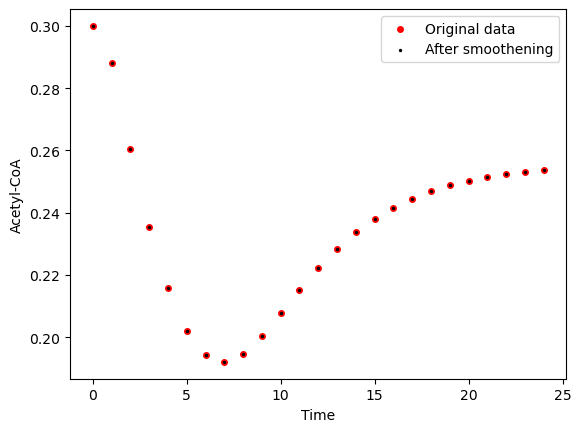

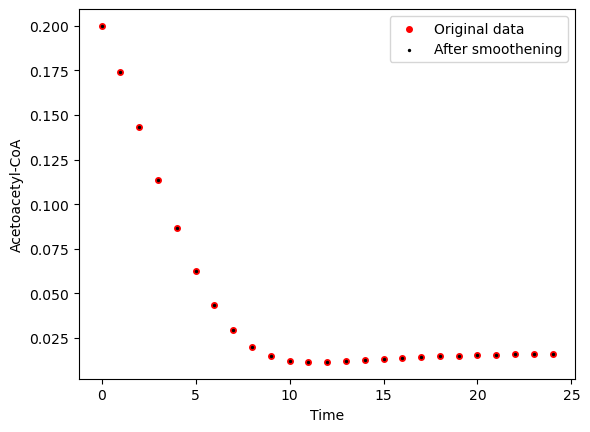

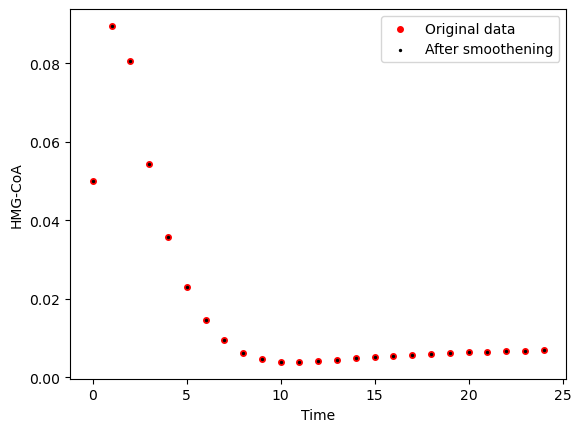

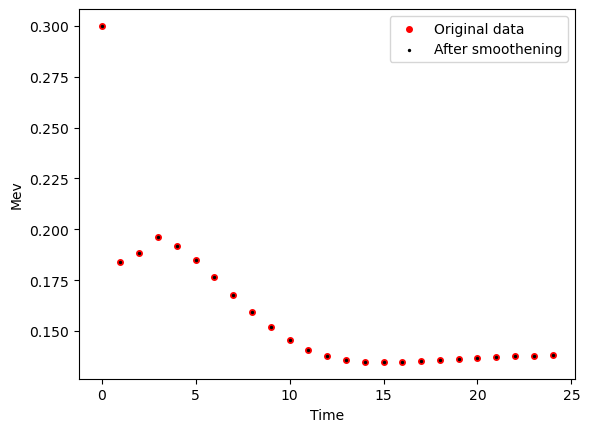

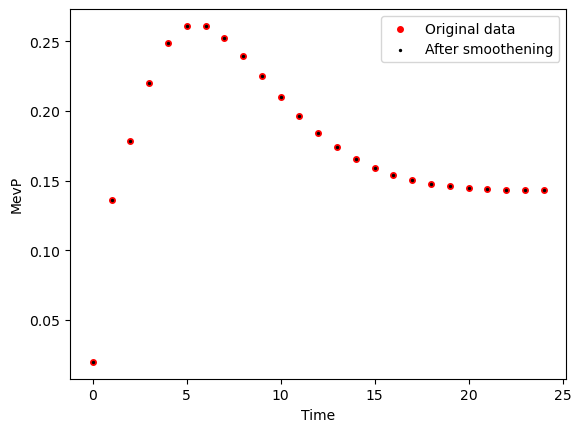

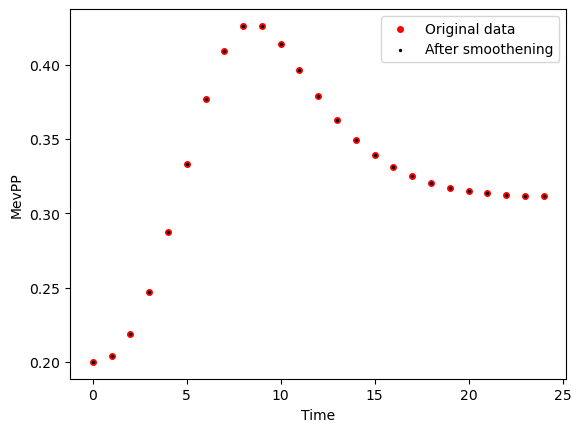

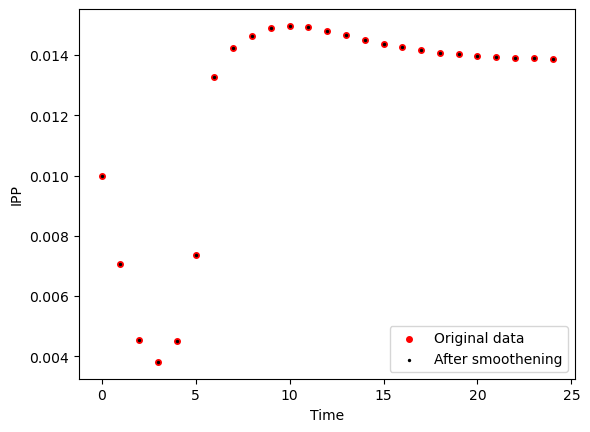

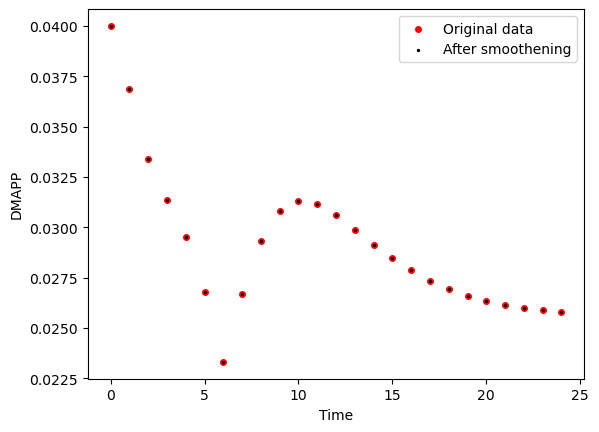

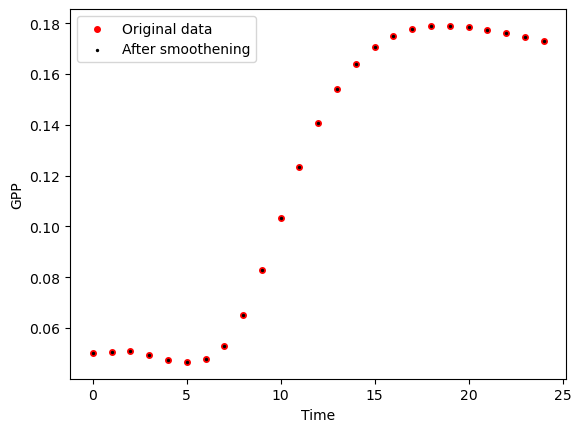

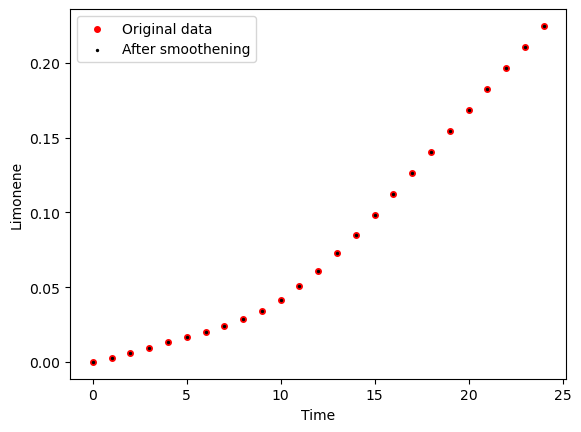

Strain Strain 2


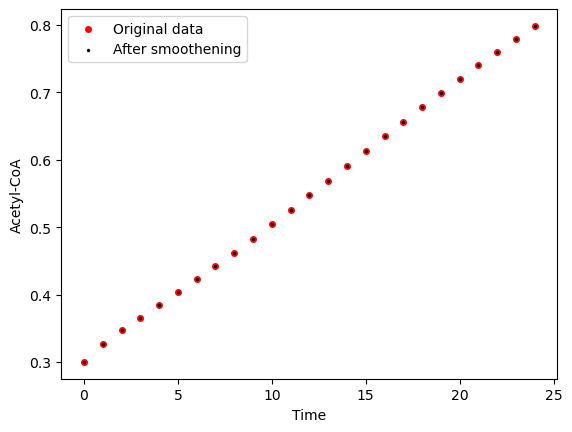

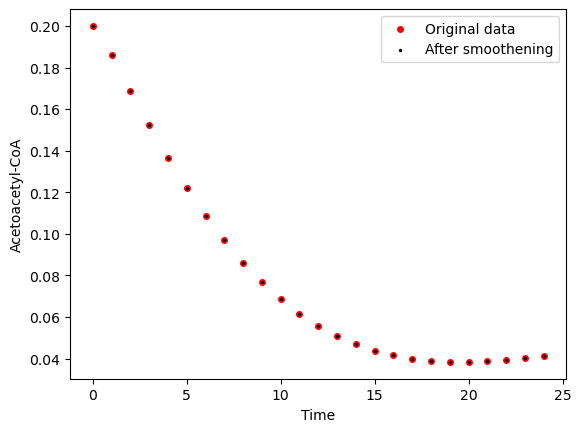

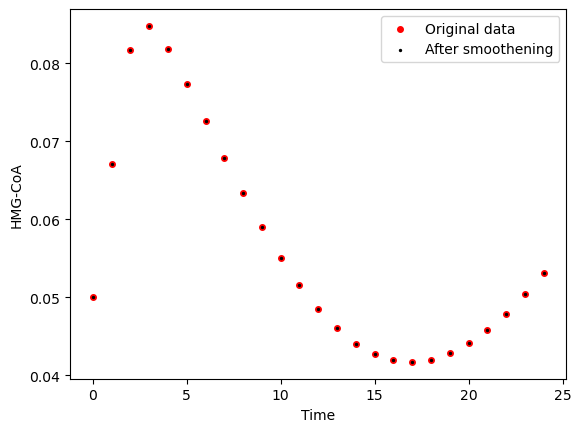

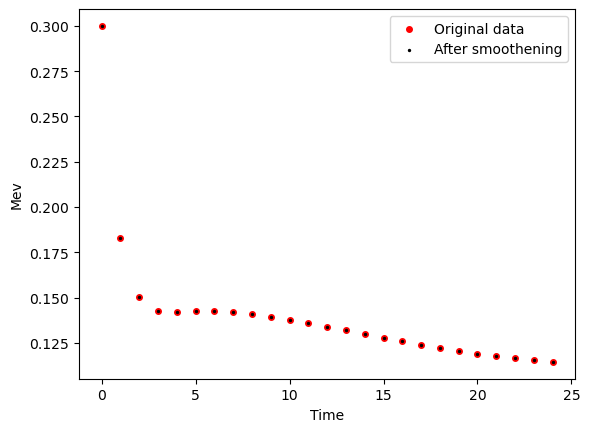

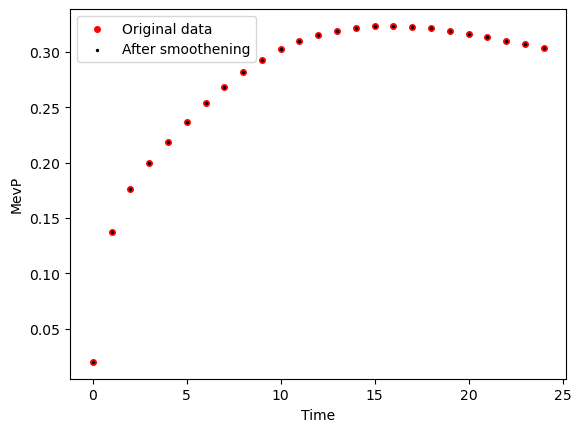

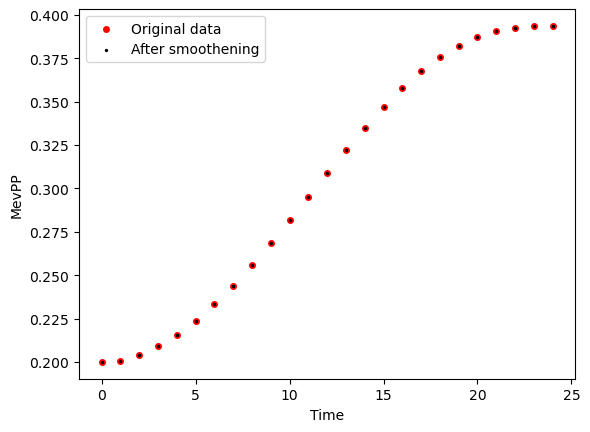

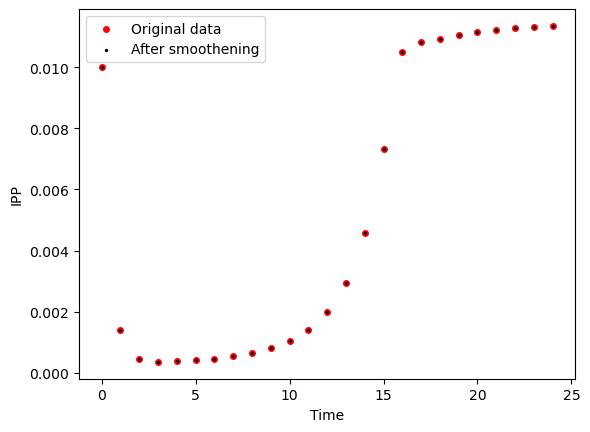

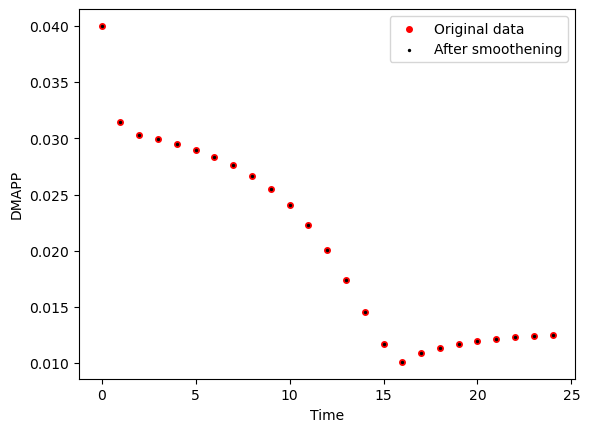

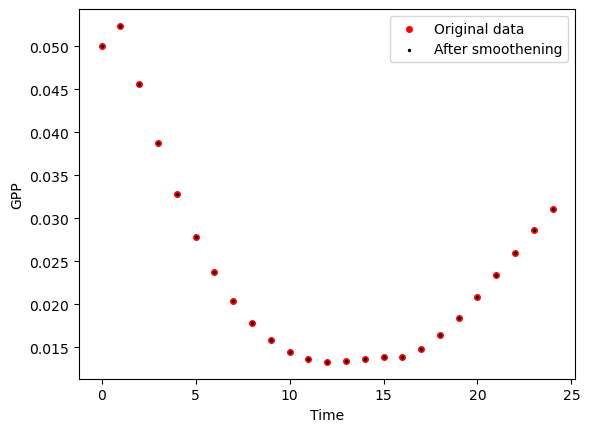

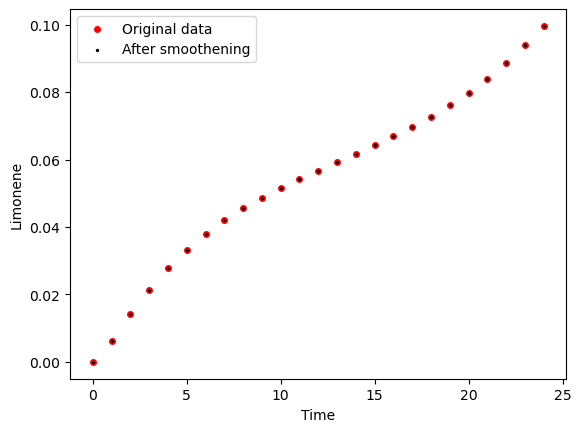

Strain Strain 3


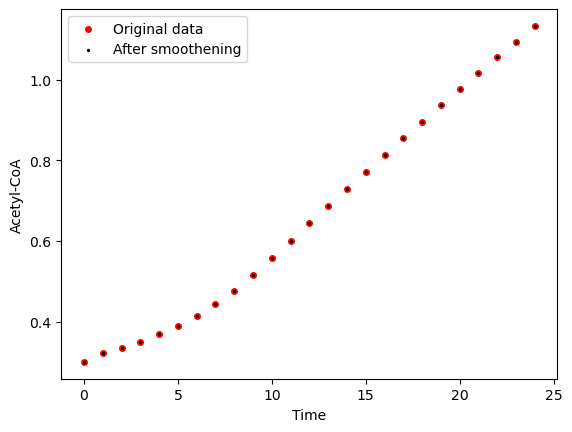

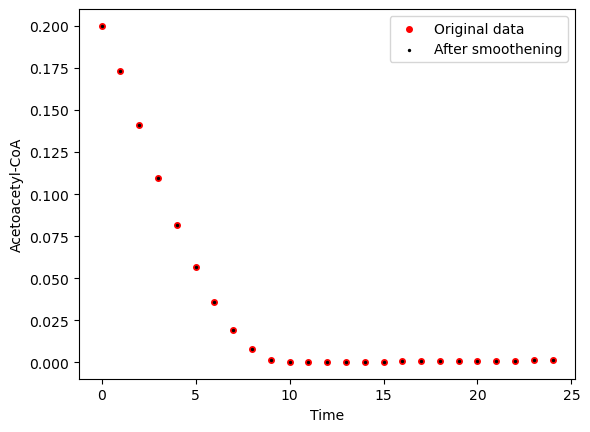

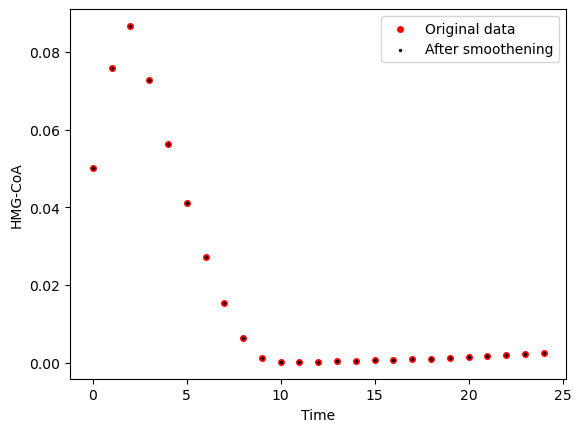

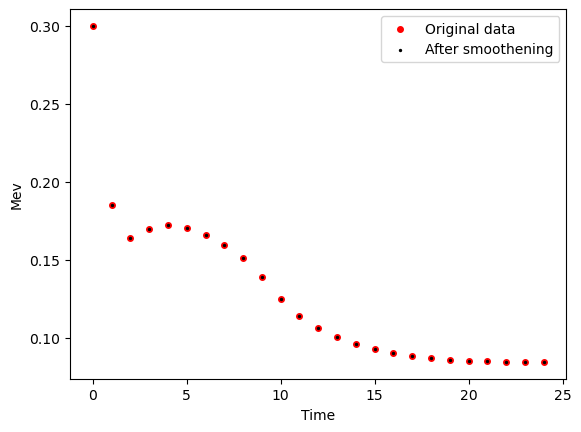

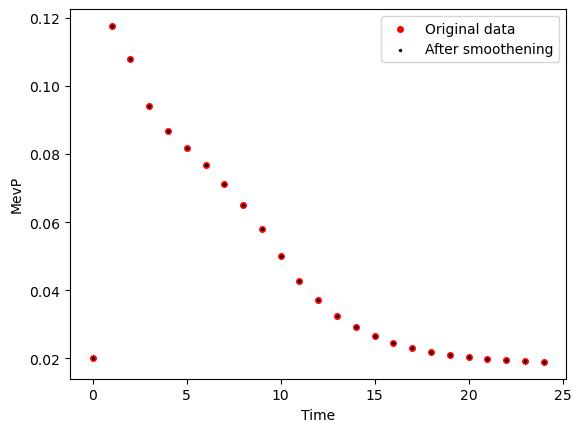

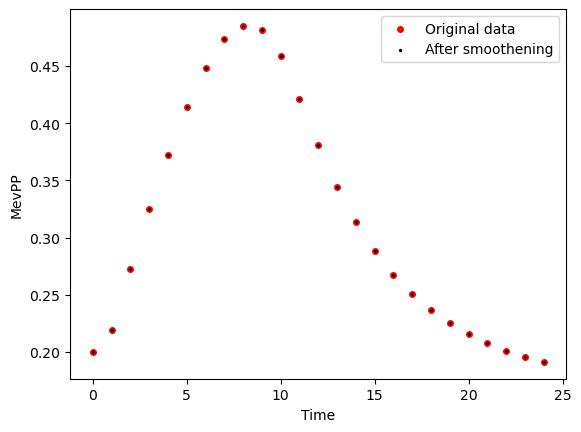

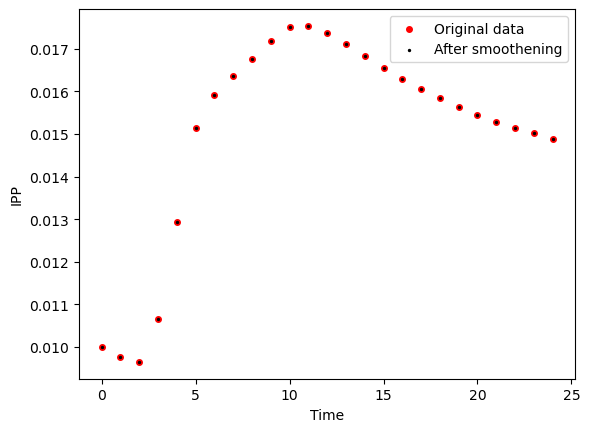

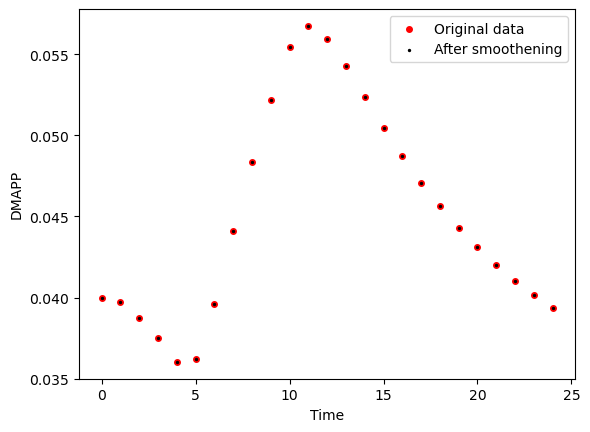

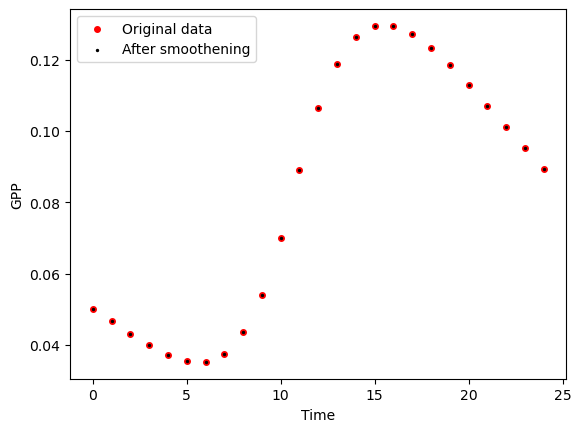

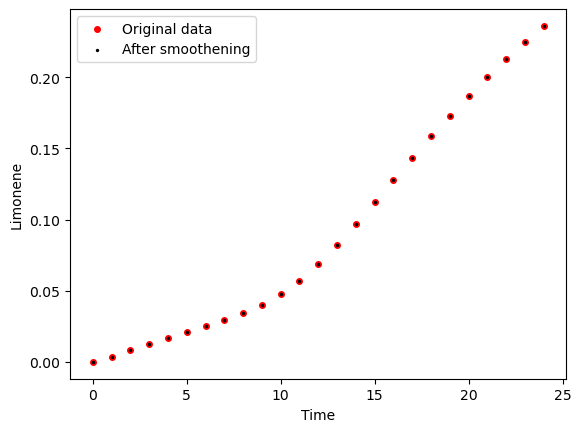

Strain WT


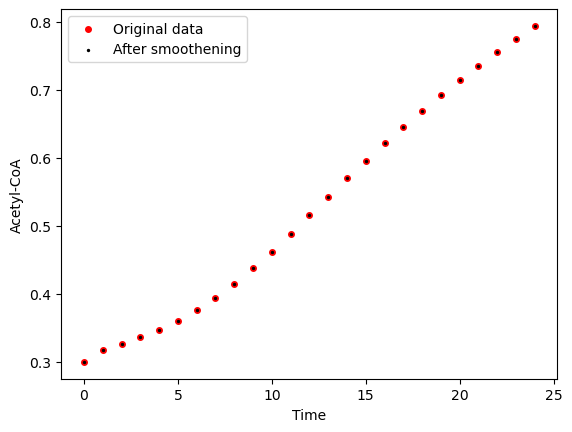

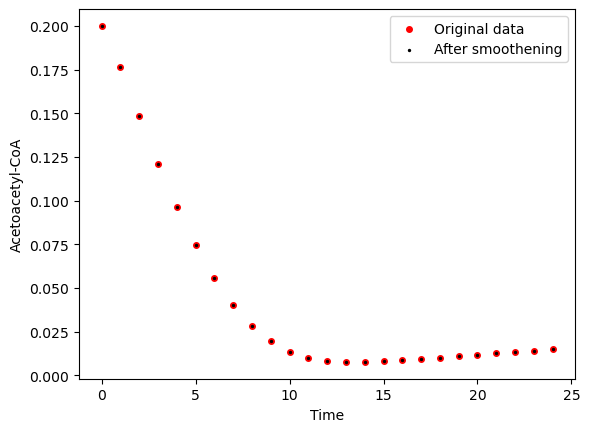

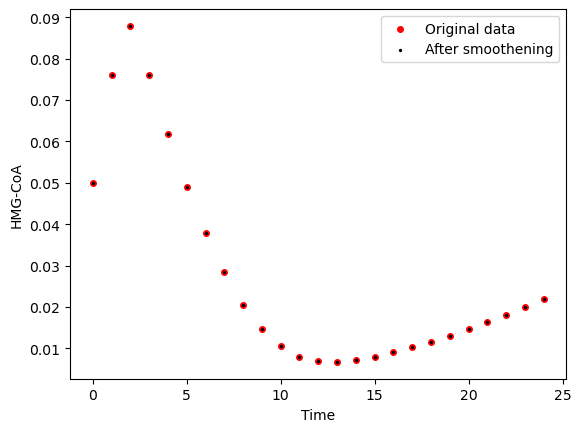

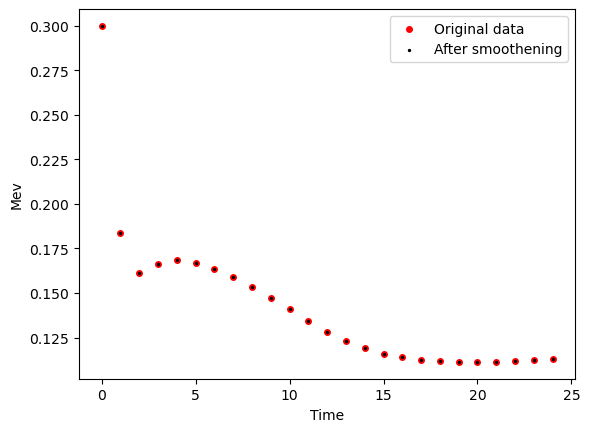

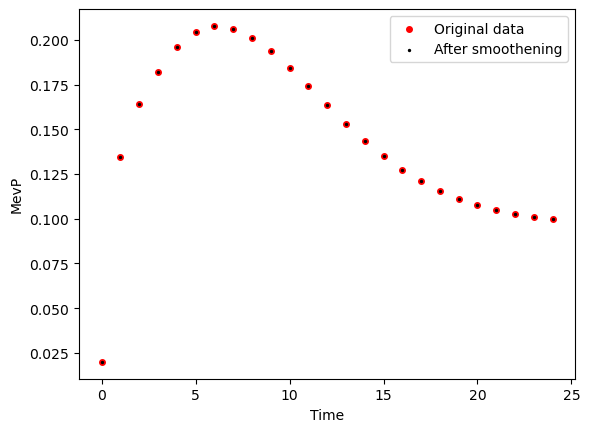

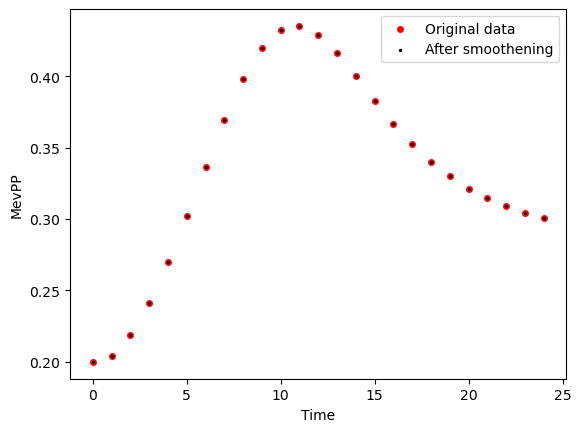

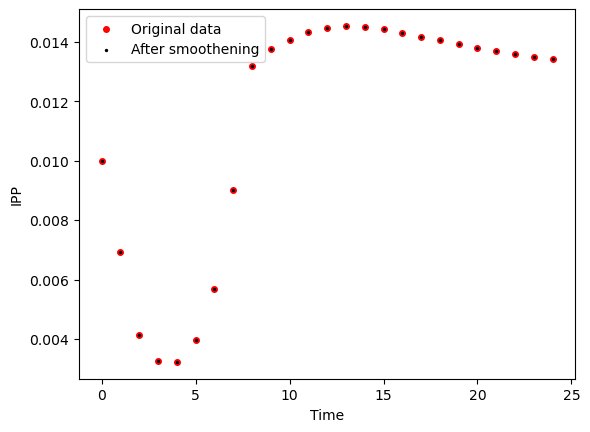

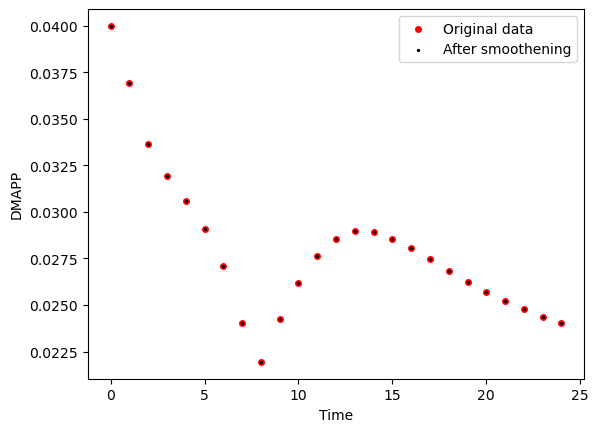

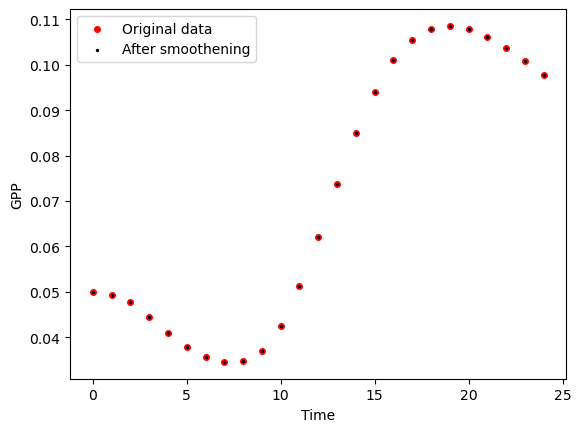

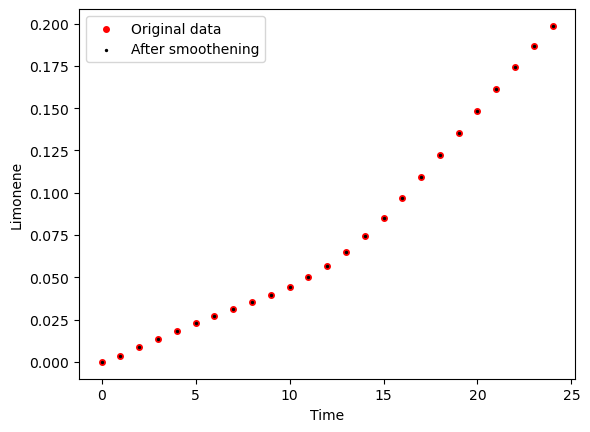

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


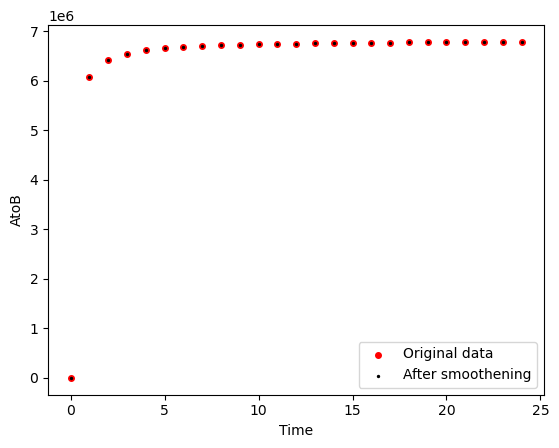

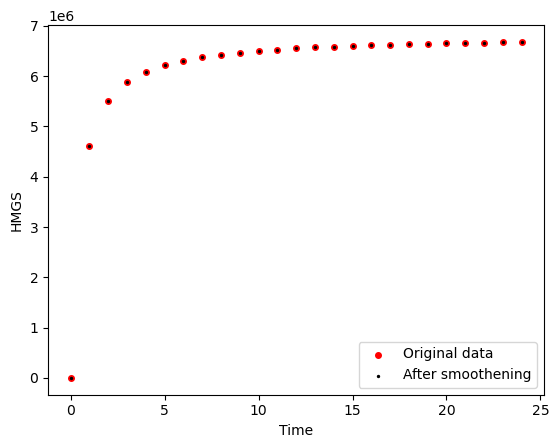

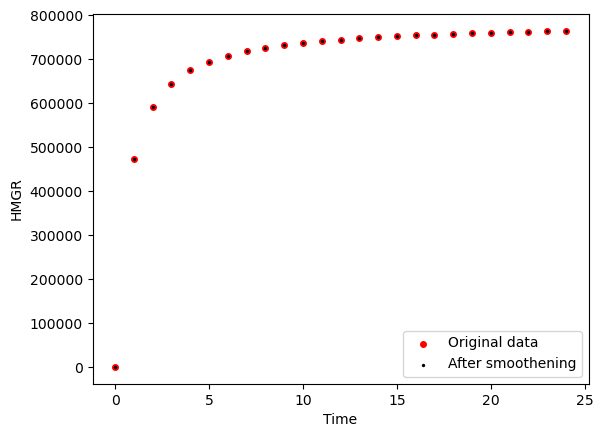

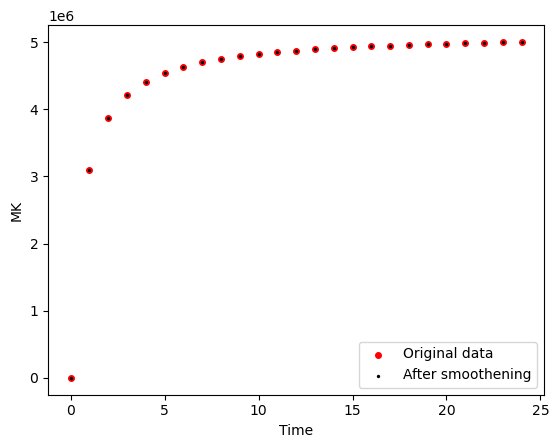

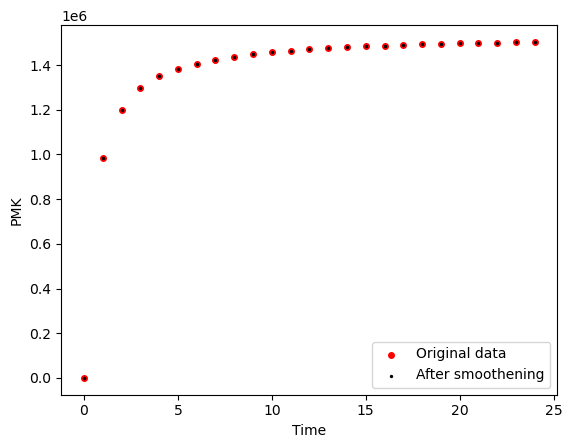

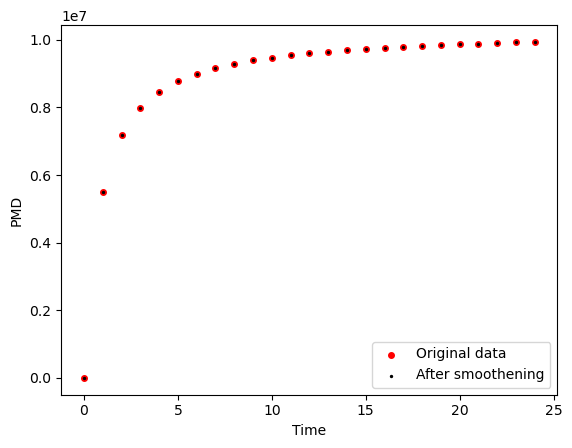

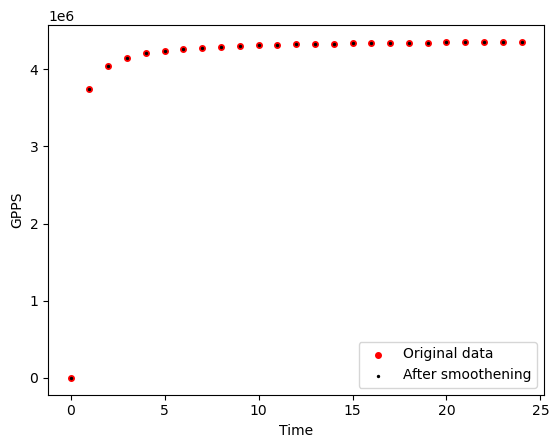

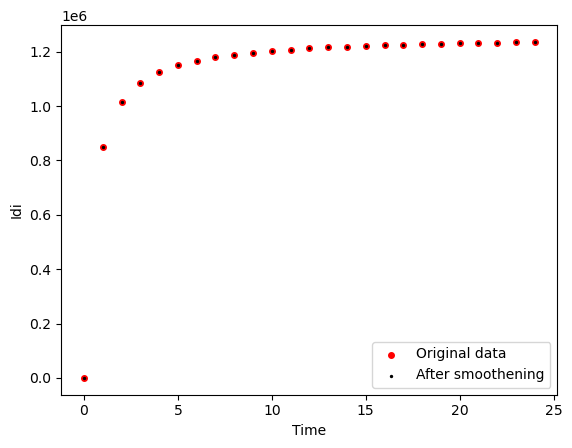

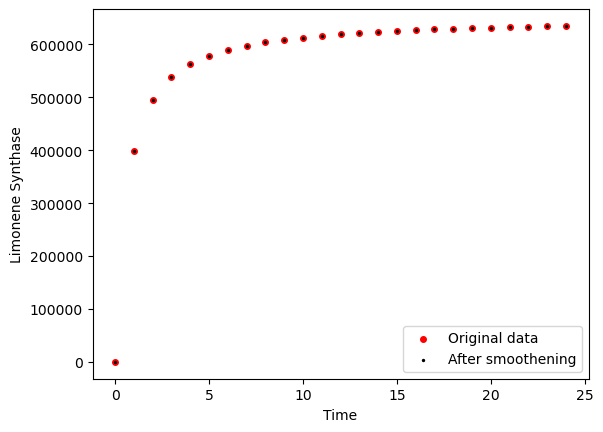

Strain Strain 2


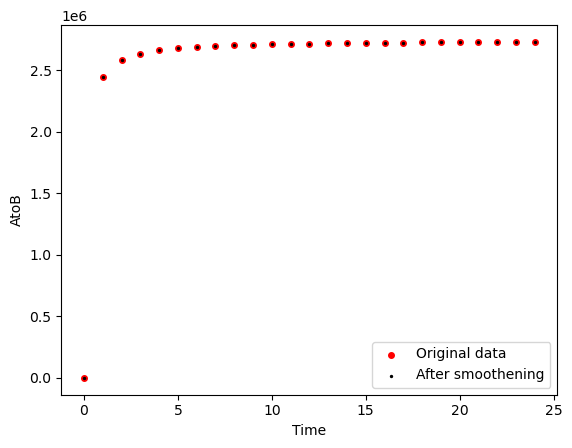

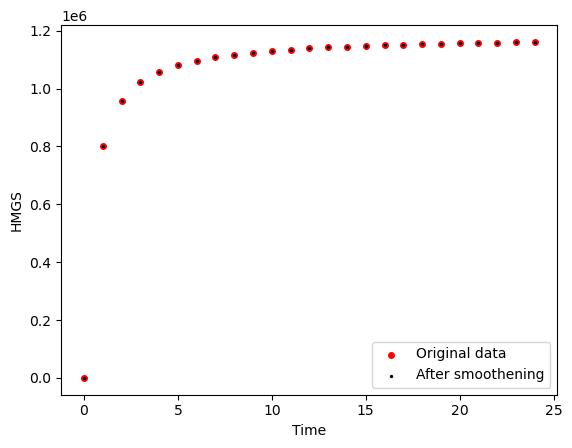

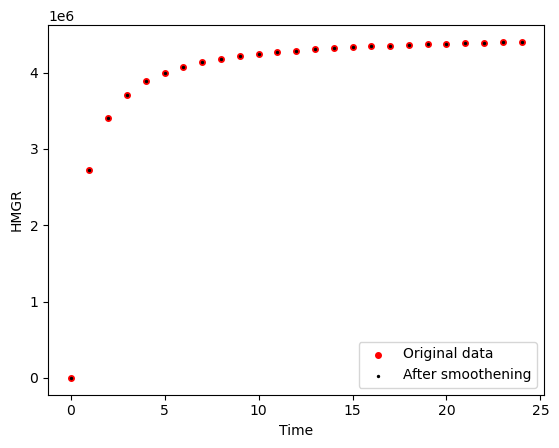

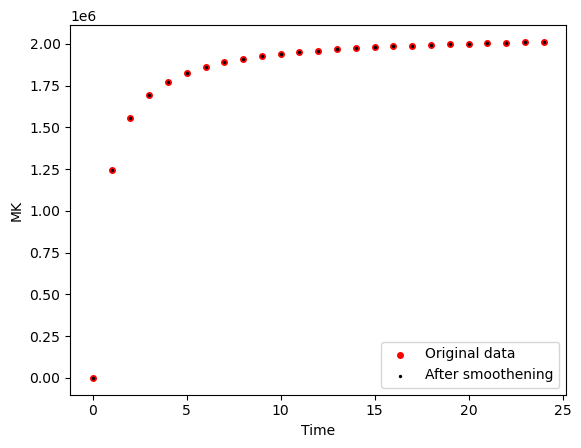

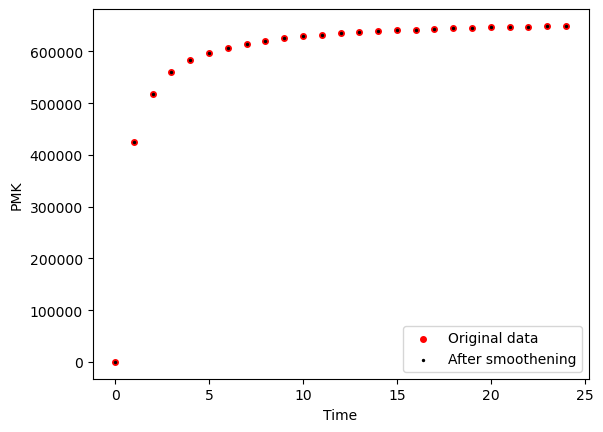

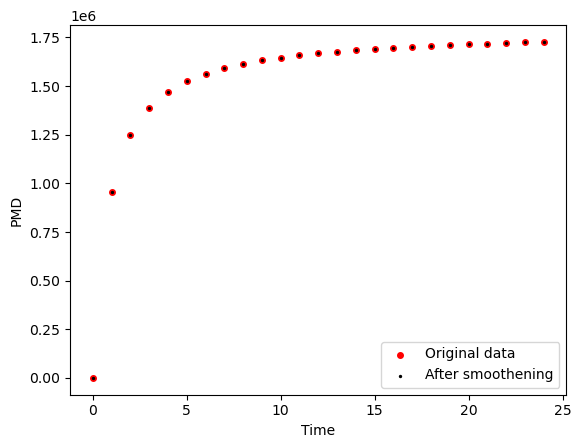

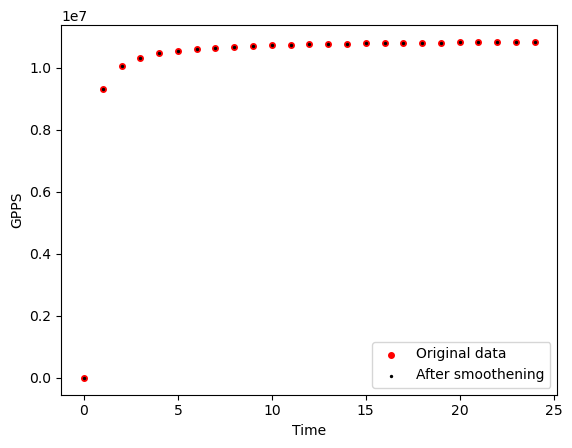

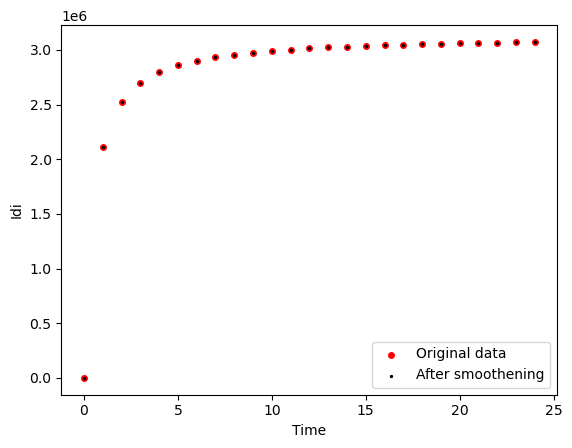

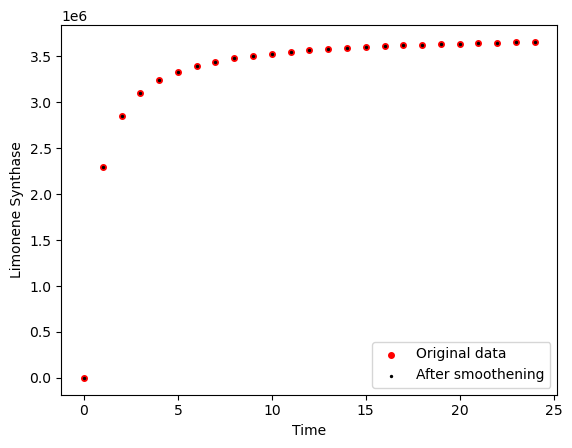

Strain Strain 3


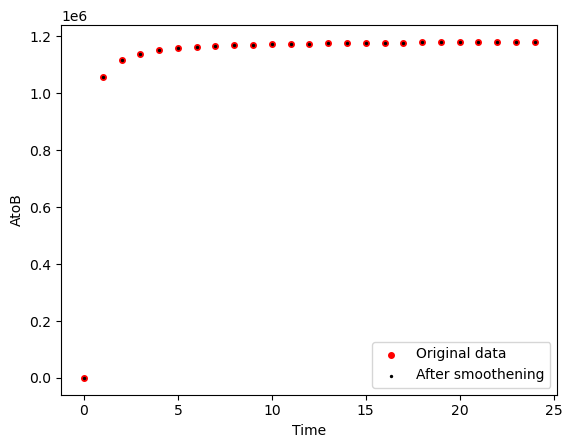

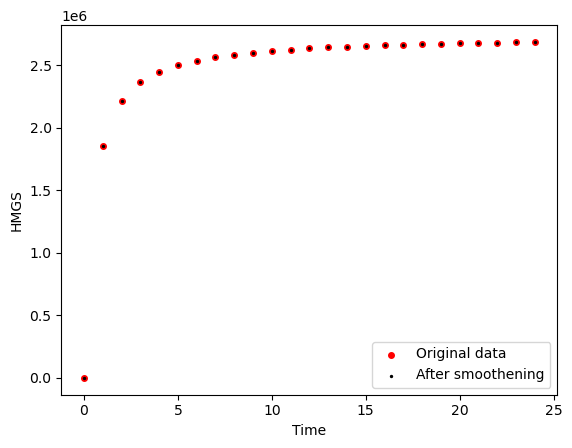

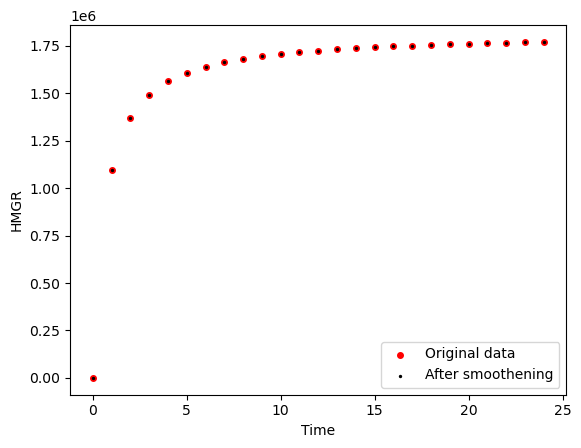

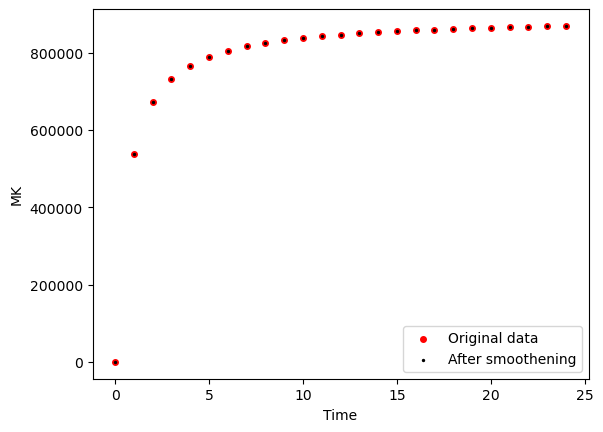

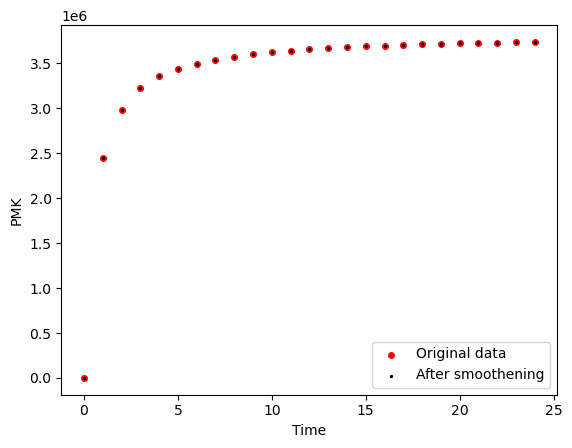

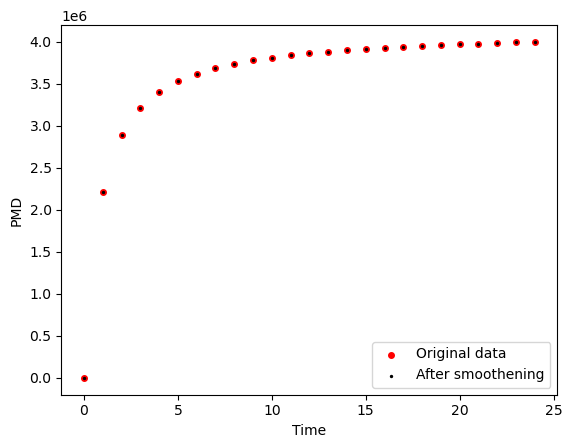

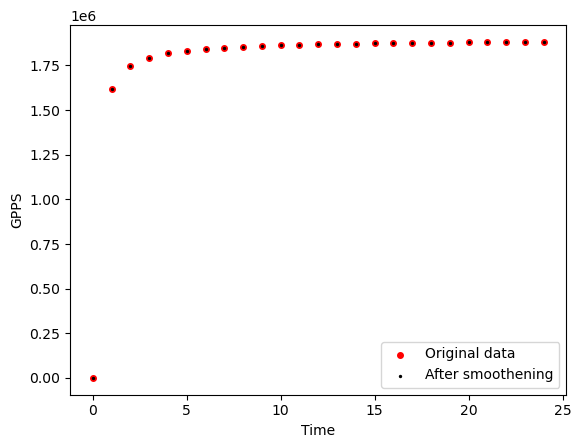

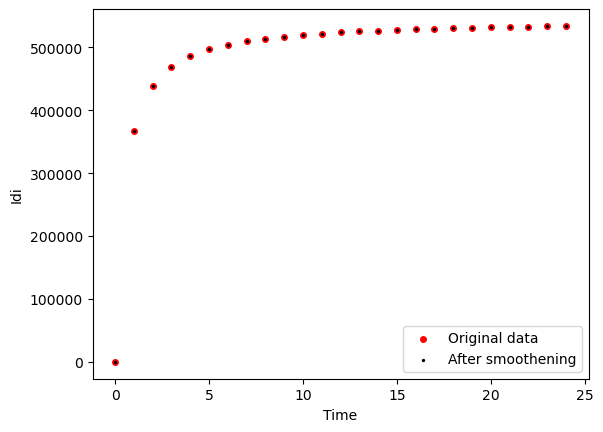

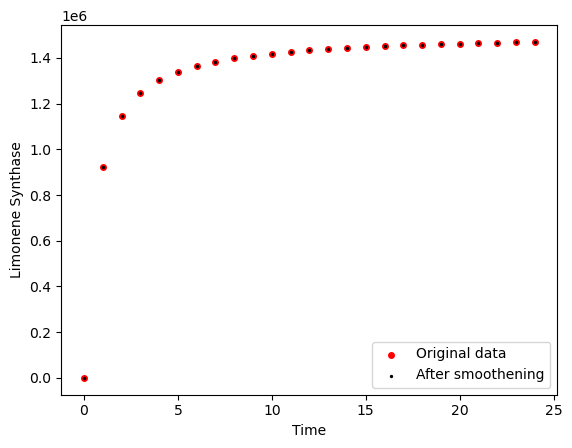

Strain WT


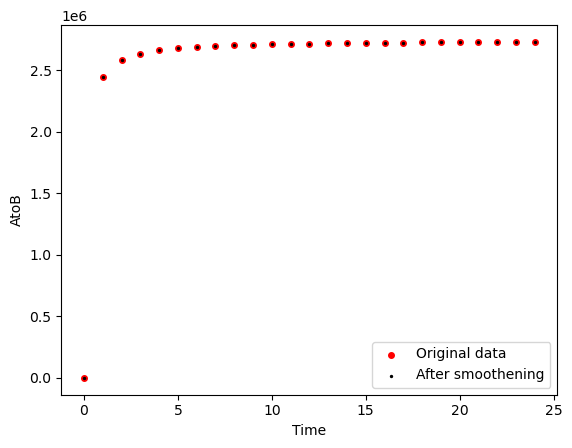

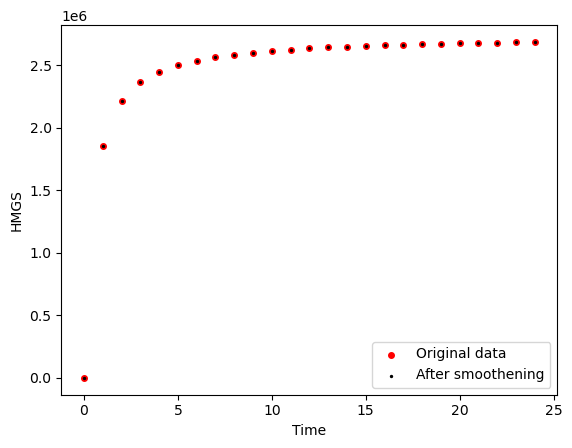

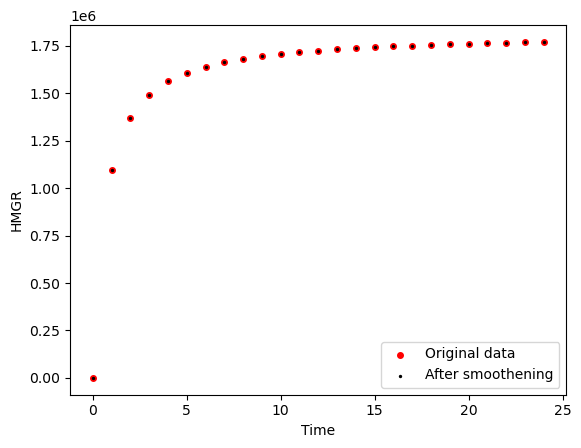

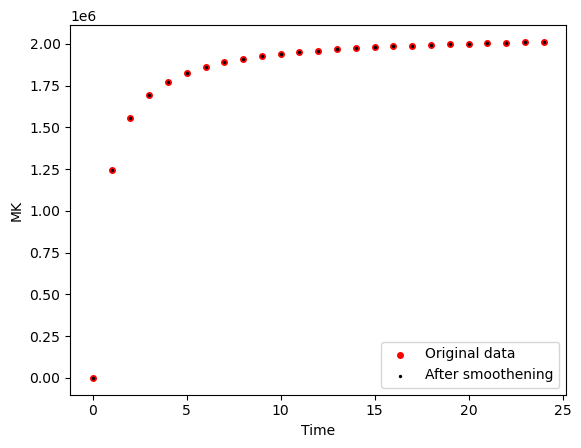

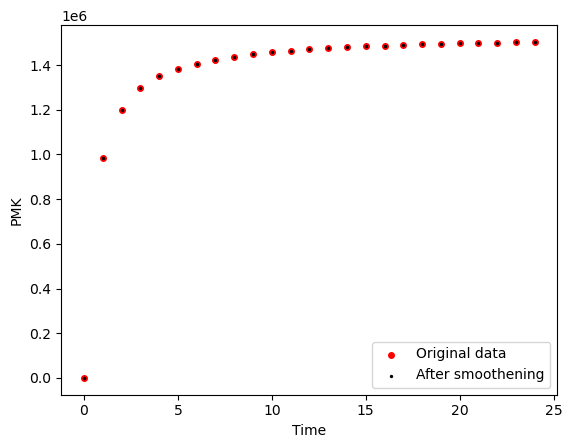

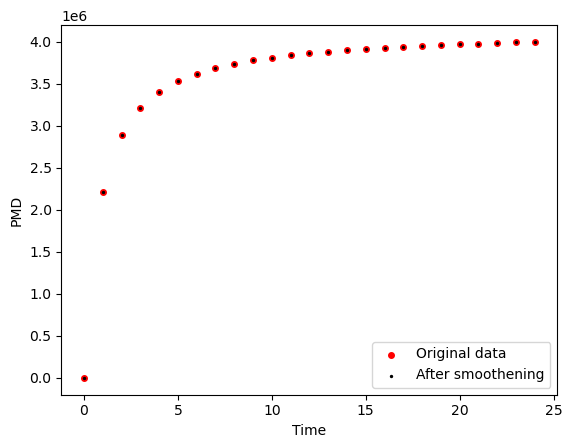

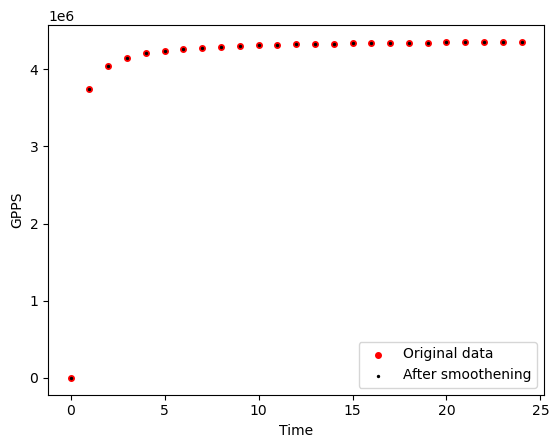

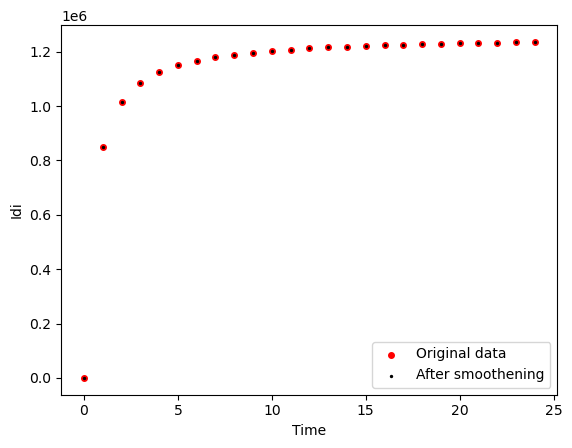

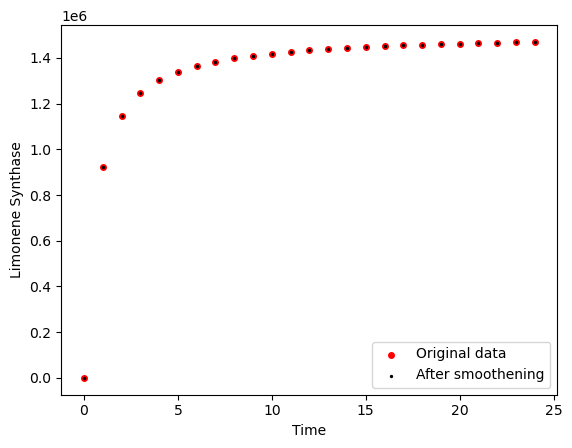

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   
         3.0    0.235487        0.113697  0.054401  0.196026  0.220231   
         4.0    0.215716        0.086401  0.035714  0.192050  0.248849   
...                  ...             ...       ...       ...       ...   
WT       20.0   0.713891        0.011704  0.014676  0.111284  0.107612   
         21.0   0.735034        0.012518  0.016354  0.111498  0.104796   
         22.0   0.755407        0.013340  0.018112  0.111883  0.102630   
         23.0   0.775039        0.014167  0.019944  0.112389  0.101024   
         24.0   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                 ...  \
                  MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                    ...   
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898  ...   
         3.0   0.247211  0.003811  0.031346  0.049192  0.009499  ...   
         4.0   0.287262  0.004502  0.029509  0.047445  0.013083  ...   
...                 ...       ...       ...       ...       ...  ...   
WT       20.0  0.321363  0.013792  0.025710  0.107872  0.148511  ...   
         21.0  0.314396  0.013683  0.025209  0.106179  0.161465  ...   
         22.0  0.308770  0.013585  0.024759  0.103766  0.174178  ...   
         23.0  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         24.0  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

              derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.012210       -0.025323  0.049557 -0.116634  0.116845   
         1.0    -0.020361       -0.028578  0.012025 -0.052534  0.079720   
         2.0    -0.024295       -0.029832 -0.012811 -0.009729  0.050214   
         3.0    -0.024011       -0.029084 -0.024951  0.011779  0.028324   
         4.0    -0.016954       -0.025651 -0.017762 -0.004429  0.021121   
...                   ...             ...       ...       ...       ...   
WT       20.0    0.021537        0.000809  0.001634  0.000108 -0.003173   
         21.0    0.020754        0.000819  0.001719  0.000310 -0.002476   
         22.0    0.019998        0.000826  0.001797  0.000463 -0.001867   
         23.0    0.019268        0.000828  0.001867  0.000556 -0.001351   
         24.0    0.018565        0.000826  0.001928  0.000590 -0.000928   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.007932 -0.003260 -0.004324  0.002387  0.002370  
         1.0   0.009799 -0.002739 -0.003141  0.000185  0.002985  
         2.0   0.024013 -0.001722 -0.002408 -0.001159  0.003412  
         3.0   0.034710 -0.000208 -0.002125 -0.001644  0.003653  
         4.0   0.043730  0.002514 -0.002840 -0.001579  0.003563  
...                 ...       ...       ...       ...       ...  
WT       20.0 -0.007713 -0.000115 -0.000527 -0.001239  0.013045  
         21.0 -0.006265 -0.000104 -0.000476 -0.002097  0.012850  
         22.0 -0.005007 -0.000092 -0.000426 -0.002724  0.012584  
         23.0 -0.003946 -0.000081 -0.000374 -0.003088  0.012228  
         24.0 -0.003082 -0.000068 -0.000320 -0.003188  0.011779

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

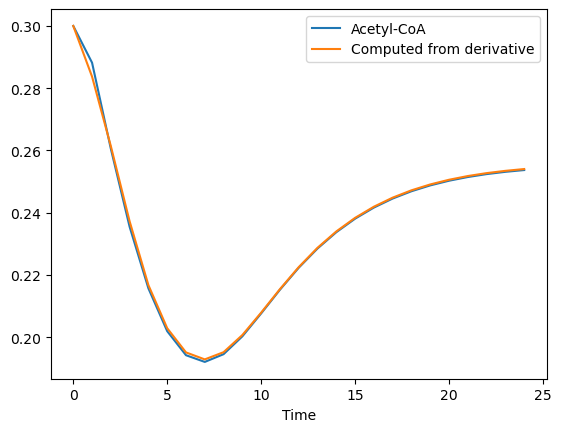

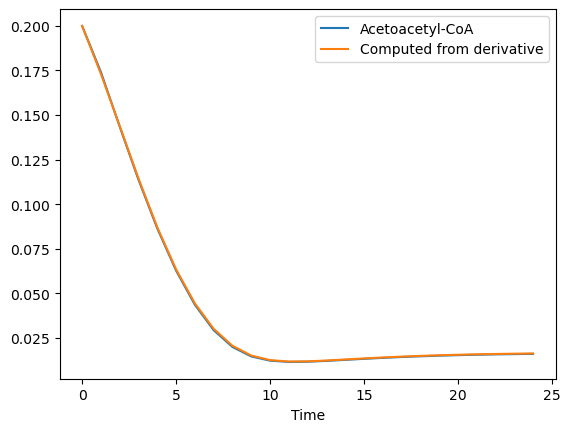

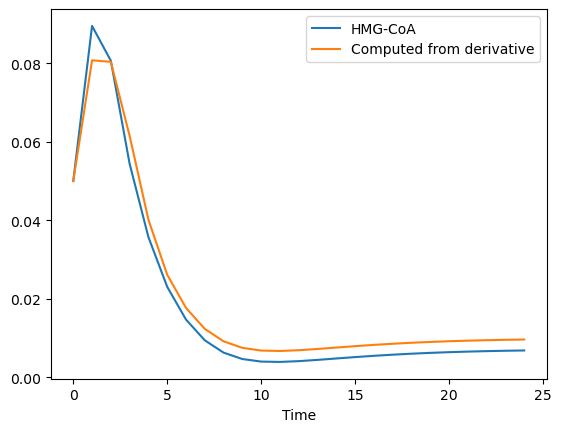

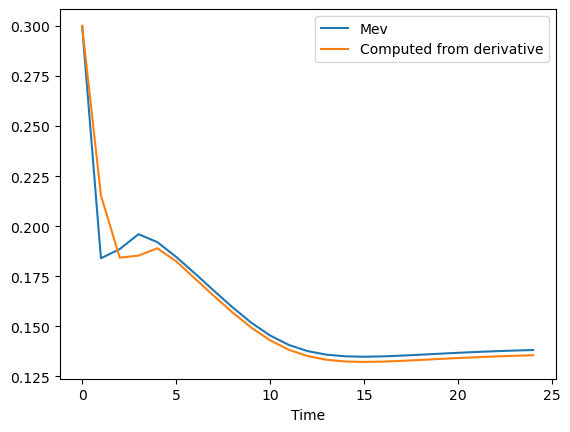

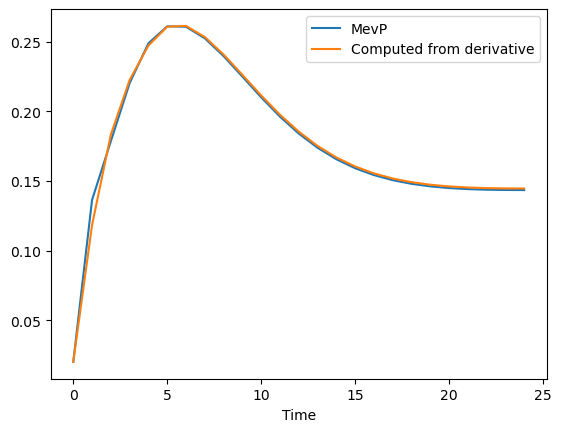

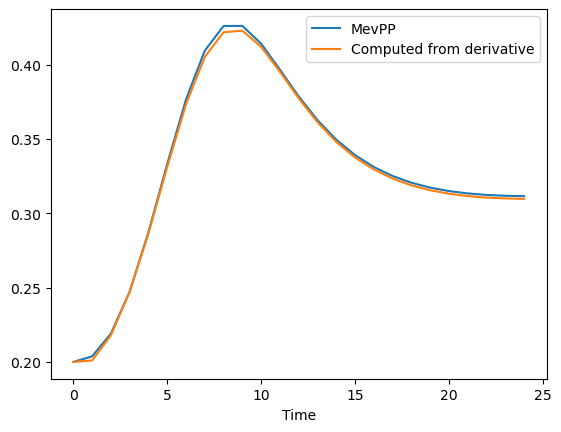

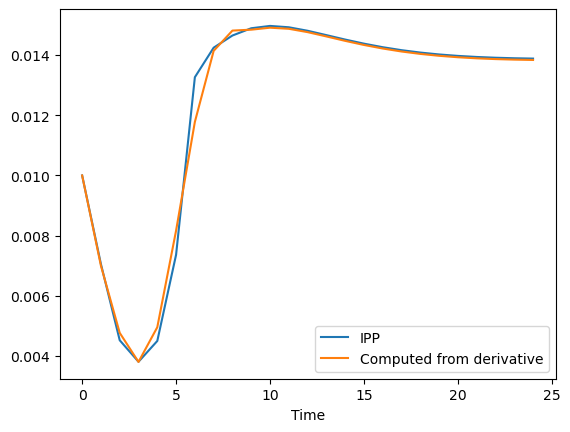

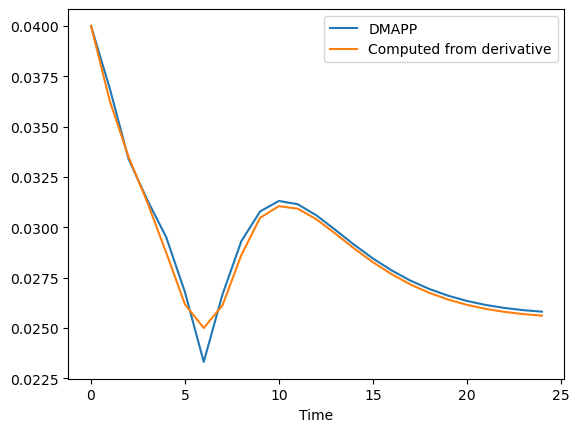

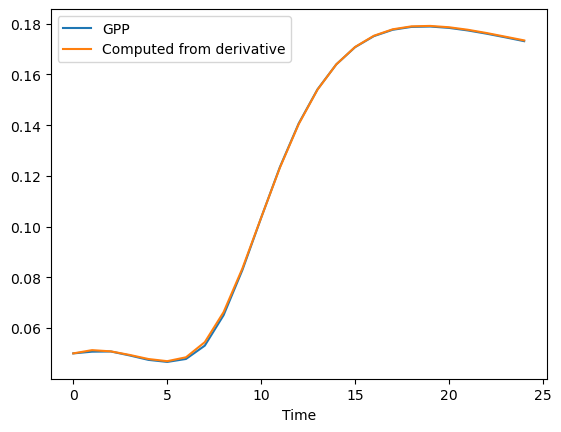

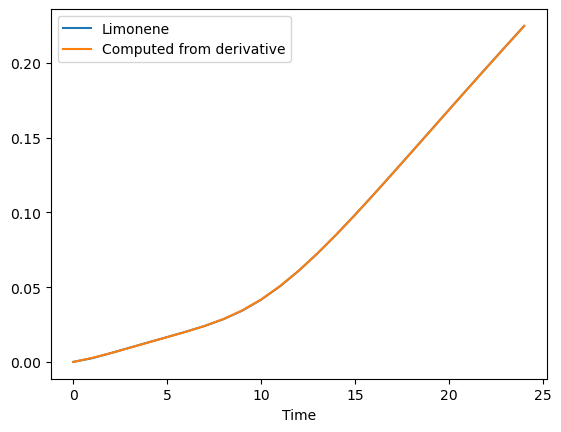

'Time profile from derivative vs. actual profile for Strain 2'

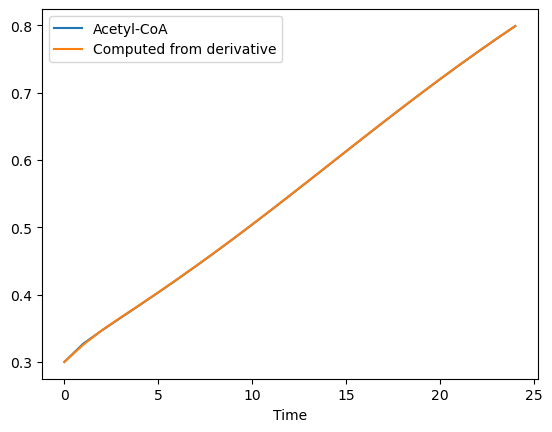

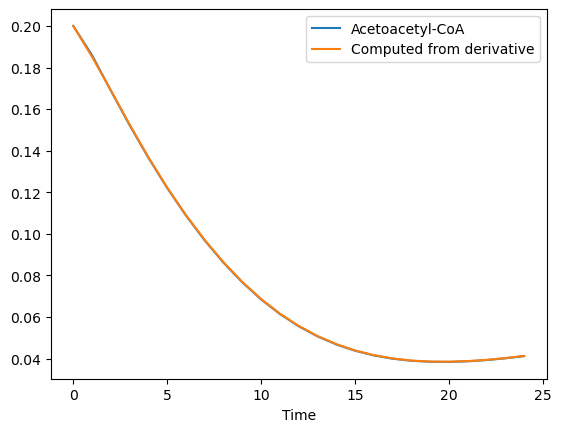

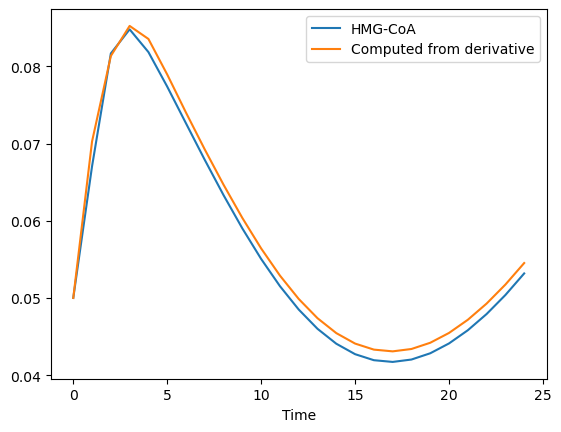

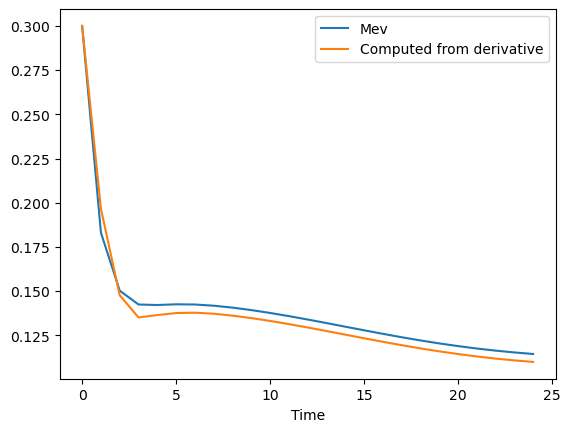

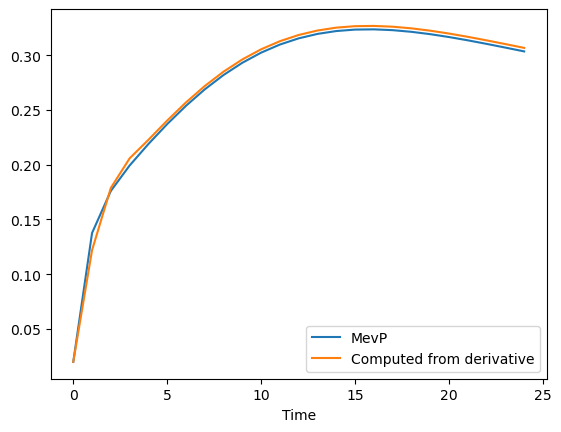

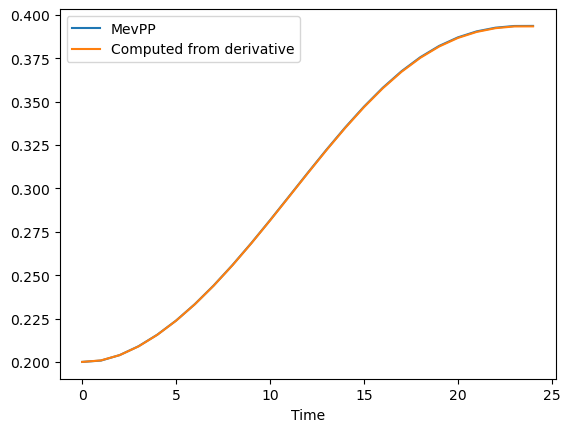

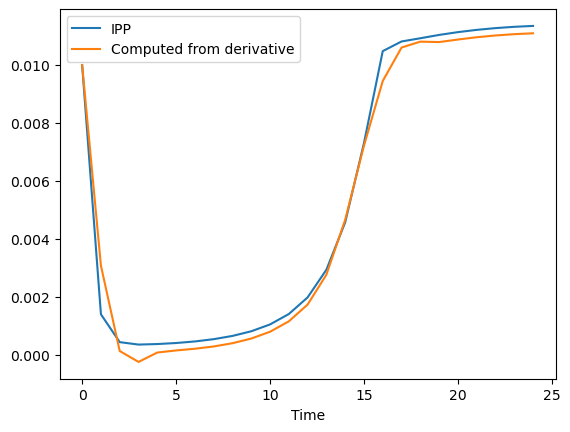

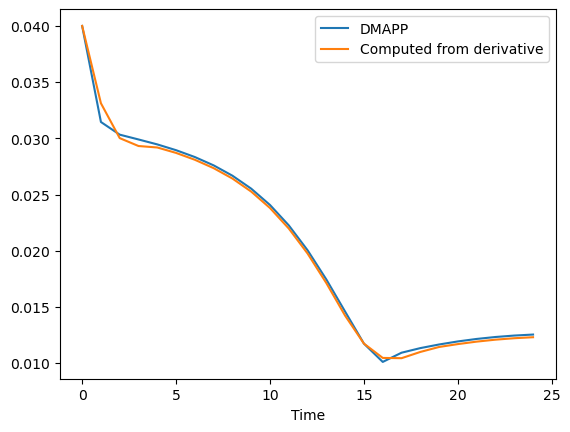

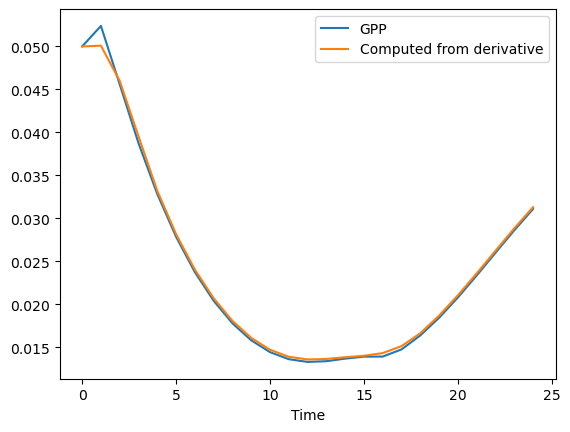

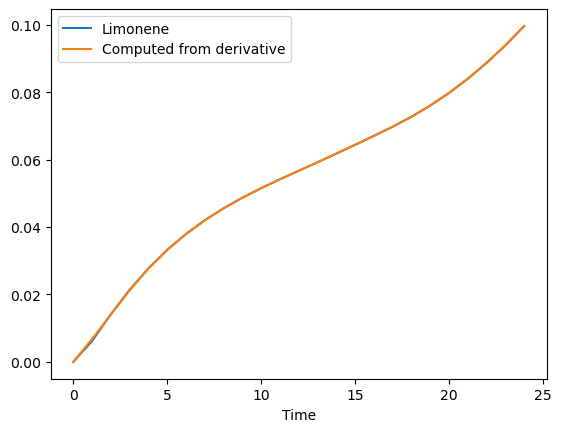

'Time profile from derivative vs. actual profile for Strain 3'

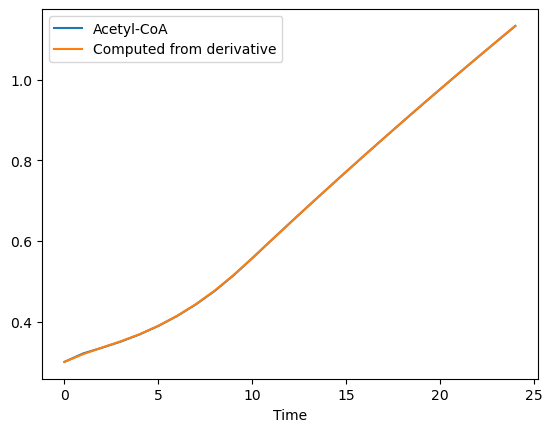

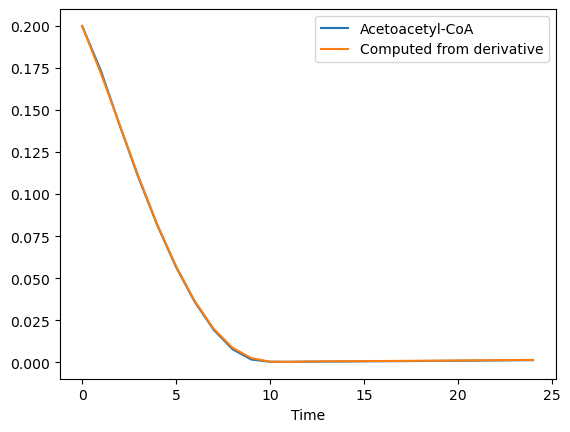

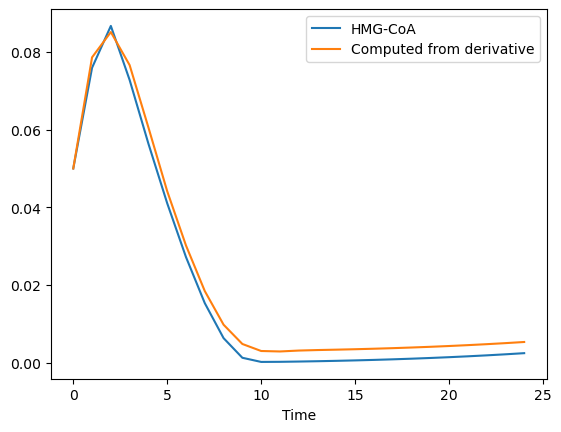

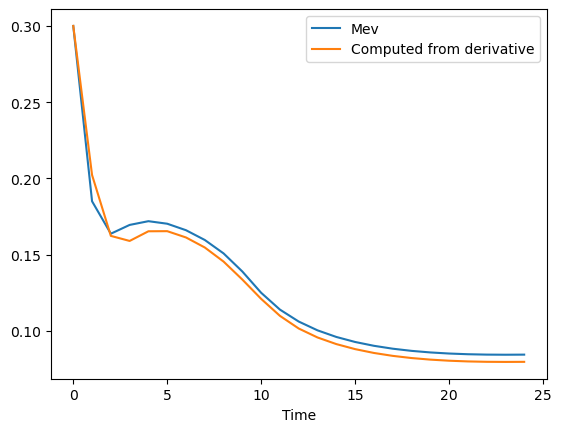

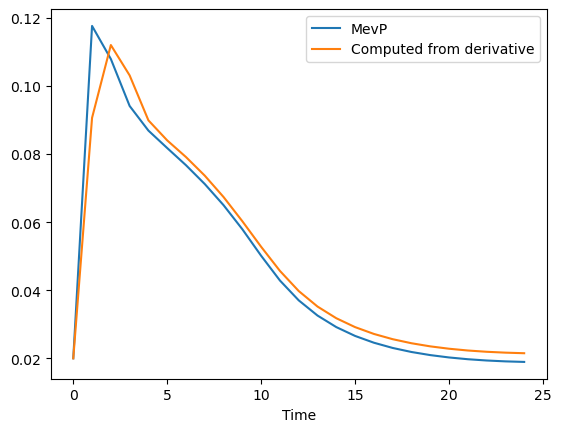

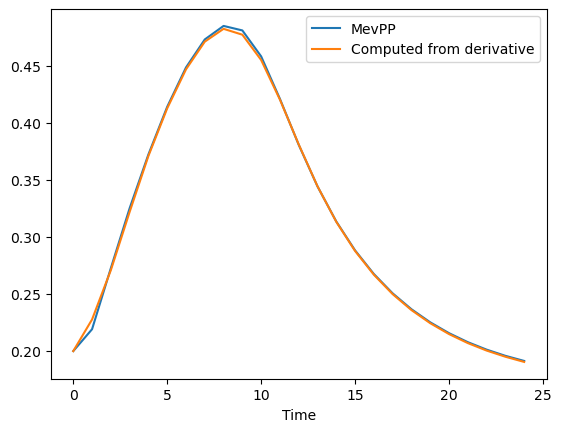

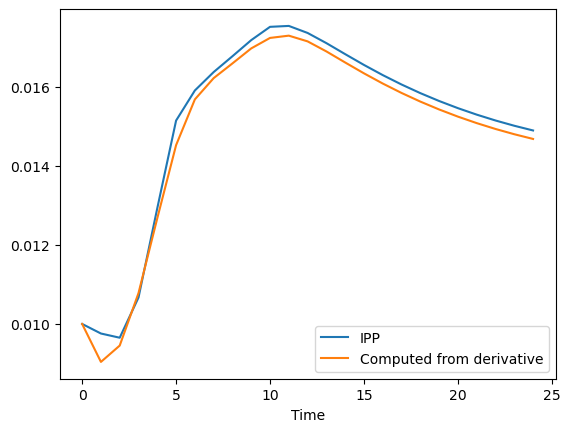

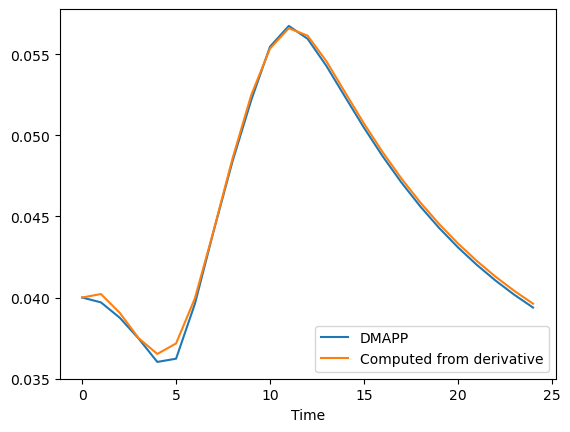

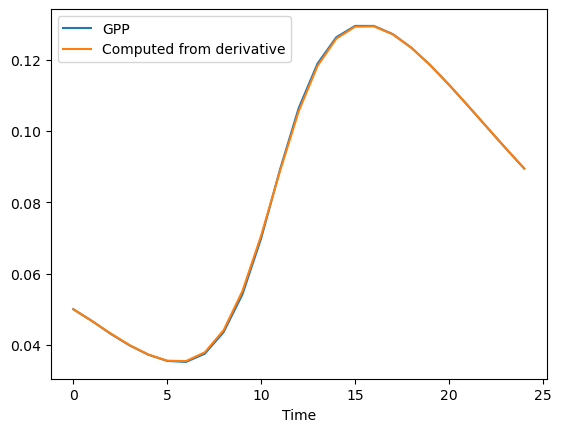

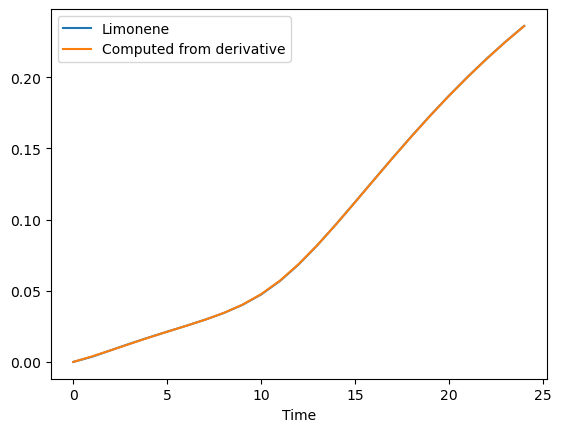

'Time profile from derivative vs. actual profile for WT'

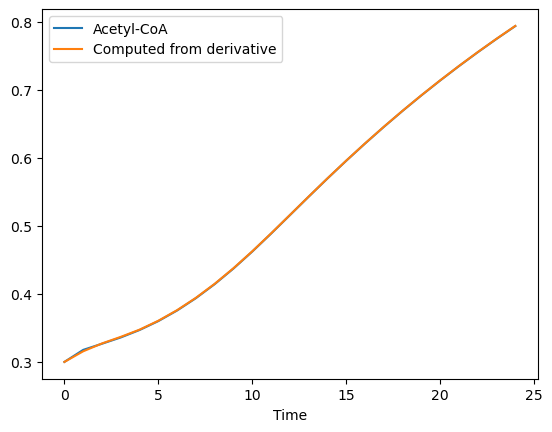

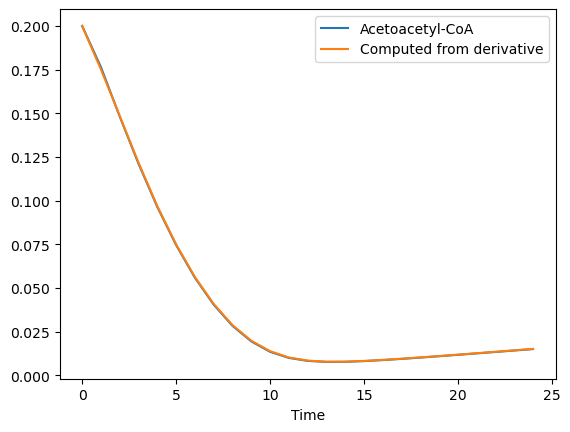

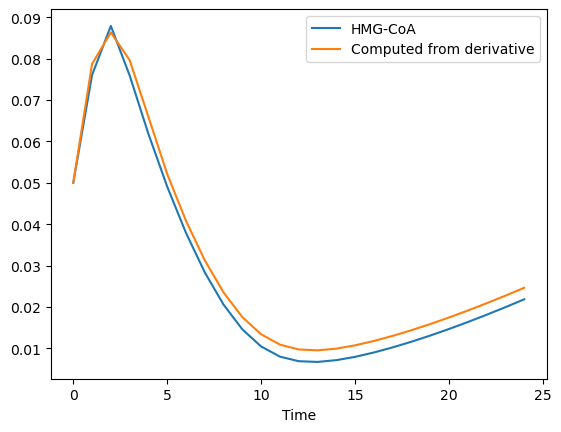

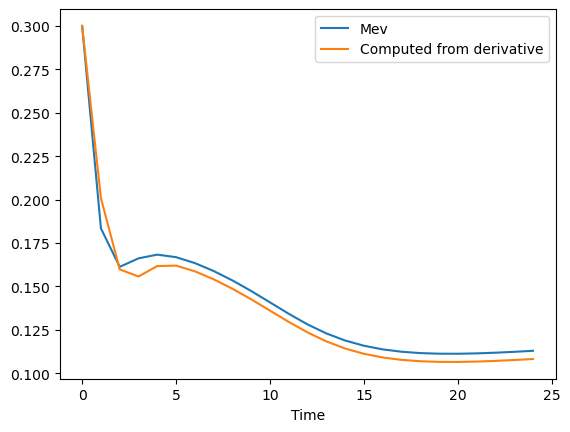

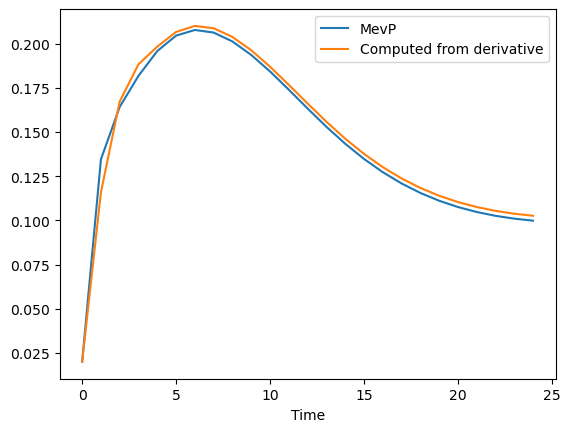

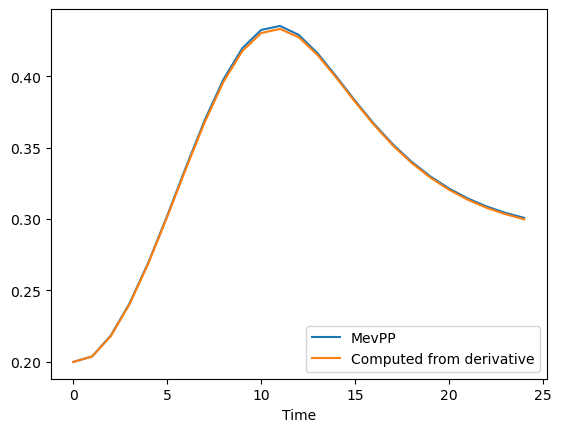

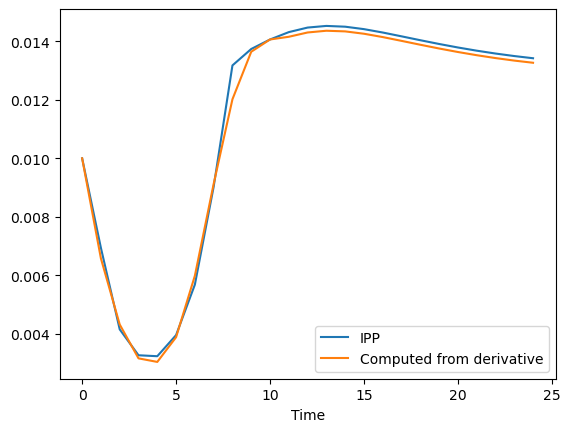

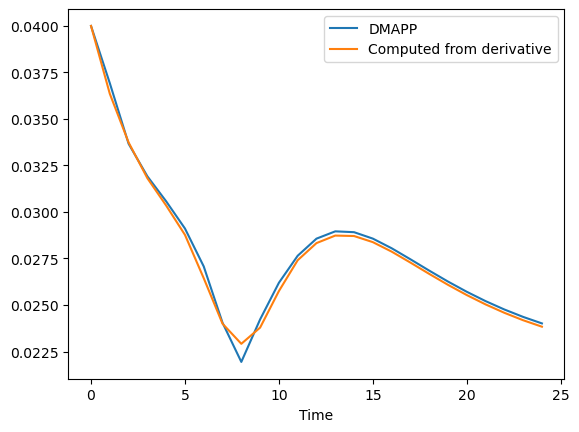

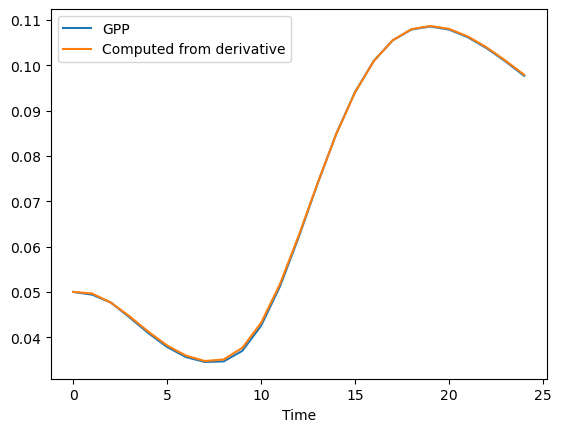

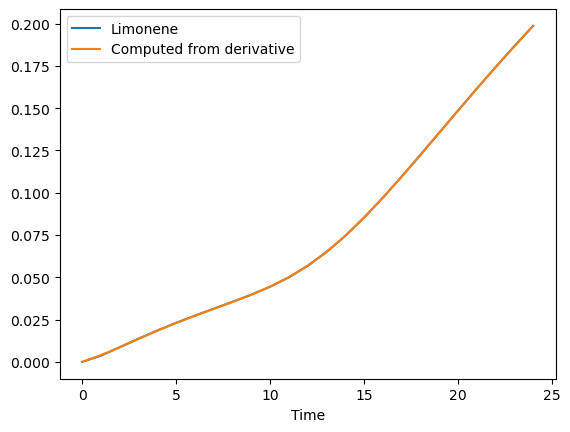

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                       AtoB          HMGS          HMGR            MK   
Strain   Time                                                           
Strain 1 0.0   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         1.0   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
         2.0   6.425365e+06  5.499584e+06  5.913288e+05  3.865639e+06   
         3.0   6.552225e+06  5.877726e+06  6.444660e+05  4.213751e+06   
         4.0   6.617553e+06  6.086991e+06  6.747845e+05  4.412428e+06   
...                     ...           ...           ...           ...   
WT       20.0  2.727222e+06  2.677299e+06  1.760761e+06  2.001420e+06   
         21.0  2.728018e+06  2.680280e+06  1.763434e+06  2.004465e+06   
         22.0  2.728742e+06  2.682996e+06  1.765870e+06  2.007241e+06   
         23.0  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         24.0  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
         3.0   1.295555e+06  7.983898e+06  4.148877e+06  1.085557e+06   
         4.0   1.348773e+06  8.458683e+06  4.205790e+06  1.124709e+06   
...                     ...           ...           ...           ...   
WT       20.0  1.496285e+06  3.969027e+06  4.348970e+06  1.231287e+06   
         21.0  1.498236e+06  3.976909e+06  4.350733e+06  1.232678e+06   
         22.0  1.500014e+06  3.984102e+06  4.352338e+06  1.233945e+06   
         23.0  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         24.0  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                    states                            \
              Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                          
Strain 1 0.0       3.034108e+01   0.300000        0.200000  0.050000   
         1.0       3.981392e+05   0.288190        0.174077  0.089557   
         2.0       4.943155e+05   0.260551        0.143504  0.080676   
         3.0       5.376051e+05   0.235487        0.113697  0.054401   
         4.0       5.622236e+05   0.215716        0.086401  0.035714   
...                         ...        ...             ...       ...   
WT       20.0      1.462098e+06   0.713891        0.011704  0.014676   
         21.0      1.464251e+06   0.735034        0.012518  0.016354   
         22.0      1.466213e+06   0.755407        0.013340  0.018112   
         23.0      1.468009e+06   0.775039        0.014167  0.019944   
         24.0      1.469659e+06   0.793953        0.014996  0.021843   

                                                                           \
                    Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                               
Strain 1 0.0   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         1.0   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
         2.0   0.188562  0.178523  0.219000  0.004525  0.033388  0.050751   
         3.0   0.196026  0.220231  0.247211  0.003811  0.031346  0.049192   
         4.0   0.192050  0.248849  0.287262  0.004502  0.029509  0.047445   
...                 ...       ...       ...       ...       ...       ...   
WT       20.0  0.111284  0.107612  0.321363  0.013792  0.025710  0.107872   
         21.0  0.111498  0.104796  0.314396  0.013683  0.025209  0.106179   
         22.0  0.111883  0.102630  0.308770  0.013585  0.024759  0.103766   
         23.0  0.112389  0.101024  0.304

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.012210       -0.025323  0.049557 -0.116634  0.116845   
         1.0    -0.020361       -0.028578  0.012025 -0.052534  0.079720   
         2.0    -0.024295       -0.029832 -0.012811 -0.009729  0.050214   
         3.0    -0.024011       -0.029084 -0.024951  0.011779  0.028324   
         4.0    -0.016954       -0.025651 -0.017762 -0.004429  0.021121   
...                   ...             ...       ...       ...       ...   
WT       20.0    0.021537        0.000809  0.001634  0.000108 -0.003173   
         21.0    0.020754        0.000819  0.001719  0.000310 -0.002476   
         22.0    0.019998        0.000826  0.001797  0.000463 -0.001867   
         23.0    0.019268        0.000828  0.001867  0.000556 -0.001351   
         24.0    0.018565        0.000826  0.001928  0.000590 -0.000928   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.007932 -0.003260 -0.004324  0.002387  0.002370  
         1.0   0.009799 -0.002739 -0.003141  0.000185  0.002985  
         2.0   0.024013 -0.001722 -0.002408 -0.001159  0.003412  
         3.0   0.034710 -0.000208 -0.002125 -0.001644  0.003653  
         4.0   0.043730  0.002514 -0.002840 -0.001579  0.003563  
...                 ...       ...       ...       ...       ...  
WT       20.0 -0.007713 -0.000115 -0.000527 -0.001239  0.013045  
         21.0 -0.006265 -0.000104 -0.000476 -0.002097  0.012850  
         22.0 -0.005007 -0.000092 -0.000426 -0.002724  0.012584  
         23.0 -0.003946 -0.000081 -0.000374 -0.003088  0.012228  
         24.0 -0.003082 -0.000068 -0.000320 -0.003188  0.011779  

[100 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 8.292064E+191 | 1.096230E+117
     2 |       74 | 2.009589E+115 |  3.958347E+83
     3 |      138 |  7.553706E+90 |  4.654396E+70
     4 |      202 |  1.702880E+80 |  1.118933E+60
     5 |      266 |  3.132121E+73 |  5.479808E+53
     6 |      330 |  3.641384E+65 |  8.596695E+48
     7 |      394 |  5.680295E+59 |  1.294891E+48
     8 |      458 |  1.306173E+55 |  6.601423E+45
     9 |      522 |  8.708032E+53 |  5.067298E+38
    10 |      586 |  2.517427E+51 |  5.067298E+38
    11 |      650 |  6.977993E+45 |  1.054300E+35
    12 |      714 |  4.980281E+47 |  1.090286E+33
    13 |      778 |  3.364136E+37 |  8.978970E+24
    14 |      842 |  2.086294E+37 |  8.978970E+24
    15 |      906 |  8.059614E+31 |  8.580315E+20
    16 |      970 |  2.679368E+29 |  5.348403E+19
    17 |     1034 |  4.166118E+27 |  5.348403E+19
    18 |     1098 |  1.408241E+25 |  5.592004E+14
    19 |     1162 |  1.405

   163 |    10378 |  2.395776E+01 |  2.273446E+01
   164 |    10442 |  2.465965E+01 |  2.273446E+01
   165 |    10506 |  2.471970E+01 |  2.273446E+01
   166 |    10570 |  2.465314E+01 |  2.273446E+01
   167 |    10634 |  2.474327E+01 |  2.273446E+01
   168 |    10698 |  2.430559E+01 |  2.273446E+01
   169 |    10762 |  2.409954E+01 |  2.266683E+01
   170 |    10826 |  2.389254E+01 |  2.266683E+01
   171 |    10890 |  2.375645E+01 |  2.254073E+01
   172 |    10954 |  2.364645E+01 |  2.242908E+01
   173 |    11018 |  2.370980E+01 |  2.242908E+01
   174 |    11082 |  2.390726E+01 |  2.242908E+01
   175 |    11146 |  2.385029E+01 |  2.242908E+01
   176 |    11210 |  2.415405E+01 |  2.242908E+01
   177 |    11274 |  2.428927E+01 |  2.242908E+01
   178 |    11338 |  2.425854E+01 |  2.242908E+01
   179 |    11402 |  2.412193E+01 |  2.242908E+01
   180 |    11466 |  2.439533E+01 |  2.242908E+01
   181 |    11530 |  2.419156E+01 |  2.242908E+01
   182 |    11594 |  2.387632E+01 |  2.242908E+01


   327 |    20874 |  1.321587E+01 |  1.278551E+01
   328 |    20938 |  1.293391E+01 |  1.259377E+01
   329 |    21002 |  1.290760E+01 |  1.259377E+01
   330 |    21066 |  1.283689E+01 |  1.259377E+01
   331 |    21130 |  1.290795E+01 |  1.259377E+01
   332 |    21194 |  1.289654E+01 |  1.259377E+01
   333 |    21258 |  1.288313E+01 |  1.259377E+01
   334 |    21322 |  1.284170E+01 |  1.255820E+01
   335 |    21386 |  1.284722E+01 |  1.255820E+01
   336 |    21450 |  1.262779E+01 |  1.237767E+01
   337 |    21514 |  1.277370E+01 |  1.237767E+01
   338 |    21578 |  1.273866E+01 |  1.237767E+01
   339 |    21642 |  1.272201E+01 |  1.237767E+01
   340 |    21706 |  1.269791E+01 |  1.188127E+01
   341 |    21770 |  1.281292E+01 |  1.188127E+01
   342 |    21834 |  1.281016E+01 |  1.188127E+01
   343 |    21898 |  1.259708E+01 |  1.188127E+01
   344 |    21962 |  1.265264E+01 |  1.188127E+01
   345 |    22026 |  1.267123E+01 |  1.188127E+01
   346 |    22090 |  1.247639E+01 |  1.161773E+01


   491 |    31370 |  9.9924317028 |  9.8163741559
   492 |    31434 |  9.9713129217 |  9.8163741559
   493 |    31498 |  9.9725983199 |  9.8163741559
   494 |    31562 |  9.9519955043 |  9.8163741559
   495 |    31626 |  9.9820831615 |  9.8163741559
   496 |    31690 |  9.9151297059 |  9.6516891486
   497 |    31754 |  9.9117529167 |  9.6516891486
   498 |    31818 |  9.8564875124 |  9.6516891486
   499 |    31882 |  9.8799144827 |  9.6516891486
   500 |    31946 |  9.8376752364 |  9.6516891486
   501 |    32010 |  9.7768303054 |  9.6516891486
   502 |    32074 |  9.8106703792 |  9.6516891486
   503 |    32138 |  9.8097753737 |  9.6472558378
   504 |    32202 |  9.8744201949 |  9.6439231911
   505 |    32266 |  9.8596340808 |  9.6439231911
   506 |    32330 |  9.7975776335 |  9.6439231911
   507 |    32394 |  9.7692798161 |  9.6439231911
   508 |    32458 |  9.6831859218 |  9.6439231911
   509 |    32522 |  9.7175033939 |  9.6439231911
   510 |    32586 |  9.7018727819 |  9.6243819110


   655 |    41866 |  8.6962102390 |  8.5880726276
   656 |    41930 |  8.6805307108 |  8.5880726276
   657 |    41994 |  8.6643858357 |  8.5880726276
   658 |    42058 |  8.6823120496 |  8.5880726276
   659 |    42122 |  8.6995956224 |  8.5880726276
   660 |    42186 |  8.7204947048 |  8.5880726276
   661 |    42250 |  8.6973551106 |  8.5880726276
   662 |    42314 |  8.6928943691 |  8.5880726276
   663 |    42378 |  8.6564438092 |  8.5880726276
   664 |    42442 |  8.6367676549 |  8.5880726276
   665 |    42506 |  8.6448895101 |  8.5880726276
   666 |    42570 |  8.6340029682 |  8.5880726276
   667 |    42634 |  8.6220666972 |  8.5880726276
   668 |    42698 |  8.6249629406 |  8.5880726276
   669 |    42762 |  8.6105551580 |  8.5880726276
   670 |    42826 |  8.6049251901 |  8.5880726276
   671 |    42890 |  8.6258852753 |  8.5880726276
   672 |    42954 |  8.6294354667 |  8.5880726276
   673 |    43018 |  8.6304392529 |  8.5880726276
   674 |    43082 |  8.6284858591 |  8.5880726276


   819 |    52362 |  8.4169607317 |  8.4158248410
   820 |    52426 |  8.4163215200 |  8.4151313259
   821 |    52490 |  8.4156316392 |  8.4146738905
   822 |    52554 |  8.4144451918 |  8.4133855311
   823 |    52618 |  8.4144526891 |  8.4119651405
   824 |    52682 |  8.4141141071 |  8.4119651405
   825 |    52746 |  8.4137103400 |  8.4117794893
   826 |    52810 |  8.4131489637 |  8.4117794893
   827 |    52874 |  8.4127625349 |  8.4112561885
   828 |    52938 |  8.4114423684 |  8.4098649466
   829 |    53002 |  8.4110528781 |  8.4098649466
   830 |    53066 |  8.4112537463 |  8.4098649466
   831 |    53130 |  8.4109724163 |  8.4095981740
   832 |    53194 |  8.4108205096 |  8.4089515768
   833 |    53258 |  8.4104243365 |  8.4089515768
   834 |    53322 |  8.4101223299 |  8.4089515768
   835 |    53386 |  8.4095763887 |  8.4087518548
   836 |    53450 |  8.4096189820 |  8.4087518548
   837 |    53514 |  8.4091226377 |  8.4078245674
   838 |    53578 |  8.4084985041 |  8.4074614014


   983 |    62858 |  8.3402856771 |  8.3393862977
   984 |    62922 |  8.3402716819 |  8.3392639926
   985 |    62986 |  8.3401927885 |  8.3391335847
   986 |    63050 |  8.3397294995 |  8.3383659941
   987 |    63114 |  8.3386372132 |  8.3371333333
   988 |    63178 |  8.3378793980 |  8.3363339627
   989 |    63242 |  8.3374480378 |  8.3363339627
   990 |    63306 |  8.3373160718 |  8.3363339627
   991 |    63370 |  8.3371947298 |  8.3363339627
   992 |    63434 |  8.3372544002 |  8.3363339627
   993 |    63498 |  8.3368692543 |  8.3359803329
   994 |    63562 |  8.3363131443 |  8.3348548677
   995 |    63626 |  8.3360144802 |  8.3348548677
   996 |    63690 |  8.3356537029 |  8.3348548677
   997 |    63754 |  8.3353854061 |  8.3336637080
   998 |    63818 |  8.3345649476 |  8.3326767537
   999 |    63882 |  8.3341086979 |  8.3322925783
  1000 |    63946 |  8.3337212065 |  8.3322925783
  1001 |    64010 |  8.3336227838 |  8.3322925783
  1002 |    64074 |  8.3329008077 |  8.3316695305


  1147 |    73354 |  8.2637111721 |  8.2617304421
  1148 |    73418 |  8.2625610725 |  8.2611504378
  1149 |    73482 |  8.2621688349 |  8.2608419498
  1150 |    73546 |  8.2613909171 |  8.2608325201
  1151 |    73610 |  8.2607093617 |  8.2598423070
  1152 |    73674 |  8.2606195767 |  8.2591277708
  1153 |    73738 |  8.2604959175 |  8.2591277708
  1154 |    73802 |  8.2598742183 |  8.2590216243
  1155 |    73866 |  8.2590892529 |  8.2585853754
  1156 |    73930 |  8.2587816985 |  8.2579782868
  1157 |    73994 |  8.2588574477 |  8.2579782868
  1158 |    74058 |  8.2584478525 |  8.2564998652
  1159 |    74122 |  8.2576865298 |  8.2562486228
  1160 |    74186 |  8.2569441436 |  8.2560409484
  1161 |    74250 |  8.2563828248 |  8.2556348763
  1162 |    74314 |  8.2561680105 |  8.2553712993
  1163 |    74378 |  8.2557046303 |  8.2553550969
  1164 |    74442 |  8.2548319637 |  8.2542455946
  1165 |    74506 |  8.2550286424 |  8.2542455946
  1166 |    74570 |  8.2547667440 |  8.2534576667


  1311 |    83850 |  8.1934671483 |  8.1930355095
  1312 |    83914 |  8.1934237816 |  8.1930355095
  1313 |    83978 |  8.1934796910 |  8.1930355095
  1314 |    84042 |  8.1933183610 |  8.1928860792
  1315 |    84106 |  8.1930394732 |  8.1927473550
  1316 |    84170 |  8.1927386751 |  8.1920824666
  1317 |    84234 |  8.1927268199 |  8.1919707458
  1318 |    84298 |  8.1924381683 |  8.1919045999
  1319 |    84362 |  8.1922992760 |  8.1916170477
  1320 |    84426 |  8.1921346772 |  8.1914850939
  1321 |    84490 |  8.1918406512 |  8.1912558502
  1322 |    84554 |  8.1918245122 |  8.1912558502
  1323 |    84618 |  8.1918122870 |  8.1912558502
  1324 |    84682 |  8.1917089161 |  8.1912558502
  1325 |    84746 |  8.1915288694 |  8.1912530515
  1326 |    84810 |  8.1914703242 |  8.1908452350
  1327 |    84874 |  8.1912178409 |  8.1908166562
  1328 |    84938 |  8.1910494745 |  8.1908166562
  1329 |    85002 |  8.1910830172 |  8.1908166562
  1330 |    85066 |  8.1907683841 |  8.1903581058


  1475 |    94346 |  8.1534359909 |  8.1517941103
  1476 |    94410 |  8.1524545524 |  8.1515815319
  1477 |    94474 |  8.1517168075 |  8.1497611837
  1478 |    94538 |  8.1506732697 |  8.1497611837
  1479 |    94602 |  8.1499454359 |  8.1486253738
  1480 |    94666 |  8.1496787651 |  8.1478768260
  1481 |    94730 |  8.1486078817 |  8.1461721834
  1482 |    94794 |  8.1473148898 |  8.1449812135
  1483 |    94858 |  8.1457247113 |  8.1435300593
  1484 |    94922 |  8.1451183328 |  8.1431308395
  1485 |    94986 |  8.1445886522 |  8.1424091962
  1486 |    95050 |  8.1435933756 |  8.1422183446
  1487 |    95114 |  8.1433412954 |  8.1408603100
  1488 |    95178 |  8.1427961085 |  8.1407153413
  1489 |    95242 |  8.1415435782 |  8.1368635160
  1490 |    95306 |  8.1385665979 |  8.1342422066
  1491 |    95370 |  8.1355048852 |  8.1314566379
  1492 |    95434 |  8.1348185266 |  8.1302389697
  1493 |    95498 |  8.1323358674 |  8.1275260947
  1494 |    95562 |  8.1311810148 |  8.1275260947


  1639 |   104842 |  7.9525518509 |  7.9504692426
  1640 |   104906 |  7.9522700874 |  7.9504185980
  1641 |   104970 |  7.9518493937 |  7.9504185980
  1642 |   105034 |  7.9513727769 |  7.9501711378
  1643 |   105098 |  7.9506917505 |  7.9481628388
  1644 |   105162 |  7.9495459593 |  7.9466441856
  1645 |   105226 |  7.9478254993 |  7.9466192343
  1646 |   105290 |  7.9477845045 |  7.9466192343
  1647 |   105354 |  7.9470601194 |  7.9459271475
  1648 |   105418 |  7.9463554389 |  7.9453392093
  1649 |   105482 |  7.9456796059 |  7.9447347186
  1650 |   105546 |  7.9452957025 |  7.9447319648
  1651 |   105610 |  7.9453148352 |  7.9442547326
  1652 |   105674 |  7.9448657952 |  7.9435431568
  1653 |   105738 |  7.9437934746 |  7.9426943575
  1654 |   105802 |  7.9436703720 |  7.9426943575
  1655 |   105866 |  7.9435833664 |  7.9426943575
  1656 |   105930 |  7.9432600528 |  7.9426943575
  1657 |   105994 |  7.9428036211 |  7.9419808536
  1658 |   106058 |  7.9426535893 |  7.9419808536


  1803 |   115338 |  7.8801261493 |  7.8770225346
  1804 |   115402 |  7.8798362604 |  7.8770225346
  1805 |   115466 |  7.8796104655 |  7.8770225346
  1806 |   115530 |  7.8792317213 |  7.8766926608
  1807 |   115594 |  7.8793240632 |  7.8766926608
  1808 |   115658 |  7.8795180684 |  7.8766926608
  1809 |   115722 |  7.8787664297 |  7.8766926608
  1810 |   115786 |  7.8782414573 |  7.8765435435
  1811 |   115850 |  7.8785334387 |  7.8758747832
  1812 |   115914 |  7.8777780341 |  7.8758747832
  1813 |   115978 |  7.8773502394 |  7.8758747832
  1814 |   116042 |  7.8780144262 |  7.8758747832
  1815 |   116106 |  7.8780971551 |  7.8758747832
  1816 |   116170 |  7.8775834238 |  7.8758747832
  1817 |   116234 |  7.8771161033 |  7.8758747832
  1818 |   116298 |  7.8776232598 |  7.8758747832
  1819 |   116362 |  7.8778823867 |  7.8758747832
  1820 |   116426 |  7.8774744406 |  7.8758747832
  1821 |   116490 |  7.8775321838 |  7.8756265716
  1822 |   116554 |  7.8774546598 |  7.8755289046


  1967 |   125834 |  7.7704602556 |  7.7655685841
  1968 |   125898 |  7.7687174842 |  7.7655547366
  1969 |   125962 |  7.7678772449 |  7.7604853775
  1970 |   126026 |  7.7650792526 |  7.7600468814
  1971 |   126090 |  7.7652796368 |  7.7595031681
  1972 |   126154 |  7.7637742342 |  7.7589092664
  1973 |   126218 |  7.7617379546 |  7.7555850708
  1974 |   126282 |  7.7595503412 |  7.7555850708
  1975 |   126346 |  7.7570984743 |  7.7468203529
  1976 |   126410 |  7.7548342300 |  7.7416498119
  1977 |   126474 |  7.7469600131 |  7.7386056651
  1978 |   126538 |  7.7447236280 |  7.7386056651
  1979 |   126602 |  7.7432680871 |  7.7386056651
  1980 |   126666 |  7.7417470062 |  7.7386056651
  1981 |   126730 |  7.7401937300 |  7.7359346113
  1982 |   126794 |  7.7394416730 |  7.7359346113
  1983 |   126858 |  7.7398018060 |  7.7321254939
  1984 |   126922 |  7.7361691427 |  7.7273366051
  1985 |   126986 |  7.7339720197 |  7.7273366051
  1986 |   127050 |  7.7310372678 |  7.7257228764


  2131 |   136330 |  7.6032252321 |  7.6021430259
  2132 |   136394 |  7.6030700426 |  7.6018206299
  2133 |   136458 |  7.6028916044 |  7.6018206299
  2134 |   136522 |  7.6025238720 |  7.6017843377
  2135 |   136586 |  7.6026244982 |  7.6015005928
  2136 |   136650 |  7.6022666974 |  7.6015005928
  2137 |   136714 |  7.6024974939 |  7.6012446529
  2138 |   136778 |  7.6022613479 |  7.6012446529
  2139 |   136842 |  7.6021928426 |  7.6012446529
  2140 |   136906 |  7.6014112403 |  7.6006354385
  2141 |   136970 |  7.6011653854 |  7.6002561234
  2142 |   137034 |  7.6009678736 |  7.6002561234
  2143 |   137098 |  7.6009262609 |  7.6001975533
  2144 |   137162 |  7.6006923076 |  7.6000001107
  2145 |   137226 |  7.6007359414 |  7.6000001107
  2146 |   137290 |  7.6003584521 |  7.5996968287
  2147 |   137354 |  7.6000137139 |  7.5988438918
  2148 |   137418 |  7.5993809626 |  7.5985568669
  2149 |   137482 |  7.5986112389 |  7.5981587021
  2150 |   137546 |  7.5985695470 |  7.5981360369


  2295 |   146826 |  7.4976484038 |  7.4965586004
  2296 |   146890 |  7.4969360446 |  7.4961102949
  2297 |   146954 |  7.4959881883 |  7.4947543952
  2298 |   147018 |  7.4955248624 |  7.4947543952
  2299 |   147082 |  7.4953574630 |  7.4945084429
  2300 |   147146 |  7.4947515690 |  7.4941845426
  2301 |   147210 |  7.4941903815 |  7.4931665174
  2302 |   147274 |  7.4934633724 |  7.4928204279
  2303 |   147338 |  7.4929362240 |  7.4918502355
  2304 |   147402 |  7.4918697924 |  7.4908460632
  2305 |   147466 |  7.4911963307 |  7.4901157185
  2306 |   147530 |  7.4905825078 |  7.4900584388
  2307 |   147594 |  7.4899088634 |  7.4884612068
  2308 |   147658 |  7.4894821536 |  7.4884612068
  2309 |   147722 |  7.4890117832 |  7.4881939625
  2310 |   147786 |  7.4885267683 |  7.4873430737
  2311 |   147850 |  7.4882691353 |  7.4873137892
  2312 |   147914 |  7.4874754463 |  7.4866419549
  2313 |   147978 |  7.4869477778 |  7.4861660222
  2314 |   148042 |  7.4859731930 |  7.4853543915


  2459 |   157322 |  7.3037299854 |  7.2996810094
  2460 |   157386 |  7.3024206411 |  7.2996429747
  2461 |   157450 |  7.3001707362 |  7.2966107333
  2462 |   157514 |  7.2969871197 |  7.2941006106
  2463 |   157578 |  7.2948393036 |  7.2929072684
  2464 |   157642 |  7.2932092395 |  7.2894812447
  2465 |   157706 |  7.2908794098 |  7.2879322441
  2466 |   157770 |  7.2886377995 |  7.2855068194
  2467 |   157834 |  7.2877207358 |  7.2854641610
  2468 |   157898 |  7.2854365891 |  7.2832328890
  2469 |   157962 |  7.2851255001 |  7.2832328890
  2470 |   158026 |  7.2848084582 |  7.2819098229
  2471 |   158090 |  7.2829791818 |  7.2794066869
  2472 |   158154 |  7.2805561967 |  7.2792251280
  2473 |   158218 |  7.2794923014 |  7.2785062187
  2474 |   158282 |  7.2779920826 |  7.2752920685
  2475 |   158346 |  7.2768359513 |  7.2736842021
  2476 |   158410 |  7.2740522913 |  7.2715004332
  2477 |   158474 |  7.2714002534 |  7.2673721269
  2478 |   158538 |  7.2683127625 |  7.2664524843


  2623 |   167818 |  7.0508371997 |  7.0502060020
  2624 |   167882 |  7.0501741877 |  7.0492809439
  2625 |   167946 |  7.0498625768 |  7.0483926113
  2626 |   168010 |  7.0490616430 |  7.0483926113
  2627 |   168074 |  7.0483369797 |  7.0471004086
  2628 |   168138 |  7.0475807755 |  7.0467842541
  2629 |   168202 |  7.0468828014 |  7.0462298378
  2630 |   168266 |  7.0465594606 |  7.0455986549
  2631 |   168330 |  7.0457825661 |  7.0452683630
  2632 |   168394 |  7.0452773924 |  7.0442656287
  2633 |   168458 |  7.0439941391 |  7.0428706826
  2634 |   168522 |  7.0432911604 |  7.0425550788
  2635 |   168586 |  7.0426146355 |  7.0413780562
  2636 |   168650 |  7.0419744125 |  7.0409955806
  2637 |   168714 |  7.0413697027 |  7.0403242623
  2638 |   168778 |  7.0405345516 |  7.0395063842
  2639 |   168842 |  7.0400352640 |  7.0388342182
  2640 |   168906 |  7.0391710418 |  7.0381654102
  2641 |   168970 |  7.0380233207 |  7.0366416629
  2642 |   169034 |  7.0373579691 |  7.0362901637


  2787 |   178314 |  6.9714916764 |  6.9708762958
  2788 |   178378 |  6.9708013725 |  6.9695364597
  2789 |   178442 |  6.9702197779 |  6.9695364597
  2790 |   178506 |  6.9695964036 |  6.9688802182
  2791 |   178570 |  6.9692919209 |  6.9686844384
  2792 |   178634 |  6.9686063413 |  6.9675270213
  2793 |   178698 |  6.9675785070 |  6.9664761327
  2794 |   178762 |  6.9666518919 |  6.9658508299
  2795 |   178826 |  6.9663524735 |  6.9649380324
  2796 |   178890 |  6.9657377286 |  6.9645385786
  2797 |   178954 |  6.9651305725 |  6.9640132728
  2798 |   179018 |  6.9648830504 |  6.9640132728
  2799 |   179082 |  6.9646442100 |  6.9637452553
  2800 |   179146 |  6.9640292213 |  6.9634228088
  2801 |   179210 |  6.9638280987 |  6.9632949201
  2802 |   179274 |  6.9633435881 |  6.9626628041
  2803 |   179338 |  6.9628920309 |  6.9616305634
  2804 |   179402 |  6.9622489807 |  6.9616305634
  2805 |   179466 |  6.9614795613 |  6.9604452373
  2806 |   179530 |  6.9605102846 |  6.9594796691


  2951 |   188810 |  6.7013659815 |  6.6949437508
  2952 |   188874 |  6.6943668200 |  6.6911992146
  2953 |   188938 |  6.6939257512 |  6.6878637230
  2954 |   189002 |  6.6908209116 |  6.6843833936
  2955 |   189066 |  6.6916326039 |  6.6843833936
  2956 |   189130 |  6.6873194103 |  6.6819685188
  2957 |   189194 |  6.6861940407 |  6.6762649044
  2958 |   189258 |  6.6826826346 |  6.6762649044
  2959 |   189322 |  6.6808073207 |  6.6762649044
  2960 |   189386 |  6.6762494208 |  6.6703602616
  2961 |   189450 |  6.6722345810 |  6.6680196821
  2962 |   189514 |  6.6693002937 |  6.6658686875
  2963 |   189578 |  6.6668323304 |  6.6634848038
  2964 |   189642 |  6.6643819763 |  6.6589527839
  2965 |   189706 |  6.6628252706 |  6.6589527839
  2966 |   189770 |  6.6621302440 |  6.6589527839
  2967 |   189834 |  6.6607155525 |  6.6575398861
  2968 |   189898 |  6.6608985901 |  6.6563408867
  2969 |   189962 |  6.6600022893 |  6.6563408867
  2970 |   190026 |  6.6578876981 |  6.6549627608


  3115 |   199306 |  6.3830953243 |  6.3811768068
  3116 |   199370 |  6.3808070201 |  6.3736534501
  3117 |   199434 |  6.3785127802 |  6.3736534501
  3118 |   199498 |  6.3767944753 |  6.3734621998
  3119 |   199562 |  6.3744672915 |  6.3718828047
  3120 |   199626 |  6.3739059937 |  6.3718828047
  3121 |   199690 |  6.3730988927 |  6.3698210953
  3122 |   199754 |  6.3732579279 |  6.3698210953
  3123 |   199818 |  6.3728225921 |  6.3698210953
  3124 |   199882 |  6.3720890648 |  6.3698210953
  3125 |   199946 |  6.3690683466 |  6.3670312693
  3126 |   200010 |  6.3677287379 |  6.3641744306
  3127 |   200074 |  6.3653887835 |  6.3605658319
  3128 |   200138 |  6.3630812138 |  6.3605658319
  3129 |   200202 |  6.3619730310 |  6.3603637355
  3130 |   200266 |  6.3607371869 |  6.3596446243
  3131 |   200330 |  6.3593059001 |  6.3578049794
  3132 |   200394 |  6.3576192046 |  6.3559765982
  3133 |   200458 |  6.3563072694 |  6.3545107917
  3134 |   200522 |  6.3560454645 |  6.3541950907


  3279 |   209802 |  6.1053946757 |  6.0986212185
  3280 |   209866 |  6.1023453073 |  6.0979267938
  3281 |   209930 |  6.0983395220 |  6.0899038832
  3282 |   209994 |  6.0963196592 |  6.0899038832
  3283 |   210058 |  6.0887123061 |  6.0850610339
  3284 |   210122 |  6.0894839023 |  6.0842190877
  3285 |   210186 |  6.0845513950 |  6.0795109470
  3286 |   210250 |  6.0832514616 |  6.0794507058
  3287 |   210314 |  6.0825997213 |  6.0783509618
  3288 |   210378 |  6.0793890040 |  6.0745208702
  3289 |   210442 |  6.0786558414 |  6.0745208702
  3290 |   210506 |  6.0725300206 |  6.0652609962
  3291 |   210570 |  6.0699034004 |  6.0609578226
  3292 |   210634 |  6.0641152683 |  6.0579151877
  3293 |   210698 |  6.0614299807 |  6.0540077827
  3294 |   210762 |  6.0573422134 |  6.0506572970
  3295 |   210826 |  6.0558247827 |  6.0502598962
  3296 |   210890 |  6.0490438313 |  6.0393957820
  3297 |   210954 |  6.0406337335 |  6.0295441827
  3298 |   211018 |  6.0366980223 |  6.0295441827


  3443 |   220298 |  5.7218649914 |  5.7185840328
  3444 |   220362 |  5.7193807284 |  5.7089480238
  3445 |   220426 |  5.7144105583 |  5.7073303714
  3446 |   220490 |  5.7108441246 |  5.7020986419
  3447 |   220554 |  5.7088536162 |  5.7020986419
  3448 |   220618 |  5.7084228470 |  5.7020986419
  3449 |   220682 |  5.7078783804 |  5.7020986419
  3450 |   220746 |  5.7068003850 |  5.7020986419
  3451 |   220810 |  5.7064574065 |  5.7011494220
  3452 |   220874 |  5.7019856810 |  5.6992538052
  3453 |   220938 |  5.6996388825 |  5.6945100797
  3454 |   221002 |  5.6994822974 |  5.6945100797
  3455 |   221066 |  5.6993073120 |  5.6945100797
  3456 |   221130 |  5.6984552773 |  5.6943294645
  3457 |   221194 |  5.6975255288 |  5.6943294645
  3458 |   221258 |  5.6944977083 |  5.6881795923
  3459 |   221322 |  5.6918555252 |  5.6881795923
  3460 |   221386 |  5.6911477588 |  5.6876216726
  3461 |   221450 |  5.6893161119 |  5.6844899768
  3462 |   221514 |  5.6883358738 |  5.6823977997


  3607 |   230794 |  5.5081427982 |  5.5073172926
  3608 |   230858 |  5.5075218530 |  5.5064982641
  3609 |   230922 |  5.5075754250 |  5.5064982641
  3610 |   230986 |  5.5068183059 |  5.5055587116
  3611 |   231050 |  5.5059717164 |  5.5047597553
  3612 |   231114 |  5.5052791367 |  5.5027863766
  3613 |   231178 |  5.5041086486 |  5.5026417099
  3614 |   231242 |  5.5034700351 |  5.5026417099
  3615 |   231306 |  5.5032697374 |  5.5020672637
  3616 |   231370 |  5.5029685034 |  5.5020672637
  3617 |   231434 |  5.5032321266 |  5.5020672637
  3618 |   231498 |  5.5026671137 |  5.5018938472
  3619 |   231562 |  5.5027095917 |  5.5018866273
  3620 |   231626 |  5.5023490760 |  5.5004779378
  3621 |   231690 |  5.5014974147 |  5.5001477898
  3622 |   231754 |  5.5008323593 |  5.5000990857
  3623 |   231818 |  5.5002266999 |  5.4996797693
  3624 |   231882 |  5.4998939072 |  5.4992193010
  3625 |   231946 |  5.4991477459 |  5.4987557349
  3626 |   232010 |  5.4986175045 |  5.4978354298


  3771 |   241290 |  5.4339508871 |  5.4325633501
  3772 |   241354 |  5.4335573783 |  5.4325633501
  3773 |   241418 |  5.4332679044 |  5.4321579987
  3774 |   241482 |  5.4327901094 |  5.4320695133
  3775 |   241546 |  5.4321800806 |  5.4310809506
  3776 |   241610 |  5.4317688010 |  5.4310809506
  3777 |   241674 |  5.4312469692 |  5.4303153055
  3778 |   241738 |  5.4307140943 |  5.4302372250
  3779 |   241802 |  5.4303551945 |  5.4290729376
  3780 |   241866 |  5.4298376220 |  5.4290729376
  3781 |   241930 |  5.4294805480 |  5.4290495555
  3782 |   241994 |  5.4288695807 |  5.4282811872
  3783 |   242058 |  5.4284232388 |  5.4268916981
  3784 |   242122 |  5.4275316588 |  5.4268916981
  3785 |   242186 |  5.4268835905 |  5.4259140942
  3786 |   242250 |  5.4263368973 |  5.4258381993
  3787 |   242314 |  5.4262460087 |  5.4257512748
  3788 |   242378 |  5.4258598362 |  5.4249862701
  3789 |   242442 |  5.4250247937 |  5.4246472353
  3790 |   242506 |  5.4243545108 |  5.4233079380


  3935 |   251786 |  5.1632502465 |  5.1594144831
  3936 |   251850 |  5.1628900290 |  5.1590667011
  3937 |   251914 |  5.1634530109 |  5.1590667011
  3938 |   251978 |  5.1612737487 |  5.1577786113
  3939 |   252042 |  5.1601012074 |  5.1564145642
  3940 |   252106 |  5.1584596003 |  5.1532750953
  3941 |   252170 |  5.1576958848 |  5.1521193145
  3942 |   252234 |  5.1557211326 |  5.1521193145
  3943 |   252298 |  5.1531334656 |  5.1507228732
  3944 |   252362 |  5.1512430590 |  5.1458107718
  3945 |   252426 |  5.1506675398 |  5.1458107718
  3946 |   252490 |  5.1485775927 |  5.1432103994
  3947 |   252554 |  5.1480408597 |  5.1401722833
  3948 |   252618 |  5.1438315365 |  5.1401722833
  3949 |   252682 |  5.1419718702 |  5.1398165506
  3950 |   252746 |  5.1405799287 |  5.1384690079
  3951 |   252810 |  5.1410616340 |  5.1358174020
  3952 |   252874 |  5.1419633194 |  5.1332136595
  3953 |   252938 |  5.1373879663 |  5.1320163208
  3954 |   253002 |  5.1336818109 |  5.1309487080


  4099 |   262282 |  4.9310238488 |  4.9267923577
  4100 |   262346 |  4.9290785904 |  4.9266662855
  4101 |   262410 |  4.9264123685 |  4.9246563697
  4102 |   262474 |  4.9259087445 |  4.9239045369
  4103 |   262538 |  4.9247633982 |  4.9227579003
  4104 |   262602 |  4.9237062405 |  4.9218959324
  4105 |   262666 |  4.9235539871 |  4.9209594804
  4106 |   262730 |  4.9215895825 |  4.9203380370
  4107 |   262794 |  4.9205059386 |  4.9186926589
  4108 |   262858 |  4.9188027166 |  4.9153474217
  4109 |   262922 |  4.9172376046 |  4.9146528578
  4110 |   262986 |  4.9159352192 |  4.9144322937
  4111 |   263050 |  4.9156003426 |  4.9141350916
  4112 |   263114 |  4.9156546445 |  4.9138602165
  4113 |   263178 |  4.9142897780 |  4.9126372857
  4114 |   263242 |  4.9137530688 |  4.9120115370
  4115 |   263306 |  4.9134455095 |  4.9108705256
  4116 |   263370 |  4.9130150249 |  4.9108705256
  4117 |   263434 |  4.9123183473 |  4.9108705256
  4118 |   263498 |  4.9109245086 |  4.9065811318


  4263 |   272778 |  4.7372563839 |  4.7362188600
  4264 |   272842 |  4.7367160316 |  4.7361076260
  4265 |   272906 |  4.7367863054 |  4.7349410820
  4266 |   272970 |  4.7353436177 |  4.7337418033
  4267 |   273034 |  4.7339391486 |  4.7327391453
  4268 |   273098 |  4.7333872662 |  4.7305509005
  4269 |   273162 |  4.7325298900 |  4.7305509005
  4270 |   273226 |  4.7319192539 |  4.7305509005
  4271 |   273290 |  4.7314937748 |  4.7297084686
  4272 |   273354 |  4.7310377868 |  4.7295103385
  4273 |   273418 |  4.7306477482 |  4.7294229854
  4274 |   273482 |  4.7303885368 |  4.7288458072
  4275 |   273546 |  4.7304032145 |  4.7288458072
  4276 |   273610 |  4.7306369104 |  4.7288458072
  4277 |   273674 |  4.7298117113 |  4.7278425258
  4278 |   273738 |  4.7283111229 |  4.7270833071
  4279 |   273802 |  4.7282484019 |  4.7270649717
  4280 |   273866 |  4.7275982245 |  4.7269929830
  4281 |   273930 |  4.7276731107 |  4.7258740008
  4282 |   273994 |  4.7269236008 |  4.7253885601


  4427 |   283274 |  4.6731950415 |  4.6724377521
  4428 |   283338 |  4.6725949142 |  4.6720173077
  4429 |   283402 |  4.6723458996 |  4.6718311950
  4430 |   283466 |  4.6722266313 |  4.6717808917
  4431 |   283530 |  4.6722403311 |  4.6716014182
  4432 |   283594 |  4.6718425825 |  4.6713322540
  4433 |   283658 |  4.6718235809 |  4.6709235320
  4434 |   283722 |  4.6716606211 |  4.6709235320
  4435 |   283786 |  4.6712728648 |  4.6707980231
  4436 |   283850 |  4.6712722262 |  4.6706754838
  4437 |   283914 |  4.6710617856 |  4.6704066279
  4438 |   283978 |  4.6708390994 |  4.6697255634
  4439 |   284042 |  4.6703384673 |  4.6696220986
  4440 |   284106 |  4.6696252052 |  4.6689730742
  4441 |   284170 |  4.6691890399 |  4.6685642404
  4442 |   284234 |  4.6688574848 |  4.6678131474
  4443 |   284298 |  4.6687194834 |  4.6678131474
  4444 |   284362 |  4.6687015504 |  4.6678131474
  4445 |   284426 |  4.6687307318 |  4.6678131474
  4446 |   284490 |  4.6687180637 |  4.6678131474


  4591 |   293770 |  4.6372521282 |  4.6369955955
  4592 |   293834 |  4.6367949910 |  4.6365510818
  4593 |   293898 |  4.6365329777 |  4.6363928382
  4594 |   293962 |  4.6362320449 |  4.6358611411
  4595 |   294026 |  4.6356624959 |  4.6348104617
  4596 |   294090 |  4.6350062650 |  4.6345641786
  4597 |   294154 |  4.6344935264 |  4.6340577317
  4598 |   294218 |  4.6341715410 |  4.6338708301
  4599 |   294282 |  4.6337972677 |  4.6332831048
  4600 |   294346 |  4.6333955137 |  4.6329281056
  4601 |   294410 |  4.6330953330 |  4.6326043217
  4602 |   294474 |  4.6326607277 |  4.6318647503
  4603 |   294538 |  4.6319640165 |  4.6312205252
  4604 |   294602 |  4.6314541263 |  4.6312145689
  4605 |   294666 |  4.6313880978 |  4.6309782086
  4606 |   294730 |  4.6307174526 |  4.6302983079
  4607 |   294794 |  4.6302994772 |  4.6298724454
  4608 |   294858 |  4.6300282037 |  4.6295584307
  4609 |   294922 |  4.6297896822 |  4.6295382174
  4610 |   294986 |  4.6296646774 |  4.6291361250


  4755 |   304266 |  4.5840255077 |  4.5835206697
  4756 |   304330 |  4.5835782473 |  4.5825976292
  4757 |   304394 |  4.5828115078 |  4.5819971232
  4758 |   304458 |  4.5822121640 |  4.5818515816
  4759 |   304522 |  4.5813415202 |  4.5798310910
  4760 |   304586 |  4.5801387370 |  4.5792034761
  4761 |   304650 |  4.5795503779 |  4.5788868799
  4762 |   304714 |  4.5785809996 |  4.5775157192
  4763 |   304778 |  4.5778457260 |  4.5767235919
  4764 |   304842 |  4.5772170063 |  4.5765146879
  4765 |   304906 |  4.5766281194 |  4.5762448176
  4766 |   304970 |  4.5760058386 |  4.5747564498
  4767 |   305034 |  4.5753171573 |  4.5742193151
  4768 |   305098 |  4.5746565645 |  4.5739111290
  4769 |   305162 |  4.5739930728 |  4.5717949679
  4770 |   305226 |  4.5727721734 |  4.5715525095
  4771 |   305290 |  4.5713741885 |  4.5704541877
  4772 |   305354 |  4.5704164605 |  4.5692856686
  4773 |   305418 |  4.5689356475 |  4.5676167964
  4774 |   305482 |  4.5677264230 |  4.5667929489


  4919 |   314762 |  4.2471786149 |  4.2438286229
  4920 |   314826 |  4.2476940985 |  4.2430888110
  4921 |   314890 |  4.2473420256 |  4.2419454720
  4922 |   314954 |  4.2455580026 |  4.2404000475
  4923 |   315018 |  4.2423368038 |  4.2358591455
  4924 |   315082 |  4.2403741863 |  4.2358591455
  4925 |   315146 |  4.2391673605 |  4.2358401891
  4926 |   315210 |  4.2368213308 |  4.2317124459
  4927 |   315274 |  4.2357697650 |  4.2296609944
  4928 |   315338 |  4.2328018650 |  4.2296609944
  4929 |   315402 |  4.2307740443 |  4.2284697157
  4930 |   315466 |  4.2279017361 |  4.2223612146
  4931 |   315530 |  4.2266910554 |  4.2223612146
  4932 |   315594 |  4.2270847514 |  4.2223612146
  4933 |   315658 |  4.2263249669 |  4.2223612146
  4934 |   315722 |  4.2231563559 |  4.2190586023
  4935 |   315786 |  4.2224397425 |  4.2188266891
  4936 |   315850 |  4.2185699443 |  4.2103864819
  4937 |   315914 |  4.2138260568 |  4.2086873866
  4938 |   315978 |  4.2116114007 |  4.2068882417


  5083 |   325258 |  3.9647574302 |  3.9602492347
  5084 |   325322 |  3.9625211634 |  3.9572302923
  5085 |   325386 |  3.9610993102 |  3.9572302923
  5086 |   325450 |  3.9616808297 |  3.9565154778
  5087 |   325514 |  3.9607892365 |  3.9565154778
  5088 |   325578 |  3.9618782895 |  3.9535054760
  5089 |   325642 |  3.9611234963 |  3.9535054760
  5090 |   325706 |  3.9589711626 |  3.9532824779
  5091 |   325770 |  3.9594442647 |  3.9532824779
  5092 |   325834 |  3.9579467390 |  3.9504453077
  5093 |   325898 |  3.9564532534 |  3.9474676517
  5094 |   325962 |  3.9551008150 |  3.9474676517
  5095 |   326026 |  3.9550604883 |  3.9474676517
  5096 |   326090 |  3.9517426890 |  3.9474676517
  5097 |   326154 |  3.9504938610 |  3.9423016163
  5098 |   326218 |  3.9504375757 |  3.9423016163
  5099 |   326282 |  3.9455542623 |  3.9399464289
  5100 |   326346 |  3.9455732464 |  3.9399464289
  5101 |   326410 |  3.9444339929 |  3.9360963642
  5102 |   326474 |  3.9394973862 |  3.9334356220


  5247 |   335754 |  3.7352475591 |  3.7317704440
  5248 |   335818 |  3.7340264969 |  3.7317704440
  5249 |   335882 |  3.7333919586 |  3.7309511205
  5250 |   335946 |  3.7332268162 |  3.7309511205
  5251 |   336010 |  3.7325667293 |  3.7304826616
  5252 |   336074 |  3.7323715307 |  3.7304826616
  5253 |   336138 |  3.7316234326 |  3.7302392139
  5254 |   336202 |  3.7303774254 |  3.7290652534
  5255 |   336266 |  3.7292684573 |  3.7278096147
  5256 |   336330 |  3.7280562715 |  3.7252974873
  5257 |   336394 |  3.7261389488 |  3.7232018403
  5258 |   336458 |  3.7247741352 |  3.7232018403
  5259 |   336522 |  3.7237831985 |  3.7223318426
  5260 |   336586 |  3.7218423286 |  3.7169094952
  5261 |   336650 |  3.7180961062 |  3.7162077796
  5262 |   336714 |  3.7170240566 |  3.7144047010
  5263 |   336778 |  3.7161771172 |  3.7144047010
  5264 |   336842 |  3.7145827817 |  3.7126678096
  5265 |   336906 |  3.7123677450 |  3.7101958112
  5266 |   336970 |  3.7111233220 |  3.7093520463


  5411 |   346250 |  3.5265259828 |  3.5243988041
  5412 |   346314 |  3.5263656853 |  3.5243988041
  5413 |   346378 |  3.5263921340 |  3.5243988041
  5414 |   346442 |  3.5259704788 |  3.5227287737
  5415 |   346506 |  3.5245673767 |  3.5227287737
  5416 |   346570 |  3.5250160453 |  3.5226123840
  5417 |   346634 |  3.5249635587 |  3.5226123840
  5418 |   346698 |  3.5247944562 |  3.5226123840
  5419 |   346762 |  3.5244490040 |  3.5226123840
  5420 |   346826 |  3.5240905810 |  3.5215996533
  5421 |   346890 |  3.5229971408 |  3.5212786919
  5422 |   346954 |  3.5230682085 |  3.5212616022
  5423 |   347018 |  3.5220651118 |  3.5210587636
  5424 |   347082 |  3.5220460308 |  3.5210165012
  5425 |   347146 |  3.5217757808 |  3.5202910999
  5426 |   347210 |  3.5211881125 |  3.5199056328
  5427 |   347274 |  3.5212407342 |  3.5199056328
  5428 |   347338 |  3.5201712351 |  3.5191578888
  5429 |   347402 |  3.5191328912 |  3.5182415922
  5430 |   347466 |  3.5181487231 |  3.5173140845


  5575 |   356746 |  3.4567618441 |  3.4542791372
  5576 |   356810 |  3.4576155241 |  3.4542791372
  5577 |   356874 |  3.4559072299 |  3.4539291487
  5578 |   356938 |  3.4558247188 |  3.4525354034
  5579 |   357002 |  3.4546674515 |  3.4518058684
  5580 |   357066 |  3.4548139370 |  3.4518058684
  5581 |   357130 |  3.4538056051 |  3.4518058684
  5582 |   357194 |  3.4540317351 |  3.4518058684
  5583 |   357258 |  3.4535931958 |  3.4514498128
  5584 |   357322 |  3.4537643837 |  3.4514498128
  5585 |   357386 |  3.4526254296 |  3.4509668570
  5586 |   357450 |  3.4519842307 |  3.4500540824
  5587 |   357514 |  3.4519918829 |  3.4497880235
  5588 |   357578 |  3.4515080838 |  3.4497880235
  5589 |   357642 |  3.4514180350 |  3.4497880235
  5590 |   357706 |  3.4525306477 |  3.4497880235
  5591 |   357770 |  3.4514017317 |  3.4479805835
  5592 |   357834 |  3.4511477120 |  3.4478450248
  5593 |   357898 |  3.4514129138 |  3.4478450248
  5594 |   357962 |  3.4519027556 |  3.4478450248


  5739 |   367242 |  3.3642363779 |  3.3625095642
  5740 |   367306 |  3.3632705136 |  3.3611375318
  5741 |   367370 |  3.3608384548 |  3.3588297203
  5742 |   367434 |  3.3588540199 |  3.3574617052
  5743 |   367498 |  3.3585487958 |  3.3566955596
  5744 |   367562 |  3.3576199787 |  3.3566953145
  5745 |   367626 |  3.3574172002 |  3.3557307819
  5746 |   367690 |  3.3560288627 |  3.3549666252
  5747 |   367754 |  3.3546129178 |  3.3530632004
  5748 |   367818 |  3.3540238339 |  3.3530632004
  5749 |   367882 |  3.3533386560 |  3.3525663825
  5750 |   367946 |  3.3528902753 |  3.3520063704
  5751 |   368010 |  3.3530106263 |  3.3516895377
  5752 |   368074 |  3.3523628588 |  3.3512140449
  5753 |   368138 |  3.3515199640 |  3.3497636629
  5754 |   368202 |  3.3508070405 |  3.3488057931
  5755 |   368266 |  3.3507023865 |  3.3487624164
  5756 |   368330 |  3.3508338808 |  3.3487624164
  5757 |   368394 |  3.3508050713 |  3.3487624164
  5758 |   368458 |  3.3502676995 |  3.3487624164


  5903 |   377738 |  3.2950710131 |  3.2945845617
  5904 |   377802 |  3.2950006225 |  3.2943071361
  5905 |   377866 |  3.2946714197 |  3.2939575746
  5906 |   377930 |  3.2944022465 |  3.2939575746
  5907 |   377994 |  3.2942679474 |  3.2939000653
  5908 |   378058 |  3.2940517468 |  3.2936371518
  5909 |   378122 |  3.2936793529 |  3.2933457347
  5910 |   378186 |  3.2933719901 |  3.2927782782
  5911 |   378250 |  3.2930237902 |  3.2927744892
  5912 |   378314 |  3.2927784957 |  3.2925737938
  5913 |   378378 |  3.2924711238 |  3.2921612445
  5914 |   378442 |  3.2923016581 |  3.2918528865
  5915 |   378506 |  3.2919975935 |  3.2918056554
  5916 |   378570 |  3.2918220262 |  3.2913087891
  5917 |   378634 |  3.2916093211 |  3.2912441339
  5918 |   378698 |  3.2914385424 |  3.2908309242
  5919 |   378762 |  3.2912750203 |  3.2905446540
  5920 |   378826 |  3.2907747136 |  3.2905446540
  5921 |   378890 |  3.2908349616 |  3.2904673527
  5922 |   378954 |  3.2906270630 |  3.2901155137


  6067 |   388234 |  3.2311246197 |  3.2306609078
  6068 |   388298 |  3.2306094111 |  3.2301485596
  6069 |   388362 |  3.2299735958 |  3.2285419477
  6070 |   388426 |  3.2291751197 |  3.2284819919
  6071 |   388490 |  3.2291195191 |  3.2284819919
  6072 |   388554 |  3.2284642285 |  3.2274943173
  6073 |   388618 |  3.2281134623 |  3.2270268640
  6074 |   388682 |  3.2275041777 |  3.2263762574
  6075 |   388746 |  3.2268493612 |  3.2255950083
  6076 |   388810 |  3.2257931084 |  3.2250511906
  6077 |   388874 |  3.2252830628 |  3.2244758032
  6078 |   388938 |  3.2249151994 |  3.2238360578
  6079 |   389002 |  3.2237189559 |  3.2228810424
  6080 |   389066 |  3.2227401171 |  3.2219308918
  6081 |   389130 |  3.2226178010 |  3.2217780060
  6082 |   389194 |  3.2223702775 |  3.2217780060
  6083 |   389258 |  3.2219157231 |  3.2207740584
  6084 |   389322 |  3.2214105535 |  3.2207740584
  6085 |   389386 |  3.2208459872 |  3.2203500659
  6086 |   389450 |  3.2201797101 |  3.2195237598


  6231 |   398730 |  3.1323343470 |  3.1313830573
  6232 |   398794 |  3.1323247127 |  3.1313830573
  6233 |   398858 |  3.1319435571 |  3.1313249796
  6234 |   398922 |  3.1315037670 |  3.1309212829
  6235 |   398986 |  3.1314546113 |  3.1309212829
  6236 |   399050 |  3.1313230697 |  3.1309028820
  6237 |   399114 |  3.1307991305 |  3.1299531525
  6238 |   399178 |  3.1303614934 |  3.1292526994
  6239 |   399242 |  3.1298075017 |  3.1292495869
  6240 |   399306 |  3.1296326344 |  3.1291690535
  6241 |   399370 |  3.1293826460 |  3.1286603426
  6242 |   399434 |  3.1289555498 |  3.1286603426
  6243 |   399498 |  3.1288452063 |  3.1283029276
  6244 |   399562 |  3.1287098742 |  3.1283029276
  6245 |   399626 |  3.1284631956 |  3.1281251325
  6246 |   399690 |  3.1282261329 |  3.1278809461
  6247 |   399754 |  3.1281149630 |  3.1275331796
  6248 |   399818 |  3.1278815746 |  3.1275331796
  6249 |   399882 |  3.1277189090 |  3.1274660076
  6250 |   399946 |  3.1274551747 |  3.1271317822


  6395 |   409226 |  3.0785968891 |  3.0765655850
  6396 |   409290 |  3.0770135471 |  3.0753895279
  6397 |   409354 |  3.0753976620 |  3.0742834614
  6398 |   409418 |  3.0739670725 |  3.0705877907
  6399 |   409482 |  3.0706328535 |  3.0697056922
  6400 |   409546 |  3.0685341105 |  3.0672409000
  6401 |   409610 |  3.0671021890 |  3.0664040695
  6402 |   409674 |  3.0660778570 |  3.0634033311
  6403 |   409738 |  3.0633628644 |  3.0621192921
  6404 |   409802 |  3.0626773336 |  3.0618047072
  6405 |   409866 |  3.0625577735 |  3.0610052957
  6406 |   409930 |  3.0604020766 |  3.0592573882
  6407 |   409994 |  3.0597533524 |  3.0592035276
  6408 |   410058 |  3.0579681737 |  3.0556948368
  6409 |   410122 |  3.0568233342 |  3.0542220896
  6410 |   410186 |  3.0547946170 |  3.0528880662
  6411 |   410250 |  3.0539470420 |  3.0516887602
  6412 |   410314 |  3.0526181629 |  3.0493449305
  6413 |   410378 |  3.0504023016 |  3.0483755302
  6414 |   410442 |  3.0482698386 |  3.0468871631


  6559 |   419722 |  2.9631549219 |  2.9618833375
  6560 |   419786 |  2.9626318464 |  2.9608873513
  6561 |   419850 |  2.9618897417 |  2.9608873513
  6562 |   419914 |  2.9617001507 |  2.9608873513
  6563 |   419978 |  2.9615294486 |  2.9604617885
  6564 |   420042 |  2.9611782462 |  2.9602531197
  6565 |   420106 |  2.9612795297 |  2.9598388303
  6566 |   420170 |  2.9603876027 |  2.9598065192
  6567 |   420234 |  2.9599791540 |  2.9595827472
  6568 |   420298 |  2.9599765334 |  2.9589197176
  6569 |   420362 |  2.9596006502 |  2.9585756592
  6570 |   420426 |  2.9592079018 |  2.9585756592
  6571 |   420490 |  2.9588381851 |  2.9579134425
  6572 |   420554 |  2.9586114099 |  2.9579077199
  6573 |   420618 |  2.9581738374 |  2.9574935619
  6574 |   420682 |  2.9575266594 |  2.9564913647
  6575 |   420746 |  2.9569177174 |  2.9558941505
  6576 |   420810 |  2.9562100378 |  2.9553114504
  6577 |   420874 |  2.9557860349 |  2.9549191598
  6578 |   420938 |  2.9555292818 |  2.9549191598


  6723 |   430218 |  2.9185155262 |  2.9175495260
  6724 |   430282 |  2.9179110790 |  2.9173398617
  6725 |   430346 |  2.9181044515 |  2.9171987559
  6726 |   430410 |  2.9182252007 |  2.9166357506
  6727 |   430474 |  2.9174612699 |  2.9161974563
  6728 |   430538 |  2.9173639450 |  2.9161974563
  6729 |   430602 |  2.9170943594 |  2.9161974563
  6730 |   430666 |  2.9171176881 |  2.9161974563
  6731 |   430730 |  2.9170564949 |  2.9158710302
  6732 |   430794 |  2.9168926066 |  2.9158710302
  6733 |   430858 |  2.9170305892 |  2.9158710302
  6734 |   430922 |  2.9170545923 |  2.9155835207
  6735 |   430986 |  2.9171595189 |  2.9155835207
  6736 |   431050 |  2.9170305044 |  2.9155835207
  6737 |   431114 |  2.9172457627 |  2.9155835207
  6738 |   431178 |  2.9171097825 |  2.9155503603
  6739 |   431242 |  2.9169016323 |  2.9155503603
  6740 |   431306 |  2.9169241977 |  2.9155503603
  6741 |   431370 |  2.9170706012 |  2.9155503603
  6742 |   431434 |  2.9163309369 |  2.9152988201


  6887 |   440714 |  2.8900951998 |  2.8895475982
  6888 |   440778 |  2.8896925707 |  2.8893116303
  6889 |   440842 |  2.8895784120 |  2.8892680819
  6890 |   440906 |  2.8893010371 |  2.8889483947
  6891 |   440970 |  2.8892963860 |  2.8888294213
  6892 |   441034 |  2.8893185869 |  2.8888294213
  6893 |   441098 |  2.8890197922 |  2.8886080652
  6894 |   441162 |  2.8887149123 |  2.8881668746
  6895 |   441226 |  2.8884408519 |  2.8880314429
  6896 |   441290 |  2.8885372433 |  2.8880314429
  6897 |   441354 |  2.8884329412 |  2.8880314429
  6898 |   441418 |  2.8884448217 |  2.8880314429
  6899 |   441482 |  2.8885483533 |  2.8880314429
  6900 |   441546 |  2.8886534513 |  2.8880314429
  6901 |   441610 |  2.8885498764 |  2.8879864081
  6902 |   441674 |  2.8883591180 |  2.8875582571
  6903 |   441738 |  2.8881397243 |  2.8874536610
  6904 |   441802 |  2.8878512323 |  2.8871516605
  6905 |   441866 |  2.8875867224 |  2.8871516605
  6906 |   441930 |  2.8873835127 |  2.8871465918


  7051 |   451210 |  2.8632751060 |  2.8627999727
  7052 |   451274 |  2.8631090953 |  2.8627180625
  7053 |   451338 |  2.8629828333 |  2.8624624037
  7054 |   451402 |  2.8626759598 |  2.8619216045
  7055 |   451466 |  2.8622924766 |  2.8618997747
  7056 |   451530 |  2.8621622188 |  2.8616586099
  7057 |   451594 |  2.8618317520 |  2.8614224034
  7058 |   451658 |  2.8615642936 |  2.8612985774
  7059 |   451722 |  2.8614090357 |  2.8612848105
  7060 |   451786 |  2.8613097605 |  2.8609169175
  7061 |   451850 |  2.8612450830 |  2.8609169175
  7062 |   451914 |  2.8612781549 |  2.8609169175
  7063 |   451978 |  2.8611893193 |  2.8609169175
  7064 |   452042 |  2.8611151652 |  2.8608903036
  7065 |   452106 |  2.8609787254 |  2.8607035641
  7066 |   452170 |  2.8607752798 |  2.8605492910
  7067 |   452234 |  2.8606285176 |  2.8604111491
  7068 |   452298 |  2.8604849981 |  2.8601770447
  7069 |   452362 |  2.8603718905 |  2.8601770447
  7070 |   452426 |  2.8603766054 |  2.8600410780


  7215 |   461706 |  2.8457026588 |  2.8454398227
  7216 |   461770 |  2.8457418104 |  2.8454398227
  7217 |   461834 |  2.8458523243 |  2.8454398227
  7218 |   461898 |  2.8456799988 |  2.8453213763
  7219 |   461962 |  2.8455117057 |  2.8452594366
  7220 |   462026 |  2.8454592497 |  2.8452594366
  7221 |   462090 |  2.8454656508 |  2.8451844879
  7222 |   462154 |  2.8454204229 |  2.8450691450
  7223 |   462218 |  2.8454470445 |  2.8450691450
  7224 |   462282 |  2.8452317989 |  2.8447326948
  7225 |   462346 |  2.8450516128 |  2.8446768701
  7226 |   462410 |  2.8450638587 |  2.8446768701
  7227 |   462474 |  2.8447926244 |  2.8445833704
  7228 |   462538 |  2.8446686018 |  2.8440894487
  7229 |   462602 |  2.8444769496 |  2.8440551966
  7230 |   462666 |  2.8444294597 |  2.8439653926
  7231 |   462730 |  2.8442600506 |  2.8438602198
  7232 |   462794 |  2.8441327877 |  2.8438602198
  7233 |   462858 |  2.8437595617 |  2.8433610001
  7234 |   462922 |  2.8432606401 |  2.8427124983


  7379 |   472202 |  2.8309587135 |  2.8307388830
  7380 |   472266 |  2.8307483142 |  2.8305612282
  7381 |   472330 |  2.8305610857 |  2.8302932817
  7382 |   472394 |  2.8304446286 |  2.8302265452
  7383 |   472458 |  2.8304190086 |  2.8302265452
  7384 |   472522 |  2.8303770322 |  2.8301689191
  7385 |   472586 |  2.8303010915 |  2.8301689191
  7386 |   472650 |  2.8302780411 |  2.8301156663
  7387 |   472714 |  2.8302144351 |  2.8300084464
  7388 |   472778 |  2.8300962299 |  2.8299172290
  7389 |   472842 |  2.8301255492 |  2.8299117904
  7390 |   472906 |  2.8300454608 |  2.8298485619
  7391 |   472970 |  2.8299593947 |  2.8298417321
  7392 |   473034 |  2.8298795768 |  2.8297289755
  7393 |   473098 |  2.8297967694 |  2.8296652779
  7394 |   473162 |  2.8296877812 |  2.8295235834
  7395 |   473226 |  2.8295177722 |  2.8293825407
  7396 |   473290 |  2.8293677059 |  2.8291775412
  7397 |   473354 |  2.8292447101 |  2.8291164830
  7398 |   473418 |  2.8291715739 |  2.8289373551


  7543 |   482698 |  2.8199538661 |  2.8198159408
  7544 |   482762 |  2.8198919418 |  2.8197864605
  7545 |   482826 |  2.8199070545 |  2.8197864605
  7546 |   482890 |  2.8198620293 |  2.8197851344
  7547 |   482954 |  2.8198279823 |  2.8197173609
  7548 |   483018 |  2.8197651732 |  2.8196994839
  7549 |   483082 |  2.8197159767 |  2.8195848176
  7550 |   483146 |  2.8196591598 |  2.8195069824
  7551 |   483210 |  2.8196104558 |  2.8195069824
  7552 |   483274 |  2.8195867056 |  2.8194936570
  7553 |   483338 |  2.8195067755 |  2.8193508919
  7554 |   483402 |  2.8194384636 |  2.8193323299
  7555 |   483466 |  2.8193846071 |  2.8193108483
  7556 |   483530 |  2.8193764491 |  2.8192990088
  7557 |   483594 |  2.8193100923 |  2.8191601266
  7558 |   483658 |  2.8192532519 |  2.8191601266
  7559 |   483722 |  2.8191540947 |  2.8190561612
  7560 |   483786 |  2.8191064978 |  2.8189627090
  7561 |   483850 |  2.8190676852 |  2.8189627090
  7562 |   483914 |  2.8190329769 |  2.8189591214


  7707 |   493194 |  2.8077963391 |  2.8072340209
  7708 |   493258 |  2.8076167198 |  2.8068949495
  7709 |   493322 |  2.8073333664 |  2.8068872713
  7710 |   493386 |  2.8072493892 |  2.8066403051
  7711 |   493450 |  2.8071800188 |  2.8066403051
  7712 |   493514 |  2.8073132375 |  2.8066403051
  7713 |   493578 |  2.8071639573 |  2.8066403051
  7714 |   493642 |  2.8069775528 |  2.8063824622
  7715 |   493706 |  2.8066815818 |  2.8058784984
  7716 |   493770 |  2.8062733174 |  2.8058784984
  7717 |   493834 |  2.8062642444 |  2.8058784984
  7718 |   493898 |  2.8058803125 |  2.8051635885
  7719 |   493962 |  2.8056675808 |  2.8051344089
  7720 |   494026 |  2.8055311496 |  2.8051323737
  7721 |   494090 |  2.8054462126 |  2.8051323737
  7722 |   494154 |  2.8054434623 |  2.8051323737
  7723 |   494218 |  2.8054117008 |  2.8047663796
  7724 |   494282 |  2.8050902629 |  2.8045610904
  7725 |   494346 |  2.8049112222 |  2.8044313532
  7726 |   494410 |  2.8048075835 |  2.8043812797


  7871 |   503690 |  2.7912611300 |  2.7909737839
  7872 |   503754 |  2.7912518405 |  2.7909737839
  7873 |   503818 |  2.7911577746 |  2.7907478970
  7874 |   503882 |  2.7910174893 |  2.7907478970
  7875 |   503946 |  2.7910093251 |  2.7907478970
  7876 |   504010 |  2.7908177614 |  2.7906047809
  7877 |   504074 |  2.7907929619 |  2.7906047809
  7878 |   504138 |  2.7907189904 |  2.7905719061
  7879 |   504202 |  2.7906172270 |  2.7904897269
  7880 |   504266 |  2.7905777220 |  2.7904034299
  7881 |   504330 |  2.7905642880 |  2.7904034299
  7882 |   504394 |  2.7905082394 |  2.7903552490
  7883 |   504458 |  2.7904668812 |  2.7903552490
  7884 |   504522 |  2.7904186770 |  2.7902614686
  7885 |   504586 |  2.7903917040 |  2.7902614686
  7886 |   504650 |  2.7903325884 |  2.7902244247
  7887 |   504714 |  2.7903479628 |  2.7902244247
  7888 |   504778 |  2.7903031870 |  2.7902244247
  7889 |   504842 |  2.7902911753 |  2.7901003718
  7890 |   504906 |  2.7902627666 |  2.7901003718


  8035 |   514186 |  2.7757023932 |  2.7750510259
  8036 |   514250 |  2.7753705254 |  2.7750431397
  8037 |   514314 |  2.7750988588 |  2.7749843585
  8038 |   514378 |  2.7749553912 |  2.7747824333
  8039 |   514442 |  2.7748475799 |  2.7746876863
  8040 |   514506 |  2.7746335524 |  2.7743428181
  8041 |   514570 |  2.7743082634 |  2.7739051661
  8042 |   514634 |  2.7740193923 |  2.7738589428
  8043 |   514698 |  2.7738814107 |  2.7734501153
  8044 |   514762 |  2.7735464961 |  2.7730678099
  8045 |   514826 |  2.7731376249 |  2.7727813921
  8046 |   514890 |  2.7729073995 |  2.7725720178
  8047 |   514954 |  2.7725756109 |  2.7724273877
  8048 |   515018 |  2.7724692318 |  2.7722827105
  8049 |   515082 |  2.7723113461 |  2.7719508270
  8050 |   515146 |  2.7719986876 |  2.7717537623
  8051 |   515210 |  2.7717093553 |  2.7714881652
  8052 |   515274 |  2.7715896446 |  2.7713144968
  8053 |   515338 |  2.7713669551 |  2.7710640361
  8054 |   515402 |  2.7711262190 |  2.7709581213


  8199 |   524682 |  2.7539815515 |  2.7536835313
  8200 |   524746 |  2.7540220476 |  2.7536835313
  8201 |   524810 |  2.7539885867 |  2.7536666185
  8202 |   524874 |  2.7539892211 |  2.7536666185
  8203 |   524938 |  2.7538050655 |  2.7535751115
  8204 |   525002 |  2.7537219416 |  2.7534367738
  8205 |   525066 |  2.7535702793 |  2.7532917703
  8206 |   525130 |  2.7534450812 |  2.7532680663
  8207 |   525194 |  2.7534045403 |  2.7532478208
  8208 |   525258 |  2.7533361551 |  2.7530282959
  8209 |   525322 |  2.7531397018 |  2.7529734297
  8210 |   525386 |  2.7530301184 |  2.7527310960
  8211 |   525450 |  2.7529786504 |  2.7527310960
  8212 |   525514 |  2.7530123223 |  2.7526855883
  8213 |   525578 |  2.7528046688 |  2.7526702519
  8214 |   525642 |  2.7527087075 |  2.7525376182
  8215 |   525706 |  2.7525067556 |  2.7521243520
  8216 |   525770 |  2.7523930974 |  2.7519848933
  8217 |   525834 |  2.7522778567 |  2.7519848933
  8218 |   525898 |  2.7521915251 |  2.7518816873


  8363 |   535178 |  2.7355673149 |  2.7347647683
  8364 |   535242 |  2.7354751474 |  2.7347647683
  8365 |   535306 |  2.7354016844 |  2.7345737847
  8366 |   535370 |  2.7350747076 |  2.7343699464
  8367 |   535434 |  2.7346997325 |  2.7341165218
  8368 |   535498 |  2.7344837858 |  2.7335397386
  8369 |   535562 |  2.7344650200 |  2.7335397386
  8370 |   535626 |  2.7346061374 |  2.7335397386
  8371 |   535690 |  2.7349191349 |  2.7335397386
  8372 |   535754 |  2.7347927654 |  2.7335397386
  8373 |   535818 |  2.7349409283 |  2.7335397386
  8374 |   535882 |  2.7347350959 |  2.7333358534
  8375 |   535946 |  2.7350756282 |  2.7333358534
  8376 |   536010 |  2.7347645735 |  2.7333358534
  8377 |   536074 |  2.7342006906 |  2.7333358534
  8378 |   536138 |  2.7340416932 |  2.7331281670
  8379 |   536202 |  2.7339445429 |  2.7330666361
  8380 |   536266 |  2.7343356050 |  2.7327671444
  8381 |   536330 |  2.7335804377 |  2.7322296011
  8382 |   536394 |  2.7331855527 |  2.7319686687


  8527 |   545674 |  2.7131966442 |  2.7129253716
  8528 |   545738 |  2.7130002101 |  2.7127893137
  8529 |   545802 |  2.7130410504 |  2.7127893137
  8530 |   545866 |  2.7129287069 |  2.7126965503
  8531 |   545930 |  2.7128898630 |  2.7126965503
  8532 |   545994 |  2.7129098766 |  2.7126562799
  8533 |   546058 |  2.7126299501 |  2.7123903549
  8534 |   546122 |  2.7126010509 |  2.7123809937
  8535 |   546186 |  2.7125727733 |  2.7121143732
  8536 |   546250 |  2.7125369209 |  2.7121143732
  8537 |   546314 |  2.7122829543 |  2.7119500027
  8538 |   546378 |  2.7122960634 |  2.7117684953
  8539 |   546442 |  2.7120263952 |  2.7114894041
  8540 |   546506 |  2.7119056356 |  2.7114778292
  8541 |   546570 |  2.7117655802 |  2.7114778292
  8542 |   546634 |  2.7117286455 |  2.7114778292
  8543 |   546698 |  2.7115874519 |  2.7112505542
  8544 |   546762 |  2.7113239456 |  2.7109230512
  8545 |   546826 |  2.7110688710 |  2.7107652302
  8546 |   546890 |  2.7107945183 |  2.7103525745


  8691 |   556170 |  2.6997449375 |  2.6996942964
  8692 |   556234 |  2.6997039003 |  2.6996090363
  8693 |   556298 |  2.6996920195 |  2.6996019219
  8694 |   556362 |  2.6996506415 |  2.6995686136
  8695 |   556426 |  2.6996511895 |  2.6995394326
  8696 |   556490 |  2.6995707678 |  2.6994356379
  8697 |   556554 |  2.6994856650 |  2.6994356379
  8698 |   556618 |  2.6994242474 |  2.6993800881
  8699 |   556682 |  2.6993756389 |  2.6993291755
  8700 |   556746 |  2.6993444932 |  2.6992908417
  8701 |   556810 |  2.6992835433 |  2.6992061950
  8702 |   556874 |  2.6992563803 |  2.6991986734
  8703 |   556938 |  2.6992248134 |  2.6991770544
  8704 |   557002 |  2.6991767919 |  2.6991259214
  8705 |   557066 |  2.6991492498 |  2.6990619761
  8706 |   557130 |  2.6990973718 |  2.6990597791
  8707 |   557194 |  2.6990531251 |  2.6989359387
  8708 |   557258 |  2.6990018265 |  2.6989359387
  8709 |   557322 |  2.6989606425 |  2.6989344778
  8710 |   557386 |  2.6989276671 |  2.6988625157


  8855 |   566666 |  2.6904205574 |  2.6903392976
  8856 |   566730 |  2.6903489184 |  2.6902606544
  8857 |   566794 |  2.6903024040 |  2.6902265521
  8858 |   566858 |  2.6902677683 |  2.6901743748
  8859 |   566922 |  2.6901754331 |  2.6900165140
  8860 |   566986 |  2.6900604118 |  2.6899863691
  8861 |   567050 |  2.6899911795 |  2.6899322413
  8862 |   567114 |  2.6898897511 |  2.6897513187
  8863 |   567178 |  2.6898571367 |  2.6897513187
  8864 |   567242 |  2.6897505707 |  2.6896657489
  8865 |   567306 |  2.6897072243 |  2.6896171489
  8866 |   567370 |  2.6896435436 |  2.6895466206
  8867 |   567434 |  2.6895556179 |  2.6894301123
  8868 |   567498 |  2.6894903641 |  2.6894097168
  8869 |   567562 |  2.6893886650 |  2.6893057142
  8870 |   567626 |  2.6893292398 |  2.6892426238
  8871 |   567690 |  2.6893281213 |  2.6892318692
  8872 |   567754 |  2.6892779018 |  2.6892101810
  8873 |   567818 |  2.6892105515 |  2.6891562888
  8874 |   567882 |  2.6891692909 |  2.6891292102


  9019 |   577162 |  2.6668937269 |  2.6663529935
  9020 |   577226 |  2.6666464489 |  2.6662138146
  9021 |   577290 |  2.6664615665 |  2.6660977847
  9022 |   577354 |  2.6665412318 |  2.6660977847
  9023 |   577418 |  2.6664154585 |  2.6660977847
  9024 |   577482 |  2.6660606503 |  2.6652802527
  9025 |   577546 |  2.6658286883 |  2.6650367418
  9026 |   577610 |  2.6653776280 |  2.6649705552
  9027 |   577674 |  2.6652991273 |  2.6649705552
  9028 |   577738 |  2.6654501759 |  2.6649705552
  9029 |   577802 |  2.6651126537 |  2.6645111117
  9030 |   577866 |  2.6651446836 |  2.6645111117
  9031 |   577930 |  2.6649652212 |  2.6640090611
  9032 |   577994 |  2.6647796985 |  2.6640090611
  9033 |   578058 |  2.6647026553 |  2.6638271490
  9034 |   578122 |  2.6642336834 |  2.6635940266
  9035 |   578186 |  2.6641838535 |  2.6635940266
  9036 |   578250 |  2.6641878220 |  2.6635940266
  9037 |   578314 |  2.6643992000 |  2.6635940266
  9038 |   578378 |  2.6641976377 |  2.6635940266


  9183 |   587658 |  2.6482371723 |  2.6479567444
  9184 |   587722 |  2.6482227777 |  2.6479567444
  9185 |   587786 |  2.6480350493 |  2.6476340714
  9186 |   587850 |  2.6480991746 |  2.6476033278
  9187 |   587914 |  2.6478450922 |  2.6476033278
  9188 |   587978 |  2.6476585250 |  2.6473967467
  9189 |   588042 |  2.6475804502 |  2.6472867665
  9190 |   588106 |  2.6474253979 |  2.6471878110
  9191 |   588170 |  2.6472585080 |  2.6469873525
  9192 |   588234 |  2.6472560536 |  2.6468886256
  9193 |   588298 |  2.6470899404 |  2.6468886256
  9194 |   588362 |  2.6470364567 |  2.6468305244
  9195 |   588426 |  2.6469753055 |  2.6466403203
  9196 |   588490 |  2.6468579106 |  2.6466403203
  9197 |   588554 |  2.6469181598 |  2.6465697681
  9198 |   588618 |  2.6469157746 |  2.6465697681
  9199 |   588682 |  2.6468143594 |  2.6465686335
  9200 |   588746 |  2.6466439174 |  2.6463554842
  9201 |   588810 |  2.6465233378 |  2.6462292221
  9202 |   588874 |  2.6464412196 |  2.6461091522


  9347 |   598154 |  2.6242963292 |  2.6239813057
  9348 |   598218 |  2.6241204371 |  2.6239475094
  9349 |   598282 |  2.6240610087 |  2.6238284447
  9350 |   598346 |  2.6240483724 |  2.6237916048
  9351 |   598410 |  2.6240005941 |  2.6237916048
  9352 |   598474 |  2.6238996139 |  2.6237613803
  9353 |   598538 |  2.6238158723 |  2.6236648842
  9354 |   598602 |  2.6237368226 |  2.6234245235
  9355 |   598666 |  2.6236220649 |  2.6233703473
  9356 |   598730 |  2.6236258633 |  2.6233565051
  9357 |   598794 |  2.6235292332 |  2.6231116173
  9358 |   598858 |  2.6233325070 |  2.6231088087
  9359 |   598922 |  2.6232378975 |  2.6227879884
  9360 |   598986 |  2.6231683824 |  2.6227879884
  9361 |   599050 |  2.6229879980 |  2.6226889265
  9362 |   599114 |  2.6228278782 |  2.6226889265
  9363 |   599178 |  2.6228072172 |  2.6226889265
  9364 |   599242 |  2.6227398119 |  2.6225638263
  9365 |   599306 |  2.6226605714 |  2.6224702584
  9366 |   599370 |  2.6226247517 |  2.6224702584


  9511 |   608650 |  2.6151242087 |  2.6150415342
  9512 |   608714 |  2.6151058466 |  2.6150386773
  9513 |   608778 |  2.6150483955 |  2.6147850053
  9514 |   608842 |  2.6149687292 |  2.6147850053
  9515 |   608906 |  2.6149227765 |  2.6147850053
  9516 |   608970 |  2.6148922551 |  2.6147502649
  9517 |   609034 |  2.6148247245 |  2.6147502649
  9518 |   609098 |  2.6146855627 |  2.6145427591
  9519 |   609162 |  2.6145979820 |  2.6144450708
  9520 |   609226 |  2.6145419493 |  2.6144165063
  9521 |   609290 |  2.6144931423 |  2.6143985478
  9522 |   609354 |  2.6145411489 |  2.6143985478
  9523 |   609418 |  2.6144794578 |  2.6143783092
  9524 |   609482 |  2.6144643901 |  2.6143262816
  9525 |   609546 |  2.6143692403 |  2.6142579078
  9526 |   609610 |  2.6143238625 |  2.6141374901
  9527 |   609674 |  2.6142729653 |  2.6140212346
  9528 |   609738 |  2.6142149098 |  2.6140202101
  9529 |   609802 |  2.6141609963 |  2.6140174422
  9530 |   609866 |  2.6141423539 |  2.6140049604


  9675 |   619146 |  2.6060540759 |  2.6060006248
  9676 |   619210 |  2.6060113638 |  2.6059685388
  9677 |   619274 |  2.6059953179 |  2.6059632931
  9678 |   619338 |  2.6059759180 |  2.6059355903
  9679 |   619402 |  2.6059169047 |  2.6058771010
  9680 |   619466 |  2.6058772149 |  2.6058390238
  9681 |   619530 |  2.6058280121 |  2.6057680375
  9682 |   619594 |  2.6057540472 |  2.6056958927
  9683 |   619658 |  2.6057154899 |  2.6056713693
  9684 |   619722 |  2.6057048350 |  2.6056546570
  9685 |   619786 |  2.6056817785 |  2.6056349921
  9686 |   619850 |  2.6056606516 |  2.6056132237
  9687 |   619914 |  2.6056183694 |  2.6055327427
  9688 |   619978 |  2.6055808821 |  2.6055158355
  9689 |   620042 |  2.6055212616 |  2.6054779952
  9690 |   620106 |  2.6054763015 |  2.6054467878
  9691 |   620170 |  2.6054515736 |  2.6054377643
  9692 |   620234 |  2.6054319172 |  2.6054064224
  9693 |   620298 |  2.6054032363 |  2.6053600741
  9694 |   620362 |  2.6053607329 |  2.6053109189


  9839 |   629642 |  2.5984069132 |  2.5983066861
  9840 |   629706 |  2.5983613545 |  2.5982472985
  9841 |   629770 |  2.5983100699 |  2.5982119594
  9842 |   629834 |  2.5982263903 |  2.5980316931
  9843 |   629898 |  2.5981196488 |  2.5980316931
  9844 |   629962 |  2.5980437389 |  2.5979694544
  9845 |   630026 |  2.5979835856 |  2.5978945647
  9846 |   630090 |  2.5979042456 |  2.5977992227
  9847 |   630154 |  2.5978123676 |  2.5977645858
  9848 |   630218 |  2.5977785763 |  2.5977098096
  9849 |   630282 |  2.5977334352 |  2.5977020119
  9850 |   630346 |  2.5977018988 |  2.5975545914
  9851 |   630410 |  2.5975941256 |  2.5975051555
  9852 |   630474 |  2.5975754036 |  2.5975051555
  9853 |   630538 |  2.5975574623 |  2.5975051555
  9854 |   630602 |  2.5975176691 |  2.5974518119
  9855 |   630666 |  2.5974801616 |  2.5974262251
  9856 |   630730 |  2.5974265851 |  2.5973603826
  9857 |   630794 |  2.5974189290 |  2.5973603826
  9858 |   630858 |  2.5973932132 |  2.5973500761


 10003 |   640138 |  2.5883107166 |  2.5881292340
 10004 |   640202 |  2.5881431577 |  2.5879691830
 10005 |   640266 |  2.5880487788 |  2.5878387855
 10006 |   640330 |  2.5880014474 |  2.5878387855
 10007 |   640394 |  2.5879981706 |  2.5878387855
 10008 |   640458 |  2.5878849539 |  2.5878289535
 10009 |   640522 |  2.5878726275 |  2.5877809877
 10010 |   640586 |  2.5878468443 |  2.5877325949
 10011 |   640650 |  2.5878006002 |  2.5875918221
 10012 |   640714 |  2.5877506238 |  2.5875918221
 10013 |   640778 |  2.5876799560 |  2.5875918221
 10014 |   640842 |  2.5876278667 |  2.5875499685
 10015 |   640906 |  2.5875865831 |  2.5874554144
 10016 |   640970 |  2.5875080013 |  2.5874184336
 10017 |   641034 |  2.5874894993 |  2.5874031554
 10018 |   641098 |  2.5874738005 |  2.5873716334
 10019 |   641162 |  2.5874530845 |  2.5873593591
 10020 |   641226 |  2.5873984628 |  2.5873317170
 10021 |   641290 |  2.5873305182 |  2.5872414232
 10022 |   641354 |  2.5873126534 |  2.5872333563


 10167 |   650634 |  2.5825186535 |  2.5824886627
 10168 |   650698 |  2.5825103720 |  2.5824870126
 10169 |   650762 |  2.5824980053 |  2.5824617329
 10170 |   650826 |  2.5824974084 |  2.5824617329
 10171 |   650890 |  2.5824693550 |  2.5824202858
 10172 |   650954 |  2.5824461976 |  2.5824073958
 10173 |   651018 |  2.5824470590 |  2.5824073958
 10174 |   651082 |  2.5824257303 |  2.5824073958
 10175 |   651146 |  2.5824047157 |  2.5823718813
 10176 |   651210 |  2.5823901899 |  2.5823658265
 10177 |   651274 |  2.5823731230 |  2.5823261467
 10178 |   651338 |  2.5823577989 |  2.5823261467
 10179 |   651402 |  2.5823461882 |  2.5823181056
 10180 |   651466 |  2.5823245892 |  2.5823096504
 10181 |   651530 |  2.5823092816 |  2.5822886197
 10182 |   651594 |  2.5822979898 |  2.5822672634
 10183 |   651658 |  2.5822752858 |  2.5822345245
 10184 |   651722 |  2.5822730126 |  2.5822318557
 10185 |   651786 |  2.5822725245 |  2.5822318557
 10186 |   651850 |  2.5822504808 |  2.5822208334


 10331 |   661130 |  2.5772378311 |  2.5770082659
 10332 |   661194 |  2.5771607709 |  2.5770082659
 10333 |   661258 |  2.5770955041 |  2.5769399175
 10334 |   661322 |  2.5769941565 |  2.5768271616
 10335 |   661386 |  2.5767628497 |  2.5765093784
 10336 |   661450 |  2.5765692735 |  2.5764375302
 10337 |   661514 |  2.5764712276 |  2.5763230589
 10338 |   661578 |  2.5764035359 |  2.5762846056
 10339 |   661642 |  2.5763340587 |  2.5762512138
 10340 |   661706 |  2.5764043415 |  2.5762512138
 10341 |   661770 |  2.5762945544 |  2.5760588834
 10342 |   661834 |  2.5762302194 |  2.5760123834
 10343 |   661898 |  2.5761456020 |  2.5760123834
 10344 |   661962 |  2.5761405073 |  2.5758533863
 10345 |   662026 |  2.5760573622 |  2.5758533863
 10346 |   662090 |  2.5759896518 |  2.5758274237
 10347 |   662154 |  2.5759407513 |  2.5757132392
 10348 |   662218 |  2.5758248922 |  2.5756783783
 10349 |   662282 |  2.5756899785 |  2.5754700410
 10350 |   662346 |  2.5755401068 |  2.5752076737


 10495 |   671626 |  2.5639848456 |  2.5639554155
 10496 |   671690 |  2.5639850103 |  2.5639332337
 10497 |   671754 |  2.5639440307 |  2.5638888959
 10498 |   671818 |  2.5639071782 |  2.5638706254
 10499 |   671882 |  2.5638654338 |  2.5638352035
 10500 |   671946 |  2.5638525974 |  2.5637696201
 10501 |   672010 |  2.5638078566 |  2.5636967548
 10502 |   672074 |  2.5637660319 |  2.5636967548
 10503 |   672138 |  2.5637153279 |  2.5636798740
 10504 |   672202 |  2.5636661558 |  2.5635196589
 10505 |   672266 |  2.5635658540 |  2.5635042963
 10506 |   672330 |  2.5635255892 |  2.5634290319
 10507 |   672394 |  2.5634751374 |  2.5634088886
 10508 |   672458 |  2.5634329035 |  2.5633650271
 10509 |   672522 |  2.5633746200 |  2.5633008296
 10510 |   672586 |  2.5633094083 |  2.5632484606
 10511 |   672650 |  2.5632908388 |  2.5632337186
 10512 |   672714 |  2.5632293954 |  2.5631709647
 10513 |   672778 |  2.5631569649 |  2.5630499579
 10514 |   672842 |  2.5631448508 |  2.5630499579


 10659 |   682122 |  2.5504000349 |  2.5503367194
 10660 |   682186 |  2.5503560334 |  2.5502427896
 10661 |   682250 |  2.5502947655 |  2.5502427896
 10662 |   682314 |  2.5502379417 |  2.5501266400
 10663 |   682378 |  2.5502185502 |  2.5500835848
 10664 |   682442 |  2.5501154353 |  2.5500043677
 10665 |   682506 |  2.5500062895 |  2.5499391472
 10666 |   682570 |  2.5499816125 |  2.5497748093
 10667 |   682634 |  2.5499028063 |  2.5497748093
 10668 |   682698 |  2.5498477410 |  2.5497233816
 10669 |   682762 |  2.5498121224 |  2.5497233816
 10670 |   682826 |  2.5497993958 |  2.5496616291
 10671 |   682890 |  2.5497516557 |  2.5495918235
 10672 |   682954 |  2.5497030860 |  2.5495451092
 10673 |   683018 |  2.5495672234 |  2.5493127394
 10674 |   683082 |  2.5494255663 |  2.5492892359
 10675 |   683146 |  2.5493803597 |  2.5492596137
 10676 |   683210 |  2.5492923976 |  2.5491820656
 10677 |   683274 |  2.5492445683 |  2.5491722229
 10678 |   683338 |  2.5492068760 |  2.5491139739


 10823 |   692618 |  2.5398280515 |  2.5396039572
 10824 |   692682 |  2.5396980141 |  2.5395165819
 10825 |   692746 |  2.5396899653 |  2.5395106367
 10826 |   692810 |  2.5395267389 |  2.5394224157
 10827 |   692874 |  2.5394996337 |  2.5394069125
 10828 |   692938 |  2.5395543069 |  2.5393410884
 10829 |   693002 |  2.5395339732 |  2.5393410884
 10830 |   693066 |  2.5394918280 |  2.5393219939
 10831 |   693130 |  2.5394717726 |  2.5393219939
 10832 |   693194 |  2.5393975383 |  2.5393209868
 10833 |   693258 |  2.5393396250 |  2.5392530649
 10834 |   693322 |  2.5393169936 |  2.5392288263
 10835 |   693386 |  2.5393005211 |  2.5392288263
 10836 |   693450 |  2.5392309122 |  2.5391591875
 10837 |   693514 |  2.5392295293 |  2.5391591875
 10838 |   693578 |  2.5392007684 |  2.5391319257
 10839 |   693642 |  2.5392079421 |  2.5391319257
 10840 |   693706 |  2.5392050736 |  2.5390870293
 10841 |   693770 |  2.5391765941 |  2.5390607832
 10842 |   693834 |  2.5391153032 |  2.5390451372


 10987 |   703114 |  2.5351204079 |  2.5350457543
 10988 |   703178 |  2.5350763455 |  2.5350457543
 10989 |   703242 |  2.5350580894 |  2.5350390070
 10990 |   703306 |  2.5350433949 |  2.5350177154
 10991 |   703370 |  2.5350323430 |  2.5349706313
 10992 |   703434 |  2.5350066663 |  2.5349623225
 10993 |   703498 |  2.5350011341 |  2.5349442745
 10994 |   703562 |  2.5349547232 |  2.5349010897
 10995 |   703626 |  2.5349296799 |  2.5348432132
 10996 |   703690 |  2.5349275455 |  2.5348432132
 10997 |   703754 |  2.5349110255 |  2.5348432132
 10998 |   703818 |  2.5348994576 |  2.5348305838
 10999 |   703882 |  2.5348602503 |  2.5348268916
 11000 |   703946 |  2.5348365239 |  2.5348054208
 11001 |   704010 |  2.5348239354 |  2.5347936538
 11002 |   704074 |  2.5347905460 |  2.5347397656
 11003 |   704138 |  2.5347586914 |  2.5347057057
 11004 |   704202 |  2.5347384590 |  2.5346904612
 11005 |   704266 |  2.5347347205 |  2.5346904612
 11006 |   704330 |  2.5347273941 |  2.5346904612


 11151 |   713610 |  2.5309368864 |  2.5308822031
 11152 |   713674 |  2.5309122747 |  2.5308822031
 11153 |   713738 |  2.5309210830 |  2.5308822031
 11154 |   713802 |  2.5309038249 |  2.5308538450
 11155 |   713866 |  2.5308857131 |  2.5308337157
 11156 |   713930 |  2.5308415251 |  2.5307984100
 11157 |   713994 |  2.5307994167 |  2.5307329429
 11158 |   714058 |  2.5307816241 |  2.5307238332
 11159 |   714122 |  2.5307685299 |  2.5307238332
 11160 |   714186 |  2.5307608190 |  2.5307056138
 11161 |   714250 |  2.5307470485 |  2.5307056138
 11162 |   714314 |  2.5307382464 |  2.5307056138
 11163 |   714378 |  2.5307189352 |  2.5306895926
 11164 |   714442 |  2.5307079519 |  2.5306629910
 11165 |   714506 |  2.5306868801 |  2.5306487026
 11166 |   714570 |  2.5306749186 |  2.5306412303
 11167 |   714634 |  2.5306546510 |  2.5306281278
 11168 |   714698 |  2.5306452655 |  2.5306189881
 11169 |   714762 |  2.5306259053 |  2.5306143598
 11170 |   714826 |  2.5306259236 |  2.5305994477


 11315 |   724106 |  2.5284674164 |  2.5284422465
 11316 |   724170 |  2.5284615871 |  2.5284422465
 11317 |   724234 |  2.5284437778 |  2.5284312839
 11318 |   724298 |  2.5284406875 |  2.5284166041
 11319 |   724362 |  2.5284246287 |  2.5283986165
 11320 |   724426 |  2.5284236627 |  2.5283869357
 11321 |   724490 |  2.5284075064 |  2.5283681294
 11322 |   724554 |  2.5283894968 |  2.5283681294
 11323 |   724618 |  2.5283787488 |  2.5283465194
 11324 |   724682 |  2.5283622777 |  2.5283408079
 11325 |   724746 |  2.5283485108 |  2.5283327922
 11326 |   724810 |  2.5283388191 |  2.5283205748
 11327 |   724874 |  2.5283293896 |  2.5283159937
 11328 |   724938 |  2.5283266827 |  2.5283159937
 11329 |   725002 |  2.5283161164 |  2.5282919002
 11330 |   725066 |  2.5283077206 |  2.5282919002
 11331 |   725130 |  2.5283029103 |  2.5282865893
 11332 |   725194 |  2.5282878786 |  2.5282677388
 11333 |   725258 |  2.5282880163 |  2.5282677388
 11334 |   725322 |  2.5282755713 |  2.5282270798


 11479 |   734602 |  2.5264245128 |  2.5264118501
 11480 |   734666 |  2.5264167909 |  2.5264071664
 11481 |   734730 |  2.5264170004 |  2.5264071664
 11482 |   734794 |  2.5264050719 |  2.5263960446
 11483 |   734858 |  2.5263978313 |  2.5263925881
 11484 |   734922 |  2.5263925594 |  2.5263746055
 11485 |   734986 |  2.5263844141 |  2.5263695494
 11486 |   735050 |  2.5263713530 |  2.5263571963
 11487 |   735114 |  2.5263625694 |  2.5263564236
 11488 |   735178 |  2.5263607451 |  2.5263519620
 11489 |   735242 |  2.5263547960 |  2.5263442573
 11490 |   735306 |  2.5263500742 |  2.5263318406
 11491 |   735370 |  2.5263417670 |  2.5263318406
 11492 |   735434 |  2.5263357641 |  2.5263268389
 11493 |   735498 |  2.5263278632 |  2.5263184314
 11494 |   735562 |  2.5263248867 |  2.5263069390
 11495 |   735626 |  2.5263184625 |  2.5263029769
 11496 |   735690 |  2.5263112639 |  2.5262950666
 11497 |   735754 |  2.5263047754 |  2.5262865574
 11498 |   735818 |  2.5262908989 |  2.5262690438


 11643 |   745098 |  2.5230202527 |  2.5229877814
 11644 |   745162 |  2.5230005300 |  2.5229711708
 11645 |   745226 |  2.5229739189 |  2.5229284805
 11646 |   745290 |  2.5229624618 |  2.5229181729
 11647 |   745354 |  2.5229397656 |  2.5228956747
 11648 |   745418 |  2.5229088355 |  2.5228390951
 11649 |   745482 |  2.5228962146 |  2.5228390951
 11650 |   745546 |  2.5228765690 |  2.5228390951
 11651 |   745610 |  2.5228636405 |  2.5228345508
 11652 |   745674 |  2.5228375754 |  2.5228105876
 11653 |   745738 |  2.5228199187 |  2.5227515206
 11654 |   745802 |  2.5227707140 |  2.5227441160
 11655 |   745866 |  2.5227641213 |  2.5227409632
 11656 |   745930 |  2.5227341899 |  2.5226592237
 11657 |   745994 |  2.5227082308 |  2.5226592237
 11658 |   746058 |  2.5226760508 |  2.5226592237
 11659 |   746122 |  2.5226842380 |  2.5226590911
 11660 |   746186 |  2.5226765098 |  2.5226584069
 11661 |   746250 |  2.5226409302 |  2.5226056498
 11662 |   746314 |  2.5226219667 |  2.5225981166


 11807 |   755594 |  2.5169272136 |  2.5168652546
 11808 |   755658 |  2.5168875733 |  2.5168589102
 11809 |   755722 |  2.5168500448 |  2.5167745660
 11810 |   755786 |  2.5167924168 |  2.5167326816
 11811 |   755850 |  2.5167692468 |  2.5167315061
 11812 |   755914 |  2.5167538988 |  2.5167180081
 11813 |   755978 |  2.5167339556 |  2.5167116185
 11814 |   756042 |  2.5166933678 |  2.5166138543
 11815 |   756106 |  2.5166860774 |  2.5166138543
 11816 |   756170 |  2.5166734829 |  2.5166106838
 11817 |   756234 |  2.5166519525 |  2.5166106838
 11818 |   756298 |  2.5166208257 |  2.5165598830
 11819 |   756362 |  2.5165834024 |  2.5165448738
 11820 |   756426 |  2.5165585940 |  2.5165329431
 11821 |   756490 |  2.5165538118 |  2.5165329431
 11822 |   756554 |  2.5165437071 |  2.5164961979
 11823 |   756618 |  2.5165141249 |  2.5164727117
 11824 |   756682 |  2.5164948930 |  2.5164437030
 11825 |   756746 |  2.5164975986 |  2.5164324076
 11826 |   756810 |  2.5164707646 |  2.5164324076


 11971 |   766090 |  2.5132289160 |  2.5131822597
 11972 |   766154 |  2.5132611771 |  2.5131822597
 11973 |   766218 |  2.5132608415 |  2.5131527622
 11974 |   766282 |  2.5131969622 |  2.5129809577
 11975 |   766346 |  2.5131341231 |  2.5129809577
 11976 |   766410 |  2.5130679973 |  2.5129809577
 11977 |   766474 |  2.5129805311 |  2.5129112559
 11978 |   766538 |  2.5129102141 |  2.5128469090
 11979 |   766602 |  2.5128648626 |  2.5127540122
 11980 |   766666 |  2.5128757035 |  2.5127540122
 11981 |   766730 |  2.5127908141 |  2.5126746260
 11982 |   766794 |  2.5127612273 |  2.5126470127
 11983 |   766858 |  2.5126876519 |  2.5126004446
 11984 |   766922 |  2.5126201534 |  2.5125107880
 11985 |   766986 |  2.5126063392 |  2.5125107880
 11986 |   767050 |  2.5125577284 |  2.5124811949
 11987 |   767114 |  2.5125478367 |  2.5124671871
 11988 |   767178 |  2.5125179703 |  2.5123503752
 11989 |   767242 |  2.5124794289 |  2.5123503752
 11990 |   767306 |  2.5124309846 |  2.5123503752


 12135 |   776586 |  2.5085094627 |  2.5084502837
 12136 |   776650 |  2.5084738725 |  2.5084262409
 12137 |   776714 |  2.5084391583 |  2.5084172061
 12138 |   776778 |  2.5084282541 |  2.5083559967
 12139 |   776842 |  2.5084067951 |  2.5083559967
 12140 |   776906 |  2.5083766459 |  2.5083345028
 12141 |   776970 |  2.5083735472 |  2.5083124062
 12142 |   777034 |  2.5083606334 |  2.5082939098
 12143 |   777098 |  2.5083336934 |  2.5082939098
 12144 |   777162 |  2.5083216549 |  2.5082897670
 12145 |   777226 |  2.5083085959 |  2.5082689770
 12146 |   777290 |  2.5082953830 |  2.5082605848
 12147 |   777354 |  2.5082814642 |  2.5082444421
 12148 |   777418 |  2.5082569579 |  2.5081988303
 12149 |   777482 |  2.5082335392 |  2.5081978143
 12150 |   777546 |  2.5082278608 |  2.5081978143
 12151 |   777610 |  2.5082098692 |  2.5081859767
 12152 |   777674 |  2.5082022545 |  2.5081581516
 12153 |   777738 |  2.5081731182 |  2.5081165452
 12154 |   777802 |  2.5081490113 |  2.5080884294


 12299 |   787082 |  2.5051283642 |  2.5050467950
 12300 |   787146 |  2.5050881242 |  2.5050286410
 12301 |   787210 |  2.5050117135 |  2.5049085145
 12302 |   787274 |  2.5049378263 |  2.5048787337
 12303 |   787338 |  2.5048895079 |  2.5048559224
 12304 |   787402 |  2.5048307418 |  2.5047979420
 12305 |   787466 |  2.5048000748 |  2.5047496790
 12306 |   787530 |  2.5047902217 |  2.5047396299
 12307 |   787594 |  2.5047480167 |  2.5047146556
 12308 |   787658 |  2.5046982599 |  2.5046072190
 12309 |   787722 |  2.5046340464 |  2.5045676007
 12310 |   787786 |  2.5045907783 |  2.5045450972
 12311 |   787850 |  2.5045743303 |  2.5045450972
 12312 |   787914 |  2.5045684273 |  2.5045450972
 12313 |   787978 |  2.5045224022 |  2.5044337113
 12314 |   788042 |  2.5044383630 |  2.5043878851
 12315 |   788106 |  2.5043771705 |  2.5043091893
 12316 |   788170 |  2.5043088818 |  2.5042679827
 12317 |   788234 |  2.5042450792 |  2.5041043579
 12318 |   788298 |  2.5041409058 |  2.5040050530


 12463 |   797578 |  2.4920057880 |  2.4915416349
 12464 |   797642 |  2.4918536950 |  2.4915416349
 12465 |   797706 |  2.4917094972 |  2.4915017494
 12466 |   797770 |  2.4917189147 |  2.4913841514
 12467 |   797834 |  2.4915954213 |  2.4913570804
 12468 |   797898 |  2.4915530370 |  2.4911958416
 12469 |   797962 |  2.4914352757 |  2.4911958416
 12470 |   798026 |  2.4913249316 |  2.4906240269
 12471 |   798090 |  2.4909610119 |  2.4905158424
 12472 |   798154 |  2.4908529026 |  2.4904805521
 12473 |   798218 |  2.4906213198 |  2.4902323684
 12474 |   798282 |  2.4903921083 |  2.4900469925
 12475 |   798346 |  2.4903899292 |  2.4900469925
 12476 |   798410 |  2.4902618074 |  2.4900158317
 12477 |   798474 |  2.4901777715 |  2.4899969825
 12478 |   798538 |  2.4900416559 |  2.4898394968
 12479 |   798602 |  2.4899874090 |  2.4897148512
 12480 |   798666 |  2.4899866861 |  2.4897148512
 12481 |   798730 |  2.4899551592 |  2.4897148512
 12482 |   798794 |  2.4899768125 |  2.4896362191


 12627 |   808074 |  2.4853321934 |  2.4852182764
 12628 |   808138 |  2.4853315465 |  2.4852014990
 12629 |   808202 |  2.4853321220 |  2.4852014990
 12630 |   808266 |  2.4853118784 |  2.4852014990
 12631 |   808330 |  2.4852869057 |  2.4851986102
 12632 |   808394 |  2.4852043013 |  2.4851547035
 12633 |   808458 |  2.4851794669 |  2.4850498111
 12634 |   808522 |  2.4851613753 |  2.4850293319
 12635 |   808586 |  2.4851523562 |  2.4850293319
 12636 |   808650 |  2.4851401536 |  2.4850293319
 12637 |   808714 |  2.4851611148 |  2.4850293319
 12638 |   808778 |  2.4851495548 |  2.4850293319
 12639 |   808842 |  2.4851471929 |  2.4850293319
 12640 |   808906 |  2.4851829383 |  2.4850293319
 12641 |   808970 |  2.4851935972 |  2.4850293319
 12642 |   809034 |  2.4851521356 |  2.4850293319
 12643 |   809098 |  2.4851487379 |  2.4850293319
 12644 |   809162 |  2.4851318396 |  2.4849864086
 12645 |   809226 |  2.4850763843 |  2.4849592786
 12646 |   809290 |  2.4850467079 |  2.4849412034


 12791 |   818570 |  2.4822684234 |  2.4822342079
 12792 |   818634 |  2.4822451248 |  2.4822289089
 12793 |   818698 |  2.4822269120 |  2.4822003577
 12794 |   818762 |  2.4822202815 |  2.4821987525
 12795 |   818826 |  2.4822050224 |  2.4821688530
 12796 |   818890 |  2.4821599120 |  2.4820408163
 12797 |   818954 |  2.4820803117 |  2.4820141380
 12798 |   819018 |  2.4820270794 |  2.4819803632
 12799 |   819082 |  2.4820138044 |  2.4819803632
 12800 |   819146 |  2.4819934794 |  2.4819659469
 12801 |   819210 |  2.4819576343 |  2.4818931446
 12802 |   819274 |  2.4819324290 |  2.4818931446
 12803 |   819338 |  2.4819113217 |  2.4818913164
 12804 |   819402 |  2.4818781864 |  2.4818224954
 12805 |   819466 |  2.4818543953 |  2.4818224954
 12806 |   819530 |  2.4818286799 |  2.4817741607
 12807 |   819594 |  2.4818110090 |  2.4817503568
 12808 |   819658 |  2.4817870591 |  2.4817429393
 12809 |   819722 |  2.4817499560 |  2.4816836251
 12810 |   819786 |  2.4817413712 |  2.4816836251


 12955 |   829066 |  2.4737593693 |  2.4736704488
 12956 |   829130 |  2.4736641310 |  2.4735720558
 12957 |   829194 |  2.4736347901 |  2.4735466893
 12958 |   829258 |  2.4736044519 |  2.4735423186
 12959 |   829322 |  2.4735710495 |  2.4735200847
 12960 |   829386 |  2.4735803590 |  2.4735125397
 12961 |   829450 |  2.4735092499 |  2.4734379415
 12962 |   829514 |  2.4734849148 |  2.4734379415
 12963 |   829578 |  2.4734585428 |  2.4733837273
 12964 |   829642 |  2.4734185052 |  2.4733400669
 12965 |   829706 |  2.4734069825 |  2.4733400669
 12966 |   829770 |  2.4734011843 |  2.4733218593
 12967 |   829834 |  2.4733450238 |  2.4732550800
 12968 |   829898 |  2.4733238751 |  2.4732550800
 12969 |   829962 |  2.4732910333 |  2.4732479463
 12970 |   830026 |  2.4732870329 |  2.4732406571
 12971 |   830090 |  2.4732607141 |  2.4732140472
 12972 |   830154 |  2.4732452853 |  2.4731567832
 12973 |   830218 |  2.4732388101 |  2.4731567832
 12974 |   830282 |  2.4732123149 |  2.4731264675


 13119 |   839562 |  2.4668449943 |  2.4667551796
 13120 |   839626 |  2.4668201834 |  2.4665993535
 13121 |   839690 |  2.4666988680 |  2.4665381690
 13122 |   839754 |  2.4666072078 |  2.4664167322
 13123 |   839818 |  2.4665190489 |  2.4663365468
 13124 |   839882 |  2.4664617818 |  2.4662679275
 13125 |   839946 |  2.4665043572 |  2.4662679275
 13126 |   840010 |  2.4664491531 |  2.4662679275
 13127 |   840074 |  2.4663521988 |  2.4661713275
 13128 |   840138 |  2.4663152382 |  2.4661136588
 13129 |   840202 |  2.4663335889 |  2.4661136588
 13130 |   840266 |  2.4663738871 |  2.4661136588
 13131 |   840330 |  2.4664489585 |  2.4661136588
 13132 |   840394 |  2.4664870143 |  2.4661136588
 13133 |   840458 |  2.4663008161 |  2.4660544045
 13134 |   840522 |  2.4662950469 |  2.4660544045
 13135 |   840586 |  2.4662658116 |  2.4660544045
 13136 |   840650 |  2.4662552241 |  2.4660521788
 13137 |   840714 |  2.4661110246 |  2.4658670473
 13138 |   840778 |  2.4659991084 |  2.4657011320


 13283 |   850058 |  2.4618039534 |  2.4617812650
 13284 |   850122 |  2.4617960843 |  2.4617784872
 13285 |   850186 |  2.4617777124 |  2.4617551673
 13286 |   850250 |  2.4617643287 |  2.4617338073
 13287 |   850314 |  2.4617376437 |  2.4617185969
 13288 |   850378 |  2.4617155110 |  2.4616848207
 13289 |   850442 |  2.4617021126 |  2.4616642121
 13290 |   850506 |  2.4616643043 |  2.4616298923
 13291 |   850570 |  2.4616492699 |  2.4616094321
 13292 |   850634 |  2.4616313399 |  2.4615996906
 13293 |   850698 |  2.4616120844 |  2.4615806211
 13294 |   850762 |  2.4616066772 |  2.4615410096
 13295 |   850826 |  2.4615808132 |  2.4615410096
 13296 |   850890 |  2.4615512008 |  2.4615261013
 13297 |   850954 |  2.4615308893 |  2.4614901130
 13298 |   851018 |  2.4614922835 |  2.4614258406
 13299 |   851082 |  2.4614580993 |  2.4614258406
 13300 |   851146 |  2.4614297908 |  2.4613991973
 13301 |   851210 |  2.4614167302 |  2.4613869251
 13302 |   851274 |  2.4613757375 |  2.4613487884


 13447 |   860554 |  2.4569339231 |  2.4567652630
 13448 |   860618 |  2.4568562898 |  2.4567652630
 13449 |   860682 |  2.4568455628 |  2.4567652630
 13450 |   860746 |  2.4567967210 |  2.4567286059
 13451 |   860810 |  2.4567682897 |  2.4567119469
 13452 |   860874 |  2.4567423263 |  2.4566490773
 13453 |   860938 |  2.4567155682 |  2.4566490773
 13454 |   861002 |  2.4566846843 |  2.4566419471
 13455 |   861066 |  2.4566769924 |  2.4565989655
 13456 |   861130 |  2.4566302024 |  2.4565989655
 13457 |   861194 |  2.4566358977 |  2.4565057834
 13458 |   861258 |  2.4566209798 |  2.4565057834
 13459 |   861322 |  2.4566069907 |  2.4565057834
 13460 |   861386 |  2.4565715828 |  2.4564460134
 13461 |   861450 |  2.4565449943 |  2.4564354433
 13462 |   861514 |  2.4564798465 |  2.4564288625
 13463 |   861578 |  2.4564552659 |  2.4563878396
 13464 |   861642 |  2.4564017736 |  2.4563397684
 13465 |   861706 |  2.4563783376 |  2.4562950773
 13466 |   861770 |  2.4563499767 |  2.4562920508


 13611 |   871050 |  2.4504371014 |  2.4503218277
 13612 |   871114 |  2.4503859646 |  2.4503218277
 13613 |   871178 |  2.4503301487 |  2.4502975488
 13614 |   871242 |  2.4503191609 |  2.4502720004
 13615 |   871306 |  2.4503002656 |  2.4502690546
 13616 |   871370 |  2.4502675331 |  2.4502090373
 13617 |   871434 |  2.4502312287 |  2.4501938249
 13618 |   871498 |  2.4502179593 |  2.4501938249
 13619 |   871562 |  2.4502041131 |  2.4501472625
 13620 |   871626 |  2.4501635883 |  2.4501146097
 13621 |   871690 |  2.4501283715 |  2.4500987357
 13622 |   871754 |  2.4500972125 |  2.4500686146
 13623 |   871818 |  2.4500819654 |  2.4500303018
 13624 |   871882 |  2.4500576201 |  2.4500265437
 13625 |   871946 |  2.4500414511 |  2.4500056718
 13626 |   872010 |  2.4500340390 |  2.4499968349
 13627 |   872074 |  2.4500238597 |  2.4499968349
 13628 |   872138 |  2.4499961950 |  2.4499662887
 13629 |   872202 |  2.4499636943 |  2.4499236612
 13630 |   872266 |  2.4499409611 |  2.4498980751


 13775 |   881546 |  2.4461950343 |  2.4461608506
 13776 |   881610 |  2.4461585711 |  2.4461328441
 13777 |   881674 |  2.4461502935 |  2.4461065583
 13778 |   881738 |  2.4461594137 |  2.4461065583
 13779 |   881802 |  2.4461479642 |  2.4460539130
 13780 |   881866 |  2.4461093732 |  2.4460539130
 13781 |   881930 |  2.4460780994 |  2.4460254386
 13782 |   881994 |  2.4460414920 |  2.4460146694
 13783 |   882058 |  2.4460179166 |  2.4459781509
 13784 |   882122 |  2.4459997090 |  2.4459781509
 13785 |   882186 |  2.4459783283 |  2.4459633132
 13786 |   882250 |  2.4459664264 |  2.4459280385
 13787 |   882314 |  2.4459542806 |  2.4459280385
 13788 |   882378 |  2.4459310643 |  2.4458855284
 13789 |   882442 |  2.4459136472 |  2.4458816370
 13790 |   882506 |  2.4458933408 |  2.4458197301
 13791 |   882570 |  2.4458561637 |  2.4458083675
 13792 |   882634 |  2.4458128145 |  2.4457750390
 13793 |   882698 |  2.4457917090 |  2.4457168506
 13794 |   882762 |  2.4457613813 |  2.4456955373


 13939 |   892042 |  2.4401962609 |  2.4401425728
 13940 |   892106 |  2.4401939595 |  2.4401425728
 13941 |   892170 |  2.4401847466 |  2.4401425728
 13942 |   892234 |  2.4401558430 |  2.4401118889
 13943 |   892298 |  2.4401455924 |  2.4401118889
 13944 |   892362 |  2.4401311695 |  2.4400715426
 13945 |   892426 |  2.4401038550 |  2.4400715426
 13946 |   892490 |  2.4400932361 |  2.4400715426
 13947 |   892554 |  2.4400817327 |  2.4400462042
 13948 |   892618 |  2.4400686690 |  2.4400462042
 13949 |   892682 |  2.4400519784 |  2.4400389659
 13950 |   892746 |  2.4400397493 |  2.4400164860
 13951 |   892810 |  2.4400383951 |  2.4400164860
 13952 |   892874 |  2.4400346981 |  2.4400164860
 13953 |   892938 |  2.4400179193 |  2.4399922742
 13954 |   893002 |  2.4400140949 |  2.4399922742
 13955 |   893066 |  2.4400007771 |  2.4399541018
 13956 |   893130 |  2.4399906844 |  2.4399541018
 13957 |   893194 |  2.4399705981 |  2.4399541018
 13958 |   893258 |  2.4399640286 |  2.4399509532


 14103 |   902538 |  2.4356057339 |  2.4353926058
 14104 |   902602 |  2.4355557681 |  2.4353771456
 14105 |   902666 |  2.4354887442 |  2.4353198506
 14106 |   902730 |  2.4354694655 |  2.4353143912
 14107 |   902794 |  2.4354198354 |  2.4351940364
 14108 |   902858 |  2.4353978708 |  2.4351940364
 14109 |   902922 |  2.4353525193 |  2.4351940364
 14110 |   902986 |  2.4352881708 |  2.4351623696
 14111 |   903050 |  2.4352833892 |  2.4351266035
 14112 |   903114 |  2.4352188096 |  2.4351141233
 14113 |   903178 |  2.4351931374 |  2.4351141233
 14114 |   903242 |  2.4351823336 |  2.4351044343
 14115 |   903306 |  2.4352125069 |  2.4351044343
 14116 |   903370 |  2.4351862805 |  2.4350873909
 14117 |   903434 |  2.4351475944 |  2.4350572056
 14118 |   903498 |  2.4350861053 |  2.4349763450
 14119 |   903562 |  2.4350583410 |  2.4349763450
 14120 |   903626 |  2.4350424883 |  2.4349763450
 14121 |   903690 |  2.4350252429 |  2.4349763450
 14122 |   903754 |  2.4350312041 |  2.4349763450


 14267 |   913034 |  2.4307002993 |  2.4306352238
 14268 |   913098 |  2.4306891008 |  2.4306119576
 14269 |   913162 |  2.4306474324 |  2.4305829765
 14270 |   913226 |  2.4306177266 |  2.4305829765
 14271 |   913290 |  2.4305755568 |  2.4304986221
 14272 |   913354 |  2.4305441116 |  2.4304633598
 14273 |   913418 |  2.4305236316 |  2.4304626713
 14274 |   913482 |  2.4305134825 |  2.4304626713
 14275 |   913546 |  2.4304722303 |  2.4304264225
 14276 |   913610 |  2.4304889700 |  2.4303869540
 14277 |   913674 |  2.4304400206 |  2.4303487240
 14278 |   913738 |  2.4303845311 |  2.4302603095
 14279 |   913802 |  2.4303049459 |  2.4302440404
 14280 |   913866 |  2.4302741183 |  2.4302244244
 14281 |   913930 |  2.4302398425 |  2.4302022989
 14282 |   913994 |  2.4302084056 |  2.4301597991
 14283 |   914058 |  2.4301474484 |  2.4300613429
 14284 |   914122 |  2.4300836032 |  2.4300135599
 14285 |   914186 |  2.4300245943 |  2.4299030965
 14286 |   914250 |  2.4299977264 |  2.4299030965


 14431 |   923530 |  2.4254656804 |  2.4254166050
 14432 |   923594 |  2.4254501839 |  2.4254147137
 14433 |   923658 |  2.4254422050 |  2.4253796437
 14434 |   923722 |  2.4253677933 |  2.4252316627
 14435 |   923786 |  2.4252932514 |  2.4252316627
 14436 |   923850 |  2.4252380999 |  2.4251968457
 14437 |   923914 |  2.4251936942 |  2.4251428691
 14438 |   923978 |  2.4251256137 |  2.4250477373
 14439 |   924042 |  2.4250422883 |  2.4249616537
 14440 |   924106 |  2.4249835817 |  2.4248608660
 14441 |   924170 |  2.4249240168 |  2.4248214332
 14442 |   924234 |  2.4248658284 |  2.4248214332
 14443 |   924298 |  2.4248561493 |  2.4248214332
 14444 |   924362 |  2.4248437885 |  2.4247831267
 14445 |   924426 |  2.4247686008 |  2.4246968957
 14446 |   924490 |  2.4247055575 |  2.4246204573
 14447 |   924554 |  2.4246337785 |  2.4245672528
 14448 |   924618 |  2.4245447295 |  2.4244352918
 14449 |   924682 |  2.4244882080 |  2.4244247045
 14450 |   924746 |  2.4244151373 |  2.4243793653


 14595 |   934026 |  2.4187611453 |  2.4187262329
 14596 |   934090 |  2.4187333399 |  2.4186818767
 14597 |   934154 |  2.4187281742 |  2.4186461070
 14598 |   934218 |  2.4187237995 |  2.4186461070
 14599 |   934282 |  2.4186782454 |  2.4186333151
 14600 |   934346 |  2.4186433764 |  2.4185693396
 14601 |   934410 |  2.4186209865 |  2.4185644061
 14602 |   934474 |  2.4186116809 |  2.4185644061
 14603 |   934538 |  2.4185886100 |  2.4185239377
 14604 |   934602 |  2.4185552136 |  2.4185074342
 14605 |   934666 |  2.4185675802 |  2.4185074342
 14606 |   934730 |  2.4185390399 |  2.4184670927
 14607 |   934794 |  2.4185295880 |  2.4184670927
 14608 |   934858 |  2.4185201211 |  2.4184670927
 14609 |   934922 |  2.4185214798 |  2.4184288596
 14610 |   934986 |  2.4185083121 |  2.4183845471
 14611 |   935050 |  2.4184675676 |  2.4183845471
 14612 |   935114 |  2.4184385839 |  2.4183845471
 14613 |   935178 |  2.4183936291 |  2.4183551605
 14614 |   935242 |  2.4184027781 |  2.4183551605


 14759 |   944522 |  2.4128981146 |  2.4127417948
 14760 |   944586 |  2.4128530271 |  2.4127417948
 14761 |   944650 |  2.4128531087 |  2.4127211419
 14762 |   944714 |  2.4128164355 |  2.4127037172
 14763 |   944778 |  2.4128004839 |  2.4126890371
 14764 |   944842 |  2.4127809142 |  2.4126890371
 14765 |   944906 |  2.4127909617 |  2.4126807994
 14766 |   944970 |  2.4127461960 |  2.4125838086
 14767 |   945034 |  2.4127483486 |  2.4125838086
 14768 |   945098 |  2.4127462757 |  2.4125838086
 14769 |   945162 |  2.4126791114 |  2.4125314660
 14770 |   945226 |  2.4126224455 |  2.4125263176
 14771 |   945290 |  2.4125545215 |  2.4124719898
 14772 |   945354 |  2.4125684566 |  2.4124715084
 14773 |   945418 |  2.4125164818 |  2.4124325896
 14774 |   945482 |  2.4125042552 |  2.4123979345
 14775 |   945546 |  2.4124834622 |  2.4123979345
 14776 |   945610 |  2.4124920215 |  2.4123979345
 14777 |   945674 |  2.4125645631 |  2.4123979345
 14778 |   945738 |  2.4124949096 |  2.4123562241


 14923 |   955018 |  2.4097991251 |  2.4097687494
 14924 |   955082 |  2.4097856365 |  2.4097679036
 14925 |   955146 |  2.4097673302 |  2.4097365781
 14926 |   955210 |  2.4097457668 |  2.4097089754
 14927 |   955274 |  2.4097499474 |  2.4096998167
 14928 |   955338 |  2.4097254050 |  2.4096998167
 14929 |   955402 |  2.4097107119 |  2.4096697663
 14930 |   955466 |  2.4096792937 |  2.4096322191
 14931 |   955530 |  2.4096507129 |  2.4096107472
 14932 |   955594 |  2.4096313569 |  2.4095948352
 14933 |   955658 |  2.4096138858 |  2.4095948352
 14934 |   955722 |  2.4095951403 |  2.4095506932
 14935 |   955786 |  2.4095763474 |  2.4095449060
 14936 |   955850 |  2.4095453830 |  2.4095279885
 14937 |   955914 |  2.4095295012 |  2.4094962566
 14938 |   955978 |  2.4095195445 |  2.4094962566
 14939 |   956042 |  2.4094993434 |  2.4094582274
 14940 |   956106 |  2.4094688140 |  2.4094313647
 14941 |   956170 |  2.4094599446 |  2.4094313647
 14942 |   956234 |  2.4094418133 |  2.4093810945


 15087 |   965514 |  2.4057378273 |  2.4057169785
 15088 |   965578 |  2.4057142378 |  2.4056907318
 15089 |   965642 |  2.4056844137 |  2.4056502054
 15090 |   965706 |  2.4056142471 |  2.4055302234
 15091 |   965770 |  2.4055768175 |  2.4055302234
 15092 |   965834 |  2.4055592018 |  2.4054905465
 15093 |   965898 |  2.4054767403 |  2.4053510522
 15094 |   965962 |  2.4053700297 |  2.4053324625
 15095 |   966026 |  2.4053047977 |  2.4052165350
 15096 |   966090 |  2.4052442719 |  2.4052157913
 15097 |   966154 |  2.4051915787 |  2.4051248494
 15098 |   966218 |  2.4051351809 |  2.4050684194
 15099 |   966282 |  2.4050987794 |  2.4050325821
 15100 |   966346 |  2.4050503001 |  2.4050014091
 15101 |   966410 |  2.4050054920 |  2.4049495228
 15102 |   966474 |  2.4049630785 |  2.4049308886
 15103 |   966538 |  2.4049318572 |  2.4048694616
 15104 |   966602 |  2.4048938381 |  2.4048402926
 15105 |   966666 |  2.4048655545 |  2.4047900818
 15106 |   966730 |  2.4047764258 |  2.4046889329


 15251 |   976010 |  2.3992069438 |  2.3990933598
 15252 |   976074 |  2.3991898442 |  2.3990933598
 15253 |   976138 |  2.3992422523 |  2.3990933598
 15254 |   976202 |  2.3992137824 |  2.3990933598
 15255 |   976266 |  2.3991754385 |  2.3990781333
 15256 |   976330 |  2.3991485826 |  2.3990516865
 15257 |   976394 |  2.3990931118 |  2.3990136158
 15258 |   976458 |  2.3990414511 |  2.3989071894
 15259 |   976522 |  2.3989766260 |  2.3988802520
 15260 |   976586 |  2.3989527142 |  2.3988802520
 15261 |   976650 |  2.3989113445 |  2.3988003367
 15262 |   976714 |  2.3988963961 |  2.3988003367
 15263 |   976778 |  2.3988314846 |  2.3987298297
 15264 |   976842 |  2.3988026503 |  2.3987298297
 15265 |   976906 |  2.3988270884 |  2.3987298297
 15266 |   976970 |  2.3988053723 |  2.3986985787
 15267 |   977034 |  2.3987696363 |  2.3986985787
 15268 |   977098 |  2.3987726594 |  2.3986985787
 15269 |   977162 |  2.3987679512 |  2.3986985787
 15270 |   977226 |  2.3987411395 |  2.3986972710


 15415 |   986506 |  2.3950683785 |  2.3948927200
 15416 |   986570 |  2.3950413597 |  2.3948927200
 15417 |   986634 |  2.3950402022 |  2.3948927200
 15418 |   986698 |  2.3949875963 |  2.3948873452
 15419 |   986762 |  2.3950255249 |  2.3948873452
 15420 |   986826 |  2.3949855586 |  2.3948538055
 15421 |   986890 |  2.3948438269 |  2.3947182519
 15422 |   986954 |  2.3947613553 |  2.3946409243
 15423 |   987018 |  2.3946828548 |  2.3944299623
 15424 |   987082 |  2.3945766023 |  2.3944299623
 15425 |   987146 |  2.3945646804 |  2.3944019777
 15426 |   987210 |  2.3944945294 |  2.3942466361
 15427 |   987274 |  2.3944745037 |  2.3942466361
 15428 |   987338 |  2.3944565985 |  2.3942466361
 15429 |   987402 |  2.3944104009 |  2.3942466361
 15430 |   987466 |  2.3943604700 |  2.3942466361
 15431 |   987530 |  2.3943521049 |  2.3942250018
 15432 |   987594 |  2.3943206994 |  2.3942086968
 15433 |   987658 |  2.3943073951 |  2.3942086968
 15434 |   987722 |  2.3942462599 |  2.3940220247


 15579 |   997002 |  2.3898253202 |  2.3898053512
 15580 |   997066 |  2.3898210266 |  2.3898026578
 15581 |   997130 |  2.3898154158 |  2.3897970759
 15582 |   997194 |  2.3898109145 |  2.3897970759
 15583 |   997258 |  2.3897974422 |  2.3897598257
 15584 |   997322 |  2.3897753892 |  2.3897454628
 15585 |   997386 |  2.3897683836 |  2.3897442976
 15586 |   997450 |  2.3897567325 |  2.3897442976
 15587 |   997514 |  2.3897536998 |  2.3897310101
 15588 |   997578 |  2.3897473455 |  2.3897271668
 15589 |   997642 |  2.3897371259 |  2.3897210458
 15590 |   997706 |  2.3897296903 |  2.3897146964
 15591 |   997770 |  2.3897243428 |  2.3897048998
 15592 |   997834 |  2.3897254767 |  2.3897048995
 15593 |   997898 |  2.3897088176 |  2.3896741220
 15594 |   997962 |  2.3896911075 |  2.3896654839
 15595 |   998026 |  2.3896820219 |  2.3896648005
 15596 |   998090 |  2.3896747910 |  2.3896548818
 15597 |   998154 |  2.3896761009 |  2.3896548818
 15598 |   998218 |  2.3896673941 |  2.3896459371


 15743 |  1007498 |  2.3855021647 |  2.3854367410
 15744 |  1007562 |  2.3855207661 |  2.3854302566
 15745 |  1007626 |  2.3854973914 |  2.3854302566
 15746 |  1007690 |  2.3854935707 |  2.3853853477
 15747 |  1007754 |  2.3854409704 |  2.3853781346
 15748 |  1007818 |  2.3853929446 |  2.3853332560
 15749 |  1007882 |  2.3853621403 |  2.3852783089
 15750 |  1007946 |  2.3853269959 |  2.3852783089
 15751 |  1008010 |  2.3852997600 |  2.3852719012
 15752 |  1008074 |  2.3852598954 |  2.3852160826
 15753 |  1008138 |  2.3852315170 |  2.3851982722
 15754 |  1008202 |  2.3852270837 |  2.3851442262
 15755 |  1008266 |  2.3852050936 |  2.3851442262
 15756 |  1008330 |  2.3851404080 |  2.3851028066
 15757 |  1008394 |  2.3851200011 |  2.3850632564
 15758 |  1008458 |  2.3851147710 |  2.3850632564
 15759 |  1008522 |  2.3850887819 |  2.3850299481
 15760 |  1008586 |  2.3850528819 |  2.3850299481
 15761 |  1008650 |  2.3850500134 |  2.3850042650
 15762 |  1008714 |  2.3850274298 |  2.3849970984


 15907 |  1017994 |  2.3813250485 |  2.3812873256
 15908 |  1018058 |  2.3813118231 |  2.3812843183
 15909 |  1018122 |  2.3812989506 |  2.3812839789
 15910 |  1018186 |  2.3812868750 |  2.3812580915
 15911 |  1018250 |  2.3812715216 |  2.3812504464
 15912 |  1018314 |  2.3812653263 |  2.3812504464
 15913 |  1018378 |  2.3812492401 |  2.3812230018
 15914 |  1018442 |  2.3812423247 |  2.3812230018
 15915 |  1018506 |  2.3812355052 |  2.3812213674
 15916 |  1018570 |  2.3812214819 |  2.3812061823
 15917 |  1018634 |  2.3812160784 |  2.3811991945
 15918 |  1018698 |  2.3812079548 |  2.3811932654
 15919 |  1018762 |  2.3812023318 |  2.3811874020
 15920 |  1018826 |  2.3811916855 |  2.3811733802
 15921 |  1018890 |  2.3811850730 |  2.3811663006
 15922 |  1018954 |  2.3811704225 |  2.3811450666
 15923 |  1019018 |  2.3811491679 |  2.3811253668
 15924 |  1019082 |  2.3811369760 |  2.3811207536
 15925 |  1019146 |  2.3811237639 |  2.3811052601
 15926 |  1019210 |  2.3811205222 |  2.3811052601


 16072 |  1028554 |  2.3794993687 |  2.3794923032
 16073 |  1028618 |  2.3794932454 |  2.3794837559
 16074 |  1028682 |  2.3794901706 |  2.3794834218
 16075 |  1028746 |  2.3794842605 |  2.3794804473
 16076 |  1028810 |  2.3794794220 |  2.3794741654
 16077 |  1028874 |  2.3794776452 |  2.3794732561
 16078 |  1028938 |  2.3794746128 |  2.3794697505
 16079 |  1029002 |  2.3794692901 |  2.3794626059
 16080 |  1029066 |  2.3794641159 |  2.3794572554
 16081 |  1029130 |  2.3794589417 |  2.3794568434
 16082 |  1029194 |  2.3794576318 |  2.3794539615
 16083 |  1029258 |  2.3794525389 |  2.3794434315
 16084 |  1029322 |  2.3794475563 |  2.3794392864
 16085 |  1029386 |  2.3794435376 |  2.3794367125
 16086 |  1029450 |  2.3794405920 |  2.3794337925
 16087 |  1029514 |  2.3794335047 |  2.3794278951
 16088 |  1029578 |  2.3794295662 |  2.3794210424
 16089 |  1029642 |  2.3794240521 |  2.3794072296
 16090 |  1029706 |  2.3794142175 |  2.3794072296
 16091 |  1029770 |  2.3794086087 |  2.3794031776


 16236 |  1039050 |  2.3767449183 |  2.3767157429
 16237 |  1039114 |  2.3767343372 |  2.3767037019
 16238 |  1039178 |  2.3767186444 |  2.3767037019
 16239 |  1039242 |  2.3767103316 |  2.3766821446
 16240 |  1039306 |  2.3766891415 |  2.3766689861
 16241 |  1039370 |  2.3766879826 |  2.3766689861
 16242 |  1039434 |  2.3766771030 |  2.3766689861
 16243 |  1039498 |  2.3766702362 |  2.3766363850
 16244 |  1039562 |  2.3766575806 |  2.3766363850
 16245 |  1039626 |  2.3766434508 |  2.3766240460
 16246 |  1039690 |  2.3766246737 |  2.3766131361
 16247 |  1039754 |  2.3766058560 |  2.3765887632
 16248 |  1039818 |  2.3765966311 |  2.3765793425
 16249 |  1039882 |  2.3765785446 |  2.3765573512
 16250 |  1039946 |  2.3765722180 |  2.3765573512
 16251 |  1040010 |  2.3765624276 |  2.3765482986
 16252 |  1040074 |  2.3765421382 |  2.3765207797
 16253 |  1040138 |  2.3765345820 |  2.3765207797
 16254 |  1040202 |  2.3765084963 |  2.3764644037
 16255 |  1040266 |  2.3764824956 |  2.3764628078


 16400 |  1049546 |  2.3744450194 |  2.3744271540
 16401 |  1049610 |  2.3744269725 |  2.3744160351
 16402 |  1049674 |  2.3744210589 |  2.3744113544
 16403 |  1049738 |  2.3744102964 |  2.3743987380
 16404 |  1049802 |  2.3743988412 |  2.3743887939
 16405 |  1049866 |  2.3743973289 |  2.3743887939
 16406 |  1049930 |  2.3743859302 |  2.3743680293
 16407 |  1049994 |  2.3743751472 |  2.3743599958
 16408 |  1050058 |  2.3743682116 |  2.3743537639
 16409 |  1050122 |  2.3743611851 |  2.3743537639
 16410 |  1050186 |  2.3743515916 |  2.3743258512
 16411 |  1050250 |  2.3743363308 |  2.3743196540
 16412 |  1050314 |  2.3743126721 |  2.3742908734
 16413 |  1050378 |  2.3742982930 |  2.3742894812
 16414 |  1050442 |  2.3742924552 |  2.3742624503
 16415 |  1050506 |  2.3742742241 |  2.3742624503
 16416 |  1050570 |  2.3742603375 |  2.3742482988
 16417 |  1050634 |  2.3742510505 |  2.3742208624
 16418 |  1050698 |  2.3742260587 |  2.3741843163
 16419 |  1050762 |  2.3741994918 |  2.3741697827


 16564 |  1060042 |  2.3725330030 |  2.3725148210
 16565 |  1060106 |  2.3725317029 |  2.3725148210
 16566 |  1060170 |  2.3725252137 |  2.3724995871
 16567 |  1060234 |  2.3725078463 |  2.3724778260
 16568 |  1060298 |  2.3724955014 |  2.3724778260
 16569 |  1060362 |  2.3724920501 |  2.3724778260
 16570 |  1060426 |  2.3724902186 |  2.3724724611
 16571 |  1060490 |  2.3724827896 |  2.3724724611
 16572 |  1060554 |  2.3724735338 |  2.3724546087
 16573 |  1060618 |  2.3724725636 |  2.3724546087
 16574 |  1060682 |  2.3724669770 |  2.3724491742
 16575 |  1060746 |  2.3724541882 |  2.3724349459
 16576 |  1060810 |  2.3724433171 |  2.3724253505
 16577 |  1060874 |  2.3724315354 |  2.3724211184
 16578 |  1060938 |  2.3724249477 |  2.3724121412
 16579 |  1061002 |  2.3724153585 |  2.3723935268
 16580 |  1061066 |  2.3724002838 |  2.3723890105
 16581 |  1061130 |  2.3723942985 |  2.3723890105
 16582 |  1061194 |  2.3723919245 |  2.3723870681
 16583 |  1061258 |  2.3723854356 |  2.3723767278


 16728 |  1070538 |  2.3702696288 |  2.3702432470
 16729 |  1070602 |  2.3702611910 |  2.3702314443
 16730 |  1070666 |  2.3702453693 |  2.3702220314
 16731 |  1070730 |  2.3702410152 |  2.3701870220
 16732 |  1070794 |  2.3702244017 |  2.3701870220
 16733 |  1070858 |  2.3702165050 |  2.3701809810
 16734 |  1070922 |  2.3702059918 |  2.3701632282
 16735 |  1070986 |  2.3701885678 |  2.3701632282
 16736 |  1071050 |  2.3701759636 |  2.3701156286
 16737 |  1071114 |  2.3701610336 |  2.3701156286
 16738 |  1071178 |  2.3701397825 |  2.3701150236
 16739 |  1071242 |  2.3701324565 |  2.3701150236
 16740 |  1071306 |  2.3701224667 |  2.3701114333
 16741 |  1071370 |  2.3701007854 |  2.3700696750
 16742 |  1071434 |  2.3700907437 |  2.3700628244
 16743 |  1071498 |  2.3700729262 |  2.3700473103
 16744 |  1071562 |  2.3700608737 |  2.3700473103
 16745 |  1071626 |  2.3700553077 |  2.3700208089
 16746 |  1071690 |  2.3700571294 |  2.3700208089
 16747 |  1071754 |  2.3700594999 |  2.3700208089


 16892 |  1081034 |  2.3671530352 |  2.3671165451
 16893 |  1081098 |  2.3671504896 |  2.3671165451
 16894 |  1081162 |  2.3671326571 |  2.3671098567
 16895 |  1081226 |  2.3671098570 |  2.3670904954
 16896 |  1081290 |  2.3671046262 |  2.3670904954
 16897 |  1081354 |  2.3670988066 |  2.3670853277
 16898 |  1081418 |  2.3670933832 |  2.3670579327
 16899 |  1081482 |  2.3670879478 |  2.3670579327
 16900 |  1081546 |  2.3670770751 |  2.3670534968
 16901 |  1081610 |  2.3670642955 |  2.3670416858
 16902 |  1081674 |  2.3670422720 |  2.3670194826
 16903 |  1081738 |  2.3670278466 |  2.3670070335
 16904 |  1081802 |  2.3670113685 |  2.3669982365
 16905 |  1081866 |  2.3670037649 |  2.3669958468
 16906 |  1081930 |  2.3670058016 |  2.3669715799
 16907 |  1081994 |  2.3669947519 |  2.3669715799
 16908 |  1082058 |  2.3669827988 |  2.3669635169
 16909 |  1082122 |  2.3669641007 |  2.3669315360
 16910 |  1082186 |  2.3669597966 |  2.3669315360
 16911 |  1082250 |  2.3669487621 |  2.3669315360


 17056 |  1091530 |  2.3653152333 |  2.3652885273
 17057 |  1091594 |  2.3653031009 |  2.3652610043
 17058 |  1091658 |  2.3653019498 |  2.3652610043
 17059 |  1091722 |  2.3652765415 |  2.3652184597
 17060 |  1091786 |  2.3652720204 |  2.3652184597
 17061 |  1091850 |  2.3652655961 |  2.3652184597
 17062 |  1091914 |  2.3652335970 |  2.3651975548
 17063 |  1091978 |  2.3652314262 |  2.3651922833
 17064 |  1092042 |  2.3652356188 |  2.3651922833
 17065 |  1092106 |  2.3652248613 |  2.3651655667
 17066 |  1092170 |  2.3651971763 |  2.3651655667
 17067 |  1092234 |  2.3651841648 |  2.3651507017
 17068 |  1092298 |  2.3651810852 |  2.3651479321
 17069 |  1092362 |  2.3651741408 |  2.3651479321
 17070 |  1092426 |  2.3651714463 |  2.3651276048
 17071 |  1092490 |  2.3651555867 |  2.3651276048
 17072 |  1092554 |  2.3651236117 |  2.3650907873
 17073 |  1092618 |  2.3650939531 |  2.3650606372
 17074 |  1092682 |  2.3650735475 |  2.3650524230
 17075 |  1092746 |  2.3650663283 |  2.3650338973


 17220 |  1102026 |  2.3625114741 |  2.3624551737
 17221 |  1102090 |  2.3624915068 |  2.3624469067
 17222 |  1102154 |  2.3624762356 |  2.3624070154
 17223 |  1102218 |  2.3624444226 |  2.3624070154
 17224 |  1102282 |  2.3624392949 |  2.3624070154
 17225 |  1102346 |  2.3624272865 |  2.3623889292
 17226 |  1102410 |  2.3623965202 |  2.3623590016
 17227 |  1102474 |  2.3623844095 |  2.3623394192
 17228 |  1102538 |  2.3623680430 |  2.3623313904
 17229 |  1102602 |  2.3623582861 |  2.3623100130
 17230 |  1102666 |  2.3623364985 |  2.3623100130
 17231 |  1102730 |  2.3623240005 |  2.3622928046
 17232 |  1102794 |  2.3623055244 |  2.3622865848
 17233 |  1102858 |  2.3622938164 |  2.3622491709
 17234 |  1102922 |  2.3622822043 |  2.3622491709
 17235 |  1102986 |  2.3622788238 |  2.3622435638
 17236 |  1103050 |  2.3622621636 |  2.3622350206
 17237 |  1103114 |  2.3622573140 |  2.3622350206
 17238 |  1103178 |  2.3622435584 |  2.3622318686
 17239 |  1103242 |  2.3622352355 |  2.3622061383


 17384 |  1112522 |  2.3600215311 |  2.3599936035
 17385 |  1112586 |  2.3600214539 |  2.3599824996
 17386 |  1112650 |  2.3600065326 |  2.3599824996
 17387 |  1112714 |  2.3600136883 |  2.3599824996
 17388 |  1112778 |  2.3599957424 |  2.3599372981
 17389 |  1112842 |  2.3599865236 |  2.3599372981
 17390 |  1112906 |  2.3599559699 |  2.3599160631
 17391 |  1112970 |  2.3599167026 |  2.3598869969
 17392 |  1113034 |  2.3598930752 |  2.3598582807
 17393 |  1113098 |  2.3599089727 |  2.3598529959
 17394 |  1113162 |  2.3598798193 |  2.3598529959
 17395 |  1113226 |  2.3598633684 |  2.3597908286
 17396 |  1113290 |  2.3598556726 |  2.3597908286
 17397 |  1113354 |  2.3598503982 |  2.3597908286
 17398 |  1113418 |  2.3598238144 |  2.3597844362
 17399 |  1113482 |  2.3598107618 |  2.3597650283
 17400 |  1113546 |  2.3597946299 |  2.3597466040
 17401 |  1113610 |  2.3597698849 |  2.3597415828
 17402 |  1113674 |  2.3597598814 |  2.3597324639
 17403 |  1113738 |  2.3597472081 |  2.3597223948


 17548 |  1123018 |  2.3574254156 |  2.3574064869
 17549 |  1123082 |  2.3574131919 |  2.3574028645
 17550 |  1123146 |  2.3574119692 |  2.3573946807
 17551 |  1123210 |  2.3574019947 |  2.3573857812
 17552 |  1123274 |  2.3573996054 |  2.3573798940
 17553 |  1123338 |  2.3573890967 |  2.3573712098
 17554 |  1123402 |  2.3573859520 |  2.3573654196
 17555 |  1123466 |  2.3573706470 |  2.3573553569
 17556 |  1123530 |  2.3573655876 |  2.3573431341
 17557 |  1123594 |  2.3573475087 |  2.3573278928
 17558 |  1123658 |  2.3573458458 |  2.3573278928
 17559 |  1123722 |  2.3573331259 |  2.3573134104
 17560 |  1123786 |  2.3573225618 |  2.3573061416
 17561 |  1123850 |  2.3573118053 |  2.3572945521
 17562 |  1123914 |  2.3573050596 |  2.3572908052
 17563 |  1123978 |  2.3572957873 |  2.3572903319
 17564 |  1124042 |  2.3572927606 |  2.3572794319
 17565 |  1124106 |  2.3572775091 |  2.3572638481
 17566 |  1124170 |  2.3572644133 |  2.3572491270
 17567 |  1124234 |  2.3572480369 |  2.3572370385


 17712 |  1133514 |  2.3539118355 |  2.3538782373
 17713 |  1133578 |  2.3538889527 |  2.3538290014
 17714 |  1133642 |  2.3538681880 |  2.3538290014
 17715 |  1133706 |  2.3538579284 |  2.3538289741
 17716 |  1133770 |  2.3538445080 |  2.3538122541
 17717 |  1133834 |  2.3538239189 |  2.3537792572
 17718 |  1133898 |  2.3537997737 |  2.3537618732
 17719 |  1133962 |  2.3537931625 |  2.3537253848
 17720 |  1134026 |  2.3537694290 |  2.3537140742
 17721 |  1134090 |  2.3537483914 |  2.3537140742
 17722 |  1134154 |  2.3537344199 |  2.3536852002
 17723 |  1134218 |  2.3537118220 |  2.3536648836
 17724 |  1134282 |  2.3536745757 |  2.3536105578
 17725 |  1134346 |  2.3536901499 |  2.3535929867
 17726 |  1134410 |  2.3536709485 |  2.3535018449
 17727 |  1134474 |  2.3535808832 |  2.3534172015
 17728 |  1134538 |  2.3534820829 |  2.3534172015
 17729 |  1134602 |  2.3534678260 |  2.3533880713
 17730 |  1134666 |  2.3534387813 |  2.3533880713
 17731 |  1134730 |  2.3534095875 |  2.3533441801


 17876 |  1144010 |  2.3502007458 |  2.3501444353
 17877 |  1144074 |  2.3501971672 |  2.3501444353
 17878 |  1144138 |  2.3501938157 |  2.3501210770
 17879 |  1144202 |  2.3501874929 |  2.3501065189
 17880 |  1144266 |  2.3501773200 |  2.3501065189
 17881 |  1144330 |  2.3501531334 |  2.3501042763
 17882 |  1144394 |  2.3501155607 |  2.3500907346
 17883 |  1144458 |  2.3501047044 |  2.3500746437
 17884 |  1144522 |  2.3501005956 |  2.3500518783
 17885 |  1144586 |  2.3500841438 |  2.3500302034
 17886 |  1144650 |  2.3500740106 |  2.3500302034
 17887 |  1144714 |  2.3500750234 |  2.3500256813
 17888 |  1144778 |  2.3500600864 |  2.3500256813
 17889 |  1144842 |  2.3500657331 |  2.3500256813
 17890 |  1144906 |  2.3500601738 |  2.3500162909
 17891 |  1144970 |  2.3500521919 |  2.3499935312
 17892 |  1145034 |  2.3500316364 |  2.3499935312
 17893 |  1145098 |  2.3500335972 |  2.3499935312
 17894 |  1145162 |  2.3500431526 |  2.3499935312
 17895 |  1145226 |  2.3500149592 |  2.3499791915


 18040 |  1154506 |  2.3487287662 |  2.3487020978
 18041 |  1154570 |  2.3487229288 |  2.3487020978
 18042 |  1154634 |  2.3487061720 |  2.3486719538
 18043 |  1154698 |  2.3486967981 |  2.3486684054
 18044 |  1154762 |  2.3486719757 |  2.3486351508
 18045 |  1154826 |  2.3486594458 |  2.3486351508
 18046 |  1154890 |  2.3486485674 |  2.3486347925
 18047 |  1154954 |  2.3486277013 |  2.3486003982
 18048 |  1155018 |  2.3486070219 |  2.3485755864
 18049 |  1155082 |  2.3485895797 |  2.3485601287
 18050 |  1155146 |  2.3485819155 |  2.3485517348
 18051 |  1155210 |  2.3485575438 |  2.3485392414
 18052 |  1155274 |  2.3485372586 |  2.3485228213
 18053 |  1155338 |  2.3485196512 |  2.3485050939
 18054 |  1155402 |  2.3485090099 |  2.3484810972
 18055 |  1155466 |  2.3484948427 |  2.3484717476
 18056 |  1155530 |  2.3484912998 |  2.3484717476
 18057 |  1155594 |  2.3484756928 |  2.3484579337
 18058 |  1155658 |  2.3484636521 |  2.3484477806
 18059 |  1155722 |  2.3484491713 |  2.3484273816


 18204 |  1165002 |  2.3474516513 |  2.3474417323
 18205 |  1165066 |  2.3474481688 |  2.3474369243
 18206 |  1165130 |  2.3474461964 |  2.3474343151
 18207 |  1165194 |  2.3474465786 |  2.3474310174
 18208 |  1165258 |  2.3474404416 |  2.3474251756
 18209 |  1165322 |  2.3474358810 |  2.3474165378
 18210 |  1165386 |  2.3474314809 |  2.3474116866
 18211 |  1165450 |  2.3474250766 |  2.3473993645
 18212 |  1165514 |  2.3474178090 |  2.3473975546
 18213 |  1165578 |  2.3474046598 |  2.3473881079
 18214 |  1165642 |  2.3473932391 |  2.3473881079
 18215 |  1165706 |  2.3473883361 |  2.3473831617
 18216 |  1165770 |  2.3473811268 |  2.3473758775
 18217 |  1165834 |  2.3473737483 |  2.3473671061
 18218 |  1165898 |  2.3473684085 |  2.3473633506
 18219 |  1165962 |  2.3473620301 |  2.3473508293
 18220 |  1166026 |  2.3473561859 |  2.3473499466
 18221 |  1166090 |  2.3473509006 |  2.3473457271
 18222 |  1166154 |  2.3473456316 |  2.3473396247
 18223 |  1166218 |  2.3473427760 |  2.3473372296


 18368 |  1175498 |  2.3454272781 |  2.3453949457
 18369 |  1175562 |  2.3454307794 |  2.3453949457
 18370 |  1175626 |  2.3454208601 |  2.3453949457
 18371 |  1175690 |  2.3454125862 |  2.3453949457
 18372 |  1175754 |  2.3453993093 |  2.3453737168
 18373 |  1175818 |  2.3453911070 |  2.3453617573
 18374 |  1175882 |  2.3453672272 |  2.3453366348
 18375 |  1175946 |  2.3453494761 |  2.3453266252
 18376 |  1176010 |  2.3453464141 |  2.3453133198
 18377 |  1176074 |  2.3453335545 |  2.3453064996
 18378 |  1176138 |  2.3453138678 |  2.3452695269
 18379 |  1176202 |  2.3453126165 |  2.3452695269
 18380 |  1176266 |  2.3453040825 |  2.3452695269
 18381 |  1176330 |  2.3452934008 |  2.3452695269
 18382 |  1176394 |  2.3452877451 |  2.3452636798
 18383 |  1176458 |  2.3452844359 |  2.3452636798
 18384 |  1176522 |  2.3452696102 |  2.3452400015
 18385 |  1176586 |  2.3452463274 |  2.3452196683
 18386 |  1176650 |  2.3452459858 |  2.3452196683
 18387 |  1176714 |  2.3452377204 |  2.3452196683


 18532 |  1185994 |  2.3444022207 |  2.3443878899
 18533 |  1186058 |  2.3443945519 |  2.3443786111
 18534 |  1186122 |  2.3443886234 |  2.3443765059
 18535 |  1186186 |  2.3443805922 |  2.3443681968
 18536 |  1186250 |  2.3443738337 |  2.3443596062
 18537 |  1186314 |  2.3443679350 |  2.3443531471
 18538 |  1186378 |  2.3443662134 |  2.3443531471
 18539 |  1186442 |  2.3443610219 |  2.3443477108
 18540 |  1186506 |  2.3443521986 |  2.3443412752
 18541 |  1186570 |  2.3443481105 |  2.3443384880
 18542 |  1186634 |  2.3443332190 |  2.3443126072
 18543 |  1186698 |  2.3443162155 |  2.3443027235
 18544 |  1186762 |  2.3443128186 |  2.3442978572
 18545 |  1186826 |  2.3443045758 |  2.3442958589
 18546 |  1186890 |  2.3443002927 |  2.3442958589
 18547 |  1186954 |  2.3442930969 |  2.3442860580
 18548 |  1187018 |  2.3442900134 |  2.3442734031
 18549 |  1187082 |  2.3442794550 |  2.3442668114
 18550 |  1187146 |  2.3442714515 |  2.3442630064
 18551 |  1187210 |  2.3442703740 |  2.3442576442


 18696 |  1196490 |  2.3434350940 |  2.3434244037
 18697 |  1196554 |  2.3434298886 |  2.3434203462
 18698 |  1196618 |  2.3434270966 |  2.3434203462
 18699 |  1196682 |  2.3434247463 |  2.3434173708
 18700 |  1196746 |  2.3434229457 |  2.3434147231
 18701 |  1196810 |  2.3434212927 |  2.3434122647
 18702 |  1196874 |  2.3434163777 |  2.3434122611
 18703 |  1196938 |  2.3434092930 |  2.3434018319
 18704 |  1197002 |  2.3434056656 |  2.3434013054
 18705 |  1197066 |  2.3434015283 |  2.3433978973
 18706 |  1197130 |  2.3434001558 |  2.3433978973
 18707 |  1197194 |  2.3433943601 |  2.3433823986
 18708 |  1197258 |  2.3433875710 |  2.3433801794
 18709 |  1197322 |  2.3433874331 |  2.3433801794
 18710 |  1197386 |  2.3433824102 |  2.3433723736
 18711 |  1197450 |  2.3433750666 |  2.3433686685
 18712 |  1197514 |  2.3433749276 |  2.3433657817
 18713 |  1197578 |  2.3433731361 |  2.3433657817
 18714 |  1197642 |  2.3433753835 |  2.3433657817
 18715 |  1197706 |  2.3433692712 |  2.3433511716


 18860 |  1206986 |  2.3422999701 |  2.3422884110
 18861 |  1207050 |  2.3422853310 |  2.3422653116
 18862 |  1207114 |  2.3422648669 |  2.3422376825
 18863 |  1207178 |  2.3422467015 |  2.3422354155
 18864 |  1207242 |  2.3422339688 |  2.3422087278
 18865 |  1207306 |  2.3422235522 |  2.3421919031
 18866 |  1207370 |  2.3422074411 |  2.3421827584
 18867 |  1207434 |  2.3421929505 |  2.3421762055
 18868 |  1207498 |  2.3421815375 |  2.3421682191
 18869 |  1207562 |  2.3421827547 |  2.3421682191
 18870 |  1207626 |  2.3421620850 |  2.3421463136
 18871 |  1207690 |  2.3421477760 |  2.3421303335
 18872 |  1207754 |  2.3421449860 |  2.3421099006
 18873 |  1207818 |  2.3421404122 |  2.3421086074
 18874 |  1207882 |  2.3421264699 |  2.3420984824
 18875 |  1207946 |  2.3421148282 |  2.3420975482
 18876 |  1208010 |  2.3421029455 |  2.3420730284
 18877 |  1208074 |  2.3420882602 |  2.3420570090
 18878 |  1208138 |  2.3420713842 |  2.3420496527
 18879 |  1208202 |  2.3420632364 |  2.3420496527


 19024 |  1217482 |  2.3407656411 |  2.3407414773
 19025 |  1217546 |  2.3407484514 |  2.3407230613
 19026 |  1217610 |  2.3407276593 |  2.3406904799
 19027 |  1217674 |  2.3407212232 |  2.3406904799
 19028 |  1217738 |  2.3407148815 |  2.3406904799
 19029 |  1217802 |  2.3407049316 |  2.3406883265
 19030 |  1217866 |  2.3406976633 |  2.3406784318
 19031 |  1217930 |  2.3406886037 |  2.3406571484
 19032 |  1217994 |  2.3406709530 |  2.3406365290
 19033 |  1218058 |  2.3406599836 |  2.3406365290
 19034 |  1218122 |  2.3406608552 |  2.3406365290
 19035 |  1218186 |  2.3406453522 |  2.3406118169
 19036 |  1218250 |  2.3406287040 |  2.3405972235
 19037 |  1218314 |  2.3406098472 |  2.3405950766
 19038 |  1218378 |  2.3406042735 |  2.3405912168
 19039 |  1218442 |  2.3405932194 |  2.3405694964
 19040 |  1218506 |  2.3405795509 |  2.3405508862
 19041 |  1218570 |  2.3405641950 |  2.3405508862
 19042 |  1218634 |  2.3405641028 |  2.3405480877
 19043 |  1218698 |  2.3405610652 |  2.3405404493


 19188 |  1227978 |  2.3368918802 |  2.3368155776
 19189 |  1228042 |  2.3368338671 |  2.3366925956
 19190 |  1228106 |  2.3368108962 |  2.3365324858
 19191 |  1228170 |  2.3366938034 |  2.3365324858
 19192 |  1228234 |  2.3366740655 |  2.3365324858
 19193 |  1228298 |  2.3366265122 |  2.3363677991
 19194 |  1228362 |  2.3364538195 |  2.3363524672
 19195 |  1228426 |  2.3363702266 |  2.3362920928
 19196 |  1228490 |  2.3363069174 |  2.3361913609
 19197 |  1228554 |  2.3363538956 |  2.3361913609
 19198 |  1228618 |  2.3363077365 |  2.3361411577
 19199 |  1228682 |  2.3362090074 |  2.3360922708
 19200 |  1228746 |  2.3361629113 |  2.3360591938
 19201 |  1228810 |  2.3361209320 |  2.3360157150
 19202 |  1228874 |  2.3360654102 |  2.3359631066
 19203 |  1228938 |  2.3360310570 |  2.3358701293
 19204 |  1229002 |  2.3359794677 |  2.3358149649
 19205 |  1229066 |  2.3358869951 |  2.3357872464
 19206 |  1229130 |  2.3358505003 |  2.3357839736
 19207 |  1229194 |  2.3357666727 |  2.3356199469


 19352 |  1238474 |  2.3334411186 |  2.3334214738
 19353 |  1238538 |  2.3334273063 |  2.3334139402
 19354 |  1238602 |  2.3334214036 |  2.3333857633
 19355 |  1238666 |  2.3334053612 |  2.3333857633
 19356 |  1238730 |  2.3333987382 |  2.3333857633
 19357 |  1238794 |  2.3333849792 |  2.3333733967
 19358 |  1238858 |  2.3333779761 |  2.3333534276
 19359 |  1238922 |  2.3333668498 |  2.3333534276
 19360 |  1238986 |  2.3333583545 |  2.3333480611
 19361 |  1239050 |  2.3333526117 |  2.3333244886
 19362 |  1239114 |  2.3333419515 |  2.3333203718
 19363 |  1239178 |  2.3333303428 |  2.3333132824
 19364 |  1239242 |  2.3333133652 |  2.3332788242
 19365 |  1239306 |  2.3333000024 |  2.3332788242
 19366 |  1239370 |  2.3332985176 |  2.3332706256
 19367 |  1239434 |  2.3332794206 |  2.3332551659
 19368 |  1239498 |  2.3332585980 |  2.3332435539
 19369 |  1239562 |  2.3332467317 |  2.3332261222
 19370 |  1239626 |  2.3332239905 |  2.3332036168
 19371 |  1239690 |  2.3332127173 |  2.3331907232


 19516 |  1248970 |  2.3311577258 |  2.3311317716
 19517 |  1249034 |  2.3311458462 |  2.3310998680
 19518 |  1249098 |  2.3311327883 |  2.3310998680
 19519 |  1249162 |  2.3311233074 |  2.3310998680
 19520 |  1249226 |  2.3311028794 |  2.3310472617
 19521 |  1249290 |  2.3310720176 |  2.3310151828
 19522 |  1249354 |  2.3310323350 |  2.3310130721
 19523 |  1249418 |  2.3310195467 |  2.3309864466
 19524 |  1249482 |  2.3309977259 |  2.3309543974
 19525 |  1249546 |  2.3309748096 |  2.3309291942
 19526 |  1249610 |  2.3309601126 |  2.3309291942
 19527 |  1249674 |  2.3309426297 |  2.3309172495
 19528 |  1249738 |  2.3309344632 |  2.3309172495
 19529 |  1249802 |  2.3309294849 |  2.3308915056
 19530 |  1249866 |  2.3309224714 |  2.3308915056
 19531 |  1249930 |  2.3309134271 |  2.3308915056
 19532 |  1249994 |  2.3309111394 |  2.3308728491
 19533 |  1250058 |  2.3308964652 |  2.3308672049
 19534 |  1250122 |  2.3308623537 |  2.3308385248
 19535 |  1250186 |  2.3308532648 |  2.3308191340


 19680 |  1259466 |  2.3291496264 |  2.3291332567
 19681 |  1259530 |  2.3291487970 |  2.3291332567
 19682 |  1259594 |  2.3291479548 |  2.3291322523
 19683 |  1259658 |  2.3291458660 |  2.3291322523
 19684 |  1259722 |  2.3291394909 |  2.3291309908
 19685 |  1259786 |  2.3291374394 |  2.3291243156
 19686 |  1259850 |  2.3291296716 |  2.3291087471
 19687 |  1259914 |  2.3291220876 |  2.3290973028
 19688 |  1259978 |  2.3291178224 |  2.3290973028
 19689 |  1260042 |  2.3291096997 |  2.3290961808
 19690 |  1260106 |  2.3291033211 |  2.3290852882
 19691 |  1260170 |  2.3291018509 |  2.3290741948
 19692 |  1260234 |  2.3291029556 |  2.3290741948
 19693 |  1260298 |  2.3290909058 |  2.3290657665
 19694 |  1260362 |  2.3290784648 |  2.3290636959
 19695 |  1260426 |  2.3290644979 |  2.3290534488
 19696 |  1260490 |  2.3290619091 |  2.3290499150
 19697 |  1260554 |  2.3290671735 |  2.3290499150
 19698 |  1260618 |  2.3290526594 |  2.3290259177
 19699 |  1260682 |  2.3290411902 |  2.3290236539


 19844 |  1269962 |  2.3271589317 |  2.3271262239
 19845 |  1270026 |  2.3271387783 |  2.3271070075
 19846 |  1270090 |  2.3271296855 |  2.3271070075
 19847 |  1270154 |  2.3270988191 |  2.3270592216
 19848 |  1270218 |  2.3270766498 |  2.3270580854
 19849 |  1270282 |  2.3270739191 |  2.3270304679
 19850 |  1270346 |  2.3270438693 |  2.3270184595
 19851 |  1270410 |  2.3270325508 |  2.3270126235
 19852 |  1270474 |  2.3270253581 |  2.3270055030
 19853 |  1270538 |  2.3270058517 |  2.3269729372
 19854 |  1270602 |  2.3270035007 |  2.3269729372
 19855 |  1270666 |  2.3269886193 |  2.3269401806
 19856 |  1270730 |  2.3269724489 |  2.3269379861
 19857 |  1270794 |  2.3269646262 |  2.3269379861
 19858 |  1270858 |  2.3269479902 |  2.3269090481
 19859 |  1270922 |  2.3269353203 |  2.3269008919
 19860 |  1270986 |  2.3269268168 |  2.3268919922
 19861 |  1271050 |  2.3269099820 |  2.3268786410
 19862 |  1271114 |  2.3268726019 |  2.3268148844
 19863 |  1271178 |  2.3268451662 |  2.3268148844


 20008 |  1280458 |  2.3249013518 |  2.3248793773
 20009 |  1280522 |  2.3249080082 |  2.3248793773
 20010 |  1280586 |  2.3249017516 |  2.3248793773
 20011 |  1280650 |  2.3249103888 |  2.3248793773
 20012 |  1280714 |  2.3249009892 |  2.3248788754
 20013 |  1280778 |  2.3248972234 |  2.3248741449
 20014 |  1280842 |  2.3248874820 |  2.3248664492
 20015 |  1280906 |  2.3248866976 |  2.3248589992
 20016 |  1280970 |  2.3248822019 |  2.3248347345
 20017 |  1281034 |  2.3248651749 |  2.3248347345
 20018 |  1281098 |  2.3248667954 |  2.3248347345
 20019 |  1281162 |  2.3248610520 |  2.3248347345
 20020 |  1281226 |  2.3248531599 |  2.3248277594
 20021 |  1281290 |  2.3248413262 |  2.3248013024
 20022 |  1281354 |  2.3248364572 |  2.3247847331
 20023 |  1281418 |  2.3248101220 |  2.3247847331
 20024 |  1281482 |  2.3248092405 |  2.3247674095
 20025 |  1281546 |  2.3247906984 |  2.3247620338
 20026 |  1281610 |  2.3247758536 |  2.3247583128
 20027 |  1281674 |  2.3247576102 |  2.3247045759


 20172 |  1290954 |  2.3234505889 |  2.3234401640
 20173 |  1291018 |  2.3234445951 |  2.3234172644
 20174 |  1291082 |  2.3234392542 |  2.3234146974
 20175 |  1291146 |  2.3234214605 |  2.3233803598
 20176 |  1291210 |  2.3233980418 |  2.3233686552
 20177 |  1291274 |  2.3233840098 |  2.3233448075
 20178 |  1291338 |  2.3233662153 |  2.3233400953
 20179 |  1291402 |  2.3233510284 |  2.3233339422
 20180 |  1291466 |  2.3233421086 |  2.3233072377
 20181 |  1291530 |  2.3233261637 |  2.3232922827
 20182 |  1291594 |  2.3233010973 |  2.3232836588
 20183 |  1291658 |  2.3232933923 |  2.3232722431
 20184 |  1291722 |  2.3232873228 |  2.3232722431
 20185 |  1291786 |  2.3232794236 |  2.3232651664
 20186 |  1291850 |  2.3232827740 |  2.3232651664
 20187 |  1291914 |  2.3232652525 |  2.3232459368
 20188 |  1291978 |  2.3232501986 |  2.3232399367
 20189 |  1292042 |  2.3232451206 |  2.3232263685
 20190 |  1292106 |  2.3232314122 |  2.3232022185
 20191 |  1292170 |  2.3232175168 |  2.3231928840


 20336 |  1301450 |  2.3216735287 |  2.3216661119
 20337 |  1301514 |  2.3216684973 |  2.3216646648
 20338 |  1301578 |  2.3216665855 |  2.3216629130
 20339 |  1301642 |  2.3216632369 |  2.3216493374
 20340 |  1301706 |  2.3216619271 |  2.3216493374
 20341 |  1301770 |  2.3216570777 |  2.3216493374
 20342 |  1301834 |  2.3216561613 |  2.3216493374
 20343 |  1301898 |  2.3216541688 |  2.3216455068
 20344 |  1301962 |  2.3216501712 |  2.3216400363
 20345 |  1302026 |  2.3216460385 |  2.3216378642
 20346 |  1302090 |  2.3216377674 |  2.3216295785
 20347 |  1302154 |  2.3216330761 |  2.3216259606
 20348 |  1302218 |  2.3216301406 |  2.3216234069
 20349 |  1302282 |  2.3216227823 |  2.3216171208
 20350 |  1302346 |  2.3216191531 |  2.3216125114
 20351 |  1302410 |  2.3216128491 |  2.3216060264
 20352 |  1302474 |  2.3216074182 |  2.3215993803
 20353 |  1302538 |  2.3216049205 |  2.3215990308
 20354 |  1302602 |  2.3216032625 |  2.3215990308
 20355 |  1302666 |  2.3215985264 |  2.3215890753


 20500 |  1311946 |  2.3193571183 |  2.3192699441
 20501 |  1312010 |  2.3193115622 |  2.3192575693
 20502 |  1312074 |  2.3192597450 |  2.3191761004
 20503 |  1312138 |  2.3191949683 |  2.3191353179
 20504 |  1312202 |  2.3192037518 |  2.3191269788
 20505 |  1312266 |  2.3192079338 |  2.3191269788
 20506 |  1312330 |  2.3191833675 |  2.3191235658
 20507 |  1312394 |  2.3191956409 |  2.3191235658
 20508 |  1312458 |  2.3191767759 |  2.3191186502
 20509 |  1312522 |  2.3191530971 |  2.3190630086
 20510 |  1312586 |  2.3191283335 |  2.3190630086
 20511 |  1312650 |  2.3191338966 |  2.3190630086
 20512 |  1312714 |  2.3191018928 |  2.3190356015
 20513 |  1312778 |  2.3190973577 |  2.3189862643
 20514 |  1312842 |  2.3190435098 |  2.3189754343
 20515 |  1312906 |  2.3190411865 |  2.3189754343
 20516 |  1312970 |  2.3190331461 |  2.3189477958
 20517 |  1313034 |  2.3190117183 |  2.3188835176
 20518 |  1313098 |  2.3189561707 |  2.3188835176
 20519 |  1313162 |  2.3189863633 |  2.3188835176


 20664 |  1322442 |  2.3164923025 |  2.3164831268
 20665 |  1322506 |  2.3164797120 |  2.3164678830
 20666 |  1322570 |  2.3164751033 |  2.3164678830
 20667 |  1322634 |  2.3164665353 |  2.3164458549
 20668 |  1322698 |  2.3164534981 |  2.3164442053
 20669 |  1322762 |  2.3164441961 |  2.3164166076
 20670 |  1322826 |  2.3164369652 |  2.3164022040
 20671 |  1322890 |  2.3164045596 |  2.3163730378
 20672 |  1322954 |  2.3163747876 |  2.3163488988
 20673 |  1323018 |  2.3163561166 |  2.3163221797
 20674 |  1323082 |  2.3163370972 |  2.3163123323
 20675 |  1323146 |  2.3163185071 |  2.3162981462
 20676 |  1323210 |  2.3163104790 |  2.3162952771
 20677 |  1323274 |  2.3162960236 |  2.3162847931
 20678 |  1323338 |  2.3162781586 |  2.3162538065
 20679 |  1323402 |  2.3162741048 |  2.3162538065
 20680 |  1323466 |  2.3162557636 |  2.3162398778
 20681 |  1323530 |  2.3162298556 |  2.3162177626
 20682 |  1323594 |  2.3162163716 |  2.3162059186
 20683 |  1323658 |  2.3162039948 |  2.3161793758


 20828 |  1332938 |  2.3145191290 |  2.3144954905
 20829 |  1333002 |  2.3144929091 |  2.3144876309
 20830 |  1333066 |  2.3144834861 |  2.3144565187
 20831 |  1333130 |  2.3144615249 |  2.3144382745
 20832 |  1333194 |  2.3144531658 |  2.3144282382
 20833 |  1333258 |  2.3144407235 |  2.3144106570
 20834 |  1333322 |  2.3144261930 |  2.3143951541
 20835 |  1333386 |  2.3144194874 |  2.3143951541
 20836 |  1333450 |  2.3143958697 |  2.3143718990
 20837 |  1333514 |  2.3143817366 |  2.3143535452
 20838 |  1333578 |  2.3143734784 |  2.3143473628
 20839 |  1333642 |  2.3143611291 |  2.3143358503
 20840 |  1333706 |  2.3143412096 |  2.3143046540
 20841 |  1333770 |  2.3143292318 |  2.3143046540
 20842 |  1333834 |  2.3143243370 |  2.3142919338
 20843 |  1333898 |  2.3143108519 |  2.3142919338
 20844 |  1333962 |  2.3143018317 |  2.3142745788
 20845 |  1334026 |  2.3142807611 |  2.3142629403
 20846 |  1334090 |  2.3142852885 |  2.3142626662
 20847 |  1334154 |  2.3142743297 |  2.3142589361


 20992 |  1343434 |  2.3128076192 |  2.3127912385
 20993 |  1343498 |  2.3127996894 |  2.3127752107
 20994 |  1343562 |  2.3127910549 |  2.3127752107
 20995 |  1343626 |  2.3127845954 |  2.3127752107
 20996 |  1343690 |  2.3127777490 |  2.3127710636
 20997 |  1343754 |  2.3127731589 |  2.3127661233
 20998 |  1343818 |  2.3127656592 |  2.3127574720
 20999 |  1343882 |  2.3127585394 |  2.3127436177
 21000 |  1343946 |  2.3127503272 |  2.3127425318
 21001 |  1344010 |  2.3127456925 |  2.3127338461
 21002 |  1344074 |  2.3127413246 |  2.3127338461
 21003 |  1344138 |  2.3127391857 |  2.3127270158
 21004 |  1344202 |  2.3127289192 |  2.3127214110
 21005 |  1344266 |  2.3127207475 |  2.3127074506
 21006 |  1344330 |  2.3127089131 |  2.3126974385
 21007 |  1344394 |  2.3127060456 |  2.3126961469
 21008 |  1344458 |  2.3127006862 |  2.3126853597
 21009 |  1344522 |  2.3126945948 |  2.3126842592
 21010 |  1344586 |  2.3126893181 |  2.3126757030
 21011 |  1344650 |  2.3126812886 |  2.3126695111


 21156 |  1353930 |  2.3111838896 |  2.3111748496
 21157 |  1353994 |  2.3111806336 |  2.3111700855
 21158 |  1354058 |  2.3111754644 |  2.3111611438
 21159 |  1354122 |  2.3111686959 |  2.3111583731
 21160 |  1354186 |  2.3111604760 |  2.3111455298
 21161 |  1354250 |  2.3111570319 |  2.3111444311
 21162 |  1354314 |  2.3111511673 |  2.3111405969
 21163 |  1354378 |  2.3111448975 |  2.3111257187
 21164 |  1354442 |  2.3111348990 |  2.3111236088
 21165 |  1354506 |  2.3111332875 |  2.3111202229
 21166 |  1354570 |  2.3111277508 |  2.3111202229
 21167 |  1354634 |  2.3111263497 |  2.3111202229
 21168 |  1354698 |  2.3111224086 |  2.3111083383
 21169 |  1354762 |  2.3111191148 |  2.3111065812
 21170 |  1354826 |  2.3111185922 |  2.3111065812
 21171 |  1354890 |  2.3111088599 |  2.3110947023
 21172 |  1354954 |  2.3111063759 |  2.3110947023
 21173 |  1355018 |  2.3110955938 |  2.3110819328
 21174 |  1355082 |  2.3110823145 |  2.3110636462
 21175 |  1355146 |  2.3110710629 |  2.3110601761


 21320 |  1364426 |  2.3091157055 |  2.3090688933
 21321 |  1364490 |  2.3090771186 |  2.3089963574
 21322 |  1364554 |  2.3090347017 |  2.3089776089
 21323 |  1364618 |  2.3089811604 |  2.3089204009
 21324 |  1364682 |  2.3089679581 |  2.3089204009
 21325 |  1364746 |  2.3089530937 |  2.3089204009
 21326 |  1364810 |  2.3089281035 |  2.3088918239
 21327 |  1364874 |  2.3089181313 |  2.3088722326
 21328 |  1364938 |  2.3088891379 |  2.3088595764
 21329 |  1365002 |  2.3088857473 |  2.3088368539
 21330 |  1365066 |  2.3088553774 |  2.3087963683
 21331 |  1365130 |  2.3088340860 |  2.3087916111
 21332 |  1365194 |  2.3088258361 |  2.3087911457
 21333 |  1365258 |  2.3087951971 |  2.3087509364
 21334 |  1365322 |  2.3087820076 |  2.3087496156
 21335 |  1365386 |  2.3087752096 |  2.3087469751
 21336 |  1365450 |  2.3087728933 |  2.3087283681
 21337 |  1365514 |  2.3087672327 |  2.3087283681
 21338 |  1365578 |  2.3087484018 |  2.3087212615
 21339 |  1365642 |  2.3087334384 |  2.3086984643


 21484 |  1374922 |  2.3068429323 |  2.3068102843
 21485 |  1374986 |  2.3068182030 |  2.3067862378
 21486 |  1375050 |  2.3068092225 |  2.3067784296
 21487 |  1375114 |  2.3068070175 |  2.3067745063
 21488 |  1375178 |  2.3068024073 |  2.3067745063
 21489 |  1375242 |  2.3067846213 |  2.3067694211
 21490 |  1375306 |  2.3067686400 |  2.3067339558
 21491 |  1375370 |  2.3067384475 |  2.3066956402
 21492 |  1375434 |  2.3067315469 |  2.3066956402
 21493 |  1375498 |  2.3067218821 |  2.3066954069
 21494 |  1375562 |  2.3067209692 |  2.3066954069
 21495 |  1375626 |  2.3067076046 |  2.3066763506
 21496 |  1375690 |  2.3066897503 |  2.3066535179
 21497 |  1375754 |  2.3066624778 |  2.3066286195
 21498 |  1375818 |  2.3066552596 |  2.3066088668
 21499 |  1375882 |  2.3066361171 |  2.3066085599
 21500 |  1375946 |  2.3066266325 |  2.3065868364
 21501 |  1376010 |  2.3066086644 |  2.3065845779
 21502 |  1376074 |  2.3066070027 |  2.3065845779
 21503 |  1376138 |  2.3065962649 |  2.3065795321


 21648 |  1385418 |  2.3023229907 |  2.3022395941
 21649 |  1385482 |  2.3023103033 |  2.3022395941
 21650 |  1385546 |  2.3022519431 |  2.3021694190
 21651 |  1385610 |  2.3022476223 |  2.3021694190
 21652 |  1385674 |  2.3022065322 |  2.3021434280
 21653 |  1385738 |  2.3021852345 |  2.3020728304
 21654 |  1385802 |  2.3021627303 |  2.3020728304
 21655 |  1385866 |  2.3021580816 |  2.3020448272
 21656 |  1385930 |  2.3021413552 |  2.3020448272
 21657 |  1385994 |  2.3021169420 |  2.3020448272
 21658 |  1386058 |  2.3020649367 |  2.3019991103
 21659 |  1386122 |  2.3020202931 |  2.3018848201
 21660 |  1386186 |  2.3019382071 |  2.3018010899
 21661 |  1386250 |  2.3019043612 |  2.3018010899
 21662 |  1386314 |  2.3018642266 |  2.3017807409
 21663 |  1386378 |  2.3018462671 |  2.3017235291
 21664 |  1386442 |  2.3018221726 |  2.3017235291
 21665 |  1386506 |  2.3017535807 |  2.3016238255
 21666 |  1386570 |  2.3017084905 |  2.3016238255
 21667 |  1386634 |  2.3016483700 |  2.3015940549


 21812 |  1395914 |  2.3000904012 |  2.3000674038
 21813 |  1395978 |  2.3000880458 |  2.3000674038
 21814 |  1396042 |  2.3000842843 |  2.3000644881
 21815 |  1396106 |  2.3000767707 |  2.3000644881
 21816 |  1396170 |  2.3000690759 |  2.3000554171
 21817 |  1396234 |  2.3000504843 |  2.3000349745
 21818 |  1396298 |  2.3000372256 |  2.3000260591
 21819 |  1396362 |  2.3000318736 |  2.3000252035
 21820 |  1396426 |  2.3000264831 |  2.3000170983
 21821 |  1396490 |  2.3000206440 |  2.3000131788
 21822 |  1396554 |  2.3000110898 |  2.2999954696
 21823 |  1396618 |  2.3000025511 |  2.2999856354
 21824 |  1396682 |  2.2999965599 |  2.2999788179
 21825 |  1396746 |  2.2999881243 |  2.2999788179
 21826 |  1396810 |  2.2999849456 |  2.2999788179
 21827 |  1396874 |  2.2999784627 |  2.2999711104
 21828 |  1396938 |  2.2999764898 |  2.2999711104
 21829 |  1397002 |  2.2999731660 |  2.2999579418
 21830 |  1397066 |  2.2999705425 |  2.2999579418
 21831 |  1397130 |  2.2999593712 |  2.2999335285


 21976 |  1406410 |  2.2973591326 |  2.2973185259
 21977 |  1406474 |  2.2973472594 |  2.2973111962
 21978 |  1406538 |  2.2973445316 |  2.2972581977
 21979 |  1406602 |  2.2973347133 |  2.2972581977
 21980 |  1406666 |  2.2972951951 |  2.2972282149
 21981 |  1406730 |  2.2972713064 |  2.2972282149
 21982 |  1406794 |  2.2972660209 |  2.2972249210
 21983 |  1406858 |  2.2972558132 |  2.2972249210
 21984 |  1406922 |  2.2972505088 |  2.2972249210
 21985 |  1406986 |  2.2972380321 |  2.2971743656
 21986 |  1407050 |  2.2971932476 |  2.2971026536
 21987 |  1407114 |  2.2971705671 |  2.2971026536
 21988 |  1407178 |  2.2971291107 |  2.2970696144
 21989 |  1407242 |  2.2971006202 |  2.2970639371
 21990 |  1407306 |  2.2971025875 |  2.2970639371
 21991 |  1407370 |  2.2971007739 |  2.2970639371
 21992 |  1407434 |  2.2970946140 |  2.2970587777
 21993 |  1407498 |  2.2970743018 |  2.2970352012
 21994 |  1407562 |  2.2970547481 |  2.2970060526
 21995 |  1407626 |  2.2970278485 |  2.2969839509


 22140 |  1416906 |  2.2945160923 |  2.2944431775
 22141 |  1416970 |  2.2945056815 |  2.2944431775
 22142 |  1417034 |  2.2944696701 |  2.2944273204
 22143 |  1417098 |  2.2944561658 |  2.2943941447
 22144 |  1417162 |  2.2944233911 |  2.2943716281
 22145 |  1417226 |  2.2944167353 |  2.2943716281
 22146 |  1417290 |  2.2944151055 |  2.2943716281
 22147 |  1417354 |  2.2943917928 |  2.2943557673
 22148 |  1417418 |  2.2943805073 |  2.2943472120
 22149 |  1417482 |  2.2943589011 |  2.2943218430
 22150 |  1417546 |  2.2943489214 |  2.2943218430
 22151 |  1417610 |  2.2943447143 |  2.2943010452
 22152 |  1417674 |  2.2943344140 |  2.2942834520
 22153 |  1417738 |  2.2943194858 |  2.2942834520
 22154 |  1417802 |  2.2943011262 |  2.2942691139
 22155 |  1417866 |  2.2942759625 |  2.2942461168
 22156 |  1417930 |  2.2942607846 |  2.2942062322
 22157 |  1417994 |  2.2942299801 |  2.2941872354
 22158 |  1418058 |  2.2942090709 |  2.2941601430
 22159 |  1418122 |  2.2941911324 |  2.2941372503


 22304 |  1427402 |  2.2925266546 |  2.2924958277
 22305 |  1427466 |  2.2924996353 |  2.2924689625
 22306 |  1427530 |  2.2924849848 |  2.2924534567
 22307 |  1427594 |  2.2924817905 |  2.2924534567
 22308 |  1427658 |  2.2924738809 |  2.2924534567
 22309 |  1427722 |  2.2924693313 |  2.2924437378
 22310 |  1427786 |  2.2924470615 |  2.2924224171
 22311 |  1427850 |  2.2924212978 |  2.2924020979
 22312 |  1427914 |  2.2924020262 |  2.2923891166
 22313 |  1427978 |  2.2923941161 |  2.2923656428
 22314 |  1428042 |  2.2923766574 |  2.2923598211
 22315 |  1428106 |  2.2923677734 |  2.2923539468
 22316 |  1428170 |  2.2923581814 |  2.2923362818
 22317 |  1428234 |  2.2923489448 |  2.2923362818
 22318 |  1428298 |  2.2923462168 |  2.2923304993
 22319 |  1428362 |  2.2923474873 |  2.2923304993
 22320 |  1428426 |  2.2923446516 |  2.2923304993
 22321 |  1428490 |  2.2923383804 |  2.2923185780
 22322 |  1428554 |  2.2923212926 |  2.2922934374
 22323 |  1428618 |  2.2923001884 |  2.2922668508


 22468 |  1437898 |  2.2911930290 |  2.2911841675
 22469 |  1437962 |  2.2911908180 |  2.2911824782
 22470 |  1438026 |  2.2911789210 |  2.2911645166
 22471 |  1438090 |  2.2911728540 |  2.2911504101
 22472 |  1438154 |  2.2911642322 |  2.2911504101
 22473 |  1438218 |  2.2911545955 |  2.2911443460
 22474 |  1438282 |  2.2911541566 |  2.2911443460
 22475 |  1438346 |  2.2911509338 |  2.2911423404
 22476 |  1438410 |  2.2911459461 |  2.2911331775
 22477 |  1438474 |  2.2911357584 |  2.2911306934
 22478 |  1438538 |  2.2911304563 |  2.2911169812
 22479 |  1438602 |  2.2911218579 |  2.2911025094
 22480 |  1438666 |  2.2911104689 |  2.2910995721
 22481 |  1438730 |  2.2911074723 |  2.2910995721
 22482 |  1438794 |  2.2911045809 |  2.2910956704
 22483 |  1438858 |  2.2910953912 |  2.2910875363
 22484 |  1438922 |  2.2910939296 |  2.2910863250
 22485 |  1438986 |  2.2910918281 |  2.2910711156
 22486 |  1439050 |  2.2910823362 |  2.2910711156
 22487 |  1439114 |  2.2910779840 |  2.2910700682


 22632 |  1448394 |  2.2902896344 |  2.2902697402
 22633 |  1448458 |  2.2902832206 |  2.2902629010
 22634 |  1448522 |  2.2902717544 |  2.2902565171
 22635 |  1448586 |  2.2902649927 |  2.2902533559
 22636 |  1448650 |  2.2902578639 |  2.2902435764
 22637 |  1448714 |  2.2902550368 |  2.2902361275
 22638 |  1448778 |  2.2902413506 |  2.2902205175
 22639 |  1448842 |  2.2902334225 |  2.2902178627
 22640 |  1448906 |  2.2902275421 |  2.2902113324
 22641 |  1448970 |  2.2902284298 |  2.2902113324
 22642 |  1449034 |  2.2902267502 |  2.2902113324
 22643 |  1449098 |  2.2902245899 |  2.2902113324
 22644 |  1449162 |  2.2902253406 |  2.2902113324
 22645 |  1449226 |  2.2902190441 |  2.2902094704
 22646 |  1449290 |  2.2902124972 |  2.2901982554
 22647 |  1449354 |  2.2902039566 |  2.2901945652
 22648 |  1449418 |  2.2901988654 |  2.2901726202
 22649 |  1449482 |  2.2901879975 |  2.2901714627
 22650 |  1449546 |  2.2901749693 |  2.2901595459
 22651 |  1449610 |  2.2901717059 |  2.2901555550


 22796 |  1458890 |  2.2891837192 |  2.2891793800
 22797 |  1458954 |  2.2891766316 |  2.2891687011
 22798 |  1459018 |  2.2891731701 |  2.2891664188
 22799 |  1459082 |  2.2891655065 |  2.2891579538
 22800 |  1459146 |  2.2891621792 |  2.2891579538
 22801 |  1459210 |  2.2891613864 |  2.2891573309
 22802 |  1459274 |  2.2891565843 |  2.2891485271
 22803 |  1459338 |  2.2891549856 |  2.2891472934
 22804 |  1459402 |  2.2891511474 |  2.2891462095
 22805 |  1459466 |  2.2891521732 |  2.2891462095
 22806 |  1459530 |  2.2891460986 |  2.2891420696
 22807 |  1459594 |  2.2891447876 |  2.2891379576
 22808 |  1459658 |  2.2891410079 |  2.2891360915
 22809 |  1459722 |  2.2891388138 |  2.2891336710
 22810 |  1459786 |  2.2891351931 |  2.2891330441
 22811 |  1459850 |  2.2891368747 |  2.2891330441
 22812 |  1459914 |  2.2891355302 |  2.2891290053
 22813 |  1459978 |  2.2891343681 |  2.2891261894
 22814 |  1460042 |  2.2891295093 |  2.2891203036
 22815 |  1460106 |  2.2891256216 |  2.2891190348


 22960 |  1469386 |  2.2879738208 |  2.2879572630
 22961 |  1469450 |  2.2879640160 |  2.2879514182
 22962 |  1469514 |  2.2879617317 |  2.2879514182
 22963 |  1469578 |  2.2879449384 |  2.2879108615
 22964 |  1469642 |  2.2879243385 |  2.2879108615
 22965 |  1469706 |  2.2879107242 |  2.2879034248
 22966 |  1469770 |  2.2879003643 |  2.2878661930
 22967 |  1469834 |  2.2878948626 |  2.2878661930
 22968 |  1469898 |  2.2878899253 |  2.2878661930
 22969 |  1469962 |  2.2878811829 |  2.2878661930
 22970 |  1470026 |  2.2878767065 |  2.2878573863
 22971 |  1470090 |  2.2878685861 |  2.2878566672
 22972 |  1470154 |  2.2878625577 |  2.2878507876
 22973 |  1470218 |  2.2878547878 |  2.2878441296
 22974 |  1470282 |  2.2878479227 |  2.2878353480
 22975 |  1470346 |  2.2878392639 |  2.2878245515
 22976 |  1470410 |  2.2878350771 |  2.2878245515
 22977 |  1470474 |  2.2878281619 |  2.2878216216
 22978 |  1470538 |  2.2878258272 |  2.2878059189
 22979 |  1470602 |  2.2878204120 |  2.2878051246


 23124 |  1479882 |  2.2860643757 |  2.2860380747
 23125 |  1479946 |  2.2860571905 |  2.2860345062
 23126 |  1480010 |  2.2860462710 |  2.2860300978
 23127 |  1480074 |  2.2860418193 |  2.2860186187
 23128 |  1480138 |  2.2860259954 |  2.2860026524
 23129 |  1480202 |  2.2860200156 |  2.2859914579
 23130 |  1480266 |  2.2860075914 |  2.2859897049
 23131 |  1480330 |  2.2859847311 |  2.2859583195
 23132 |  1480394 |  2.2859760555 |  2.2859545327
 23133 |  1480458 |  2.2859650004 |  2.2859478361
 23134 |  1480522 |  2.2859515661 |  2.2859332535
 23135 |  1480586 |  2.2859364540 |  2.2859191028
 23136 |  1480650 |  2.2859209978 |  2.2858989998
 23137 |  1480714 |  2.2859198857 |  2.2858989998
 23138 |  1480778 |  2.2858956900 |  2.2858688330
 23139 |  1480842 |  2.2858843919 |  2.2858639727
 23140 |  1480906 |  2.2858753234 |  2.2858219180
 23141 |  1480970 |  2.2858353030 |  2.2857913788
 23142 |  1481034 |  2.2858033107 |  2.2857895369
 23143 |  1481098 |  2.2857899673 |  2.2857730579


 23288 |  1490378 |  2.2844806525 |  2.2844478633
 23289 |  1490442 |  2.2844747803 |  2.2844341503
 23290 |  1490506 |  2.2844542986 |  2.2844341503
 23291 |  1490570 |  2.2844496069 |  2.2844278248
 23292 |  1490634 |  2.2844455458 |  2.2844130020
 23293 |  1490698 |  2.2844270246 |  2.2844007391
 23294 |  1490762 |  2.2844052411 |  2.2843929544
 23295 |  1490826 |  2.2844042999 |  2.2843878141
 23296 |  1490890 |  2.2843912052 |  2.2843795078
 23297 |  1490954 |  2.2843890632 |  2.2843795078
 23298 |  1491018 |  2.2843893457 |  2.2843795078
 23299 |  1491082 |  2.2843849354 |  2.2843693603
 23300 |  1491146 |  2.2843759417 |  2.2843521944
 23301 |  1491210 |  2.2843669083 |  2.2843402648
 23302 |  1491274 |  2.2843683490 |  2.2843402648
 23303 |  1491338 |  2.2843712976 |  2.2843402648
 23304 |  1491402 |  2.2843705978 |  2.2843402648
 23305 |  1491466 |  2.2843649157 |  2.2843303215
 23306 |  1491530 |  2.2843498700 |  2.2843252787
 23307 |  1491594 |  2.2843423706 |  2.2843252787


 23452 |  1500874 |  2.2837032554 |  2.2837010247
 23453 |  1500938 |  2.2837029902 |  2.2837001484
 23454 |  1501002 |  2.2837025245 |  2.2836970727
 23455 |  1501066 |  2.2837017800 |  2.2836970727
 23456 |  1501130 |  2.2836991707 |  2.2836958777
 23457 |  1501194 |  2.2836972274 |  2.2836936548
 23458 |  1501258 |  2.2836957623 |  2.2836902940
 23459 |  1501322 |  2.2836927577 |  2.2836899173
 23460 |  1501386 |  2.2836921498 |  2.2836895392
 23461 |  1501450 |  2.2836918574 |  2.2836895392
 23462 |  1501514 |  2.2836916163 |  2.2836883488
 23463 |  1501578 |  2.2836914708 |  2.2836883488
 23464 |  1501642 |  2.2836909736 |  2.2836883488
 23465 |  1501706 |  2.2836891533 |  2.2836861422
 23466 |  1501770 |  2.2836864962 |  2.2836845051
 23467 |  1501834 |  2.2836855627 |  2.2836829562
 23468 |  1501898 |  2.2836838860 |  2.2836803800
 23469 |  1501962 |  2.2836827716 |  2.2836803800
 23470 |  1502026 |  2.2836816430 |  2.2836790097
 23471 |  1502090 |  2.2836808106 |  2.2836786494


 23616 |  1511370 |  2.2832800939 |  2.2832761879
 23617 |  1511434 |  2.2832778140 |  2.2832726900
 23618 |  1511498 |  2.2832766100 |  2.2832643490
 23619 |  1511562 |  2.2832663949 |  2.2832560368
 23620 |  1511626 |  2.2832598179 |  2.2832508035
 23621 |  1511690 |  2.2832602688 |  2.2832508035
 23622 |  1511754 |  2.2832546909 |  2.2832488720
 23623 |  1511818 |  2.2832467508 |  2.2832299305
 23624 |  1511882 |  2.2832364168 |  2.2832270608
 23625 |  1511946 |  2.2832241664 |  2.2832144834
 23626 |  1512010 |  2.2832135626 |  2.2832000937
 23627 |  1512074 |  2.2832089225 |  2.2831993450
 23628 |  1512138 |  2.2832032266 |  2.2831909103
 23629 |  1512202 |  2.2831934600 |  2.2831786513
 23630 |  1512266 |  2.2831936447 |  2.2831786513
 23631 |  1512330 |  2.2831790269 |  2.2831662971
 23632 |  1512394 |  2.2831744591 |  2.2831522463
 23633 |  1512458 |  2.2831647788 |  2.2831499982
 23634 |  1512522 |  2.2831610310 |  2.2831457270
 23635 |  1512586 |  2.2831519956 |  2.2831423979


 23780 |  1521866 |  2.2822876361 |  2.2822812444
 23781 |  1521930 |  2.2822823661 |  2.2822649133
 23782 |  1521994 |  2.2822797418 |  2.2822636717
 23783 |  1522058 |  2.2822762292 |  2.2822636717
 23784 |  1522122 |  2.2822762485 |  2.2822636717
 23785 |  1522186 |  2.2822750059 |  2.2822636717
 23786 |  1522250 |  2.2822697127 |  2.2822612136
 23787 |  1522314 |  2.2822683832 |  2.2822541684
 23788 |  1522378 |  2.2822634546 |  2.2822541684
 23789 |  1522442 |  2.2822589792 |  2.2822457552
 23790 |  1522506 |  2.2822547072 |  2.2822457552
 23791 |  1522570 |  2.2822413475 |  2.2822193330
 23792 |  1522634 |  2.2822324392 |  2.2822193330
 23793 |  1522698 |  2.2822293075 |  2.2822174397
 23794 |  1522762 |  2.2822250619 |  2.2822137095
 23795 |  1522826 |  2.2822186900 |  2.2822109965
 23796 |  1522890 |  2.2822158949 |  2.2822042255
 23797 |  1522954 |  2.2822114216 |  2.2821986322
 23798 |  1523018 |  2.2822079294 |  2.2821957136
 23799 |  1523082 |  2.2822038143 |  2.2821957136


 23944 |  1532362 |  2.2813483462 |  2.2813233347
 23945 |  1532426 |  2.2813358308 |  2.2813233347
 23946 |  1532490 |  2.2813349299 |  2.2813223871
 23947 |  1532554 |  2.2813312224 |  2.2813195838
 23948 |  1532618 |  2.2813308695 |  2.2813165167
 23949 |  1532682 |  2.2813271194 |  2.2813165167
 23950 |  1532746 |  2.2813205443 |  2.2813115559
 23951 |  1532810 |  2.2813189341 |  2.2813077957
 23952 |  1532874 |  2.2813177377 |  2.2813077957
 23953 |  1532938 |  2.2813113519 |  2.2813051120
 23954 |  1533002 |  2.2813094037 |  2.2813028497
 23955 |  1533066 |  2.2813019330 |  2.2812964940
 23956 |  1533130 |  2.2812975514 |  2.2812878791
 23957 |  1533194 |  2.2812909127 |  2.2812826992
 23958 |  1533258 |  2.2812877436 |  2.2812826992
 23959 |  1533322 |  2.2812790132 |  2.2812735285
 23960 |  1533386 |  2.2812760392 |  2.2812718441
 23961 |  1533450 |  2.2812749846 |  2.2812649355
 23962 |  1533514 |  2.2812747804 |  2.2812649355
 23963 |  1533578 |  2.2812660584 |  2.2812541087


 24108 |  1542858 |  2.2804206907 |  2.2803974800
 24109 |  1542922 |  2.2804154820 |  2.2803974800
 24110 |  1542986 |  2.2804130951 |  2.2803973568
 24111 |  1543050 |  2.2804041606 |  2.2803904120
 24112 |  1543114 |  2.2803948518 |  2.2803846553
 24113 |  1543178 |  2.2803962517 |  2.2803846553
 24114 |  1543242 |  2.2803831155 |  2.2803631000
 24115 |  1543306 |  2.2803791397 |  2.2803631000
 24116 |  1543370 |  2.2803826523 |  2.2803554495
 24117 |  1543434 |  2.2803760415 |  2.2803554495
 24118 |  1543498 |  2.2803749090 |  2.2803554495
 24119 |  1543562 |  2.2803703435 |  2.2803537648
 24120 |  1543626 |  2.2803691572 |  2.2803423539
 24121 |  1543690 |  2.2803588819 |  2.2803423539
 24122 |  1543754 |  2.2803571268 |  2.2803423539
 24123 |  1543818 |  2.2803609021 |  2.2803407760
 24124 |  1543882 |  2.2803659406 |  2.2803298102
 24125 |  1543946 |  2.2803614023 |  2.2803298102
 24126 |  1544010 |  2.2803459260 |  2.2803064450
 24127 |  1544074 |  2.2803212856 |  2.2802973933


 24272 |  1553354 |  2.2779509176 |  2.2778818497
 24273 |  1553418 |  2.2779238746 |  2.2778814791
 24274 |  1553482 |  2.2779018417 |  2.2777632798
 24275 |  1553546 |  2.2778319230 |  2.2776976092
 24276 |  1553610 |  2.2777783742 |  2.2776976092
 24277 |  1553674 |  2.2777470465 |  2.2776976092
 24278 |  1553738 |  2.2777320428 |  2.2776594304
 24279 |  1553802 |  2.2777158557 |  2.2775838121
 24280 |  1553866 |  2.2776850741 |  2.2775691544
 24281 |  1553930 |  2.2775984469 |  2.2774519122
 24282 |  1553994 |  2.2775432610 |  2.2774519122
 24283 |  1554058 |  2.2775101175 |  2.2773624026
 24284 |  1554122 |  2.2775052802 |  2.2773624026
 24285 |  1554186 |  2.2774191605 |  2.2773311260
 24286 |  1554250 |  2.2773907154 |  2.2773197541
 24287 |  1554314 |  2.2773952246 |  2.2771796710
 24288 |  1554378 |  2.2773339374 |  2.2771796710
 24289 |  1554442 |  2.2772467538 |  2.2771435587
 24290 |  1554506 |  2.2771653767 |  2.2770868637
 24291 |  1554570 |  2.2771524551 |  2.2770733762


 24436 |  1563850 |  2.2753468142 |  2.2753361507
 24437 |  1563914 |  2.2753417511 |  2.2753206621
 24438 |  1563978 |  2.2753314529 |  2.2753177437
 24439 |  1564042 |  2.2753268373 |  2.2753122277
 24440 |  1564106 |  2.2753231438 |  2.2753118170
 24441 |  1564170 |  2.2753136552 |  2.2752996336
 24442 |  1564234 |  2.2753070528 |  2.2752981299
 24443 |  1564298 |  2.2753025335 |  2.2752884465
 24444 |  1564362 |  2.2752927462 |  2.2752825540
 24445 |  1564426 |  2.2752862144 |  2.2752724366
 24446 |  1564490 |  2.2752805090 |  2.2752704857
 24447 |  1564554 |  2.2752738415 |  2.2752667161
 24448 |  1564618 |  2.2752705903 |  2.2752581120
 24449 |  1564682 |  2.2752628235 |  2.2752502734
 24450 |  1564746 |  2.2752563032 |  2.2752433242
 24451 |  1564810 |  2.2752499672 |  2.2752407848
 24452 |  1564874 |  2.2752456259 |  2.2752325809
 24453 |  1564938 |  2.2752408883 |  2.2752325809
 24454 |  1565002 |  2.2752361837 |  2.2752238435
 24455 |  1565066 |  2.2752278549 |  2.2752103138


 24600 |  1574346 |  2.2719530838 |  2.2719252784
 24601 |  1574410 |  2.2719487042 |  2.2718506687
 24602 |  1574474 |  2.2718943385 |  2.2718506687
 24603 |  1574538 |  2.2718957105 |  2.2718506687
 24604 |  1574602 |  2.2719101730 |  2.2717685289
 24605 |  1574666 |  2.2718514593 |  2.2717685289
 24606 |  1574730 |  2.2718189013 |  2.2717603962
 24607 |  1574794 |  2.2717842724 |  2.2717425761
 24608 |  1574858 |  2.2718059419 |  2.2717425761
 24609 |  1574922 |  2.2717984987 |  2.2717425761
 24610 |  1574986 |  2.2718274605 |  2.2717382918
 24611 |  1575050 |  2.2718169015 |  2.2717382918
 24612 |  1575114 |  2.2717869768 |  2.2717031310
 24613 |  1575178 |  2.2717250846 |  2.2716042448
 24614 |  1575242 |  2.2716343734 |  2.2715278185
 24615 |  1575306 |  2.2715789664 |  2.2714782608
 24616 |  1575370 |  2.2715713703 |  2.2714782608
 24617 |  1575434 |  2.2715814405 |  2.2714782608
 24618 |  1575498 |  2.2715872689 |  2.2714782608
 24619 |  1575562 |  2.2715797819 |  2.2714782608


 24764 |  1584842 |  2.2705661713 |  2.2705563572
 24765 |  1584906 |  2.2705586729 |  2.2705470237
 24766 |  1584970 |  2.2705542246 |  2.2705428151
 24767 |  1585034 |  2.2705456264 |  2.2705392268
 24768 |  1585098 |  2.2705426994 |  2.2705341499
 24769 |  1585162 |  2.2705311189 |  2.2705210405
 24770 |  1585226 |  2.2705274764 |  2.2705210405
 24771 |  1585290 |  2.2705263451 |  2.2705118218
 24772 |  1585354 |  2.2705224582 |  2.2705107294
 24773 |  1585418 |  2.2705173732 |  2.2705087162
 24774 |  1585482 |  2.2705107257 |  2.2705013138
 24775 |  1585546 |  2.2705094333 |  2.2704999619
 24776 |  1585610 |  2.2705084127 |  2.2704987649
 24777 |  1585674 |  2.2704995971 |  2.2704942217
 24778 |  1585738 |  2.2704984477 |  2.2704904080
 24779 |  1585802 |  2.2704940224 |  2.2704857539
 24780 |  1585866 |  2.2704899046 |  2.2704857539
 24781 |  1585930 |  2.2704852532 |  2.2704794880
 24782 |  1585994 |  2.2704793152 |  2.2704668173
 24783 |  1586058 |  2.2704800194 |  2.2704668173


 24928 |  1595338 |  2.2690078779 |  2.2689655895
 24929 |  1595402 |  2.2689881003 |  2.2689646651
 24930 |  1595466 |  2.2689867375 |  2.2689646651
 24931 |  1595530 |  2.2689653465 |  2.2689283615
 24932 |  1595594 |  2.2689533220 |  2.2689283615
 24933 |  1595658 |  2.2689436519 |  2.2689072810
 24934 |  1595722 |  2.2689201382 |  2.2688855850
 24935 |  1595786 |  2.2689098932 |  2.2688855850
 24936 |  1595850 |  2.2689005102 |  2.2688745407
 24937 |  1595914 |  2.2688861393 |  2.2688626449
 24938 |  1595978 |  2.2688736513 |  2.2688385713
 24939 |  1596042 |  2.2688632505 |  2.2688385713
 24940 |  1596106 |  2.2688545735 |  2.2688333043
 24941 |  1596170 |  2.2688402518 |  2.2687917654
 24942 |  1596234 |  2.2688111343 |  2.2687912239
 24943 |  1596298 |  2.2688062162 |  2.2687485129
 24944 |  1596362 |  2.2687856056 |  2.2687485129
 24945 |  1596426 |  2.2687678308 |  2.2687485129
 24946 |  1596490 |  2.2687554556 |  2.2687303926
 24947 |  1596554 |  2.2687394528 |  2.2687112938


 25092 |  1605834 |  2.2673484640 |  2.2673405001
 25093 |  1605898 |  2.2673443713 |  2.2673346556
 25094 |  1605962 |  2.2673336981 |  2.2673216718
 25095 |  1606026 |  2.2673252125 |  2.2673135213
 25096 |  1606090 |  2.2673247631 |  2.2673045256
 25097 |  1606154 |  2.2673176231 |  2.2673045256
 25098 |  1606218 |  2.2673084418 |  2.2672842765
 25099 |  1606282 |  2.2672954068 |  2.2672809464
 25100 |  1606346 |  2.2672883356 |  2.2672800923
 25101 |  1606410 |  2.2672817154 |  2.2672677772
 25102 |  1606474 |  2.2672808416 |  2.2672677772
 25103 |  1606538 |  2.2672748095 |  2.2672638991
 25104 |  1606602 |  2.2672731698 |  2.2672638991
 25105 |  1606666 |  2.2672685569 |  2.2672511749
 25106 |  1606730 |  2.2672643037 |  2.2672448055
 25107 |  1606794 |  2.2672627527 |  2.2672448055
 25108 |  1606858 |  2.2672511004 |  2.2672258270
 25109 |  1606922 |  2.2672285256 |  2.2672119499
 25110 |  1606986 |  2.2672213524 |  2.2672057462
 25111 |  1607050 |  2.2672149612 |  2.2672027673


 25256 |  1616330 |  2.2650417880 |  2.2650254422
 25257 |  1616394 |  2.2650322639 |  2.2650240266
 25258 |  1616458 |  2.2650243078 |  2.2649994438
 25259 |  1616522 |  2.2650177498 |  2.2649857876
 25260 |  1616586 |  2.2649969563 |  2.2649845199
 25261 |  1616650 |  2.2649898660 |  2.2649824011
 25262 |  1616714 |  2.2649878908 |  2.2649793087
 25263 |  1616778 |  2.2649819462 |  2.2649699802
 25264 |  1616842 |  2.2649750294 |  2.2649686882
 25265 |  1616906 |  2.2649681189 |  2.2649538322
 25266 |  1616970 |  2.2649638516 |  2.2649538322
 25267 |  1617034 |  2.2649572026 |  2.2649302436
 25268 |  1617098 |  2.2649480826 |  2.2649302436
 25269 |  1617162 |  2.2649466760 |  2.2649269764
 25270 |  1617226 |  2.2649379616 |  2.2649249529
 25271 |  1617290 |  2.2649310683 |  2.2649194708
 25272 |  1617354 |  2.2649208873 |  2.2648907359
 25273 |  1617418 |  2.2649115577 |  2.2648907359
 25274 |  1617482 |  2.2649042405 |  2.2648834990
 25275 |  1617546 |  2.2648928629 |  2.2648765449


 25420 |  1626826 |  2.2618907821 |  2.2618472274
 25421 |  1626890 |  2.2618770771 |  2.2618460394
 25422 |  1626954 |  2.2618596412 |  2.2618250698
 25423 |  1627018 |  2.2618302121 |  2.2617836475
 25424 |  1627082 |  2.2618039498 |  2.2617555908
 25425 |  1627146 |  2.2617810093 |  2.2617366648
 25426 |  1627210 |  2.2617775164 |  2.2617220500
 25427 |  1627274 |  2.2617691547 |  2.2617136218
 25428 |  1627338 |  2.2617599055 |  2.2617136218
 25429 |  1627402 |  2.2617357708 |  2.2616964994
 25430 |  1627466 |  2.2616898485 |  2.2616441628
 25431 |  1627530 |  2.2616786409 |  2.2616152355
 25432 |  1627594 |  2.2616456060 |  2.2615732147
 25433 |  1627658 |  2.2616301130 |  2.2615512607
 25434 |  1627722 |  2.2615478161 |  2.2615031923
 25435 |  1627786 |  2.2615167547 |  2.2614377213
 25436 |  1627850 |  2.2614947921 |  2.2614322374
 25437 |  1627914 |  2.2614709829 |  2.2613449401
 25438 |  1627978 |  2.2614199131 |  2.2613449401
 25439 |  1628042 |  2.2613979861 |  2.2613378438


 25584 |  1637322 |  2.2575607738 |  2.2574734586
 25585 |  1637386 |  2.2575158744 |  2.2573355111
 25586 |  1637450 |  2.2574519798 |  2.2573355111
 25587 |  1637514 |  2.2573825061 |  2.2572272991
 25588 |  1637578 |  2.2573331895 |  2.2572272991
 25589 |  1637642 |  2.2572511669 |  2.2571676373
 25590 |  1637706 |  2.2572135524 |  2.2571042278
 25591 |  1637770 |  2.2571427198 |  2.2570681790
 25592 |  1637834 |  2.2571011141 |  2.2570059579
 25593 |  1637898 |  2.2570597427 |  2.2569864817
 25594 |  1637962 |  2.2570372844 |  2.2569864817
 25595 |  1638026 |  2.2570222439 |  2.2569769003
 25596 |  1638090 |  2.2569898728 |  2.2569691064
 25597 |  1638154 |  2.2569943274 |  2.2569668315
 25598 |  1638218 |  2.2569593215 |  2.2568196269
 25599 |  1638282 |  2.2569080915 |  2.2568196269
 25600 |  1638346 |  2.2568756461 |  2.2568196269
 25601 |  1638410 |  2.2568513276 |  2.2567398523
 25602 |  1638474 |  2.2567814424 |  2.2566314273
 25603 |  1638538 |  2.2566837578 |  2.2566314273


 25748 |  1647818 |  2.2521545142 |  2.2520350558
 25749 |  1647882 |  2.2521112418 |  2.2520350558
 25750 |  1647946 |  2.2520785876 |  2.2520350558
 25751 |  1648010 |  2.2520199139 |  2.2518741158
 25752 |  1648074 |  2.2519105732 |  2.2518669155
 25753 |  1648138 |  2.2519229745 |  2.2518252864
 25754 |  1648202 |  2.2519228556 |  2.2517493083
 25755 |  1648266 |  2.2518828208 |  2.2517493083
 25756 |  1648330 |  2.2518630560 |  2.2517493083
 25757 |  1648394 |  2.2518062432 |  2.2517464928
 25758 |  1648458 |  2.2517894172 |  2.2516931147
 25759 |  1648522 |  2.2517434074 |  2.2516266922
 25760 |  1648586 |  2.2516619083 |  2.2515964002
 25761 |  1648650 |  2.2516195081 |  2.2515709383
 25762 |  1648714 |  2.2516121111 |  2.2515624565
 25763 |  1648778 |  2.2515959010 |  2.2515167928
 25764 |  1648842 |  2.2516126201 |  2.2515167928
 25765 |  1648906 |  2.2515998470 |  2.2515167928
 25766 |  1648970 |  2.2515863787 |  2.2514713132
 25767 |  1649034 |  2.2515713679 |  2.2514713132


 25912 |  1658314 |  2.2491482934 |  2.2491073936
 25913 |  1658378 |  2.2491252984 |  2.2491073936
 25914 |  1658442 |  2.2490841747 |  2.2490199339
 25915 |  1658506 |  2.2490656533 |  2.2490190444
 25916 |  1658570 |  2.2490420981 |  2.2489957854
 25917 |  1658634 |  2.2490203486 |  2.2489923696
 25918 |  1658698 |  2.2490065335 |  2.2489570125
 25919 |  1658762 |  2.2489849715 |  2.2489570125
 25920 |  1658826 |  2.2489720431 |  2.2489174970
 25921 |  1658890 |  2.2489424067 |  2.2489174970
 25922 |  1658954 |  2.2489120813 |  2.2488450596
 25923 |  1659018 |  2.2488871519 |  2.2488450596
 25924 |  1659082 |  2.2488481334 |  2.2488194254
 25925 |  1659146 |  2.2488516587 |  2.2487775301
 25926 |  1659210 |  2.2488207093 |  2.2487714846
 25927 |  1659274 |  2.2487843983 |  2.2487428377
 25928 |  1659338 |  2.2487613949 |  2.2487246243
 25929 |  1659402 |  2.2487500979 |  2.2486977581
 25930 |  1659466 |  2.2487496280 |  2.2486936873
 25931 |  1659530 |  2.2487413825 |  2.2486936873


 26076 |  1668810 |  2.2449569453 |  2.2448924378
 26077 |  1668874 |  2.2449481626 |  2.2448567700
 26078 |  1668938 |  2.2449170921 |  2.2448525930
 26079 |  1669002 |  2.2448814994 |  2.2448076828
 26080 |  1669066 |  2.2448877723 |  2.2448076828
 26081 |  1669130 |  2.2448753698 |  2.2448076828
 26082 |  1669194 |  2.2448724247 |  2.2447541407
 26083 |  1669258 |  2.2447930004 |  2.2446461713
 26084 |  1669322 |  2.2447349067 |  2.2446461713
 26085 |  1669386 |  2.2447106898 |  2.2446461713
 26086 |  1669450 |  2.2446814942 |  2.2446201008
 26087 |  1669514 |  2.2446343377 |  2.2445383188
 26088 |  1669578 |  2.2446233854 |  2.2445383188
 26089 |  1669642 |  2.2445486212 |  2.2444621446
 26090 |  1669706 |  2.2445157508 |  2.2444248073
 26091 |  1669770 |  2.2444603366 |  2.2443655253
 26092 |  1669834 |  2.2443938722 |  2.2443081820
 26093 |  1669898 |  2.2443473031 |  2.2442804839
 26094 |  1669962 |  2.2443475601 |  2.2442485523
 26095 |  1670026 |  2.2443059943 |  2.2442176768


 26240 |  1679306 |  2.2422281170 |  2.2422104111
 26241 |  1679370 |  2.2422076951 |  2.2421649671
 26242 |  1679434 |  2.2421917030 |  2.2421574409
 26243 |  1679498 |  2.2421772900 |  2.2421213621
 26244 |  1679562 |  2.2421605906 |  2.2421213621
 26245 |  1679626 |  2.2421373199 |  2.2421213621
 26246 |  1679690 |  2.2421304983 |  2.2420574379
 26247 |  1679754 |  2.2420921652 |  2.2420506016
 26248 |  1679818 |  2.2420728574 |  2.2420506016
 26249 |  1679882 |  2.2420640193 |  2.2420486560
 26250 |  1679946 |  2.2420588176 |  2.2420329514
 26251 |  1680010 |  2.2420581420 |  2.2420277665
 26252 |  1680074 |  2.2420425927 |  2.2420224816
 26253 |  1680138 |  2.2420213466 |  2.2420039739
 26254 |  1680202 |  2.2420057154 |  2.2419778998
 26255 |  1680266 |  2.2419938478 |  2.2419637153
 26256 |  1680330 |  2.2419937271 |  2.2419637153
 26257 |  1680394 |  2.2419810551 |  2.2419637153
 26258 |  1680458 |  2.2419724022 |  2.2419378584
 26259 |  1680522 |  2.2419660915 |  2.2419336470


 26404 |  1689802 |  2.2398253422 |  2.2397576320
 26405 |  1689866 |  2.2398002044 |  2.2397572587
 26406 |  1689930 |  2.2397883225 |  2.2397537585
 26407 |  1689994 |  2.2397790232 |  2.2397405566
 26408 |  1690058 |  2.2397598766 |  2.2397345746
 26409 |  1690122 |  2.2397406560 |  2.2397064192
 26410 |  1690186 |  2.2397172086 |  2.2396923451
 26411 |  1690250 |  2.2396956522 |  2.2396466161
 26412 |  1690314 |  2.2396721096 |  2.2396216547
 26413 |  1690378 |  2.2396368403 |  2.2396058447
 26414 |  1690442 |  2.2396144397 |  2.2395886820
 26415 |  1690506 |  2.2396081903 |  2.2395678308
 26416 |  1690570 |  2.2395943968 |  2.2395638872
 26417 |  1690634 |  2.2395815617 |  2.2395638872
 26418 |  1690698 |  2.2395725409 |  2.2395558747
 26419 |  1690762 |  2.2395611416 |  2.2395372269
 26420 |  1690826 |  2.2395331736 |  2.2395118536
 26421 |  1690890 |  2.2395199721 |  2.2394908195
 26422 |  1690954 |  2.2394959867 |  2.2394656408
 26423 |  1691018 |  2.2394883115 |  2.2394656408


 26568 |  1700298 |  2.2372077855 |  2.2371544412
 26569 |  1700362 |  2.2371852940 |  2.2371544412
 26570 |  1700426 |  2.2371635372 |  2.2371187037
 26571 |  1700490 |  2.2371193816 |  2.2370513636
 26572 |  1700554 |  2.2370820492 |  2.2370513636
 26573 |  1700618 |  2.2370661342 |  2.2370201876
 26574 |  1700682 |  2.2370484503 |  2.2370201876
 26575 |  1700746 |  2.2370335823 |  2.2370107252
 26576 |  1700810 |  2.2370192909 |  2.2369814483
 26577 |  1700874 |  2.2369943521 |  2.2369564956
 26578 |  1700938 |  2.2369662087 |  2.2369310573
 26579 |  1701002 |  2.2369440304 |  2.2369127104
 26580 |  1701066 |  2.2369330993 |  2.2369127104
 26581 |  1701130 |  2.2369230601 |  2.2368929357
 26582 |  1701194 |  2.2369045630 |  2.2368738466
 26583 |  1701258 |  2.2368917366 |  2.2368718929
 26584 |  1701322 |  2.2368841739 |  2.2368565462
 26585 |  1701386 |  2.2368705333 |  2.2368427016
 26586 |  1701450 |  2.2368423304 |  2.2368169475
 26587 |  1701514 |  2.2368216553 |  2.2367738734


 26732 |  1710794 |  2.2352320447 |  2.2352180024
 26733 |  1710858 |  2.2352299529 |  2.2352180024
 26734 |  1710922 |  2.2352344703 |  2.2352180024
 26735 |  1710986 |  2.2352193107 |  2.2351813416
 26736 |  1711050 |  2.2352109803 |  2.2351813416
 26737 |  1711114 |  2.2352027210 |  2.2351813416
 26738 |  1711178 |  2.2352005384 |  2.2351813416
 26739 |  1711242 |  2.2352049114 |  2.2351759892
 26740 |  1711306 |  2.2351945996 |  2.2351534766
 26741 |  1711370 |  2.2351878536 |  2.2351534766
 26742 |  1711434 |  2.2351799335 |  2.2351534766
 26743 |  1711498 |  2.2351757556 |  2.2351534766
 26744 |  1711562 |  2.2351795744 |  2.2351534766
 26745 |  1711626 |  2.2351696311 |  2.2351290969
 26746 |  1711690 |  2.2351691353 |  2.2351229456
 26747 |  1711754 |  2.2351676327 |  2.2351229456
 26748 |  1711818 |  2.2351581345 |  2.2351229456
 26749 |  1711882 |  2.2351443255 |  2.2351211052
 26750 |  1711946 |  2.2351423854 |  2.2351086132
 26751 |  1712010 |  2.2351413982 |  2.2351086132


 26896 |  1721290 |  2.2338052452 |  2.2337849806
 26897 |  1721354 |  2.2338053953 |  2.2337757349
 26898 |  1721418 |  2.2338049142 |  2.2337757349
 26899 |  1721482 |  2.2337999685 |  2.2337757349
 26900 |  1721546 |  2.2337893084 |  2.2337558175
 26901 |  1721610 |  2.2337785526 |  2.2337410183
 26902 |  1721674 |  2.2337611114 |  2.2337327783
 26903 |  1721738 |  2.2337486401 |  2.2337093959
 26904 |  1721802 |  2.2337401017 |  2.2336933036
 26905 |  1721866 |  2.2337183774 |  2.2336757108
 26906 |  1721930 |  2.2337216824 |  2.2336757108
 26907 |  1721994 |  2.2337205004 |  2.2336757108
 26908 |  1722058 |  2.2336641590 |  2.2336248352
 26909 |  1722122 |  2.2336559895 |  2.2336050489
 26910 |  1722186 |  2.2336463000 |  2.2336050489
 26911 |  1722250 |  2.2336357401 |  2.2336006475
 26912 |  1722314 |  2.2336280585 |  2.2335992020
 26913 |  1722378 |  2.2336134661 |  2.2335992020
 26914 |  1722442 |  2.2336032671 |  2.2335861768
 26915 |  1722506 |  2.2335953416 |  2.2335582674


 27060 |  1731786 |  2.2319205903 |  2.2318928496
 27061 |  1731850 |  2.2318991037 |  2.2318843910
 27062 |  1731914 |  2.2318913410 |  2.2318716872
 27063 |  1731978 |  2.2318801382 |  2.2318677328
 27064 |  1732042 |  2.2318745097 |  2.2318563624
 27065 |  1732106 |  2.2318594553 |  2.2318444267
 27066 |  1732170 |  2.2318532666 |  2.2318444267
 27067 |  1732234 |  2.2318384730 |  2.2318173142
 27068 |  1732298 |  2.2318365540 |  2.2317976997
 27069 |  1732362 |  2.2318188567 |  2.2317976997
 27070 |  1732426 |  2.2318010631 |  2.2317913649
 27071 |  1732490 |  2.2317986598 |  2.2317663384
 27072 |  1732554 |  2.2317846989 |  2.2317659460
 27073 |  1732618 |  2.2317841612 |  2.2317510377
 27074 |  1732682 |  2.2317767917 |  2.2317510377
 27075 |  1732746 |  2.2317700078 |  2.2317347518
 27076 |  1732810 |  2.2317455561 |  2.2316985650
 27077 |  1732874 |  2.2317222517 |  2.2316739914
 27078 |  1732938 |  2.2317188658 |  2.2316739914
 27079 |  1733002 |  2.2317013569 |  2.2316739914


 27224 |  1742282 |  2.2287260015 |  2.2286941053
 27225 |  1742346 |  2.2287138266 |  2.2286941053
 27226 |  1742410 |  2.2287133636 |  2.2286878459
 27227 |  1742474 |  2.2287053410 |  2.2286784947
 27228 |  1742538 |  2.2286828888 |  2.2286596982
 27229 |  1742602 |  2.2286861090 |  2.2286596982
 27230 |  1742666 |  2.2286739372 |  2.2286473154
 27231 |  1742730 |  2.2286549939 |  2.2286315836
 27232 |  1742794 |  2.2286352375 |  2.2286078139
 27233 |  1742858 |  2.2286233636 |  2.2285847188
 27234 |  1742922 |  2.2286093123 |  2.2285847188
 27235 |  1742986 |  2.2286096460 |  2.2285847188
 27236 |  1743050 |  2.2286055851 |  2.2285847188
 27237 |  1743114 |  2.2286011302 |  2.2285835393
 27238 |  1743178 |  2.2285837896 |  2.2285711876
 27239 |  1743242 |  2.2285805063 |  2.2285551996
 27240 |  1743306 |  2.2285725106 |  2.2285260664
 27241 |  1743370 |  2.2285610499 |  2.2285260664
 27242 |  1743434 |  2.2285508995 |  2.2285215005
 27243 |  1743498 |  2.2285397248 |  2.2285214632


 27388 |  1752778 |  2.2270679128 |  2.2270356852
 27389 |  1752842 |  2.2270477340 |  2.2270042809
 27390 |  1752906 |  2.2270136106 |  2.2269621869
 27391 |  1752970 |  2.2269925204 |  2.2269621869
 27392 |  1753034 |  2.2269816585 |  2.2269524868
 27393 |  1753098 |  2.2269645389 |  2.2269367783
 27394 |  1753162 |  2.2269503522 |  2.2269185938
 27395 |  1753226 |  2.2269435136 |  2.2269185938
 27396 |  1753290 |  2.2269410243 |  2.2269056268
 27397 |  1753354 |  2.2269342292 |  2.2268935242
 27398 |  1753418 |  2.2269234068 |  2.2268935242
 27399 |  1753482 |  2.2269115968 |  2.2268889808
 27400 |  1753546 |  2.2269050408 |  2.2268889808
 27401 |  1753610 |  2.2268992511 |  2.2268826094
 27402 |  1753674 |  2.2268915398 |  2.2268800535
 27403 |  1753738 |  2.2268856815 |  2.2268584025
 27404 |  1753802 |  2.2268653630 |  2.2268399282
 27405 |  1753866 |  2.2268636132 |  2.2268399282
 27406 |  1753930 |  2.2268425192 |  2.2268013917
 27407 |  1753994 |  2.2268200920 |  2.2267950777


 27552 |  1763274 |  2.2246654028 |  2.2246184846
 27553 |  1763338 |  2.2246219226 |  2.2245842137
 27554 |  1763402 |  2.2246157030 |  2.2245659042
 27555 |  1763466 |  2.2245826390 |  2.2245345699
 27556 |  1763530 |  2.2245564970 |  2.2244959314
 27557 |  1763594 |  2.2244997958 |  2.2244620185
 27558 |  1763658 |  2.2244810009 |  2.2244361242
 27559 |  1763722 |  2.2244679693 |  2.2243840675
 27560 |  1763786 |  2.2244224543 |  2.2243275542
 27561 |  1763850 |  2.2243759978 |  2.2243051539
 27562 |  1763914 |  2.2243220381 |  2.2242933441
 27563 |  1763978 |  2.2243071292 |  2.2242349952
 27564 |  1764042 |  2.2242919605 |  2.2242070166
 27565 |  1764106 |  2.2242783902 |  2.2242070166
 27566 |  1764170 |  2.2242527904 |  2.2241846882
 27567 |  1764234 |  2.2242380452 |  2.2241846882
 27568 |  1764298 |  2.2242222902 |  2.2241846882
 27569 |  1764362 |  2.2242066116 |  2.2241662200
 27570 |  1764426 |  2.2242125824 |  2.2241660219
 27571 |  1764490 |  2.2241823593 |  2.2241480107


 27716 |  1773770 |  2.2225729208 |  2.2225578372
 27717 |  1773834 |  2.2225627745 |  2.2225364199
 27718 |  1773898 |  2.2225458975 |  2.2225219332
 27719 |  1773962 |  2.2225209215 |  2.2225041969
 27720 |  1774026 |  2.2225044474 |  2.2224920893
 27721 |  1774090 |  2.2224930624 |  2.2224641682
 27722 |  1774154 |  2.2224621814 |  2.2224420315
 27723 |  1774218 |  2.2224500462 |  2.2224250711
 27724 |  1774282 |  2.2224369043 |  2.2224189929
 27725 |  1774346 |  2.2224038927 |  2.2223709112
 27726 |  1774410 |  2.2223825901 |  2.2223474057
 27727 |  1774474 |  2.2223544606 |  2.2223391810
 27728 |  1774538 |  2.2223226345 |  2.2222931133
 27729 |  1774602 |  2.2223032844 |  2.2222760196
 27730 |  1774666 |  2.2222796121 |  2.2222450118
 27731 |  1774730 |  2.2222687099 |  2.2222450118
 27732 |  1774794 |  2.2222426578 |  2.2221985020
 27733 |  1774858 |  2.2222174358 |  2.2221985020
 27734 |  1774922 |  2.2222022348 |  2.2221695004
 27735 |  1774986 |  2.2221678832 |  2.2221249629


 27880 |  1784266 |  2.2191301171 |  2.2190742209
 27881 |  1784330 |  2.2191054995 |  2.2190399464
 27882 |  1784394 |  2.2190876929 |  2.2189806132
 27883 |  1784458 |  2.2190595039 |  2.2189806132
 27884 |  1784522 |  2.2190302722 |  2.2189764150
 27885 |  1784586 |  2.2190055447 |  2.2189651425
 27886 |  1784650 |  2.2189931827 |  2.2189646381
 27887 |  1784714 |  2.2189741270 |  2.2189392548
 27888 |  1784778 |  2.2189760260 |  2.2189367999
 27889 |  1784842 |  2.2189478442 |  2.2189104497
 27890 |  1784906 |  2.2189611664 |  2.2189104497
 27891 |  1784970 |  2.2189382919 |  2.2188917673
 27892 |  1785034 |  2.2188959588 |  2.2188235837
 27893 |  1785098 |  2.2188587115 |  2.2188046298
 27894 |  1785162 |  2.2188500249 |  2.2188046298
 27895 |  1785226 |  2.2188388027 |  2.2188046298
 27896 |  1785290 |  2.2188269246 |  2.2187970086
 27897 |  1785354 |  2.2188185382 |  2.2187595300
 27898 |  1785418 |  2.2188058155 |  2.2187551989
 27899 |  1785482 |  2.2187952870 |  2.2187551989


 28044 |  1794762 |  2.2146885496 |  2.2146017328
 28045 |  1794826 |  2.2146624933 |  2.2145424098
 28046 |  1794890 |  2.2145851751 |  2.2144638547
 28047 |  1794954 |  2.2145622143 |  2.2144638547
 28048 |  1795018 |  2.2145137633 |  2.2144638547
 28049 |  1795082 |  2.2145161417 |  2.2144592833
 28050 |  1795146 |  2.2145225257 |  2.2144327205
 28051 |  1795210 |  2.2144726477 |  2.2144050753
 28052 |  1795274 |  2.2144219398 |  2.2143614081
 28053 |  1795338 |  2.2143879086 |  2.2143384439
 28054 |  1795402 |  2.2143663344 |  2.2143127247
 28055 |  1795466 |  2.2143600711 |  2.2143079331
 28056 |  1795530 |  2.2143321781 |  2.2142433696
 28057 |  1795594 |  2.2142471021 |  2.2141356271
 28058 |  1795658 |  2.2141782640 |  2.2140899547
 28059 |  1795722 |  2.2141734396 |  2.2140899547
 28060 |  1795786 |  2.2141689355 |  2.2140899547
 28061 |  1795850 |  2.2141248275 |  2.2140240593
 28062 |  1795914 |  2.2140817649 |  2.2140046362
 28063 |  1795978 |  2.2140578112 |  2.2139724826


 28208 |  1805258 |  2.2127903426 |  2.2127843820
 28209 |  1805322 |  2.2127863989 |  2.2127794300
 28210 |  1805386 |  2.2127811794 |  2.2127691311
 28211 |  1805450 |  2.2127745152 |  2.2127680972
 28212 |  1805514 |  2.2127706869 |  2.2127657050
 28213 |  1805578 |  2.2127677714 |  2.2127607576
 28214 |  1805642 |  2.2127627445 |  2.2127598868
 28215 |  1805706 |  2.2127609809 |  2.2127593499
 28216 |  1805770 |  2.2127576702 |  2.2127469875
 28217 |  1805834 |  2.2127536422 |  2.2127469427
 28218 |  1805898 |  2.2127501598 |  2.2127459925
 28219 |  1805962 |  2.2127490411 |  2.2127443782
 28220 |  1806026 |  2.2127432642 |  2.2127391881
 28221 |  1806090 |  2.2127412456 |  2.2127353112
 28222 |  1806154 |  2.2127375151 |  2.2127291865
 28223 |  1806218 |  2.2127326733 |  2.2127204740
 28224 |  1806282 |  2.2127234126 |  2.2127174424
 28225 |  1806346 |  2.2127164924 |  2.2127073165
 28226 |  1806410 |  2.2127116380 |  2.2127063801
 28227 |  1806474 |  2.2127053295 |  2.2126941031


 28372 |  1815754 |  2.2117923157 |  2.2117805190
 28373 |  1815818 |  2.2117888862 |  2.2117805190
 28374 |  1815882 |  2.2117823536 |  2.2117755880
 28375 |  1815946 |  2.2117747862 |  2.2117661215
 28376 |  1816010 |  2.2117691102 |  2.2117452357
 28377 |  1816074 |  2.2117588908 |  2.2117452357
 28378 |  1816138 |  2.2117508745 |  2.2117413922
 28379 |  1816202 |  2.2117377800 |  2.2117238227
 28380 |  1816266 |  2.2117304267 |  2.2117163191
 28381 |  1816330 |  2.2117308012 |  2.2117089668
 28382 |  1816394 |  2.2117274595 |  2.2117089668
 28383 |  1816458 |  2.2117237363 |  2.2117089668
 28384 |  1816522 |  2.2117164930 |  2.2117024028
 28385 |  1816586 |  2.2117149910 |  2.2117024028
 28386 |  1816650 |  2.2117022575 |  2.2116832674
 28387 |  1816714 |  2.2116907820 |  2.2116802718
 28388 |  1816778 |  2.2116836189 |  2.2116621485
 28389 |  1816842 |  2.2116770392 |  2.2116577649
 28390 |  1816906 |  2.2116672008 |  2.2116492365
 28391 |  1816970 |  2.2116643304 |  2.2116492365


 28536 |  1826250 |  2.2100068222 |  2.2099351448
 28537 |  1826314 |  2.2099970865 |  2.2099351448
 28538 |  1826378 |  2.2099928284 |  2.2099351448
 28539 |  1826442 |  2.2099810518 |  2.2099351448
 28540 |  1826506 |  2.2099651764 |  2.2099313488
 28541 |  1826570 |  2.2099677633 |  2.2099139226
 28542 |  1826634 |  2.2099450897 |  2.2099139226
 28543 |  1826698 |  2.2099444685 |  2.2099139226
 28544 |  1826762 |  2.2099313434 |  2.2099094670
 28545 |  1826826 |  2.2099039992 |  2.2098511607
 28546 |  1826890 |  2.2098876238 |  2.2098511607
 28547 |  1826954 |  2.2098736804 |  2.2098505448
 28548 |  1827018 |  2.2098892603 |  2.2098444461
 28549 |  1827082 |  2.2098714931 |  2.2098200228
 28550 |  1827146 |  2.2098373982 |  2.2097644138
 28551 |  1827210 |  2.2098110908 |  2.2097644138
 28552 |  1827274 |  2.2097896351 |  2.2097423683
 28553 |  1827338 |  2.2097716847 |  2.2097423683
 28554 |  1827402 |  2.2097733514 |  2.2097423683
 28555 |  1827466 |  2.2097675800 |  2.2097371990


 28700 |  1836746 |  2.2084812530 |  2.2084062857
 28701 |  1836810 |  2.2084588885 |  2.2084062857
 28702 |  1836874 |  2.2084640836 |  2.2084062857
 28703 |  1836938 |  2.2084848839 |  2.2084062857
 28704 |  1837002 |  2.2084713587 |  2.2084062857
 28705 |  1837066 |  2.2084660858 |  2.2084062857
 28706 |  1837130 |  2.2084478703 |  2.2083607013
 28707 |  1837194 |  2.2084211745 |  2.2083607013
 28708 |  1837258 |  2.2084105971 |  2.2083545805
 28709 |  1837322 |  2.2084135769 |  2.2083545805
 28710 |  1837386 |  2.2083989810 |  2.2083231162
 28711 |  1837450 |  2.2084039367 |  2.2083231162
 28712 |  1837514 |  2.2083949082 |  2.2083209212
 28713 |  1837578 |  2.2083974383 |  2.2083209212
 28714 |  1837642 |  2.2083871189 |  2.2083209212
 28715 |  1837706 |  2.2083620797 |  2.2083177426
 28716 |  1837770 |  2.2083309682 |  2.2083096564
 28717 |  1837834 |  2.2083146695 |  2.2082933951
 28718 |  1837898 |  2.2082946351 |  2.2082449104
 28719 |  1837962 |  2.2082623686 |  2.2082285936


 28864 |  1847242 |  2.2073724308 |  2.2073672743
 28865 |  1847306 |  2.2073684655 |  2.2073575383
 28866 |  1847370 |  2.2073621169 |  2.2073451759
 28867 |  1847434 |  2.2073492221 |  2.2073374459
 28868 |  1847498 |  2.2073390175 |  2.2073306497
 28869 |  1847562 |  2.2073319387 |  2.2073264840
 28870 |  1847626 |  2.2073246850 |  2.2073224905
 28871 |  1847690 |  2.2073193111 |  2.2073145791
 28872 |  1847754 |  2.2073117303 |  2.2072981772
 28873 |  1847818 |  2.2073045665 |  2.2072971978
 28874 |  1847882 |  2.2072978529 |  2.2072859006
 28875 |  1847946 |  2.2072859182 |  2.2072773540
 28876 |  1848010 |  2.2072764419 |  2.2072688141
 28877 |  1848074 |  2.2072712037 |  2.2072616232
 28878 |  1848138 |  2.2072634080 |  2.2072563128
 28879 |  1848202 |  2.2072599366 |  2.2072563128
 28880 |  1848266 |  2.2072559863 |  2.2072488547
 28881 |  1848330 |  2.2072481630 |  2.2072350504
 28882 |  1848394 |  2.2072373454 |  2.2072249390
 28883 |  1848458 |  2.2072275535 |  2.2072144798


 29028 |  1857738 |  2.2057552482 |  2.2057415462
 29029 |  1857802 |  2.2057426630 |  2.2057286922
 29030 |  1857866 |  2.2057289609 |  2.2057193124
 29031 |  1857930 |  2.2057191321 |  2.2057093617
 29032 |  1857994 |  2.2057125763 |  2.2056846883
 29033 |  1858058 |  2.2056973747 |  2.2056846883
 29034 |  1858122 |  2.2056851067 |  2.2056644220
 29035 |  1858186 |  2.2056774006 |  2.2056644220
 29036 |  1858250 |  2.2056708956 |  2.2056610904
 29037 |  1858314 |  2.2056584301 |  2.2056285280
 29038 |  1858378 |  2.2056476350 |  2.2056283744
 29039 |  1858442 |  2.2056355888 |  2.2056037054
 29040 |  1858506 |  2.2056037799 |  2.2055789156
 29041 |  1858570 |  2.2055895886 |  2.2055631007
 29042 |  1858634 |  2.2055743390 |  2.2055593107
 29043 |  1858698 |  2.2055573919 |  2.2055419537
 29044 |  1858762 |  2.2055443592 |  2.2055274629
 29045 |  1858826 |  2.2055341429 |  2.2054947836
 29046 |  1858890 |  2.2055091046 |  2.2054944620
 29047 |  1858954 |  2.2054978628 |  2.2054882870


 29192 |  1868234 |  2.2032987074 |  2.2032726260
 29193 |  1868298 |  2.2032869527 |  2.2032695463
 29194 |  1868362 |  2.2032600044 |  2.2032082870
 29195 |  1868426 |  2.2032424141 |  2.2031934324
 29196 |  1868490 |  2.2032210261 |  2.2031929336
 29197 |  1868554 |  2.2032088688 |  2.2031929336
 29198 |  1868618 |  2.2032114819 |  2.2031929336
 29199 |  1868682 |  2.2031965099 |  2.2031303224
 29200 |  1868746 |  2.2031673727 |  2.2031303224
 29201 |  1868810 |  2.2031424789 |  2.2031057007
 29202 |  1868874 |  2.2031129752 |  2.2030735079
 29203 |  1868938 |  2.2030935347 |  2.2030517908
 29204 |  1869002 |  2.2030736070 |  2.2030511307
 29205 |  1869066 |  2.2030567099 |  2.2030280655
 29206 |  1869130 |  2.2030552192 |  2.2030143806
 29207 |  1869194 |  2.2030468173 |  2.2030084131
 29208 |  1869258 |  2.2030079353 |  2.2029396689
 29209 |  1869322 |  2.2029691098 |  2.2029359400
 29210 |  1869386 |  2.2029545177 |  2.2029248924
 29211 |  1869450 |  2.2029324864 |  2.2028934770


 29356 |  1878730 |  2.2011006252 |  2.2010632948
 29357 |  1878794 |  2.2010831639 |  2.2010631264
 29358 |  1878858 |  2.2010750667 |  2.2010575801
 29359 |  1878922 |  2.2010621015 |  2.2010224983
 29360 |  1878986 |  2.2010523913 |  2.2010219766
 29361 |  1879050 |  2.2010397536 |  2.2010106065
 29362 |  1879114 |  2.2010209347 |  2.2009908296
 29363 |  1879178 |  2.2010139827 |  2.2009904193
 29364 |  1879242 |  2.2010056182 |  2.2009733819
 29365 |  1879306 |  2.2009935212 |  2.2009485615
 29366 |  1879370 |  2.2009745247 |  2.2009485615
 29367 |  1879434 |  2.2009671362 |  2.2009466924
 29368 |  1879498 |  2.2009520570 |  2.2009113288
 29369 |  1879562 |  2.2009295614 |  2.2009046043
 29370 |  1879626 |  2.2009210979 |  2.2008964452
 29371 |  1879690 |  2.2009172590 |  2.2008964452
 29372 |  1879754 |  2.2009130448 |  2.2008958483
 29373 |  1879818 |  2.2009139223 |  2.2008817811
 29374 |  1879882 |  2.2009037037 |  2.2008609342
 29375 |  1879946 |  2.2008949295 |  2.2008609342


 29520 |  1889226 |  2.1995470640 |  2.1995217040
 29521 |  1889290 |  2.1995392912 |  2.1995217040
 29522 |  1889354 |  2.1995315195 |  2.1995215491
 29523 |  1889418 |  2.1995186836 |  2.1995048107
 29524 |  1889482 |  2.1995104252 |  2.1994993517
 29525 |  1889546 |  2.1995014680 |  2.1994808893
 29526 |  1889610 |  2.1994944525 |  2.1994808893
 29527 |  1889674 |  2.1994863819 |  2.1994675209
 29528 |  1889738 |  2.1994799783 |  2.1994675209
 29529 |  1889802 |  2.1994726636 |  2.1994526436
 29530 |  1889866 |  2.1994630851 |  2.1994455895
 29531 |  1889930 |  2.1994520030 |  2.1994297289
 29532 |  1889994 |  2.1994424772 |  2.1994297289
 29533 |  1890058 |  2.1994340900 |  2.1994225671
 29534 |  1890122 |  2.1994260632 |  2.1994169519
 29535 |  1890186 |  2.1994214570 |  2.1994063323
 29536 |  1890250 |  2.1994156816 |  2.1993929417
 29537 |  1890314 |  2.1994092284 |  2.1993929417
 29538 |  1890378 |  2.1994110267 |  2.1993929417
 29539 |  1890442 |  2.1994072364 |  2.1993894323


 29684 |  1899722 |  2.1982140437 |  2.1981829720
 29685 |  1899786 |  2.1982111088 |  2.1981829720
 29686 |  1899850 |  2.1982085913 |  2.1981829720
 29687 |  1899914 |  2.1981988555 |  2.1981829720
 29688 |  1899978 |  2.1981856858 |  2.1981681704
 29689 |  1900042 |  2.1981905018 |  2.1981681704
 29690 |  1900106 |  2.1981939154 |  2.1981676007
 29691 |  1900170 |  2.1981811330 |  2.1981676007
 29692 |  1900234 |  2.1981770227 |  2.1981620874
 29693 |  1900298 |  2.1981769997 |  2.1981602139
 29694 |  1900362 |  2.1981626469 |  2.1981345852
 29695 |  1900426 |  2.1981387883 |  2.1981263259
 29696 |  1900490 |  2.1981318741 |  2.1981172888
 29697 |  1900554 |  2.1981238344 |  2.1980914814
 29698 |  1900618 |  2.1981174706 |  2.1980914814
 29699 |  1900682 |  2.1981056873 |  2.1980914814
 29700 |  1900746 |  2.1980999995 |  2.1980830659
 29701 |  1900810 |  2.1980931000 |  2.1980783931
 29702 |  1900874 |  2.1980923512 |  2.1980783931
 29703 |  1900938 |  2.1980864011 |  2.1980724833


 29848 |  1910218 |  2.1966513763 |  2.1966269861
 29849 |  1910282 |  2.1966287488 |  2.1965743123
 29850 |  1910346 |  2.1965927603 |  2.1965482128
 29851 |  1910410 |  2.1965534514 |  2.1965239529
 29852 |  1910474 |  2.1965373559 |  2.1965000900
 29853 |  1910538 |  2.1965162659 |  2.1964887265
 29854 |  1910602 |  2.1965024638 |  2.1964586361
 29855 |  1910666 |  2.1964616062 |  2.1964334816
 29856 |  1910730 |  2.1964316204 |  2.1964153159
 29857 |  1910794 |  2.1964012431 |  2.1963665667
 29858 |  1910858 |  2.1963782046 |  2.1963652645
 29859 |  1910922 |  2.1963595195 |  2.1963447902
 29860 |  1910986 |  2.1963489347 |  2.1963149277
 29861 |  1911050 |  2.1963306536 |  2.1962894845
 29862 |  1911114 |  2.1962987925 |  2.1962750783
 29863 |  1911178 |  2.1962795349 |  2.1962568390
 29864 |  1911242 |  2.1962482924 |  2.1962304538
 29865 |  1911306 |  2.1962401812 |  2.1962085384
 29866 |  1911370 |  2.1962171411 |  2.1961726744
 29867 |  1911434 |  2.1961702684 |  2.1961538314


 30012 |  1920714 |  2.1943310155 |  2.1943175611
 30013 |  1920778 |  2.1943181098 |  2.1943019475
 30014 |  1920842 |  2.1943160148 |  2.1943019475
 30015 |  1920906 |  2.1943113563 |  2.1942983290
 30016 |  1920970 |  2.1943093892 |  2.1942983290
 30017 |  1921034 |  2.1943037678 |  2.1942983290
 30018 |  1921098 |  2.1942987611 |  2.1942759201
 30019 |  1921162 |  2.1942912941 |  2.1942734798
 30020 |  1921226 |  2.1942847866 |  2.1942714610
 30021 |  1921290 |  2.1942770381 |  2.1942586896
 30022 |  1921354 |  2.1942696787 |  2.1942509924
 30023 |  1921418 |  2.1942679337 |  2.1942509924
 30024 |  1921482 |  2.1942621158 |  2.1942509924
 30025 |  1921546 |  2.1942588433 |  2.1942421386
 30026 |  1921610 |  2.1942534616 |  2.1942291341
 30027 |  1921674 |  2.1942461975 |  2.1942240815
 30028 |  1921738 |  2.1942394418 |  2.1942204131
 30029 |  1921802 |  2.1942332732 |  2.1942171715
 30030 |  1921866 |  2.1942291816 |  2.1942171715
 30031 |  1921930 |  2.1942301799 |  2.1942171715


 30176 |  1931210 |  2.1934833359 |  2.1934675179
 30177 |  1931274 |  2.1934809334 |  2.1934675179
 30178 |  1931338 |  2.1934761160 |  2.1934550057
 30179 |  1931402 |  2.1934612185 |  2.1934535596
 30180 |  1931466 |  2.1934586677 |  2.1934507241
 30181 |  1931530 |  2.1934510637 |  2.1934434365
 30182 |  1931594 |  2.1934464423 |  2.1934398271
 30183 |  1931658 |  2.1934413996 |  2.1934219496
 30184 |  1931722 |  2.1934308090 |  2.1934175696
 30185 |  1931786 |  2.1934200661 |  2.1934103745
 30186 |  1931850 |  2.1934109321 |  2.1933978403
 30187 |  1931914 |  2.1934032021 |  2.1933971554
 30188 |  1931978 |  2.1933964441 |  2.1933851157
 30189 |  1932042 |  2.1933922831 |  2.1933807183
 30190 |  1932106 |  2.1933873833 |  2.1933703667
 30191 |  1932170 |  2.1933692633 |  2.1933541515
 30192 |  1932234 |  2.1933607740 |  2.1933437094
 30193 |  1932298 |  2.1933533442 |  2.1933308540
 30194 |  1932362 |  2.1933416689 |  2.1933174491
 30195 |  1932426 |  2.1933336293 |  2.1933174491


 30340 |  1941706 |  2.1893215280 |  2.1892830612
 30341 |  1941770 |  2.1893127468 |  2.1892783465
 30342 |  1941834 |  2.1893007535 |  2.1892689777
 30343 |  1941898 |  2.1892993313 |  2.1892549994
 30344 |  1941962 |  2.1892699080 |  2.1892549994
 30345 |  1942026 |  2.1892784140 |  2.1892299708
 30346 |  1942090 |  2.1892712166 |  2.1892299708
 30347 |  1942154 |  2.1892402445 |  2.1891980366
 30348 |  1942218 |  2.1892104761 |  2.1891685629
 30349 |  1942282 |  2.1892135541 |  2.1891494539
 30350 |  1942346 |  2.1891716392 |  2.1891443670
 30351 |  1942410 |  2.1892244025 |  2.1891443670
 30352 |  1942474 |  2.1892342713 |  2.1891443670
 30353 |  1942538 |  2.1892753457 |  2.1891443670
 30354 |  1942602 |  2.1892494260 |  2.1891443670
 30355 |  1942666 |  2.1892568907 |  2.1891443670
 30356 |  1942730 |  2.1892237604 |  2.1891389665
 30357 |  1942794 |  2.1892184298 |  2.1891162951
 30358 |  1942858 |  2.1890826633 |  2.1890006417
 30359 |  1942922 |  2.1890472530 |  2.1889123831


 30504 |  1952202 |  2.1865140481 |  2.1864982296
 30505 |  1952266 |  2.1865005817 |  2.1864852250
 30506 |  1952330 |  2.1864924431 |  2.1864778459
 30507 |  1952394 |  2.1864840243 |  2.1864609226
 30508 |  1952458 |  2.1864672725 |  2.1864338210
 30509 |  1952522 |  2.1864513675 |  2.1864318205
 30510 |  1952586 |  2.1864302123 |  2.1864106191
 30511 |  1952650 |  2.1864164896 |  2.1863954963
 30512 |  1952714 |  2.1864048127 |  2.1863582529
 30513 |  1952778 |  2.1863860434 |  2.1863582529
 30514 |  1952842 |  2.1863774082 |  2.1863582529
 30515 |  1952906 |  2.1863726368 |  2.1863582529
 30516 |  1952970 |  2.1863674881 |  2.1863527418
 30517 |  1953034 |  2.1863631486 |  2.1863506352
 30518 |  1953098 |  2.1863563428 |  2.1863495267
 30519 |  1953162 |  2.1863479221 |  2.1863383248
 30520 |  1953226 |  2.1863482431 |  2.1863361061
 30521 |  1953290 |  2.1863479390 |  2.1863361061
 30522 |  1953354 |  2.1863507313 |  2.1863361061
 30523 |  1953418 |  2.1863482845 |  2.1863361061


 30668 |  1962698 |  2.1845446519 |  2.1845181471
 30669 |  1962762 |  2.1845357782 |  2.1844972504
 30670 |  1962826 |  2.1845159232 |  2.1844548376
 30671 |  1962890 |  2.1844824425 |  2.1843925195
 30672 |  1962954 |  2.1844231372 |  2.1843272427
 30673 |  1963018 |  2.1843840103 |  2.1843260734
 30674 |  1963082 |  2.1843508587 |  2.1843219834
 30675 |  1963146 |  2.1843115044 |  2.1842892178
 30676 |  1963210 |  2.1843153708 |  2.1842892178
 30677 |  1963274 |  2.1842791179 |  2.1842286134
 30678 |  1963338 |  2.1842558612 |  2.1842033968
 30679 |  1963402 |  2.1842081674 |  2.1841789751
 30680 |  1963466 |  2.1842105934 |  2.1841789751
 30681 |  1963530 |  2.1842153375 |  2.1841307944
 30682 |  1963594 |  2.1841745884 |  2.1841304686
 30683 |  1963658 |  2.1841516019 |  2.1840928320
 30684 |  1963722 |  2.1841212754 |  2.1840928320
 30685 |  1963786 |  2.1840925678 |  2.1840762172
 30686 |  1963850 |  2.1840916330 |  2.1840673392
 30687 |  1963914 |  2.1840797542 |  2.1840496337


 30832 |  1973194 |  2.1821578105 |  2.1821152708
 30833 |  1973258 |  2.1821337282 |  2.1820905660
 30834 |  1973322 |  2.1821209186 |  2.1820905660
 30835 |  1973386 |  2.1821053686 |  2.1820747153
 30836 |  1973450 |  2.1820982752 |  2.1820603422
 30837 |  1973514 |  2.1820828433 |  2.1820510959
 30838 |  1973578 |  2.1820751324 |  2.1820388309
 30839 |  1973642 |  2.1820735244 |  2.1820343534
 30840 |  1973706 |  2.1820753590 |  2.1820343534
 30841 |  1973770 |  2.1820497928 |  2.1820086127
 30842 |  1973834 |  2.1820357802 |  2.1820076808
 30843 |  1973898 |  2.1820058623 |  2.1819613705
 30844 |  1973962 |  2.1819998791 |  2.1819389771
 30845 |  1974026 |  2.1819691144 |  2.1819389771
 30846 |  1974090 |  2.1819689931 |  2.1819389771
 30847 |  1974154 |  2.1819630855 |  2.1819347004
 30848 |  1974218 |  2.1819520842 |  2.1819046236
 30849 |  1974282 |  2.1819462037 |  2.1819046236
 30850 |  1974346 |  2.1819276118 |  2.1818953243
 30851 |  1974410 |  2.1819151091 |  2.1818910081


 30996 |  1983690 |  2.1809215865 |  2.1809139617
 30997 |  1983754 |  2.1809178011 |  2.1809075522
 30998 |  1983818 |  2.1809168711 |  2.1809075522
 30999 |  1983882 |  2.1809131876 |  2.1809012749
 31000 |  1983946 |  2.1809120000 |  2.1809012749
 31001 |  1984010 |  2.1809099205 |  2.1809012749
 31002 |  1984074 |  2.1809074543 |  2.1809004715
 31003 |  1984138 |  2.1809009530 |  2.1808952097
 31004 |  1984202 |  2.1808976586 |  2.1808877362
 31005 |  1984266 |  2.1808921474 |  2.1808859627
 31006 |  1984330 |  2.1808861469 |  2.1808752867
 31007 |  1984394 |  2.1808813394 |  2.1808752867
 31008 |  1984458 |  2.1808768184 |  2.1808678222
 31009 |  1984522 |  2.1808737184 |  2.1808667681
 31010 |  1984586 |  2.1808683980 |  2.1808589898
 31011 |  1984650 |  2.1808655353 |  2.1808565153
 31012 |  1984714 |  2.1808629904 |  2.1808552679
 31013 |  1984778 |  2.1808580601 |  2.1808399232
 31014 |  1984842 |  2.1808452609 |  2.1808221590
 31015 |  1984906 |  2.1808365549 |  2.1808221590


 31160 |  1994186 |  2.1804320786 |  2.1804289316
 31161 |  1994250 |  2.1804328706 |  2.1804259475
 31162 |  1994314 |  2.1804271669 |  2.1804224401
 31163 |  1994378 |  2.1804229878 |  2.1804149025
 31164 |  1994442 |  2.1804211421 |  2.1804109445
 31165 |  1994506 |  2.1804188338 |  2.1804109445
 31166 |  1994570 |  2.1804137179 |  2.1804036716
 31167 |  1994634 |  2.1804088614 |  2.1804013677
 31168 |  1994698 |  2.1804051604 |  2.1803984300
 31169 |  1994762 |  2.1804031429 |  2.1803984300
 31170 |  1994826 |  2.1804033867 |  2.1803984300
 31171 |  1994890 |  2.1803981221 |  2.1803924224
 31172 |  1994954 |  2.1803943544 |  2.1803899735
 31173 |  1995018 |  2.1803904593 |  2.1803879996
 31174 |  1995082 |  2.1803867062 |  2.1803810272
 31175 |  1995146 |  2.1803853438 |  2.1803810272
 31176 |  1995210 |  2.1803820867 |  2.1803770839
 31177 |  1995274 |  2.1803808201 |  2.1803770839
 31178 |  1995338 |  2.1803815469 |  2.1803770839
 31179 |  1995402 |  2.1803788800 |  2.1803737228


 31324 |  2004682 |  2.1800538429 |  2.1800481135
 31325 |  2004746 |  2.1800518711 |  2.1800450699
 31326 |  2004810 |  2.1800501160 |  2.1800450699
 31327 |  2004874 |  2.1800476119 |  2.1800418953
 31328 |  2004938 |  2.1800469761 |  2.1800406595
 31329 |  2005002 |  2.1800446319 |  2.1800406595
 31330 |  2005066 |  2.1800445541 |  2.1800406595
 31331 |  2005130 |  2.1800418571 |  2.1800385059
 31332 |  2005194 |  2.1800393218 |  2.1800314286
 31333 |  2005258 |  2.1800340367 |  2.1800218888
 31334 |  2005322 |  2.1800300564 |  2.1800218888
 31335 |  2005386 |  2.1800264567 |  2.1800207809
 31336 |  2005450 |  2.1800229290 |  2.1800192406
 31337 |  2005514 |  2.1800201959 |  2.1800145056
 31338 |  2005578 |  2.1800163344 |  2.1800081163
 31339 |  2005642 |  2.1800137947 |  2.1800064959
 31340 |  2005706 |  2.1800128654 |  2.1800040069
 31341 |  2005770 |  2.1800117973 |  2.1800040069
 31342 |  2005834 |  2.1800086325 |  2.1800040069
 31343 |  2005898 |  2.1800101308 |  2.1800040069


 31488 |  2015178 |  2.1790397755 |  2.1790225476
 31489 |  2015242 |  2.1790289820 |  2.1790018901
 31490 |  2015306 |  2.1790133641 |  2.1789889170
 31491 |  2015370 |  2.1789944430 |  2.1789833900
 31492 |  2015434 |  2.1789851588 |  2.1789546981
 31493 |  2015498 |  2.1789907150 |  2.1789546981
 31494 |  2015562 |  2.1789704197 |  2.1789546981
 31495 |  2015626 |  2.1789622220 |  2.1789457988
 31496 |  2015690 |  2.1789526122 |  2.1789457988
 31497 |  2015754 |  2.1789488002 |  2.1789344256
 31498 |  2015818 |  2.1789425216 |  2.1789219712
 31499 |  2015882 |  2.1789251460 |  2.1789115153
 31500 |  2015946 |  2.1789119461 |  2.1788927327
 31501 |  2016010 |  2.1789005446 |  2.1788894074
 31502 |  2016074 |  2.1788947449 |  2.1788833655
 31503 |  2016138 |  2.1788801667 |  2.1788587217
 31504 |  2016202 |  2.1788679841 |  2.1788587217
 31505 |  2016266 |  2.1788593448 |  2.1788452414
 31506 |  2016330 |  2.1788488837 |  2.1788328758
 31507 |  2016394 |  2.1788321665 |  2.1788213379


 31652 |  2025674 |  2.1770539551 |  2.1770333858
 31653 |  2025738 |  2.1770475037 |  2.1770104635
 31654 |  2025802 |  2.1770365953 |  2.1770104635
 31655 |  2025866 |  2.1770195389 |  2.1770067113
 31656 |  2025930 |  2.1770028641 |  2.1769785249
 31657 |  2025994 |  2.1769928774 |  2.1769660661
 31658 |  2026058 |  2.1769699093 |  2.1769448815
 31659 |  2026122 |  2.1769567486 |  2.1769448815
 31660 |  2026186 |  2.1769332495 |  2.1768890447
 31661 |  2026250 |  2.1769013597 |  2.1768796898
 31662 |  2026314 |  2.1768924618 |  2.1768706586
 31663 |  2026378 |  2.1768771281 |  2.1768582836
 31664 |  2026442 |  2.1768652250 |  2.1768371339
 31665 |  2026506 |  2.1768528071 |  2.1768329441
 31666 |  2026570 |  2.1768392199 |  2.1768056038
 31667 |  2026634 |  2.1768087824 |  2.1767682255
 31668 |  2026698 |  2.1767797653 |  2.1767589741
 31669 |  2026762 |  2.1767774504 |  2.1767589741
 31670 |  2026826 |  2.1767688223 |  2.1767291960
 31671 |  2026890 |  2.1767485688 |  2.1767291960


 31816 |  2036170 |  2.1755169721 |  2.1755068538
 31817 |  2036234 |  2.1755135989 |  2.1755033102
 31818 |  2036298 |  2.1755005019 |  2.1754805458
 31819 |  2036362 |  2.1754925447 |  2.1754805458
 31820 |  2036426 |  2.1754792163 |  2.1754604970
 31821 |  2036490 |  2.1754728239 |  2.1754552690
 31822 |  2036554 |  2.1754629989 |  2.1754437897
 31823 |  2036618 |  2.1754610909 |  2.1754399850
 31824 |  2036682 |  2.1754538762 |  2.1754274409
 31825 |  2036746 |  2.1754517785 |  2.1754274409
 31826 |  2036810 |  2.1754473715 |  2.1754274409
 31827 |  2036874 |  2.1754390097 |  2.1754274409
 31828 |  2036938 |  2.1754380650 |  2.1754265086
 31829 |  2037002 |  2.1754393732 |  2.1754265086
 31830 |  2037066 |  2.1754320855 |  2.1754037027
 31831 |  2037130 |  2.1754250271 |  2.1754037027
 31832 |  2037194 |  2.1754166530 |  2.1753933987
 31833 |  2037258 |  2.1754032919 |  2.1753825183
 31834 |  2037322 |  2.1753952394 |  2.1753772530
 31835 |  2037386 |  2.1753818249 |  2.1753644181


 31980 |  2046666 |  2.1736981209 |  2.1736816323
 31981 |  2046730 |  2.1736909491 |  2.1736739880
 31982 |  2046794 |  2.1736826522 |  2.1736552538
 31983 |  2046858 |  2.1736661871 |  2.1736451855
 31984 |  2046922 |  2.1736559709 |  2.1736280526
 31985 |  2046986 |  2.1736528501 |  2.1736280526
 31986 |  2047050 |  2.1736576993 |  2.1736280526
 31987 |  2047114 |  2.1736476761 |  2.1736104084
 31988 |  2047178 |  2.1736236388 |  2.1735822744
 31989 |  2047242 |  2.1736157524 |  2.1735822744
 31990 |  2047306 |  2.1736089321 |  2.1735822744
 31991 |  2047370 |  2.1736094461 |  2.1735822744
 31992 |  2047434 |  2.1736034945 |  2.1735819233
 31993 |  2047498 |  2.1735923139 |  2.1735680420
 31994 |  2047562 |  2.1735813588 |  2.1735469342
 31995 |  2047626 |  2.1735747173 |  2.1735469342
 31996 |  2047690 |  2.1735705967 |  2.1735448788
 31997 |  2047754 |  2.1735455043 |  2.1735250925
 31998 |  2047818 |  2.1735214944 |  2.1734955896
 31999 |  2047882 |  2.1734983087 |  2.1734582707


 32144 |  2057162 |  2.1724048528 |  2.1723909290
 32145 |  2057226 |  2.1723970665 |  2.1723865407
 32146 |  2057290 |  2.1723967504 |  2.1723848232
 32147 |  2057354 |  2.1723926576 |  2.1723826737
 32148 |  2057418 |  2.1723930578 |  2.1723794770
 32149 |  2057482 |  2.1723864338 |  2.1723713388
 32150 |  2057546 |  2.1723834330 |  2.1723713388
 32151 |  2057610 |  2.1723816693 |  2.1723713388
 32152 |  2057674 |  2.1723736622 |  2.1723651870
 32153 |  2057738 |  2.1723745566 |  2.1723651870
 32154 |  2057802 |  2.1723681141 |  2.1723458231
 32155 |  2057866 |  2.1723614764 |  2.1723458231
 32156 |  2057930 |  2.1723521516 |  2.1723455418
 32157 |  2057994 |  2.1723495437 |  2.1723419483
 32158 |  2058058 |  2.1723430422 |  2.1723313610
 32159 |  2058122 |  2.1723411471 |  2.1723313610
 32160 |  2058186 |  2.1723365871 |  2.1723237522
 32161 |  2058250 |  2.1723360035 |  2.1723237522
 32162 |  2058314 |  2.1723287554 |  2.1723155483
 32163 |  2058378 |  2.1723269502 |  2.1723116123


 32308 |  2067658 |  2.1715833850 |  2.1715727401
 32309 |  2067722 |  2.1715726983 |  2.1715640200
 32310 |  2067786 |  2.1715657968 |  2.1715568806
 32311 |  2067850 |  2.1715604416 |  2.1715470474
 32312 |  2067914 |  2.1715611381 |  2.1715470474
 32313 |  2067978 |  2.1715649251 |  2.1715407035
 32314 |  2068042 |  2.1715502524 |  2.1715395930
 32315 |  2068106 |  2.1715492198 |  2.1715340872
 32316 |  2068170 |  2.1715403951 |  2.1715284761
 32317 |  2068234 |  2.1715377326 |  2.1715216810
 32318 |  2068298 |  2.1715426808 |  2.1715215679
 32319 |  2068362 |  2.1715417406 |  2.1715042937
 32320 |  2068426 |  2.1715328829 |  2.1715042937
 32321 |  2068490 |  2.1715310905 |  2.1715042937
 32322 |  2068554 |  2.1715266838 |  2.1715024119
 32323 |  2068618 |  2.1715152249 |  2.1714892120
 32324 |  2068682 |  2.1715027555 |  2.1714861031
 32325 |  2068746 |  2.1714977569 |  2.1714716904
 32326 |  2068810 |  2.1714932180 |  2.1714716904
 32327 |  2068874 |  2.1714799706 |  2.1714611605


 32472 |  2078154 |  2.1710218490 |  2.1710131732
 32473 |  2078218 |  2.1710170348 |  2.1710094975
 32474 |  2078282 |  2.1710122333 |  2.1710064505
 32475 |  2078346 |  2.1710103714 |  2.1710059400
 32476 |  2078410 |  2.1710073675 |  2.1709990328
 32477 |  2078474 |  2.1710052542 |  2.1709990328
 32478 |  2078538 |  2.1710070572 |  2.1709990328
 32479 |  2078602 |  2.1710055540 |  2.1709990328
 32480 |  2078666 |  2.1710017531 |  2.1709983414
 32481 |  2078730 |  2.1710011678 |  2.1709944298
 32482 |  2078794 |  2.1709997785 |  2.1709944298
 32483 |  2078858 |  2.1709967472 |  2.1709927125
 32484 |  2078922 |  2.1709960500 |  2.1709919240
 32485 |  2078986 |  2.1709958315 |  2.1709919240
 32486 |  2079050 |  2.1709962000 |  2.1709909912
 32487 |  2079114 |  2.1709942207 |  2.1709885909
 32488 |  2079178 |  2.1709932853 |  2.1709885909
 32489 |  2079242 |  2.1709914547 |  2.1709859537
 32490 |  2079306 |  2.1709873864 |  2.1709801724
 32491 |  2079370 |  2.1709839894 |  2.1709773858


 32636 |  2088650 |  2.1707536432 |  2.1707461673
 32637 |  2088714 |  2.1707487210 |  2.1707461673
 32638 |  2088778 |  2.1707437641 |  2.1707389333
 32639 |  2088842 |  2.1707414937 |  2.1707389333
 32640 |  2088906 |  2.1707375882 |  2.1707312997
 32641 |  2088970 |  2.1707329059 |  2.1707275190
 32642 |  2089034 |  2.1707287787 |  2.1707170676
 32643 |  2089098 |  2.1707230316 |  2.1707170676
 32644 |  2089162 |  2.1707201242 |  2.1707168668
 32645 |  2089226 |  2.1707167681 |  2.1707137629
 32646 |  2089290 |  2.1707152022 |  2.1707112971
 32647 |  2089354 |  2.1707150826 |  2.1707100136
 32648 |  2089418 |  2.1707128888 |  2.1707095685
 32649 |  2089482 |  2.1707102157 |  2.1707000875
 32650 |  2089546 |  2.1707055153 |  2.1707000875
 32651 |  2089610 |  2.1707010035 |  2.1706984017
 32652 |  2089674 |  2.1706965697 |  2.1706883795
 32653 |  2089738 |  2.1706912126 |  2.1706867828
 32654 |  2089802 |  2.1706888813 |  2.1706845581
 32655 |  2089866 |  2.1706869044 |  2.1706837897


 32800 |  2099146 |  2.1698602329 |  2.1698328103
 32801 |  2099210 |  2.1698487078 |  2.1698266287
 32802 |  2099274 |  2.1698409990 |  2.1698186999
 32803 |  2099338 |  2.1698362591 |  2.1698037704
 32804 |  2099402 |  2.1698189994 |  2.1698025518
 32805 |  2099466 |  2.1698119357 |  2.1697496343
 32806 |  2099530 |  2.1697812875 |  2.1697428198
 32807 |  2099594 |  2.1697575348 |  2.1697277575
 32808 |  2099658 |  2.1697393656 |  2.1697037148
 32809 |  2099722 |  2.1697411302 |  2.1697037148
 32810 |  2099786 |  2.1697244429 |  2.1696847969
 32811 |  2099850 |  2.1696989053 |  2.1696526242
 32812 |  2099914 |  2.1696857781 |  2.1696477520
 32813 |  2099978 |  2.1696788283 |  2.1696295982
 32814 |  2100042 |  2.1696693396 |  2.1696295982
 32815 |  2100106 |  2.1696472353 |  2.1696268736
 32816 |  2100170 |  2.1696217382 |  2.1695971145
 32817 |  2100234 |  2.1695988289 |  2.1695502783
 32818 |  2100298 |  2.1695789269 |  2.1695289561
 32819 |  2100362 |  2.1695569100 |  2.1695199085


 32964 |  2109642 |  2.1677336015 |  2.1677148374
 32965 |  2109706 |  2.1677222158 |  2.1676942258
 32966 |  2109770 |  2.1677048991 |  2.1676900305
 32967 |  2109834 |  2.1676990341 |  2.1676900305
 32968 |  2109898 |  2.1676990079 |  2.1676829583
 32969 |  2109962 |  2.1676938310 |  2.1676692088
 32970 |  2110026 |  2.1676731124 |  2.1676539697
 32971 |  2110090 |  2.1676684162 |  2.1676515429
 32972 |  2110154 |  2.1676588395 |  2.1676428662
 32973 |  2110218 |  2.1676555253 |  2.1676377270
 32974 |  2110282 |  2.1676452187 |  2.1676277581
 32975 |  2110346 |  2.1676454338 |  2.1676181823
 32976 |  2110410 |  2.1676326982 |  2.1676135921
 32977 |  2110474 |  2.1676232514 |  2.1676040318
 32978 |  2110538 |  2.1676243337 |  2.1676040318
 32979 |  2110602 |  2.1676194661 |  2.1675937712
 32980 |  2110666 |  2.1676141339 |  2.1675894553
 32981 |  2110730 |  2.1676061608 |  2.1675894553
 32982 |  2110794 |  2.1676124948 |  2.1675894553
 32983 |  2110858 |  2.1676075345 |  2.1675868170


 33128 |  2120138 |  2.1663165653 |  2.1663019308
 33129 |  2120202 |  2.1663135958 |  2.1662993782
 33130 |  2120266 |  2.1663055596 |  2.1662946148
 33131 |  2120330 |  2.1663029039 |  2.1662909079
 33132 |  2120394 |  2.1662964944 |  2.1662755673
 33133 |  2120458 |  2.1662850058 |  2.1662735202
 33134 |  2120522 |  2.1662789864 |  2.1662710090
 33135 |  2120586 |  2.1662684636 |  2.1662626763
 33136 |  2120650 |  2.1662594402 |  2.1662497188
 33137 |  2120714 |  2.1662563448 |  2.1662464185
 33138 |  2120778 |  2.1662519517 |  2.1662385347
 33139 |  2120842 |  2.1662410790 |  2.1662329557
 33140 |  2120906 |  2.1662312149 |  2.1662153618
 33141 |  2120970 |  2.1662272090 |  2.1662153618
 33142 |  2121034 |  2.1662256549 |  2.1662094497
 33143 |  2121098 |  2.1662230799 |  2.1662086195
 33144 |  2121162 |  2.1662198296 |  2.1661920944
 33145 |  2121226 |  2.1662039515 |  2.1661692911
 33146 |  2121290 |  2.1661915989 |  2.1661692911
 33147 |  2121354 |  2.1661857318 |  2.1661692911


 33292 |  2130634 |  2.1652096955 |  2.1651859903
 33293 |  2130698 |  2.1652184405 |  2.1651859903
 33294 |  2130762 |  2.1652194829 |  2.1651859903
 33295 |  2130826 |  2.1652144647 |  2.1651859903
 33296 |  2130890 |  2.1652100097 |  2.1651859903
 33297 |  2130954 |  2.1652069731 |  2.1651859903
 33298 |  2131018 |  2.1651976854 |  2.1651769470
 33299 |  2131082 |  2.1651983031 |  2.1651769470
 33300 |  2131146 |  2.1651968753 |  2.1651769470
 33301 |  2131210 |  2.1651951874 |  2.1651769470
 33302 |  2131274 |  2.1651915630 |  2.1651742078
 33303 |  2131338 |  2.1651944822 |  2.1651742078
 33304 |  2131402 |  2.1651911328 |  2.1651742078
 33305 |  2131466 |  2.1651960610 |  2.1651727248
 33306 |  2131530 |  2.1651860770 |  2.1651624116
 33307 |  2131594 |  2.1651805433 |  2.1651624116
 33308 |  2131658 |  2.1651720275 |  2.1651624116
 33309 |  2131722 |  2.1651744108 |  2.1651582479
 33310 |  2131786 |  2.1651717485 |  2.1651576122
 33311 |  2131850 |  2.1651724648 |  2.1651557070


 33456 |  2141130 |  2.1646991427 |  2.1646941420
 33457 |  2141194 |  2.1646978108 |  2.1646941420
 33458 |  2141258 |  2.1646971861 |  2.1646941420
 33459 |  2141322 |  2.1646962289 |  2.1646915264
 33460 |  2141386 |  2.1646936286 |  2.1646846096
 33461 |  2141450 |  2.1646930864 |  2.1646846096
 33462 |  2141514 |  2.1646909686 |  2.1646846096
 33463 |  2141578 |  2.1646876313 |  2.1646837559
 33464 |  2141642 |  2.1646846593 |  2.1646736529
 33465 |  2141706 |  2.1646805572 |  2.1646686350
 33466 |  2141770 |  2.1646723406 |  2.1646667415
 33467 |  2141834 |  2.1646718155 |  2.1646667415
 33468 |  2141898 |  2.1646677584 |  2.1646618939
 33469 |  2141962 |  2.1646651682 |  2.1646590624
 33470 |  2142026 |  2.1646643582 |  2.1646581076
 33471 |  2142090 |  2.1646598059 |  2.1646548158
 33472 |  2142154 |  2.1646580701 |  2.1646530642
 33473 |  2142218 |  2.1646562371 |  2.1646508331
 33474 |  2142282 |  2.1646524977 |  2.1646484667
 33475 |  2142346 |  2.1646492149 |  2.1646439849


 33620 |  2151626 |  2.1641469218 |  2.1641394640
 33621 |  2151690 |  2.1641410587 |  2.1641353766
 33622 |  2151754 |  2.1641375516 |  2.1641334876
 33623 |  2151818 |  2.1641353364 |  2.1641300482
 33624 |  2151882 |  2.1641308459 |  2.1641266458
 33625 |  2151946 |  2.1641272548 |  2.1641250350
 33626 |  2152010 |  2.1641253759 |  2.1641207757
 33627 |  2152074 |  2.1641209996 |  2.1641149157
 33628 |  2152138 |  2.1641160164 |  2.1641101866
 33629 |  2152202 |  2.1641129371 |  2.1641069046
 33630 |  2152266 |  2.1641085351 |  2.1641020535
 33631 |  2152330 |  2.1641047508 |  2.1640981752
 33632 |  2152394 |  2.1640985081 |  2.1640854230
 33633 |  2152458 |  2.1640914170 |  2.1640854230
 33634 |  2152522 |  2.1640822720 |  2.1640684498
 33635 |  2152586 |  2.1640758474 |  2.1640684498
 33636 |  2152650 |  2.1640717559 |  2.1640679226
 33637 |  2152714 |  2.1640660303 |  2.1640562592
 33638 |  2152778 |  2.1640569958 |  2.1640491626
 33639 |  2152842 |  2.1640507015 |  2.1640444758


 33784 |  2162122 |  2.1630647499 |  2.1630550048
 33785 |  2162186 |  2.1630556990 |  2.1630335745
 33786 |  2162250 |  2.1630480704 |  2.1630335745
 33787 |  2162314 |  2.1630398246 |  2.1630235025
 33788 |  2162378 |  2.1630368819 |  2.1630235025
 33789 |  2162442 |  2.1630319133 |  2.1630230752
 33790 |  2162506 |  2.1630324854 |  2.1630189490
 33791 |  2162570 |  2.1630223609 |  2.1630039798
 33792 |  2162634 |  2.1630149940 |  2.1629966304
 33793 |  2162698 |  2.1630056654 |  2.1629893765
 33794 |  2162762 |  2.1630018946 |  2.1629846552
 33795 |  2162826 |  2.1629991254 |  2.1629757350
 33796 |  2162890 |  2.1629866859 |  2.1629677388
 33797 |  2162954 |  2.1629770823 |  2.1629564788
 33798 |  2163018 |  2.1629671104 |  2.1629524772
 33799 |  2163082 |  2.1629580547 |  2.1629456826
 33800 |  2163146 |  2.1629549642 |  2.1629447351
 33801 |  2163210 |  2.1629524019 |  2.1629399084
 33802 |  2163274 |  2.1629541980 |  2.1629399084
 33803 |  2163338 |  2.1629476648 |  2.1629386275


 33948 |  2172618 |  2.1623817100 |  2.1623720867
 33949 |  2172682 |  2.1623773591 |  2.1623718892
 33950 |  2172746 |  2.1623684716 |  2.1623555408
 33951 |  2172810 |  2.1623627268 |  2.1623555408
 33952 |  2172874 |  2.1623562496 |  2.1623469825
 33953 |  2172938 |  2.1623508436 |  2.1623457173
 33954 |  2173002 |  2.1623491368 |  2.1623451213
 33955 |  2173066 |  2.1623476317 |  2.1623421895
 33956 |  2173130 |  2.1623455132 |  2.1623348125
 33957 |  2173194 |  2.1623397853 |  2.1623279903
 33958 |  2173258 |  2.1623333420 |  2.1623275395
 33959 |  2173322 |  2.1623307060 |  2.1623192346
 33960 |  2173386 |  2.1623243185 |  2.1623192346
 33961 |  2173450 |  2.1623221154 |  2.1623179973
 33962 |  2173514 |  2.1623197348 |  2.1623172230
 33963 |  2173578 |  2.1623176572 |  2.1623117568
 33964 |  2173642 |  2.1623177693 |  2.1623076843
 33965 |  2173706 |  2.1623122570 |  2.1623068439
 33966 |  2173770 |  2.1623087699 |  2.1623038544
 33967 |  2173834 |  2.1623030821 |  2.1622952813


 34112 |  2183114 |  2.1617485771 |  2.1617386104
 34113 |  2183178 |  2.1617457771 |  2.1617292932
 34114 |  2183242 |  2.1617308978 |  2.1617190759
 34115 |  2183306 |  2.1617263742 |  2.1617190759
 34116 |  2183370 |  2.1617255672 |  2.1617121349
 34117 |  2183434 |  2.1617202125 |  2.1616985334
 34118 |  2183498 |  2.1617119421 |  2.1616985334
 34119 |  2183562 |  2.1617024390 |  2.1616905126
 34120 |  2183626 |  2.1617028542 |  2.1616905126
 34121 |  2183690 |  2.1617016582 |  2.1616822251
 34122 |  2183754 |  2.1616950948 |  2.1616822251
 34123 |  2183818 |  2.1616843964 |  2.1616668616
 34124 |  2183882 |  2.1616725087 |  2.1616568039
 34125 |  2183946 |  2.1616619374 |  2.1616441124
 34126 |  2184010 |  2.1616452251 |  2.1616315492
 34127 |  2184074 |  2.1616369183 |  2.1616280351
 34128 |  2184138 |  2.1616333036 |  2.1616243824
 34129 |  2184202 |  2.1616268406 |  2.1616211748
 34130 |  2184266 |  2.1616228398 |  2.1616193399
 34131 |  2184330 |  2.1616218917 |  2.1616175788


 34276 |  2193610 |  2.1612381943 |  2.1612320415
 34277 |  2193674 |  2.1612394090 |  2.1612320415
 34278 |  2193738 |  2.1612381977 |  2.1612320415
 34279 |  2193802 |  2.1612342183 |  2.1612255347
 34280 |  2193866 |  2.1612300702 |  2.1612216004
 34281 |  2193930 |  2.1612266639 |  2.1612207495
 34282 |  2193994 |  2.1612221134 |  2.1612134075
 34283 |  2194058 |  2.1612158083 |  2.1612110850
 34284 |  2194122 |  2.1612168595 |  2.1612104200
 34285 |  2194186 |  2.1612101707 |  2.1611976879
 34286 |  2194250 |  2.1612046668 |  2.1611966039
 34287 |  2194314 |  2.1612033319 |  2.1611966039
 34288 |  2194378 |  2.1611985920 |  2.1611917239
 34289 |  2194442 |  2.1611954609 |  2.1611835396
 34290 |  2194506 |  2.1611889098 |  2.1611831186
 34291 |  2194570 |  2.1611847755 |  2.1611797714
 34292 |  2194634 |  2.1611802999 |  2.1611732913
 34293 |  2194698 |  2.1611764185 |  2.1611731064
 34294 |  2194762 |  2.1611729344 |  2.1611667852
 34295 |  2194826 |  2.1611679809 |  2.1611632811


 34440 |  2204106 |  2.1608407398 |  2.1608348687
 34441 |  2204170 |  2.1608375749 |  2.1608295395
 34442 |  2204234 |  2.1608338221 |  2.1608280793
 34443 |  2204298 |  2.1608287227 |  2.1608227701
 34444 |  2204362 |  2.1608249196 |  2.1608190087
 34445 |  2204426 |  2.1608222972 |  2.1608132214
 34446 |  2204490 |  2.1608199261 |  2.1608132214
 34447 |  2204554 |  2.1608172960 |  2.1608115964
 34448 |  2204618 |  2.1608142261 |  2.1608092944
 34449 |  2204682 |  2.1608120914 |  2.1608048883
 34450 |  2204746 |  2.1608085832 |  2.1608048810
 34451 |  2204810 |  2.1608069402 |  2.1608030323
 34452 |  2204874 |  2.1608045814 |  2.1607973579
 34453 |  2204938 |  2.1608027380 |  2.1607865873
 34454 |  2205002 |  2.1607974665 |  2.1607865873
 34455 |  2205066 |  2.1607948703 |  2.1607776983
 34456 |  2205130 |  2.1607884872 |  2.1607776983
 34457 |  2205194 |  2.1607854703 |  2.1607776983
 34458 |  2205258 |  2.1607836756 |  2.1607773042
 34459 |  2205322 |  2.1607816961 |  2.1607757337


 34604 |  2214602 |  2.1603164901 |  2.1603113572
 34605 |  2214666 |  2.1603139843 |  2.1603107035
 34606 |  2214730 |  2.1603099614 |  2.1602935178
 34607 |  2214794 |  2.1603032094 |  2.1602909534
 34608 |  2214858 |  2.1602939098 |  2.1602876504
 34609 |  2214922 |  2.1602888650 |  2.1602812217
 34610 |  2214986 |  2.1602857310 |  2.1602812217
 34611 |  2215050 |  2.1602854512 |  2.1602812217
 34612 |  2215114 |  2.1602836622 |  2.1602799890
 34613 |  2215178 |  2.1602802184 |  2.1602719989
 34614 |  2215242 |  2.1602773122 |  2.1602719989
 34615 |  2215306 |  2.1602724631 |  2.1602658677
 34616 |  2215370 |  2.1602705237 |  2.1602617135
 34617 |  2215434 |  2.1602651216 |  2.1602565785
 34618 |  2215498 |  2.1602592200 |  2.1602517336
 34619 |  2215562 |  2.1602496072 |  2.1602376553
 34620 |  2215626 |  2.1602422584 |  2.1602367471
 34621 |  2215690 |  2.1602386057 |  2.1602292240
 34622 |  2215754 |  2.1602381779 |  2.1602292240
 34623 |  2215818 |  2.1602338944 |  2.1602252945


 34768 |  2225098 |  2.1592527019 |  2.1592423701
 34769 |  2225162 |  2.1592501592 |  2.1592327888
 34770 |  2225226 |  2.1592422754 |  2.1592327888
 34771 |  2225290 |  2.1592430309 |  2.1592314414
 34772 |  2225354 |  2.1592347600 |  2.1592289596
 34773 |  2225418 |  2.1592321839 |  2.1592087794
 34774 |  2225482 |  2.1592277646 |  2.1592087794
 34775 |  2225546 |  2.1592171506 |  2.1592037712
 34776 |  2225610 |  2.1592121372 |  2.1592037712
 34777 |  2225674 |  2.1592104660 |  2.1591997416
 34778 |  2225738 |  2.1592065491 |  2.1591958542
 34779 |  2225802 |  2.1592044576 |  2.1591958542
 34780 |  2225866 |  2.1592047750 |  2.1591958542
 34781 |  2225930 |  2.1592053260 |  2.1591958542
 34782 |  2225994 |  2.1592042386 |  2.1591958542
 34783 |  2226058 |  2.1591995889 |  2.1591889031
 34784 |  2226122 |  2.1592023809 |  2.1591889031
 34785 |  2226186 |  2.1591961956 |  2.1591889031
 34786 |  2226250 |  2.1592003456 |  2.1591885818
 34787 |  2226314 |  2.1591996672 |  2.1591885818


 34932 |  2235594 |  2.1588564043 |  2.1588407829
 34933 |  2235658 |  2.1588490646 |  2.1588199200
 34934 |  2235722 |  2.1588348817 |  2.1588199200
 34935 |  2235786 |  2.1588257312 |  2.1588077478
 34936 |  2235850 |  2.1588199020 |  2.1588062020
 34937 |  2235914 |  2.1588065062 |  2.1587916076
 34938 |  2235978 |  2.1587979165 |  2.1587897232
 34939 |  2236042 |  2.1587884710 |  2.1587778696
 34940 |  2236106 |  2.1587858215 |  2.1587778696
 34941 |  2236170 |  2.1587856388 |  2.1587778696
 34942 |  2236234 |  2.1587793780 |  2.1587745802
 34943 |  2236298 |  2.1587752259 |  2.1587650080
 34944 |  2236362 |  2.1587714540 |  2.1587597207
 34945 |  2236426 |  2.1587699131 |  2.1587597207
 34946 |  2236490 |  2.1587713308 |  2.1587596633
 34947 |  2236554 |  2.1587715171 |  2.1587596633
 34948 |  2236618 |  2.1587673594 |  2.1587596633
 34949 |  2236682 |  2.1587656537 |  2.1587466567
 34950 |  2236746 |  2.1587588643 |  2.1587466567
 34951 |  2236810 |  2.1587542924 |  2.1587455268


 35096 |  2246090 |  2.1583306208 |  2.1583241518
 35097 |  2246154 |  2.1583275156 |  2.1583228309
 35098 |  2246218 |  2.1583253829 |  2.1583177986
 35099 |  2246282 |  2.1583166983 |  2.1583068147
 35100 |  2246346 |  2.1583097027 |  2.1582950050
 35101 |  2246410 |  2.1583024910 |  2.1582929595
 35102 |  2246474 |  2.1582989451 |  2.1582927179
 35103 |  2246538 |  2.1582918052 |  2.1582850187
 35104 |  2246602 |  2.1582898825 |  2.1582836685
 35105 |  2246666 |  2.1582833763 |  2.1582794058
 35106 |  2246730 |  2.1582823781 |  2.1582740128
 35107 |  2246794 |  2.1582754461 |  2.1582641265
 35108 |  2246858 |  2.1582685289 |  2.1582639243
 35109 |  2246922 |  2.1582618277 |  2.1582556237
 35110 |  2246986 |  2.1582602045 |  2.1582529489
 35111 |  2247050 |  2.1582542828 |  2.1582468913
 35112 |  2247114 |  2.1582523447 |  2.1582462897
 35113 |  2247178 |  2.1582479532 |  2.1582440368
 35114 |  2247242 |  2.1582440717 |  2.1582367865
 35115 |  2247306 |  2.1582420690 |  2.1582367865


 35260 |  2256586 |  2.1572865486 |  2.1572732837
 35261 |  2256650 |  2.1572700843 |  2.1572433387
 35262 |  2256714 |  2.1572585519 |  2.1572387817
 35263 |  2256778 |  2.1572488202 |  2.1572265162
 35264 |  2256842 |  2.1572240305 |  2.1572119636
 35265 |  2256906 |  2.1572136615 |  2.1572022547
 35266 |  2256970 |  2.1572120280 |  2.1571906286
 35267 |  2257034 |  2.1571960041 |  2.1571846302
 35268 |  2257098 |  2.1571891556 |  2.1571775343
 35269 |  2257162 |  2.1571855868 |  2.1571680652
 35270 |  2257226 |  2.1571762051 |  2.1571629628
 35271 |  2257290 |  2.1571666744 |  2.1571392049
 35272 |  2257354 |  2.1571594362 |  2.1571392049
 35273 |  2257418 |  2.1571394363 |  2.1571139231
 35274 |  2257482 |  2.1571197090 |  2.1571033788
 35275 |  2257546 |  2.1571099642 |  2.1570948597
 35276 |  2257610 |  2.1570927789 |  2.1570827628
 35277 |  2257674 |  2.1570844606 |  2.1570783188
 35278 |  2257738 |  2.1570826748 |  2.1570743809
 35279 |  2257802 |  2.1570736489 |  2.1570596296


 35424 |  2267082 |  2.1558120647 |  2.1557943069
 35425 |  2267146 |  2.1558013442 |  2.1557906451
 35426 |  2267210 |  2.1557974130 |  2.1557826019
 35427 |  2267274 |  2.1557929753 |  2.1557826019
 35428 |  2267338 |  2.1557900643 |  2.1557815716
 35429 |  2267402 |  2.1557907433 |  2.1557793934
 35430 |  2267466 |  2.1557830315 |  2.1557600681
 35431 |  2267530 |  2.1557785217 |  2.1557600681
 35432 |  2267594 |  2.1557708716 |  2.1557493011
 35433 |  2267658 |  2.1557630403 |  2.1557479319
 35434 |  2267722 |  2.1557556185 |  2.1557419192
 35435 |  2267786 |  2.1557531700 |  2.1557419192
 35436 |  2267850 |  2.1557519233 |  2.1557419192
 35437 |  2267914 |  2.1557474482 |  2.1557373728
 35438 |  2267978 |  2.1557409315 |  2.1557311525
 35439 |  2268042 |  2.1557374564 |  2.1557301134
 35440 |  2268106 |  2.1557373288 |  2.1557247676
 35441 |  2268170 |  2.1557314850 |  2.1557213777
 35442 |  2268234 |  2.1557300822 |  2.1557156037
 35443 |  2268298 |  2.1557223868 |  2.1557086074


 35588 |  2277578 |  2.1549481794 |  2.1549403066
 35589 |  2277642 |  2.1549426568 |  2.1549331419
 35590 |  2277706 |  2.1549362553 |  2.1549239669
 35591 |  2277770 |  2.1549290889 |  2.1549103464
 35592 |  2277834 |  2.1549209961 |  2.1549095506
 35593 |  2277898 |  2.1549167698 |  2.1548989362
 35594 |  2277962 |  2.1549098583 |  2.1548939609
 35595 |  2278026 |  2.1549003596 |  2.1548869830
 35596 |  2278090 |  2.1548957023 |  2.1548862315
 35597 |  2278154 |  2.1548900162 |  2.1548766372
 35598 |  2278218 |  2.1548836362 |  2.1548631022
 35599 |  2278282 |  2.1548789333 |  2.1548631022
 35600 |  2278346 |  2.1548731804 |  2.1548550563
 35601 |  2278410 |  2.1548640457 |  2.1548550563
 35602 |  2278474 |  2.1548622756 |  2.1548493940
 35603 |  2278538 |  2.1548525000 |  2.1548296212
 35604 |  2278602 |  2.1548409043 |  2.1548296212
 35605 |  2278666 |  2.1548346190 |  2.1548295537
 35606 |  2278730 |  2.1548313792 |  2.1548196350
 35607 |  2278794 |  2.1548221699 |  2.1548135466


 35752 |  2288074 |  2.1524232013 |  2.1524072714
 35753 |  2288138 |  2.1524133391 |  2.1524012445
 35754 |  2288202 |  2.1524042546 |  2.1523879975
 35755 |  2288266 |  2.1523941979 |  2.1523753524
 35756 |  2288330 |  2.1523823298 |  2.1523721700
 35757 |  2288394 |  2.1523685612 |  2.1523497206
 35758 |  2288458 |  2.1523616323 |  2.1523477289
 35759 |  2288522 |  2.1523516276 |  2.1523387726
 35760 |  2288586 |  2.1523507189 |  2.1523299603
 35761 |  2288650 |  2.1523354683 |  2.1523207780
 35762 |  2288714 |  2.1523266679 |  2.1523202763
 35763 |  2288778 |  2.1523258530 |  2.1523130458
 35764 |  2288842 |  2.1523189531 |  2.1523095897
 35765 |  2288906 |  2.1523200816 |  2.1523036573
 35766 |  2288970 |  2.1523143567 |  2.1523005648
 35767 |  2289034 |  2.1523018928 |  2.1522926088
 35768 |  2289098 |  2.1523057296 |  2.1522894651
 35769 |  2289162 |  2.1523110510 |  2.1522894651
 35770 |  2289226 |  2.1523069331 |  2.1522894651
 35771 |  2289290 |  2.1522948957 |  2.1522799780


 35916 |  2298570 |  2.1509917381 |  2.1509727211
 35917 |  2298634 |  2.1509843224 |  2.1509630062
 35918 |  2298698 |  2.1509781429 |  2.1509630062
 35919 |  2298762 |  2.1509710164 |  2.1509630062
 35920 |  2298826 |  2.1509676273 |  2.1509546348
 35921 |  2298890 |  2.1509620834 |  2.1509517807
 35922 |  2298954 |  2.1509481215 |  2.1509338851
 35923 |  2299018 |  2.1509392782 |  2.1509250110
 35924 |  2299082 |  2.1509288287 |  2.1509149469
 35925 |  2299146 |  2.1509254322 |  2.1509131930
 35926 |  2299210 |  2.1509149837 |  2.1508963467
 35927 |  2299274 |  2.1509021825 |  2.1508737984
 35928 |  2299338 |  2.1508862756 |  2.1508677040
 35929 |  2299402 |  2.1508741984 |  2.1508602715
 35930 |  2299466 |  2.1508658837 |  2.1508545047
 35931 |  2299530 |  2.1508522680 |  2.1508392726
 35932 |  2299594 |  2.1508451370 |  2.1508189363
 35933 |  2299658 |  2.1508248288 |  2.1508143006
 35934 |  2299722 |  2.1508178081 |  2.1508105934
 35935 |  2299786 |  2.1508047713 |  2.1507894969


 36080 |  2309066 |  2.1478422758 |  2.1477648014
 36081 |  2309130 |  2.1478144051 |  2.1477648014
 36082 |  2309194 |  2.1477759795 |  2.1477126770
 36083 |  2309258 |  2.1477474758 |  2.1477126770
 36084 |  2309322 |  2.1477037424 |  2.1476457766
 36085 |  2309386 |  2.1476802390 |  2.1476457766
 36086 |  2309450 |  2.1476634084 |  2.1476442197
 36087 |  2309514 |  2.1476456601 |  2.1476184070
 36088 |  2309578 |  2.1476188684 |  2.1475955860
 36089 |  2309642 |  2.1476005177 |  2.1475770634
 36090 |  2309706 |  2.1475626207 |  2.1475076746
 36091 |  2309770 |  2.1475000415 |  2.1474672271
 36092 |  2309834 |  2.1474867119 |  2.1474597877
 36093 |  2309898 |  2.1474711210 |  2.1474503463
 36094 |  2309962 |  2.1474701636 |  2.1474358984
 36095 |  2310026 |  2.1474555690 |  2.1474159862
 36096 |  2310090 |  2.1474276271 |  2.1473993217
 36097 |  2310154 |  2.1474221603 |  2.1473881580
 36098 |  2310218 |  2.1474101581 |  2.1473452757
 36099 |  2310282 |  2.1473701721 |  2.1473387888


 36244 |  2319562 |  2.1445722353 |  2.1445403286
 36245 |  2319626 |  2.1445681435 |  2.1445403286
 36246 |  2319690 |  2.1445645132 |  2.1445403286
 36247 |  2319754 |  2.1445501559 |  2.1445209587
 36248 |  2319818 |  2.1445288051 |  2.1445174941
 36249 |  2319882 |  2.1445110961 |  2.1444929733
 36250 |  2319946 |  2.1444969402 |  2.1444674909
 36251 |  2320010 |  2.1444867211 |  2.1444639109
 36252 |  2320074 |  2.1444732498 |  2.1444536122
 36253 |  2320138 |  2.1444485109 |  2.1444257295
 36254 |  2320202 |  2.1444365675 |  2.1444002491
 36255 |  2320266 |  2.1444320233 |  2.1443954899
 36256 |  2320330 |  2.1444102381 |  2.1443827443
 36257 |  2320394 |  2.1444081528 |  2.1443827443
 36258 |  2320458 |  2.1443896650 |  2.1443696788
 36259 |  2320522 |  2.1443829872 |  2.1443694543
 36260 |  2320586 |  2.1443761513 |  2.1443538693
 36261 |  2320650 |  2.1443764168 |  2.1443538693
 36262 |  2320714 |  2.1443576847 |  2.1443446271
 36263 |  2320778 |  2.1443495835 |  2.1443061117


 36408 |  2330058 |  2.1418627187 |  2.1418559947
 36409 |  2330122 |  2.1418644092 |  2.1418559947
 36410 |  2330186 |  2.1418619260 |  2.1418552890
 36411 |  2330250 |  2.1418570105 |  2.1418478576
 36412 |  2330314 |  2.1418496809 |  2.1418359474
 36413 |  2330378 |  2.1418408253 |  2.1418272908
 36414 |  2330442 |  2.1418305209 |  2.1418227184
 36415 |  2330506 |  2.1418262457 |  2.1418119813
 36416 |  2330570 |  2.1418233155 |  2.1418028568
 36417 |  2330634 |  2.1418211680 |  2.1418028568
 36418 |  2330698 |  2.1418181192 |  2.1418028568
 36419 |  2330762 |  2.1418111025 |  2.1418002410
 36420 |  2330826 |  2.1418052681 |  2.1417930033
 36421 |  2330890 |  2.1417965644 |  2.1417825197
 36422 |  2330954 |  2.1417922028 |  2.1417825197
 36423 |  2331018 |  2.1417892526 |  2.1417825197
 36424 |  2331082 |  2.1417877208 |  2.1417725124
 36425 |  2331146 |  2.1417834412 |  2.1417721704
 36426 |  2331210 |  2.1417756889 |  2.1417684305
 36427 |  2331274 |  2.1417725296 |  2.1417584766


 36572 |  2340554 |  2.1406179424 |  2.1405942738
 36573 |  2340618 |  2.1406088565 |  2.1405775253
 36574 |  2340682 |  2.1405940274 |  2.1405691841
 36575 |  2340746 |  2.1405779801 |  2.1405606733
 36576 |  2340810 |  2.1405759126 |  2.1405597115
 36577 |  2340874 |  2.1405661237 |  2.1405530921
 36578 |  2340938 |  2.1405592993 |  2.1405303793
 36579 |  2341002 |  2.1405475375 |  2.1405243684
 36580 |  2341066 |  2.1405430773 |  2.1405243684
 36581 |  2341130 |  2.1405395918 |  2.1405243684
 36582 |  2341194 |  2.1405379405 |  2.1405151043
 36583 |  2341258 |  2.1405268669 |  2.1405151043
 36584 |  2341322 |  2.1405198181 |  2.1405015153
 36585 |  2341386 |  2.1405108920 |  2.1404942666
 36586 |  2341450 |  2.1405061095 |  2.1404942666
 36587 |  2341514 |  2.1405018526 |  2.1404911617
 36588 |  2341578 |  2.1404979674 |  2.1404848085
 36589 |  2341642 |  2.1404967649 |  2.1404848085
 36590 |  2341706 |  2.1404889828 |  2.1404661342
 36591 |  2341770 |  2.1404893673 |  2.1404606430


 36736 |  2351050 |  2.1393992401 |  2.1393857456
 36737 |  2351114 |  2.1393918653 |  2.1393610031
 36738 |  2351178 |  2.1393683671 |  2.1393458431
 36739 |  2351242 |  2.1393531116 |  2.1393330045
 36740 |  2351306 |  2.1393430919 |  2.1393282641
 36741 |  2351370 |  2.1393351239 |  2.1393232619
 36742 |  2351434 |  2.1393294609 |  2.1392935231
 36743 |  2351498 |  2.1393123949 |  2.1392935231
 36744 |  2351562 |  2.1392972027 |  2.1392805818
 36745 |  2351626 |  2.1392814868 |  2.1392483867
 36746 |  2351690 |  2.1392723096 |  2.1392396396
 36747 |  2351754 |  2.1392546239 |  2.1392382187
 36748 |  2351818 |  2.1392382812 |  2.1392241065
 36749 |  2351882 |  2.1392335816 |  2.1392082518
 36750 |  2351946 |  2.1392234336 |  2.1392082518
 36751 |  2352010 |  2.1392158039 |  2.1392080582
 36752 |  2352074 |  2.1392191763 |  2.1391806507
 36753 |  2352138 |  2.1392091026 |  2.1391806507
 36754 |  2352202 |  2.1391970421 |  2.1391775185
 36755 |  2352266 |  2.1391899377 |  2.1391699410


 36900 |  2361546 |  2.1380005036 |  2.1379878097
 36901 |  2361610 |  2.1379908676 |  2.1379841213
 36902 |  2361674 |  2.1379889598 |  2.1379751567
 36903 |  2361738 |  2.1379953094 |  2.1379718628
 36904 |  2361802 |  2.1379858521 |  2.1379632747
 36905 |  2361866 |  2.1379792530 |  2.1379569226
 36906 |  2361930 |  2.1379703569 |  2.1379350762
 36907 |  2361994 |  2.1379575377 |  2.1379350762
 36908 |  2362058 |  2.1379435014 |  2.1379277696
 36909 |  2362122 |  2.1379408535 |  2.1379277696
 36910 |  2362186 |  2.1379452521 |  2.1379277696
 36911 |  2362250 |  2.1379419792 |  2.1379277696
 36912 |  2362314 |  2.1379408894 |  2.1379277696
 36913 |  2362378 |  2.1379451475 |  2.1379277696
 36914 |  2362442 |  2.1379446202 |  2.1379277696
 36915 |  2362506 |  2.1379306099 |  2.1379115708
 36916 |  2362570 |  2.1379163094 |  2.1378904017
 36917 |  2362634 |  2.1379069403 |  2.1378904017
 36918 |  2362698 |  2.1379108027 |  2.1378902393
 36919 |  2362762 |  2.1379045139 |  2.1378890035


 37064 |  2372042 |  2.1367625220 |  2.1367510540
 37065 |  2372106 |  2.1367516692 |  2.1367419602
 37066 |  2372170 |  2.1367461104 |  2.1367373220
 37067 |  2372234 |  2.1367396287 |  2.1367207234
 37068 |  2372298 |  2.1367309534 |  2.1367176641
 37069 |  2372362 |  2.1367289143 |  2.1367127862
 37070 |  2372426 |  2.1367226666 |  2.1367127862
 37071 |  2372490 |  2.1367225211 |  2.1367015960
 37072 |  2372554 |  2.1367154881 |  2.1367015960
 37073 |  2372618 |  2.1367092087 |  2.1367010041
 37074 |  2372682 |  2.1367012573 |  2.1366923816
 37075 |  2372746 |  2.1366921681 |  2.1366839171
 37076 |  2372810 |  2.1366892091 |  2.1366835510
 37077 |  2372874 |  2.1366826836 |  2.1366673386
 37078 |  2372938 |  2.1366743161 |  2.1366590112
 37079 |  2373002 |  2.1366673302 |  2.1366590112
 37080 |  2373066 |  2.1366682867 |  2.1366590112
 37081 |  2373130 |  2.1366636247 |  2.1366481860
 37082 |  2373194 |  2.1366560444 |  2.1366481860
 37083 |  2373258 |  2.1366550769 |  2.1366422872


 37228 |  2382538 |  2.1349771750 |  2.1349502197
 37229 |  2382602 |  2.1349701288 |  2.1349502197
 37230 |  2382666 |  2.1349681023 |  2.1349502197
 37231 |  2382730 |  2.1349670903 |  2.1349377809
 37232 |  2382794 |  2.1349666405 |  2.1349377809
 37233 |  2382858 |  2.1349706893 |  2.1349377809
 37234 |  2382922 |  2.1349556849 |  2.1349377809
 37235 |  2382986 |  2.1349441624 |  2.1349258646
 37236 |  2383050 |  2.1349421969 |  2.1349174907
 37237 |  2383114 |  2.1349317263 |  2.1348970105
 37238 |  2383178 |  2.1349125904 |  2.1348970105
 37239 |  2383242 |  2.1349148927 |  2.1348970105
 37240 |  2383306 |  2.1349113915 |  2.1348947121
 37241 |  2383370 |  2.1348987877 |  2.1348829276
 37242 |  2383434 |  2.1348959348 |  2.1348727228
 37243 |  2383498 |  2.1348971193 |  2.1348727228
 37244 |  2383562 |  2.1348961167 |  2.1348727228
 37245 |  2383626 |  2.1348867686 |  2.1348727228
 37246 |  2383690 |  2.1348766859 |  2.1348572979
 37247 |  2383754 |  2.1348725821 |  2.1348476083


 37392 |  2393034 |  2.1337760777 |  2.1337488768
 37393 |  2393098 |  2.1337625272 |  2.1337415299
 37394 |  2393162 |  2.1337392444 |  2.1337212018
 37395 |  2393226 |  2.1337308286 |  2.1337084900
 37396 |  2393290 |  2.1337162894 |  2.1337001598
 37397 |  2393354 |  2.1337021681 |  2.1336704732
 37398 |  2393418 |  2.1336842623 |  2.1336182931
 37399 |  2393482 |  2.1336509229 |  2.1336180473
 37400 |  2393546 |  2.1336223140 |  2.1335906420
 37401 |  2393610 |  2.1336035838 |  2.1335906420
 37402 |  2393674 |  2.1335897903 |  2.1335720141
 37403 |  2393738 |  2.1335697759 |  2.1335281491
 37404 |  2393802 |  2.1335372898 |  2.1335219433
 37405 |  2393866 |  2.1335139686 |  2.1334916455
 37406 |  2393930 |  2.1334926835 |  2.1334754473
 37407 |  2393994 |  2.1334803300 |  2.1334594929
 37408 |  2394058 |  2.1334669064 |  2.1334542249
 37409 |  2394122 |  2.1334600195 |  2.1334515398
 37410 |  2394186 |  2.1334509105 |  2.1334271960
 37411 |  2394250 |  2.1334316937 |  2.1334079202


 37556 |  2403530 |  2.1324397747 |  2.1324335171
 37557 |  2403594 |  2.1324325774 |  2.1324116584
 37558 |  2403658 |  2.1324259679 |  2.1324116584
 37559 |  2403722 |  2.1324156778 |  2.1324087066
 37560 |  2403786 |  2.1324121716 |  2.1323994713
 37561 |  2403850 |  2.1324105803 |  2.1323994713
 37562 |  2403914 |  2.1324055386 |  2.1323936621
 37563 |  2403978 |  2.1324007224 |  2.1323892770
 37564 |  2404042 |  2.1323990905 |  2.1323887561
 37565 |  2404106 |  2.1323969473 |  2.1323737249
 37566 |  2404170 |  2.1323893458 |  2.1323737249
 37567 |  2404234 |  2.1323852237 |  2.1323681085
 37568 |  2404298 |  2.1323836828 |  2.1323681085
 37569 |  2404362 |  2.1323808656 |  2.1323681085
 37570 |  2404426 |  2.1323704756 |  2.1323594248
 37571 |  2404490 |  2.1323619184 |  2.1323525332
 37572 |  2404554 |  2.1323561424 |  2.1323446718
 37573 |  2404618 |  2.1323524301 |  2.1323419576
 37574 |  2404682 |  2.1323477760 |  2.1323355958
 37575 |  2404746 |  2.1323494407 |  2.1323275064


 37720 |  2414026 |  2.1317240362 |  2.1317018698
 37721 |  2414090 |  2.1317124753 |  2.1316861378
 37722 |  2414154 |  2.1317027163 |  2.1316861378
 37723 |  2414218 |  2.1316926480 |  2.1316771948
 37724 |  2414282 |  2.1316918004 |  2.1316771948
 37725 |  2414346 |  2.1316800837 |  2.1316648219
 37726 |  2414410 |  2.1316759486 |  2.1316648219
 37727 |  2414474 |  2.1316647273 |  2.1316460931
 37728 |  2414538 |  2.1316594583 |  2.1316460931
 37729 |  2414602 |  2.1316403426 |  2.1316242806
 37730 |  2414666 |  2.1316361574 |  2.1316171557
 37731 |  2414730 |  2.1316336595 |  2.1316125715
 37732 |  2414794 |  2.1316096912 |  2.1315755552
 37733 |  2414858 |  2.1315872878 |  2.1315683682
 37734 |  2414922 |  2.1315789165 |  2.1315520936
 37735 |  2414986 |  2.1315511826 |  2.1315248584
 37736 |  2415050 |  2.1315426405 |  2.1315246873
 37737 |  2415114 |  2.1315304579 |  2.1315153797
 37738 |  2415178 |  2.1315197656 |  2.1314983253
 37739 |  2415242 |  2.1315155036 |  2.1314983253


 37884 |  2424522 |  2.1305675631 |  2.1305611125
 37885 |  2424586 |  2.1305645077 |  2.1305609493
 37886 |  2424650 |  2.1305595978 |  2.1305491483
 37887 |  2424714 |  2.1305504789 |  2.1305368962
 37888 |  2424778 |  2.1305442598 |  2.1305217468
 37889 |  2424842 |  2.1305333446 |  2.1305195346
 37890 |  2424906 |  2.1305236383 |  2.1305171631
 37891 |  2424970 |  2.1305148698 |  2.1304995360
 37892 |  2425034 |  2.1305068464 |  2.1304909499
 37893 |  2425098 |  2.1304944885 |  2.1304893542
 37894 |  2425162 |  2.1304915092 |  2.1304828263
 37895 |  2425226 |  2.1304795973 |  2.1304666776
 37896 |  2425290 |  2.1304724125 |  2.1304581026
 37897 |  2425354 |  2.1304696395 |  2.1304556179
 37898 |  2425418 |  2.1304617139 |  2.1304444730
 37899 |  2425482 |  2.1304539529 |  2.1304441486
 37900 |  2425546 |  2.1304514230 |  2.1304355433
 37901 |  2425610 |  2.1304423674 |  2.1304341648
 37902 |  2425674 |  2.1304323687 |  2.1304149257
 37903 |  2425738 |  2.1304243120 |  2.1304101032


 38048 |  2435018 |  2.1295883049 |  2.1295753692
 38049 |  2435082 |  2.1295813897 |  2.1295696305
 38050 |  2435146 |  2.1295747504 |  2.1295681327
 38051 |  2435210 |  2.1295713479 |  2.1295672361
 38052 |  2435274 |  2.1295681983 |  2.1295635641
 38053 |  2435338 |  2.1295639134 |  2.1295586252
 38054 |  2435402 |  2.1295581683 |  2.1295489957
 38055 |  2435466 |  2.1295548717 |  2.1295489957
 38056 |  2435530 |  2.1295533779 |  2.1295394340
 38057 |  2435594 |  2.1295451894 |  2.1295391197
 38058 |  2435658 |  2.1295427351 |  2.1295365725
 38059 |  2435722 |  2.1295378969 |  2.1295320853
 38060 |  2435786 |  2.1295342262 |  2.1295246419
 38061 |  2435850 |  2.1295288611 |  2.1295070908
 38062 |  2435914 |  2.1295180729 |  2.1295034746
 38063 |  2435978 |  2.1295114296 |  2.1295033839
 38064 |  2436042 |  2.1295057507 |  2.1294939480
 38065 |  2436106 |  2.1294940793 |  2.1294843776
 38066 |  2436170 |  2.1294874370 |  2.1294750600
 38067 |  2436234 |  2.1294800038 |  2.1294719375


 38212 |  2445514 |  2.1290626247 |  2.1290543765
 38213 |  2445578 |  2.1290617502 |  2.1290543765
 38214 |  2445642 |  2.1290630201 |  2.1290543765
 38215 |  2445706 |  2.1290583029 |  2.1290529608
 38216 |  2445770 |  2.1290522806 |  2.1290458028
 38217 |  2445834 |  2.1290506358 |  2.1290458028
 38218 |  2445898 |  2.1290451701 |  2.1290386223
 38219 |  2445962 |  2.1290419761 |  2.1290320708
 38220 |  2446026 |  2.1290349158 |  2.1290248294
 38221 |  2446090 |  2.1290316365 |  2.1290240806
 38222 |  2446154 |  2.1290305476 |  2.1290223646
 38223 |  2446218 |  2.1290285568 |  2.1290213228
 38224 |  2446282 |  2.1290285620 |  2.1290183862
 38225 |  2446346 |  2.1290198632 |  2.1290135167
 38226 |  2446410 |  2.1290164944 |  2.1290097524
 38227 |  2446474 |  2.1290069257 |  2.1290014556
 38228 |  2446538 |  2.1290034870 |  2.1289932275
 38229 |  2446602 |  2.1289997437 |  2.1289899012
 38230 |  2446666 |  2.1289904582 |  2.1289861526
 38231 |  2446730 |  2.1289874497 |  2.1289800269


 38376 |  2456010 |  2.1284609707 |  2.1284362025
 38377 |  2456074 |  2.1284636623 |  2.1284362025
 38378 |  2456138 |  2.1284579289 |  2.1284362025
 38379 |  2456202 |  2.1284539318 |  2.1284362025
 38380 |  2456266 |  2.1284595124 |  2.1284362025
 38381 |  2456330 |  2.1284564180 |  2.1284362025
 38382 |  2456394 |  2.1284488833 |  2.1284193895
 38383 |  2456458 |  2.1284476172 |  2.1284193895
 38384 |  2456522 |  2.1284410979 |  2.1284193895
 38385 |  2456586 |  2.1284433890 |  2.1284193895
 38386 |  2456650 |  2.1284452232 |  2.1284193895
 38387 |  2456714 |  2.1284366585 |  2.1284193895
 38388 |  2456778 |  2.1284384001 |  2.1284193895
 38389 |  2456842 |  2.1284366028 |  2.1284173251
 38390 |  2456906 |  2.1284241819 |  2.1284013957
 38391 |  2456970 |  2.1284145729 |  2.1283881573
 38392 |  2457034 |  2.1284138835 |  2.1283881573
 38393 |  2457098 |  2.1284072619 |  2.1283881573
 38394 |  2457162 |  2.1284051181 |  2.1283881573
 38395 |  2457226 |  2.1283963472 |  2.1283798880


 38540 |  2466506 |  2.1277972976 |  2.1277783968
 38541 |  2466570 |  2.1277831585 |  2.1277750905
 38542 |  2466634 |  2.1277745761 |  2.1277653967
 38543 |  2466698 |  2.1277739936 |  2.1277653967
 38544 |  2466762 |  2.1277663620 |  2.1277611445
 38545 |  2466826 |  2.1277587635 |  2.1277516083
 38546 |  2466890 |  2.1277505523 |  2.1277446972
 38547 |  2466954 |  2.1277460494 |  2.1277299903
 38548 |  2467018 |  2.1277431447 |  2.1277299903
 38549 |  2467082 |  2.1277382846 |  2.1277299880
 38550 |  2467146 |  2.1277300215 |  2.1277217876
 38551 |  2467210 |  2.1277266512 |  2.1277209315
 38552 |  2467274 |  2.1277206997 |  2.1277173194
 38553 |  2467338 |  2.1277167621 |  2.1277095113
 38554 |  2467402 |  2.1277161062 |  2.1277095113
 38555 |  2467466 |  2.1277147676 |  2.1277087251
 38556 |  2467530 |  2.1277104868 |  2.1277026303
 38557 |  2467594 |  2.1277064127 |  2.1277024724
 38558 |  2467658 |  2.1277021890 |  2.1276944751
 38559 |  2467722 |  2.1276998650 |  2.1276939129


 38704 |  2477002 |  2.1271484254 |  2.1271403261
 38705 |  2477066 |  2.1271461161 |  2.1271403261
 38706 |  2477130 |  2.1271425757 |  2.1271266377
 38707 |  2477194 |  2.1271367361 |  2.1271255842
 38708 |  2477258 |  2.1271309327 |  2.1271195711
 38709 |  2477322 |  2.1271286741 |  2.1271181039
 38710 |  2477386 |  2.1271245844 |  2.1271180513
 38711 |  2477450 |  2.1271192107 |  2.1271117431
 38712 |  2477514 |  2.1271101629 |  2.1270981944
 38713 |  2477578 |  2.1271073894 |  2.1270956306
 38714 |  2477642 |  2.1271025328 |  2.1270923879
 38715 |  2477706 |  2.1270917125 |  2.1270716437
 38716 |  2477770 |  2.1270787099 |  2.1270520333
 38717 |  2477834 |  2.1270665851 |  2.1270520333
 38718 |  2477898 |  2.1270625624 |  2.1270520333
 38719 |  2477962 |  2.1270614644 |  2.1270520333
 38720 |  2478026 |  2.1270616985 |  2.1270461957
 38721 |  2478090 |  2.1270527616 |  2.1270323203
 38722 |  2478154 |  2.1270503632 |  2.1270323203
 38723 |  2478218 |  2.1270524190 |  2.1270323203


 38868 |  2487498 |  2.1266214758 |  2.1266192395
 38869 |  2487562 |  2.1266213104 |  2.1266192395
 38870 |  2487626 |  2.1266198983 |  2.1266184060
 38871 |  2487690 |  2.1266196217 |  2.1266146753
 38872 |  2487754 |  2.1266175719 |  2.1266134220
 38873 |  2487818 |  2.1266166115 |  2.1266116572
 38874 |  2487882 |  2.1266142232 |  2.1266111953
 38875 |  2487946 |  2.1266131234 |  2.1266111953
 38876 |  2488010 |  2.1266123945 |  2.1266094445
 38877 |  2488074 |  2.1266115329 |  2.1266078760
 38878 |  2488138 |  2.1266104422 |  2.1266075832
 38879 |  2488202 |  2.1266087501 |  2.1266057984
 38880 |  2488266 |  2.1266065562 |  2.1266039996
 38881 |  2488330 |  2.1266055271 |  2.1266026779
 38882 |  2488394 |  2.1266040605 |  2.1266020308
 38883 |  2488458 |  2.1266033619 |  2.1266016966
 38884 |  2488522 |  2.1266033115 |  2.1265997004
 38885 |  2488586 |  2.1266012768 |  2.1265994187
 38886 |  2488650 |  2.1266016225 |  2.1265994187
 38887 |  2488714 |  2.1265997996 |  2.1265979687


 39032 |  2497994 |  2.1263095407 |  2.1262996941
 39033 |  2498058 |  2.1263095923 |  2.1262996941
 39034 |  2498122 |  2.1263060680 |  2.1262996941
 39035 |  2498186 |  2.1262948752 |  2.1262804676
 39036 |  2498250 |  2.1262899272 |  2.1262804676
 39037 |  2498314 |  2.1262869636 |  2.1262801010
 39038 |  2498378 |  2.1262796593 |  2.1262749685
 39039 |  2498442 |  2.1262786838 |  2.1262699464
 39040 |  2498506 |  2.1262746771 |  2.1262644767
 39041 |  2498570 |  2.1262673299 |  2.1262529626
 39042 |  2498634 |  2.1262572531 |  2.1262437037
 39043 |  2498698 |  2.1262467511 |  2.1262393268
 39044 |  2498762 |  2.1262377279 |  2.1262253374
 39045 |  2498826 |  2.1262365273 |  2.1262245651
 39046 |  2498890 |  2.1262291709 |  2.1262156474
 39047 |  2498954 |  2.1262289261 |  2.1262156474
 39048 |  2499018 |  2.1262258146 |  2.1262094084
 39049 |  2499082 |  2.1262212379 |  2.1262094084
 39050 |  2499146 |  2.1262120626 |  2.1262019737
 39051 |  2499210 |  2.1262051266 |  2.1261878285


 39196 |  2508490 |  2.1255854617 |  2.1255814862
 39197 |  2508554 |  2.1255835869 |  2.1255813695
 39198 |  2508618 |  2.1255831102 |  2.1255813695
 39199 |  2508682 |  2.1255821335 |  2.1255799725
 39200 |  2508746 |  2.1255822794 |  2.1255785096
 39201 |  2508810 |  2.1255822307 |  2.1255785096
 39202 |  2508874 |  2.1255800160 |  2.1255785096
 39203 |  2508938 |  2.1255778547 |  2.1255728704
 39204 |  2509002 |  2.1255749113 |  2.1255710464
 39205 |  2509066 |  2.1255737740 |  2.1255710464
 39206 |  2509130 |  2.1255721413 |  2.1255693276
 39207 |  2509194 |  2.1255705130 |  2.1255687193
 39208 |  2509258 |  2.1255701254 |  2.1255658497
 39209 |  2509322 |  2.1255683418 |  2.1255658497
 39210 |  2509386 |  2.1255675058 |  2.1255658497
 39211 |  2509450 |  2.1255663010 |  2.1255648199
 39212 |  2509514 |  2.1255641181 |  2.1255608904
 39213 |  2509578 |  2.1255618645 |  2.1255571805
 39214 |  2509642 |  2.1255594612 |  2.1255570405
 39215 |  2509706 |  2.1255566237 |  2.1255512368


 39360 |  2518986 |  2.1251748891 |  2.1251661833
 39361 |  2519050 |  2.1251756063 |  2.1251661833
 39362 |  2519114 |  2.1251705372 |  2.1251661833
 39363 |  2519178 |  2.1251711131 |  2.1251661833
 39364 |  2519242 |  2.1251661970 |  2.1251597967
 39365 |  2519306 |  2.1251642463 |  2.1251597967
 39366 |  2519370 |  2.1251625014 |  2.1251578774
 39367 |  2519434 |  2.1251610526 |  2.1251558333
 39368 |  2519498 |  2.1251586614 |  2.1251532416
 39369 |  2519562 |  2.1251563656 |  2.1251493489
 39370 |  2519626 |  2.1251548448 |  2.1251493489
 39371 |  2519690 |  2.1251539248 |  2.1251493489
 39372 |  2519754 |  2.1251518219 |  2.1251427039
 39373 |  2519818 |  2.1251485246 |  2.1251413043
 39374 |  2519882 |  2.1251456705 |  2.1251413043
 39375 |  2519946 |  2.1251433411 |  2.1251397828
 39376 |  2520010 |  2.1251412933 |  2.1251329990
 39377 |  2520074 |  2.1251380480 |  2.1251307645
 39378 |  2520138 |  2.1251368006 |  2.1251307645
 39379 |  2520202 |  2.1251314048 |  2.1251263399


 39524 |  2529482 |  2.1245760138 |  2.1245607443
 39525 |  2529546 |  2.1245658122 |  2.1245465622
 39526 |  2529610 |  2.1245593949 |  2.1245457863
 39527 |  2529674 |  2.1245464489 |  2.1245304262
 39528 |  2529738 |  2.1245369356 |  2.1245247236
 39529 |  2529802 |  2.1245343775 |  2.1245201257
 39530 |  2529866 |  2.1245263352 |  2.1245154162
 39531 |  2529930 |  2.1245133731 |  2.1244955070
 39532 |  2529994 |  2.1245008832 |  2.1244835078
 39533 |  2530058 |  2.1244914067 |  2.1244806891
 39534 |  2530122 |  2.1244738725 |  2.1244549817
 39535 |  2530186 |  2.1244580203 |  2.1244414396
 39536 |  2530250 |  2.1244434470 |  2.1244299907
 39537 |  2530314 |  2.1244380276 |  2.1244263516
 39538 |  2530378 |  2.1244336007 |  2.1244142900
 39539 |  2530442 |  2.1244243756 |  2.1243981296
 39540 |  2530506 |  2.1244134201 |  2.1243977361
 39541 |  2530570 |  2.1243944225 |  2.1243819589
 39542 |  2530634 |  2.1243978710 |  2.1243819589
 39543 |  2530698 |  2.1243950505 |  2.1243803581


 39688 |  2539978 |  2.1239287228 |  2.1239220387
 39689 |  2540042 |  2.1239265354 |  2.1239204698
 39690 |  2540106 |  2.1239245264 |  2.1239158977
 39691 |  2540170 |  2.1239188747 |  2.1239097086
 39692 |  2540234 |  2.1239148793 |  2.1239097086
 39693 |  2540298 |  2.1239135616 |  2.1239058902
 39694 |  2540362 |  2.1239109570 |  2.1239035749
 39695 |  2540426 |  2.1239077351 |  2.1239009449
 39696 |  2540490 |  2.1239035465 |  2.1238976024
 39697 |  2540554 |  2.1239013894 |  2.1238976024
 39698 |  2540618 |  2.1238980101 |  2.1238934906
 39699 |  2540682 |  2.1238954519 |  2.1238915115
 39700 |  2540746 |  2.1238906362 |  2.1238866181
 39701 |  2540810 |  2.1238880502 |  2.1238863667
 39702 |  2540874 |  2.1238865085 |  2.1238836314
 39703 |  2540938 |  2.1238851886 |  2.1238814099
 39704 |  2541002 |  2.1238849793 |  2.1238814099
 39705 |  2541066 |  2.1238828124 |  2.1238762075
 39706 |  2541130 |  2.1238772519 |  2.1238742175
 39707 |  2541194 |  2.1238740988 |  2.1238703968


 39852 |  2550474 |  2.1233188873 |  2.1233123958
 39853 |  2550538 |  2.1233186208 |  2.1233123958
 39854 |  2550602 |  2.1233155852 |  2.1233123958
 39855 |  2550666 |  2.1233159218 |  2.1233095909
 39856 |  2550730 |  2.1233153442 |  2.1233082235
 39857 |  2550794 |  2.1233152389 |  2.1233082235
 39858 |  2550858 |  2.1233119662 |  2.1233062863
 39859 |  2550922 |  2.1233137361 |  2.1233062863
 39860 |  2550986 |  2.1233137594 |  2.1233060675
 39861 |  2551050 |  2.1233127094 |  2.1233060675
 39862 |  2551114 |  2.1233111031 |  2.1233059968
 39863 |  2551178 |  2.1233090826 |  2.1233021866
 39864 |  2551242 |  2.1233064141 |  2.1232901525
 39865 |  2551306 |  2.1233025967 |  2.1232901525
 39866 |  2551370 |  2.1232957706 |  2.1232896764
 39867 |  2551434 |  2.1232921876 |  2.1232847857
 39868 |  2551498 |  2.1232883775 |  2.1232846241
 39869 |  2551562 |  2.1232874954 |  2.1232825149
 39870 |  2551626 |  2.1232827509 |  2.1232722908
 39871 |  2551690 |  2.1232803663 |  2.1232722908


 40016 |  2560970 |  2.1230024812 |  2.1229995718
 40017 |  2561034 |  2.1230005609 |  2.1229983724
 40018 |  2561098 |  2.1229997224 |  2.1229978646
 40019 |  2561162 |  2.1229986949 |  2.1229958827
 40020 |  2561226 |  2.1229967514 |  2.1229946969
 40021 |  2561290 |  2.1229954696 |  2.1229946969
 40022 |  2561354 |  2.1229950056 |  2.1229923184
 40023 |  2561418 |  2.1229934618 |  2.1229923184
 40024 |  2561482 |  2.1229922407 |  2.1229893030
 40025 |  2561546 |  2.1229902553 |  2.1229865977
 40026 |  2561610 |  2.1229886625 |  2.1229865977
 40027 |  2561674 |  2.1229871430 |  2.1229847178
 40028 |  2561738 |  2.1229843117 |  2.1229818949
 40029 |  2561802 |  2.1229832632 |  2.1229808597
 40030 |  2561866 |  2.1229805485 |  2.1229772205
 40031 |  2561930 |  2.1229784458 |  2.1229760259
 40032 |  2561994 |  2.1229777097 |  2.1229759720
 40033 |  2562058 |  2.1229769226 |  2.1229752069
 40034 |  2562122 |  2.1229753780 |  2.1229736307
 40035 |  2562186 |  2.1229733924 |  2.1229709870


 40180 |  2571466 |  2.1225471349 |  2.1225422530
 40181 |  2571530 |  2.1225444944 |  2.1225407683
 40182 |  2571594 |  2.1225430996 |  2.1225376005
 40183 |  2571658 |  2.1225391992 |  2.1225351073
 40184 |  2571722 |  2.1225347317 |  2.1225257755
 40185 |  2571786 |  2.1225295255 |  2.1225221984
 40186 |  2571850 |  2.1225248021 |  2.1225176717
 40187 |  2571914 |  2.1225198750 |  2.1225128256
 40188 |  2571978 |  2.1225151314 |  2.1225102335
 40189 |  2572042 |  2.1225104863 |  2.1225062646
 40190 |  2572106 |  2.1225022761 |  2.1224916067
 40191 |  2572170 |  2.1224953564 |  2.1224864967
 40192 |  2572234 |  2.1224875092 |  2.1224760819
 40193 |  2572298 |  2.1224793372 |  2.1224702741
 40194 |  2572362 |  2.1224736965 |  2.1224664524
 40195 |  2572426 |  2.1224669970 |  2.1224605736
 40196 |  2572490 |  2.1224677928 |  2.1224585651
 40197 |  2572554 |  2.1224620104 |  2.1224569529
 40198 |  2572618 |  2.1224553962 |  2.1224480519
 40199 |  2572682 |  2.1224447793 |  2.1224307453


 40344 |  2581962 |  2.1212179913 |  2.1212038022
 40345 |  2582026 |  2.1212112107 |  2.1212006646
 40346 |  2582090 |  2.1212020825 |  2.1211851812
 40347 |  2582154 |  2.1211946432 |  2.1211661197
 40348 |  2582218 |  2.1211776883 |  2.1211524572
 40349 |  2582282 |  2.1211664598 |  2.1211524572
 40350 |  2582346 |  2.1211540461 |  2.1211383410
 40351 |  2582410 |  2.1211498203 |  2.1211383410
 40352 |  2582474 |  2.1211409324 |  2.1211281418
 40353 |  2582538 |  2.1211344419 |  2.1211196246
 40354 |  2582602 |  2.1211222923 |  2.1211146986
 40355 |  2582666 |  2.1211082940 |  2.1210976456
 40356 |  2582730 |  2.1210977216 |  2.1210770469
 40357 |  2582794 |  2.1210791259 |  2.1210582189
 40358 |  2582858 |  2.1210690878 |  2.1210484126
 40359 |  2582922 |  2.1210543564 |  2.1210392789
 40360 |  2582986 |  2.1210502334 |  2.1210349990
 40361 |  2583050 |  2.1210412572 |  2.1210186108
 40362 |  2583114 |  2.1210273236 |  2.1210142993
 40363 |  2583178 |  2.1210206621 |  2.1210065063


 40508 |  2592458 |  2.1202822987 |  2.1202600982
 40509 |  2592522 |  2.1202698087 |  2.1202591917
 40510 |  2592586 |  2.1202544857 |  2.1202196728
 40511 |  2592650 |  2.1202389646 |  2.1202196728
 40512 |  2592714 |  2.1202234706 |  2.1202047825
 40513 |  2592778 |  2.1202110180 |  2.1201818827
 40514 |  2592842 |  2.1201969621 |  2.1201814732
 40515 |  2592906 |  2.1201822199 |  2.1201644403
 40516 |  2592970 |  2.1201628659 |  2.1201483115
 40517 |  2593034 |  2.1201542922 |  2.1201435526
 40518 |  2593098 |  2.1201517382 |  2.1201323237
 40519 |  2593162 |  2.1201383968 |  2.1201201920
 40520 |  2593226 |  2.1201335500 |  2.1201181086
 40521 |  2593290 |  2.1201156500 |  2.1200789416
 40522 |  2593354 |  2.1200984469 |  2.1200762251
 40523 |  2593418 |  2.1200900092 |  2.1200665823
 40524 |  2593482 |  2.1200734600 |  2.1200475857
 40525 |  2593546 |  2.1200608497 |  2.1200378042
 40526 |  2593610 |  2.1200517405 |  2.1200280216
 40527 |  2593674 |  2.1200421643 |  2.1200198995


 40672 |  2602954 |  2.1184813263 |  2.1184679095
 40673 |  2603018 |  2.1184792446 |  2.1184673055
 40674 |  2603082 |  2.1184666258 |  2.1184456877
 40675 |  2603146 |  2.1184561606 |  2.1184372092
 40676 |  2603210 |  2.1184434112 |  2.1184241730
 40677 |  2603274 |  2.1184362151 |  2.1184065508
 40678 |  2603338 |  2.1184215765 |  2.1184041637
 40679 |  2603402 |  2.1184131381 |  2.1184041637
 40680 |  2603466 |  2.1183983115 |  2.1183878309
 40681 |  2603530 |  2.1183870197 |  2.1183700629
 40682 |  2603594 |  2.1183725023 |  2.1183636945
 40683 |  2603658 |  2.1183650121 |  2.1183552056
 40684 |  2603722 |  2.1183596946 |  2.1183440967
 40685 |  2603786 |  2.1183503257 |  2.1183313440
 40686 |  2603850 |  2.1183458819 |  2.1183292341
 40687 |  2603914 |  2.1183407268 |  2.1183202690
 40688 |  2603978 |  2.1183281279 |  2.1183155661
 40689 |  2604042 |  2.1183205647 |  2.1183109415
 40690 |  2604106 |  2.1183072289 |  2.1182931513
 40691 |  2604170 |  2.1183012846 |  2.1182931513


 40836 |  2613450 |  2.1174563241 |  2.1174426615
 40837 |  2613514 |  2.1174496467 |  2.1174364632
 40838 |  2613578 |  2.1174305442 |  2.1174165522
 40839 |  2613642 |  2.1174245028 |  2.1174043264
 40840 |  2613706 |  2.1174095398 |  2.1173954091
 40841 |  2613770 |  2.1173963529 |  2.1173775075
 40842 |  2613834 |  2.1173867601 |  2.1173775075
 40843 |  2613898 |  2.1173789548 |  2.1173713016
 40844 |  2613962 |  2.1173786370 |  2.1173713016
 40845 |  2614026 |  2.1173721861 |  2.1173518960
 40846 |  2614090 |  2.1173586697 |  2.1173395224
 40847 |  2614154 |  2.1173449900 |  2.1173353220
 40848 |  2614218 |  2.1173326861 |  2.1173201554
 40849 |  2614282 |  2.1173181880 |  2.1173050948
 40850 |  2614346 |  2.1173111386 |  2.1172972009
 40851 |  2614410 |  2.1173003263 |  2.1172909189
 40852 |  2614474 |  2.1172883520 |  2.1172741696
 40853 |  2614538 |  2.1172747027 |  2.1171954888
 40854 |  2614602 |  2.1172248949 |  2.1171418309
 40855 |  2614666 |  2.1171690792 |  2.1171027635


 41000 |  2623946 |  2.1156612705 |  2.1156538055
 41001 |  2624010 |  2.1156567861 |  2.1156503494
 41002 |  2624074 |  2.1156484924 |  2.1156352357
 41003 |  2624138 |  2.1156380241 |  2.1156308347
 41004 |  2624202 |  2.1156296388 |  2.1156124989
 41005 |  2624266 |  2.1156204709 |  2.1156065419
 41006 |  2624330 |  2.1156123456 |  2.1156045015
 41007 |  2624394 |  2.1156056776 |  2.1155955775
 41008 |  2624458 |  2.1155990629 |  2.1155927427
 41009 |  2624522 |  2.1155912375 |  2.1155703581
 41010 |  2624586 |  2.1155747270 |  2.1155603581
 41011 |  2624650 |  2.1155531209 |  2.1155313732
 41012 |  2624714 |  2.1155396678 |  2.1155313732
 41013 |  2624778 |  2.1155360233 |  2.1155294973
 41014 |  2624842 |  2.1155241097 |  2.1155182947
 41015 |  2624906 |  2.1155199699 |  2.1155125684
 41016 |  2624970 |  2.1155176176 |  2.1155103260
 41017 |  2625034 |  2.1155089205 |  2.1155004254
 41018 |  2625098 |  2.1154968462 |  2.1154830487
 41019 |  2625162 |  2.1154796193 |  2.1154717221


 41164 |  2634442 |  2.1132993495 |  2.1132760712
 41165 |  2634506 |  2.1132872828 |  2.1132505109
 41166 |  2634570 |  2.1132688218 |  2.1132377524
 41167 |  2634634 |  2.1132536844 |  2.1132337611
 41168 |  2634698 |  2.1132424283 |  2.1132090862
 41169 |  2634762 |  2.1132361833 |  2.1132090862
 41170 |  2634826 |  2.1132258490 |  2.1132067170
 41171 |  2634890 |  2.1132214631 |  2.1132067170
 41172 |  2634954 |  2.1132128531 |  2.1131836226
 41173 |  2635018 |  2.1131959834 |  2.1131795718
 41174 |  2635082 |  2.1131874160 |  2.1131547704
 41175 |  2635146 |  2.1131724037 |  2.1131547704
 41176 |  2635210 |  2.1131583262 |  2.1131392057
 41177 |  2635274 |  2.1131416080 |  2.1131328255
 41178 |  2635338 |  2.1131343896 |  2.1131223548
 41179 |  2635402 |  2.1131234417 |  2.1131114914
 41180 |  2635466 |  2.1131140596 |  2.1130998269
 41181 |  2635530 |  2.1131039843 |  2.1130923381
 41182 |  2635594 |  2.1131006164 |  2.1130886054
 41183 |  2635658 |  2.1130879160 |  2.1130752942


 41328 |  2644938 |  2.1127642371 |  2.1127588692
 41329 |  2645002 |  2.1127619342 |  2.1127588692
 41330 |  2645066 |  2.1127581038 |  2.1127537767
 41331 |  2645130 |  2.1127561957 |  2.1127518754
 41332 |  2645194 |  2.1127524825 |  2.1127496166
 41333 |  2645258 |  2.1127512521 |  2.1127472615
 41334 |  2645322 |  2.1127484508 |  2.1127456839
 41335 |  2645386 |  2.1127463286 |  2.1127399994
 41336 |  2645450 |  2.1127421320 |  2.1127388493
 41337 |  2645514 |  2.1127404760 |  2.1127374100
 41338 |  2645578 |  2.1127376813 |  2.1127345415
 41339 |  2645642 |  2.1127365205 |  2.1127318835
 41340 |  2645706 |  2.1127339488 |  2.1127284890
 41341 |  2645770 |  2.1127288077 |  2.1127209089
 41342 |  2645834 |  2.1127229166 |  2.1127183473
 41343 |  2645898 |  2.1127202523 |  2.1127175328
 41344 |  2645962 |  2.1127170371 |  2.1127115746
 41345 |  2646026 |  2.1127139222 |  2.1127109840
 41346 |  2646090 |  2.1127095531 |  2.1127068481
 41347 |  2646154 |  2.1127079305 |  2.1127050536


 41492 |  2655434 |  2.1115219082 |  2.1114978696
 41493 |  2655498 |  2.1115035413 |  2.1114954309
 41494 |  2655562 |  2.1114962695 |  2.1114861644
 41495 |  2655626 |  2.1114813462 |  2.1114536761
 41496 |  2655690 |  2.1114559326 |  2.1114449386
 41497 |  2655754 |  2.1114393395 |  2.1114219665
 41498 |  2655818 |  2.1114266084 |  2.1114183686
 41499 |  2655882 |  2.1114145363 |  2.1114049926
 41500 |  2655946 |  2.1114081636 |  2.1113912481
 41501 |  2656010 |  2.1114003122 |  2.1113819603
 41502 |  2656074 |  2.1113899818 |  2.1113819224
 41503 |  2656138 |  2.1113801682 |  2.1113647019
 41504 |  2656202 |  2.1113627130 |  2.1113398370
 41505 |  2656266 |  2.1113462019 |  2.1113320921
 41506 |  2656330 |  2.1113377075 |  2.1113277997
 41507 |  2656394 |  2.1113304536 |  2.1113076076
 41508 |  2656458 |  2.1113145134 |  2.1112916515
 41509 |  2656522 |  2.1113055735 |  2.1112916515
 41510 |  2656586 |  2.1112909706 |  2.1112647767
 41511 |  2656650 |  2.1112736421 |  2.1112297418


 41656 |  2665930 |  2.1096685743 |  2.1096243136
 41657 |  2665994 |  2.1096516930 |  2.1096187858
 41658 |  2666058 |  2.1096279250 |  2.1096013699
 41659 |  2666122 |  2.1096155892 |  2.1095945674
 41660 |  2666186 |  2.1096066983 |  2.1095842938
 41661 |  2666250 |  2.1095921570 |  2.1095610344
 41662 |  2666314 |  2.1095639512 |  2.1095338978
 41663 |  2666378 |  2.1095491561 |  2.1095297091
 41664 |  2666442 |  2.1095355785 |  2.1095128228
 41665 |  2666506 |  2.1095253158 |  2.1094994213
 41666 |  2666570 |  2.1095160560 |  2.1094994213
 41667 |  2666634 |  2.1095025837 |  2.1094767705
 41668 |  2666698 |  2.1094990113 |  2.1094767705
 41669 |  2666762 |  2.1094864602 |  2.1094657966
 41670 |  2666826 |  2.1094713102 |  2.1094382179
 41671 |  2666890 |  2.1094517771 |  2.1094345382
 41672 |  2666954 |  2.1094423824 |  2.1094325195
 41673 |  2667018 |  2.1094359813 |  2.1094261160
 41674 |  2667082 |  2.1094283448 |  2.1094033556
 41675 |  2667146 |  2.1094261803 |  2.1094033556


 41820 |  2676426 |  2.1085279590 |  2.1085234609
 41821 |  2676490 |  2.1085286142 |  2.1085233065
 41822 |  2676554 |  2.1085302214 |  2.1085212697
 41823 |  2676618 |  2.1085270441 |  2.1085209530
 41824 |  2676682 |  2.1085218391 |  2.1085158494
 41825 |  2676746 |  2.1085204923 |  2.1085158494
 41826 |  2676810 |  2.1085168696 |  2.1085126954
 41827 |  2676874 |  2.1085167622 |  2.1085116780
 41828 |  2676938 |  2.1085128463 |  2.1085026032
 41829 |  2677002 |  2.1085083010 |  2.1085026032
 41830 |  2677066 |  2.1085057917 |  2.1085003784
 41831 |  2677130 |  2.1085044649 |  2.1084976940
 41832 |  2677194 |  2.1085017024 |  2.1084934300
 41833 |  2677258 |  2.1084987355 |  2.1084921735
 41834 |  2677322 |  2.1084946764 |  2.1084900301
 41835 |  2677386 |  2.1084926475 |  2.1084871419
 41836 |  2677450 |  2.1084922752 |  2.1084871419
 41837 |  2677514 |  2.1084909023 |  2.1084836729
 41838 |  2677578 |  2.1084878835 |  2.1084802769
 41839 |  2677642 |  2.1084849698 |  2.1084802769


 41984 |  2686922 |  2.1049406608 |  2.1048800422
 41985 |  2686986 |  2.1049234190 |  2.1048755805
 41986 |  2687050 |  2.1049079798 |  2.1048673069
 41987 |  2687114 |  2.1048924338 |  2.1048173908
 41988 |  2687178 |  2.1048409090 |  2.1048003273
 41989 |  2687242 |  2.1048202322 |  2.1047482487
 41990 |  2687306 |  2.1047583668 |  2.1047335439
 41991 |  2687370 |  2.1047243574 |  2.1046959313
 41992 |  2687434 |  2.1047060661 |  2.1046576781
 41993 |  2687498 |  2.1046756938 |  2.1046492735
 41994 |  2687562 |  2.1046695850 |  2.1046238064
 41995 |  2687626 |  2.1046439015 |  2.1046238064
 41996 |  2687690 |  2.1046261119 |  2.1045386513
 41997 |  2687754 |  2.1045747583 |  2.1045239840
 41998 |  2687818 |  2.1045354511 |  2.1044978144
 41999 |  2687882 |  2.1045074556 |  2.1044583801
 42000 |  2687946 |  2.1044906717 |  2.1044384178
 42001 |  2688010 |  2.1044637110 |  2.1044012037
 42002 |  2688074 |  2.1044371765 |  2.1043674833
 42003 |  2688138 |  2.1044196795 |  2.1043674833


 42148 |  2697418 |  2.1031705701 |  2.1031509903
 42149 |  2697482 |  2.1031681585 |  2.1031509903
 42150 |  2697546 |  2.1031581644 |  2.1031509903
 42151 |  2697610 |  2.1031575050 |  2.1031218263
 42152 |  2697674 |  2.1031443735 |  2.1031218263
 42153 |  2697738 |  2.1031363910 |  2.1031208212
 42154 |  2697802 |  2.1031276504 |  2.1031186109
 42155 |  2697866 |  2.1031285442 |  2.1031127433
 42156 |  2697930 |  2.1031252704 |  2.1031127433
 42157 |  2697994 |  2.1031146172 |  2.1031002658
 42158 |  2698058 |  2.1031002817 |  2.1030833974
 42159 |  2698122 |  2.1030941605 |  2.1030833974
 42160 |  2698186 |  2.1030890959 |  2.1030731863
 42161 |  2698250 |  2.1030807881 |  2.1030669522
 42162 |  2698314 |  2.1030718209 |  2.1030481888
 42163 |  2698378 |  2.1030575844 |  2.1030441451
 42164 |  2698442 |  2.1030498225 |  2.1030413694
 42165 |  2698506 |  2.1030511426 |  2.1030362568
 42166 |  2698570 |  2.1030432424 |  2.1030273915
 42167 |  2698634 |  2.1030385366 |  2.1030210827


 42312 |  2707914 |  2.1019725596 |  2.1019646277
 42313 |  2707978 |  2.1019731140 |  2.1019622456
 42314 |  2708042 |  2.1019677849 |  2.1019610070
 42315 |  2708106 |  2.1019661709 |  2.1019590211
 42316 |  2708170 |  2.1019606599 |  2.1019473931
 42317 |  2708234 |  2.1019592464 |  2.1019450204
 42318 |  2708298 |  2.1019591663 |  2.1019450204
 42319 |  2708362 |  2.1019637163 |  2.1019391156
 42320 |  2708426 |  2.1019585580 |  2.1019391156
 42321 |  2708490 |  2.1019538901 |  2.1019391156
 42322 |  2708554 |  2.1019505846 |  2.1019391156
 42323 |  2708618 |  2.1019514142 |  2.1019391156
 42324 |  2708682 |  2.1019532723 |  2.1019391156
 42325 |  2708746 |  2.1019559132 |  2.1019391156
 42326 |  2708810 |  2.1019538040 |  2.1019386774
 42327 |  2708874 |  2.1019555232 |  2.1019386774
 42328 |  2708938 |  2.1019542925 |  2.1019386774
 42329 |  2709002 |  2.1019552476 |  2.1019386774
 42330 |  2709066 |  2.1019520470 |  2.1019386774
 42331 |  2709130 |  2.1019518795 |  2.1019386774


 42476 |  2718410 |  2.1017311025 |  2.1017266057
 42477 |  2718474 |  2.1017274259 |  2.1017212212
 42478 |  2718538 |  2.1017258195 |  2.1017208135
 42479 |  2718602 |  2.1017234566 |  2.1017143006
 42480 |  2718666 |  2.1017219853 |  2.1017143006
 42481 |  2718730 |  2.1017226696 |  2.1017143006
 42482 |  2718794 |  2.1017179993 |  2.1017092934
 42483 |  2718858 |  2.1017138272 |  2.1017092934
 42484 |  2718922 |  2.1017101200 |  2.1017071990
 42485 |  2718986 |  2.1017076050 |  2.1017000706
 42486 |  2719050 |  2.1017039257 |  2.1016955190
 42487 |  2719114 |  2.1017004278 |  2.1016932466
 42488 |  2719178 |  2.1016964417 |  2.1016932466
 42489 |  2719242 |  2.1016940350 |  2.1016897989
 42490 |  2719306 |  2.1016930009 |  2.1016886101
 42491 |  2719370 |  2.1016925234 |  2.1016867044
 42492 |  2719434 |  2.1016894825 |  2.1016844543
 42493 |  2719498 |  2.1016923333 |  2.1016844543
 42494 |  2719562 |  2.1016900300 |  2.1016819653
 42495 |  2719626 |  2.1016896724 |  2.1016810392


 42640 |  2728906 |  2.1013157847 |  2.1013041604
 42641 |  2728970 |  2.1013109513 |  2.1012994011
 42642 |  2729034 |  2.1013040083 |  2.1012949154
 42643 |  2729098 |  2.1012976908 |  2.1012896399
 42644 |  2729162 |  2.1012926228 |  2.1012817656
 42645 |  2729226 |  2.1012913580 |  2.1012817656
 42646 |  2729290 |  2.1012899154 |  2.1012790817
 42647 |  2729354 |  2.1012862977 |  2.1012790817
 42648 |  2729418 |  2.1012782565 |  2.1012667102
 42649 |  2729482 |  2.1012759203 |  2.1012661977
 42650 |  2729546 |  2.1012695518 |  2.1012524920
 42651 |  2729610 |  2.1012626330 |  2.1012524920
 42652 |  2729674 |  2.1012579413 |  2.1012492236
 42653 |  2729738 |  2.1012497603 |  2.1012390659
 42654 |  2729802 |  2.1012481127 |  2.1012390659
 42655 |  2729866 |  2.1012392285 |  2.1012357339
 42656 |  2729930 |  2.1012364329 |  2.1012304123
 42657 |  2729994 |  2.1012236754 |  2.1012047400
 42658 |  2730058 |  2.1012092359 |  2.1012000761
 42659 |  2730122 |  2.1012012182 |  2.1011883875


 42804 |  2739402 |  2.1005570275 |  2.1005510688
 42805 |  2739466 |  2.1005553274 |  2.1005510688
 42806 |  2739530 |  2.1005530879 |  2.1005390413
 42807 |  2739594 |  2.1005507813 |  2.1005390413
 42808 |  2739658 |  2.1005433814 |  2.1005364373
 42809 |  2739722 |  2.1005367531 |  2.1005316012
 42810 |  2739786 |  2.1005330780 |  2.1005246441
 42811 |  2739850 |  2.1005246745 |  2.1005155424
 42812 |  2739914 |  2.1005197297 |  2.1005069885
 42813 |  2739978 |  2.1005180098 |  2.1005067106
 42814 |  2740042 |  2.1005141860 |  2.1005067106
 42815 |  2740106 |  2.1005119226 |  2.1005067106
 42816 |  2740170 |  2.1005074294 |  2.1005014655
 42817 |  2740234 |  2.1005026998 |  2.1004946254
 42818 |  2740298 |  2.1005032723 |  2.1004946254
 42819 |  2740362 |  2.1005030615 |  2.1004942460
 42820 |  2740426 |  2.1005012577 |  2.1004890357
 42821 |  2740490 |  2.1004941466 |  2.1004780700
 42822 |  2740554 |  2.1004850005 |  2.1004719481
 42823 |  2740618 |  2.1004796163 |  2.1004656709


 42968 |  2749898 |  2.1001546839 |  2.1001399687
 42969 |  2749962 |  2.1001485322 |  2.1001399687
 42970 |  2750026 |  2.1001452774 |  2.1001347348
 42971 |  2750090 |  2.1001368743 |  2.1001286648
 42972 |  2750154 |  2.1001310826 |  2.1001180777
 42973 |  2750218 |  2.1001233015 |  2.1001162633
 42974 |  2750282 |  2.1001193092 |  2.1001040664
 42975 |  2750346 |  2.1001171092 |  2.1001032913
 42976 |  2750410 |  2.1001150061 |  2.1001032913
 42977 |  2750474 |  2.1001113805 |  2.1001028175
 42978 |  2750538 |  2.1001062205 |  2.1000995449
 42979 |  2750602 |  2.1001058309 |  2.1000995449
 42980 |  2750666 |  2.1001022408 |  2.1000969538
 42981 |  2750730 |  2.1000867130 |  2.1000693915
 42982 |  2750794 |  2.1000740840 |  2.1000531558
 42983 |  2750858 |  2.1000625417 |  2.1000458159
 42984 |  2750922 |  2.1000513742 |  2.1000433277
 42985 |  2750986 |  2.1000442039 |  2.1000384460
 42986 |  2751050 |  2.1000345349 |  2.1000241444
 42987 |  2751114 |  2.1000212216 |  2.1000096681


 43132 |  2760394 |  2.0989600731 |  2.0989310303
 43133 |  2760458 |  2.0989339960 |  2.0989172565
 43134 |  2760522 |  2.0989202058 |  2.0989014386
 43135 |  2760586 |  2.0989132534 |  2.0988925238
 43136 |  2760650 |  2.0989117585 |  2.0988925238
 43137 |  2760714 |  2.0989112565 |  2.0988925238
 43138 |  2760778 |  2.0988960537 |  2.0988543752
 43139 |  2760842 |  2.0988949880 |  2.0988543752
 43140 |  2760906 |  2.0988783855 |  2.0988434074
 43141 |  2760970 |  2.0988589786 |  2.0988291900
 43142 |  2761034 |  2.0988431517 |  2.0988155082
 43143 |  2761098 |  2.0988478114 |  2.0988155082
 43144 |  2761162 |  2.0988408307 |  2.0988155082
 43145 |  2761226 |  2.0988422533 |  2.0988146799
 43146 |  2761290 |  2.0988413208 |  2.0988146799
 43147 |  2761354 |  2.0988310711 |  2.0987947116
 43148 |  2761418 |  2.0988283787 |  2.0987947116
 43149 |  2761482 |  2.0988189414 |  2.0987947116
 43150 |  2761546 |  2.0988186259 |  2.0987947116
 43151 |  2761610 |  2.0988136781 |  2.0987858339


 43296 |  2770890 |  2.0980147868 |  2.0980075761
 43297 |  2770954 |  2.0980113815 |  2.0980069473
 43298 |  2771018 |  2.0980105009 |  2.0980069473
 43299 |  2771082 |  2.0980085757 |  2.0980043352
 43300 |  2771146 |  2.0980069466 |  2.0980024108
 43301 |  2771210 |  2.0980049594 |  2.0979959823
 43302 |  2771274 |  2.0979998362 |  2.0979936746
 43303 |  2771338 |  2.0979984442 |  2.0979911345
 43304 |  2771402 |  2.0979930362 |  2.0979861219
 43305 |  2771466 |  2.0979885745 |  2.0979773408
 43306 |  2771530 |  2.0979863729 |  2.0979773408
 43307 |  2771594 |  2.0979824428 |  2.0979773408
 43308 |  2771658 |  2.0979769766 |  2.0979720859
 43309 |  2771722 |  2.0979757997 |  2.0979695799
 43310 |  2771786 |  2.0979716430 |  2.0979659724
 43311 |  2771850 |  2.0979693755 |  2.0979615049
 43312 |  2771914 |  2.0979664906 |  2.0979589603
 43313 |  2771978 |  2.0979639365 |  2.0979583586
 43314 |  2772042 |  2.0979566967 |  2.0979471435
 43315 |  2772106 |  2.0979498443 |  2.0979431076


 43460 |  2781386 |  2.0970681769 |  2.0970434732
 43461 |  2781450 |  2.0970628339 |  2.0970379299
 43462 |  2781514 |  2.0970560402 |  2.0970300040
 43463 |  2781578 |  2.0970459502 |  2.0970271836
 43464 |  2781642 |  2.0970502841 |  2.0970271836
 43465 |  2781706 |  2.0970561523 |  2.0970271836
 43466 |  2781770 |  2.0970500269 |  2.0970072066
 43467 |  2781834 |  2.0970260481 |  2.0970072066
 43468 |  2781898 |  2.0970214766 |  2.0969987099
 43469 |  2781962 |  2.0970259756 |  2.0969929835
 43470 |  2782026 |  2.0970224533 |  2.0969837844
 43471 |  2782090 |  2.0970005386 |  2.0969780691
 43472 |  2782154 |  2.0969981124 |  2.0969762004
 43473 |  2782218 |  2.0969633193 |  2.0969339666
 43474 |  2782282 |  2.0969615711 |  2.0969339666
 43475 |  2782346 |  2.0969590313 |  2.0969286721
 43476 |  2782410 |  2.0969477793 |  2.0969286721
 43477 |  2782474 |  2.0969416341 |  2.0969154171
 43478 |  2782538 |  2.0969456787 |  2.0969154171
 43479 |  2782602 |  2.0969247386 |  2.0969030441


 43624 |  2791882 |  2.0961841277 |  2.0961703321
 43625 |  2791946 |  2.0961821137 |  2.0961703321
 43626 |  2792010 |  2.0961795701 |  2.0961677405
 43627 |  2792074 |  2.0961734431 |  2.0961677405
 43628 |  2792138 |  2.0961722735 |  2.0961625582
 43629 |  2792202 |  2.0961698668 |  2.0961625582
 43630 |  2792266 |  2.0961672108 |  2.0961588455
 43631 |  2792330 |  2.0961610420 |  2.0961521835
 43632 |  2792394 |  2.0961595074 |  2.0961510230
 43633 |  2792458 |  2.0961557537 |  2.0961488296
 43634 |  2792522 |  2.0961547280 |  2.0961483935
 43635 |  2792586 |  2.0961509771 |  2.0961395729
 43636 |  2792650 |  2.0961409770 |  2.0961281300
 43637 |  2792714 |  2.0961357817 |  2.0961281300
 43638 |  2792778 |  2.0961380315 |  2.0961281300
 43639 |  2792842 |  2.0961301925 |  2.0961206263
 43640 |  2792906 |  2.0961221521 |  2.0961166686
 43641 |  2792970 |  2.0961198620 |  2.0961069503
 43642 |  2793034 |  2.0961116905 |  2.0961043667
 43643 |  2793098 |  2.0961142982 |  2.0960985028


 43788 |  2802378 |  2.0955933162 |  2.0955857290
 43789 |  2802442 |  2.0955845459 |  2.0955813230
 43790 |  2802506 |  2.0955809124 |  2.0955727597
 43791 |  2802570 |  2.0955699843 |  2.0955580087
 43792 |  2802634 |  2.0955615732 |  2.0955539744
 43793 |  2802698 |  2.0955500830 |  2.0955344379
 43794 |  2802762 |  2.0955375483 |  2.0955284402
 43795 |  2802826 |  2.0955267139 |  2.0955237538
 43796 |  2802890 |  2.0955201057 |  2.0955172383
 43797 |  2802954 |  2.0955130464 |  2.0955068414
 43798 |  2803018 |  2.0955042503 |  2.0954950664
 43799 |  2803082 |  2.0954959872 |  2.0954900991
 43800 |  2803146 |  2.0954869080 |  2.0954652145
 43801 |  2803210 |  2.0954676218 |  2.0954518586
 43802 |  2803274 |  2.0954518546 |  2.0954370547
 43803 |  2803338 |  2.0954379523 |  2.0954267570
 43804 |  2803402 |  2.0954235257 |  2.0954162232
 43805 |  2803466 |  2.0954087821 |  2.0953877931
 43806 |  2803530 |  2.0953929502 |  2.0953806544
 43807 |  2803594 |  2.0953750631 |  2.0953673608


 43952 |  2812874 |  2.0919156203 |  2.0918770079
 43953 |  2812938 |  2.0919043076 |  2.0918624808
 43954 |  2813002 |  2.0918908566 |  2.0918624808
 43955 |  2813066 |  2.0918930479 |  2.0918624808
 43956 |  2813130 |  2.0918829411 |  2.0918624808
 43957 |  2813194 |  2.0918717784 |  2.0918146432
 43958 |  2813258 |  2.0918626520 |  2.0918146432
 43959 |  2813322 |  2.0918693195 |  2.0918146432
 43960 |  2813386 |  2.0918696731 |  2.0918146432
 43961 |  2813450 |  2.0918750232 |  2.0918146432
 43962 |  2813514 |  2.0918583730 |  2.0918146432
 43963 |  2813578 |  2.0918520568 |  2.0918146432
 43964 |  2813642 |  2.0918474909 |  2.0918146432
 43965 |  2813706 |  2.0918429232 |  2.0918146432
 43966 |  2813770 |  2.0918342139 |  2.0918146432
 43967 |  2813834 |  2.0918295212 |  2.0918146432
 43968 |  2813898 |  2.0918303235 |  2.0918138167
 43969 |  2813962 |  2.0918298542 |  2.0918138167
 43970 |  2814026 |  2.0918315313 |  2.0918138167
 43971 |  2814090 |  2.0918206458 |  2.0918034406


 44116 |  2823370 |  2.0915723090 |  2.0915696169
 44117 |  2823434 |  2.0915704038 |  2.0915687731
 44118 |  2823498 |  2.0915695614 |  2.0915669585
 44119 |  2823562 |  2.0915687893 |  2.0915663915
 44120 |  2823626 |  2.0915679546 |  2.0915635221
 44121 |  2823690 |  2.0915666383 |  2.0915624471
 44122 |  2823754 |  2.0915650752 |  2.0915610309
 44123 |  2823818 |  2.0915628872 |  2.0915602767
 44124 |  2823882 |  2.0915610304 |  2.0915590233
 44125 |  2823946 |  2.0915604893 |  2.0915590233
 44126 |  2824010 |  2.0915610411 |  2.0915587064
 44127 |  2824074 |  2.0915616763 |  2.0915567832
 44128 |  2824138 |  2.0915596205 |  2.0915565660
 44129 |  2824202 |  2.0915571224 |  2.0915556369
 44130 |  2824266 |  2.0915563169 |  2.0915547009
 44131 |  2824330 |  2.0915546152 |  2.0915524926
 44132 |  2824394 |  2.0915543046 |  2.0915522392
 44133 |  2824458 |  2.0915541844 |  2.0915504280
 44134 |  2824522 |  2.0915537876 |  2.0915496107
 44135 |  2824586 |  2.0915517924 |  2.0915496107


 44280 |  2833866 |  2.0911467036 |  2.0911296144
 44281 |  2833930 |  2.0911396989 |  2.0911296144
 44282 |  2833994 |  2.0911337927 |  2.0911188227
 44283 |  2834058 |  2.0911154587 |  2.0910768997
 44284 |  2834122 |  2.0910884160 |  2.0910736065
 44285 |  2834186 |  2.0910733359 |  2.0910555511
 44286 |  2834250 |  2.0910604696 |  2.0910410965
 44287 |  2834314 |  2.0910579266 |  2.0910404574
 44288 |  2834378 |  2.0910511706 |  2.0910371472
 44289 |  2834442 |  2.0910340370 |  2.0910090082
 44290 |  2834506 |  2.0910163162 |  2.0909919827
 44291 |  2834570 |  2.0909969385 |  2.0909744996
 44292 |  2834634 |  2.0909866098 |  2.0909588606
 44293 |  2834698 |  2.0909719334 |  2.0909577134
 44294 |  2834762 |  2.0909582817 |  2.0909392148
 44295 |  2834826 |  2.0909562008 |  2.0909392148
 44296 |  2834890 |  2.0909422648 |  2.0909250970
 44297 |  2834954 |  2.0909316885 |  2.0909170242
 44298 |  2835018 |  2.0909252866 |  2.0909069210
 44299 |  2835082 |  2.0909154282 |  2.0908985346


 44444 |  2844362 |  2.0898474597 |  2.0898393198
 44445 |  2844426 |  2.0898407053 |  2.0898365053
 44446 |  2844490 |  2.0898373603 |  2.0898282946
 44447 |  2844554 |  2.0898309835 |  2.0898224398
 44448 |  2844618 |  2.0898200994 |  2.0898106651
 44449 |  2844682 |  2.0898138504 |  2.0898060339
 44450 |  2844746 |  2.0898089845 |  2.0897997753
 44451 |  2844810 |  2.0898017030 |  2.0897974455
 44452 |  2844874 |  2.0897982801 |  2.0897940406
 44453 |  2844938 |  2.0897927127 |  2.0897886605
 44454 |  2845002 |  2.0897873369 |  2.0897792445
 44455 |  2845066 |  2.0897833573 |  2.0897792445
 44456 |  2845130 |  2.0897805023 |  2.0897766876
 44457 |  2845194 |  2.0897776734 |  2.0897741212
 44458 |  2845258 |  2.0897745863 |  2.0897713689
 44459 |  2845322 |  2.0897721663 |  2.0897697894
 44460 |  2845386 |  2.0897679942 |  2.0897616052
 44461 |  2845450 |  2.0897642504 |  2.0897591050
 44462 |  2845514 |  2.0897606139 |  2.0897515190
 44463 |  2845578 |  2.0897521153 |  2.0897495143


 44608 |  2854858 |  2.0884081487 |  2.0883973354
 44609 |  2854922 |  2.0884055649 |  2.0883923032
 44610 |  2854986 |  2.0884017249 |  2.0883817817
 44611 |  2855050 |  2.0883959645 |  2.0883817817
 44612 |  2855114 |  2.0883969329 |  2.0883817817
 44613 |  2855178 |  2.0883893665 |  2.0883810986
 44614 |  2855242 |  2.0883790312 |  2.0883651950
 44615 |  2855306 |  2.0883699019 |  2.0883479095
 44616 |  2855370 |  2.0883611445 |  2.0883479095
 44617 |  2855434 |  2.0883529805 |  2.0883479066
 44618 |  2855498 |  2.0883517409 |  2.0883414932
 44619 |  2855562 |  2.0883493884 |  2.0883414932
 44620 |  2855626 |  2.0883498731 |  2.0883401364
 44621 |  2855690 |  2.0883450152 |  2.0883294563
 44622 |  2855754 |  2.0883413342 |  2.0883171430
 44623 |  2855818 |  2.0883333639 |  2.0883148195
 44624 |  2855882 |  2.0883261912 |  2.0883116097
 44625 |  2855946 |  2.0883234065 |  2.0883116097
 44626 |  2856010 |  2.0883231501 |  2.0883116097
 44627 |  2856074 |  2.0883178592 |  2.0883036471


 44772 |  2865354 |  2.0869898212 |  2.0869709206
 44773 |  2865418 |  2.0869770861 |  2.0869540655
 44774 |  2865482 |  2.0869632372 |  2.0869486213
 44775 |  2865546 |  2.0869575955 |  2.0869420947
 44776 |  2865610 |  2.0869521740 |  2.0869333260
 44777 |  2865674 |  2.0869396876 |  2.0869269273
 44778 |  2865738 |  2.0869280725 |  2.0869142508
 44779 |  2865802 |  2.0869182410 |  2.0869024289
 44780 |  2865866 |  2.0869074231 |  2.0868799673
 44781 |  2865930 |  2.0868939452 |  2.0868766833
 44782 |  2865994 |  2.0868854592 |  2.0868766267
 44783 |  2866058 |  2.0868772873 |  2.0868538661
 44784 |  2866122 |  2.0868655128 |  2.0868431925
 44785 |  2866186 |  2.0868534619 |  2.0868431925
 44786 |  2866250 |  2.0868495596 |  2.0868288235
 44787 |  2866314 |  2.0868357940 |  2.0868088946
 44788 |  2866378 |  2.0868242626 |  2.0868063827
 44789 |  2866442 |  2.0868072599 |  2.0867963997
 44790 |  2866506 |  2.0868045513 |  2.0867911904
 44791 |  2866570 |  2.0867942017 |  2.0867873935


 44936 |  2875850 |  2.0847191527 |  2.0847005192
 44937 |  2875914 |  2.0847195597 |  2.0846842992
 44938 |  2875978 |  2.0847077205 |  2.0846842992
 44939 |  2876042 |  2.0846880412 |  2.0846657386
 44940 |  2876106 |  2.0846799486 |  2.0846519748
 44941 |  2876170 |  2.0846725128 |  2.0846393896
 44942 |  2876234 |  2.0846638775 |  2.0846366328
 44943 |  2876298 |  2.0846373153 |  2.0845815818
 44944 |  2876362 |  2.0846126884 |  2.0845785220
 44945 |  2876426 |  2.0845965340 |  2.0845642747
 44946 |  2876490 |  2.0845756697 |  2.0845291458
 44947 |  2876554 |  2.0845480524 |  2.0845132578
 44948 |  2876618 |  2.0845313783 |  2.0844973185
 44949 |  2876682 |  2.0845188974 |  2.0844973185
 44950 |  2876746 |  2.0845119088 |  2.0844973185
 44951 |  2876810 |  2.0845088009 |  2.0844767520
 44952 |  2876874 |  2.0844974217 |  2.0844629333
 44953 |  2876938 |  2.0844857761 |  2.0844544678
 44954 |  2877002 |  2.0844819325 |  2.0844544678
 44955 |  2877066 |  2.0844664482 |  2.0844542010


 45100 |  2886346 |  2.0829288064 |  2.0828729702
 45101 |  2886410 |  2.0829106940 |  2.0828729702
 45102 |  2886474 |  2.0828970121 |  2.0828557883
 45103 |  2886538 |  2.0828825448 |  2.0828508661
 45104 |  2886602 |  2.0828496965 |  2.0827854263
 45105 |  2886666 |  2.0828214256 |  2.0827716614
 45106 |  2886730 |  2.0828150069 |  2.0827716614
 45107 |  2886794 |  2.0827933711 |  2.0827524637
 45108 |  2886858 |  2.0827874083 |  2.0827364621
 45109 |  2886922 |  2.0827592064 |  2.0827170661
 45110 |  2886986 |  2.0827381680 |  2.0827102523
 45111 |  2887050 |  2.0827177329 |  2.0826810811
 45112 |  2887114 |  2.0827097337 |  2.0826768458
 45113 |  2887178 |  2.0827073018 |  2.0826625485
 45114 |  2887242 |  2.0826924626 |  2.0826353158
 45115 |  2887306 |  2.0826471295 |  2.0826214410
 45116 |  2887370 |  2.0826307236 |  2.0826011361
 45117 |  2887434 |  2.0826089122 |  2.0825883256
 45118 |  2887498 |  2.0825939432 |  2.0825464342
 45119 |  2887562 |  2.0825662458 |  2.0825267613


 45264 |  2896842 |  2.0805562613 |  2.0805458966
 45265 |  2896906 |  2.0805558688 |  2.0805458966
 45266 |  2896970 |  2.0805563419 |  2.0805458966
 45267 |  2897034 |  2.0805429420 |  2.0805363912
 45268 |  2897098 |  2.0805445248 |  2.0805271492
 45269 |  2897162 |  2.0805319622 |  2.0805171891
 45270 |  2897226 |  2.0805333995 |  2.0805171891
 45271 |  2897290 |  2.0805345634 |  2.0805171891
 45272 |  2897354 |  2.0805385599 |  2.0805171891
 45273 |  2897418 |  2.0805319247 |  2.0805171891
 45274 |  2897482 |  2.0805314642 |  2.0805171891
 45275 |  2897546 |  2.0805328302 |  2.0805171891
 45276 |  2897610 |  2.0805213459 |  2.0805115958
 45277 |  2897674 |  2.0805110428 |  2.0804849731
 45278 |  2897738 |  2.0804985656 |  2.0804803394
 45279 |  2897802 |  2.0804947029 |  2.0804803394
 45280 |  2897866 |  2.0804886129 |  2.0804757215
 45281 |  2897930 |  2.0804793006 |  2.0804710658
 45282 |  2897994 |  2.0804765541 |  2.0804653740
 45283 |  2898058 |  2.0804738146 |  2.0804653740


 45428 |  2907338 |  2.0790702710 |  2.0790271963
 45429 |  2907402 |  2.0790376371 |  2.0790018407
 45430 |  2907466 |  2.0790240424 |  2.0789608713
 45431 |  2907530 |  2.0790227684 |  2.0789412419
 45432 |  2907594 |  2.0789849973 |  2.0789335611
 45433 |  2907658 |  2.0789708943 |  2.0789335611
 45434 |  2907722 |  2.0789672468 |  2.0789335611
 45435 |  2907786 |  2.0789627575 |  2.0789285774
 45436 |  2907850 |  2.0789289436 |  2.0788534877
 45437 |  2907914 |  2.0788608386 |  2.0787944211
 45438 |  2907978 |  2.0788491570 |  2.0787944211
 45439 |  2908042 |  2.0788375075 |  2.0787614712
 45440 |  2908106 |  2.0788019670 |  2.0787172176
 45441 |  2908170 |  2.0787698539 |  2.0787172176
 45442 |  2908234 |  2.0787608934 |  2.0787172176
 45443 |  2908298 |  2.0787530079 |  2.0787163419
 45444 |  2908362 |  2.0787480764 |  2.0787100575
 45445 |  2908426 |  2.0787411587 |  2.0786883004
 45446 |  2908490 |  2.0786861740 |  2.0786157865
 45447 |  2908554 |  2.0786460614 |  2.0786005262


 45592 |  2917834 |  2.0770171582 |  2.0769897689
 45593 |  2917898 |  2.0770043711 |  2.0769775983
 45594 |  2917962 |  2.0769809971 |  2.0769406033
 45595 |  2918026 |  2.0769638245 |  2.0769340349
 45596 |  2918090 |  2.0769454109 |  2.0769150880
 45597 |  2918154 |  2.0769377316 |  2.0768957544
 45598 |  2918218 |  2.0769244316 |  2.0768957544
 45599 |  2918282 |  2.0769090681 |  2.0768930275
 45600 |  2918346 |  2.0768965948 |  2.0768834796
 45601 |  2918410 |  2.0768939824 |  2.0768776217
 45602 |  2918474 |  2.0768839489 |  2.0768610900
 45603 |  2918538 |  2.0768729585 |  2.0768340206
 45604 |  2918602 |  2.0768633142 |  2.0768340206
 45605 |  2918666 |  2.0768609546 |  2.0768340206
 45606 |  2918730 |  2.0768591183 |  2.0768340206
 45607 |  2918794 |  2.0768588635 |  2.0768340206
 45608 |  2918858 |  2.0768414383 |  2.0768167097
 45609 |  2918922 |  2.0768249388 |  2.0767992744
 45610 |  2918986 |  2.0768158687 |  2.0767932326
 45611 |  2919050 |  2.0768136363 |  2.0767852400


 45756 |  2928330 |  2.0759028822 |  2.0758849829
 45757 |  2928394 |  2.0758927302 |  2.0758708705
 45758 |  2928458 |  2.0758903031 |  2.0758708705
 45759 |  2928522 |  2.0758860921 |  2.0758597743
 45760 |  2928586 |  2.0758740810 |  2.0758468659
 45761 |  2928650 |  2.0758612602 |  2.0758399887
 45762 |  2928714 |  2.0758496725 |  2.0758291178
 45763 |  2928778 |  2.0758426710 |  2.0758190780
 45764 |  2928842 |  2.0758381757 |  2.0758090593
 45765 |  2928906 |  2.0758320827 |  2.0758090593
 45766 |  2928970 |  2.0758180990 |  2.0757868709
 45767 |  2929034 |  2.0757944247 |  2.0757839596
 45768 |  2929098 |  2.0757832552 |  2.0757638221
 45769 |  2929162 |  2.0757827101 |  2.0757607608
 45770 |  2929226 |  2.0757740309 |  2.0757570326
 45771 |  2929290 |  2.0757592993 |  2.0757407798
 45772 |  2929354 |  2.0757398726 |  2.0757271639
 45773 |  2929418 |  2.0757313884 |  2.0757158854
 45774 |  2929482 |  2.0757205029 |  2.0757036762
 45775 |  2929546 |  2.0757093008 |  2.0756977660


 45920 |  2938826 |  2.0743043028 |  2.0742991222
 45921 |  2938890 |  2.0743016281 |  2.0742952293
 45922 |  2938954 |  2.0742959630 |  2.0742815390
 45923 |  2939018 |  2.0742855053 |  2.0742757121
 45924 |  2939082 |  2.0742821294 |  2.0742757121
 45925 |  2939146 |  2.0742795088 |  2.0742707671
 45926 |  2939210 |  2.0742781035 |  2.0742707671
 45927 |  2939274 |  2.0742750786 |  2.0742657141
 45928 |  2939338 |  2.0742733455 |  2.0742646161
 45929 |  2939402 |  2.0742679055 |  2.0742564871
 45930 |  2939466 |  2.0742640521 |  2.0742564871
 45931 |  2939530 |  2.0742591181 |  2.0742489930
 45932 |  2939594 |  2.0742558459 |  2.0742489930
 45933 |  2939658 |  2.0742516051 |  2.0742472002
 45934 |  2939722 |  2.0742495386 |  2.0742433725
 45935 |  2939786 |  2.0742453897 |  2.0742376209
 45936 |  2939850 |  2.0742421382 |  2.0742348623
 45937 |  2939914 |  2.0742398633 |  2.0742348623
 45938 |  2939978 |  2.0742372918 |  2.0742310639
 45939 |  2940042 |  2.0742348876 |  2.0742300595


 46084 |  2949322 |  2.0735975882 |  2.0735949485
 46085 |  2949386 |  2.0735913540 |  2.0735856488
 46086 |  2949450 |  2.0735869506 |  2.0735830326
 46087 |  2949514 |  2.0735837207 |  2.0735807885
 46088 |  2949578 |  2.0735819726 |  2.0735735566
 46089 |  2949642 |  2.0735808779 |  2.0735735566
 46090 |  2949706 |  2.0735798700 |  2.0735735566
 46091 |  2949770 |  2.0735812330 |  2.0735735566
 46092 |  2949834 |  2.0735757127 |  2.0735643457
 46093 |  2949898 |  2.0735674639 |  2.0735570463
 46094 |  2949962 |  2.0735660791 |  2.0735570463
 46095 |  2950026 |  2.0735625314 |  2.0735562952
 46096 |  2950090 |  2.0735599310 |  2.0735512527
 46097 |  2950154 |  2.0735578221 |  2.0735507941
 46098 |  2950218 |  2.0735547901 |  2.0735489749
 46099 |  2950282 |  2.0735470102 |  2.0735341598
 46100 |  2950346 |  2.0735444760 |  2.0735331997
 46101 |  2950410 |  2.0735359098 |  2.0735286846
 46102 |  2950474 |  2.0735307954 |  2.0735197665
 46103 |  2950538 |  2.0735314633 |  2.0735173483


 46248 |  2959818 |  2.0728123994 |  2.0728017126
 46249 |  2959882 |  2.0728072605 |  2.0728017126
 46250 |  2959946 |  2.0728078015 |  2.0728006349
 46251 |  2960010 |  2.0728025178 |  2.0727956195
 46252 |  2960074 |  2.0728006160 |  2.0727932966
 46253 |  2960138 |  2.0728005709 |  2.0727932966
 46254 |  2960202 |  2.0727971237 |  2.0727862622
 46255 |  2960266 |  2.0727965311 |  2.0727862622
 46256 |  2960330 |  2.0727980511 |  2.0727862622
 46257 |  2960394 |  2.0727950651 |  2.0727862622
 46258 |  2960458 |  2.0727911858 |  2.0727862622
 46259 |  2960522 |  2.0727895454 |  2.0727764055
 46260 |  2960586 |  2.0727843699 |  2.0727713992
 46261 |  2960650 |  2.0727782670 |  2.0727713992
 46262 |  2960714 |  2.0727742579 |  2.0727703224
 46263 |  2960778 |  2.0727755441 |  2.0727693860
 46264 |  2960842 |  2.0727744131 |  2.0727693860
 46265 |  2960906 |  2.0727765153 |  2.0727689993
 46266 |  2960970 |  2.0727753546 |  2.0727689993
 46267 |  2961034 |  2.0727733152 |  2.0727689993


 46412 |  2970314 |  2.0723926300 |  2.0723862004
 46413 |  2970378 |  2.0723876874 |  2.0723800500
 46414 |  2970442 |  2.0723813005 |  2.0723727863
 46415 |  2970506 |  2.0723748577 |  2.0723682116
 46416 |  2970570 |  2.0723699828 |  2.0723667216
 46417 |  2970634 |  2.0723673400 |  2.0723589084
 46418 |  2970698 |  2.0723607479 |  2.0723562011
 46419 |  2970762 |  2.0723566982 |  2.0723508843
 46420 |  2970826 |  2.0723510683 |  2.0723447512
 46421 |  2970890 |  2.0723462645 |  2.0723383653
 46422 |  2970954 |  2.0723433611 |  2.0723368033
 46423 |  2971018 |  2.0723375544 |  2.0723327647
 46424 |  2971082 |  2.0723304876 |  2.0723257859
 46425 |  2971146 |  2.0723261017 |  2.0723195833
 46426 |  2971210 |  2.0723217688 |  2.0723130175
 46427 |  2971274 |  2.0723168408 |  2.0723130175
 46428 |  2971338 |  2.0723137865 |  2.0723085708
 46429 |  2971402 |  2.0723069621 |  2.0723014419
 46430 |  2971466 |  2.0723030947 |  2.0722969302
 46431 |  2971530 |  2.0722966916 |  2.0722853860


 46576 |  2980810 |  2.0712781912 |  2.0712435988
 46577 |  2980874 |  2.0712505997 |  2.0712113881
 46578 |  2980938 |  2.0712422254 |  2.0712113881
 46579 |  2981002 |  2.0712370298 |  2.0711940408
 46580 |  2981066 |  2.0712042747 |  2.0711671130
 46581 |  2981130 |  2.0711771893 |  2.0711546040
 46582 |  2981194 |  2.0711643924 |  2.0711469675
 46583 |  2981258 |  2.0711568748 |  2.0711199570
 46584 |  2981322 |  2.0711468068 |  2.0710978213
 46585 |  2981386 |  2.0711328835 |  2.0710698760
 46586 |  2981450 |  2.0710930382 |  2.0710457015
 46587 |  2981514 |  2.0710605617 |  2.0710394903
 46588 |  2981578 |  2.0710572703 |  2.0710171684
 46589 |  2981642 |  2.0710329598 |  2.0710171684
 46590 |  2981706 |  2.0710224135 |  2.0710063408
 46591 |  2981770 |  2.0710158827 |  2.0709794891
 46592 |  2981834 |  2.0710012467 |  2.0709715139
 46593 |  2981898 |  2.0709994504 |  2.0709712166
 46594 |  2981962 |  2.0709854918 |  2.0709712166
 46595 |  2982026 |  2.0709673428 |  2.0709517042


 46740 |  2991306 |  2.0698522994 |  2.0698341430
 46741 |  2991370 |  2.0698554751 |  2.0698303189
 46742 |  2991434 |  2.0698402779 |  2.0698217841
 46743 |  2991498 |  2.0698283684 |  2.0698149707
 46744 |  2991562 |  2.0698147962 |  2.0698009104
 46745 |  2991626 |  2.0698099715 |  2.0697901039
 46746 |  2991690 |  2.0698089476 |  2.0697890532
 46747 |  2991754 |  2.0697966334 |  2.0697625252
 46748 |  2991818 |  2.0697817679 |  2.0697625252
 46749 |  2991882 |  2.0697714448 |  2.0697569054
 46750 |  2991946 |  2.0697784496 |  2.0697569054
 46751 |  2992010 |  2.0697706217 |  2.0697569054
 46752 |  2992074 |  2.0697615002 |  2.0697519973
 46753 |  2992138 |  2.0697489456 |  2.0697381732
 46754 |  2992202 |  2.0697471361 |  2.0697373010
 46755 |  2992266 |  2.0697445309 |  2.0697368117
 46756 |  2992330 |  2.0697435775 |  2.0697243194
 46757 |  2992394 |  2.0697331638 |  2.0697124445
 46758 |  2992458 |  2.0697249409 |  2.0697124445
 46759 |  2992522 |  2.0697254480 |  2.0697068368


 46904 |  3001802 |  2.0693006157 |  2.0692955876
 46905 |  3001866 |  2.0692983202 |  2.0692955876
 46906 |  3001930 |  2.0692965804 |  2.0692953505
 46907 |  3001994 |  2.0692947144 |  2.0692905646
 46908 |  3002058 |  2.0692935873 |  2.0692905646
 46909 |  3002122 |  2.0692923558 |  2.0692858631
 46910 |  3002186 |  2.0692899753 |  2.0692842514
 46911 |  3002250 |  2.0692868671 |  2.0692822104
 46912 |  3002314 |  2.0692847839 |  2.0692822104
 46913 |  3002378 |  2.0692835567 |  2.0692809613
 46914 |  3002442 |  2.0692822397 |  2.0692804827
 46915 |  3002506 |  2.0692812703 |  2.0692801445
 46916 |  3002570 |  2.0692808989 |  2.0692768176
 46917 |  3002634 |  2.0692795122 |  2.0692749393
 46918 |  3002698 |  2.0692776861 |  2.0692749393
 46919 |  3002762 |  2.0692767204 |  2.0692744661
 46920 |  3002826 |  2.0692767179 |  2.0692744661
 46921 |  3002890 |  2.0692759783 |  2.0692723020
 46922 |  3002954 |  2.0692750381 |  2.0692722626
 46923 |  3003018 |  2.0692729270 |  2.0692706411


 47068 |  3012298 |  2.0691844815 |  2.0691825151
 47069 |  3012362 |  2.0691823875 |  2.0691809298
 47070 |  3012426 |  2.0691799148 |  2.0691776177
 47071 |  3012490 |  2.0691774395 |  2.0691745569
 47072 |  3012554 |  2.0691739888 |  2.0691711304
 47073 |  3012618 |  2.0691712811 |  2.0691683814
 47074 |  3012682 |  2.0691682194 |  2.0691665127
 47075 |  3012746 |  2.0691642044 |  2.0691609197
 47076 |  3012810 |  2.0691601750 |  2.0691575354
 47077 |  3012874 |  2.0691577822 |  2.0691557554
 47078 |  3012938 |  2.0691545932 |  2.0691525257
 47079 |  3013002 |  2.0691512655 |  2.0691480008
 47080 |  3013066 |  2.0691479914 |  2.0691450834
 47081 |  3013130 |  2.0691454655 |  2.0691442120
 47082 |  3013194 |  2.0691418071 |  2.0691401741
 47083 |  3013258 |  2.0691389410 |  2.0691363209
 47084 |  3013322 |  2.0691336112 |  2.0691297777
 47085 |  3013386 |  2.0691297146 |  2.0691284917
 47086 |  3013450 |  2.0691218246 |  2.0691151724
 47087 |  3013514 |  2.0691139066 |  2.0691063532


 47232 |  3022794 |  2.0675954770 |  2.0675896884
 47233 |  3022858 |  2.0675949762 |  2.0675893984
 47234 |  3022922 |  2.0675928483 |  2.0675860160
 47235 |  3022986 |  2.0675908828 |  2.0675852544
 47236 |  3023050 |  2.0675870917 |  2.0675761406
 47237 |  3023114 |  2.0675802794 |  2.0675761406
 47238 |  3023178 |  2.0675769773 |  2.0675715977
 47239 |  3023242 |  2.0675740641 |  2.0675665147
 47240 |  3023306 |  2.0675712332 |  2.0675654800
 47241 |  3023370 |  2.0675670121 |  2.0675603535
 47242 |  3023434 |  2.0675619880 |  2.0675553514
 47243 |  3023498 |  2.0675585180 |  2.0675536186
 47244 |  3023562 |  2.0675551132 |  2.0675456952
 47245 |  3023626 |  2.0675489310 |  2.0675435159
 47246 |  3023690 |  2.0675447241 |  2.0675366826
 47247 |  3023754 |  2.0675416350 |  2.0675348382
 47248 |  3023818 |  2.0675405136 |  2.0675332303
 47249 |  3023882 |  2.0675363241 |  2.0675293286
 47250 |  3023946 |  2.0675305371 |  2.0675258711
 47251 |  3024010 |  2.0675270390 |  2.0675226397


 47396 |  3033290 |  2.0669508018 |  2.0669468653
 47397 |  3033354 |  2.0669484497 |  2.0669464400
 47398 |  3033418 |  2.0669466862 |  2.0669393799
 47399 |  3033482 |  2.0669445846 |  2.0669393799
 47400 |  3033546 |  2.0669397971 |  2.0669345404
 47401 |  3033610 |  2.0669372022 |  2.0669317716
 47402 |  3033674 |  2.0669338201 |  2.0669289772
 47403 |  3033738 |  2.0669319948 |  2.0669257292
 47404 |  3033802 |  2.0669294551 |  2.0669257292
 47405 |  3033866 |  2.0669312689 |  2.0669257292
 47406 |  3033930 |  2.0669259567 |  2.0669193126
 47407 |  3033994 |  2.0669241507 |  2.0669137620
 47408 |  3034058 |  2.0669209462 |  2.0669137620
 47409 |  3034122 |  2.0669170663 |  2.0669118805
 47410 |  3034186 |  2.0669133388 |  2.0669084442
 47411 |  3034250 |  2.0669071191 |  2.0668964593
 47412 |  3034314 |  2.0669031291 |  2.0668964593
 47413 |  3034378 |  2.0668991546 |  2.0668939429
 47414 |  3034442 |  2.0668925476 |  2.0668892782
 47415 |  3034506 |  2.0668897972 |  2.0668840835


 47560 |  3043786 |  2.0658183233 |  2.0657968229
 47561 |  3043850 |  2.0657974059 |  2.0657869159
 47562 |  3043914 |  2.0657851114 |  2.0657754058
 47563 |  3043978 |  2.0657765525 |  2.0657514707
 47564 |  3044042 |  2.0657650388 |  2.0657514707
 47565 |  3044106 |  2.0657493859 |  2.0657238703
 47566 |  3044170 |  2.0657308748 |  2.0657031003
 47567 |  3044234 |  2.0657092501 |  2.0656881421
 47568 |  3044298 |  2.0656995543 |  2.0656806515
 47569 |  3044362 |  2.0656846558 |  2.0656671614
 47570 |  3044426 |  2.0656738876 |  2.0656427469
 47571 |  3044490 |  2.0656557877 |  2.0656365336
 47572 |  3044554 |  2.0656384509 |  2.0656191450
 47573 |  3044618 |  2.0656267401 |  2.0655995401
 47574 |  3044682 |  2.0656174879 |  2.0655793879
 47575 |  3044746 |  2.0655943237 |  2.0655648571
 47576 |  3044810 |  2.0655945378 |  2.0655648571
 47577 |  3044874 |  2.0655777960 |  2.0655523830
 47578 |  3044938 |  2.0655637812 |  2.0655430879
 47579 |  3045002 |  2.0655555785 |  2.0655306378


 47724 |  3054282 |  2.0643535758 |  2.0643417836
 47725 |  3054346 |  2.0643540945 |  2.0643269352
 47726 |  3054410 |  2.0643450584 |  2.0643145642
 47727 |  3054474 |  2.0643287939 |  2.0643081072
 47728 |  3054538 |  2.0643130438 |  2.0642827125
 47729 |  3054602 |  2.0643055887 |  2.0642827125
 47730 |  3054666 |  2.0642957479 |  2.0642759216
 47731 |  3054730 |  2.0642790231 |  2.0642436835
 47732 |  3054794 |  2.0642550562 |  2.0642383949
 47733 |  3054858 |  2.0642503454 |  2.0642293388
 47734 |  3054922 |  2.0642388383 |  2.0642205673
 47735 |  3054986 |  2.0642335107 |  2.0641906578
 47736 |  3055050 |  2.0642096780 |  2.0641856126
 47737 |  3055114 |  2.0642016924 |  2.0641804522
 47738 |  3055178 |  2.0641940556 |  2.0641784732
 47739 |  3055242 |  2.0641880162 |  2.0641703434
 47740 |  3055306 |  2.0641789402 |  2.0641496903
 47741 |  3055370 |  2.0641617604 |  2.0641109940
 47742 |  3055434 |  2.0641518720 |  2.0641109940
 47743 |  3055498 |  2.0641405249 |  2.0641080310


 47888 |  3064778 |  2.0627026947 |  2.0626886041
 47889 |  3064842 |  2.0626917814 |  2.0626794233
 47890 |  3064906 |  2.0626806694 |  2.0626590442
 47891 |  3064970 |  2.0626725099 |  2.0626590442
 47892 |  3065034 |  2.0626647867 |  2.0626551597
 47893 |  3065098 |  2.0626564190 |  2.0626462287
 47894 |  3065162 |  2.0626529413 |  2.0626454374
 47895 |  3065226 |  2.0626496712 |  2.0626369301
 47896 |  3065290 |  2.0626436936 |  2.0626337022
 47897 |  3065354 |  2.0626403133 |  2.0626327516
 47898 |  3065418 |  2.0626348016 |  2.0626228181
 47899 |  3065482 |  2.0626274616 |  2.0626111048
 47900 |  3065546 |  2.0626190360 |  2.0625853311
 47901 |  3065610 |  2.0626018670 |  2.0625626348
 47902 |  3065674 |  2.0625710572 |  2.0625442840
 47903 |  3065738 |  2.0625514177 |  2.0625352225
 47904 |  3065802 |  2.0625354250 |  2.0625271544
 47905 |  3065866 |  2.0625306171 |  2.0625230685
 47906 |  3065930 |  2.0625206425 |  2.0625038042
 47907 |  3065994 |  2.0625077866 |  2.0624943347


 48052 |  3075274 |  2.0607475621 |  2.0606928192
 48053 |  3075338 |  2.0606991901 |  2.0606554001
 48054 |  3075402 |  2.0606650889 |  2.0606275169
 48055 |  3075466 |  2.0606440879 |  2.0606083143
 48056 |  3075530 |  2.0606349394 |  2.0605761582
 48057 |  3075594 |  2.0606284755 |  2.0605761582
 48058 |  3075658 |  2.0605967296 |  2.0605652927
 48059 |  3075722 |  2.0605881744 |  2.0605652927
 48060 |  3075786 |  2.0605657299 |  2.0605402009
 48061 |  3075850 |  2.0605419869 |  2.0605244451
 48062 |  3075914 |  2.0605162035 |  2.0604803521
 48063 |  3075978 |  2.0604918234 |  2.0604135408
 48064 |  3076042 |  2.0604517539 |  2.0604095240
 48065 |  3076106 |  2.0604044766 |  2.0603583505
 48066 |  3076170 |  2.0603717408 |  2.0603392669
 48067 |  3076234 |  2.0603436468 |  2.0602973178
 48068 |  3076298 |  2.0603025720 |  2.0602714618
 48069 |  3076362 |  2.0603016971 |  2.0602714618
 48070 |  3076426 |  2.0602718802 |  2.0602302752
 48071 |  3076490 |  2.0602633688 |  2.0602214519


 48216 |  3085770 |  2.0576104872 |  2.0576042113
 48217 |  3085834 |  2.0576062505 |  2.0576000098
 48218 |  3085898 |  2.0576002733 |  2.0575909540
 48219 |  3085962 |  2.0575995037 |  2.0575888928
 48220 |  3086026 |  2.0575888184 |  2.0575727431
 48221 |  3086090 |  2.0575840200 |  2.0575727431
 48222 |  3086154 |  2.0575769707 |  2.0575723685
 48223 |  3086218 |  2.0575753187 |  2.0575676746
 48224 |  3086282 |  2.0575734754 |  2.0575631477
 48225 |  3086346 |  2.0575635178 |  2.0575545038
 48226 |  3086410 |  2.0575576660 |  2.0575510510
 48227 |  3086474 |  2.0575581762 |  2.0575476495
 48228 |  3086538 |  2.0575490080 |  2.0575412951
 48229 |  3086602 |  2.0575446732 |  2.0575396782
 48230 |  3086666 |  2.0575423016 |  2.0575254375
 48231 |  3086730 |  2.0575358789 |  2.0575254375
 48232 |  3086794 |  2.0575284779 |  2.0575208989
 48233 |  3086858 |  2.0575229851 |  2.0575132699
 48234 |  3086922 |  2.0575160136 |  2.0575115831
 48235 |  3086986 |  2.0575147915 |  2.0575061392


 48380 |  3096266 |  2.0565847412 |  2.0565544023
 48381 |  3096330 |  2.0565707811 |  2.0565540200
 48382 |  3096394 |  2.0565687257 |  2.0565525536
 48383 |  3096458 |  2.0565684411 |  2.0565522955
 48384 |  3096522 |  2.0565685933 |  2.0565522955
 48385 |  3096586 |  2.0565686836 |  2.0565522955
 48386 |  3096650 |  2.0565639891 |  2.0565522955
 48387 |  3096714 |  2.0565670329 |  2.0565520254
 48388 |  3096778 |  2.0565627251 |  2.0565246906
 48389 |  3096842 |  2.0565532587 |  2.0565246906
 48390 |  3096906 |  2.0565465527 |  2.0565246906
 48391 |  3096970 |  2.0565514092 |  2.0565246906
 48392 |  3097034 |  2.0565439484 |  2.0565246906
 48393 |  3097098 |  2.0565386111 |  2.0565126624
 48394 |  3097162 |  2.0565334331 |  2.0565126624
 48395 |  3097226 |  2.0565268218 |  2.0565108777
 48396 |  3097290 |  2.0565211827 |  2.0565058604
 48397 |  3097354 |  2.0565122082 |  2.0564978553
 48398 |  3097418 |  2.0565101187 |  2.0564978553
 48399 |  3097482 |  2.0565013181 |  2.0564809602


 48544 |  3106762 |  2.0562231063 |  2.0562209811
 48545 |  3106826 |  2.0562212340 |  2.0562190462
 48546 |  3106890 |  2.0562200722 |  2.0562178274
 48547 |  3106954 |  2.0562184131 |  2.0562159924
 48548 |  3107018 |  2.0562169830 |  2.0562132775
 48549 |  3107082 |  2.0562154214 |  2.0562127748
 48550 |  3107146 |  2.0562138889 |  2.0562113026
 48551 |  3107210 |  2.0562126647 |  2.0562105411
 48552 |  3107274 |  2.0562102420 |  2.0562050734
 48553 |  3107338 |  2.0562087304 |  2.0562050734
 48554 |  3107402 |  2.0562068633 |  2.0562050734
 48555 |  3107466 |  2.0562052060 |  2.0562042727
 48556 |  3107530 |  2.0562043206 |  2.0562014356
 48557 |  3107594 |  2.0562028296 |  2.0562002606
 48558 |  3107658 |  2.0562020518 |  2.0561973760
 48559 |  3107722 |  2.0561998427 |  2.0561971674
 48560 |  3107786 |  2.0561977532 |  2.0561961758
 48561 |  3107850 |  2.0561952970 |  2.0561924458
 48562 |  3107914 |  2.0561944351 |  2.0561919224
 48563 |  3107978 |  2.0561934126 |  2.0561911284


 48708 |  3117258 |  2.0558342810 |  2.0558332880
 48709 |  3117322 |  2.0558336138 |  2.0558304363
 48710 |  3117386 |  2.0558316149 |  2.0558296266
 48711 |  3117450 |  2.0558297639 |  2.0558267558
 48712 |  3117514 |  2.0558287497 |  2.0558267558
 48713 |  3117578 |  2.0558275136 |  2.0558228645
 48714 |  3117642 |  2.0558247873 |  2.0558222084
 48715 |  3117706 |  2.0558230478 |  2.0558209281
 48716 |  3117770 |  2.0558211627 |  2.0558198789
 48717 |  3117834 |  2.0558204907 |  2.0558190357
 48718 |  3117898 |  2.0558184648 |  2.0558161013
 48719 |  3117962 |  2.0558157871 |  2.0558112593
 48720 |  3118026 |  2.0558133784 |  2.0558112593
 48721 |  3118090 |  2.0558118996 |  2.0558095386
 48722 |  3118154 |  2.0558111897 |  2.0558091399
 48723 |  3118218 |  2.0558096590 |  2.0558077889
 48724 |  3118282 |  2.0558087104 |  2.0558077889
 48725 |  3118346 |  2.0558083147 |  2.0558066939
 48726 |  3118410 |  2.0558077711 |  2.0558042255
 48727 |  3118474 |  2.0558070625 |  2.0558042255


 48872 |  3127754 |  2.0548152587 |  2.0547978780
 48873 |  3127818 |  2.0548141545 |  2.0547978780
 48874 |  3127882 |  2.0548038972 |  2.0547833680
 48875 |  3127946 |  2.0548028111 |  2.0547662388
 48876 |  3128010 |  2.0547923839 |  2.0547662388
 48877 |  3128074 |  2.0547764028 |  2.0547637467
 48878 |  3128138 |  2.0547658174 |  2.0547476189
 48879 |  3128202 |  2.0547617120 |  2.0547476189
 48880 |  3128266 |  2.0547584929 |  2.0547243002
 48881 |  3128330 |  2.0547507302 |  2.0547243002
 48882 |  3128394 |  2.0547453409 |  2.0547243002
 48883 |  3128458 |  2.0547396556 |  2.0547196056
 48884 |  3128522 |  2.0547413459 |  2.0547196056
 48885 |  3128586 |  2.0547313972 |  2.0547118451
 48886 |  3128650 |  2.0547222991 |  2.0546942050
 48887 |  3128714 |  2.0547182411 |  2.0546815823
 48888 |  3128778 |  2.0547114664 |  2.0546795267
 48889 |  3128842 |  2.0547045518 |  2.0546795267
 48890 |  3128906 |  2.0546942841 |  2.0546790218
 48891 |  3128970 |  2.0546870018 |  2.0546709465


 49036 |  3138250 |  2.0540114805 |  2.0540030571
 49037 |  3138314 |  2.0540062883 |  2.0540017581
 49038 |  3138378 |  2.0540031176 |  2.0539939839
 49039 |  3138442 |  2.0539977092 |  2.0539883471
 49040 |  3138506 |  2.0539929914 |  2.0539821309
 49041 |  3138570 |  2.0539873912 |  2.0539737468
 49042 |  3138634 |  2.0539803828 |  2.0539716366
 49043 |  3138698 |  2.0539767474 |  2.0539716366
 49044 |  3138762 |  2.0539719403 |  2.0539661559
 49045 |  3138826 |  2.0539715871 |  2.0539661559
 49046 |  3138890 |  2.0539671244 |  2.0539585752
 49047 |  3138954 |  2.0539625114 |  2.0539527992
 49048 |  3139018 |  2.0539592384 |  2.0539526457
 49049 |  3139082 |  2.0539559814 |  2.0539508425
 49050 |  3139146 |  2.0539493900 |  2.0539459568
 49051 |  3139210 |  2.0539480666 |  2.0539370931
 49052 |  3139274 |  2.0539388050 |  2.0539203966
 49053 |  3139338 |  2.0539320599 |  2.0539156988
 49054 |  3139402 |  2.0539232008 |  2.0539156988
 49055 |  3139466 |  2.0539114372 |  2.0538933938


 49200 |  3148746 |  2.0528895749 |  2.0528769623
 49201 |  3148810 |  2.0528816965 |  2.0528704009
 49202 |  3148874 |  2.0528734678 |  2.0528596339
 49203 |  3148938 |  2.0528742418 |  2.0528596339
 49204 |  3149002 |  2.0528686793 |  2.0528596339
 49205 |  3149066 |  2.0528713169 |  2.0528596339
 49206 |  3149130 |  2.0528679966 |  2.0528596339
 49207 |  3149194 |  2.0528665257 |  2.0528596339
 49208 |  3149258 |  2.0528593466 |  2.0528511896
 49209 |  3149322 |  2.0528555120 |  2.0528420802
 49210 |  3149386 |  2.0528502747 |  2.0528323315
 49211 |  3149450 |  2.0528380177 |  2.0528225523
 49212 |  3149514 |  2.0528329311 |  2.0528218832
 49213 |  3149578 |  2.0528280408 |  2.0528199266
 49214 |  3149642 |  2.0528260492 |  2.0528185686
 49215 |  3149706 |  2.0528189965 |  2.0528047384
 49216 |  3149770 |  2.0528088619 |  2.0528034776
 49217 |  3149834 |  2.0528001651 |  2.0527735401
 49218 |  3149898 |  2.0527790766 |  2.0527604045
 49219 |  3149962 |  2.0527592374 |  2.0527472753


 49364 |  3159242 |  2.0521516635 |  2.0521476948
 49365 |  3159306 |  2.0521511398 |  2.0521476948
 49366 |  3159370 |  2.0521495660 |  2.0521474778
 49367 |  3159434 |  2.0521478482 |  2.0521456474
 49368 |  3159498 |  2.0521464356 |  2.0521427782
 49369 |  3159562 |  2.0521458057 |  2.0521378332
 49370 |  3159626 |  2.0521425080 |  2.0521326287
 49371 |  3159690 |  2.0521359210 |  2.0521277926
 49372 |  3159754 |  2.0521313740 |  2.0521277926
 49373 |  3159818 |  2.0521296659 |  2.0521256666
 49374 |  3159882 |  2.0521294485 |  2.0521256666
 49375 |  3159946 |  2.0521286415 |  2.0521255210
 49376 |  3160010 |  2.0521254642 |  2.0521198168
 49377 |  3160074 |  2.0521229694 |  2.0521179610
 49378 |  3160138 |  2.0521221508 |  2.0521165237
 49379 |  3160202 |  2.0521201508 |  2.0521165237
 49380 |  3160266 |  2.0521196131 |  2.0521133782
 49381 |  3160330 |  2.0521171056 |  2.0521133782
 49382 |  3160394 |  2.0521152011 |  2.0521125000
 49383 |  3160458 |  2.0521124052 |  2.0521063322


 49528 |  3169738 |  2.0518359483 |  2.0518324066
 49529 |  3169802 |  2.0518361426 |  2.0518321323
 49530 |  3169866 |  2.0518340265 |  2.0518321323
 49531 |  3169930 |  2.0518320732 |  2.0518298089
 49532 |  3169994 |  2.0518304679 |  2.0518277971
 49533 |  3170058 |  2.0518307443 |  2.0518277971
 49534 |  3170122 |  2.0518305170 |  2.0518275286
 49535 |  3170186 |  2.0518283962 |  2.0518240271
 49536 |  3170250 |  2.0518255751 |  2.0518205969
 49537 |  3170314 |  2.0518220661 |  2.0518197521
 49538 |  3170378 |  2.0518212640 |  2.0518187466
 49539 |  3170442 |  2.0518194424 |  2.0518137519
 49540 |  3170506 |  2.0518171192 |  2.0518137519
 49541 |  3170570 |  2.0518157509 |  2.0518137519
 49542 |  3170634 |  2.0518159822 |  2.0518118507
 49543 |  3170698 |  2.0518136349 |  2.0518108960
 49544 |  3170762 |  2.0518123758 |  2.0518074269
 49545 |  3170826 |  2.0518098802 |  2.0518074269
 49546 |  3170890 |  2.0518079941 |  2.0518054687
 49547 |  3170954 |  2.0518071041 |  2.0518044120


 49692 |  3180234 |  2.0511306109 |  2.0511158070
 49693 |  3180298 |  2.0511156786 |  2.0511011293
 49694 |  3180362 |  2.0511136228 |  2.0511011293
 49695 |  3180426 |  2.0511072543 |  2.0511004688
 49696 |  3180490 |  2.0511044176 |  2.0510947541
 49697 |  3180554 |  2.0511020093 |  2.0510947541
 49698 |  3180618 |  2.0510955134 |  2.0510704252
 49699 |  3180682 |  2.0510845368 |  2.0510644218
 49700 |  3180746 |  2.0510759687 |  2.0510511101
 49701 |  3180810 |  2.0510631037 |  2.0510443370
 49702 |  3180874 |  2.0510432163 |  2.0510215104
 49703 |  3180938 |  2.0510399889 |  2.0510215104
 49704 |  3181002 |  2.0510384786 |  2.0510215104
 49705 |  3181066 |  2.0510377751 |  2.0510207534
 49706 |  3181130 |  2.0510274172 |  2.0510102848
 49707 |  3181194 |  2.0510201443 |  2.0510102848
 49708 |  3181258 |  2.0510149820 |  2.0509960214
 49709 |  3181322 |  2.0510028442 |  2.0509877350
 49710 |  3181386 |  2.0509884641 |  2.0509708588
 49711 |  3181450 |  2.0509815807 |  2.0509654134


 49856 |  3190730 |  2.0501297748 |  2.0501136107
 49857 |  3190794 |  2.0501208195 |  2.0501113111
 49858 |  3190858 |  2.0501112127 |  2.0500929409
 49859 |  3190922 |  2.0500998428 |  2.0500891261
 49860 |  3190986 |  2.0500903641 |  2.0500803805
 49861 |  3191050 |  2.0500828407 |  2.0500675545
 49862 |  3191114 |  2.0500689944 |  2.0500577927
 49863 |  3191178 |  2.0500608582 |  2.0500524560
 49864 |  3191242 |  2.0500527565 |  2.0500398895
 49865 |  3191306 |  2.0500510216 |  2.0500398895
 49866 |  3191370 |  2.0500481117 |  2.0500384939
 49867 |  3191434 |  2.0500432281 |  2.0500260178
 49868 |  3191498 |  2.0500383576 |  2.0500204129
 49869 |  3191562 |  2.0500281349 |  2.0500185316
 49870 |  3191626 |  2.0500237156 |  2.0500178435
 49871 |  3191690 |  2.0500148997 |  2.0500098946
 49872 |  3191754 |  2.0500124346 |  2.0500016125
 49873 |  3191818 |  2.0500067209 |  2.0499953365
 49874 |  3191882 |  2.0500006947 |  2.0499908790
 49875 |  3191946 |  2.0499995380 |  2.0499908790


 50020 |  3201226 |  2.0494799569 |  2.0494690854
 50021 |  3201290 |  2.0494731555 |  2.0494651027
 50022 |  3201354 |  2.0494691887 |  2.0494623911
 50023 |  3201418 |  2.0494672792 |  2.0494623911
 50024 |  3201482 |  2.0494654925 |  2.0494612087
 50025 |  3201546 |  2.0494630931 |  2.0494525815
 50026 |  3201610 |  2.0494609688 |  2.0494487928
 50027 |  3201674 |  2.0494573289 |  2.0494487928
 50028 |  3201738 |  2.0494521246 |  2.0494481546
 50029 |  3201802 |  2.0494484765 |  2.0494418658
 50030 |  3201866 |  2.0494459669 |  2.0494358290
 50031 |  3201930 |  2.0494436768 |  2.0494324426
 50032 |  3201994 |  2.0494351447 |  2.0494289417
 50033 |  3202058 |  2.0494297725 |  2.0494140654
 50034 |  3202122 |  2.0494222075 |  2.0494116618
 50035 |  3202186 |  2.0494170942 |  2.0493976567
 50036 |  3202250 |  2.0494096385 |  2.0493959359
 50037 |  3202314 |  2.0494020255 |  2.0493905374
 50038 |  3202378 |  2.0493966413 |  2.0493883086
 50039 |  3202442 |  2.0493935299 |  2.0493874250


 50184 |  3211722 |  2.0485486334 |  2.0485348710
 50185 |  3211786 |  2.0485423804 |  2.0485324426
 50186 |  3211850 |  2.0485359887 |  2.0485278459
 50187 |  3211914 |  2.0485253790 |  2.0485165701
 50188 |  3211978 |  2.0485201954 |  2.0485118339
 50189 |  3212042 |  2.0485180689 |  2.0485090030
 50190 |  3212106 |  2.0485185432 |  2.0485090030
 50191 |  3212170 |  2.0485220693 |  2.0485031391
 50192 |  3212234 |  2.0485238995 |  2.0485001809
 50193 |  3212298 |  2.0485222419 |  2.0485001809
 50194 |  3212362 |  2.0485064380 |  2.0484928646
 50195 |  3212426 |  2.0485120612 |  2.0484928646
 50196 |  3212490 |  2.0485153520 |  2.0484928646
 50197 |  3212554 |  2.0485021834 |  2.0484925077
 50198 |  3212618 |  2.0485067454 |  2.0484838226
 50199 |  3212682 |  2.0485040453 |  2.0484838226
 50200 |  3212746 |  2.0484951282 |  2.0484812469
 50201 |  3212810 |  2.0484931622 |  2.0484812469
 50202 |  3212874 |  2.0484901410 |  2.0484812469
 50203 |  3212938 |  2.0484932425 |  2.0484812469


 50348 |  3222218 |  2.0479477122 |  2.0479422177
 50349 |  3222282 |  2.0479462084 |  2.0479348690
 50350 |  3222346 |  2.0479426623 |  2.0479330525
 50351 |  3222410 |  2.0479431644 |  2.0479278879
 50352 |  3222474 |  2.0479396915 |  2.0479278879
 50353 |  3222538 |  2.0479332127 |  2.0479242892
 50354 |  3222602 |  2.0479319293 |  2.0479242892
 50355 |  3222666 |  2.0479298712 |  2.0479237696
 50356 |  3222730 |  2.0479282734 |  2.0479161599
 50357 |  3222794 |  2.0479265114 |  2.0479161599
 50358 |  3222858 |  2.0479246415 |  2.0479107352
 50359 |  3222922 |  2.0479178823 |  2.0479077633
 50360 |  3222986 |  2.0479148316 |  2.0479077373
 50361 |  3223050 |  2.0479125729 |  2.0479077373
 50362 |  3223114 |  2.0479101609 |  2.0479049830
 50363 |  3223178 |  2.0479105604 |  2.0479036828
 50364 |  3223242 |  2.0479107720 |  2.0478996022
 50365 |  3223306 |  2.0479104137 |  2.0478996022
 50366 |  3223370 |  2.0479127628 |  2.0478983058
 50367 |  3223434 |  2.0479112118 |  2.0478983058


 50512 |  3232714 |  2.0474385765 |  2.0474335008
 50513 |  3232778 |  2.0474395419 |  2.0474264599
 50514 |  3232842 |  2.0474345637 |  2.0474258703
 50515 |  3232906 |  2.0474306006 |  2.0474214610
 50516 |  3232970 |  2.0474265965 |  2.0474184349
 50517 |  3233034 |  2.0474233563 |  2.0474159992
 50518 |  3233098 |  2.0474203328 |  2.0474141501
 50519 |  3233162 |  2.0474167702 |  2.0474122165
 50520 |  3233226 |  2.0474136436 |  2.0474107239
 50521 |  3233290 |  2.0474141552 |  2.0474074398
 50522 |  3233354 |  2.0474118691 |  2.0474074398
 50523 |  3233418 |  2.0474126577 |  2.0474074398
 50524 |  3233482 |  2.0474114462 |  2.0474074398
 50525 |  3233546 |  2.0474124666 |  2.0474074398
 50526 |  3233610 |  2.0474120530 |  2.0474074398
 50527 |  3233674 |  2.0474097353 |  2.0474074398
 50528 |  3233738 |  2.0474099689 |  2.0474060421
 50529 |  3233802 |  2.0474103204 |  2.0474060421
 50530 |  3233866 |  2.0474108371 |  2.0474060421
 50531 |  3233930 |  2.0474097287 |  2.0474053872


 50676 |  3243210 |  2.0470957990 |  2.0470896664
 50677 |  3243274 |  2.0470929427 |  2.0470871165
 50678 |  3243338 |  2.0470919814 |  2.0470828781
 50679 |  3243402 |  2.0470872146 |  2.0470776909
 50680 |  3243466 |  2.0470833059 |  2.0470776573
 50681 |  3243530 |  2.0470815501 |  2.0470765761
 50682 |  3243594 |  2.0470794063 |  2.0470763130
 50683 |  3243658 |  2.0470766299 |  2.0470718698
 50684 |  3243722 |  2.0470756999 |  2.0470718698
 50685 |  3243786 |  2.0470727825 |  2.0470681371
 50686 |  3243850 |  2.0470713151 |  2.0470652325
 50687 |  3243914 |  2.0470687808 |  2.0470649098
 50688 |  3243978 |  2.0470644991 |  2.0470594317
 50689 |  3244042 |  2.0470634692 |  2.0470585074
 50690 |  3244106 |  2.0470583299 |  2.0470519453
 50691 |  3244170 |  2.0470546506 |  2.0470494839
 50692 |  3244234 |  2.0470534458 |  2.0470494839
 50693 |  3244298 |  2.0470520261 |  2.0470483536
 50694 |  3244362 |  2.0470504679 |  2.0470483536
 50695 |  3244426 |  2.0470478562 |  2.0470382639


 50840 |  3253706 |  2.0465786074 |  2.0465751914
 50841 |  3253770 |  2.0465762577 |  2.0465719513
 50842 |  3253834 |  2.0465723936 |  2.0465681956
 50843 |  3253898 |  2.0465698109 |  2.0465666665
 50844 |  3253962 |  2.0465686261 |  2.0465594016
 50845 |  3254026 |  2.0465655004 |  2.0465577478
 50846 |  3254090 |  2.0465587134 |  2.0465539047
 50847 |  3254154 |  2.0465572372 |  2.0465491451
 50848 |  3254218 |  2.0465551762 |  2.0465477500
 50849 |  3254282 |  2.0465523679 |  2.0465375682
 50850 |  3254346 |  2.0465438843 |  2.0465313805
 50851 |  3254410 |  2.0465362599 |  2.0465284885
 50852 |  3254474 |  2.0465348668 |  2.0465280681
 50853 |  3254538 |  2.0465339790 |  2.0465268513
 50854 |  3254602 |  2.0465261472 |  2.0465136005
 50855 |  3254666 |  2.0465245655 |  2.0465085949
 50856 |  3254730 |  2.0465191337 |  2.0465079717
 50857 |  3254794 |  2.0465130661 |  2.0465079717
 50858 |  3254858 |  2.0465161364 |  2.0465063619
 50859 |  3254922 |  2.0465136039 |  2.0465063619


 51004 |  3264202 |  2.0460410675 |  2.0460372277
 51005 |  3264266 |  2.0460361304 |  2.0460291115
 51006 |  3264330 |  2.0460304795 |  2.0460229137
 51007 |  3264394 |  2.0460247857 |  2.0460077691
 51008 |  3264458 |  2.0460133956 |  2.0460049800
 51009 |  3264522 |  2.0460064868 |  2.0459997590
 51010 |  3264586 |  2.0460089147 |  2.0459997590
 51011 |  3264650 |  2.0460029719 |  2.0459987030
 51012 |  3264714 |  2.0459992259 |  2.0459888563
 51013 |  3264778 |  2.0459982558 |  2.0459842770
 51014 |  3264842 |  2.0459842892 |  2.0459703247
 51015 |  3264906 |  2.0459771954 |  2.0459664207
 51016 |  3264970 |  2.0459683382 |  2.0459523155
 51017 |  3265034 |  2.0459581092 |  2.0459399960
 51018 |  3265098 |  2.0459479582 |  2.0459227647
 51019 |  3265162 |  2.0459421719 |  2.0459227647
 51020 |  3265226 |  2.0459375858 |  2.0459227647
 51021 |  3265290 |  2.0459291704 |  2.0459103013
 51022 |  3265354 |  2.0459238812 |  2.0459065868
 51023 |  3265418 |  2.0459113997 |  2.0458928686


 51168 |  3274698 |  2.0447528167 |  2.0447091865
 51169 |  3274762 |  2.0447236997 |  2.0446889632
 51170 |  3274826 |  2.0447096147 |  2.0446772666
 51171 |  3274890 |  2.0447014746 |  2.0446772666
 51172 |  3274954 |  2.0447012037 |  2.0446733565
 51173 |  3275018 |  2.0447050590 |  2.0446733565
 51174 |  3275082 |  2.0446983506 |  2.0446733565
 51175 |  3275146 |  2.0446970811 |  2.0446733565
 51176 |  3275210 |  2.0446931909 |  2.0446733565
 51177 |  3275274 |  2.0446855027 |  2.0446733565
 51178 |  3275338 |  2.0446820036 |  2.0446690938
 51179 |  3275402 |  2.0446726510 |  2.0446554894
 51180 |  3275466 |  2.0446745766 |  2.0446554894
 51181 |  3275530 |  2.0446631361 |  2.0446514998
 51182 |  3275594 |  2.0446626861 |  2.0446446585
 51183 |  3275658 |  2.0446573598 |  2.0446446585
 51184 |  3275722 |  2.0446512980 |  2.0446446585
 51185 |  3275786 |  2.0446498325 |  2.0446425325
 51186 |  3275850 |  2.0446461844 |  2.0446293127
 51187 |  3275914 |  2.0446446908 |  2.0446293127


 51332 |  3285194 |  2.0439675829 |  2.0439343879
 51333 |  3285258 |  2.0439665431 |  2.0439343879
 51334 |  3285322 |  2.0439540324 |  2.0439303535
 51335 |  3285386 |  2.0439417726 |  2.0439284801
 51336 |  3285450 |  2.0439393235 |  2.0439206418
 51337 |  3285514 |  2.0439306930 |  2.0439109374
 51338 |  3285578 |  2.0439231913 |  2.0438990431
 51339 |  3285642 |  2.0439128747 |  2.0438912962
 51340 |  3285706 |  2.0439050138 |  2.0438822550
 51341 |  3285770 |  2.0438957048 |  2.0438770093
 51342 |  3285834 |  2.0438950789 |  2.0438770093
 51343 |  3285898 |  2.0438932278 |  2.0438755901
 51344 |  3285962 |  2.0438869551 |  2.0438694904
 51345 |  3286026 |  2.0438839245 |  2.0438670294
 51346 |  3286090 |  2.0438779786 |  2.0438670294
 51347 |  3286154 |  2.0438748983 |  2.0438628157
 51348 |  3286218 |  2.0438693435 |  2.0438496685
 51349 |  3286282 |  2.0438642967 |  2.0438328301
 51350 |  3286346 |  2.0438452342 |  2.0438075705
 51351 |  3286410 |  2.0438363951 |  2.0438075705


 51496 |  3295690 |  2.0427131713 |  2.0427056270
 51497 |  3295754 |  2.0427099024 |  2.0427010739
 51498 |  3295818 |  2.0427037977 |  2.0426957688
 51499 |  3295882 |  2.0426990560 |  2.0426706431
 51500 |  3295946 |  2.0426873205 |  2.0426706430
 51501 |  3296010 |  2.0426809501 |  2.0426705676
 51502 |  3296074 |  2.0426779518 |  2.0426684024
 51503 |  3296138 |  2.0426823424 |  2.0426654977
 51504 |  3296202 |  2.0426739827 |  2.0426566291
 51505 |  3296266 |  2.0426710171 |  2.0426566291
 51506 |  3296330 |  2.0426614376 |  2.0426468091
 51507 |  3296394 |  2.0426573904 |  2.0426468091
 51508 |  3296458 |  2.0426539467 |  2.0426417982
 51509 |  3296522 |  2.0426544072 |  2.0426382875
 51510 |  3296586 |  2.0426474856 |  2.0426257703
 51511 |  3296650 |  2.0426437118 |  2.0426204664
 51512 |  3296714 |  2.0426356547 |  2.0426153231
 51513 |  3296778 |  2.0426265501 |  2.0426140128
 51514 |  3296842 |  2.0426184674 |  2.0425947651
 51515 |  3296906 |  2.0426100425 |  2.0425933438


 51660 |  3306186 |  2.0423189602 |  2.0423150820
 51661 |  3306250 |  2.0423160426 |  2.0423095732
 51662 |  3306314 |  2.0423158658 |  2.0423095732
 51663 |  3306378 |  2.0423130373 |  2.0423094337
 51664 |  3306442 |  2.0423110404 |  2.0423083493
 51665 |  3306506 |  2.0423113652 |  2.0423052604
 51666 |  3306570 |  2.0423091784 |  2.0423007064
 51667 |  3306634 |  2.0423045462 |  2.0422981641
 51668 |  3306698 |  2.0423005012 |  2.0422955373
 51669 |  3306762 |  2.0422981372 |  2.0422955373
 51670 |  3306826 |  2.0422980678 |  2.0422955373
 51671 |  3306890 |  2.0422978313 |  2.0422947161
 51672 |  3306954 |  2.0422959910 |  2.0422924174
 51673 |  3307018 |  2.0422968444 |  2.0422924174
 51674 |  3307082 |  2.0422949425 |  2.0422906379
 51675 |  3307146 |  2.0422921664 |  2.0422897238
 51676 |  3307210 |  2.0422917566 |  2.0422808953
 51677 |  3307274 |  2.0422868513 |  2.0422794770
 51678 |  3307338 |  2.0422798825 |  2.0422748524
 51679 |  3307402 |  2.0422765457 |  2.0422721449


 51824 |  3316682 |  2.0418515299 |  2.0418472023
 51825 |  3316746 |  2.0418505358 |  2.0418457374
 51826 |  3316810 |  2.0418441808 |  2.0418383521
 51827 |  3316874 |  2.0418392754 |  2.0418336443
 51828 |  3316938 |  2.0418359165 |  2.0418300696
 51829 |  3317002 |  2.0418313831 |  2.0418254705
 51830 |  3317066 |  2.0418300030 |  2.0418206486
 51831 |  3317130 |  2.0418272217 |  2.0418158516
 51832 |  3317194 |  2.0418185133 |  2.0418095755
 51833 |  3317258 |  2.0418108086 |  2.0417984285
 51834 |  3317322 |  2.0418064924 |  2.0417984285
 51835 |  3317386 |  2.0418026869 |  2.0417883026
 51836 |  3317450 |  2.0417954957 |  2.0417868389
 51837 |  3317514 |  2.0417908874 |  2.0417854520
 51838 |  3317578 |  2.0417886154 |  2.0417845411
 51839 |  3317642 |  2.0417859061 |  2.0417793398
 51840 |  3317706 |  2.0417834412 |  2.0417774457
 51841 |  3317770 |  2.0417802428 |  2.0417743106
 51842 |  3317834 |  2.0417787696 |  2.0417733832
 51843 |  3317898 |  2.0417730850 |  2.0417618743


 51988 |  3327178 |  2.0409989145 |  2.0409882434
 51989 |  3327242 |  2.0409908322 |  2.0409859324
 51990 |  3327306 |  2.0409905210 |  2.0409859324
 51991 |  3327370 |  2.0409902407 |  2.0409806631
 51992 |  3327434 |  2.0409885983 |  2.0409806631
 51993 |  3327498 |  2.0409880929 |  2.0409798157
 51994 |  3327562 |  2.0409848603 |  2.0409784164
 51995 |  3327626 |  2.0409807434 |  2.0409609092
 51996 |  3327690 |  2.0409733449 |  2.0409609092
 51997 |  3327754 |  2.0409701425 |  2.0409609092
 51998 |  3327818 |  2.0409670398 |  2.0409592313
 51999 |  3327882 |  2.0409595540 |  2.0409471508
 52000 |  3327946 |  2.0409580621 |  2.0409471508
 52001 |  3328010 |  2.0409567132 |  2.0409471508
 52002 |  3328074 |  2.0409565981 |  2.0409471508
 52003 |  3328138 |  2.0409560793 |  2.0409471508
 52004 |  3328202 |  2.0409529227 |  2.0409471508
 52005 |  3328266 |  2.0409549153 |  2.0409471508
 52006 |  3328330 |  2.0409492256 |  2.0409457704
 52007 |  3328394 |  2.0409490911 |  2.0409415998


 52152 |  3337674 |  2.0406772218 |  2.0406733434
 52153 |  3337738 |  2.0406748520 |  2.0406726948
 52154 |  3337802 |  2.0406726469 |  2.0406706045
 52155 |  3337866 |  2.0406716860 |  2.0406677877
 52156 |  3337930 |  2.0406701999 |  2.0406675385
 52157 |  3337994 |  2.0406677596 |  2.0406659801
 52158 |  3338058 |  2.0406656064 |  2.0406639994
 52159 |  3338122 |  2.0406622993 |  2.0406551427
 52160 |  3338186 |  2.0406571313 |  2.0406530053
 52161 |  3338250 |  2.0406526451 |  2.0406457024
 52162 |  3338314 |  2.0406494297 |  2.0406457024
 52163 |  3338378 |  2.0406444555 |  2.0406386714
 52164 |  3338442 |  2.0406403645 |  2.0406324499
 52165 |  3338506 |  2.0406370352 |  2.0406318718
 52166 |  3338570 |  2.0406322380 |  2.0406253352
 52167 |  3338634 |  2.0406271916 |  2.0406207818
 52168 |  3338698 |  2.0406191500 |  2.0406111985
 52169 |  3338762 |  2.0406135715 |  2.0406107463
 52170 |  3338826 |  2.0406100645 |  2.0406054227
 52171 |  3338890 |  2.0406050012 |  2.0406017358


 52316 |  3348170 |  2.0391624845 |  2.0391336820
 52317 |  3348234 |  2.0391606410 |  2.0391336820
 52318 |  3348298 |  2.0391587195 |  2.0391336820
 52319 |  3348362 |  2.0391601959 |  2.0391284301
 52320 |  3348426 |  2.0391471278 |  2.0391284301
 52321 |  3348490 |  2.0391420305 |  2.0391284301
 52322 |  3348554 |  2.0391393890 |  2.0391188700
 52323 |  3348618 |  2.0391351603 |  2.0391188700
 52324 |  3348682 |  2.0391344727 |  2.0391188700
 52325 |  3348746 |  2.0391289694 |  2.0391188700
 52326 |  3348810 |  2.0391212781 |  2.0391071413
 52327 |  3348874 |  2.0391159941 |  2.0391016240
 52328 |  3348938 |  2.0391147096 |  2.0390929243
 52329 |  3349002 |  2.0391022249 |  2.0390895555
 52330 |  3349066 |  2.0390936476 |  2.0390820037
 52331 |  3349130 |  2.0390925483 |  2.0390783896
 52332 |  3349194 |  2.0390855454 |  2.0390783896
 52333 |  3349258 |  2.0390847026 |  2.0390783459
 52334 |  3349322 |  2.0390801673 |  2.0390703465
 52335 |  3349386 |  2.0390792252 |  2.0390703465


 52480 |  3358666 |  2.0388984247 |  2.0388968455
 52481 |  3358730 |  2.0388978296 |  2.0388962031
 52482 |  3358794 |  2.0388960940 |  2.0388938921
 52483 |  3358858 |  2.0388960950 |  2.0388938921
 52484 |  3358922 |  2.0388948416 |  2.0388929592
 52485 |  3358986 |  2.0388940126 |  2.0388908913
 52486 |  3359050 |  2.0388935467 |  2.0388904111
 52487 |  3359114 |  2.0388919120 |  2.0388896773
 52488 |  3359178 |  2.0388902372 |  2.0388882943
 52489 |  3359242 |  2.0388892898 |  2.0388874127
 52490 |  3359306 |  2.0388887652 |  2.0388874127
 52491 |  3359370 |  2.0388870711 |  2.0388848593
 52492 |  3359434 |  2.0388862609 |  2.0388848593
 52493 |  3359498 |  2.0388845988 |  2.0388832396
 52494 |  3359562 |  2.0388833397 |  2.0388816583
 52495 |  3359626 |  2.0388822054 |  2.0388796607
 52496 |  3359690 |  2.0388801862 |  2.0388781975
 52497 |  3359754 |  2.0388786190 |  2.0388762498
 52498 |  3359818 |  2.0388766801 |  2.0388737361
 52499 |  3359882 |  2.0388738380 |  2.0388712294


 52644 |  3369162 |  2.0377411470 |  2.0377321461
 52645 |  3369226 |  2.0377345521 |  2.0377263942
 52646 |  3369290 |  2.0377279482 |  2.0377223588
 52647 |  3369354 |  2.0377225739 |  2.0377097957
 52648 |  3369418 |  2.0377139292 |  2.0377026873
 52649 |  3369482 |  2.0377079745 |  2.0376934485
 52650 |  3369546 |  2.0377024472 |  2.0376909442
 52651 |  3369610 |  2.0376964591 |  2.0376895526
 52652 |  3369674 |  2.0376957826 |  2.0376782231
 52653 |  3369738 |  2.0376881372 |  2.0376682853
 52654 |  3369802 |  2.0376712421 |  2.0376473120
 52655 |  3369866 |  2.0376596885 |  2.0376446079
 52656 |  3369930 |  2.0376443316 |  2.0376336798
 52657 |  3369994 |  2.0376360468 |  2.0376279646
 52658 |  3370058 |  2.0376326056 |  2.0376214165
 52659 |  3370122 |  2.0376276762 |  2.0376214165
 52660 |  3370186 |  2.0376196214 |  2.0376104502
 52661 |  3370250 |  2.0376152479 |  2.0376093058
 52662 |  3370314 |  2.0376072981 |  2.0375985436
 52663 |  3370378 |  2.0376077838 |  2.0375985436


 52808 |  3379658 |  2.0368819362 |  2.0368691536
 52809 |  3379722 |  2.0368734945 |  2.0368571771
 52810 |  3379786 |  2.0368661616 |  2.0368511609
 52811 |  3379850 |  2.0368622321 |  2.0368501068
 52812 |  3379914 |  2.0368594639 |  2.0368496708
 52813 |  3379978 |  2.0368514867 |  2.0368394103
 52814 |  3380042 |  2.0368490765 |  2.0368345951
 52815 |  3380106 |  2.0368393622 |  2.0368149928
 52816 |  3380170 |  2.0368317369 |  2.0368101749
 52817 |  3380234 |  2.0368304025 |  2.0368101749
 52818 |  3380298 |  2.0368255855 |  2.0368101749
 52819 |  3380362 |  2.0368287135 |  2.0368101749
 52820 |  3380426 |  2.0368231534 |  2.0368101749
 52821 |  3380490 |  2.0368180123 |  2.0368057263
 52822 |  3380554 |  2.0368112247 |  2.0367847230
 52823 |  3380618 |  2.0367934577 |  2.0367655046
 52824 |  3380682 |  2.0367824143 |  2.0367655046
 52825 |  3380746 |  2.0367689490 |  2.0367477561
 52826 |  3380810 |  2.0367635897 |  2.0367477561
 52827 |  3380874 |  2.0367593133 |  2.0367477561


 52972 |  3390154 |  2.0360081076 |  2.0359969958
 52973 |  3390218 |  2.0360087169 |  2.0359969958
 52974 |  3390282 |  2.0360042793 |  2.0359966665
 52975 |  3390346 |  2.0359985404 |  2.0359816231
 52976 |  3390410 |  2.0360028108 |  2.0359816231
 52977 |  3390474 |  2.0359934253 |  2.0359750959
 52978 |  3390538 |  2.0359884166 |  2.0359703131
 52979 |  3390602 |  2.0359835643 |  2.0359515086
 52980 |  3390666 |  2.0359726070 |  2.0359515086
 52981 |  3390730 |  2.0359645656 |  2.0359515086
 52982 |  3390794 |  2.0359620673 |  2.0359515086
 52983 |  3390858 |  2.0359545443 |  2.0359378000
 52984 |  3390922 |  2.0359513769 |  2.0359378000
 52985 |  3390986 |  2.0359449942 |  2.0359348718
 52986 |  3391050 |  2.0359390317 |  2.0359258327
 52987 |  3391114 |  2.0359330898 |  2.0359258327
 52988 |  3391178 |  2.0359338256 |  2.0359212244
 52989 |  3391242 |  2.0359319970 |  2.0359212244
 52990 |  3391306 |  2.0359180848 |  2.0358906570
 52991 |  3391370 |  2.0359151835 |  2.0358906570


 53136 |  3400650 |  2.0353985050 |  2.0353904967
 53137 |  3400714 |  2.0353939459 |  2.0353896466
 53138 |  3400778 |  2.0353926909 |  2.0353893409
 53139 |  3400842 |  2.0353892573 |  2.0353860978
 53140 |  3400906 |  2.0353895456 |  2.0353851133
 53141 |  3400970 |  2.0353900069 |  2.0353851133
 53142 |  3401034 |  2.0353880047 |  2.0353844803
 53143 |  3401098 |  2.0353894749 |  2.0353813690
 53144 |  3401162 |  2.0353888649 |  2.0353813690
 53145 |  3401226 |  2.0353876495 |  2.0353813690
 53146 |  3401290 |  2.0353827530 |  2.0353746671
 53147 |  3401354 |  2.0353780537 |  2.0353719837
 53148 |  3401418 |  2.0353752008 |  2.0353695331
 53149 |  3401482 |  2.0353715792 |  2.0353677946
 53150 |  3401546 |  2.0353702267 |  2.0353653729
 53151 |  3401610 |  2.0353651208 |  2.0353568852
 53152 |  3401674 |  2.0353633477 |  2.0353503933
 53153 |  3401738 |  2.0353564354 |  2.0353475513
 53154 |  3401802 |  2.0353524153 |  2.0353457630
 53155 |  3401866 |  2.0353513900 |  2.0353457630


 53300 |  3411146 |  2.0350706395 |  2.0350579569
 53301 |  3411210 |  2.0350628985 |  2.0350560782
 53302 |  3411274 |  2.0350543002 |  2.0350436804
 53303 |  3411338 |  2.0350543844 |  2.0350436804
 53304 |  3411402 |  2.0350539697 |  2.0350418078
 53305 |  3411466 |  2.0350479280 |  2.0350318932
 53306 |  3411530 |  2.0350368823 |  2.0350272166
 53307 |  3411594 |  2.0350370940 |  2.0350242044
 53308 |  3411658 |  2.0350324404 |  2.0350210101
 53309 |  3411722 |  2.0350262236 |  2.0350134251
 53310 |  3411786 |  2.0350178410 |  2.0350100789
 53311 |  3411850 |  2.0350109973 |  2.0349964834
 53312 |  3411914 |  2.0350070268 |  2.0349957319
 53313 |  3411978 |  2.0350042851 |  2.0349957319
 53314 |  3412042 |  2.0349970122 |  2.0349940360
 53315 |  3412106 |  2.0349929060 |  2.0349868521
 53316 |  3412170 |  2.0349891449 |  2.0349812167
 53317 |  3412234 |  2.0349861766 |  2.0349767675
 53318 |  3412298 |  2.0349843821 |  2.0349767675
 53319 |  3412362 |  2.0349821762 |  2.0349760923


 53464 |  3421642 |  2.0345766020 |  2.0345711274
 53465 |  3421706 |  2.0345742122 |  2.0345682927
 53466 |  3421770 |  2.0345741317 |  2.0345682927
 53467 |  3421834 |  2.0345690228 |  2.0345644651
 53468 |  3421898 |  2.0345702009 |  2.0345625619
 53469 |  3421962 |  2.0345637402 |  2.0345571321
 53470 |  3422026 |  2.0345580801 |  2.0345539052
 53471 |  3422090 |  2.0345523630 |  2.0345470249
 53472 |  3422154 |  2.0345487711 |  2.0345450344
 53473 |  3422218 |  2.0345460203 |  2.0345365415
 53474 |  3422282 |  2.0345385542 |  2.0345268420
 53475 |  3422346 |  2.0345295042 |  2.0345210161
 53476 |  3422410 |  2.0345237395 |  2.0345163157
 53477 |  3422474 |  2.0345205191 |  2.0345163157
 53478 |  3422538 |  2.0345167478 |  2.0345104507
 53479 |  3422602 |  2.0345148873 |  2.0345065006
 53480 |  3422666 |  2.0345110140 |  2.0345003869
 53481 |  3422730 |  2.0345071391 |  2.0345003869
 53482 |  3422794 |  2.0345034592 |  2.0344963005
 53483 |  3422858 |  2.0344986509 |  2.0344910762


 53628 |  3432138 |  2.0340997909 |  2.0340979364
 53629 |  3432202 |  2.0340986407 |  2.0340959884
 53630 |  3432266 |  2.0340973223 |  2.0340929820
 53631 |  3432330 |  2.0340951932 |  2.0340929820
 53632 |  3432394 |  2.0340924594 |  2.0340900522
 53633 |  3432458 |  2.0340914503 |  2.0340891756
 53634 |  3432522 |  2.0340913039 |  2.0340891756
 53635 |  3432586 |  2.0340905262 |  2.0340853046
 53636 |  3432650 |  2.0340884286 |  2.0340853046
 53637 |  3432714 |  2.0340879480 |  2.0340853046
 53638 |  3432778 |  2.0340863854 |  2.0340823658
 53639 |  3432842 |  2.0340853675 |  2.0340811185
 53640 |  3432906 |  2.0340832205 |  2.0340765879
 53641 |  3432970 |  2.0340787816 |  2.0340744529
 53642 |  3433034 |  2.0340767728 |  2.0340716938
 53643 |  3433098 |  2.0340729348 |  2.0340663748
 53644 |  3433162 |  2.0340690863 |  2.0340651945
 53645 |  3433226 |  2.0340672137 |  2.0340651945
 53646 |  3433290 |  2.0340657328 |  2.0340581233
 53647 |  3433354 |  2.0340601471 |  2.0340518191


 53792 |  3442634 |  2.0336043346 |  2.0335930576
 53793 |  3442698 |  2.0336013658 |  2.0335930576
 53794 |  3442762 |  2.0335971417 |  2.0335879078
 53795 |  3442826 |  2.0335915039 |  2.0335863743
 53796 |  3442890 |  2.0335862638 |  2.0335720567
 53797 |  3442954 |  2.0335833184 |  2.0335720567
 53798 |  3443018 |  2.0335804884 |  2.0335720567
 53799 |  3443082 |  2.0335779196 |  2.0335697988
 53800 |  3443146 |  2.0335736836 |  2.0335677752
 53801 |  3443210 |  2.0335670238 |  2.0335599855
 53802 |  3443274 |  2.0335619578 |  2.0335484752
 53803 |  3443338 |  2.0335555821 |  2.0335425837
 53804 |  3443402 |  2.0335468599 |  2.0335387416
 53805 |  3443466 |  2.0335402173 |  2.0335364056
 53806 |  3443530 |  2.0335362212 |  2.0335238091
 53807 |  3443594 |  2.0335355815 |  2.0335238091
 53808 |  3443658 |  2.0335285865 |  2.0335203568
 53809 |  3443722 |  2.0335240366 |  2.0335141713
 53810 |  3443786 |  2.0335215654 |  2.0335119103
 53811 |  3443850 |  2.0335160416 |  2.0335059797


 53956 |  3453130 |  2.0327940713 |  2.0327820200
 53957 |  3453194 |  2.0327898435 |  2.0327820200
 53958 |  3453258 |  2.0327842578 |  2.0327783779
 53959 |  3453322 |  2.0327825539 |  2.0327733428
 53960 |  3453386 |  2.0327781544 |  2.0327711741
 53961 |  3453450 |  2.0327762688 |  2.0327646773
 53962 |  3453514 |  2.0327714714 |  2.0327645974
 53963 |  3453578 |  2.0327685151 |  2.0327630571
 53964 |  3453642 |  2.0327657646 |  2.0327620088
 53965 |  3453706 |  2.0327632453 |  2.0327579767
 53966 |  3453770 |  2.0327602312 |  2.0327518466
 53967 |  3453834 |  2.0327564121 |  2.0327469320
 53968 |  3453898 |  2.0327501237 |  2.0327425133
 53969 |  3453962 |  2.0327477150 |  2.0327372840
 53970 |  3454026 |  2.0327446336 |  2.0327372840
 53971 |  3454090 |  2.0327383157 |  2.0327348166
 53972 |  3454154 |  2.0327349249 |  2.0327279498
 53973 |  3454218 |  2.0327282543 |  2.0327185863
 53974 |  3454282 |  2.0327203015 |  2.0327110846
 53975 |  3454346 |  2.0327147383 |  2.0327001693


 54120 |  3463626 |  2.0322029094 |  2.0321975986
 54121 |  3463690 |  2.0322009568 |  2.0321942452
 54122 |  3463754 |  2.0321978696 |  2.0321935452
 54123 |  3463818 |  2.0321964321 |  2.0321907101
 54124 |  3463882 |  2.0321946979 |  2.0321907101
 54125 |  3463946 |  2.0321912451 |  2.0321884448
 54126 |  3464010 |  2.0321904706 |  2.0321884448
 54127 |  3464074 |  2.0321878535 |  2.0321850239
 54128 |  3464138 |  2.0321881524 |  2.0321835864
 54129 |  3464202 |  2.0321858962 |  2.0321828285
 54130 |  3464266 |  2.0321850510 |  2.0321791039
 54131 |  3464330 |  2.0321839113 |  2.0321791039
 54132 |  3464394 |  2.0321836759 |  2.0321791039
 54133 |  3464458 |  2.0321824040 |  2.0321791039
 54134 |  3464522 |  2.0321813260 |  2.0321766301
 54135 |  3464586 |  2.0321795985 |  2.0321766301
 54136 |  3464650 |  2.0321785110 |  2.0321758945
 54137 |  3464714 |  2.0321774530 |  2.0321720905
 54138 |  3464778 |  2.0321755352 |  2.0321720636
 54139 |  3464842 |  2.0321755231 |  2.0321720636


 54284 |  3474122 |  2.0316314085 |  2.0316218571
 54285 |  3474186 |  2.0316345866 |  2.0316218571
 54286 |  3474250 |  2.0316293878 |  2.0316168555
 54287 |  3474314 |  2.0316256209 |  2.0316168555
 54288 |  3474378 |  2.0316329695 |  2.0316168555
 54289 |  3474442 |  2.0316293862 |  2.0316168555
 54290 |  3474506 |  2.0316252280 |  2.0316129519
 54291 |  3474570 |  2.0316219025 |  2.0316090628
 54292 |  3474634 |  2.0316222637 |  2.0316086819
 54293 |  3474698 |  2.0316150196 |  2.0316086819
 54294 |  3474762 |  2.0316134096 |  2.0316086819
 54295 |  3474826 |  2.0316086691 |  2.0315989714
 54296 |  3474890 |  2.0316078317 |  2.0315989714
 54297 |  3474954 |  2.0316031922 |  2.0315950790
 54298 |  3475018 |  2.0315996934 |  2.0315926478
 54299 |  3475082 |  2.0315961385 |  2.0315906228
 54300 |  3475146 |  2.0315962464 |  2.0315898544
 54301 |  3475210 |  2.0315935125 |  2.0315806563
 54302 |  3475274 |  2.0315893359 |  2.0315805913
 54303 |  3475338 |  2.0315872730 |  2.0315805913


 54448 |  3484618 |  2.0312536521 |  2.0312444756
 54449 |  3484682 |  2.0312499901 |  2.0312372427
 54450 |  3484746 |  2.0312442092 |  2.0312372427
 54451 |  3484810 |  2.0312393867 |  2.0312336479
 54452 |  3484874 |  2.0312272926 |  2.0312141436
 54453 |  3484938 |  2.0312145553 |  2.0312039149
 54454 |  3485002 |  2.0312055187 |  2.0312002812
 54455 |  3485066 |  2.0311988980 |  2.0311952820
 54456 |  3485130 |  2.0311964749 |  2.0311936813
 54457 |  3485194 |  2.0311914846 |  2.0311876528
 54458 |  3485258 |  2.0311902418 |  2.0311868506
 54459 |  3485322 |  2.0311874117 |  2.0311825544
 54460 |  3485386 |  2.0311870964 |  2.0311825544
 54461 |  3485450 |  2.0311847994 |  2.0311809158
 54462 |  3485514 |  2.0311844943 |  2.0311787677
 54463 |  3485578 |  2.0311790009 |  2.0311667403
 54464 |  3485642 |  2.0311768972 |  2.0311667403
 54465 |  3485706 |  2.0311705337 |  2.0311650454
 54466 |  3485770 |  2.0311623252 |  2.0311505936
 54467 |  3485834 |  2.0311562936 |  2.0311490422


 54612 |  3495114 |  2.0299432952 |  2.0299082320
 54613 |  3495178 |  2.0299194720 |  2.0299053346
 54614 |  3495242 |  2.0299139366 |  2.0298961566
 54615 |  3495306 |  2.0299156399 |  2.0298961566
 54616 |  3495370 |  2.0299026545 |  2.0298854642
 54617 |  3495434 |  2.0298954071 |  2.0298854361
 54618 |  3495498 |  2.0298910496 |  2.0298790404
 54619 |  3495562 |  2.0298861804 |  2.0298703890
 54620 |  3495626 |  2.0298805307 |  2.0298569587
 54621 |  3495690 |  2.0298565818 |  2.0298494754
 54622 |  3495754 |  2.0298583805 |  2.0298361965
 54623 |  3495818 |  2.0298503836 |  2.0298310973
 54624 |  3495882 |  2.0298469637 |  2.0298227086
 54625 |  3495946 |  2.0298317207 |  2.0298169709
 54626 |  3496010 |  2.0298192109 |  2.0297927729
 54627 |  3496074 |  2.0298051611 |  2.0297829229
 54628 |  3496138 |  2.0297833214 |  2.0297551850
 54629 |  3496202 |  2.0297701891 |  2.0297501548
 54630 |  3496266 |  2.0297577859 |  2.0297449838
 54631 |  3496330 |  2.0297492415 |  2.0297292714


 54776 |  3505610 |  2.0288443014 |  2.0288366464
 54777 |  3505674 |  2.0288391755 |  2.0288366464
 54778 |  3505738 |  2.0288346983 |  2.0288285414
 54779 |  3505802 |  2.0288310241 |  2.0288278611
 54780 |  3505866 |  2.0288271475 |  2.0288154663
 54781 |  3505930 |  2.0288182279 |  2.0288118506
 54782 |  3505994 |  2.0288158268 |  2.0288105379
 54783 |  3506058 |  2.0288128723 |  2.0288063646
 54784 |  3506122 |  2.0288099978 |  2.0288011456
 54785 |  3506186 |  2.0288075120 |  2.0288011456
 54786 |  3506250 |  2.0288030129 |  2.0287977835
 54787 |  3506314 |  2.0288015537 |  2.0287947342
 54788 |  3506378 |  2.0288017712 |  2.0287947167
 54789 |  3506442 |  2.0287958276 |  2.0287802924
 54790 |  3506506 |  2.0287859724 |  2.0287779931
 54791 |  3506570 |  2.0287828785 |  2.0287769876
 54792 |  3506634 |  2.0287799019 |  2.0287752448
 54793 |  3506698 |  2.0287790982 |  2.0287662932
 54794 |  3506762 |  2.0287715617 |  2.0287615161
 54795 |  3506826 |  2.0287646701 |  2.0287540643


 54940 |  3516106 |  2.0280116196 |  2.0280054886
 54941 |  3516170 |  2.0280088276 |  2.0280046566
 54942 |  3516234 |  2.0280051352 |  2.0279987832
 54943 |  3516298 |  2.0280024232 |  2.0279931026
 54944 |  3516362 |  2.0279999202 |  2.0279931026
 54945 |  3516426 |  2.0279990357 |  2.0279931026
 54946 |  3516490 |  2.0279932526 |  2.0279876027
 54947 |  3516554 |  2.0279942757 |  2.0279876027
 54948 |  3516618 |  2.0279913514 |  2.0279818069
 54949 |  3516682 |  2.0279876164 |  2.0279812658
 54950 |  3516746 |  2.0279833617 |  2.0279738962
 54951 |  3516810 |  2.0279786105 |  2.0279727035
 54952 |  3516874 |  2.0279781359 |  2.0279727035
 54953 |  3516938 |  2.0279753895 |  2.0279678787
 54954 |  3517002 |  2.0279719328 |  2.0279634841
 54955 |  3517066 |  2.0279686369 |  2.0279634077
 54956 |  3517130 |  2.0279682412 |  2.0279613674
 54957 |  3517194 |  2.0279634929 |  2.0279549839
 54958 |  3517258 |  2.0279615504 |  2.0279549839
 54959 |  3517322 |  2.0279609040 |  2.0279549839


 55104 |  3526602 |  2.0276500322 |  2.0276480390
 55105 |  3526666 |  2.0276486464 |  2.0276463441
 55106 |  3526730 |  2.0276482670 |  2.0276463441
 55107 |  3526794 |  2.0276476780 |  2.0276454113
 55108 |  3526858 |  2.0276461184 |  2.0276421477
 55109 |  3526922 |  2.0276444269 |  2.0276421477
 55110 |  3526986 |  2.0276435141 |  2.0276413207
 55111 |  3527050 |  2.0276424393 |  2.0276400035
 55112 |  3527114 |  2.0276401138 |  2.0276386476
 55113 |  3527178 |  2.0276396020 |  2.0276367614
 55114 |  3527242 |  2.0276390077 |  2.0276367614
 55115 |  3527306 |  2.0276380772 |  2.0276367614
 55116 |  3527370 |  2.0276375522 |  2.0276367614
 55117 |  3527434 |  2.0276369004 |  2.0276352004
 55118 |  3527498 |  2.0276361909 |  2.0276339785
 55119 |  3527562 |  2.0276343780 |  2.0276311778
 55120 |  3527626 |  2.0276323982 |  2.0276310590
 55121 |  3527690 |  2.0276317201 |  2.0276302245
 55122 |  3527754 |  2.0276315264 |  2.0276295685
 55123 |  3527818 |  2.0276309447 |  2.0276290125


 55268 |  3537098 |  2.0271013111 |  2.0270908914
 55269 |  3537162 |  2.0270962208 |  2.0270805215
 55270 |  3537226 |  2.0270856230 |  2.0270773108
 55271 |  3537290 |  2.0270769505 |  2.0270567371
 55272 |  3537354 |  2.0270686241 |  2.0270567371
 55273 |  3537418 |  2.0270568628 |  2.0270417901
 55274 |  3537482 |  2.0270424896 |  2.0270308780
 55275 |  3537546 |  2.0270349693 |  2.0270246140
 55276 |  3537610 |  2.0270342379 |  2.0270167110
 55277 |  3537674 |  2.0270265623 |  2.0270162724
 55278 |  3537738 |  2.0270161865 |  2.0270026851
 55279 |  3537802 |  2.0270068609 |  2.0269978071
 55280 |  3537866 |  2.0269986885 |  2.0269785502
 55281 |  3537930 |  2.0269863737 |  2.0269647017
 55282 |  3537994 |  2.0269813614 |  2.0269647017
 55283 |  3538058 |  2.0269720381 |  2.0269526886
 55284 |  3538122 |  2.0269665842 |  2.0269449483
 55285 |  3538186 |  2.0269601464 |  2.0269437865
 55286 |  3538250 |  2.0269476675 |  2.0269351852
 55287 |  3538314 |  2.0269367429 |  2.0269266855


 55432 |  3547594 |  2.0263820188 |  2.0263774537
 55433 |  3547658 |  2.0263799944 |  2.0263755047
 55434 |  3547722 |  2.0263785155 |  2.0263755047
 55435 |  3547786 |  2.0263776960 |  2.0263753749
 55436 |  3547850 |  2.0263759965 |  2.0263710226
 55437 |  3547914 |  2.0263734741 |  2.0263701028
 55438 |  3547978 |  2.0263707888 |  2.0263675319
 55439 |  3548042 |  2.0263690534 |  2.0263669812
 55440 |  3548106 |  2.0263683704 |  2.0263653816
 55441 |  3548170 |  2.0263673265 |  2.0263640276
 55442 |  3548234 |  2.0263671223 |  2.0263640276
 55443 |  3548298 |  2.0263671984 |  2.0263635203
 55444 |  3548362 |  2.0263663887 |  2.0263635203
 55445 |  3548426 |  2.0263645032 |  2.0263623864
 55446 |  3548490 |  2.0263635378 |  2.0263613115
 55447 |  3548554 |  2.0263638441 |  2.0263613115
 55448 |  3548618 |  2.0263623438 |  2.0263582065
 55449 |  3548682 |  2.0263619483 |  2.0263582065
 55450 |  3548746 |  2.0263606487 |  2.0263568893
 55451 |  3548810 |  2.0263575075 |  2.0263546649


 55596 |  3558090 |  2.0260468734 |  2.0260429585
 55597 |  3558154 |  2.0260435193 |  2.0260404130
 55598 |  3558218 |  2.0260427923 |  2.0260383242
 55599 |  3558282 |  2.0260379680 |  2.0260319996
 55600 |  3558346 |  2.0260376634 |  2.0260319996
 55601 |  3558410 |  2.0260378377 |  2.0260306211
 55602 |  3558474 |  2.0260367633 |  2.0260306211
 55603 |  3558538 |  2.0260319752 |  2.0260269098
 55604 |  3558602 |  2.0260328811 |  2.0260269098
 55605 |  3558666 |  2.0260307146 |  2.0260249039
 55606 |  3558730 |  2.0260262906 |  2.0260177431
 55607 |  3558794 |  2.0260214514 |  2.0260142520
 55608 |  3558858 |  2.0260196058 |  2.0260142520
 55609 |  3558922 |  2.0260172443 |  2.0260141270
 55610 |  3558986 |  2.0260179342 |  2.0260141270
 55611 |  3559050 |  2.0260152058 |  2.0260121221
 55612 |  3559114 |  2.0260129868 |  2.0260082807
 55613 |  3559178 |  2.0260102949 |  2.0260046216
 55614 |  3559242 |  2.0260083242 |  2.0260038559
 55615 |  3559306 |  2.0260060046 |  2.0260031296


 55760 |  3568586 |  2.0257502197 |  2.0257444640
 55761 |  3568650 |  2.0257477117 |  2.0257424775
 55762 |  3568714 |  2.0257464935 |  2.0257424775
 55763 |  3568778 |  2.0257451240 |  2.0257411526
 55764 |  3568842 |  2.0257426740 |  2.0257389526
 55765 |  3568906 |  2.0257419374 |  2.0257371089
 55766 |  3568970 |  2.0257386009 |  2.0257324959
 55767 |  3569034 |  2.0257352226 |  2.0257302059
 55768 |  3569098 |  2.0257338774 |  2.0257302059
 55769 |  3569162 |  2.0257324124 |  2.0257302059
 55770 |  3569226 |  2.0257304604 |  2.0257265783
 55771 |  3569290 |  2.0257275847 |  2.0257252359
 55772 |  3569354 |  2.0257284224 |  2.0257252359
 55773 |  3569418 |  2.0257254187 |  2.0257223668
 55774 |  3569482 |  2.0257234772 |  2.0257201568
 55775 |  3569546 |  2.0257227429 |  2.0257191056
 55776 |  3569610 |  2.0257196373 |  2.0257179144
 55777 |  3569674 |  2.0257195807 |  2.0257179144
 55778 |  3569738 |  2.0257176745 |  2.0257147506
 55779 |  3569802 |  2.0257167565 |  2.0257105780


 55924 |  3579082 |  2.0254886702 |  2.0254847034
 55925 |  3579146 |  2.0254873029 |  2.0254847034
 55926 |  3579210 |  2.0254872573 |  2.0254847034
 55927 |  3579274 |  2.0254862981 |  2.0254829695
 55928 |  3579338 |  2.0254854804 |  2.0254807380
 55929 |  3579402 |  2.0254841969 |  2.0254807380
 55930 |  3579466 |  2.0254821173 |  2.0254794904
 55931 |  3579530 |  2.0254800952 |  2.0254771473
 55932 |  3579594 |  2.0254787417 |  2.0254765085
 55933 |  3579658 |  2.0254792304 |  2.0254765085
 55934 |  3579722 |  2.0254763893 |  2.0254735754
 55935 |  3579786 |  2.0254742279 |  2.0254733940
 55936 |  3579850 |  2.0254736033 |  2.0254713845
 55937 |  3579914 |  2.0254722487 |  2.0254709790
 55938 |  3579978 |  2.0254699241 |  2.0254670967
 55939 |  3580042 |  2.0254681798 |  2.0254645623
 55940 |  3580106 |  2.0254657316 |  2.0254580899
 55941 |  3580170 |  2.0254631089 |  2.0254540983
 55942 |  3580234 |  2.0254597299 |  2.0254540983
 55943 |  3580298 |  2.0254578940 |  2.0254540983


 56088 |  3589578 |  2.0248024515 |  2.0248001692
 56089 |  3589642 |  2.0248002121 |  2.0247967436
 56090 |  3589706 |  2.0248011316 |  2.0247967436
 56091 |  3589770 |  2.0247982109 |  2.0247921524
 56092 |  3589834 |  2.0247955316 |  2.0247891302
 56093 |  3589898 |  2.0247894598 |  2.0247846408
 56094 |  3589962 |  2.0247805209 |  2.0247705720
 56095 |  3590026 |  2.0247786535 |  2.0247705720
 56096 |  3590090 |  2.0247741804 |  2.0247698579
 56097 |  3590154 |  2.0247720821 |  2.0247660417
 56098 |  3590218 |  2.0247669046 |  2.0247569788
 56099 |  3590282 |  2.0247630224 |  2.0247569788
 56100 |  3590346 |  2.0247596749 |  2.0247547052
 56101 |  3590410 |  2.0247575072 |  2.0247536959
 56102 |  3590474 |  2.0247569007 |  2.0247536959
 56103 |  3590538 |  2.0247535070 |  2.0247495569
 56104 |  3590602 |  2.0247500112 |  2.0247456044
 56105 |  3590666 |  2.0247487652 |  2.0247449301
 56106 |  3590730 |  2.0247464178 |  2.0247441054
 56107 |  3590794 |  2.0247459250 |  2.0247406578


 56252 |  3600074 |  2.0243040790 |  2.0243015922
 56253 |  3600138 |  2.0243027749 |  2.0242997094
 56254 |  3600202 |  2.0242994463 |  2.0242931343
 56255 |  3600266 |  2.0242954371 |  2.0242905143
 56256 |  3600330 |  2.0242931839 |  2.0242891815
 56257 |  3600394 |  2.0242919244 |  2.0242891815
 56258 |  3600458 |  2.0242899311 |  2.0242860319
 56259 |  3600522 |  2.0242854945 |  2.0242814657
 56260 |  3600586 |  2.0242829399 |  2.0242762308
 56261 |  3600650 |  2.0242817772 |  2.0242762308
 56262 |  3600714 |  2.0242784113 |  2.0242758115
 56263 |  3600778 |  2.0242764180 |  2.0242726968
 56264 |  3600842 |  2.0242753048 |  2.0242726968
 56265 |  3600906 |  2.0242735575 |  2.0242708414
 56266 |  3600970 |  2.0242716980 |  2.0242657942
 56267 |  3601034 |  2.0242688468 |  2.0242640433
 56268 |  3601098 |  2.0242675621 |  2.0242609111
 56269 |  3601162 |  2.0242655859 |  2.0242609111
 56270 |  3601226 |  2.0242661900 |  2.0242609111
 56271 |  3601290 |  2.0242618608 |  2.0242533491


 56416 |  3610570 |  2.0233596819 |  2.0233500492
 56417 |  3610634 |  2.0233581668 |  2.0233474113
 56418 |  3610698 |  2.0233547162 |  2.0233435690
 56419 |  3610762 |  2.0233474791 |  2.0233412051
 56420 |  3610826 |  2.0233473516 |  2.0233412051
 56421 |  3610890 |  2.0233454034 |  2.0233380681
 56422 |  3610954 |  2.0233436286 |  2.0233380502
 56423 |  3611018 |  2.0233421469 |  2.0233363829
 56424 |  3611082 |  2.0233441504 |  2.0233363829
 56425 |  3611146 |  2.0233373321 |  2.0233304079
 56426 |  3611210 |  2.0233358669 |  2.0233291716
 56427 |  3611274 |  2.0233316395 |  2.0233268552
 56428 |  3611338 |  2.0233249286 |  2.0233137955
 56429 |  3611402 |  2.0233191542 |  2.0233137955
 56430 |  3611466 |  2.0233181190 |  2.0233137955
 56431 |  3611530 |  2.0233150306 |  2.0233108968
 56432 |  3611594 |  2.0233143372 |  2.0233088097
 56433 |  3611658 |  2.0233105734 |  2.0233008501
 56434 |  3611722 |  2.0233063253 |  2.0232986239
 56435 |  3611786 |  2.0233026147 |  2.0232973883


 56580 |  3621066 |  2.0227365330 |  2.0227296740
 56581 |  3621130 |  2.0227326331 |  2.0227285466
 56582 |  3621194 |  2.0227301917 |  2.0227248148
 56583 |  3621258 |  2.0227231427 |  2.0227120863
 56584 |  3621322 |  2.0227162873 |  2.0227105327
 56585 |  3621386 |  2.0227142888 |  2.0227103140
 56586 |  3621450 |  2.0227114129 |  2.0226989630
 56587 |  3621514 |  2.0227023024 |  2.0226861653
 56588 |  3621578 |  2.0226919471 |  2.0226802813
 56589 |  3621642 |  2.0226844307 |  2.0226730558
 56590 |  3621706 |  2.0226741816 |  2.0226505603
 56591 |  3621770 |  2.0226541213 |  2.0226377306
 56592 |  3621834 |  2.0226449164 |  2.0226363881
 56593 |  3621898 |  2.0226441153 |  2.0226267422
 56594 |  3621962 |  2.0226342873 |  2.0226234360
 56595 |  3622026 |  2.0226259929 |  2.0226179833
 56596 |  3622090 |  2.0226183319 |  2.0226058544
 56597 |  3622154 |  2.0226125885 |  2.0226058544
 56598 |  3622218 |  2.0226082140 |  2.0225946559
 56599 |  3622282 |  2.0226001966 |  2.0225941272


 56744 |  3631562 |  2.0218451091 |  2.0218372673
 56745 |  3631626 |  2.0218365848 |  2.0218238685
 56746 |  3631690 |  2.0218342468 |  2.0218238685
 56747 |  3631754 |  2.0218279370 |  2.0218174419
 56748 |  3631818 |  2.0218264466 |  2.0218174419
 56749 |  3631882 |  2.0218234866 |  2.0218168437
 56750 |  3631946 |  2.0218178851 |  2.0218044169
 56751 |  3632010 |  2.0218100983 |  2.0218044169
 56752 |  3632074 |  2.0218087599 |  2.0218014986
 56753 |  3632138 |  2.0218048849 |  2.0218009474
 56754 |  3632202 |  2.0218002147 |  2.0217898315
 56755 |  3632266 |  2.0217973699 |  2.0217883387
 56756 |  3632330 |  2.0217933483 |  2.0217883387
 56757 |  3632394 |  2.0217897467 |  2.0217842146
 56758 |  3632458 |  2.0217876063 |  2.0217785927
 56759 |  3632522 |  2.0217827654 |  2.0217762581
 56760 |  3632586 |  2.0217781760 |  2.0217740817
 56761 |  3632650 |  2.0217692924 |  2.0217541113
 56762 |  3632714 |  2.0217627552 |  2.0217541113
 56763 |  3632778 |  2.0217543353 |  2.0217476838


 56908 |  3642058 |  2.0213033990 |  2.0212992724
 56909 |  3642122 |  2.0213019015 |  2.0212992724
 56910 |  3642186 |  2.0213007580 |  2.0212962458
 56911 |  3642250 |  2.0212988663 |  2.0212962458
 56912 |  3642314 |  2.0212978129 |  2.0212918844
 56913 |  3642378 |  2.0212943330 |  2.0212848243
 56914 |  3642442 |  2.0212901746 |  2.0212830678
 56915 |  3642506 |  2.0212880806 |  2.0212830678
 56916 |  3642570 |  2.0212866600 |  2.0212810579
 56917 |  3642634 |  2.0212846132 |  2.0212810579
 56918 |  3642698 |  2.0212844185 |  2.0212762814
 56919 |  3642762 |  2.0212811634 |  2.0212762814
 56920 |  3642826 |  2.0212767635 |  2.0212721226
 56921 |  3642890 |  2.0212745375 |  2.0212661323
 56922 |  3642954 |  2.0212708140 |  2.0212661323
 56923 |  3643018 |  2.0212677424 |  2.0212661323
 56924 |  3643082 |  2.0212646545 |  2.0212577320
 56925 |  3643146 |  2.0212616000 |  2.0212513261
 56926 |  3643210 |  2.0212544293 |  2.0212411986
 56927 |  3643274 |  2.0212507753 |  2.0212395810


 57072 |  3652554 |  2.0207186673 |  2.0207066593
 57073 |  3652618 |  2.0207111018 |  2.0207023897
 57074 |  3652682 |  2.0206979765 |  2.0206893131
 57075 |  3652746 |  2.0206974378 |  2.0206893131
 57076 |  3652810 |  2.0206878745 |  2.0206738541
 57077 |  3652874 |  2.0206791108 |  2.0206722142
 57078 |  3652938 |  2.0206727940 |  2.0206696274
 57079 |  3653002 |  2.0206663859 |  2.0206631900
 57080 |  3653066 |  2.0206604243 |  2.0206516769
 57081 |  3653130 |  2.0206561444 |  2.0206470115
 57082 |  3653194 |  2.0206525745 |  2.0206444077
 57083 |  3653258 |  2.0206513416 |  2.0206444077
 57084 |  3653322 |  2.0206519455 |  2.0206340758
 57085 |  3653386 |  2.0206395195 |  2.0206238884
 57086 |  3653450 |  2.0206227003 |  2.0206100407
 57087 |  3653514 |  2.0206118132 |  2.0206046373
 57088 |  3653578 |  2.0206097760 |  2.0205988714
 57089 |  3653642 |  2.0206062560 |  2.0205944267
 57090 |  3653706 |  2.0205937136 |  2.0205877604
 57091 |  3653770 |  2.0205881077 |  2.0205729023


 57236 |  3663050 |  2.0197951053 |  2.0197826760
 57237 |  3663114 |  2.0197915854 |  2.0197712422
 57238 |  3663178 |  2.0197841746 |  2.0197712422
 57239 |  3663242 |  2.0197773118 |  2.0197706180
 57240 |  3663306 |  2.0197702958 |  2.0197555497
 57241 |  3663370 |  2.0197623161 |  2.0197531901
 57242 |  3663434 |  2.0197610420 |  2.0197450176
 57243 |  3663498 |  2.0197528278 |  2.0197415233
 57244 |  3663562 |  2.0197500304 |  2.0197415233
 57245 |  3663626 |  2.0197445027 |  2.0197350570
 57246 |  3663690 |  2.0197394880 |  2.0197245017
 57247 |  3663754 |  2.0197307965 |  2.0197193237
 57248 |  3663818 |  2.0197247400 |  2.0197155368
 57249 |  3663882 |  2.0197204596 |  2.0197132577
 57250 |  3663946 |  2.0197114750 |  2.0197038448
 57251 |  3664010 |  2.0197127707 |  2.0197035202
 57252 |  3664074 |  2.0197093501 |  2.0196964164
 57253 |  3664138 |  2.0197004940 |  2.0196896585
 57254 |  3664202 |  2.0196973454 |  2.0196896585
 57255 |  3664266 |  2.0196941693 |  2.0196830749


 57400 |  3673546 |  2.0192478025 |  2.0192405590
 57401 |  3673610 |  2.0192471106 |  2.0192405590
 57402 |  3673674 |  2.0192465740 |  2.0192405590
 57403 |  3673738 |  2.0192470998 |  2.0192405590
 57404 |  3673802 |  2.0192486780 |  2.0192405590
 57405 |  3673866 |  2.0192469321 |  2.0192405590
 57406 |  3673930 |  2.0192409408 |  2.0192309960
 57407 |  3673994 |  2.0192375266 |  2.0192304495
 57408 |  3674058 |  2.0192358943 |  2.0192255633
 57409 |  3674122 |  2.0192369658 |  2.0192255633
 57410 |  3674186 |  2.0192332653 |  2.0192255633
 57411 |  3674250 |  2.0192309731 |  2.0192239677
 57412 |  3674314 |  2.0192285663 |  2.0192239677
 57413 |  3674378 |  2.0192264533 |  2.0192147953
 57414 |  3674442 |  2.0192252898 |  2.0192147953
 57415 |  3674506 |  2.0192250596 |  2.0192147953
 57416 |  3674570 |  2.0192241657 |  2.0192147953
 57417 |  3674634 |  2.0192241134 |  2.0192147953
 57418 |  3674698 |  2.0192209125 |  2.0192147953
 57419 |  3674762 |  2.0192194656 |  2.0192147953


 57564 |  3684042 |  2.0189465386 |  2.0189446036
 57565 |  3684106 |  2.0189454974 |  2.0189424021
 57566 |  3684170 |  2.0189434164 |  2.0189416521
 57567 |  3684234 |  2.0189429121 |  2.0189401154
 57568 |  3684298 |  2.0189412414 |  2.0189372912
 57569 |  3684362 |  2.0189404427 |  2.0189372912
 57570 |  3684426 |  2.0189397208 |  2.0189372912
 57571 |  3684490 |  2.0189376311 |  2.0189348734
 57572 |  3684554 |  2.0189364556 |  2.0189345284
 57573 |  3684618 |  2.0189357036 |  2.0189343179
 57574 |  3684682 |  2.0189346097 |  2.0189329313
 57575 |  3684746 |  2.0189342731 |  2.0189328058
 57576 |  3684810 |  2.0189330425 |  2.0189310627
 57577 |  3684874 |  2.0189319400 |  2.0189290323
 57578 |  3684938 |  2.0189301341 |  2.0189255942
 57579 |  3685002 |  2.0189284800 |  2.0189255942
 57580 |  3685066 |  2.0189264439 |  2.0189224170
 57581 |  3685130 |  2.0189242438 |  2.0189217491
 57582 |  3685194 |  2.0189228104 |  2.0189209620
 57583 |  3685258 |  2.0189215116 |  2.0189202675


 57728 |  3694538 |  2.0186256185 |  2.0186234655
 57729 |  3694602 |  2.0186225523 |  2.0186198787
 57730 |  3694666 |  2.0186224197 |  2.0186198787
 57731 |  3694730 |  2.0186228921 |  2.0186198787
 57732 |  3694794 |  2.0186235728 |  2.0186196478
 57733 |  3694858 |  2.0186237761 |  2.0186196478
 57734 |  3694922 |  2.0186238420 |  2.0186196478
 57735 |  3694986 |  2.0186218315 |  2.0186194853
 57736 |  3695050 |  2.0186192405 |  2.0186150889
 57737 |  3695114 |  2.0186175281 |  2.0186150889
 57738 |  3695178 |  2.0186169946 |  2.0186131190
 57739 |  3695242 |  2.0186161999 |  2.0186131190
 57740 |  3695306 |  2.0186136287 |  2.0186093215
 57741 |  3695370 |  2.0186113627 |  2.0186055409
 57742 |  3695434 |  2.0186082076 |  2.0186049800
 57743 |  3695498 |  2.0186077628 |  2.0186023321
 57744 |  3695562 |  2.0186059695 |  2.0186023321
 57745 |  3695626 |  2.0186040912 |  2.0186000714
 57746 |  3695690 |  2.0186021245 |  2.0185999373
 57747 |  3695754 |  2.0186026913 |  2.0185984582


 57892 |  3705034 |  2.0178346887 |  2.0178253667
 57893 |  3705098 |  2.0178323928 |  2.0178253667
 57894 |  3705162 |  2.0178270493 |  2.0178200416
 57895 |  3705226 |  2.0178245612 |  2.0178200416
 57896 |  3705290 |  2.0178216486 |  2.0178116643
 57897 |  3705354 |  2.0178179634 |  2.0178116643
 57898 |  3705418 |  2.0178150537 |  2.0178043593
 57899 |  3705482 |  2.0178111580 |  2.0178037075
 57900 |  3705546 |  2.0178114011 |  2.0178037075
 57901 |  3705610 |  2.0178141247 |  2.0178030662
 57902 |  3705674 |  2.0178095322 |  2.0178015772
 57903 |  3705738 |  2.0178040732 |  2.0177984693
 57904 |  3705802 |  2.0178025982 |  2.0177950564
 57905 |  3705866 |  2.0177990982 |  2.0177939412
 57906 |  3705930 |  2.0177990945 |  2.0177939412
 57907 |  3705994 |  2.0177941669 |  2.0177853081
 57908 |  3706058 |  2.0177877748 |  2.0177752921
 57909 |  3706122 |  2.0177805947 |  2.0177738330
 57910 |  3706186 |  2.0177728359 |  2.0177594887
 57911 |  3706250 |  2.0177680724 |  2.0177594887


 58056 |  3715530 |  2.0174734556 |  2.0174644559
 58057 |  3715594 |  2.0174682394 |  2.0174533864
 58058 |  3715658 |  2.0174632383 |  2.0174533864
 58059 |  3715722 |  2.0174575804 |  2.0174472794
 58060 |  3715786 |  2.0174515518 |  2.0174399093
 58061 |  3715850 |  2.0174457649 |  2.0174344700
 58062 |  3715914 |  2.0174394638 |  2.0174258966
 58063 |  3715978 |  2.0174361370 |  2.0174258966
 58064 |  3716042 |  2.0174329481 |  2.0174258966
 58065 |  3716106 |  2.0174302283 |  2.0174218645
 58066 |  3716170 |  2.0174284836 |  2.0174218645
 58067 |  3716234 |  2.0174263333 |  2.0174210364
 58068 |  3716298 |  2.0174229606 |  2.0174174017
 58069 |  3716362 |  2.0174221376 |  2.0174145747
 58070 |  3716426 |  2.0174174561 |  2.0174078645
 58071 |  3716490 |  2.0174133976 |  2.0174078645
 58072 |  3716554 |  2.0174110476 |  2.0174018495
 58073 |  3716618 |  2.0174089262 |  2.0173991000
 58074 |  3716682 |  2.0174056418 |  2.0173984896
 58075 |  3716746 |  2.0174025094 |  2.0173982761


 58220 |  3726026 |  2.0171690220 |  2.0171680283
 58221 |  3726090 |  2.0171679622 |  2.0171628122
 58222 |  3726154 |  2.0171648453 |  2.0171601468
 58223 |  3726218 |  2.0171650245 |  2.0171601468
 58224 |  3726282 |  2.0171644778 |  2.0171528526
 58225 |  3726346 |  2.0171616368 |  2.0171528526
 58226 |  3726410 |  2.0171555825 |  2.0171515365
 58227 |  3726474 |  2.0171517177 |  2.0171434936
 58228 |  3726538 |  2.0171491597 |  2.0171434936
 58229 |  3726602 |  2.0171468385 |  2.0171434698
 58230 |  3726666 |  2.0171440355 |  2.0171413330
 58231 |  3726730 |  2.0171422905 |  2.0171363673
 58232 |  3726794 |  2.0171406143 |  2.0171318758
 58233 |  3726858 |  2.0171386342 |  2.0171318758
 58234 |  3726922 |  2.0171371906 |  2.0171318758
 58235 |  3726986 |  2.0171329680 |  2.0171292373
 58236 |  3727050 |  2.0171288858 |  2.0171272151
 58237 |  3727114 |  2.0171293833 |  2.0171237430
 58238 |  3727178 |  2.0171297289 |  2.0171237430
 58239 |  3727242 |  2.0171282413 |  2.0171237430


 58384 |  3736522 |  2.0165359329 |  2.0165314780
 58385 |  3736586 |  2.0165306294 |  2.0165141820
 58386 |  3736650 |  2.0165208263 |  2.0165134876
 58387 |  3736714 |  2.0165108675 |  2.0165050078
 58388 |  3736778 |  2.0165061836 |  2.0165034273
 58389 |  3736842 |  2.0164999231 |  2.0164892781
 58390 |  3736906 |  2.0164962860 |  2.0164892781
 58391 |  3736970 |  2.0164928828 |  2.0164874623
 58392 |  3737034 |  2.0164858527 |  2.0164814662
 58393 |  3737098 |  2.0164805384 |  2.0164756156
 58394 |  3737162 |  2.0164768289 |  2.0164749987
 58395 |  3737226 |  2.0164718205 |  2.0164660661
 58396 |  3737290 |  2.0164651031 |  2.0164595960
 58397 |  3737354 |  2.0164637471 |  2.0164595960
 58398 |  3737418 |  2.0164559789 |  2.0164500548
 58399 |  3737482 |  2.0164511442 |  2.0164450486
 58400 |  3737546 |  2.0164458225 |  2.0164403563
 58401 |  3737610 |  2.0164387929 |  2.0164345764
 58402 |  3737674 |  2.0164359450 |  2.0164306545
 58403 |  3737738 |  2.0164314180 |  2.0164266946


 58548 |  3747018 |  2.0157365773 |  2.0157322554
 58549 |  3747082 |  2.0157318088 |  2.0157263449
 58550 |  3747146 |  2.0157285512 |  2.0157262174
 58551 |  3747210 |  2.0157273673 |  2.0157212437
 58552 |  3747274 |  2.0157252158 |  2.0157210140
 58553 |  3747338 |  2.0157250207 |  2.0157204362
 58554 |  3747402 |  2.0157246205 |  2.0157178698
 58555 |  3747466 |  2.0157213513 |  2.0157178698
 58556 |  3747530 |  2.0157203013 |  2.0157178698
 58557 |  3747594 |  2.0157195879 |  2.0157164119
 58558 |  3747658 |  2.0157184187 |  2.0157153465
 58559 |  3747722 |  2.0157176769 |  2.0157134306
 58560 |  3747786 |  2.0157151635 |  2.0157123178
 58561 |  3747850 |  2.0157150986 |  2.0157098151
 58562 |  3747914 |  2.0157125613 |  2.0157082257
 58563 |  3747978 |  2.0157108494 |  2.0157081569
 58564 |  3748042 |  2.0157095905 |  2.0157056435
 58565 |  3748106 |  2.0157079556 |  2.0157056372
 58566 |  3748170 |  2.0157058736 |  2.0157018429
 58567 |  3748234 |  2.0157045650 |  2.0157010622


 58712 |  3757514 |  2.0155069566 |  2.0155046331
 58713 |  3757578 |  2.0155068434 |  2.0155046331
 58714 |  3757642 |  2.0155059355 |  2.0155046331
 58715 |  3757706 |  2.0155063542 |  2.0155038981
 58716 |  3757770 |  2.0155033986 |  2.0155018004
 58717 |  3757834 |  2.0155027704 |  2.0155002680
 58718 |  3757898 |  2.0155006656 |  2.0154986949
 58719 |  3757962 |  2.0154979119 |  2.0154950141
 58720 |  3758026 |  2.0154970658 |  2.0154950141
 58721 |  3758090 |  2.0154971499 |  2.0154949082
 58722 |  3758154 |  2.0154966658 |  2.0154942329
 58723 |  3758218 |  2.0154957784 |  2.0154929984
 58724 |  3758282 |  2.0154950452 |  2.0154904005
 58725 |  3758346 |  2.0154931206 |  2.0154890790
 58726 |  3758410 |  2.0154902939 |  2.0154865291
 58727 |  3758474 |  2.0154889756 |  2.0154865291
 58728 |  3758538 |  2.0154878626 |  2.0154865291
 58729 |  3758602 |  2.0154875015 |  2.0154846540
 58730 |  3758666 |  2.0154863896 |  2.0154845730
 58731 |  3758730 |  2.0154849255 |  2.0154821129


 58876 |  3768010 |  2.0152059928 |  2.0152015786
 58877 |  3768074 |  2.0152026799 |  2.0152004759
 58878 |  3768138 |  2.0152005535 |  2.0151955895
 58879 |  3768202 |  2.0151997428 |  2.0151955895
 58880 |  3768266 |  2.0151960799 |  2.0151891736
 58881 |  3768330 |  2.0151923256 |  2.0151870701
 58882 |  3768394 |  2.0151880015 |  2.0151843418
 58883 |  3768458 |  2.0151851722 |  2.0151822370
 58884 |  3768522 |  2.0151812643 |  2.0151752563
 58885 |  3768586 |  2.0151784565 |  2.0151748967
 58886 |  3768650 |  2.0151774087 |  2.0151724894
 58887 |  3768714 |  2.0151751059 |  2.0151673554
 58888 |  3768778 |  2.0151703998 |  2.0151656207
 58889 |  3768842 |  2.0151677568 |  2.0151643246
 58890 |  3768906 |  2.0151647509 |  2.0151620811
 58891 |  3768970 |  2.0151615839 |  2.0151580913
 58892 |  3769034 |  2.0151597843 |  2.0151573739
 58893 |  3769098 |  2.0151587185 |  2.0151538269
 58894 |  3769162 |  2.0151550501 |  2.0151523384
 58895 |  3769226 |  2.0151543273 |  2.0151492409


 59040 |  3778506 |  2.0149360747 |  2.0149293250
 59041 |  3778570 |  2.0149336169 |  2.0149281855
 59042 |  3778634 |  2.0149326033 |  2.0149281855
 59043 |  3778698 |  2.0149294287 |  2.0149226824
 59044 |  3778762 |  2.0149250444 |  2.0149192689
 59045 |  3778826 |  2.0149196573 |  2.0149111310
 59046 |  3778890 |  2.0149174296 |  2.0149077567
 59047 |  3778954 |  2.0149136978 |  2.0149061350
 59048 |  3779018 |  2.0149094572 |  2.0149053157
 59049 |  3779082 |  2.0149066899 |  2.0148979499
 59050 |  3779146 |  2.0149068907 |  2.0148905682
 59051 |  3779210 |  2.0149046161 |  2.0148905682
 59052 |  3779274 |  2.0148959925 |  2.0148905682
 59053 |  3779338 |  2.0148948238 |  2.0148856362
 59054 |  3779402 |  2.0148941432 |  2.0148832972
 59055 |  3779466 |  2.0148929916 |  2.0148817053
 59056 |  3779530 |  2.0148854710 |  2.0148687355
 59057 |  3779594 |  2.0148774236 |  2.0148672811
 59058 |  3779658 |  2.0148746324 |  2.0148666707
 59059 |  3779722 |  2.0148659206 |  2.0148503152


 59204 |  3789002 |  2.0146470939 |  2.0146454648
 59205 |  3789066 |  2.0146464531 |  2.0146454648
 59206 |  3789130 |  2.0146461107 |  2.0146443965
 59207 |  3789194 |  2.0146450847 |  2.0146434090
 59208 |  3789258 |  2.0146441773 |  2.0146423630
 59209 |  3789322 |  2.0146439258 |  2.0146423630
 59210 |  3789386 |  2.0146430565 |  2.0146407781
 59211 |  3789450 |  2.0146420644 |  2.0146406211
 59212 |  3789514 |  2.0146410607 |  2.0146399361
 59213 |  3789578 |  2.0146407523 |  2.0146391761
 59214 |  3789642 |  2.0146404626 |  2.0146386915
 59215 |  3789706 |  2.0146401505 |  2.0146386915
 59216 |  3789770 |  2.0146400462 |  2.0146386915
 59217 |  3789834 |  2.0146392475 |  2.0146383176
 59218 |  3789898 |  2.0146387489 |  2.0146367575
 59219 |  3789962 |  2.0146380154 |  2.0146363367
 59220 |  3790026 |  2.0146361221 |  2.0146348137
 59221 |  3790090 |  2.0146355363 |  2.0146339765
 59222 |  3790154 |  2.0146348553 |  2.0146329792
 59223 |  3790218 |  2.0146339654 |  2.0146329792


 59368 |  3799498 |  2.0144824367 |  2.0144766875
 59369 |  3799562 |  2.0144845151 |  2.0144766875
 59370 |  3799626 |  2.0144873572 |  2.0144766875
 59371 |  3799690 |  2.0144881739 |  2.0144766875
 59372 |  3799754 |  2.0144834429 |  2.0144761818
 59373 |  3799818 |  2.0144803310 |  2.0144743773
 59374 |  3799882 |  2.0144789733 |  2.0144738334
 59375 |  3799946 |  2.0144786597 |  2.0144738334
 59376 |  3800010 |  2.0144764548 |  2.0144717968
 59377 |  3800074 |  2.0144751216 |  2.0144677346
 59378 |  3800138 |  2.0144754862 |  2.0144677346
 59379 |  3800202 |  2.0144735366 |  2.0144642890
 59380 |  3800266 |  2.0144708379 |  2.0144629656
 59381 |  3800330 |  2.0144685808 |  2.0144625497
 59382 |  3800394 |  2.0144685959 |  2.0144625497
 59383 |  3800458 |  2.0144680658 |  2.0144625497
 59384 |  3800522 |  2.0144678753 |  2.0144625497
 59385 |  3800586 |  2.0144685738 |  2.0144625497
 59386 |  3800650 |  2.0144671907 |  2.0144625497
 59387 |  3800714 |  2.0144683983 |  2.0144625497


 59532 |  3809994 |  2.0141257166 |  2.0141203821
 59533 |  3810058 |  2.0141262379 |  2.0141203821
 59534 |  3810122 |  2.0141247001 |  2.0141175045
 59535 |  3810186 |  2.0141221712 |  2.0141168607
 59536 |  3810250 |  2.0141194833 |  2.0141168607
 59537 |  3810314 |  2.0141188086 |  2.0141148607
 59538 |  3810378 |  2.0141151821 |  2.0141110672
 59539 |  3810442 |  2.0141134163 |  2.0141092091
 59540 |  3810506 |  2.0141091845 |  2.0141029443
 59541 |  3810570 |  2.0141067823 |  2.0141029443
 59542 |  3810634 |  2.0141048873 |  2.0141001128
 59543 |  3810698 |  2.0141025663 |  2.0140982056
 59544 |  3810762 |  2.0141015619 |  2.0140960799
 59545 |  3810826 |  2.0140981495 |  2.0140960799
 59546 |  3810890 |  2.0140961618 |  2.0140940434
 59547 |  3810954 |  2.0140930714 |  2.0140878591
 59548 |  3811018 |  2.0140913450 |  2.0140824889
 59549 |  3811082 |  2.0140891502 |  2.0140817071
 59550 |  3811146 |  2.0140879610 |  2.0140784830
 59551 |  3811210 |  2.0140789045 |  2.0140708657


 59696 |  3820490 |  2.0137021605 |  2.0136956558
 59697 |  3820554 |  2.0136973406 |  2.0136909867
 59698 |  3820618 |  2.0136948202 |  2.0136909867
 59699 |  3820682 |  2.0136903166 |  2.0136870719
 59700 |  3820746 |  2.0136868197 |  2.0136814249
 59701 |  3820810 |  2.0136828663 |  2.0136766765
 59702 |  3820874 |  2.0136785566 |  2.0136753832
 59703 |  3820938 |  2.0136764214 |  2.0136687826
 59704 |  3821002 |  2.0136749190 |  2.0136687826
 59705 |  3821066 |  2.0136718207 |  2.0136642150
 59706 |  3821130 |  2.0136682605 |  2.0136623767
 59707 |  3821194 |  2.0136617427 |  2.0136559598
 59708 |  3821258 |  2.0136576277 |  2.0136506737
 59709 |  3821322 |  2.0136521108 |  2.0136436367
 59710 |  3821386 |  2.0136457350 |  2.0136390679
 59711 |  3821450 |  2.0136424408 |  2.0136364346
 59712 |  3821514 |  2.0136386926 |  2.0136330213
 59713 |  3821578 |  2.0136351893 |  2.0136275853
 59714 |  3821642 |  2.0136310921 |  2.0136275853
 59715 |  3821706 |  2.0136248554 |  2.0136215342


 59860 |  3830986 |  2.0133059573 |  2.0133022107
 59861 |  3831050 |  2.0133038335 |  2.0132979846
 59862 |  3831114 |  2.0133024226 |  2.0132979846
 59863 |  3831178 |  2.0133006201 |  2.0132973218
 59864 |  3831242 |  2.0132989942 |  2.0132962026
 59865 |  3831306 |  2.0132972603 |  2.0132924876
 59866 |  3831370 |  2.0132945668 |  2.0132917766
 59867 |  3831434 |  2.0132909570 |  2.0132876349
 59868 |  3831498 |  2.0132887727 |  2.0132842879
 59869 |  3831562 |  2.0132855960 |  2.0132821446
 59870 |  3831626 |  2.0132831028 |  2.0132780474
 59871 |  3831690 |  2.0132824235 |  2.0132780474
 59872 |  3831754 |  2.0132816945 |  2.0132759442
 59873 |  3831818 |  2.0132783654 |  2.0132759442
 59874 |  3831882 |  2.0132771320 |  2.0132741140
 59875 |  3831946 |  2.0132774851 |  2.0132741140
 59876 |  3832010 |  2.0132763050 |  2.0132699418
 59877 |  3832074 |  2.0132740715 |  2.0132699418
 59878 |  3832138 |  2.0132722629 |  2.0132687211
 59879 |  3832202 |  2.0132710509 |  2.0132673397


 60024 |  3841482 |  2.0125501855 |  2.0125370670
 60025 |  3841546 |  2.0125415775 |  2.0125298284
 60026 |  3841610 |  2.0125403437 |  2.0125298284
 60027 |  3841674 |  2.0125367831 |  2.0125221587
 60028 |  3841738 |  2.0125300220 |  2.0125211303
 60029 |  3841802 |  2.0125226939 |  2.0125114347
 60030 |  3841866 |  2.0125229868 |  2.0125114347
 60031 |  3841930 |  2.0125245322 |  2.0125114347
 60032 |  3841994 |  2.0125195590 |  2.0125103094
 60033 |  3842058 |  2.0125150751 |  2.0125032182
 60034 |  3842122 |  2.0125115992 |  2.0125032182
 60035 |  3842186 |  2.0125104997 |  2.0125021648
 60036 |  3842250 |  2.0125124726 |  2.0125021648
 60037 |  3842314 |  2.0125099437 |  2.0125021648
 60038 |  3842378 |  2.0125011433 |  2.0124773508
 60039 |  3842442 |  2.0124902926 |  2.0124771960
 60040 |  3842506 |  2.0124831571 |  2.0124719329
 60041 |  3842570 |  2.0124826965 |  2.0124673118
 60042 |  3842634 |  2.0124766502 |  2.0124673118
 60043 |  3842698 |  2.0124772651 |  2.0124664527


 60188 |  3851978 |  2.0121703371 |  2.0121669866
 60189 |  3852042 |  2.0121694934 |  2.0121593998
 60190 |  3852106 |  2.0121665418 |  2.0121593998
 60191 |  3852170 |  2.0121632681 |  2.0121567981
 60192 |  3852234 |  2.0121597256 |  2.0121550690
 60193 |  3852298 |  2.0121577846 |  2.0121535967
 60194 |  3852362 |  2.0121545019 |  2.0121508195
 60195 |  3852426 |  2.0121554006 |  2.0121508195
 60196 |  3852490 |  2.0121534958 |  2.0121507519
 60197 |  3852554 |  2.0121494485 |  2.0121470982
 60198 |  3852618 |  2.0121481357 |  2.0121438993
 60199 |  3852682 |  2.0121473018 |  2.0121433026
 60200 |  3852746 |  2.0121454731 |  2.0121422509
 60201 |  3852810 |  2.0121435435 |  2.0121416181
 60202 |  3852874 |  2.0121432539 |  2.0121414102
 60203 |  3852938 |  2.0121428905 |  2.0121394477
 60204 |  3853002 |  2.0121401139 |  2.0121369294
 60205 |  3853066 |  2.0121393010 |  2.0121358992
 60206 |  3853130 |  2.0121379659 |  2.0121341008
 60207 |  3853194 |  2.0121361405 |  2.0121269824


 60352 |  3862474 |  2.0118498510 |  2.0118485884
 60353 |  3862538 |  2.0118490750 |  2.0118465018
 60354 |  3862602 |  2.0118482776 |  2.0118464009
 60355 |  3862666 |  2.0118463890 |  2.0118426665
 60356 |  3862730 |  2.0118453192 |  2.0118426665
 60357 |  3862794 |  2.0118451246 |  2.0118426665
 60358 |  3862858 |  2.0118438379 |  2.0118366963
 60359 |  3862922 |  2.0118421905 |  2.0118366963
 60360 |  3862986 |  2.0118393071 |  2.0118366963
 60361 |  3863050 |  2.0118373284 |  2.0118346994
 60362 |  3863114 |  2.0118362249 |  2.0118338293
 60363 |  3863178 |  2.0118345247 |  2.0118323758
 60364 |  3863242 |  2.0118326584 |  2.0118295143
 60365 |  3863306 |  2.0118308685 |  2.0118279906
 60366 |  3863370 |  2.0118305589 |  2.0118279906
 60367 |  3863434 |  2.0118294432 |  2.0118268594
 60368 |  3863498 |  2.0118287252 |  2.0118262823
 60369 |  3863562 |  2.0118268648 |  2.0118234453
 60370 |  3863626 |  2.0118263637 |  2.0118234453
 60371 |  3863690 |  2.0118248966 |  2.0118233541


 60516 |  3872970 |  2.0112850478 |  2.0112614023
 60517 |  3873034 |  2.0112716788 |  2.0112533441
 60518 |  3873098 |  2.0112599703 |  2.0112510068
 60519 |  3873162 |  2.0112517400 |  2.0112439211
 60520 |  3873226 |  2.0112483737 |  2.0112371973
 60521 |  3873290 |  2.0112442939 |  2.0112347600
 60522 |  3873354 |  2.0112350708 |  2.0112182909
 60523 |  3873418 |  2.0112266177 |  2.0112093404
 60524 |  3873482 |  2.0112178039 |  2.0112038211
 60525 |  3873546 |  2.0112139646 |  2.0112038211
 60526 |  3873610 |  2.0112063671 |  2.0111952589
 60527 |  3873674 |  2.0112014541 |  2.0111944150
 60528 |  3873738 |  2.0111949297 |  2.0111828669
 60529 |  3873802 |  2.0111908519 |  2.0111790653
 60530 |  3873866 |  2.0111874618 |  2.0111776005
 60531 |  3873930 |  2.0111824333 |  2.0111704227
 60532 |  3873994 |  2.0111759300 |  2.0111653636
 60533 |  3874058 |  2.0111713520 |  2.0111613373
 60534 |  3874122 |  2.0111682948 |  2.0111613373
 60535 |  3874186 |  2.0111646078 |  2.0111589238


 60680 |  3883466 |  2.0108220878 |  2.0108197714
 60681 |  3883530 |  2.0108131045 |  2.0108025547
 60682 |  3883594 |  2.0108068005 |  2.0107974100
 60683 |  3883658 |  2.0108002516 |  2.0107974100
 60684 |  3883722 |  2.0107985490 |  2.0107948016
 60685 |  3883786 |  2.0107926181 |  2.0107874751
 60686 |  3883850 |  2.0107885322 |  2.0107856059
 60687 |  3883914 |  2.0107848441 |  2.0107796536
 60688 |  3883978 |  2.0107775668 |  2.0107683491
 60689 |  3884042 |  2.0107702072 |  2.0107588351
 60690 |  3884106 |  2.0107599685 |  2.0107466308
 60691 |  3884170 |  2.0107467462 |  2.0107389461
 60692 |  3884234 |  2.0107372119 |  2.0107259867
 60693 |  3884298 |  2.0107295327 |  2.0107217441
 60694 |  3884362 |  2.0107251715 |  2.0107143108
 60695 |  3884426 |  2.0107148227 |  2.0107034602
 60696 |  3884490 |  2.0107071494 |  2.0106957280
 60697 |  3884554 |  2.0106982671 |  2.0106774939
 60698 |  3884618 |  2.0106905511 |  2.0106762885
 60699 |  3884682 |  2.0106730992 |  2.0106638533


 60844 |  3893962 |  2.0097909395 |  2.0097878932
 60845 |  3894026 |  2.0097883746 |  2.0097832927
 60846 |  3894090 |  2.0097845841 |  2.0097788740
 60847 |  3894154 |  2.0097811245 |  2.0097788740
 60848 |  3894218 |  2.0097766048 |  2.0097668037
 60849 |  3894282 |  2.0097740579 |  2.0097668037
 60850 |  3894346 |  2.0097715380 |  2.0097639140
 60851 |  3894410 |  2.0097666207 |  2.0097632287
 60852 |  3894474 |  2.0097642521 |  2.0097584957
 60853 |  3894538 |  2.0097648386 |  2.0097584957
 60854 |  3894602 |  2.0097618034 |  2.0097584957
 60855 |  3894666 |  2.0097610787 |  2.0097529955
 60856 |  3894730 |  2.0097545102 |  2.0097463906
 60857 |  3894794 |  2.0097516208 |  2.0097404694
 60858 |  3894858 |  2.0097505989 |  2.0097404694
 60859 |  3894922 |  2.0097500861 |  2.0097398823
 60860 |  3894986 |  2.0097448450 |  2.0097352957
 60861 |  3895050 |  2.0097421007 |  2.0097348865
 60862 |  3895114 |  2.0097400355 |  2.0097346682
 60863 |  3895178 |  2.0097407864 |  2.0097346682


 61008 |  3904458 |  2.0094016083 |  2.0093929720
 61009 |  3904522 |  2.0093970623 |  2.0093920026
 61010 |  3904586 |  2.0093954947 |  2.0093906446
 61011 |  3904650 |  2.0093917519 |  2.0093826265
 61012 |  3904714 |  2.0093882972 |  2.0093826265
 61013 |  3904778 |  2.0093853044 |  2.0093760475
 61014 |  3904842 |  2.0093791596 |  2.0093664069
 61015 |  3904906 |  2.0093737045 |  2.0093655308
 61016 |  3904970 |  2.0093712727 |  2.0093644666
 61017 |  3905034 |  2.0093714076 |  2.0093644666
 61018 |  3905098 |  2.0093649239 |  2.0093554561
 61019 |  3905162 |  2.0093602699 |  2.0093504733
 61020 |  3905226 |  2.0093565242 |  2.0093435927
 61021 |  3905290 |  2.0093507982 |  2.0093416406
 61022 |  3905354 |  2.0093491164 |  2.0093416406
 61023 |  3905418 |  2.0093466761 |  2.0093393882
 61024 |  3905482 |  2.0093457267 |  2.0093393882
 61025 |  3905546 |  2.0093411291 |  2.0093345690
 61026 |  3905610 |  2.0093411254 |  2.0093345690
 61027 |  3905674 |  2.0093390152 |  2.0093309992


 61172 |  3914954 |  2.0086954397 |  2.0086886871
 61173 |  3915018 |  2.0086933055 |  2.0086886871
 61174 |  3915082 |  2.0086907474 |  2.0086840990
 61175 |  3915146 |  2.0086905860 |  2.0086840990
 61176 |  3915210 |  2.0086905156 |  2.0086840990
 61177 |  3915274 |  2.0086881719 |  2.0086743004
 61178 |  3915338 |  2.0086837099 |  2.0086743004
 61179 |  3915402 |  2.0086771357 |  2.0086718904
 61180 |  3915466 |  2.0086790548 |  2.0086708057
 61181 |  3915530 |  2.0086736501 |  2.0086676928
 61182 |  3915594 |  2.0086731402 |  2.0086672032
 61183 |  3915658 |  2.0086684655 |  2.0086593257
 61184 |  3915722 |  2.0086646498 |  2.0086585960
 61185 |  3915786 |  2.0086611878 |  2.0086486270
 61186 |  3915850 |  2.0086563116 |  2.0086461790
 61187 |  3915914 |  2.0086472922 |  2.0086350375
 61188 |  3915978 |  2.0086462722 |  2.0086350375
 61189 |  3916042 |  2.0086417153 |  2.0086337377
 61190 |  3916106 |  2.0086401647 |  2.0086337377
 61191 |  3916170 |  2.0086374858 |  2.0086305401


 61336 |  3925450 |  2.0083758865 |  2.0083733789
 61337 |  3925514 |  2.0083738399 |  2.0083713239
 61338 |  3925578 |  2.0083707432 |  2.0083686336
 61339 |  3925642 |  2.0083687320 |  2.0083674685
 61340 |  3925706 |  2.0083684354 |  2.0083674685
 61341 |  3925770 |  2.0083675303 |  2.0083648264
 61342 |  3925834 |  2.0083661667 |  2.0083617711
 61343 |  3925898 |  2.0083641770 |  2.0083613651
 61344 |  3925962 |  2.0083626212 |  2.0083611285
 61345 |  3926026 |  2.0083614010 |  2.0083592042
 61346 |  3926090 |  2.0083612398 |  2.0083592042
 61347 |  3926154 |  2.0083605172 |  2.0083592042
 61348 |  3926218 |  2.0083596124 |  2.0083573171
 61349 |  3926282 |  2.0083579939 |  2.0083570274
 61350 |  3926346 |  2.0083554073 |  2.0083543899
 61351 |  3926410 |  2.0083544932 |  2.0083529887
 61352 |  3926474 |  2.0083523831 |  2.0083491240
 61353 |  3926538 |  2.0083513487 |  2.0083463988
 61354 |  3926602 |  2.0083488299 |  2.0083449147
 61355 |  3926666 |  2.0083450188 |  2.0083417863


 61500 |  3935946 |  2.0077754123 |  2.0077684131
 61501 |  3936010 |  2.0077719084 |  2.0077664943
 61502 |  3936074 |  2.0077715307 |  2.0077657771
 61503 |  3936138 |  2.0077682844 |  2.0077619624
 61504 |  3936202 |  2.0077661877 |  2.0077619624
 61505 |  3936266 |  2.0077605507 |  2.0077519564
 61506 |  3936330 |  2.0077540848 |  2.0077465904
 61507 |  3936394 |  2.0077496419 |  2.0077465273
 61508 |  3936458 |  2.0077478937 |  2.0077440780
 61509 |  3936522 |  2.0077461282 |  2.0077393541
 61510 |  3936586 |  2.0077431896 |  2.0077382598
 61511 |  3936650 |  2.0077409329 |  2.0077340117
 61512 |  3936714 |  2.0077390209 |  2.0077340117
 61513 |  3936778 |  2.0077376484 |  2.0077338137
 61514 |  3936842 |  2.0077372659 |  2.0077317390
 61515 |  3936906 |  2.0077355601 |  2.0077286364
 61516 |  3936970 |  2.0077324180 |  2.0077271317
 61517 |  3937034 |  2.0077303507 |  2.0077235647
 61518 |  3937098 |  2.0077298265 |  2.0077235647
 61519 |  3937162 |  2.0077246201 |  2.0077156536


 61664 |  3946442 |  2.0074082208 |  2.0074007715
 61665 |  3946506 |  2.0074048898 |  2.0074001850
 61666 |  3946570 |  2.0074025516 |  2.0073953968
 61667 |  3946634 |  2.0073982822 |  2.0073911316
 61668 |  3946698 |  2.0073930696 |  2.0073885738
 61669 |  3946762 |  2.0073923124 |  2.0073871723
 61670 |  3946826 |  2.0073889430 |  2.0073823565
 61671 |  3946890 |  2.0073892475 |  2.0073823565
 61672 |  3946954 |  2.0073872251 |  2.0073823565
 61673 |  3947018 |  2.0073855330 |  2.0073823565
 61674 |  3947082 |  2.0073843877 |  2.0073794108
 61675 |  3947146 |  2.0073822438 |  2.0073748982
 61676 |  3947210 |  2.0073780315 |  2.0073709309
 61677 |  3947274 |  2.0073772464 |  2.0073709309
 61678 |  3947338 |  2.0073758055 |  2.0073707319
 61679 |  3947402 |  2.0073741419 |  2.0073707319
 61680 |  3947466 |  2.0073740410 |  2.0073707319
 61681 |  3947530 |  2.0073726923 |  2.0073703228
 61682 |  3947594 |  2.0073719280 |  2.0073703228
 61683 |  3947658 |  2.0073715381 |  2.0073697530


 61828 |  3956938 |  2.0071515407 |  2.0071504104
 61829 |  3957002 |  2.0071508501 |  2.0071504104
 61830 |  3957066 |  2.0071506865 |  2.0071496339
 61831 |  3957130 |  2.0071504414 |  2.0071496103
 61832 |  3957194 |  2.0071498527 |  2.0071481746
 61833 |  3957258 |  2.0071488050 |  2.0071476365
 61834 |  3957322 |  2.0071484919 |  2.0071475089
 61835 |  3957386 |  2.0071480698 |  2.0071473813
 61836 |  3957450 |  2.0071474801 |  2.0071461823
 61837 |  3957514 |  2.0071468942 |  2.0071460966
 61838 |  3957578 |  2.0071462027 |  2.0071452745
 61839 |  3957642 |  2.0071455041 |  2.0071449943
 61840 |  3957706 |  2.0071453552 |  2.0071445997
 61841 |  3957770 |  2.0071449418 |  2.0071445035
 61842 |  3957834 |  2.0071448508 |  2.0071445035
 61843 |  3957898 |  2.0071444638 |  2.0071435007
 61844 |  3957962 |  2.0071446368 |  2.0071435007
 61845 |  3958026 |  2.0071442936 |  2.0071435007
 61846 |  3958090 |  2.0071438863 |  2.0071429263
 61847 |  3958154 |  2.0071433208 |  2.0071420108


 61992 |  3967434 |  2.0069789260 |  2.0069716887
 61993 |  3967498 |  2.0069765075 |  2.0069714075
 61994 |  3967562 |  2.0069760573 |  2.0069714075
 61995 |  3967626 |  2.0069748978 |  2.0069714075
 61996 |  3967690 |  2.0069738791 |  2.0069701185
 61997 |  3967754 |  2.0069716185 |  2.0069675020
 61998 |  3967818 |  2.0069702086 |  2.0069675020
 61999 |  3967882 |  2.0069716244 |  2.0069675020
 62000 |  3967946 |  2.0069700370 |  2.0069675020
 62001 |  3968010 |  2.0069686452 |  2.0069654736
 62002 |  3968074 |  2.0069673457 |  2.0069654736
 62003 |  3968138 |  2.0069664400 |  2.0069644095
 62004 |  3968202 |  2.0069665625 |  2.0069638041
 62005 |  3968266 |  2.0069644495 |  2.0069625712
 62006 |  3968330 |  2.0069646789 |  2.0069606562
 62007 |  3968394 |  2.0069643407 |  2.0069606562
 62008 |  3968458 |  2.0069651008 |  2.0069606562
 62009 |  3968522 |  2.0069623009 |  2.0069605424
 62010 |  3968586 |  2.0069618746 |  2.0069593370
 62011 |  3968650 |  2.0069601228 |  2.0069582188


 62156 |  3977930 |  2.0066558709 |  2.0066542292
 62157 |  3977994 |  2.0066553715 |  2.0066537495
 62158 |  3978058 |  2.0066545460 |  2.0066499310
 62159 |  3978122 |  2.0066526728 |  2.0066492079
 62160 |  3978186 |  2.0066480991 |  2.0066432028
 62161 |  3978250 |  2.0066466134 |  2.0066403585
 62162 |  3978314 |  2.0066440972 |  2.0066354992
 62163 |  3978378 |  2.0066386967 |  2.0066320564
 62164 |  3978442 |  2.0066363876 |  2.0066320564
 62165 |  3978506 |  2.0066365962 |  2.0066320564
 62166 |  3978570 |  2.0066333552 |  2.0066318961
 62167 |  3978634 |  2.0066327014 |  2.0066299027
 62168 |  3978698 |  2.0066309654 |  2.0066270386
 62169 |  3978762 |  2.0066302710 |  2.0066221696
 62170 |  3978826 |  2.0066281623 |  2.0066221696
 62171 |  3978890 |  2.0066270871 |  2.0066221696
 62172 |  3978954 |  2.0066240196 |  2.0066217636
 62173 |  3979018 |  2.0066228879 |  2.0066167412
 62174 |  3979082 |  2.0066218199 |  2.0066167412
 62175 |  3979146 |  2.0066200838 |  2.0066167412


 62320 |  3988426 |  2.0059659247 |  2.0059593175
 62321 |  3988490 |  2.0059618008 |  2.0059494734
 62322 |  3988554 |  2.0059547156 |  2.0059449708
 62323 |  3988618 |  2.0059505216 |  2.0059449708
 62324 |  3988682 |  2.0059475639 |  2.0059396285
 62325 |  3988746 |  2.0059432932 |  2.0059354355
 62326 |  3988810 |  2.0059404069 |  2.0059320369
 62327 |  3988874 |  2.0059385080 |  2.0059291872
 62328 |  3988938 |  2.0059325793 |  2.0059234387
 62329 |  3989002 |  2.0059281689 |  2.0059187272
 62330 |  3989066 |  2.0059203508 |  2.0059041652
 62331 |  3989130 |  2.0059154361 |  2.0059041652
 62332 |  3989194 |  2.0059140263 |  2.0059041652
 62333 |  3989258 |  2.0059121042 |  2.0059041652
 62334 |  3989322 |  2.0059084330 |  2.0059008043
 62335 |  3989386 |  2.0059041599 |  2.0058972293
 62336 |  3989450 |  2.0058988864 |  2.0058909360
 62337 |  3989514 |  2.0058918624 |  2.0058854808
 62338 |  3989578 |  2.0058886179 |  2.0058844619
 62339 |  3989642 |  2.0058851140 |  2.0058785917


 62484 |  3998922 |  2.0055430989 |  2.0055374240
 62485 |  3998986 |  2.0055406791 |  2.0055365009
 62486 |  3999050 |  2.0055375614 |  2.0055318253
 62487 |  3999114 |  2.0055362823 |  2.0055255507
 62488 |  3999178 |  2.0055311800 |  2.0055220913
 62489 |  3999242 |  2.0055271101 |  2.0055185661
 62490 |  3999306 |  2.0055235052 |  2.0055184715
 62491 |  3999370 |  2.0055207939 |  2.0055179245
 62492 |  3999434 |  2.0055202393 |  2.0055147385
 62493 |  3999498 |  2.0055205789 |  2.0055147385
 62494 |  3999562 |  2.0055182893 |  2.0055147385
 62495 |  3999626 |  2.0055162765 |  2.0055132004
 62496 |  3999690 |  2.0055143602 |  2.0055118381
 62497 |  3999754 |  2.0055108654 |  2.0055040961
 62498 |  3999818 |  2.0055101445 |  2.0055040961
 62499 |  3999882 |  2.0055047042 |  2.0054995391
 62500 |  3999946 |  2.0054986076 |  2.0054928985
 62501 |  4000010 |  2.0054946486 |  2.0054834348
 62502 |  4000074 |  2.0054866986 |  2.0054834348
 62503 |  4000138 |  2.0054816767 |  2.0054720323


 62648 |  4009418 |  2.0032050464 |  2.0031856758
 62649 |  4009482 |  2.0031941103 |  2.0031656542
 62650 |  4009546 |  2.0031863022 |  2.0031601871
 62651 |  4009610 |  2.0031887582 |  2.0031601871
 62652 |  4009674 |  2.0031761855 |  2.0031358766
 62653 |  4009738 |  2.0031714212 |  2.0031358766
 62654 |  4009802 |  2.0031637257 |  2.0031358766
 62655 |  4009866 |  2.0031605256 |  2.0031131406
 62656 |  4009930 |  2.0031186744 |  2.0030803873
 62657 |  4009994 |  2.0031023783 |  2.0030803873
 62658 |  4010058 |  2.0030961996 |  2.0030803873
 62659 |  4010122 |  2.0030870984 |  2.0030629899
 62660 |  4010186 |  2.0030818937 |  2.0030629899
 62661 |  4010250 |  2.0030707094 |  2.0030445616
 62662 |  4010314 |  2.0030594181 |  2.0030294264
 62663 |  4010378 |  2.0030503612 |  2.0030294264
 62664 |  4010442 |  2.0030471555 |  2.0030287896
 62665 |  4010506 |  2.0030484718 |  2.0030287896
 62666 |  4010570 |  2.0030456627 |  2.0030284598
 62667 |  4010634 |  2.0030328209 |  2.0030074643


 62812 |  4019914 |  2.0024544882 |  2.0024482923
 62813 |  4019978 |  2.0024501897 |  2.0024420876
 62814 |  4020042 |  2.0024498550 |  2.0024420876
 62815 |  4020106 |  2.0024484483 |  2.0024386428
 62816 |  4020170 |  2.0024452436 |  2.0024323970
 62817 |  4020234 |  2.0024429784 |  2.0024323970
 62818 |  4020298 |  2.0024431941 |  2.0024323970
 62819 |  4020362 |  2.0024413211 |  2.0024323970
 62820 |  4020426 |  2.0024380946 |  2.0024323970
 62821 |  4020490 |  2.0024379066 |  2.0024323970
 62822 |  4020554 |  2.0024393993 |  2.0024323970
 62823 |  4020618 |  2.0024367941 |  2.0024304717
 62824 |  4020682 |  2.0024343614 |  2.0024304717
 62825 |  4020746 |  2.0024348482 |  2.0024304717
 62826 |  4020810 |  2.0024340941 |  2.0024304717
 62827 |  4020874 |  2.0024305124 |  2.0024268549
 62828 |  4020938 |  2.0024302152 |  2.0024258795
 62829 |  4021002 |  2.0024286004 |  2.0024251932
 62830 |  4021066 |  2.0024276996 |  2.0024239319
 62831 |  4021130 |  2.0024270052 |  2.0024239319


 62976 |  4030410 |  2.0020855701 |  2.0020772723
 62977 |  4030474 |  2.0020812884 |  2.0020757110
 62978 |  4030538 |  2.0020805479 |  2.0020757110
 62979 |  4030602 |  2.0020762418 |  2.0020708066
 62980 |  4030666 |  2.0020689696 |  2.0020640277
 62981 |  4030730 |  2.0020639532 |  2.0020604776
 62982 |  4030794 |  2.0020620776 |  2.0020588407
 62983 |  4030858 |  2.0020580149 |  2.0020534983
 62984 |  4030922 |  2.0020539212 |  2.0020481970
 62985 |  4030986 |  2.0020494450 |  2.0020447708
 62986 |  4031050 |  2.0020468380 |  2.0020424525
 62987 |  4031114 |  2.0020431905 |  2.0020376356
 62988 |  4031178 |  2.0020359207 |  2.0020272493
 62989 |  4031242 |  2.0020284328 |  2.0020236488
 62990 |  4031306 |  2.0020211955 |  2.0020170584
 62991 |  4031370 |  2.0020177487 |  2.0020092858
 62992 |  4031434 |  2.0020115450 |  2.0020063478
 62993 |  4031498 |  2.0020099703 |  2.0020046743
 62994 |  4031562 |  2.0020061085 |  2.0019990031
 62995 |  4031626 |  2.0019996151 |  2.0019926328


 63140 |  4040906 |  2.0015961791 |  2.0015874512
 63141 |  4040970 |  2.0015927339 |  2.0015874512
 63142 |  4041034 |  2.0015918793 |  2.0015874512
 63143 |  4041098 |  2.0015901386 |  2.0015853263
 63144 |  4041162 |  2.0015858648 |  2.0015768843
 63145 |  4041226 |  2.0015796203 |  2.0015719353
 63146 |  4041290 |  2.0015748296 |  2.0015708799
 63147 |  4041354 |  2.0015739032 |  2.0015696912
 63148 |  4041418 |  2.0015712243 |  2.0015669981
 63149 |  4041482 |  2.0015691282 |  2.0015667019
 63150 |  4041546 |  2.0015670734 |  2.0015630171
 63151 |  4041610 |  2.0015645676 |  2.0015610576
 63152 |  4041674 |  2.0015609221 |  2.0015552167
 63153 |  4041738 |  2.0015586776 |  2.0015546956
 63154 |  4041802 |  2.0015579727 |  2.0015540943
 63155 |  4041866 |  2.0015558955 |  2.0015515257
 63156 |  4041930 |  2.0015532183 |  2.0015489494
 63157 |  4041994 |  2.0015506815 |  2.0015466511
 63158 |  4042058 |  2.0015477197 |  2.0015426843
 63159 |  4042122 |  2.0015438031 |  2.0015369929


 63304 |  4051402 |  2.0010930328 |  2.0010817972
 63305 |  4051466 |  2.0010894643 |  2.0010800246
 63306 |  4051530 |  2.0010906200 |  2.0010745896
 63307 |  4051594 |  2.0010806998 |  2.0010692419
 63308 |  4051658 |  2.0010727124 |  2.0010599318
 63309 |  4051722 |  2.0010745495 |  2.0010552285
 63310 |  4051786 |  2.0010618932 |  2.0010496662
 63311 |  4051850 |  2.0010540872 |  2.0010480112
 63312 |  4051914 |  2.0010556801 |  2.0010422234
 63313 |  4051978 |  2.0010477968 |  2.0010360904
 63314 |  4052042 |  2.0010437908 |  2.0010203095
 63315 |  4052106 |  2.0010350600 |  2.0010203095
 63316 |  4052170 |  2.0010327763 |  2.0010203095
 63317 |  4052234 |  2.0010348515 |  2.0010203095
 63318 |  4052298 |  2.0010327805 |  2.0010203095
 63319 |  4052362 |  2.0010257916 |  2.0010046644
 63320 |  4052426 |  2.0010203496 |  2.0010046644
 63321 |  4052490 |  2.0010128416 |  2.0010046644
 63322 |  4052554 |  2.0010117262 |  2.0010001129
 63323 |  4052618 |  2.0010044846 |  2.0009968887


 63468 |  4061898 |  2.0006482745 |  2.0006390844
 63469 |  4061962 |  2.0006468065 |  2.0006390844
 63470 |  4062026 |  2.0006479467 |  2.0006385501
 63471 |  4062090 |  2.0006449665 |  2.0006385501
 63472 |  4062154 |  2.0006444464 |  2.0006368671
 63473 |  4062218 |  2.0006428194 |  2.0006345193
 63474 |  4062282 |  2.0006424923 |  2.0006328727
 63475 |  4062346 |  2.0006394456 |  2.0006326392
 63476 |  4062410 |  2.0006371507 |  2.0006326392
 63477 |  4062474 |  2.0006367861 |  2.0006235258
 63478 |  4062538 |  2.0006311625 |  2.0006167271
 63479 |  4062602 |  2.0006211676 |  2.0006092594
 63480 |  4062666 |  2.0006185643 |  2.0006092594
 63481 |  4062730 |  2.0006146979 |  2.0006071516
 63482 |  4062794 |  2.0006100358 |  2.0006003391
 63483 |  4062858 |  2.0006038706 |  2.0005977875
 63484 |  4062922 |  2.0006014613 |  2.0005976304
 63485 |  4062986 |  2.0006024103 |  2.0005947354
 63486 |  4063050 |  2.0006005161 |  2.0005921202
 63487 |  4063114 |  2.0006006622 |  2.0005921202


 63632 |  4072394 |  2.0002697301 |  2.0002675214
 63633 |  4072458 |  2.0002683444 |  2.0002653585
 63634 |  4072522 |  2.0002637561 |  2.0002578394
 63635 |  4072586 |  2.0002602316 |  2.0002557550
 63636 |  4072650 |  2.0002572989 |  2.0002533120
 63637 |  4072714 |  2.0002552122 |  2.0002506996
 63638 |  4072778 |  2.0002519847 |  2.0002491852
 63639 |  4072842 |  2.0002514813 |  2.0002481804
 63640 |  4072906 |  2.0002508729 |  2.0002446662
 63641 |  4072970 |  2.0002493478 |  2.0002446662
 63642 |  4073034 |  2.0002465135 |  2.0002427072
 63643 |  4073098 |  2.0002440953 |  2.0002413032
 63644 |  4073162 |  2.0002428632 |  2.0002382836
 63645 |  4073226 |  2.0002414124 |  2.0002382836
 63646 |  4073290 |  2.0002411727 |  2.0002370955
 63647 |  4073354 |  2.0002397285 |  2.0002336410
 63648 |  4073418 |  2.0002348923 |  2.0002307447
 63649 |  4073482 |  2.0002322756 |  2.0002287788
 63650 |  4073546 |  2.0002311945 |  2.0002287788
 63651 |  4073610 |  2.0002303965 |  2.0002278177


 63796 |  4082890 |  1.9994459498 |  1.9994256988
 63797 |  4082954 |  1.9994376473 |  1.9994256988
 63798 |  4083018 |  1.9994337360 |  1.9994175389
 63799 |  4083082 |  1.9994266606 |  1.9994175389
 63800 |  4083146 |  1.9994207000 |  1.9994031302
 63801 |  4083210 |  1.9994167267 |  1.9993909894
 63802 |  4083274 |  1.9994156360 |  1.9993909894
 63803 |  4083338 |  1.9994164825 |  1.9993909894
 63804 |  4083402 |  1.9994093462 |  1.9993887163
 63805 |  4083466 |  1.9993994732 |  1.9993806378
 63806 |  4083530 |  1.9993855835 |  1.9993731825
 63807 |  4083594 |  1.9993712234 |  1.9993557915
 63808 |  4083658 |  1.9993686989 |  1.9993557915
 63809 |  4083722 |  1.9993620880 |  1.9993541756
 63810 |  4083786 |  1.9993590120 |  1.9993495710
 63811 |  4083850 |  1.9993490181 |  1.9993354493
 63812 |  4083914 |  1.9993466986 |  1.9993248317
 63813 |  4083978 |  1.9993347251 |  1.9993248317
 63814 |  4084042 |  1.9993294985 |  1.9993196879
 63815 |  4084106 |  1.9993241073 |  1.9993106226


 63960 |  4093386 |  1.9990399167 |  1.9990366930
 63961 |  4093450 |  1.9990371413 |  1.9990352873
 63962 |  4093514 |  1.9990369398 |  1.9990336992
 63963 |  4093578 |  1.9990353628 |  1.9990331079
 63964 |  4093642 |  1.9990350967 |  1.9990330350
 63965 |  4093706 |  1.9990350843 |  1.9990330350
 63966 |  4093770 |  1.9990330516 |  1.9990292438
 63967 |  4093834 |  1.9990315675 |  1.9990283263
 63968 |  4093898 |  1.9990300452 |  1.9990282622
 63969 |  4093962 |  1.9990291347 |  1.9990265374
 63970 |  4094026 |  1.9990283775 |  1.9990265374
 63971 |  4094090 |  1.9990277367 |  1.9990258456
 63972 |  4094154 |  1.9990263621 |  1.9990243811
 63973 |  4094218 |  1.9990255646 |  1.9990236989
 63974 |  4094282 |  1.9990245170 |  1.9990226552
 63975 |  4094346 |  1.9990233740 |  1.9990218872
 63976 |  4094410 |  1.9990227401 |  1.9990202818
 63977 |  4094474 |  1.9990219496 |  1.9990197463
 63978 |  4094538 |  1.9990211819 |  1.9990190675
 63979 |  4094602 |  1.9990205109 |  1.9990183569


 64124 |  4103882 |  1.9988631315 |  1.9988624333
 64125 |  4103946 |  1.9988624425 |  1.9988614191
 64126 |  4104010 |  1.9988609953 |  1.9988598796
 64127 |  4104074 |  1.9988605382 |  1.9988583149
 64128 |  4104138 |  1.9988591739 |  1.9988570547
 64129 |  4104202 |  1.9988584613 |  1.9988557856
 64130 |  4104266 |  1.9988576084 |  1.9988555844
 64131 |  4104330 |  1.9988573360 |  1.9988552074
 64132 |  4104394 |  1.9988563827 |  1.9988537320
 64133 |  4104458 |  1.9988552128 |  1.9988524013
 64134 |  4104522 |  1.9988543471 |  1.9988524013
 64135 |  4104586 |  1.9988529398 |  1.9988510898
 64136 |  4104650 |  1.9988521348 |  1.9988500916
 64137 |  4104714 |  1.9988510148 |  1.9988497479
 64138 |  4104778 |  1.9988496057 |  1.9988476009
 64139 |  4104842 |  1.9988488162 |  1.9988476009
 64140 |  4104906 |  1.9988481807 |  1.9988466759
 64141 |  4104970 |  1.9988467675 |  1.9988441134
 64142 |  4105034 |  1.9988454459 |  1.9988430814
 64143 |  4105098 |  1.9988441761 |  1.9988412296


 64288 |  4114378 |  1.9986771107 |  1.9986757808
 64289 |  4114442 |  1.9986764049 |  1.9986750191
 64290 |  4114506 |  1.9986756641 |  1.9986736352
 64291 |  4114570 |  1.9986748699 |  1.9986720883
 64292 |  4114634 |  1.9986740301 |  1.9986720883
 64293 |  4114698 |  1.9986726940 |  1.9986713268
 64294 |  4114762 |  1.9986715510 |  1.9986701819
 64295 |  4114826 |  1.9986697276 |  1.9986683253
 64296 |  4114890 |  1.9986694436 |  1.9986676590
 64297 |  4114954 |  1.9986678613 |  1.9986653351
 64298 |  4115018 |  1.9986667682 |  1.9986653351
 64299 |  4115082 |  1.9986659480 |  1.9986640814
 64300 |  4115146 |  1.9986647905 |  1.9986626007
 64301 |  4115210 |  1.9986639216 |  1.9986615957
 64302 |  4115274 |  1.9986636043 |  1.9986613005
 64303 |  4115338 |  1.9986614572 |  1.9986589737
 64304 |  4115402 |  1.9986603507 |  1.9986584790
 64305 |  4115466 |  1.9986595342 |  1.9986561370
 64306 |  4115530 |  1.9986574114 |  1.9986550802
 64307 |  4115594 |  1.9986552893 |  1.9986525228


 64452 |  4124874 |  1.9984709155 |  1.9984689387
 64453 |  4124938 |  1.9984702850 |  1.9984680054
 64454 |  4125002 |  1.9984690888 |  1.9984664202
 64455 |  4125066 |  1.9984685362 |  1.9984664202
 64456 |  4125130 |  1.9984685227 |  1.9984635545
 64457 |  4125194 |  1.9984666244 |  1.9984635545
 64458 |  4125258 |  1.9984643765 |  1.9984624993
 64459 |  4125322 |  1.9984634647 |  1.9984618724
 64460 |  4125386 |  1.9984624108 |  1.9984597906
 64461 |  4125450 |  1.9984611244 |  1.9984597906
 64462 |  4125514 |  1.9984599439 |  1.9984576660
 64463 |  4125578 |  1.9984586602 |  1.9984576325
 64464 |  4125642 |  1.9984581550 |  1.9984570972
 64465 |  4125706 |  1.9984577549 |  1.9984558685
 64466 |  4125770 |  1.9984570545 |  1.9984553557
 64467 |  4125834 |  1.9984563558 |  1.9984550899
 64468 |  4125898 |  1.9984550037 |  1.9984535487
 64469 |  4125962 |  1.9984542252 |  1.9984535487
 64470 |  4126026 |  1.9984538768 |  1.9984522772
 64471 |  4126090 |  1.9984534357 |  1.9984522772


 64616 |  4135370 |  1.9983001089 |  1.9982989177
 64617 |  4135434 |  1.9982991617 |  1.9982970174
 64618 |  4135498 |  1.9982978042 |  1.9982964928
 64619 |  4135562 |  1.9982969889 |  1.9982963385
 64620 |  4135626 |  1.9982964565 |  1.9982929806
 64621 |  4135690 |  1.9982957615 |  1.9982929806
 64622 |  4135754 |  1.9982943332 |  1.9982926726
 64623 |  4135818 |  1.9982935083 |  1.9982918422
 64624 |  4135882 |  1.9982921348 |  1.9982912487
 64625 |  4135946 |  1.9982908308 |  1.9982895935
 64626 |  4136010 |  1.9982910104 |  1.9982895935
 64627 |  4136074 |  1.9982904352 |  1.9982888716
 64628 |  4136138 |  1.9982885250 |  1.9982868414
 64629 |  4136202 |  1.9982865801 |  1.9982829936
 64630 |  4136266 |  1.9982855620 |  1.9982829936
 64631 |  4136330 |  1.9982841172 |  1.9982829936
 64632 |  4136394 |  1.9982826081 |  1.9982805570
 64633 |  4136458 |  1.9982803718 |  1.9982786152
 64634 |  4136522 |  1.9982793140 |  1.9982779895
 64635 |  4136586 |  1.9982778155 |  1.9982754747


 64780 |  4145866 |  1.9979316266 |  1.9979295063
 64781 |  4145930 |  1.9979306297 |  1.9979285048
 64782 |  4145994 |  1.9979301599 |  1.9979279301
 64783 |  4146058 |  1.9979285688 |  1.9979274170
 64784 |  4146122 |  1.9979283010 |  1.9979264851
 64785 |  4146186 |  1.9979271847 |  1.9979264851
 64786 |  4146250 |  1.9979258405 |  1.9979240793
 64787 |  4146314 |  1.9979252144 |  1.9979240396
 64788 |  4146378 |  1.9979247079 |  1.9979233456
 64789 |  4146442 |  1.9979244727 |  1.9979224408
 64790 |  4146506 |  1.9979242396 |  1.9979212770
 64791 |  4146570 |  1.9979230171 |  1.9979205687
 64792 |  4146634 |  1.9979218793 |  1.9979201735
 64793 |  4146698 |  1.9979205740 |  1.9979178525
 64794 |  4146762 |  1.9979196779 |  1.9979164771
 64795 |  4146826 |  1.9979184489 |  1.9979147186
 64796 |  4146890 |  1.9979158891 |  1.9979139042
 64797 |  4146954 |  1.9979152669 |  1.9979139042
 64798 |  4147018 |  1.9979149533 |  1.9979139042
 64799 |  4147082 |  1.9979144734 |  1.9979132907


 64944 |  4156362 |  1.9978216830 |  1.9978197429
 64945 |  4156426 |  1.9978209371 |  1.9978197429
 64946 |  4156490 |  1.9978206194 |  1.9978191834
 64947 |  4156554 |  1.9978200544 |  1.9978184667
 64948 |  4156618 |  1.9978192547 |  1.9978178324
 64949 |  4156682 |  1.9978192705 |  1.9978168208
 64950 |  4156746 |  1.9978185923 |  1.9978168208
 64951 |  4156810 |  1.9978178159 |  1.9978167010
 64952 |  4156874 |  1.9978171567 |  1.9978158612
 64953 |  4156938 |  1.9978162193 |  1.9978148493
 64954 |  4157002 |  1.9978159507 |  1.9978144296
 64955 |  4157066 |  1.9978151332 |  1.9978136426
 64956 |  4157130 |  1.9978134504 |  1.9978113225
 64957 |  4157194 |  1.9978121933 |  1.9978112677
 64958 |  4157258 |  1.9978116504 |  1.9978105824
 64959 |  4157322 |  1.9978113891 |  1.9978098061
 64960 |  4157386 |  1.9978109063 |  1.9978095086
 64961 |  4157450 |  1.9978098671 |  1.9978087192
 64962 |  4157514 |  1.9978098837 |  1.9978087192
 64963 |  4157578 |  1.9978091476 |  1.9978082938


 65108 |  4166858 |  1.9976239474 |  1.9976205275
 65109 |  4166922 |  1.9976203533 |  1.9976160430
 65110 |  4166986 |  1.9976181511 |  1.9976140492
 65111 |  4167050 |  1.9976162008 |  1.9976121584
 65112 |  4167114 |  1.9976153544 |  1.9976116065
 65113 |  4167178 |  1.9976135808 |  1.9976072146
 65114 |  4167242 |  1.9976120281 |  1.9976072146
 65115 |  4167306 |  1.9976109659 |  1.9976060604
 65116 |  4167370 |  1.9976087026 |  1.9976052625
 65117 |  4167434 |  1.9976072899 |  1.9976032310
 65118 |  4167498 |  1.9976072565 |  1.9976032310
 65119 |  4167562 |  1.9976042317 |  1.9976009601
 65120 |  4167626 |  1.9976025092 |  1.9975998162
 65121 |  4167690 |  1.9976021095 |  1.9975998162
 65122 |  4167754 |  1.9976024359 |  1.9975998162
 65123 |  4167818 |  1.9976023662 |  1.9975992564
 65124 |  4167882 |  1.9976001394 |  1.9975955645
 65125 |  4167946 |  1.9975975772 |  1.9975939095
 65126 |  4168010 |  1.9975963461 |  1.9975930242
 65127 |  4168074 |  1.9975942756 |  1.9975871719


 65272 |  4177354 |  1.9974044262 |  1.9974009866
 65273 |  4177418 |  1.9974014637 |  1.9973973770
 65274 |  4177482 |  1.9973988287 |  1.9973945450
 65275 |  4177546 |  1.9973965435 |  1.9973941603
 65276 |  4177610 |  1.9973940348 |  1.9973907381
 65277 |  4177674 |  1.9973909999 |  1.9973879390
 65278 |  4177738 |  1.9973877871 |  1.9973826183
 65279 |  4177802 |  1.9973846963 |  1.9973817788
 65280 |  4177866 |  1.9973822869 |  1.9973771261
 65281 |  4177930 |  1.9973792530 |  1.9973730436
 65282 |  4177994 |  1.9973774008 |  1.9973692443
 65283 |  4178058 |  1.9973721986 |  1.9973692443
 65284 |  4178122 |  1.9973706163 |  1.9973676147
 65285 |  4178186 |  1.9973687087 |  1.9973653752
 65286 |  4178250 |  1.9973676177 |  1.9973649420
 65287 |  4178314 |  1.9973659832 |  1.9973639814
 65288 |  4178378 |  1.9973638077 |  1.9973588500
 65289 |  4178442 |  1.9973612281 |  1.9973574171
 65290 |  4178506 |  1.9973609649 |  1.9973563166
 65291 |  4178570 |  1.9973575325 |  1.9973537737


 65436 |  4187850 |  1.9972048894 |  1.9972026995
 65437 |  4187914 |  1.9972037948 |  1.9972025650
 65438 |  4187978 |  1.9972035700 |  1.9972020861
 65439 |  4188042 |  1.9972031826 |  1.9972016247
 65440 |  4188106 |  1.9972016730 |  1.9971991337
 65441 |  4188170 |  1.9972005946 |  1.9971977155
 65442 |  4188234 |  1.9972001210 |  1.9971977155
 65443 |  4188298 |  1.9972009003 |  1.9971977155
 65444 |  4188362 |  1.9971986289 |  1.9971957867
 65445 |  4188426 |  1.9971958852 |  1.9971926906
 65446 |  4188490 |  1.9971942369 |  1.9971910591
 65447 |  4188554 |  1.9971934040 |  1.9971894129
 65448 |  4188618 |  1.9971920442 |  1.9971878731
 65449 |  4188682 |  1.9971906883 |  1.9971860886
 65450 |  4188746 |  1.9971882029 |  1.9971827409
 65451 |  4188810 |  1.9971872455 |  1.9971827409
 65452 |  4188874 |  1.9971852307 |  1.9971817051
 65453 |  4188938 |  1.9971823106 |  1.9971781300
 65454 |  4189002 |  1.9971817044 |  1.9971781300
 65455 |  4189066 |  1.9971796043 |  1.9971767892


 65600 |  4198346 |  1.9969819028 |  1.9969813518
 65601 |  4198410 |  1.9969818646 |  1.9969804667
 65602 |  4198474 |  1.9969806649 |  1.9969795043
 65603 |  4198538 |  1.9969797604 |  1.9969787356
 65604 |  4198602 |  1.9969796600 |  1.9969781844
 65605 |  4198666 |  1.9969800690 |  1.9969781844
 65606 |  4198730 |  1.9969793112 |  1.9969768178
 65607 |  4198794 |  1.9969781725 |  1.9969768178
 65608 |  4198858 |  1.9969772413 |  1.9969756045
 65609 |  4198922 |  1.9969767281 |  1.9969749631
 65610 |  4198986 |  1.9969754280 |  1.9969749395
 65611 |  4199050 |  1.9969748669 |  1.9969740975
 65612 |  4199114 |  1.9969734784 |  1.9969710380
 65613 |  4199178 |  1.9969730590 |  1.9969710380
 65614 |  4199242 |  1.9969735686 |  1.9969710380
 65615 |  4199306 |  1.9969728818 |  1.9969689057
 65616 |  4199370 |  1.9969700923 |  1.9969653196
 65617 |  4199434 |  1.9969683274 |  1.9969641865
 65618 |  4199498 |  1.9969673970 |  1.9969641865
 65619 |  4199562 |  1.9969656531 |  1.9969620688


 65764 |  4208842 |  1.9967724630 |  1.9967683488
 65765 |  4208906 |  1.9967700360 |  1.9967671388
 65766 |  4208970 |  1.9967669272 |  1.9967633522
 65767 |  4209034 |  1.9967651121 |  1.9967630170
 65768 |  4209098 |  1.9967637900 |  1.9967625481
 65769 |  4209162 |  1.9967619342 |  1.9967594432
 65770 |  4209226 |  1.9967614763 |  1.9967594432
 65771 |  4209290 |  1.9967606606 |  1.9967580635
 65772 |  4209354 |  1.9967594957 |  1.9967571586
 65773 |  4209418 |  1.9967581617 |  1.9967561055
 65774 |  4209482 |  1.9967577271 |  1.9967554549
 65775 |  4209546 |  1.9967543407 |  1.9967524083
 65776 |  4209610 |  1.9967524468 |  1.9967500023
 65777 |  4209674 |  1.9967498144 |  1.9967477519
 65778 |  4209738 |  1.9967495952 |  1.9967473911
 65779 |  4209802 |  1.9967474455 |  1.9967427094
 65780 |  4209866 |  1.9967454651 |  1.9967427094
 65781 |  4209930 |  1.9967438477 |  1.9967396867
 65782 |  4209994 |  1.9967416891 |  1.9967382021
 65783 |  4210058 |  1.9967396105 |  1.9967373149


 65928 |  4219338 |  1.9965659466 |  1.9965640475
 65929 |  4219402 |  1.9965651261 |  1.9965640475
 65930 |  4219466 |  1.9965650656 |  1.9965635424
 65931 |  4219530 |  1.9965642487 |  1.9965630594
 65932 |  4219594 |  1.9965634555 |  1.9965613645
 65933 |  4219658 |  1.9965628486 |  1.9965589311
 65934 |  4219722 |  1.9965611400 |  1.9965589311
 65935 |  4219786 |  1.9965606600 |  1.9965589311
 65936 |  4219850 |  1.9965600399 |  1.9965585812
 65937 |  4219914 |  1.9965593014 |  1.9965580766
 65938 |  4219978 |  1.9965578187 |  1.9965554997
 65939 |  4220042 |  1.9965557893 |  1.9965528833
 65940 |  4220106 |  1.9965547531 |  1.9965521071
 65941 |  4220170 |  1.9965533488 |  1.9965507066
 65942 |  4220234 |  1.9965522051 |  1.9965506163
 65943 |  4220298 |  1.9965516511 |  1.9965499831
 65944 |  4220362 |  1.9965511268 |  1.9965499831
 65945 |  4220426 |  1.9965505029 |  1.9965492411
 65946 |  4220490 |  1.9965497193 |  1.9965486540
 65947 |  4220554 |  1.9965489684 |  1.9965484256


 66092 |  4229834 |  1.9963597783 |  1.9963550304
 66093 |  4229898 |  1.9963592423 |  1.9963550304
 66094 |  4229962 |  1.9963579739 |  1.9963538768
 66095 |  4230026 |  1.9963565661 |  1.9963538768
 66096 |  4230090 |  1.9963554185 |  1.9963538768
 66097 |  4230154 |  1.9963548239 |  1.9963533370
 66098 |  4230218 |  1.9963536807 |  1.9963516802
 66099 |  4230282 |  1.9963529257 |  1.9963515124
 66100 |  4230346 |  1.9963528090 |  1.9963512714
 66101 |  4230410 |  1.9963519090 |  1.9963500877
 66102 |  4230474 |  1.9963509142 |  1.9963500697
 66103 |  4230538 |  1.9963500255 |  1.9963471664
 66104 |  4230602 |  1.9963487242 |  1.9963461008
 66105 |  4230666 |  1.9963475418 |  1.9963461008
 66106 |  4230730 |  1.9963465186 |  1.9963444624
 66107 |  4230794 |  1.9963459565 |  1.9963444624
 66108 |  4230858 |  1.9963458261 |  1.9963433712
 66109 |  4230922 |  1.9963452755 |  1.9963433712
 66110 |  4230986 |  1.9963443854 |  1.9963430440
 66111 |  4231050 |  1.9963438435 |  1.9963423156


 66256 |  4240330 |  1.9961999347 |  1.9961974274
 66257 |  4240394 |  1.9961989742 |  1.9961974274
 66258 |  4240458 |  1.9961974733 |  1.9961941891
 66259 |  4240522 |  1.9961956910 |  1.9961911173
 66260 |  4240586 |  1.9961943878 |  1.9961907100
 66261 |  4240650 |  1.9961945278 |  1.9961907100
 66262 |  4240714 |  1.9961938108 |  1.9961907100
 66263 |  4240778 |  1.9961921923 |  1.9961885843
 66264 |  4240842 |  1.9961907828 |  1.9961859194
 66265 |  4240906 |  1.9961884671 |  1.9961859194
 66266 |  4240970 |  1.9961867297 |  1.9961838712
 66267 |  4241034 |  1.9961862720 |  1.9961836460
 66268 |  4241098 |  1.9961847457 |  1.9961816468
 66269 |  4241162 |  1.9961828081 |  1.9961806758
 66270 |  4241226 |  1.9961830026 |  1.9961799555
 66271 |  4241290 |  1.9961824501 |  1.9961795729
 66272 |  4241354 |  1.9961819722 |  1.9961795729
 66273 |  4241418 |  1.9961819618 |  1.9961795729
 66274 |  4241482 |  1.9961794621 |  1.9961767117
 66275 |  4241546 |  1.9961785318 |  1.9961766872


 66420 |  4250826 |  1.9959582168 |  1.9959557276
 66421 |  4250890 |  1.9959582088 |  1.9959557276
 66422 |  4250954 |  1.9959575115 |  1.9959538249
 66423 |  4251018 |  1.9959564548 |  1.9959525313
 66424 |  4251082 |  1.9959537441 |  1.9959503533
 66425 |  4251146 |  1.9959535957 |  1.9959503533
 66426 |  4251210 |  1.9959521537 |  1.9959501084
 66427 |  4251274 |  1.9959510687 |  1.9959479856
 66428 |  4251338 |  1.9959502438 |  1.9959479856
 66429 |  4251402 |  1.9959493780 |  1.9959446660
 66430 |  4251466 |  1.9959468063 |  1.9959437210
 66431 |  4251530 |  1.9959460099 |  1.9959386347
 66432 |  4251594 |  1.9959437278 |  1.9959386347
 66433 |  4251658 |  1.9959404941 |  1.9959380212
 66434 |  4251722 |  1.9959389544 |  1.9959341051
 66435 |  4251786 |  1.9959364005 |  1.9959315555
 66436 |  4251850 |  1.9959343826 |  1.9959305706
 66437 |  4251914 |  1.9959318871 |  1.9959278858
 66438 |  4251978 |  1.9959294235 |  1.9959211139
 66439 |  4252042 |  1.9959258296 |  1.9959211139


 66584 |  4261322 |  1.9956344916 |  1.9956303152
 66585 |  4261386 |  1.9956328060 |  1.9956293554
 66586 |  4261450 |  1.9956320415 |  1.9956293554
 66587 |  4261514 |  1.9956301800 |  1.9956291143
 66588 |  4261578 |  1.9956289157 |  1.9956254895
 66589 |  4261642 |  1.9956272469 |  1.9956231086
 66590 |  4261706 |  1.9956253879 |  1.9956186115
 66591 |  4261770 |  1.9956232492 |  1.9956186115
 66592 |  4261834 |  1.9956195735 |  1.9956157461
 66593 |  4261898 |  1.9956186087 |  1.9956157461
 66594 |  4261962 |  1.9956183181 |  1.9956150234
 66595 |  4262026 |  1.9956166864 |  1.9956128346
 66596 |  4262090 |  1.9956160509 |  1.9956128346
 66597 |  4262154 |  1.9956141706 |  1.9956110382
 66598 |  4262218 |  1.9956139180 |  1.9956110382
 66599 |  4262282 |  1.9956123571 |  1.9956096404
 66600 |  4262346 |  1.9956118881 |  1.9956071694
 66601 |  4262410 |  1.9956098859 |  1.9956041195
 66602 |  4262474 |  1.9956057659 |  1.9955993665
 66603 |  4262538 |  1.9956014908 |  1.9955972203


 66748 |  4271818 |  1.9954575193 |  1.9954547446
 66749 |  4271882 |  1.9954552439 |  1.9954520796
 66750 |  4271946 |  1.9954532770 |  1.9954512145
 66751 |  4272010 |  1.9954512383 |  1.9954478713
 66752 |  4272074 |  1.9954478982 |  1.9954411453
 66753 |  4272138 |  1.9954442382 |  1.9954388544
 66754 |  4272202 |  1.9954394069 |  1.9954316339
 66755 |  4272266 |  1.9954348020 |  1.9954298386
 66756 |  4272330 |  1.9954313451 |  1.9954294729
 66757 |  4272394 |  1.9954299816 |  1.9954260868
 66758 |  4272458 |  1.9954280615 |  1.9954252712
 66759 |  4272522 |  1.9954264376 |  1.9954230544
 66760 |  4272586 |  1.9954220499 |  1.9954151747
 66761 |  4272650 |  1.9954167535 |  1.9954116144
 66762 |  4272714 |  1.9954133801 |  1.9954114828
 66763 |  4272778 |  1.9954117585 |  1.9954099472
 66764 |  4272842 |  1.9954097968 |  1.9954080299
 66765 |  4272906 |  1.9954084434 |  1.9954061943
 66766 |  4272970 |  1.9954059039 |  1.9954018060
 66767 |  4273034 |  1.9954035513 |  1.9954009081


 66912 |  4282314 |  1.9951468117 |  1.9951443749
 66913 |  4282378 |  1.9951460154 |  1.9951443749
 66914 |  4282442 |  1.9951465784 |  1.9951419552
 66915 |  4282506 |  1.9951436087 |  1.9951418067
 66916 |  4282570 |  1.9951428847 |  1.9951407462
 66917 |  4282634 |  1.9951405926 |  1.9951387216
 66918 |  4282698 |  1.9951395744 |  1.9951354929
 66919 |  4282762 |  1.9951380191 |  1.9951354929
 66920 |  4282826 |  1.9951368541 |  1.9951333192
 66921 |  4282890 |  1.9951349401 |  1.9951308048
 66922 |  4282954 |  1.9951331831 |  1.9951308048
 66923 |  4283018 |  1.9951317414 |  1.9951304293
 66924 |  4283082 |  1.9951301032 |  1.9951274731
 66925 |  4283146 |  1.9951289285 |  1.9951261411
 66926 |  4283210 |  1.9951279655 |  1.9951256626
 66927 |  4283274 |  1.9951263836 |  1.9951244666
 66928 |  4283338 |  1.9951249427 |  1.9951233020
 66929 |  4283402 |  1.9951235666 |  1.9951215956
 66930 |  4283466 |  1.9951233547 |  1.9951210044
 66931 |  4283530 |  1.9951236087 |  1.9951210044


 67076 |  4292810 |  1.9949185565 |  1.9949159923
 67077 |  4292874 |  1.9949179233 |  1.9949159923
 67078 |  4292938 |  1.9949166201 |  1.9949124566
 67079 |  4293002 |  1.9949165836 |  1.9949124566
 67080 |  4293066 |  1.9949139691 |  1.9949120298
 67081 |  4293130 |  1.9949131158 |  1.9949104587
 67082 |  4293194 |  1.9949116890 |  1.9949096196
 67083 |  4293258 |  1.9949104629 |  1.9949088609
 67084 |  4293322 |  1.9949114301 |  1.9949088609
 67085 |  4293386 |  1.9949113786 |  1.9949084652
 67086 |  4293450 |  1.9949117949 |  1.9949080920
 67087 |  4293514 |  1.9949105848 |  1.9949080920
 67088 |  4293578 |  1.9949086435 |  1.9949036732
 67089 |  4293642 |  1.9949072875 |  1.9949036732
 67090 |  4293706 |  1.9949070087 |  1.9949036732
 67091 |  4293770 |  1.9949040801 |  1.9949000111
 67092 |  4293834 |  1.9949033417 |  1.9949000111
 67093 |  4293898 |  1.9949032464 |  1.9948995918
 67094 |  4293962 |  1.9949022138 |  1.9948979872
 67095 |  4294026 |  1.9949013599 |  1.9948979872


 67240 |  4303306 |  1.9947374571 |  1.9947317916
 67241 |  4303370 |  1.9947349171 |  1.9947297402
 67242 |  4303434 |  1.9947316123 |  1.9947291350
 67243 |  4303498 |  1.9947301040 |  1.9947233813
 67244 |  4303562 |  1.9947266610 |  1.9947233813
 67245 |  4303626 |  1.9947255032 |  1.9947219063
 67246 |  4303690 |  1.9947222587 |  1.9947177617
 67247 |  4303754 |  1.9947197597 |  1.9947157083
 67248 |  4303818 |  1.9947196908 |  1.9947157083
 67249 |  4303882 |  1.9947183798 |  1.9947139147
 67250 |  4303946 |  1.9947159012 |  1.9947110855
 67251 |  4304010 |  1.9947139753 |  1.9947095478
 67252 |  4304074 |  1.9947115679 |  1.9947063514
 67253 |  4304138 |  1.9947082203 |  1.9947049244
 67254 |  4304202 |  1.9947068125 |  1.9947039695
 67255 |  4304266 |  1.9947038886 |  1.9947015377
 67256 |  4304330 |  1.9947023227 |  1.9946951859
 67257 |  4304394 |  1.9946999540 |  1.9946951859
 67258 |  4304458 |  1.9946984822 |  1.9946951859
 67259 |  4304522 |  1.9946974538 |  1.9946951285


 67404 |  4313802 |  1.9942830861 |  1.9942759855
 67405 |  4313866 |  1.9942750319 |  1.9942677310
 67406 |  4313930 |  1.9942713309 |  1.9942677310
 67407 |  4313994 |  1.9942670297 |  1.9942608785
 67408 |  4314058 |  1.9942626175 |  1.9942519849
 67409 |  4314122 |  1.9942600367 |  1.9942519849
 67410 |  4314186 |  1.9942543320 |  1.9942484822
 67411 |  4314250 |  1.9942517631 |  1.9942436996
 67412 |  4314314 |  1.9942447339 |  1.9942364067
 67413 |  4314378 |  1.9942428817 |  1.9942355428
 67414 |  4314442 |  1.9942383339 |  1.9942335318
 67415 |  4314506 |  1.9942352397 |  1.9942222868
 67416 |  4314570 |  1.9942290269 |  1.9942209830
 67417 |  4314634 |  1.9942257179 |  1.9942185872
 67418 |  4314698 |  1.9942238860 |  1.9942164579
 67419 |  4314762 |  1.9942167968 |  1.9942081445
 67420 |  4314826 |  1.9942111214 |  1.9942043159
 67421 |  4314890 |  1.9942071724 |  1.9941974828
 67422 |  4314954 |  1.9942049812 |  1.9941971183
 67423 |  4315018 |  1.9942009650 |  1.9941901699


 67568 |  4324298 |  1.9936928861 |  1.9936800136
 67569 |  4324362 |  1.9936873751 |  1.9936800136
 67570 |  4324426 |  1.9936866903 |  1.9936800136
 67571 |  4324490 |  1.9936798171 |  1.9936658378
 67572 |  4324554 |  1.9936751099 |  1.9936658378
 67573 |  4324618 |  1.9936761986 |  1.9936658378
 67574 |  4324682 |  1.9936736390 |  1.9936658378
 67575 |  4324746 |  1.9936687678 |  1.9936616516
 67576 |  4324810 |  1.9936663460 |  1.9936566246
 67577 |  4324874 |  1.9936631700 |  1.9936542888
 67578 |  4324938 |  1.9936619253 |  1.9936542888
 67579 |  4325002 |  1.9936614997 |  1.9936542888
 67580 |  4325066 |  1.9936581237 |  1.9936521952
 67581 |  4325130 |  1.9936555183 |  1.9936503343
 67582 |  4325194 |  1.9936520612 |  1.9936480283
 67583 |  4325258 |  1.9936497634 |  1.9936452684
 67584 |  4325322 |  1.9936481408 |  1.9936423474
 67585 |  4325386 |  1.9936469459 |  1.9936423474
 67586 |  4325450 |  1.9936447682 |  1.9936383831
 67587 |  4325514 |  1.9936416680 |  1.9936349969


 67732 |  4334794 |  1.9934595870 |  1.9934560951
 67733 |  4334858 |  1.9934578556 |  1.9934552936
 67734 |  4334922 |  1.9934565827 |  1.9934517458
 67735 |  4334986 |  1.9934545831 |  1.9934517458
 67736 |  4335050 |  1.9934533633 |  1.9934504506
 67737 |  4335114 |  1.9934522024 |  1.9934487885
 67738 |  4335178 |  1.9934504396 |  1.9934482016
 67739 |  4335242 |  1.9934489958 |  1.9934475478
 67740 |  4335306 |  1.9934471063 |  1.9934446963
 67741 |  4335370 |  1.9934452375 |  1.9934429199
 67742 |  4335434 |  1.9934434177 |  1.9934412102
 67743 |  4335498 |  1.9934422411 |  1.9934409270
 67744 |  4335562 |  1.9934423452 |  1.9934396973
 67745 |  4335626 |  1.9934390069 |  1.9934346908
 67746 |  4335690 |  1.9934367964 |  1.9934318045
 67747 |  4335754 |  1.9934334521 |  1.9934289652
 67748 |  4335818 |  1.9934286940 |  1.9934232810
 67749 |  4335882 |  1.9934253356 |  1.9934207678
 67750 |  4335946 |  1.9934241989 |  1.9934185827
 67751 |  4336010 |  1.9934207823 |  1.9934185827


 67896 |  4345290 |  1.9931505261 |  1.9931485857
 67897 |  4345354 |  1.9931487284 |  1.9931456983
 67898 |  4345418 |  1.9931465774 |  1.9931448951
 67899 |  4345482 |  1.9931455973 |  1.9931440738
 67900 |  4345546 |  1.9931443153 |  1.9931420439
 67901 |  4345610 |  1.9931434317 |  1.9931420439
 67902 |  4345674 |  1.9931425973 |  1.9931415473
 67903 |  4345738 |  1.9931424807 |  1.9931415473
 67904 |  4345802 |  1.9931413824 |  1.9931393966
 67905 |  4345866 |  1.9931399950 |  1.9931382211
 67906 |  4345930 |  1.9931391994 |  1.9931381894
 67907 |  4345994 |  1.9931383005 |  1.9931370137
 67908 |  4346058 |  1.9931373329 |  1.9931365110
 67909 |  4346122 |  1.9931364140 |  1.9931353572
 67910 |  4346186 |  1.9931354558 |  1.9931343268
 67911 |  4346250 |  1.9931347300 |  1.9931339911
 67912 |  4346314 |  1.9931345629 |  1.9931334855
 67913 |  4346378 |  1.9931341103 |  1.9931330728
 67914 |  4346442 |  1.9931339979 |  1.9931330313
 67915 |  4346506 |  1.9931334909 |  1.9931313838


 68060 |  4355786 |  1.9930453442 |  1.9930443324
 68061 |  4355850 |  1.9930452323 |  1.9930438956
 68062 |  4355914 |  1.9930444252 |  1.9930437575
 68063 |  4355978 |  1.9930434325 |  1.9930417365
 68064 |  4356042 |  1.9930420567 |  1.9930395656
 68065 |  4356106 |  1.9930405199 |  1.9930392481
 68066 |  4356170 |  1.9930394203 |  1.9930382088
 68067 |  4356234 |  1.9930382045 |  1.9930364474
 68068 |  4356298 |  1.9930371106 |  1.9930350180
 68069 |  4356362 |  1.9930373014 |  1.9930350180
 68070 |  4356426 |  1.9930359089 |  1.9930335568
 68071 |  4356490 |  1.9930344606 |  1.9930321715
 68072 |  4356554 |  1.9930328649 |  1.9930308034
 68073 |  4356618 |  1.9930319637 |  1.9930297779
 68074 |  4356682 |  1.9930291814 |  1.9930266899
 68075 |  4356746 |  1.9930273963 |  1.9930234999
 68076 |  4356810 |  1.9930264737 |  1.9930234999
 68077 |  4356874 |  1.9930241849 |  1.9930212909
 68078 |  4356938 |  1.9930221649 |  1.9930212909
 68079 |  4357002 |  1.9930207041 |  1.9930179154


 68224 |  4366282 |  1.9926907253 |  1.9926888431
 68225 |  4366346 |  1.9926893751 |  1.9926878626
 68226 |  4366410 |  1.9926889957 |  1.9926849931
 68227 |  4366474 |  1.9926873647 |  1.9926848241
 68228 |  4366538 |  1.9926862842 |  1.9926825230
 68229 |  4366602 |  1.9926848520 |  1.9926813456
 68230 |  4366666 |  1.9926830644 |  1.9926813456
 68231 |  4366730 |  1.9926822194 |  1.9926811680
 68232 |  4366794 |  1.9926824210 |  1.9926799692
 68233 |  4366858 |  1.9926813617 |  1.9926799692
 68234 |  4366922 |  1.9926818267 |  1.9926799692
 68235 |  4366986 |  1.9926810983 |  1.9926797513
 68236 |  4367050 |  1.9926803506 |  1.9926784733
 68237 |  4367114 |  1.9926794303 |  1.9926766504
 68238 |  4367178 |  1.9926786950 |  1.9926766504
 68239 |  4367242 |  1.9926782799 |  1.9926743414
 68240 |  4367306 |  1.9926766675 |  1.9926738394
 68241 |  4367370 |  1.9926750361 |  1.9926722449
 68242 |  4367434 |  1.9926726725 |  1.9926707107
 68243 |  4367498 |  1.9926713771 |  1.9926700507


 68388 |  4376778 |  1.9923865639 |  1.9923810125
 68389 |  4376842 |  1.9923832290 |  1.9923810125
 68390 |  4376906 |  1.9923802485 |  1.9923777024
 68391 |  4376970 |  1.9923775429 |  1.9923747214
 68392 |  4377034 |  1.9923761934 |  1.9923747214
 68393 |  4377098 |  1.9923744036 |  1.9923691553
 68394 |  4377162 |  1.9923710866 |  1.9923662804
 68395 |  4377226 |  1.9923674146 |  1.9923644362
 68396 |  4377290 |  1.9923648140 |  1.9923599840
 68397 |  4377354 |  1.9923620872 |  1.9923564693
 68398 |  4377418 |  1.9923602314 |  1.9923564693
 68399 |  4377482 |  1.9923558006 |  1.9923534231
 68400 |  4377546 |  1.9923539370 |  1.9923510322
 68401 |  4377610 |  1.9923504310 |  1.9923471393
 68402 |  4377674 |  1.9923508717 |  1.9923471393
 68403 |  4377738 |  1.9923492126 |  1.9923463622
 68404 |  4377802 |  1.9923461929 |  1.9923379701
 68405 |  4377866 |  1.9923399602 |  1.9923366508
 68406 |  4377930 |  1.9923374976 |  1.9923264661
 68407 |  4377994 |  1.9923302428 |  1.9923245585


 68552 |  4387274 |  1.9919601672 |  1.9919576285
 68553 |  4387338 |  1.9919576863 |  1.9919541985
 68554 |  4387402 |  1.9919550747 |  1.9919502339
 68555 |  4387466 |  1.9919522453 |  1.9919486540
 68556 |  4387530 |  1.9919511388 |  1.9919486540
 68557 |  4387594 |  1.9919499026 |  1.9919471993
 68558 |  4387658 |  1.9919485734 |  1.9919453256
 68559 |  4387722 |  1.9919468288 |  1.9919421587
 68560 |  4387786 |  1.9919450009 |  1.9919421587
 68561 |  4387850 |  1.9919452739 |  1.9919421587
 68562 |  4387914 |  1.9919435575 |  1.9919408600
 68563 |  4387978 |  1.9919428002 |  1.9919405211
 68564 |  4388042 |  1.9919424892 |  1.9919403930
 68565 |  4388106 |  1.9919399653 |  1.9919356303
 68566 |  4388170 |  1.9919362533 |  1.9919317864
 68567 |  4388234 |  1.9919346987 |  1.9919304035
 68568 |  4388298 |  1.9919327830 |  1.9919304035
 68569 |  4388362 |  1.9919325895 |  1.9919304035
 68570 |  4388426 |  1.9919322095 |  1.9919275980
 68571 |  4388490 |  1.9919305806 |  1.9919262554


 68716 |  4397770 |  1.9917307722 |  1.9917274613
 68717 |  4397834 |  1.9917302889 |  1.9917274613
 68718 |  4397898 |  1.9917286645 |  1.9917240329
 68719 |  4397962 |  1.9917277512 |  1.9917240329
 68720 |  4398026 |  1.9917275884 |  1.9917240329
 68721 |  4398090 |  1.9917261747 |  1.9917239149
 68722 |  4398154 |  1.9917245684 |  1.9917215605
 68723 |  4398218 |  1.9917231666 |  1.9917205279
 68724 |  4398282 |  1.9917228532 |  1.9917204204
 68725 |  4398346 |  1.9917232585 |  1.9917204204
 68726 |  4398410 |  1.9917227613 |  1.9917190429
 68727 |  4398474 |  1.9917213199 |  1.9917190429
 68728 |  4398538 |  1.9917207959 |  1.9917174471
 68729 |  4398602 |  1.9917188597 |  1.9917157595
 68730 |  4398666 |  1.9917181104 |  1.9917152289
 68731 |  4398730 |  1.9917172681 |  1.9917152289
 68732 |  4398794 |  1.9917179767 |  1.9917152289
 68733 |  4398858 |  1.9917157163 |  1.9917142473
 68734 |  4398922 |  1.9917150716 |  1.9917132053
 68735 |  4398986 |  1.9917162891 |  1.9917132053


 68880 |  4408266 |  1.9915857353 |  1.9915851502
 68881 |  4408330 |  1.9915853187 |  1.9915850454
 68882 |  4408394 |  1.9915849028 |  1.9915836870
 68883 |  4408458 |  1.9915841918 |  1.9915830893
 68884 |  4408522 |  1.9915833744 |  1.9915826192
 68885 |  4408586 |  1.9915827040 |  1.9915819508
 68886 |  4408650 |  1.9915822074 |  1.9915817822
 68887 |  4408714 |  1.9915817326 |  1.9915810713
 68888 |  4408778 |  1.9915813053 |  1.9915802049
 68889 |  4408842 |  1.9915808697 |  1.9915802049
 68890 |  4408906 |  1.9915807273 |  1.9915801642
 68891 |  4408970 |  1.9915807141 |  1.9915801576
 68892 |  4409034 |  1.9915805094 |  1.9915801576
 68893 |  4409098 |  1.9915803466 |  1.9915798368
 68894 |  4409162 |  1.9915800450 |  1.9915794329
 68895 |  4409226 |  1.9915796084 |  1.9915788591
 68896 |  4409290 |  1.9915792604 |  1.9915785125
 68897 |  4409354 |  1.9915785614 |  1.9915776499
 68898 |  4409418 |  1.9915781727 |  1.9915773304
 68899 |  4409482 |  1.9915776666 |  1.9915766479


 69044 |  4418762 |  1.9913481216 |  1.9913426499
 69045 |  4418826 |  1.9913481637 |  1.9913426499
 69046 |  4418890 |  1.9913437825 |  1.9913391124
 69047 |  4418954 |  1.9913409446 |  1.9913367326
 69048 |  4419018 |  1.9913401332 |  1.9913294099
 69049 |  4419082 |  1.9913367951 |  1.9913294099
 69050 |  4419146 |  1.9913360859 |  1.9913286777
 69051 |  4419210 |  1.9913351908 |  1.9913261353
 69052 |  4419274 |  1.9913355243 |  1.9913258229
 69053 |  4419338 |  1.9913320779 |  1.9913196684
 69054 |  4419402 |  1.9913270725 |  1.9913196684
 69055 |  4419466 |  1.9913241764 |  1.9913169592
 69056 |  4419530 |  1.9913185099 |  1.9913142245
 69057 |  4419594 |  1.9913162976 |  1.9913052056
 69058 |  4419658 |  1.9913086710 |  1.9913025870
 69059 |  4419722 |  1.9913043917 |  1.9912923357
 69060 |  4419786 |  1.9912998848 |  1.9912894843
 69061 |  4419850 |  1.9912997763 |  1.9912894843
 69062 |  4419914 |  1.9912955331 |  1.9912890403
 69063 |  4419978 |  1.9912960065 |  1.9912888099


 69208 |  4429258 |  1.9909547038 |  1.9909494907
 69209 |  4429322 |  1.9909517614 |  1.9909448561
 69210 |  4429386 |  1.9909496624 |  1.9909448561
 69211 |  4429450 |  1.9909468548 |  1.9909439197
 69212 |  4429514 |  1.9909454948 |  1.9909439082
 69213 |  4429578 |  1.9909459202 |  1.9909435942
 69214 |  4429642 |  1.9909443749 |  1.9909413859
 69215 |  4429706 |  1.9909427984 |  1.9909396248
 69216 |  4429770 |  1.9909420983 |  1.9909393995
 69217 |  4429834 |  1.9909404235 |  1.9909380927
 69218 |  4429898 |  1.9909391990 |  1.9909374126
 69219 |  4429962 |  1.9909367025 |  1.9909354762
 69220 |  4430026 |  1.9909345266 |  1.9909321865
 69221 |  4430090 |  1.9909340569 |  1.9909312121
 69222 |  4430154 |  1.9909318623 |  1.9909281477
 69223 |  4430218 |  1.9909310403 |  1.9909281477
 69224 |  4430282 |  1.9909293459 |  1.9909249902
 69225 |  4430346 |  1.9909279331 |  1.9909236722
 69226 |  4430410 |  1.9909255219 |  1.9909210366
 69227 |  4430474 |  1.9909229538 |  1.9909194590


 69372 |  4439754 |  1.9903819606 |  1.9903699748
 69373 |  4439818 |  1.9903772615 |  1.9903621958
 69374 |  4439882 |  1.9903678482 |  1.9903584227
 69375 |  4439946 |  1.9903608843 |  1.9903490289
 69376 |  4440010 |  1.9903545194 |  1.9903473988
 69377 |  4440074 |  1.9903503220 |  1.9903449336
 69378 |  4440138 |  1.9903479491 |  1.9903442380
 69379 |  4440202 |  1.9903444094 |  1.9903263545
 69380 |  4440266 |  1.9903352823 |  1.9903260473
 69381 |  4440330 |  1.9903338972 |  1.9903260473
 69382 |  4440394 |  1.9903370172 |  1.9903260473
 69383 |  4440458 |  1.9903313924 |  1.9903230045
 69384 |  4440522 |  1.9903305404 |  1.9903219623
 69385 |  4440586 |  1.9903297629 |  1.9903167161
 69386 |  4440650 |  1.9903296945 |  1.9903167161
 69387 |  4440714 |  1.9903275461 |  1.9903161532
 69388 |  4440778 |  1.9903197142 |  1.9903142337
 69389 |  4440842 |  1.9903166826 |  1.9903123215
 69390 |  4440906 |  1.9903152807 |  1.9903084241
 69391 |  4440970 |  1.9903117587 |  1.9903042710


 69536 |  4450250 |  1.9899604115 |  1.9899565377
 69537 |  4450314 |  1.9899574297 |  1.9899526400
 69538 |  4450378 |  1.9899583571 |  1.9899526400
 69539 |  4450442 |  1.9899557300 |  1.9899452919
 69540 |  4450506 |  1.9899488145 |  1.9899392994
 69541 |  4450570 |  1.9899441696 |  1.9899392994
 69542 |  4450634 |  1.9899415417 |  1.9899364529
 69543 |  4450698 |  1.9899393730 |  1.9899295099
 69544 |  4450762 |  1.9899370601 |  1.9899295099
 69545 |  4450826 |  1.9899334888 |  1.9899237646
 69546 |  4450890 |  1.9899247947 |  1.9899161818
 69547 |  4450954 |  1.9899210373 |  1.9899131541
 69548 |  4451018 |  1.9899179103 |  1.9899128319
 69549 |  4451082 |  1.9899165315 |  1.9899094159
 69550 |  4451146 |  1.9899136300 |  1.9899094159
 69551 |  4451210 |  1.9899118136 |  1.9899034571
 69552 |  4451274 |  1.9899090342 |  1.9899030428
 69553 |  4451338 |  1.9899030638 |  1.9898950744
 69554 |  4451402 |  1.9898996242 |  1.9898920749
 69555 |  4451466 |  1.9898947399 |  1.9898882369


 69700 |  4460746 |  1.9893496553 |  1.9893446339
 69701 |  4460810 |  1.9893455877 |  1.9893408483
 69702 |  4460874 |  1.9893450542 |  1.9893374696
 69703 |  4460938 |  1.9893422693 |  1.9893374696
 69704 |  4461002 |  1.9893413209 |  1.9893361158
 69705 |  4461066 |  1.9893449728 |  1.9893361158
 69706 |  4461130 |  1.9893414162 |  1.9893352639
 69707 |  4461194 |  1.9893380186 |  1.9893342004
 69708 |  4461258 |  1.9893379123 |  1.9893297224
 69709 |  4461322 |  1.9893358118 |  1.9893296231
 69710 |  4461386 |  1.9893328143 |  1.9893253344
 69711 |  4461450 |  1.9893304946 |  1.9893253344
 69712 |  4461514 |  1.9893242102 |  1.9893211908
 69713 |  4461578 |  1.9893231663 |  1.9893143493
 69714 |  4461642 |  1.9893232078 |  1.9893132089
 69715 |  4461706 |  1.9893197685 |  1.9893132089
 69716 |  4461770 |  1.9893190258 |  1.9893132089
 69717 |  4461834 |  1.9893168612 |  1.9893114681
 69718 |  4461898 |  1.9893151605 |  1.9893109273
 69719 |  4461962 |  1.9893130259 |  1.9893059232


 69864 |  4471242 |  1.9890950918 |  1.9890926625
 69865 |  4471306 |  1.9890931678 |  1.9890880839
 69866 |  4471370 |  1.9890910605 |  1.9890869338
 69867 |  4471434 |  1.9890902973 |  1.9890869338
 69868 |  4471498 |  1.9890887315 |  1.9890845716
 69869 |  4471562 |  1.9890871965 |  1.9890835656
 69870 |  4471626 |  1.9890859634 |  1.9890835656
 69871 |  4471690 |  1.9890843676 |  1.9890821431
 69872 |  4471754 |  1.9890830590 |  1.9890810564
 69873 |  4471818 |  1.9890822604 |  1.9890796806
 69874 |  4471882 |  1.9890809053 |  1.9890772645
 69875 |  4471946 |  1.9890788354 |  1.9890759362
 69876 |  4472010 |  1.9890782781 |  1.9890750879
 69877 |  4472074 |  1.9890754043 |  1.9890722847
 69878 |  4472138 |  1.9890741968 |  1.9890722847
 69879 |  4472202 |  1.9890733306 |  1.9890699673
 69880 |  4472266 |  1.9890725744 |  1.9890699673
 69881 |  4472330 |  1.9890722299 |  1.9890679661
 69882 |  4472394 |  1.9890709392 |  1.9890679661
 69883 |  4472458 |  1.9890690698 |  1.9890662757


 70028 |  4481738 |  1.9886774727 |  1.9886724071
 70029 |  4481802 |  1.9886743284 |  1.9886693872
 70030 |  4481866 |  1.9886716733 |  1.9886661810
 70031 |  4481930 |  1.9886693100 |  1.9886620329
 70032 |  4481994 |  1.9886646468 |  1.9886609729
 70033 |  4482058 |  1.9886641858 |  1.9886604061
 70034 |  4482122 |  1.9886631434 |  1.9886560586
 70035 |  4482186 |  1.9886610394 |  1.9886520693
 70036 |  4482250 |  1.9886552861 |  1.9886510708
 70037 |  4482314 |  1.9886544095 |  1.9886413032
 70038 |  4482378 |  1.9886544596 |  1.9886413032
 70039 |  4482442 |  1.9886498005 |  1.9886413032
 70040 |  4482506 |  1.9886481048 |  1.9886413032
 70041 |  4482570 |  1.9886431276 |  1.9886394069
 70042 |  4482634 |  1.9886420521 |  1.9886371734
 70043 |  4482698 |  1.9886378040 |  1.9886318727
 70044 |  4482762 |  1.9886336258 |  1.9886282248
 70045 |  4482826 |  1.9886341086 |  1.9886282248
 70046 |  4482890 |  1.9886334761 |  1.9886282248
 70047 |  4482954 |  1.9886319505 |  1.9886267557


 70192 |  4492234 |  1.9882362568 |  1.9882298434
 70193 |  4492298 |  1.9882324599 |  1.9882298434
 70194 |  4492362 |  1.9882320041 |  1.9882271241
 70195 |  4492426 |  1.9882300844 |  1.9882252719
 70196 |  4492490 |  1.9882263821 |  1.9882210265
 70197 |  4492554 |  1.9882235236 |  1.9882175256
 70198 |  4492618 |  1.9882201904 |  1.9882092976
 70199 |  4492682 |  1.9882145358 |  1.9882080722
 70200 |  4492746 |  1.9882096364 |  1.9882057345
 70201 |  4492810 |  1.9882085015 |  1.9882057345
 70202 |  4492874 |  1.9882055067 |  1.9882012753
 70203 |  4492938 |  1.9882028129 |  1.9881996953
 70204 |  4493002 |  1.9882024626 |  1.9881996953
 70205 |  4493066 |  1.9882020944 |  1.9881974717
 70206 |  4493130 |  1.9881981307 |  1.9881967232
 70207 |  4493194 |  1.9881947521 |  1.9881928575
 70208 |  4493258 |  1.9881929608 |  1.9881906710
 70209 |  4493322 |  1.9881925376 |  1.9881877935
 70210 |  4493386 |  1.9881899219 |  1.9881868211
 70211 |  4493450 |  1.9881877320 |  1.9881853477


 70356 |  4502730 |  1.9879540879 |  1.9879508155
 70357 |  4502794 |  1.9879521109 |  1.9879508155
 70358 |  4502858 |  1.9879508176 |  1.9879483782
 70359 |  4502922 |  1.9879489915 |  1.9879476060
 70360 |  4502986 |  1.9879486609 |  1.9879476060
 70361 |  4503050 |  1.9879480196 |  1.9879467015
 70362 |  4503114 |  1.9879473066 |  1.9879459722
 70363 |  4503178 |  1.9879462000 |  1.9879444932
 70364 |  4503242 |  1.9879451880 |  1.9879442842
 70365 |  4503306 |  1.9879443122 |  1.9879428402
 70366 |  4503370 |  1.9879430499 |  1.9879417525
 70367 |  4503434 |  1.9879419857 |  1.9879407892
 70368 |  4503498 |  1.9879412274 |  1.9879403724
 70369 |  4503562 |  1.9879402375 |  1.9879383392
 70370 |  4503626 |  1.9879395341 |  1.9879373643
 70371 |  4503690 |  1.9879380854 |  1.9879366109
 70372 |  4503754 |  1.9879371455 |  1.9879351916
 70373 |  4503818 |  1.9879357742 |  1.9879340782
 70374 |  4503882 |  1.9879345075 |  1.9879336827
 70375 |  4503946 |  1.9879333397 |  1.9879319793


 70520 |  4513226 |  1.9877262315 |  1.9877244910
 70521 |  4513290 |  1.9877261780 |  1.9877235242
 70522 |  4513354 |  1.9877253434 |  1.9877226580
 70523 |  4513418 |  1.9877235645 |  1.9877219871
 70524 |  4513482 |  1.9877225307 |  1.9877209235
 70525 |  4513546 |  1.9877211275 |  1.9877195194
 70526 |  4513610 |  1.9877206784 |  1.9877167311
 70527 |  4513674 |  1.9877186724 |  1.9877167311
 70528 |  4513738 |  1.9877186869 |  1.9877158442
 70529 |  4513802 |  1.9877174791 |  1.9877143531
 70530 |  4513866 |  1.9877144875 |  1.9877113832
 70531 |  4513930 |  1.9877132312 |  1.9877088495
 70532 |  4513994 |  1.9877103059 |  1.9877074681
 70533 |  4514058 |  1.9877091625 |  1.9877066722
 70534 |  4514122 |  1.9877076756 |  1.9877053218
 70535 |  4514186 |  1.9877055405 |  1.9877010679
 70536 |  4514250 |  1.9877029640 |  1.9877005713
 70537 |  4514314 |  1.9877014070 |  1.9876987359
 70538 |  4514378 |  1.9877007300 |  1.9876967932
 70539 |  4514442 |  1.9876998038 |  1.9876937674


 70684 |  4523722 |  1.9872983460 |  1.9872959663
 70685 |  4523786 |  1.9872955921 |  1.9872917163
 70686 |  4523850 |  1.9872936902 |  1.9872917163
 70687 |  4523914 |  1.9872918894 |  1.9872889369
 70688 |  4523978 |  1.9872902461 |  1.9872889369
 70689 |  4524042 |  1.9872887710 |  1.9872852881
 70690 |  4524106 |  1.9872870992 |  1.9872850844
 70691 |  4524170 |  1.9872864178 |  1.9872831653
 70692 |  4524234 |  1.9872853416 |  1.9872831653
 70693 |  4524298 |  1.9872832712 |  1.9872797348
 70694 |  4524362 |  1.9872805199 |  1.9872779449
 70695 |  4524426 |  1.9872779016 |  1.9872742960
 70696 |  4524490 |  1.9872771181 |  1.9872742960
 70697 |  4524554 |  1.9872752306 |  1.9872725681
 70698 |  4524618 |  1.9872732624 |  1.9872705867
 70699 |  4524682 |  1.9872712606 |  1.9872688261
 70700 |  4524746 |  1.9872708090 |  1.9872667493
 70701 |  4524810 |  1.9872701541 |  1.9872656266
 70702 |  4524874 |  1.9872678864 |  1.9872548868
 70703 |  4524938 |  1.9872606657 |  1.9872548868


 70848 |  4534218 |  1.9867963722 |  1.9867905847
 70849 |  4534282 |  1.9867951466 |  1.9867905847
 70850 |  4534346 |  1.9867926336 |  1.9867900812
 70851 |  4534410 |  1.9867912630 |  1.9867886389
 70852 |  4534474 |  1.9867905562 |  1.9867871755
 70853 |  4534538 |  1.9867875249 |  1.9867833114
 70854 |  4534602 |  1.9867851575 |  1.9867821770
 70855 |  4534666 |  1.9867837796 |  1.9867793361
 70856 |  4534730 |  1.9867832216 |  1.9867793361
 70857 |  4534794 |  1.9867805568 |  1.9867752060
 70858 |  4534858 |  1.9867762109 |  1.9867719792
 70859 |  4534922 |  1.9867740587 |  1.9867718376
 70860 |  4534986 |  1.9867730772 |  1.9867707725
 70861 |  4535050 |  1.9867721831 |  1.9867681182
 70862 |  4535114 |  1.9867695250 |  1.9867668974
 70863 |  4535178 |  1.9867675684 |  1.9867616644
 70864 |  4535242 |  1.9867644362 |  1.9867611245
 70865 |  4535306 |  1.9867632366 |  1.9867609385
 70866 |  4535370 |  1.9867615354 |  1.9867580390
 70867 |  4535434 |  1.9867600526 |  1.9867580390


 71012 |  4544714 |  1.9864605325 |  1.9864559449
 71013 |  4544778 |  1.9864578408 |  1.9864526182
 71014 |  4544842 |  1.9864552395 |  1.9864508120
 71015 |  4544906 |  1.9864525894 |  1.9864480462
 71016 |  4544970 |  1.9864493496 |  1.9864465419
 71017 |  4545034 |  1.9864478887 |  1.9864449720
 71018 |  4545098 |  1.9864465402 |  1.9864440049
 71019 |  4545162 |  1.9864436976 |  1.9864395005
 71020 |  4545226 |  1.9864432869 |  1.9864395005
 71021 |  4545290 |  1.9864398051 |  1.9864373939
 71022 |  4545354 |  1.9864363723 |  1.9864330842
 71023 |  4545418 |  1.9864342178 |  1.9864297620
 71024 |  4545482 |  1.9864318808 |  1.9864291432
 71025 |  4545546 |  1.9864296219 |  1.9864261538
 71026 |  4545610 |  1.9864261857 |  1.9864243879
 71027 |  4545674 |  1.9864234316 |  1.9864201048
 71028 |  4545738 |  1.9864209542 |  1.9864194744
 71029 |  4545802 |  1.9864189667 |  1.9864160120
 71030 |  4545866 |  1.9864157089 |  1.9864127887
 71031 |  4545930 |  1.9864131963 |  1.9864117632


 71176 |  4555210 |  1.9862141644 |  1.9862101170
 71177 |  4555274 |  1.9862115991 |  1.9862085216
 71178 |  4555338 |  1.9862102988 |  1.9862055367
 71179 |  4555402 |  1.9862082359 |  1.9862041740
 71180 |  4555466 |  1.9862069537 |  1.9862033842
 71181 |  4555530 |  1.9862063371 |  1.9862033842
 71182 |  4555594 |  1.9862046288 |  1.9862026962
 71183 |  4555658 |  1.9862043744 |  1.9862021945
 71184 |  4555722 |  1.9862021883 |  1.9862011018
 71185 |  4555786 |  1.9862011785 |  1.9861987432
 71186 |  4555850 |  1.9862000625 |  1.9861987432
 71187 |  4555914 |  1.9861996242 |  1.9861965973
 71188 |  4555978 |  1.9861977518 |  1.9861947952
 71189 |  4556042 |  1.9861974111 |  1.9861947952
 71190 |  4556106 |  1.9861963045 |  1.9861931985
 71191 |  4556170 |  1.9861952017 |  1.9861931985
 71192 |  4556234 |  1.9861945735 |  1.9861926186
 71193 |  4556298 |  1.9861936588 |  1.9861913542
 71194 |  4556362 |  1.9861908331 |  1.9861877184
 71195 |  4556426 |  1.9861887374 |  1.9861863629


 71340 |  4565706 |  1.9859763355 |  1.9859730926
 71341 |  4565770 |  1.9859751408 |  1.9859703031
 71342 |  4565834 |  1.9859737803 |  1.9859703031
 71343 |  4565898 |  1.9859729160 |  1.9859693943
 71344 |  4565962 |  1.9859723555 |  1.9859678243
 71345 |  4566026 |  1.9859698467 |  1.9859671460
 71346 |  4566090 |  1.9859693265 |  1.9859671460
 71347 |  4566154 |  1.9859696857 |  1.9859664738
 71348 |  4566218 |  1.9859682782 |  1.9859650603
 71349 |  4566282 |  1.9859673203 |  1.9859633981
 71350 |  4566346 |  1.9859650921 |  1.9859633981
 71351 |  4566410 |  1.9859639015 |  1.9859611822
 71352 |  4566474 |  1.9859642916 |  1.9859611822
 71353 |  4566538 |  1.9859628658 |  1.9859598256
 71354 |  4566602 |  1.9859613452 |  1.9859598256
 71355 |  4566666 |  1.9859608404 |  1.9859597122
 71356 |  4566730 |  1.9859598462 |  1.9859572265
 71357 |  4566794 |  1.9859575473 |  1.9859549622
 71358 |  4566858 |  1.9859577501 |  1.9859549622
 71359 |  4566922 |  1.9859558484 |  1.9859542591


 71504 |  4576202 |  1.9855505949 |  1.9855414490
 71505 |  4576266 |  1.9855484287 |  1.9855414490
 71506 |  4576330 |  1.9855427091 |  1.9855331141
 71507 |  4576394 |  1.9855427586 |  1.9855331141
 71508 |  4576458 |  1.9855375143 |  1.9855307019
 71509 |  4576522 |  1.9855319383 |  1.9855264681
 71510 |  4576586 |  1.9855262036 |  1.9855168326
 71511 |  4576650 |  1.9855193928 |  1.9855114558
 71512 |  4576714 |  1.9855163179 |  1.9855093236
 71513 |  4576778 |  1.9855136929 |  1.9854979158
 71514 |  4576842 |  1.9855113574 |  1.9854979158
 71515 |  4576906 |  1.9855123945 |  1.9854979158
 71516 |  4576970 |  1.9855083935 |  1.9854973435
 71517 |  4577034 |  1.9855023991 |  1.9854965171
 71518 |  4577098 |  1.9854994762 |  1.9854923563
 71519 |  4577162 |  1.9854968913 |  1.9854907391
 71520 |  4577226 |  1.9854969332 |  1.9854833748
 71521 |  4577290 |  1.9854924807 |  1.9854833748
 71522 |  4577354 |  1.9854903660 |  1.9854828435
 71523 |  4577418 |  1.9854846884 |  1.9854780640


 71668 |  4586698 |  1.9851351795 |  1.9851309134
 71669 |  4586762 |  1.9851344113 |  1.9851309134
 71670 |  4586826 |  1.9851336180 |  1.9851299131
 71671 |  4586890 |  1.9851308791 |  1.9851277384
 71672 |  4586954 |  1.9851266701 |  1.9851233191
 71673 |  4587018 |  1.9851245483 |  1.9851203932
 71674 |  4587082 |  1.9851226650 |  1.9851195231
 71675 |  4587146 |  1.9851232932 |  1.9851195231
 71676 |  4587210 |  1.9851216912 |  1.9851175236
 71677 |  4587274 |  1.9851219052 |  1.9851165316
 71678 |  4587338 |  1.9851209729 |  1.9851165316
 71679 |  4587402 |  1.9851201288 |  1.9851149858
 71680 |  4587466 |  1.9851176718 |  1.9851137762
 71681 |  4587530 |  1.9851177983 |  1.9851137762
 71682 |  4587594 |  1.9851174148 |  1.9851137762
 71683 |  4587658 |  1.9851193372 |  1.9851137762
 71684 |  4587722 |  1.9851207825 |  1.9851137762
 71685 |  4587786 |  1.9851193252 |  1.9851137762
 71686 |  4587850 |  1.9851180568 |  1.9851137762
 71687 |  4587914 |  1.9851174324 |  1.9851137326


 71832 |  4597194 |  1.9848998004 |  1.9848967296
 71833 |  4597258 |  1.9848989546 |  1.9848967040
 71834 |  4597322 |  1.9848983546 |  1.9848967040
 71835 |  4597386 |  1.9848968391 |  1.9848945989
 71836 |  4597450 |  1.9848953261 |  1.9848935917
 71837 |  4597514 |  1.9848943848 |  1.9848921751
 71838 |  4597578 |  1.9848928454 |  1.9848893488
 71839 |  4597642 |  1.9848904049 |  1.9848879028
 71840 |  4597706 |  1.9848886388 |  1.9848860756
 71841 |  4597770 |  1.9848886218 |  1.9848860756
 71842 |  4597834 |  1.9848862816 |  1.9848839931
 71843 |  4597898 |  1.9848843022 |  1.9848823551
 71844 |  4597962 |  1.9848828702 |  1.9848819687
 71845 |  4598026 |  1.9848823341 |  1.9848814004
 71846 |  4598090 |  1.9848816589 |  1.9848784935
 71847 |  4598154 |  1.9848805015 |  1.9848770466
 71848 |  4598218 |  1.9848793104 |  1.9848770466
 71849 |  4598282 |  1.9848776874 |  1.9848747084
 71850 |  4598346 |  1.9848756594 |  1.9848728853
 71851 |  4598410 |  1.9848741794 |  1.9848720209


 71996 |  4607690 |  1.9846970311 |  1.9846952601
 71997 |  4607754 |  1.9846955799 |  1.9846942942
 71998 |  4607818 |  1.9846946376 |  1.9846925412
 71999 |  4607882 |  1.9846934112 |  1.9846913434
 72000 |  4607946 |  1.9846928676 |  1.9846913434
 72001 |  4608010 |  1.9846916953 |  1.9846904883
 72002 |  4608074 |  1.9846915517 |  1.9846904883
 72003 |  4608138 |  1.9846902144 |  1.9846885076
 72004 |  4608202 |  1.9846886110 |  1.9846849599
 72005 |  4608266 |  1.9846866985 |  1.9846843129
 72006 |  4608330 |  1.9846852265 |  1.9846838812
 72007 |  4608394 |  1.9846846833 |  1.9846832148
 72008 |  4608458 |  1.9846844858 |  1.9846832148
 72009 |  4608522 |  1.9846837993 |  1.9846822068
 72010 |  4608586 |  1.9846825062 |  1.9846804679
 72011 |  4608650 |  1.9846819059 |  1.9846800510
 72012 |  4608714 |  1.9846814319 |  1.9846783368
 72013 |  4608778 |  1.9846810748 |  1.9846783368
 72014 |  4608842 |  1.9846804974 |  1.9846770546
 72015 |  4608906 |  1.9846800267 |  1.9846770546


 72160 |  4618186 |  1.9845571684 |  1.9845568006
 72161 |  4618250 |  1.9845568534 |  1.9845567197
 72162 |  4618314 |  1.9845567389 |  1.9845564611
 72163 |  4618378 |  1.9845564216 |  1.9845562155
 72164 |  4618442 |  1.9845562573 |  1.9845560820
 72165 |  4618506 |  1.9845561003 |  1.9845558594
 72166 |  4618570 |  1.9845560150 |  1.9845557906
 72167 |  4618634 |  1.9845558830 |  1.9845556264
 72168 |  4618698 |  1.9845556467 |  1.9845554487
 72169 |  4618762 |  1.9845555006 |  1.9845553447
 72170 |  4618826 |  1.9845552979 |  1.9845549784
 72171 |  4618890 |  1.9845549519 |  1.9845548137
 72172 |  4618954 |  1.9845546677 |  1.9845543504
 72173 |  4619018 |  1.9845545941 |  1.9845541962
 72174 |  4619082 |  1.9845543018 |  1.9845540796
 72175 |  4619146 |  1.9845540189 |  1.9845537177
 72176 |  4619210 |  1.9845537948 |  1.9845530990
 72177 |  4619274 |  1.9845532111 |  1.9845525321
 72178 |  4619338 |  1.9845526813 |  1.9845524055
 72179 |  4619402 |  1.9845521635 |  1.9845518103


 72324 |  4628682 |  1.9842301720 |  1.9842279685
 72325 |  4628746 |  1.9842285613 |  1.9842250644
 72326 |  4628810 |  1.9842277327 |  1.9842247594
 72327 |  4628874 |  1.9842266091 |  1.9842240114
 72328 |  4628938 |  1.9842248791 |  1.9842199083
 72329 |  4629002 |  1.9842232077 |  1.9842199083
 72330 |  4629066 |  1.9842216972 |  1.9842199083
 72331 |  4629130 |  1.9842182648 |  1.9842165464
 72332 |  4629194 |  1.9842158522 |  1.9842122726
 72333 |  4629258 |  1.9842138611 |  1.9842091148
 72334 |  4629322 |  1.9842117433 |  1.9842091148
 72335 |  4629386 |  1.9842103245 |  1.9842072355
 72336 |  4629450 |  1.9842098430 |  1.9842056313
 72337 |  4629514 |  1.9842075628 |  1.9842046490
 72338 |  4629578 |  1.9842057787 |  1.9842026113
 72339 |  4629642 |  1.9842036517 |  1.9842011865
 72340 |  4629706 |  1.9842025772 |  1.9841991469
 72341 |  4629770 |  1.9842008001 |  1.9841991469
 72342 |  4629834 |  1.9841990809 |  1.9841953583
 72343 |  4629898 |  1.9841977370 |  1.9841930374


 72488 |  4639178 |  1.9838610630 |  1.9838546026
 72489 |  4639242 |  1.9838606462 |  1.9838546026
 72490 |  4639306 |  1.9838565241 |  1.9838488326
 72491 |  4639370 |  1.9838540817 |  1.9838488326
 72492 |  4639434 |  1.9838523492 |  1.9838466295
 72493 |  4639498 |  1.9838487714 |  1.9838446210
 72494 |  4639562 |  1.9838497360 |  1.9838446210
 72495 |  4639626 |  1.9838500213 |  1.9838446210
 72496 |  4639690 |  1.9838490158 |  1.9838446210
 72497 |  4639754 |  1.9838502976 |  1.9838446210
 72498 |  4639818 |  1.9838473677 |  1.9838411986
 72499 |  4639882 |  1.9838460850 |  1.9838395310
 72500 |  4639946 |  1.9838390239 |  1.9838321014
 72501 |  4640010 |  1.9838336625 |  1.9838297390
 72502 |  4640074 |  1.9838325150 |  1.9838297390
 72503 |  4640138 |  1.9838312443 |  1.9838243432
 72504 |  4640202 |  1.9838315955 |  1.9838243432
 72505 |  4640266 |  1.9838352324 |  1.9838223072
 72506 |  4640330 |  1.9838275660 |  1.9838215106
 72507 |  4640394 |  1.9838239519 |  1.9838132595


 72652 |  4649674 |  1.9836797856 |  1.9836778127
 72653 |  4649738 |  1.9836794236 |  1.9836761931
 72654 |  4649802 |  1.9836780225 |  1.9836758419
 72655 |  4649866 |  1.9836773553 |  1.9836744603
 72656 |  4649930 |  1.9836764916 |  1.9836741621
 72657 |  4649994 |  1.9836754523 |  1.9836728809
 72658 |  4650058 |  1.9836728186 |  1.9836673674
 72659 |  4650122 |  1.9836694335 |  1.9836663941
 72660 |  4650186 |  1.9836668290 |  1.9836639094
 72661 |  4650250 |  1.9836654106 |  1.9836638077
 72662 |  4650314 |  1.9836637603 |  1.9836617671
 72663 |  4650378 |  1.9836617850 |  1.9836588427
 72664 |  4650442 |  1.9836609130 |  1.9836588427
 72665 |  4650506 |  1.9836604221 |  1.9836565627
 72666 |  4650570 |  1.9836570135 |  1.9836546490
 72667 |  4650634 |  1.9836569885 |  1.9836542495
 72668 |  4650698 |  1.9836556414 |  1.9836513761
 72669 |  4650762 |  1.9836532191 |  1.9836508159
 72670 |  4650826 |  1.9836508466 |  1.9836494496
 72671 |  4650890 |  1.9836495986 |  1.9836471073


 72816 |  4660170 |  1.9833535842 |  1.9833517752
 72817 |  4660234 |  1.9833513426 |  1.9833489803
 72818 |  4660298 |  1.9833510185 |  1.9833489803
 72819 |  4660362 |  1.9833497220 |  1.9833464945
 72820 |  4660426 |  1.9833485302 |  1.9833453955
 72821 |  4660490 |  1.9833467722 |  1.9833437971
 72822 |  4660554 |  1.9833458068 |  1.9833432468
 72823 |  4660618 |  1.9833449207 |  1.9833432468
 72824 |  4660682 |  1.9833442538 |  1.9833406776
 72825 |  4660746 |  1.9833421816 |  1.9833404937
 72826 |  4660810 |  1.9833409186 |  1.9833392664
 72827 |  4660874 |  1.9833395325 |  1.9833380021
 72828 |  4660938 |  1.9833367071 |  1.9833332022
 72829 |  4661002 |  1.9833345486 |  1.9833324787
 72830 |  4661066 |  1.9833330396 |  1.9833322340
 72831 |  4661130 |  1.9833328520 |  1.9833310879
 72832 |  4661194 |  1.9833315119 |  1.9833279325
 72833 |  4661258 |  1.9833303677 |  1.9833271574
 72834 |  4661322 |  1.9833288451 |  1.9833268986
 72835 |  4661386 |  1.9833278734 |  1.9833263948


 72980 |  4670666 |  1.9829017406 |  1.9828990469
 72981 |  4670730 |  1.9829009029 |  1.9828990469
 72982 |  4670794 |  1.9828996260 |  1.9828975490
 72983 |  4670858 |  1.9828975315 |  1.9828943797
 72984 |  4670922 |  1.9828962457 |  1.9828943797
 72985 |  4670986 |  1.9828956148 |  1.9828938166
 72986 |  4671050 |  1.9828946896 |  1.9828938166
 72987 |  4671114 |  1.9828938158 |  1.9828913246
 72988 |  4671178 |  1.9828929485 |  1.9828903482
 72989 |  4671242 |  1.9828913633 |  1.9828885183
 72990 |  4671306 |  1.9828900642 |  1.9828878376
 72991 |  4671370 |  1.9828879185 |  1.9828859450
 72992 |  4671434 |  1.9828862243 |  1.9828823876
 72993 |  4671498 |  1.9828840332 |  1.9828816230
 72994 |  4671562 |  1.9828813732 |  1.9828789941
 72995 |  4671626 |  1.9828777377 |  1.9828732809
 72996 |  4671690 |  1.9828700681 |  1.9828631010
 72997 |  4671754 |  1.9828684317 |  1.9828631010
 72998 |  4671818 |  1.9828671120 |  1.9828631010
 72999 |  4671882 |  1.9828631532 |  1.9828585498


 73144 |  4681162 |  1.9825068857 |  1.9825034918
 73145 |  4681226 |  1.9825043673 |  1.9825010321
 73146 |  4681290 |  1.9825017952 |  1.9824983760
 73147 |  4681354 |  1.9824990399 |  1.9824961474
 73148 |  4681418 |  1.9824973830 |  1.9824955156
 73149 |  4681482 |  1.9824974115 |  1.9824939083
 73150 |  4681546 |  1.9824946791 |  1.9824917452
 73151 |  4681610 |  1.9824915336 |  1.9824853792
 73152 |  4681674 |  1.9824879310 |  1.9824853792
 73153 |  4681738 |  1.9824851450 |  1.9824831165
 73154 |  4681802 |  1.9824832930 |  1.9824802071
 73155 |  4681866 |  1.9824803032 |  1.9824784245
 73156 |  4681930 |  1.9824785192 |  1.9824756940
 73157 |  4681994 |  1.9824781378 |  1.9824750638
 73158 |  4682058 |  1.9824753125 |  1.9824724415
 73159 |  4682122 |  1.9824744764 |  1.9824723803
 73160 |  4682186 |  1.9824727822 |  1.9824699846
 73161 |  4682250 |  1.9824711132 |  1.9824672585
 73162 |  4682314 |  1.9824681003 |  1.9824646933
 73163 |  4682378 |  1.9824650484 |  1.9824619268


 73308 |  4691658 |  1.9822669633 |  1.9822608725
 73309 |  4691722 |  1.9822639413 |  1.9822608725
 73310 |  4691786 |  1.9822609990 |  1.9822563236
 73311 |  4691850 |  1.9822544326 |  1.9822501632
 73312 |  4691914 |  1.9822519080 |  1.9822491442
 73313 |  4691978 |  1.9822525292 |  1.9822478722
 73314 |  4692042 |  1.9822499305 |  1.9822467067
 73315 |  4692106 |  1.9822468986 |  1.9822414546
 73316 |  4692170 |  1.9822447099 |  1.9822357046
 73317 |  4692234 |  1.9822405406 |  1.9822357046
 73318 |  4692298 |  1.9822399677 |  1.9822357046
 73319 |  4692362 |  1.9822381975 |  1.9822334972
 73320 |  4692426 |  1.9822384691 |  1.9822334972
 73321 |  4692490 |  1.9822356544 |  1.9822293299
 73322 |  4692554 |  1.9822326615 |  1.9822243521
 73323 |  4692618 |  1.9822296385 |  1.9822243521
 73324 |  4692682 |  1.9822254222 |  1.9822215434
 73325 |  4692746 |  1.9822196521 |  1.9822141529
 73326 |  4692810 |  1.9822151731 |  1.9822098956
 73327 |  4692874 |  1.9822095903 |  1.9822018855


 73472 |  4702154 |  1.9817072565 |  1.9817041869
 73473 |  4702218 |  1.9817055228 |  1.9817020478
 73474 |  4702282 |  1.9817059702 |  1.9817020478
 73475 |  4702346 |  1.9817040822 |  1.9816997279
 73476 |  4702410 |  1.9817013574 |  1.9816951790
 73477 |  4702474 |  1.9816988685 |  1.9816951790
 73478 |  4702538 |  1.9816977957 |  1.9816945696
 73479 |  4702602 |  1.9816952538 |  1.9816941494
 73480 |  4702666 |  1.9816928361 |  1.9816903549
 73481 |  4702730 |  1.9816917961 |  1.9816891944
 73482 |  4702794 |  1.9816908775 |  1.9816891944
 73483 |  4702858 |  1.9816909009 |  1.9816886607
 73484 |  4702922 |  1.9816902301 |  1.9816886607
 73485 |  4702986 |  1.9816894338 |  1.9816880987
 73486 |  4703050 |  1.9816884329 |  1.9816872454
 73487 |  4703114 |  1.9816869331 |  1.9816845046
 73488 |  4703178 |  1.9816851404 |  1.9816825413
 73489 |  4703242 |  1.9816817549 |  1.9816768235
 73490 |  4703306 |  1.9816809069 |  1.9816768235
 73491 |  4703370 |  1.9816794301 |  1.9816731745


 73636 |  4712650 |  1.9813680897 |  1.9813654106
 73637 |  4712714 |  1.9813682208 |  1.9813625618
 73638 |  4712778 |  1.9813680649 |  1.9813625618
 73639 |  4712842 |  1.9813665277 |  1.9813611346
 73640 |  4712906 |  1.9813648929 |  1.9813611346
 73641 |  4712970 |  1.9813650928 |  1.9813611346
 73642 |  4713034 |  1.9813658885 |  1.9813603839
 73643 |  4713098 |  1.9813660784 |  1.9813593552
 73644 |  4713162 |  1.9813627419 |  1.9813576091
 73645 |  4713226 |  1.9813638111 |  1.9813576091
 73646 |  4713290 |  1.9813612293 |  1.9813576091
 73647 |  4713354 |  1.9813607398 |  1.9813559208
 73648 |  4713418 |  1.9813621712 |  1.9813555613
 73649 |  4713482 |  1.9813617426 |  1.9813555613
 73650 |  4713546 |  1.9813590453 |  1.9813546429
 73651 |  4713610 |  1.9813583197 |  1.9813546429
 73652 |  4713674 |  1.9813560865 |  1.9813534768
 73653 |  4713738 |  1.9813547761 |  1.9813476687
 73654 |  4713802 |  1.9813505316 |  1.9813476687
 73655 |  4713866 |  1.9813492913 |  1.9813468795


 73800 |  4723146 |  1.9810858332 |  1.9810822928
 73801 |  4723210 |  1.9810834685 |  1.9810806073
 73802 |  4723274 |  1.9810821682 |  1.9810796880
 73803 |  4723338 |  1.9810806351 |  1.9810749068
 73804 |  4723402 |  1.9810770566 |  1.9810736119
 73805 |  4723466 |  1.9810760367 |  1.9810736119
 73806 |  4723530 |  1.9810742715 |  1.9810713951
 73807 |  4723594 |  1.9810720080 |  1.9810681043
 73808 |  4723658 |  1.9810712298 |  1.9810670144
 73809 |  4723722 |  1.9810690316 |  1.9810662859
 73810 |  4723786 |  1.9810681953 |  1.9810655141
 73811 |  4723850 |  1.9810672340 |  1.9810622473
 73812 |  4723914 |  1.9810667001 |  1.9810622473
 73813 |  4723978 |  1.9810631193 |  1.9810595352
 73814 |  4724042 |  1.9810593166 |  1.9810541822
 73815 |  4724106 |  1.9810573268 |  1.9810535881
 73816 |  4724170 |  1.9810542283 |  1.9810519525
 73817 |  4724234 |  1.9810516771 |  1.9810488941
 73818 |  4724298 |  1.9810502362 |  1.9810446271
 73819 |  4724362 |  1.9810494223 |  1.9810446271


 73964 |  4733642 |  1.9805534607 |  1.9805472120
 73965 |  4733706 |  1.9805529344 |  1.9805472120
 73966 |  4733770 |  1.9805462771 |  1.9805237058
 73967 |  4733834 |  1.9805321196 |  1.9805200987
 73968 |  4733898 |  1.9805273064 |  1.9805193955
 73969 |  4733962 |  1.9805193513 |  1.9805068880
 73970 |  4734026 |  1.9805194777 |  1.9805068880
 73971 |  4734090 |  1.9805200339 |  1.9805068880
 73972 |  4734154 |  1.9805195941 |  1.9805068880
 73973 |  4734218 |  1.9805216245 |  1.9805068880
 73974 |  4734282 |  1.9805194765 |  1.9804983468
 73975 |  4734346 |  1.9805153659 |  1.9804983468
 73976 |  4734410 |  1.9805163270 |  1.9804983468
 73977 |  4734474 |  1.9805024365 |  1.9804921392
 73978 |  4734538 |  1.9804890224 |  1.9804824051
 73979 |  4734602 |  1.9804882076 |  1.9804816057
 73980 |  4734666 |  1.9804917788 |  1.9804754136
 73981 |  4734730 |  1.9804902391 |  1.9804692673
 73982 |  4734794 |  1.9804911746 |  1.9804692673
 73983 |  4734858 |  1.9804856765 |  1.9804692673


 74128 |  4744138 |  1.9801732325 |  1.9801687715
 74129 |  4744202 |  1.9801723196 |  1.9801687715
 74130 |  4744266 |  1.9801729246 |  1.9801687271
 74131 |  4744330 |  1.9801728533 |  1.9801684738
 74132 |  4744394 |  1.9801716388 |  1.9801670327
 74133 |  4744458 |  1.9801683898 |  1.9801645472
 74134 |  4744522 |  1.9801680931 |  1.9801645472
 74135 |  4744586 |  1.9801672396 |  1.9801641789
 74136 |  4744650 |  1.9801647840 |  1.9801576388
 74137 |  4744714 |  1.9801644388 |  1.9801576388
 74138 |  4744778 |  1.9801597052 |  1.9801496521
 74139 |  4744842 |  1.9801565218 |  1.9801424619
 74140 |  4744906 |  1.9801513493 |  1.9801424619
 74141 |  4744970 |  1.9801470618 |  1.9801397726
 74142 |  4745034 |  1.9801433347 |  1.9801339775
 74143 |  4745098 |  1.9801386820 |  1.9801339775
 74144 |  4745162 |  1.9801376577 |  1.9801336934
 74145 |  4745226 |  1.9801375171 |  1.9801336934
 74146 |  4745290 |  1.9801350787 |  1.9801305376
 74147 |  4745354 |  1.9801337185 |  1.9801251028


 74292 |  4754634 |  1.9798812272 |  1.9798799376
 74293 |  4754698 |  1.9798808239 |  1.9798797386
 74294 |  4754762 |  1.9798799417 |  1.9798779711
 74295 |  4754826 |  1.9798797677 |  1.9798779711
 74296 |  4754890 |  1.9798794035 |  1.9798779711
 74297 |  4754954 |  1.9798786402 |  1.9798777286
 74298 |  4755018 |  1.9798776341 |  1.9798762841
 74299 |  4755082 |  1.9798776974 |  1.9798762841
 74300 |  4755146 |  1.9798773235 |  1.9798760659
 74301 |  4755210 |  1.9798764987 |  1.9798755853
 74302 |  4755274 |  1.9798762858 |  1.9798739361
 74303 |  4755338 |  1.9798753976 |  1.9798732221
 74304 |  4755402 |  1.9798741253 |  1.9798723299
 74305 |  4755466 |  1.9798727079 |  1.9798697206
 74306 |  4755530 |  1.9798722327 |  1.9798692212
 74307 |  4755594 |  1.9798709129 |  1.9798692212
 74308 |  4755658 |  1.9798701179 |  1.9798679764
 74309 |  4755722 |  1.9798688345 |  1.9798675283
 74310 |  4755786 |  1.9798685441 |  1.9798647780
 74311 |  4755850 |  1.9798667798 |  1.9798643465


 74456 |  4765130 |  1.9797288369 |  1.9797248974
 74457 |  4765194 |  1.9797255211 |  1.9797239504
 74458 |  4765258 |  1.9797249991 |  1.9797228836
 74459 |  4765322 |  1.9797235993 |  1.9797201910
 74460 |  4765386 |  1.9797216729 |  1.9797194491
 74461 |  4765450 |  1.9797202469 |  1.9797185465
 74462 |  4765514 |  1.9797194532 |  1.9797177974
 74463 |  4765578 |  1.9797188419 |  1.9797167733
 74464 |  4765642 |  1.9797186121 |  1.9797138462
 74465 |  4765706 |  1.9797169185 |  1.9797130606
 74466 |  4765770 |  1.9797154510 |  1.9797119759
 74467 |  4765834 |  1.9797131162 |  1.9797099282
 74468 |  4765898 |  1.9797115545 |  1.9797096767
 74469 |  4765962 |  1.9797106159 |  1.9797090424
 74470 |  4766026 |  1.9797089650 |  1.9797072800
 74471 |  4766090 |  1.9797079137 |  1.9797058250
 74472 |  4766154 |  1.9797064568 |  1.9797051725
 74473 |  4766218 |  1.9797062572 |  1.9797051725
 74474 |  4766282 |  1.9797048799 |  1.9797028220
 74475 |  4766346 |  1.9797041266 |  1.9797022414


 74620 |  4775626 |  1.9795424231 |  1.9795366331
 74621 |  4775690 |  1.9795427188 |  1.9795366331
 74622 |  4775754 |  1.9795423951 |  1.9795358231
 74623 |  4775818 |  1.9795419650 |  1.9795311401
 74624 |  4775882 |  1.9795379128 |  1.9795311401
 74625 |  4775946 |  1.9795355368 |  1.9795296874
 74626 |  4776010 |  1.9795341095 |  1.9795253343
 74627 |  4776074 |  1.9795290161 |  1.9795253343
 74628 |  4776138 |  1.9795267342 |  1.9795253343
 74629 |  4776202 |  1.9795269002 |  1.9795233198
 74630 |  4776266 |  1.9795260997 |  1.9795205584
 74631 |  4776330 |  1.9795233693 |  1.9795202792
 74632 |  4776394 |  1.9795223493 |  1.9795188260
 74633 |  4776458 |  1.9795212527 |  1.9795188260
 74634 |  4776522 |  1.9795201709 |  1.9795175698
 74635 |  4776586 |  1.9795185104 |  1.9795124979
 74636 |  4776650 |  1.9795157174 |  1.9795118744
 74637 |  4776714 |  1.9795137122 |  1.9795108542
 74638 |  4776778 |  1.9795125339 |  1.9795104898
 74639 |  4776842 |  1.9795105417 |  1.9795062640


 74784 |  4786122 |  1.9789669664 |  1.9789585591
 74785 |  4786186 |  1.9789644061 |  1.9789564507
 74786 |  4786250 |  1.9789636989 |  1.9789564507
 74787 |  4786314 |  1.9789581369 |  1.9789459270
 74788 |  4786378 |  1.9789528331 |  1.9789419667
 74789 |  4786442 |  1.9789488695 |  1.9789293863
 74790 |  4786506 |  1.9789415518 |  1.9789226957
 74791 |  4786570 |  1.9789326523 |  1.9789226957
 74792 |  4786634 |  1.9789271380 |  1.9789225605
 74793 |  4786698 |  1.9789222246 |  1.9789124795
 74794 |  4786762 |  1.9789188907 |  1.9789075999
 74795 |  4786826 |  1.9789161241 |  1.9788995595
 74796 |  4786890 |  1.9789096515 |  1.9788976770
 74797 |  4786954 |  1.9789060117 |  1.9788941439
 74798 |  4787018 |  1.9789020912 |  1.9788941439
 74799 |  4787082 |  1.9789049532 |  1.9788941439
 74800 |  4787146 |  1.9789106122 |  1.9788941439
 74801 |  4787210 |  1.9789008011 |  1.9788939159
 74802 |  4787274 |  1.9788980120 |  1.9788933996
 74803 |  4787338 |  1.9788924632 |  1.9788848884


 74948 |  4796618 |  1.9785023430 |  1.9784950670
 74949 |  4796682 |  1.9784985948 |  1.9784909066
 74950 |  4796746 |  1.9784970510 |  1.9784883386
 74951 |  4796810 |  1.9784926281 |  1.9784860997
 74952 |  4796874 |  1.9784914630 |  1.9784846087
 74953 |  4796938 |  1.9784895607 |  1.9784846087
 74954 |  4797002 |  1.9784865047 |  1.9784798266
 74955 |  4797066 |  1.9784808370 |  1.9784667070
 74956 |  4797130 |  1.9784753851 |  1.9784667070
 74957 |  4797194 |  1.9784734594 |  1.9784587566
 74958 |  4797258 |  1.9784663342 |  1.9784564917
 74959 |  4797322 |  1.9784591017 |  1.9784549019
 74960 |  4797386 |  1.9784548173 |  1.9784471255
 74961 |  4797450 |  1.9784508068 |  1.9784431086
 74962 |  4797514 |  1.9784447696 |  1.9784384078
 74963 |  4797578 |  1.9784430270 |  1.9784384078
 74964 |  4797642 |  1.9784425169 |  1.9784384078
 74965 |  4797706 |  1.9784406612 |  1.9784384078
 74966 |  4797770 |  1.9784390192 |  1.9784317107
 74967 |  4797834 |  1.9784351456 |  1.9784293736


 75112 |  4807114 |  1.9781858503 |  1.9781836718
 75113 |  4807178 |  1.9781845833 |  1.9781827020
 75114 |  4807242 |  1.9781841680 |  1.9781805051
 75115 |  4807306 |  1.9781825080 |  1.9781805051
 75116 |  4807370 |  1.9781811728 |  1.9781795498
 75117 |  4807434 |  1.9781809352 |  1.9781793274
 75118 |  4807498 |  1.9781799145 |  1.9781789821
 75119 |  4807562 |  1.9781792081 |  1.9781772650
 75120 |  4807626 |  1.9781785090 |  1.9781768836
 75121 |  4807690 |  1.9781770107 |  1.9781752224
 75122 |  4807754 |  1.9781761731 |  1.9781743250
 75123 |  4807818 |  1.9781753977 |  1.9781739307
 75124 |  4807882 |  1.9781745684 |  1.9781718003
 75125 |  4807946 |  1.9781733054 |  1.9781705485
 75126 |  4808010 |  1.9781726706 |  1.9781705485
 75127 |  4808074 |  1.9781720426 |  1.9781694957
 75128 |  4808138 |  1.9781700699 |  1.9781679225
 75129 |  4808202 |  1.9781690230 |  1.9781676483
 75130 |  4808266 |  1.9781681838 |  1.9781668830
 75131 |  4808330 |  1.9781671670 |  1.9781661295


 75276 |  4817610 |  1.9779771926 |  1.9779734772
 75277 |  4817674 |  1.9779759435 |  1.9779734772
 75278 |  4817738 |  1.9779740868 |  1.9779709008
 75279 |  4817802 |  1.9779735436 |  1.9779700894
 75280 |  4817866 |  1.9779707021 |  1.9779696122
 75281 |  4817930 |  1.9779692368 |  1.9779667193
 75282 |  4817994 |  1.9779673545 |  1.9779642376
 75283 |  4818058 |  1.9779656510 |  1.9779621494
 75284 |  4818122 |  1.9779636924 |  1.9779616716
 75285 |  4818186 |  1.9779609386 |  1.9779584895
 75286 |  4818250 |  1.9779595804 |  1.9779557725
 75287 |  4818314 |  1.9779575056 |  1.9779551105
 75288 |  4818378 |  1.9779558311 |  1.9779517467
 75289 |  4818442 |  1.9779534864 |  1.9779479486
 75290 |  4818506 |  1.9779504938 |  1.9779449759
 75291 |  4818570 |  1.9779481026 |  1.9779449759
 75292 |  4818634 |  1.9779477873 |  1.9779393855
 75293 |  4818698 |  1.9779426071 |  1.9779381548
 75294 |  4818762 |  1.9779382660 |  1.9779305297
 75295 |  4818826 |  1.9779325076 |  1.9779282839


 75440 |  4828106 |  1.9776955685 |  1.9776942616
 75441 |  4828170 |  1.9776947819 |  1.9776934748
 75442 |  4828234 |  1.9776933966 |  1.9776915323
 75443 |  4828298 |  1.9776925987 |  1.9776915323
 75444 |  4828362 |  1.9776927028 |  1.9776915323
 75445 |  4828426 |  1.9776914519 |  1.9776900657
 75446 |  4828490 |  1.9776904679 |  1.9776892872
 75447 |  4828554 |  1.9776896247 |  1.9776888236
 75448 |  4828618 |  1.9776893507 |  1.9776887951
 75449 |  4828682 |  1.9776890165 |  1.9776886139
 75450 |  4828746 |  1.9776890219 |  1.9776883152
 75451 |  4828810 |  1.9776888278 |  1.9776880516
 75452 |  4828874 |  1.9776879222 |  1.9776857142
 75453 |  4828938 |  1.9776863769 |  1.9776838800
 75454 |  4829002 |  1.9776846745 |  1.9776823373
 75455 |  4829066 |  1.9776839582 |  1.9776823373
 75456 |  4829130 |  1.9776834053 |  1.9776823373
 75457 |  4829194 |  1.9776831140 |  1.9776805316
 75458 |  4829258 |  1.9776826460 |  1.9776805316
 75459 |  4829322 |  1.9776824253 |  1.9776805316


 75604 |  4838602 |  1.9774551596 |  1.9774509777
 75605 |  4838666 |  1.9774525376 |  1.9774494654
 75606 |  4838730 |  1.9774507491 |  1.9774486897
 75607 |  4838794 |  1.9774500677 |  1.9774476269
 75608 |  4838858 |  1.9774483730 |  1.9774470925
 75609 |  4838922 |  1.9774480768 |  1.9774463105
 75610 |  4838986 |  1.9774464613 |  1.9774439568
 75611 |  4839050 |  1.9774439754 |  1.9774411446
 75612 |  4839114 |  1.9774417712 |  1.9774395540
 75613 |  4839178 |  1.9774407583 |  1.9774395540
 75614 |  4839242 |  1.9774393014 |  1.9774370131
 75615 |  4839306 |  1.9774382115 |  1.9774366529
 75616 |  4839370 |  1.9774370173 |  1.9774354995
 75617 |  4839434 |  1.9774363676 |  1.9774342646
 75618 |  4839498 |  1.9774348077 |  1.9774328429
 75619 |  4839562 |  1.9774340590 |  1.9774307788
 75620 |  4839626 |  1.9774325003 |  1.9774295141
 75621 |  4839690 |  1.9774313718 |  1.9774295141
 75622 |  4839754 |  1.9774298211 |  1.9774275968
 75623 |  4839818 |  1.9774287140 |  1.9774258229


 75768 |  4849098 |  1.9773489648 |  1.9773476062
 75769 |  4849162 |  1.9773482626 |  1.9773472683
 75770 |  4849226 |  1.9773479414 |  1.9773462670
 75771 |  4849290 |  1.9773474372 |  1.9773462670
 75772 |  4849354 |  1.9773465275 |  1.9773452749
 75773 |  4849418 |  1.9773459159 |  1.9773452749
 75774 |  4849482 |  1.9773456498 |  1.9773449530
 75775 |  4849546 |  1.9773450648 |  1.9773437139
 75776 |  4849610 |  1.9773442976 |  1.9773437139
 75777 |  4849674 |  1.9773442066 |  1.9773431789
 75778 |  4849738 |  1.9773438756 |  1.9773430447
 75779 |  4849802 |  1.9773430517 |  1.9773422993
 75780 |  4849866 |  1.9773422742 |  1.9773412932
 75781 |  4849930 |  1.9773415036 |  1.9773409094
 75782 |  4849994 |  1.9773411793 |  1.9773406547
 75783 |  4850058 |  1.9773412147 |  1.9773403974
 75784 |  4850122 |  1.9773407444 |  1.9773399922
 75785 |  4850186 |  1.9773404935 |  1.9773396636
 75786 |  4850250 |  1.9773397688 |  1.9773386016
 75787 |  4850314 |  1.9773391984 |  1.9773376724


 75932 |  4859594 |  1.9772298835 |  1.9772293967
 75933 |  4859658 |  1.9772298188 |  1.9772290540
 75934 |  4859722 |  1.9772294430 |  1.9772287876
 75935 |  4859786 |  1.9772290355 |  1.9772286287
 75936 |  4859850 |  1.9772290976 |  1.9772286287
 75937 |  4859914 |  1.9772291437 |  1.9772282729
 75938 |  4859978 |  1.9772282492 |  1.9772269054
 75939 |  4860042 |  1.9772281089 |  1.9772269054
 75940 |  4860106 |  1.9772277043 |  1.9772269054
 75941 |  4860170 |  1.9772270889 |  1.9772263055
 75942 |  4860234 |  1.9772268373 |  1.9772263055
 75943 |  4860298 |  1.9772264904 |  1.9772259998
 75944 |  4860362 |  1.9772264170 |  1.9772256971
 75945 |  4860426 |  1.9772261435 |  1.9772256450
 75946 |  4860490 |  1.9772262165 |  1.9772255580
 75947 |  4860554 |  1.9772262752 |  1.9772254697
 75948 |  4860618 |  1.9772265727 |  1.9772253436
 75949 |  4860682 |  1.9772262802 |  1.9772248878
 75950 |  4860746 |  1.9772259119 |  1.9772242744
 75951 |  4860810 |  1.9772257466 |  1.9772242744


 76096 |  4870090 |  1.9771105574 |  1.9771083058
 76097 |  4870154 |  1.9771095179 |  1.9771077103
 76098 |  4870218 |  1.9771084782 |  1.9771061662
 76099 |  4870282 |  1.9771068851 |  1.9771048444
 76100 |  4870346 |  1.9771056085 |  1.9771043083
 76101 |  4870410 |  1.9771044532 |  1.9771028588
 76102 |  4870474 |  1.9771035226 |  1.9771019294
 76103 |  4870538 |  1.9771025070 |  1.9771015744
 76104 |  4870602 |  1.9771015074 |  1.9771008982
 76105 |  4870666 |  1.9771012106 |  1.9771004538
 76106 |  4870730 |  1.9771009612 |  1.9771000068
 76107 |  4870794 |  1.9771002593 |  1.9770989993
 76108 |  4870858 |  1.9770996228 |  1.9770984980
 76109 |  4870922 |  1.9770994533 |  1.9770984980
 76110 |  4870986 |  1.9770988202 |  1.9770973573
 76111 |  4871050 |  1.9770984637 |  1.9770969194
 76112 |  4871114 |  1.9770978558 |  1.9770967461
 76113 |  4871178 |  1.9770969527 |  1.9770962927
 76114 |  4871242 |  1.9770965024 |  1.9770947189
 76115 |  4871306 |  1.9770958633 |  1.9770945744


 76260 |  4880586 |  1.9768699006 |  1.9768641602
 76261 |  4880650 |  1.9768684251 |  1.9768638206
 76262 |  4880714 |  1.9768667700 |  1.9768617246
 76263 |  4880778 |  1.9768654771 |  1.9768596844
 76264 |  4880842 |  1.9768630737 |  1.9768581136
 76265 |  4880906 |  1.9768594424 |  1.9768570073
 76266 |  4880970 |  1.9768580827 |  1.9768536678
 76267 |  4881034 |  1.9768556415 |  1.9768494088
 76268 |  4881098 |  1.9768517030 |  1.9768470462
 76269 |  4881162 |  1.9768509993 |  1.9768470462
 76270 |  4881226 |  1.9768511824 |  1.9768465253
 76271 |  4881290 |  1.9768490535 |  1.9768463339
 76272 |  4881354 |  1.9768457085 |  1.9768412700
 76273 |  4881418 |  1.9768435504 |  1.9768412700
 76274 |  4881482 |  1.9768427207 |  1.9768412700
 76275 |  4881546 |  1.9768424740 |  1.9768386802
 76276 |  4881610 |  1.9768415383 |  1.9768386802
 76277 |  4881674 |  1.9768433532 |  1.9768386802
 76278 |  4881738 |  1.9768433071 |  1.9768386802
 76279 |  4881802 |  1.9768433548 |  1.9768386802


 76424 |  4891082 |  1.9766061861 |  1.9766016447
 76425 |  4891146 |  1.9766031809 |  1.9765988855
 76426 |  4891210 |  1.9766008215 |  1.9765959776
 76427 |  4891274 |  1.9765987778 |  1.9765959776
 76428 |  4891338 |  1.9765964311 |  1.9765909076
 76429 |  4891402 |  1.9765944997 |  1.9765899973
 76430 |  4891466 |  1.9765924575 |  1.9765886036
 76431 |  4891530 |  1.9765892896 |  1.9765863541
 76432 |  4891594 |  1.9765874213 |  1.9765847634
 76433 |  4891658 |  1.9765860826 |  1.9765844641
 76434 |  4891722 |  1.9765837748 |  1.9765824833
 76435 |  4891786 |  1.9765833838 |  1.9765817430
 76436 |  4891850 |  1.9765813998 |  1.9765792675
 76437 |  4891914 |  1.9765819038 |  1.9765789135
 76438 |  4891978 |  1.9765805506 |  1.9765789135
 76439 |  4892042 |  1.9765802326 |  1.9765787784
 76440 |  4892106 |  1.9765785199 |  1.9765763606
 76441 |  4892170 |  1.9765779127 |  1.9765763606
 76442 |  4892234 |  1.9765773344 |  1.9765759163
 76443 |  4892298 |  1.9765762738 |  1.9765754409


 76588 |  4901578 |  1.9763958386 |  1.9763942072
 76589 |  4901642 |  1.9763940422 |  1.9763915734
 76590 |  4901706 |  1.9763924607 |  1.9763910288
 76591 |  4901770 |  1.9763920790 |  1.9763900791
 76592 |  4901834 |  1.9763908123 |  1.9763883381
 76593 |  4901898 |  1.9763897560 |  1.9763883381
 76594 |  4901962 |  1.9763894157 |  1.9763870682
 76595 |  4902026 |  1.9763884486 |  1.9763862030
 76596 |  4902090 |  1.9763866624 |  1.9763845532
 76597 |  4902154 |  1.9763848640 |  1.9763836036
 76598 |  4902218 |  1.9763830162 |  1.9763811018
 76599 |  4902282 |  1.9763813828 |  1.9763780046
 76600 |  4902346 |  1.9763796724 |  1.9763776856
 76601 |  4902410 |  1.9763782940 |  1.9763774206
 76602 |  4902474 |  1.9763777801 |  1.9763758207
 76603 |  4902538 |  1.9763766272 |  1.9763734167
 76604 |  4902602 |  1.9763752824 |  1.9763733475
 76605 |  4902666 |  1.9763742009 |  1.9763731881
 76606 |  4902730 |  1.9763737928 |  1.9763723328
 76607 |  4902794 |  1.9763734088 |  1.9763704825


 76752 |  4912074 |  1.9760830702 |  1.9760732417
 76753 |  4912138 |  1.9760828430 |  1.9760732417
 76754 |  4912202 |  1.9760825996 |  1.9760732417
 76755 |  4912266 |  1.9760802722 |  1.9760608637
 76756 |  4912330 |  1.9760755133 |  1.9760608637
 76757 |  4912394 |  1.9760653921 |  1.9760557483
 76758 |  4912458 |  1.9760549039 |  1.9760402781
 76759 |  4912522 |  1.9760474945 |  1.9760298978
 76760 |  4912586 |  1.9760333487 |  1.9760214173
 76761 |  4912650 |  1.9760270846 |  1.9760186037
 76762 |  4912714 |  1.9760255729 |  1.9760146322
 76763 |  4912778 |  1.9760217042 |  1.9760146322
 76764 |  4912842 |  1.9760195502 |  1.9760023619
 76765 |  4912906 |  1.9760183189 |  1.9760023619
 76766 |  4912970 |  1.9760132589 |  1.9760023619
 76767 |  4913034 |  1.9760132495 |  1.9759958967
 76768 |  4913098 |  1.9760062176 |  1.9759936176
 76769 |  4913162 |  1.9760027040 |  1.9759833720
 76770 |  4913226 |  1.9760032854 |  1.9759833720
 76771 |  4913290 |  1.9760055747 |  1.9759833720


 76916 |  4922570 |  1.9757165587 |  1.9757116636
 76917 |  4922634 |  1.9757136341 |  1.9757100815
 76918 |  4922698 |  1.9757113415 |  1.9757100815
 76919 |  4922762 |  1.9757099393 |  1.9757090412
 76920 |  4922826 |  1.9757090442 |  1.9757068540
 76921 |  4922890 |  1.9757086189 |  1.9757068540
 76922 |  4922954 |  1.9757080596 |  1.9757058092
 76923 |  4923018 |  1.9757058514 |  1.9757047855
 76924 |  4923082 |  1.9757055065 |  1.9757044682
 76925 |  4923146 |  1.9757044504 |  1.9757033620
 76926 |  4923210 |  1.9757031277 |  1.9757023141
 76927 |  4923274 |  1.9757024879 |  1.9757001756
 76928 |  4923338 |  1.9757011982 |  1.9756987240
 76929 |  4923402 |  1.9757001147 |  1.9756985732
 76930 |  4923466 |  1.9756985818 |  1.9756968059
 76931 |  4923530 |  1.9756983724 |  1.9756948766
 76932 |  4923594 |  1.9756973889 |  1.9756948766
 76933 |  4923658 |  1.9756960649 |  1.9756930775
 76934 |  4923722 |  1.9756950468 |  1.9756922062
 76935 |  4923786 |  1.9756927728 |  1.9756875673


 77080 |  4933066 |  1.9755758038 |  1.9755726979
 77081 |  4933130 |  1.9755745785 |  1.9755726979
 77082 |  4933194 |  1.9755742834 |  1.9755726979
 77083 |  4933258 |  1.9755736869 |  1.9755714944
 77084 |  4933322 |  1.9755722015 |  1.9755699055
 77085 |  4933386 |  1.9755715133 |  1.9755695653
 77086 |  4933450 |  1.9755714524 |  1.9755690562
 77087 |  4933514 |  1.9755710832 |  1.9755687160
 77088 |  4933578 |  1.9755702550 |  1.9755687160
 77089 |  4933642 |  1.9755696634 |  1.9755682097
 77090 |  4933706 |  1.9755686241 |  1.9755661384
 77091 |  4933770 |  1.9755693590 |  1.9755661384
 77092 |  4933834 |  1.9755683360 |  1.9755645370
 77093 |  4933898 |  1.9755680955 |  1.9755645370
 77094 |  4933962 |  1.9755666168 |  1.9755645370
 77095 |  4934026 |  1.9755655962 |  1.9755640533
 77096 |  4934090 |  1.9755651774 |  1.9755635289
 77097 |  4934154 |  1.9755649856 |  1.9755635289
 77098 |  4934218 |  1.9755633822 |  1.9755607992
 77099 |  4934282 |  1.9755631276 |  1.9755607992


 77244 |  4943562 |  1.9754099173 |  1.9754082098
 77245 |  4943626 |  1.9754088363 |  1.9754062356
 77246 |  4943690 |  1.9754069096 |  1.9754035960
 77247 |  4943754 |  1.9754043675 |  1.9754004359
 77248 |  4943818 |  1.9754017345 |  1.9753980761
 77249 |  4943882 |  1.9753995307 |  1.9753946855
 77250 |  4943946 |  1.9753975501 |  1.9753946855
 77251 |  4944010 |  1.9753963948 |  1.9753909582
 77252 |  4944074 |  1.9753942765 |  1.9753909582
 77253 |  4944138 |  1.9753922898 |  1.9753891303
 77254 |  4944202 |  1.9753901040 |  1.9753869317
 77255 |  4944266 |  1.9753884522 |  1.9753869317
 77256 |  4944330 |  1.9753880368 |  1.9753849722
 77257 |  4944394 |  1.9753884874 |  1.9753849722
 77258 |  4944458 |  1.9753874332 |  1.9753823031
 77259 |  4944522 |  1.9753870322 |  1.9753823031
 77260 |  4944586 |  1.9753836330 |  1.9753818303
 77261 |  4944650 |  1.9753809207 |  1.9753789994
 77262 |  4944714 |  1.9753801702 |  1.9753773853
 77263 |  4944778 |  1.9753797728 |  1.9753761175


 77408 |  4954058 |  1.9752060120 |  1.9752040452
 77409 |  4954122 |  1.9752054850 |  1.9752036415
 77410 |  4954186 |  1.9752048112 |  1.9752032399
 77411 |  4954250 |  1.9752034201 |  1.9752013989
 77412 |  4954314 |  1.9752024934 |  1.9752010417
 77413 |  4954378 |  1.9752019759 |  1.9752010417
 77414 |  4954442 |  1.9752014157 |  1.9752002628
 77415 |  4954506 |  1.9752006509 |  1.9752000460
 77416 |  4954570 |  1.9752000466 |  1.9751995046
 77417 |  4954634 |  1.9751995932 |  1.9751989519
 77418 |  4954698 |  1.9751992516 |  1.9751983649
 77419 |  4954762 |  1.9751989489 |  1.9751982885
 77420 |  4954826 |  1.9751987340 |  1.9751978467
 77421 |  4954890 |  1.9751983790 |  1.9751975327
 77422 |  4954954 |  1.9751973348 |  1.9751963833
 77423 |  4955018 |  1.9751967374 |  1.9751959656
 77424 |  4955082 |  1.9751964915 |  1.9751953572
 77425 |  4955146 |  1.9751962143 |  1.9751953572
 77426 |  4955210 |  1.9751956950 |  1.9751946746
 77427 |  4955274 |  1.9751952870 |  1.9751946746


 77572 |  4964554 |  1.9750763486 |  1.9750747430
 77573 |  4964618 |  1.9750753635 |  1.9750746285
 77574 |  4964682 |  1.9750745221 |  1.9750735330
 77575 |  4964746 |  1.9750725855 |  1.9750704846
 77576 |  4964810 |  1.9750717626 |  1.9750693133
 77577 |  4964874 |  1.9750707808 |  1.9750693133
 77578 |  4964938 |  1.9750698590 |  1.9750674620
 77579 |  4965002 |  1.9750685093 |  1.9750670839
 77580 |  4965066 |  1.9750676809 |  1.9750662472
 77581 |  4965130 |  1.9750673358 |  1.9750661314
 77582 |  4965194 |  1.9750666343 |  1.9750641382
 77583 |  4965258 |  1.9750655916 |  1.9750641382
 77584 |  4965322 |  1.9750648479 |  1.9750632539
 77585 |  4965386 |  1.9750633931 |  1.9750619516
 77586 |  4965450 |  1.9750625264 |  1.9750616077
 77587 |  4965514 |  1.9750615776 |  1.9750602597
 77588 |  4965578 |  1.9750614118 |  1.9750595782
 77589 |  4965642 |  1.9750595868 |  1.9750584848
 77590 |  4965706 |  1.9750590751 |  1.9750559793
 77591 |  4965770 |  1.9750578290 |  1.9750559793


 77736 |  4975050 |  1.9748017855 |  1.9747976491
 77737 |  4975114 |  1.9747962506 |  1.9747879153
 77738 |  4975178 |  1.9747891787 |  1.9747816528
 77739 |  4975242 |  1.9747814624 |  1.9747763938
 77740 |  4975306 |  1.9747749331 |  1.9747711147
 77741 |  4975370 |  1.9747709932 |  1.9747619183
 77742 |  4975434 |  1.9747654724 |  1.9747605787
 77743 |  4975498 |  1.9747618758 |  1.9747582148
 77744 |  4975562 |  1.9747585588 |  1.9747524171
 77745 |  4975626 |  1.9747551156 |  1.9747520681
 77746 |  4975690 |  1.9747523777 |  1.9747482093
 77747 |  4975754 |  1.9747490678 |  1.9747476109
 77748 |  4975818 |  1.9747470470 |  1.9747454687
 77749 |  4975882 |  1.9747417184 |  1.9747385936
 77750 |  4975946 |  1.9747370185 |  1.9747306575
 77751 |  4976010 |  1.9747329553 |  1.9747277314
 77752 |  4976074 |  1.9747280358 |  1.9747233438
 77753 |  4976138 |  1.9747238069 |  1.9747213600
 77754 |  4976202 |  1.9747228680 |  1.9747205744
 77755 |  4976266 |  1.9747200333 |  1.9747165499


 77900 |  4985546 |  1.9744232697 |  1.9744199313
 77901 |  4985610 |  1.9744225026 |  1.9744199313
 77902 |  4985674 |  1.9744207663 |  1.9744179855
 77903 |  4985738 |  1.9744184936 |  1.9744140472
 77904 |  4985802 |  1.9744161723 |  1.9744140472
 77905 |  4985866 |  1.9744139635 |  1.9744109577
 77906 |  4985930 |  1.9744124504 |  1.9744095677
 77907 |  4985994 |  1.9744113094 |  1.9744089410
 77908 |  4986058 |  1.9744098918 |  1.9744082032
 77909 |  4986122 |  1.9744094727 |  1.9744074548
 77910 |  4986186 |  1.9744083955 |  1.9744065418
 77911 |  4986250 |  1.9744071373 |  1.9744039760
 77912 |  4986314 |  1.9744051625 |  1.9744036981
 77913 |  4986378 |  1.9744040554 |  1.9744028382
 77914 |  4986442 |  1.9744028350 |  1.9744010017
 77915 |  4986506 |  1.9744014346 |  1.9743990195
 77916 |  4986570 |  1.9744002729 |  1.9743986806
 77917 |  4986634 |  1.9743986873 |  1.9743967050
 77918 |  4986698 |  1.9743956969 |  1.9743937349
 77919 |  4986762 |  1.9743940055 |  1.9743924216


 78064 |  4996042 |  1.9741516845 |  1.9741480015
 78065 |  4996106 |  1.9741468012 |  1.9741408921
 78066 |  4996170 |  1.9741433230 |  1.9741400967
 78067 |  4996234 |  1.9741404864 |  1.9741335544
 78068 |  4996298 |  1.9741388447 |  1.9741335544
 78069 |  4996362 |  1.9741373750 |  1.9741335544
 78070 |  4996426 |  1.9741349137 |  1.9741326307
 78071 |  4996490 |  1.9741334955 |  1.9741313291
 78072 |  4996554 |  1.9741327554 |  1.9741297605
 78073 |  4996618 |  1.9741322851 |  1.9741297605
 78074 |  4996682 |  1.9741322146 |  1.9741290617
 78075 |  4996746 |  1.9741323921 |  1.9741286450
 78076 |  4996810 |  1.9741320612 |  1.9741286450
 78077 |  4996874 |  1.9741300213 |  1.9741266228
 78078 |  4996938 |  1.9741285808 |  1.9741251086
 78079 |  4997002 |  1.9741279818 |  1.9741250992
 78080 |  4997066 |  1.9741280681 |  1.9741250245
 78081 |  4997130 |  1.9741277379 |  1.9741250245
 78082 |  4997194 |  1.9741241846 |  1.9741191455
 78083 |  4997258 |  1.9741243047 |  1.9741191455


 78228 |  5006538 |  1.9740263224 |  1.9740248709
 78229 |  5006602 |  1.9740253877 |  1.9740246736
 78230 |  5006666 |  1.9740248421 |  1.9740235531
 78231 |  5006730 |  1.9740241402 |  1.9740229260
 78232 |  5006794 |  1.9740234580 |  1.9740223028
 78233 |  5006858 |  1.9740229766 |  1.9740219105
 78234 |  5006922 |  1.9740221997 |  1.9740205657
 78235 |  5006986 |  1.9740215838 |  1.9740202296
 78236 |  5007050 |  1.9740209240 |  1.9740202296
 78237 |  5007114 |  1.9740207362 |  1.9740202296
 78238 |  5007178 |  1.9740206478 |  1.9740197951
 78239 |  5007242 |  1.9740205926 |  1.9740197412
 78240 |  5007306 |  1.9740201788 |  1.9740188840
 78241 |  5007370 |  1.9740196280 |  1.9740186346
 78242 |  5007434 |  1.9740193673 |  1.9740185817
 78243 |  5007498 |  1.9740195369 |  1.9740185817
 78244 |  5007562 |  1.9740196793 |  1.9740185817
 78245 |  5007626 |  1.9740196026 |  1.9740185817
 78246 |  5007690 |  1.9740194941 |  1.9740185817
 78247 |  5007754 |  1.9740190891 |  1.9740184365


 78392 |  5017034 |  1.9739533774 |  1.9739525586
 78393 |  5017098 |  1.9739530770 |  1.9739523136
 78394 |  5017162 |  1.9739525526 |  1.9739522342
 78395 |  5017226 |  1.9739523677 |  1.9739521347
 78396 |  5017290 |  1.9739521504 |  1.9739515918
 78397 |  5017354 |  1.9739515930 |  1.9739506967
 78398 |  5017418 |  1.9739511974 |  1.9739506967
 78399 |  5017482 |  1.9739509266 |  1.9739504116
 78400 |  5017546 |  1.9739506516 |  1.9739502093
 78401 |  5017610 |  1.9739503259 |  1.9739497959
 78402 |  5017674 |  1.9739500618 |  1.9739491598
 78403 |  5017738 |  1.9739493157 |  1.9739487854
 78404 |  5017802 |  1.9739487075 |  1.9739467321
 78405 |  5017866 |  1.9739478688 |  1.9739464610
 78406 |  5017930 |  1.9739472693 |  1.9739455824
 78407 |  5017994 |  1.9739461328 |  1.9739442589
 78408 |  5018058 |  1.9739452523 |  1.9739442589
 78409 |  5018122 |  1.9739447662 |  1.9739438692
 78410 |  5018186 |  1.9739440221 |  1.9739428820
 78411 |  5018250 |  1.9739426989 |  1.9739415476


 78556 |  5027530 |  1.9737619844 |  1.9737578020
 78557 |  5027594 |  1.9737607064 |  1.9737563315
 78558 |  5027658 |  1.9737584935 |  1.9737528843
 78559 |  5027722 |  1.9737562408 |  1.9737504244
 78560 |  5027786 |  1.9737543774 |  1.9737479551
 78561 |  5027850 |  1.9737502087 |  1.9737444903
 78562 |  5027914 |  1.9737497034 |  1.9737441322
 78563 |  5027978 |  1.9737475348 |  1.9737441322
 78564 |  5028042 |  1.9737482694 |  1.9737435339
 78565 |  5028106 |  1.9737503500 |  1.9737419521
 78566 |  5028170 |  1.9737516290 |  1.9737419521
 78567 |  5028234 |  1.9737483807 |  1.9737419521
 78568 |  5028298 |  1.9737466341 |  1.9737396905
 78569 |  5028362 |  1.9737473539 |  1.9737396905
 78570 |  5028426 |  1.9737452885 |  1.9737354529
 78571 |  5028490 |  1.9737395901 |  1.9737344447
 78572 |  5028554 |  1.9737387134 |  1.9737328307
 78573 |  5028618 |  1.9737371647 |  1.9737306239
 78574 |  5028682 |  1.9737368481 |  1.9737233539
 78575 |  5028746 |  1.9737337284 |  1.9737193623


 78720 |  5038026 |  1.9735517485 |  1.9735502262
 78721 |  5038090 |  1.9735504261 |  1.9735482049
 78722 |  5038154 |  1.9735491465 |  1.9735472023
 78723 |  5038218 |  1.9735468505 |  1.9735452995
 78724 |  5038282 |  1.9735442345 |  1.9735408391
 78725 |  5038346 |  1.9735422664 |  1.9735408391
 78726 |  5038410 |  1.9735422219 |  1.9735408391
 78727 |  5038474 |  1.9735413843 |  1.9735405169
 78728 |  5038538 |  1.9735403185 |  1.9735391002
 78729 |  5038602 |  1.9735397994 |  1.9735382947
 78730 |  5038666 |  1.9735390504 |  1.9735377233
 78731 |  5038730 |  1.9735372809 |  1.9735347561
 78732 |  5038794 |  1.9735353217 |  1.9735325309
 78733 |  5038858 |  1.9735343498 |  1.9735313888
 78734 |  5038922 |  1.9735338734 |  1.9735309214
 78735 |  5038986 |  1.9735316792 |  1.9735286364
 78736 |  5039050 |  1.9735302720 |  1.9735267964
 78737 |  5039114 |  1.9735283303 |  1.9735249720
 78738 |  5039178 |  1.9735251842 |  1.9735206595
 78739 |  5039242 |  1.9735227956 |  1.9735206595


 78884 |  5048522 |  1.9732090725 |  1.9732058876
 78885 |  5048586 |  1.9732078797 |  1.9732034810
 78886 |  5048650 |  1.9732059918 |  1.9732015779
 78887 |  5048714 |  1.9732048220 |  1.9732015779
 78888 |  5048778 |  1.9732050724 |  1.9732015779
 78889 |  5048842 |  1.9732040085 |  1.9732012165
 78890 |  5048906 |  1.9732016262 |  1.9731964107
 78891 |  5048970 |  1.9732009837 |  1.9731958334
 78892 |  5049034 |  1.9731991560 |  1.9731938083
 78893 |  5049098 |  1.9731963641 |  1.9731925202
 78894 |  5049162 |  1.9731946351 |  1.9731910379
 78895 |  5049226 |  1.9731925729 |  1.9731895091
 78896 |  5049290 |  1.9731911227 |  1.9731861859
 78897 |  5049354 |  1.9731897036 |  1.9731860775
 78898 |  5049418 |  1.9731879807 |  1.9731856034
 78899 |  5049482 |  1.9731864521 |  1.9731848225
 78900 |  5049546 |  1.9731864699 |  1.9731829254
 78901 |  5049610 |  1.9731857011 |  1.9731819327
 78902 |  5049674 |  1.9731836050 |  1.9731808704
 78903 |  5049738 |  1.9731826687 |  1.9731800668


 79048 |  5059018 |  1.9730560587 |  1.9730516878
 79049 |  5059082 |  1.9730540370 |  1.9730516878
 79050 |  5059146 |  1.9730530628 |  1.9730516878
 79051 |  5059210 |  1.9730525036 |  1.9730502577
 79052 |  5059274 |  1.9730519299 |  1.9730491693
 79053 |  5059338 |  1.9730500284 |  1.9730479564
 79054 |  5059402 |  1.9730493890 |  1.9730479564
 79055 |  5059466 |  1.9730488252 |  1.9730479564
 79056 |  5059530 |  1.9730481233 |  1.9730465268
 79057 |  5059594 |  1.9730473827 |  1.9730461805
 79058 |  5059658 |  1.9730467677 |  1.9730449417
 79059 |  5059722 |  1.9730460599 |  1.9730437737
 79060 |  5059786 |  1.9730454482 |  1.9730422585
 79061 |  5059850 |  1.9730439665 |  1.9730421782
 79062 |  5059914 |  1.9730431126 |  1.9730409301
 79063 |  5059978 |  1.9730422796 |  1.9730407483
 79064 |  5060042 |  1.9730412054 |  1.9730382321
 79065 |  5060106 |  1.9730401194 |  1.9730379638
 79066 |  5060170 |  1.9730387688 |  1.9730366462
 79067 |  5060234 |  1.9730379529 |  1.9730362483


 79212 |  5069514 |  1.9729025295 |  1.9729008967
 79213 |  5069578 |  1.9729015210 |  1.9729004932
 79214 |  5069642 |  1.9729011446 |  1.9728998260
 79215 |  5069706 |  1.9729006016 |  1.9728992318
 79216 |  5069770 |  1.9728999080 |  1.9728987958
 79217 |  5069834 |  1.9728994017 |  1.9728987958
 79218 |  5069898 |  1.9728992698 |  1.9728985471
 79219 |  5069962 |  1.9728983186 |  1.9728974273
 79220 |  5070026 |  1.9728974052 |  1.9728963712
 79221 |  5070090 |  1.9728966148 |  1.9728961313
 79222 |  5070154 |  1.9728964562 |  1.9728952767
 79223 |  5070218 |  1.9728957336 |  1.9728952644
 79224 |  5070282 |  1.9728951839 |  1.9728948958
 79225 |  5070346 |  1.9728946436 |  1.9728935326
 79226 |  5070410 |  1.9728935701 |  1.9728925052
 79227 |  5070474 |  1.9728927894 |  1.9728924166
 79228 |  5070538 |  1.9728925363 |  1.9728920307
 79229 |  5070602 |  1.9728920053 |  1.9728908287
 79230 |  5070666 |  1.9728911260 |  1.9728889628
 79231 |  5070730 |  1.9728899140 |  1.9728889628


 79376 |  5080010 |  1.9727674207 |  1.9727666245
 79377 |  5080074 |  1.9727670257 |  1.9727656972
 79378 |  5080138 |  1.9727669823 |  1.9727656972
 79379 |  5080202 |  1.9727668894 |  1.9727649022
 79380 |  5080266 |  1.9727665062 |  1.9727649022
 79381 |  5080330 |  1.9727658664 |  1.9727646376
 79382 |  5080394 |  1.9727656232 |  1.9727646214
 79383 |  5080458 |  1.9727654295 |  1.9727644548
 79384 |  5080522 |  1.9727650333 |  1.9727644091
 79385 |  5080586 |  1.9727644860 |  1.9727642404
 79386 |  5080650 |  1.9727644522 |  1.9727634626
 79387 |  5080714 |  1.9727644320 |  1.9727634626
 79388 |  5080778 |  1.9727640189 |  1.9727631950
 79389 |  5080842 |  1.9727636047 |  1.9727624460
 79390 |  5080906 |  1.9727627114 |  1.9727620547
 79391 |  5080970 |  1.9727623901 |  1.9727608541
 79392 |  5081034 |  1.9727620988 |  1.9727608541
 79393 |  5081098 |  1.9727615829 |  1.9727595636
 79394 |  5081162 |  1.9727610640 |  1.9727595636
 79395 |  5081226 |  1.9727614046 |  1.9727595636


 79540 |  5090506 |  1.9726857331 |  1.9726846398
 79541 |  5090570 |  1.9726848866 |  1.9726841786
 79542 |  5090634 |  1.9726843864 |  1.9726837849
 79543 |  5090698 |  1.9726839985 |  1.9726830613
 79544 |  5090762 |  1.9726837481 |  1.9726830613
 79545 |  5090826 |  1.9726833338 |  1.9726827055
 79546 |  5090890 |  1.9726833970 |  1.9726824620
 79547 |  5090954 |  1.9726831615 |  1.9726815254
 79548 |  5091018 |  1.9726826668 |  1.9726815254
 79549 |  5091082 |  1.9726819046 |  1.9726803544
 79550 |  5091146 |  1.9726812717 |  1.9726802784
 79551 |  5091210 |  1.9726813138 |  1.9726802784
 79552 |  5091274 |  1.9726811727 |  1.9726802784
 79553 |  5091338 |  1.9726811165 |  1.9726802784
 79554 |  5091402 |  1.9726807161 |  1.9726790744
 79555 |  5091466 |  1.9726800317 |  1.9726786394
 79556 |  5091530 |  1.9726792035 |  1.9726771085
 79557 |  5091594 |  1.9726775072 |  1.9726757671
 79558 |  5091658 |  1.9726765246 |  1.9726746438
 79559 |  5091722 |  1.9726758420 |  1.9726740736


 79704 |  5101002 |  1.9725135339 |  1.9725085700
 79705 |  5101066 |  1.9725110786 |  1.9725085700
 79706 |  5101130 |  1.9725107350 |  1.9725082098
 79707 |  5101194 |  1.9725106433 |  1.9725082098
 79708 |  5101258 |  1.9725092925 |  1.9725060204
 79709 |  5101322 |  1.9725084859 |  1.9725060204
 79710 |  5101386 |  1.9725066309 |  1.9725006794
 79711 |  5101450 |  1.9725040887 |  1.9725006794
 79712 |  5101514 |  1.9725027519 |  1.9725006794
 79713 |  5101578 |  1.9725003576 |  1.9724975343
 79714 |  5101642 |  1.9724991688 |  1.9724963467
 79715 |  5101706 |  1.9724958533 |  1.9724904806
 79716 |  5101770 |  1.9724924244 |  1.9724853518
 79717 |  5101834 |  1.9724905662 |  1.9724853518
 79718 |  5101898 |  1.9724886829 |  1.9724853518
 79719 |  5101962 |  1.9724886678 |  1.9724853518
 79720 |  5102026 |  1.9724859007 |  1.9724825475
 79721 |  5102090 |  1.9724852355 |  1.9724815235
 79722 |  5102154 |  1.9724842836 |  1.9724815235
 79723 |  5102218 |  1.9724845942 |  1.9724788670


 79868 |  5111498 |  1.9722749799 |  1.9722745808
 79869 |  5111562 |  1.9722749135 |  1.9722745808
 79870 |  5111626 |  1.9722742836 |  1.9722739606
 79871 |  5111690 |  1.9722736707 |  1.9722720977
 79872 |  5111754 |  1.9722726466 |  1.9722718485
 79873 |  5111818 |  1.9722721816 |  1.9722700180
 79874 |  5111882 |  1.9722705699 |  1.9722695822
 79875 |  5111946 |  1.9722696088 |  1.9722688286
 79876 |  5112010 |  1.9722690083 |  1.9722685260
 79877 |  5112074 |  1.9722684411 |  1.9722681020
 79878 |  5112138 |  1.9722683233 |  1.9722679878
 79879 |  5112202 |  1.9722678531 |  1.9722674993
 79880 |  5112266 |  1.9722676002 |  1.9722661977
 79881 |  5112330 |  1.9722671470 |  1.9722661977
 79882 |  5112394 |  1.9722667342 |  1.9722653960
 79883 |  5112458 |  1.9722660769 |  1.9722653960
 79884 |  5112522 |  1.9722656599 |  1.9722651289
 79885 |  5112586 |  1.9722647522 |  1.9722634143
 79886 |  5112650 |  1.9722641536 |  1.9722631178
 79887 |  5112714 |  1.9722632543 |  1.9722622394


 80032 |  5121994 |  1.9721592112 |  1.9721585532
 80033 |  5122058 |  1.9721585715 |  1.9721573678
 80034 |  5122122 |  1.9721576363 |  1.9721553231
 80035 |  5122186 |  1.9721561408 |  1.9721553231
 80036 |  5122250 |  1.9721555117 |  1.9721535422
 80037 |  5122314 |  1.9721555320 |  1.9721535422
 80038 |  5122378 |  1.9721552296 |  1.9721535422
 80039 |  5122442 |  1.9721542035 |  1.9721528180
 80040 |  5122506 |  1.9721536918 |  1.9721515605
 80041 |  5122570 |  1.9721534100 |  1.9721515605
 80042 |  5122634 |  1.9721527266 |  1.9721515605
 80043 |  5122698 |  1.9721517887 |  1.9721496956
 80044 |  5122762 |  1.9721503123 |  1.9721491405
 80045 |  5122826 |  1.9721501472 |  1.9721491405
 80046 |  5122890 |  1.9721511284 |  1.9721491405
 80047 |  5122954 |  1.9721509148 |  1.9721491405
 80048 |  5123018 |  1.9721494944 |  1.9721484524
 80049 |  5123082 |  1.9721491081 |  1.9721478858
 80050 |  5123146 |  1.9721502921 |  1.9721469240
 80051 |  5123210 |  1.9721485065 |  1.9721469240


 80196 |  5132490 |  1.9720009427 |  1.9719998253
 80197 |  5132554 |  1.9720001590 |  1.9719995666
 80198 |  5132618 |  1.9719995308 |  1.9719985878
 80199 |  5132682 |  1.9719987703 |  1.9719974846
 80200 |  5132746 |  1.9719982807 |  1.9719973415
 80201 |  5132810 |  1.9719977497 |  1.9719967297
 80202 |  5132874 |  1.9719972786 |  1.9719966221
 80203 |  5132938 |  1.9719966546 |  1.9719961603
 80204 |  5133002 |  1.9719959843 |  1.9719954606
 80205 |  5133066 |  1.9719954133 |  1.9719947627
 80206 |  5133130 |  1.9719945509 |  1.9719931587
 80207 |  5133194 |  1.9719941305 |  1.9719931587
 80208 |  5133258 |  1.9719938937 |  1.9719931587
 80209 |  5133322 |  1.9719932323 |  1.9719929218
 80210 |  5133386 |  1.9719927857 |  1.9719921364
 80211 |  5133450 |  1.9719922843 |  1.9719919428
 80212 |  5133514 |  1.9719919535 |  1.9719904107
 80213 |  5133578 |  1.9719915285 |  1.9719904107
 80214 |  5133642 |  1.9719909177 |  1.9719898784
 80215 |  5133706 |  1.9719897146 |  1.9719878654


 80360 |  5142986 |  1.9718969065 |  1.9718931514
 80361 |  5143050 |  1.9718953529 |  1.9718904160
 80362 |  5143114 |  1.9718935948 |  1.9718898281
 80363 |  5143178 |  1.9718914909 |  1.9718896186
 80364 |  5143242 |  1.9718911650 |  1.9718891827
 80365 |  5143306 |  1.9718917753 |  1.9718891827
 80366 |  5143370 |  1.9718923865 |  1.9718891827
 80367 |  5143434 |  1.9718922153 |  1.9718891827
 80368 |  5143498 |  1.9718907128 |  1.9718891150
 80369 |  5143562 |  1.9718910395 |  1.9718871019
 80370 |  5143626 |  1.9718893713 |  1.9718866627
 80371 |  5143690 |  1.9718891382 |  1.9718866627
 80372 |  5143754 |  1.9718888404 |  1.9718849868
 80373 |  5143818 |  1.9718877486 |  1.9718849868
 80374 |  5143882 |  1.9718872708 |  1.9718849356
 80375 |  5143946 |  1.9718857103 |  1.9718839197
 80376 |  5144010 |  1.9718847879 |  1.9718837547
 80377 |  5144074 |  1.9718848245 |  1.9718817328
 80378 |  5144138 |  1.9718831026 |  1.9718814095
 80379 |  5144202 |  1.9718818842 |  1.9718806400


 80524 |  5153482 |  1.9717966706 |  1.9717954301
 80525 |  5153546 |  1.9717956185 |  1.9717948210
 80526 |  5153610 |  1.9717947027 |  1.9717940360
 80527 |  5153674 |  1.9717940731 |  1.9717931992
 80528 |  5153738 |  1.9717936111 |  1.9717928337
 80529 |  5153802 |  1.9717931732 |  1.9717928050
 80530 |  5153866 |  1.9717926705 |  1.9717918293
 80531 |  5153930 |  1.9717919772 |  1.9717913972
 80532 |  5153994 |  1.9717916538 |  1.9717903880
 80533 |  5154058 |  1.9717910220 |  1.9717900141
 80534 |  5154122 |  1.9717902290 |  1.9717895200
 80535 |  5154186 |  1.9717896035 |  1.9717886147
 80536 |  5154250 |  1.9717888887 |  1.9717875897
 80537 |  5154314 |  1.9717878332 |  1.9717851057
 80538 |  5154378 |  1.9717865624 |  1.9717851057
 80539 |  5154442 |  1.9717855789 |  1.9717844981
 80540 |  5154506 |  1.9717837472 |  1.9717820606
 80541 |  5154570 |  1.9717828497 |  1.9717809503
 80542 |  5154634 |  1.9717818230 |  1.9717805858
 80543 |  5154698 |  1.9717809096 |  1.9717795573


 80688 |  5163978 |  1.9715696540 |  1.9715672375
 80689 |  5164042 |  1.9715683857 |  1.9715640398
 80690 |  5164106 |  1.9715656565 |  1.9715634720
 80691 |  5164170 |  1.9715644430 |  1.9715619257
 80692 |  5164234 |  1.9715636124 |  1.9715614831
 80693 |  5164298 |  1.9715613731 |  1.9715584629
 80694 |  5164362 |  1.9715609049 |  1.9715584629
 80695 |  5164426 |  1.9715585146 |  1.9715540101
 80696 |  5164490 |  1.9715560345 |  1.9715525584
 80697 |  5164554 |  1.9715529254 |  1.9715511069
 80698 |  5164618 |  1.9715510328 |  1.9715475114
 80699 |  5164682 |  1.9715494512 |  1.9715447785
 80700 |  5164746 |  1.9715486450 |  1.9715447785
 80701 |  5164810 |  1.9715473862 |  1.9715445508
 80702 |  5164874 |  1.9715474316 |  1.9715445508
 80703 |  5164938 |  1.9715453090 |  1.9715410192
 80704 |  5165002 |  1.9715422759 |  1.9715398154
 80705 |  5165066 |  1.9715404057 |  1.9715372830
 80706 |  5165130 |  1.9715380106 |  1.9715325667
 80707 |  5165194 |  1.9715357599 |  1.9715299847


 80852 |  5174474 |  1.9711551872 |  1.9711515392
 80853 |  5174538 |  1.9711547348 |  1.9711515392
 80854 |  5174602 |  1.9711547604 |  1.9711515392
 80855 |  5174666 |  1.9711530339 |  1.9711498391
 80856 |  5174730 |  1.9711522020 |  1.9711466397
 80857 |  5174794 |  1.9711510799 |  1.9711466397
 80858 |  5174858 |  1.9711493058 |  1.9711443995
 80859 |  5174922 |  1.9711479017 |  1.9711443995
 80860 |  5174986 |  1.9711494772 |  1.9711443995
 80861 |  5175050 |  1.9711484209 |  1.9711443995
 80862 |  5175114 |  1.9711464919 |  1.9711439370
 80863 |  5175178 |  1.9711458846 |  1.9711439370
 80864 |  5175242 |  1.9711446698 |  1.9711428696
 80865 |  5175306 |  1.9711443776 |  1.9711412176
 80866 |  5175370 |  1.9711425473 |  1.9711409777
 80867 |  5175434 |  1.9711416136 |  1.9711396062
 80868 |  5175498 |  1.9711413345 |  1.9711376729
 80869 |  5175562 |  1.9711409292 |  1.9711376729
 80870 |  5175626 |  1.9711396159 |  1.9711352279
 80871 |  5175690 |  1.9711378039 |  1.9711352279


 81016 |  5184970 |  1.9710122546 |  1.9710089586
 81017 |  5185034 |  1.9710109779 |  1.9710089586
 81018 |  5185098 |  1.9710113334 |  1.9710089586
 81019 |  5185162 |  1.9710100269 |  1.9710087493
 81020 |  5185226 |  1.9710097322 |  1.9710069838
 81021 |  5185290 |  1.9710089702 |  1.9710066498
 81022 |  5185354 |  1.9710083183 |  1.9710051957
 81023 |  5185418 |  1.9710072138 |  1.9710051957
 81024 |  5185482 |  1.9710065995 |  1.9710029544
 81025 |  5185546 |  1.9710060674 |  1.9710029544
 81026 |  5185610 |  1.9710051833 |  1.9710029544
 81027 |  5185674 |  1.9710043559 |  1.9710016785
 81028 |  5185738 |  1.9710034529 |  1.9709990275
 81029 |  5185802 |  1.9710010314 |  1.9709986140
 81030 |  5185866 |  1.9709988860 |  1.9709954573
 81031 |  5185930 |  1.9709980423 |  1.9709954573
 81032 |  5185994 |  1.9709963728 |  1.9709920963
 81033 |  5186058 |  1.9709948722 |  1.9709899855
 81034 |  5186122 |  1.9709925841 |  1.9709899855
 81035 |  5186186 |  1.9709912594 |  1.9709890539


 81180 |  5195466 |  1.9707888339 |  1.9707865416
 81181 |  5195530 |  1.9707875769 |  1.9707863313
 81182 |  5195594 |  1.9707873329 |  1.9707856858
 81183 |  5195658 |  1.9707859680 |  1.9707846377
 81184 |  5195722 |  1.9707847647 |  1.9707828121
 81185 |  5195786 |  1.9707843612 |  1.9707828121
 81186 |  5195850 |  1.9707843072 |  1.9707826164
 81187 |  5195914 |  1.9707836703 |  1.9707823357
 81188 |  5195978 |  1.9707839440 |  1.9707823357
 81189 |  5196042 |  1.9707833994 |  1.9707820116
 81190 |  5196106 |  1.9707826421 |  1.9707809279
 81191 |  5196170 |  1.9707815387 |  1.9707795001
 81192 |  5196234 |  1.9707815992 |  1.9707795001
 81193 |  5196298 |  1.9707809305 |  1.9707789834
 81194 |  5196362 |  1.9707794214 |  1.9707777203
 81195 |  5196426 |  1.9707784112 |  1.9707769754
 81196 |  5196490 |  1.9707790990 |  1.9707763667
 81197 |  5196554 |  1.9707784858 |  1.9707763667
 81198 |  5196618 |  1.9707774618 |  1.9707752431
 81199 |  5196682 |  1.9707766532 |  1.9707750166


 81344 |  5205962 |  1.9706858382 |  1.9706851233
 81345 |  5206026 |  1.9706852946 |  1.9706849141
 81346 |  5206090 |  1.9706850636 |  1.9706847078
 81347 |  5206154 |  1.9706849703 |  1.9706847078
 81348 |  5206218 |  1.9706847891 |  1.9706841510
 81349 |  5206282 |  1.9706846694 |  1.9706841510
 81350 |  5206346 |  1.9706844983 |  1.9706841510
 81351 |  5206410 |  1.9706842110 |  1.9706838609
 81352 |  5206474 |  1.9706838778 |  1.9706835143
 81353 |  5206538 |  1.9706835071 |  1.9706826769
 81354 |  5206602 |  1.9706832016 |  1.9706824494
 81355 |  5206666 |  1.9706828111 |  1.9706817860
 81356 |  5206730 |  1.9706824062 |  1.9706815313
 81357 |  5206794 |  1.9706819833 |  1.9706815313
 81358 |  5206858 |  1.9706810455 |  1.9706796435
 81359 |  5206922 |  1.9706805819 |  1.9706796435
 81360 |  5206986 |  1.9706800426 |  1.9706794863
 81361 |  5207050 |  1.9706795658 |  1.9706787574
 81362 |  5207114 |  1.9706789363 |  1.9706773682
 81363 |  5207178 |  1.9706778822 |  1.9706770719


 81508 |  5216458 |  1.9704963572 |  1.9704933392
 81509 |  5216522 |  1.9704945043 |  1.9704923523
 81510 |  5216586 |  1.9704933576 |  1.9704901345
 81511 |  5216650 |  1.9704921694 |  1.9704879028
 81512 |  5216714 |  1.9704906933 |  1.9704874932
 81513 |  5216778 |  1.9704882160 |  1.9704851561
 81514 |  5216842 |  1.9704872875 |  1.9704851561
 81515 |  5216906 |  1.9704864971 |  1.9704816954
 81516 |  5216970 |  1.9704838151 |  1.9704810843
 81517 |  5217034 |  1.9704823765 |  1.9704784868
 81518 |  5217098 |  1.9704802258 |  1.9704766577
 81519 |  5217162 |  1.9704783669 |  1.9704757339
 81520 |  5217226 |  1.9704766416 |  1.9704743695
 81521 |  5217290 |  1.9704740174 |  1.9704710763
 81522 |  5217354 |  1.9704715126 |  1.9704696267
 81523 |  5217418 |  1.9704696795 |  1.9704679036
 81524 |  5217482 |  1.9704680605 |  1.9704637065
 81525 |  5217546 |  1.9704657185 |  1.9704637065
 81526 |  5217610 |  1.9704638624 |  1.9704603037
 81527 |  5217674 |  1.9704626889 |  1.9704590121


 81672 |  5226954 |  1.9703020734 |  1.9703005718
 81673 |  5227018 |  1.9703018164 |  1.9703005718
 81674 |  5227082 |  1.9703012755 |  1.9703001045
 81675 |  5227146 |  1.9703009846 |  1.9703001045
 81676 |  5227210 |  1.9703006540 |  1.9702992504
 81677 |  5227274 |  1.9702996192 |  1.9702985856
 81678 |  5227338 |  1.9702992362 |  1.9702985527
 81679 |  5227402 |  1.9702983003 |  1.9702968895
 81680 |  5227466 |  1.9702979891 |  1.9702961481
 81681 |  5227530 |  1.9702968792 |  1.9702959164
 81682 |  5227594 |  1.9702959370 |  1.9702941757
 81683 |  5227658 |  1.9702948539 |  1.9702934123
 81684 |  5227722 |  1.9702942647 |  1.9702931375
 81685 |  5227786 |  1.9702941126 |  1.9702927636
 81686 |  5227850 |  1.9702923481 |  1.9702906051
 81687 |  5227914 |  1.9702917080 |  1.9702893203
 81688 |  5227978 |  1.9702901754 |  1.9702893203
 81689 |  5228042 |  1.9702893119 |  1.9702883737
 81690 |  5228106 |  1.9702884891 |  1.9702877234
 81691 |  5228170 |  1.9702876217 |  1.9702866679


 81836 |  5237450 |  1.9700685564 |  1.9700667981
 81837 |  5237514 |  1.9700678088 |  1.9700651825
 81838 |  5237578 |  1.9700662363 |  1.9700651764
 81839 |  5237642 |  1.9700644810 |  1.9700630145
 81840 |  5237706 |  1.9700639286 |  1.9700619251
 81841 |  5237770 |  1.9700627023 |  1.9700610823
 81842 |  5237834 |  1.9700608165 |  1.9700589773
 81843 |  5237898 |  1.9700606207 |  1.9700552800
 81844 |  5237962 |  1.9700581526 |  1.9700550487
 81845 |  5238026 |  1.9700556829 |  1.9700540840
 81846 |  5238090 |  1.9700536211 |  1.9700508623
 81847 |  5238154 |  1.9700537863 |  1.9700508623
 81848 |  5238218 |  1.9700519351 |  1.9700504390
 81849 |  5238282 |  1.9700520307 |  1.9700504390
 81850 |  5238346 |  1.9700509888 |  1.9700478110
 81851 |  5238410 |  1.9700490286 |  1.9700459112
 81852 |  5238474 |  1.9700481891 |  1.9700446292
 81853 |  5238538 |  1.9700475165 |  1.9700445157
 81854 |  5238602 |  1.9700462021 |  1.9700422552
 81855 |  5238666 |  1.9700443627 |  1.9700414509


 82000 |  5247946 |  1.9699291268 |  1.9699267819
 82001 |  5248010 |  1.9699276835 |  1.9699247122
 82002 |  5248074 |  1.9699259772 |  1.9699245091
 82003 |  5248138 |  1.9699253196 |  1.9699243534
 82004 |  5248202 |  1.9699252512 |  1.9699233167
 82005 |  5248266 |  1.9699243305 |  1.9699228899
 82006 |  5248330 |  1.9699228610 |  1.9699213066
 82007 |  5248394 |  1.9699219364 |  1.9699203081
 82008 |  5248458 |  1.9699219932 |  1.9699203081
 82009 |  5248522 |  1.9699219185 |  1.9699203081
 82010 |  5248586 |  1.9699207456 |  1.9699193395
 82011 |  5248650 |  1.9699203921 |  1.9699179014
 82012 |  5248714 |  1.9699193159 |  1.9699169435
 82013 |  5248778 |  1.9699184814 |  1.9699166386
 82014 |  5248842 |  1.9699174684 |  1.9699151947
 82015 |  5248906 |  1.9699152755 |  1.9699141412
 82016 |  5248970 |  1.9699147568 |  1.9699128829
 82017 |  5249034 |  1.9699132429 |  1.9699110624
 82018 |  5249098 |  1.9699126274 |  1.9699108117
 82019 |  5249162 |  1.9699119597 |  1.9699107186


 82164 |  5258442 |  1.9697929173 |  1.9697917597
 82165 |  5258506 |  1.9697929337 |  1.9697917597
 82166 |  5258570 |  1.9697922565 |  1.9697917257
 82167 |  5258634 |  1.9697917920 |  1.9697906898
 82168 |  5258698 |  1.9697909804 |  1.9697881769
 82169 |  5258762 |  1.9697898226 |  1.9697881769
 82170 |  5258826 |  1.9697884740 |  1.9697865664
 82171 |  5258890 |  1.9697875353 |  1.9697850198
 82172 |  5258954 |  1.9697858082 |  1.9697832445
 82173 |  5259018 |  1.9697853499 |  1.9697832445
 82174 |  5259082 |  1.9697843503 |  1.9697805913
 82175 |  5259146 |  1.9697832152 |  1.9697805913
 82176 |  5259210 |  1.9697826547 |  1.9697805913
 82177 |  5259274 |  1.9697820789 |  1.9697803198
 82178 |  5259338 |  1.9697818622 |  1.9697801055
 82179 |  5259402 |  1.9697809106 |  1.9697754614
 82180 |  5259466 |  1.9697798506 |  1.9697754614
 82181 |  5259530 |  1.9697797055 |  1.9697754614
 82182 |  5259594 |  1.9697792239 |  1.9697754614
 82183 |  5259658 |  1.9697780965 |  1.9697754614


 82328 |  5268938 |  1.9697062166 |  1.9697054642
 82329 |  5269002 |  1.9697059853 |  1.9697051847
 82330 |  5269066 |  1.9697060179 |  1.9697051847
 82331 |  5269130 |  1.9697056445 |  1.9697045862
 82332 |  5269194 |  1.9697050386 |  1.9697045862
 82333 |  5269258 |  1.9697049549 |  1.9697045862
 82334 |  5269322 |  1.9697048331 |  1.9697045181
 82335 |  5269386 |  1.9697047170 |  1.9697043539
 82336 |  5269450 |  1.9697044129 |  1.9697040073
 82337 |  5269514 |  1.9697043436 |  1.9697035796
 82338 |  5269578 |  1.9697039133 |  1.9697035107
 82339 |  5269642 |  1.9697033329 |  1.9697024154
 82340 |  5269706 |  1.9697031273 |  1.9697023626
 82341 |  5269770 |  1.9697026762 |  1.9697018628
 82342 |  5269834 |  1.9697023817 |  1.9697018628
 82343 |  5269898 |  1.9697020952 |  1.9697015305
 82344 |  5269962 |  1.9697019517 |  1.9697015305
 82345 |  5270026 |  1.9697015999 |  1.9697009371
 82346 |  5270090 |  1.9697016735 |  1.9697009371
 82347 |  5270154 |  1.9697011674 |  1.9697002919


 82492 |  5279434 |  1.9695878675 |  1.9695861251
 82493 |  5279498 |  1.9695879243 |  1.9695845074
 82494 |  5279562 |  1.9695861030 |  1.9695840494
 82495 |  5279626 |  1.9695842195 |  1.9695826253
 82496 |  5279690 |  1.9695828809 |  1.9695800488
 82497 |  5279754 |  1.9695803179 |  1.9695741534
 82498 |  5279818 |  1.9695765390 |  1.9695737144
 82499 |  5279882 |  1.9695761892 |  1.9695737144
 82500 |  5279946 |  1.9695746033 |  1.9695715940
 82501 |  5280010 |  1.9695718862 |  1.9695691996
 82502 |  5280074 |  1.9695702118 |  1.9695680806
 82503 |  5280138 |  1.9695684784 |  1.9695657864
 82504 |  5280202 |  1.9695675100 |  1.9695648329
 82505 |  5280266 |  1.9695659148 |  1.9695622724
 82506 |  5280330 |  1.9695651755 |  1.9695622724
 82507 |  5280394 |  1.9695633425 |  1.9695604976
 82508 |  5280458 |  1.9695624439 |  1.9695604976
 82509 |  5280522 |  1.9695611994 |  1.9695594391
 82510 |  5280586 |  1.9695605425 |  1.9695591032
 82511 |  5280650 |  1.9695595860 |  1.9695581962


 82656 |  5289930 |  1.9694419317 |  1.9694405336
 82657 |  5289994 |  1.9694413101 |  1.9694404328
 82658 |  5290058 |  1.9694409843 |  1.9694400210
 82659 |  5290122 |  1.9694401933 |  1.9694384073
 82660 |  5290186 |  1.9694391035 |  1.9694371589
 82661 |  5290250 |  1.9694382913 |  1.9694371589
 82662 |  5290314 |  1.9694373964 |  1.9694363452
 82663 |  5290378 |  1.9694369249 |  1.9694359346
 82664 |  5290442 |  1.9694363727 |  1.9694351455
 82665 |  5290506 |  1.9694362451 |  1.9694349265
 82666 |  5290570 |  1.9694358125 |  1.9694325538
 82667 |  5290634 |  1.9694347828 |  1.9694325538
 82668 |  5290698 |  1.9694362244 |  1.9694325538
 82669 |  5290762 |  1.9694349604 |  1.9694323781
 82670 |  5290826 |  1.9694344808 |  1.9694323781
 82671 |  5290890 |  1.9694340431 |  1.9694323781
 82672 |  5290954 |  1.9694340143 |  1.9694323781
 82673 |  5291018 |  1.9694330722 |  1.9694312094
 82674 |  5291082 |  1.9694322774 |  1.9694312094
 82675 |  5291146 |  1.9694315246 |  1.9694307944


 82820 |  5300426 |  1.9692901798 |  1.9692881221
 82821 |  5300490 |  1.9692877183 |  1.9692862035
 82822 |  5300554 |  1.9692861262 |  1.9692824926
 82823 |  5300618 |  1.9692844410 |  1.9692819832
 82824 |  5300682 |  1.9692827457 |  1.9692801251
 82825 |  5300746 |  1.9692820396 |  1.9692793573
 82826 |  5300810 |  1.9692807633 |  1.9692793573
 82827 |  5300874 |  1.9692810819 |  1.9692787266
 82828 |  5300938 |  1.9692792887 |  1.9692775245
 82829 |  5301002 |  1.9692784980 |  1.9692755300
 82830 |  5301066 |  1.9692791294 |  1.9692755300
 82831 |  5301130 |  1.9692771253 |  1.9692746576
 82832 |  5301194 |  1.9692763698 |  1.9692742090
 82833 |  5301258 |  1.9692764404 |  1.9692742090
 82834 |  5301322 |  1.9692758619 |  1.9692718856
 82835 |  5301386 |  1.9692738238 |  1.9692700989
 82836 |  5301450 |  1.9692725342 |  1.9692700989
 82837 |  5301514 |  1.9692713775 |  1.9692690547
 82838 |  5301578 |  1.9692696834 |  1.9692678943
 82839 |  5301642 |  1.9692691654 |  1.9692661243


 82984 |  5310922 |  1.9690227587 |  1.9690196551
 82985 |  5310986 |  1.9690216152 |  1.9690168057
 82986 |  5311050 |  1.9690208025 |  1.9690158824
 82987 |  5311114 |  1.9690181081 |  1.9690145831
 82988 |  5311178 |  1.9690177170 |  1.9690114972
 82989 |  5311242 |  1.9690138584 |  1.9690101029
 82990 |  5311306 |  1.9690135695 |  1.9690099963
 82991 |  5311370 |  1.9690142787 |  1.9690099963
 82992 |  5311434 |  1.9690143668 |  1.9690099963
 82993 |  5311498 |  1.9690134411 |  1.9690097274
 82994 |  5311562 |  1.9690096886 |  1.9690037713
 82995 |  5311626 |  1.9690076955 |  1.9690037713
 82996 |  5311690 |  1.9690069859 |  1.9690037713
 82997 |  5311754 |  1.9690081226 |  1.9690037713
 82998 |  5311818 |  1.9690057628 |  1.9690025897
 82999 |  5311882 |  1.9690048892 |  1.9690004990
 83000 |  5311946 |  1.9690034746 |  1.9690004990
 83001 |  5312010 |  1.9690041432 |  1.9690004990
 83002 |  5312074 |  1.9690047520 |  1.9689988620
 83003 |  5312138 |  1.9690035169 |  1.9689974319


 83148 |  5321418 |  1.9689087152 |  1.9689072931
 83149 |  5321482 |  1.9689070812 |  1.9689044410
 83150 |  5321546 |  1.9689055602 |  1.9689044062
 83151 |  5321610 |  1.9689047722 |  1.9689032676
 83152 |  5321674 |  1.9689046787 |  1.9689032676
 83153 |  5321738 |  1.9689041451 |  1.9689032676
 83154 |  5321802 |  1.9689038199 |  1.9689027036
 83155 |  5321866 |  1.9689034014 |  1.9689023670
 83156 |  5321930 |  1.9689029302 |  1.9689012653
 83157 |  5321994 |  1.9689013559 |  1.9688999487
 83158 |  5322058 |  1.9689006809 |  1.9688998166
 83159 |  5322122 |  1.9689003568 |  1.9688997058
 83160 |  5322186 |  1.9689000932 |  1.9688995307
 83161 |  5322250 |  1.9689003302 |  1.9688994390
 83162 |  5322314 |  1.9688999183 |  1.9688987908
 83163 |  5322378 |  1.9688995113 |  1.9688987908
 83164 |  5322442 |  1.9688987436 |  1.9688972793
 83165 |  5322506 |  1.9688986674 |  1.9688971539
 83166 |  5322570 |  1.9688985558 |  1.9688971539
 83167 |  5322634 |  1.9688990000 |  1.9688971539


 83312 |  5331914 |  1.9688311840 |  1.9688300810
 83313 |  5331978 |  1.9688304906 |  1.9688290791
 83314 |  5332042 |  1.9688296133 |  1.9688286569
 83315 |  5332106 |  1.9688290528 |  1.9688283527
 83316 |  5332170 |  1.9688279133 |  1.9688264966
 83317 |  5332234 |  1.9688265851 |  1.9688248969
 83318 |  5332298 |  1.9688255570 |  1.9688243809
 83319 |  5332362 |  1.9688242344 |  1.9688230700
 83320 |  5332426 |  1.9688230853 |  1.9688220336
 83321 |  5332490 |  1.9688221151 |  1.9688206277
 83322 |  5332554 |  1.9688211311 |  1.9688205054
 83323 |  5332618 |  1.9688202193 |  1.9688189648
 83324 |  5332682 |  1.9688193157 |  1.9688170133
 83325 |  5332746 |  1.9688181865 |  1.9688166616
 83326 |  5332810 |  1.9688165813 |  1.9688157011
 83327 |  5332874 |  1.9688160539 |  1.9688131442
 83328 |  5332938 |  1.9688140082 |  1.9688126547
 83329 |  5333002 |  1.9688129387 |  1.9688119290
 83330 |  5333066 |  1.9688117303 |  1.9688108052
 83331 |  5333130 |  1.9688108059 |  1.9688097259


 83476 |  5342410 |  1.9686334642 |  1.9686327632
 83477 |  5342474 |  1.9686325792 |  1.9686311752
 83478 |  5342538 |  1.9686316776 |  1.9686311594
 83479 |  5342602 |  1.9686306620 |  1.9686295790
 83480 |  5342666 |  1.9686299682 |  1.9686288626
 83481 |  5342730 |  1.9686292771 |  1.9686283423
 83482 |  5342794 |  1.9686284707 |  1.9686270836
 83483 |  5342858 |  1.9686275038 |  1.9686266203
 83484 |  5342922 |  1.9686263756 |  1.9686253698
 83485 |  5342986 |  1.9686251496 |  1.9686232516
 83486 |  5343050 |  1.9686235231 |  1.9686219341
 83487 |  5343114 |  1.9686225896 |  1.9686211925
 83488 |  5343178 |  1.9686225488 |  1.9686211925
 83489 |  5343242 |  1.9686222814 |  1.9686211249
 83490 |  5343306 |  1.9686214773 |  1.9686199877
 83491 |  5343370 |  1.9686200352 |  1.9686176470
 83492 |  5343434 |  1.9686188728 |  1.9686176470
 83493 |  5343498 |  1.9686186419 |  1.9686176470
 83494 |  5343562 |  1.9686177716 |  1.9686171746
 83495 |  5343626 |  1.9686168963 |  1.9686143405


 83640 |  5352906 |  1.9685463612 |  1.9685445180
 83641 |  5352970 |  1.9685467258 |  1.9685445180
 83642 |  5353034 |  1.9685452453 |  1.9685434582
 83643 |  5353098 |  1.9685444803 |  1.9685427503
 83644 |  5353162 |  1.9685441486 |  1.9685427503
 83645 |  5353226 |  1.9685430249 |  1.9685421929
 83646 |  5353290 |  1.9685423430 |  1.9685396781
 83647 |  5353354 |  1.9685411515 |  1.9685392854
 83648 |  5353418 |  1.9685401817 |  1.9685389592
 83649 |  5353482 |  1.9685394435 |  1.9685383505
 83650 |  5353546 |  1.9685389154 |  1.9685380622
 83651 |  5353610 |  1.9685386309 |  1.9685377402
 83652 |  5353674 |  1.9685379025 |  1.9685370523
 83653 |  5353738 |  1.9685374297 |  1.9685364653
 83654 |  5353802 |  1.9685372218 |  1.9685364653
 83655 |  5353866 |  1.9685364475 |  1.9685358334
 83656 |  5353930 |  1.9685357971 |  1.9685345984
 83657 |  5353994 |  1.9685345327 |  1.9685324122
 83658 |  5354058 |  1.9685335531 |  1.9685316396
 83659 |  5354122 |  1.9685330758 |  1.9685315913


 83804 |  5363402 |  1.9684042114 |  1.9684025571
 83805 |  5363466 |  1.9684028337 |  1.9684004704
 83806 |  5363530 |  1.9684015603 |  1.9684002441
 83807 |  5363594 |  1.9684008326 |  1.9683992825
 83808 |  5363658 |  1.9684002417 |  1.9683992825
 83809 |  5363722 |  1.9684000081 |  1.9683988066
 83810 |  5363786 |  1.9683998214 |  1.9683988066
 83811 |  5363850 |  1.9683998171 |  1.9683982130
 83812 |  5363914 |  1.9683999937 |  1.9683982130
 83813 |  5363978 |  1.9683996294 |  1.9683979936
 83814 |  5364042 |  1.9683996086 |  1.9683979936
 83815 |  5364106 |  1.9683988444 |  1.9683977537
 83816 |  5364170 |  1.9683982343 |  1.9683965243
 83817 |  5364234 |  1.9683979193 |  1.9683965243
 83818 |  5364298 |  1.9683975652 |  1.9683965243
 83819 |  5364362 |  1.9683963693 |  1.9683950508
 83820 |  5364426 |  1.9683967641 |  1.9683950508
 83821 |  5364490 |  1.9683967691 |  1.9683949521
 83822 |  5364554 |  1.9683953029 |  1.9683938667
 83823 |  5364618 |  1.9683946869 |  1.9683921422


 83968 |  5373898 |  1.9682887109 |  1.9682876259
 83969 |  5373962 |  1.9682881003 |  1.9682863418
 83970 |  5374026 |  1.9682878618 |  1.9682863418
 83971 |  5374090 |  1.9682876256 |  1.9682863418
 83972 |  5374154 |  1.9682866074 |  1.9682849519
 83973 |  5374218 |  1.9682858873 |  1.9682842622
 83974 |  5374282 |  1.9682854195 |  1.9682836413
 83975 |  5374346 |  1.9682852398 |  1.9682836413
 83976 |  5374410 |  1.9682845309 |  1.9682833677
 83977 |  5374474 |  1.9682840787 |  1.9682828612
 83978 |  5374538 |  1.9682842104 |  1.9682828612
 83979 |  5374602 |  1.9682840000 |  1.9682828612
 83980 |  5374666 |  1.9682835644 |  1.9682819202
 83981 |  5374730 |  1.9682828890 |  1.9682815290
 83982 |  5374794 |  1.9682821343 |  1.9682805872
 83983 |  5374858 |  1.9682812589 |  1.9682796286
 83984 |  5374922 |  1.9682801317 |  1.9682793528
 83985 |  5374986 |  1.9682798081 |  1.9682788934
 83986 |  5375050 |  1.9682792378 |  1.9682778099
 83987 |  5375114 |  1.9682783210 |  1.9682772498


 84132 |  5384394 |  1.9681678111 |  1.9681651216
 84133 |  5384458 |  1.9681662282 |  1.9681644982
 84134 |  5384522 |  1.9681649784 |  1.9681643069
 84135 |  5384586 |  1.9681648136 |  1.9681640831
 84136 |  5384650 |  1.9681644352 |  1.9681635511
 84137 |  5384714 |  1.9681635922 |  1.9681628078
 84138 |  5384778 |  1.9681625182 |  1.9681609513
 84139 |  5384842 |  1.9681614434 |  1.9681601967
 84140 |  5384906 |  1.9681607378 |  1.9681594486
 84141 |  5384970 |  1.9681603145 |  1.9681592275
 84142 |  5385034 |  1.9681599108 |  1.9681589495
 84143 |  5385098 |  1.9681592872 |  1.9681584152
 84144 |  5385162 |  1.9681592906 |  1.9681584152
 84145 |  5385226 |  1.9681587230 |  1.9681576332
 84146 |  5385290 |  1.9681580822 |  1.9681576332
 84147 |  5385354 |  1.9681581098 |  1.9681573792
 84148 |  5385418 |  1.9681580613 |  1.9681564655
 84149 |  5385482 |  1.9681571733 |  1.9681564655
 84150 |  5385546 |  1.9681565726 |  1.9681551464
 84151 |  5385610 |  1.9681561423 |  1.9681551464


 84296 |  5394890 |  1.9681205547 |  1.9681202158
 84297 |  5394954 |  1.9681204291 |  1.9681201926
 84298 |  5395018 |  1.9681200446 |  1.9681195591
 84299 |  5395082 |  1.9681198575 |  1.9681195079
 84300 |  5395146 |  1.9681197026 |  1.9681194472
 84301 |  5395210 |  1.9681194544 |  1.9681190947
 84302 |  5395274 |  1.9681191676 |  1.9681185834
 84303 |  5395338 |  1.9681189964 |  1.9681184786
 84304 |  5395402 |  1.9681184986 |  1.9681180980
 84305 |  5395466 |  1.9681181303 |  1.9681173745
 84306 |  5395530 |  1.9681177438 |  1.9681170859
 84307 |  5395594 |  1.9681170218 |  1.9681161615
 84308 |  5395658 |  1.9681163905 |  1.9681159608
 84309 |  5395722 |  1.9681162279 |  1.9681159608
 84310 |  5395786 |  1.9681159970 |  1.9681155369
 84311 |  5395850 |  1.9681157401 |  1.9681153109
 84312 |  5395914 |  1.9681154803 |  1.9681151918
 84313 |  5395978 |  1.9681153327 |  1.9681151918
 84314 |  5396042 |  1.9681153247 |  1.9681150702
 84315 |  5396106 |  1.9681153147 |  1.9681150702


 84460 |  5405386 |  1.9680030550 |  1.9680003197
 84461 |  5405450 |  1.9680029767 |  1.9680003197
 84462 |  5405514 |  1.9680013086 |  1.9679982115
 84463 |  5405578 |  1.9679995058 |  1.9679982115
 84464 |  5405642 |  1.9679998802 |  1.9679982115
 84465 |  5405706 |  1.9679995179 |  1.9679982115
 84466 |  5405770 |  1.9679983982 |  1.9679965396
 84467 |  5405834 |  1.9679982659 |  1.9679965396
 84468 |  5405898 |  1.9679977483 |  1.9679961986
 84469 |  5405962 |  1.9679970379 |  1.9679946479
 84470 |  5406026 |  1.9679964636 |  1.9679946479
 84471 |  5406090 |  1.9679959813 |  1.9679944517
 84472 |  5406154 |  1.9679953859 |  1.9679943276
 84473 |  5406218 |  1.9679951422 |  1.9679926830
 84474 |  5406282 |  1.9679944409 |  1.9679923618
 84475 |  5406346 |  1.9679952815 |  1.9679923618
 84476 |  5406410 |  1.9679948854 |  1.9679923618
 84477 |  5406474 |  1.9679948857 |  1.9679923618
 84478 |  5406538 |  1.9679935925 |  1.9679919618
 84479 |  5406602 |  1.9679928679 |  1.9679909274


 84624 |  5415882 |  1.9679049901 |  1.9679031922
 84625 |  5415946 |  1.9679052272 |  1.9679029729
 84626 |  5416010 |  1.9679029081 |  1.9679003033
 84627 |  5416074 |  1.9679026467 |  1.9679003033
 84628 |  5416138 |  1.9679016233 |  1.9679002143
 84629 |  5416202 |  1.9679017308 |  1.9678998001
 84630 |  5416266 |  1.9679005666 |  1.9678985266
 84631 |  5416330 |  1.9678989459 |  1.9678973122
 84632 |  5416394 |  1.9678980622 |  1.9678948816
 84633 |  5416458 |  1.9678963170 |  1.9678932991
 84634 |  5416522 |  1.9678959947 |  1.9678932991
 84635 |  5416586 |  1.9678949209 |  1.9678928963
 84636 |  5416650 |  1.9678942882 |  1.9678926385
 84637 |  5416714 |  1.9678941100 |  1.9678922699
 84638 |  5416778 |  1.9678937222 |  1.9678910305
 84639 |  5416842 |  1.9678935301 |  1.9678881424
 84640 |  5416906 |  1.9678911736 |  1.9678874320
 84641 |  5416970 |  1.9678908034 |  1.9678874320
 84642 |  5417034 |  1.9678897059 |  1.9678848292
 84643 |  5417098 |  1.9678875464 |  1.9678829341


 84788 |  5426378 |  1.9677158245 |  1.9677151423
 84789 |  5426442 |  1.9677154905 |  1.9677149608
 84790 |  5426506 |  1.9677146997 |  1.9677134270
 84791 |  5426570 |  1.9677146003 |  1.9677134270
 84792 |  5426634 |  1.9677140280 |  1.9677129547
 84793 |  5426698 |  1.9677137295 |  1.9677129547
 84794 |  5426762 |  1.9677135213 |  1.9677127265
 84795 |  5426826 |  1.9677132249 |  1.9677127265
 84796 |  5426890 |  1.9677131578 |  1.9677127265
 84797 |  5426954 |  1.9677128129 |  1.9677123233
 84798 |  5427018 |  1.9677125504 |  1.9677120173
 84799 |  5427082 |  1.9677119802 |  1.9677106244
 84800 |  5427146 |  1.9677113813 |  1.9677106244
 84801 |  5427210 |  1.9677110632 |  1.9677102349
 84802 |  5427274 |  1.9677108701 |  1.9677097201
 84803 |  5427338 |  1.9677097618 |  1.9677093351
 84804 |  5427402 |  1.9677096242 |  1.9677083149
 84805 |  5427466 |  1.9677091765 |  1.9677083149
 84806 |  5427530 |  1.9677085230 |  1.9677072403
 84807 |  5427594 |  1.9677080619 |  1.9677071275


 84952 |  5436874 |  1.9674341650 |  1.9674230998
 84953 |  5436938 |  1.9674346801 |  1.9674230998
 84954 |  5437002 |  1.9674308804 |  1.9674214741
 84955 |  5437066 |  1.9674238395 |  1.9674169087
 84956 |  5437130 |  1.9674174835 |  1.9674058638
 84957 |  5437194 |  1.9674121231 |  1.9673991397
 84958 |  5437258 |  1.9674063175 |  1.9673991397
 84959 |  5437322 |  1.9674062292 |  1.9673928114
 84960 |  5437386 |  1.9673981782 |  1.9673894195
 84961 |  5437450 |  1.9673960773 |  1.9673894195
 84962 |  5437514 |  1.9673920199 |  1.9673847004
 84963 |  5437578 |  1.9673880025 |  1.9673847004
 84964 |  5437642 |  1.9673881923 |  1.9673838422
 84965 |  5437706 |  1.9673830475 |  1.9673753000
 84966 |  5437770 |  1.9673781806 |  1.9673730766
 84967 |  5437834 |  1.9673774813 |  1.9673730766
 84968 |  5437898 |  1.9673743387 |  1.9673706084
 84969 |  5437962 |  1.9673729344 |  1.9673706084
 84970 |  5438026 |  1.9673722533 |  1.9673705179
 84971 |  5438090 |  1.9673706666 |  1.9673676897


 85116 |  5447370 |  1.9672369840 |  1.9672358969
 85117 |  5447434 |  1.9672356552 |  1.9672334318
 85118 |  5447498 |  1.9672351246 |  1.9672333165
 85119 |  5447562 |  1.9672344648 |  1.9672330842
 85120 |  5447626 |  1.9672338683 |  1.9672322723
 85121 |  5447690 |  1.9672330319 |  1.9672306512
 85122 |  5447754 |  1.9672319017 |  1.9672305824
 85123 |  5447818 |  1.9672315050 |  1.9672294659
 85124 |  5447882 |  1.9672311037 |  1.9672294659
 85125 |  5447946 |  1.9672307034 |  1.9672284394
 85126 |  5448010 |  1.9672298598 |  1.9672283985
 85127 |  5448074 |  1.9672301011 |  1.9672279816
 85128 |  5448138 |  1.9672291090 |  1.9672270811
 85129 |  5448202 |  1.9672287829 |  1.9672270811
 85130 |  5448266 |  1.9672287381 |  1.9672270811
 85131 |  5448330 |  1.9672293135 |  1.9672270811
 85132 |  5448394 |  1.9672291112 |  1.9672270811
 85133 |  5448458 |  1.9672280968 |  1.9672270253
 85134 |  5448522 |  1.9672282204 |  1.9672270253
 85135 |  5448586 |  1.9672280091 |  1.9672270253


 85280 |  5457866 |  1.9671996968 |  1.9671989700
 85281 |  5457930 |  1.9671994899 |  1.9671989700
 85282 |  5457994 |  1.9671992028 |  1.9671986756
 85283 |  5458058 |  1.9671989962 |  1.9671986756
 85284 |  5458122 |  1.9671989558 |  1.9671986126
 85285 |  5458186 |  1.9671988994 |  1.9671982943
 85286 |  5458250 |  1.9671985803 |  1.9671980266
 85287 |  5458314 |  1.9671981553 |  1.9671977807
 85288 |  5458378 |  1.9671980443 |  1.9671977214
 85289 |  5458442 |  1.9671980539 |  1.9671977214
 85290 |  5458506 |  1.9671981760 |  1.9671977214
 85291 |  5458570 |  1.9671979413 |  1.9671973157
 85292 |  5458634 |  1.9671978864 |  1.9671973157
 85293 |  5458698 |  1.9671977283 |  1.9671973157
 85294 |  5458762 |  1.9671975966 |  1.9671972014
 85295 |  5458826 |  1.9671973960 |  1.9671971189
 85296 |  5458890 |  1.9671972149 |  1.9671965104
 85297 |  5458954 |  1.9671969178 |  1.9671963026
 85298 |  5459018 |  1.9671966774 |  1.9671962135
 85299 |  5459082 |  1.9671968162 |  1.9671962135


 85444 |  5468362 |  1.9671573224 |  1.9671567697
 85445 |  5468426 |  1.9671565395 |  1.9671558286
 85446 |  5468490 |  1.9671559991 |  1.9671556082
 85447 |  5468554 |  1.9671554243 |  1.9671543281
 85448 |  5468618 |  1.9671544999 |  1.9671536664
 85449 |  5468682 |  1.9671536946 |  1.9671529036
 85450 |  5468746 |  1.9671530739 |  1.9671523919
 85451 |  5468810 |  1.9671522339 |  1.9671512885
 85452 |  5468874 |  1.9671517583 |  1.9671507888
 85453 |  5468938 |  1.9671502481 |  1.9671488951
 85454 |  5469002 |  1.9671499003 |  1.9671488951
 85455 |  5469066 |  1.9671492000 |  1.9671485091
 85456 |  5469130 |  1.9671489516 |  1.9671484360
 85457 |  5469194 |  1.9671482645 |  1.9671472632
 85458 |  5469258 |  1.9671468431 |  1.9671452206
 85459 |  5469322 |  1.9671460050 |  1.9671443792
 85460 |  5469386 |  1.9671448840 |  1.9671421423
 85461 |  5469450 |  1.9671438516 |  1.9671418888
 85462 |  5469514 |  1.9671419514 |  1.9671384095
 85463 |  5469578 |  1.9671390814 |  1.9671378714


 85608 |  5478858 |  1.9667317878 |  1.9667259200
 85609 |  5478922 |  1.9667313282 |  1.9667249983
 85610 |  5478986 |  1.9667288678 |  1.9667249983
 85611 |  5479050 |  1.9667278257 |  1.9667224379
 85612 |  5479114 |  1.9667262740 |  1.9667224379
 85613 |  5479178 |  1.9667242927 |  1.9667213947
 85614 |  5479242 |  1.9667223038 |  1.9667192263
 85615 |  5479306 |  1.9667223888 |  1.9667192263
 85616 |  5479370 |  1.9667217103 |  1.9667172144
 85617 |  5479434 |  1.9667207507 |  1.9667161599
 85618 |  5479498 |  1.9667200332 |  1.9667161599
 85619 |  5479562 |  1.9667184589 |  1.9667138379
 85620 |  5479626 |  1.9667164433 |  1.9667127953
 85621 |  5479690 |  1.9667139454 |  1.9667104949
 85622 |  5479754 |  1.9667130666 |  1.9667104949
 85623 |  5479818 |  1.9667126745 |  1.9667088916
 85624 |  5479882 |  1.9667124397 |  1.9667088916
 85625 |  5479946 |  1.9667121770 |  1.9667088916
 85626 |  5480010 |  1.9667121240 |  1.9667088916
 85627 |  5480074 |  1.9667114819 |  1.9667075890


 85772 |  5489354 |  1.9665598216 |  1.9665589138
 85773 |  5489418 |  1.9665593261 |  1.9665577786
 85774 |  5489482 |  1.9665588285 |  1.9665560917
 85775 |  5489546 |  1.9665576787 |  1.9665560917
 85776 |  5489610 |  1.9665563572 |  1.9665533472
 85777 |  5489674 |  1.9665559773 |  1.9665533472
 85778 |  5489738 |  1.9665559281 |  1.9665533472
 85779 |  5489802 |  1.9665558156 |  1.9665533472
 85780 |  5489866 |  1.9665559652 |  1.9665533472
 85781 |  5489930 |  1.9665546459 |  1.9665529363
 85782 |  5489994 |  1.9665546143 |  1.9665522882
 85783 |  5490058 |  1.9665533808 |  1.9665495374
 85784 |  5490122 |  1.9665489285 |  1.9665451873
 85785 |  5490186 |  1.9665466087 |  1.9665427208
 85786 |  5490250 |  1.9665443403 |  1.9665427208
 85787 |  5490314 |  1.9665442732 |  1.9665405487
 85788 |  5490378 |  1.9665422949 |  1.9665376774
 85789 |  5490442 |  1.9665398707 |  1.9665376774
 85790 |  5490506 |  1.9665384564 |  1.9665352841
 85791 |  5490570 |  1.9665379679 |  1.9665345932


 85936 |  5499850 |  1.9664304779 |  1.9664299619
 85937 |  5499914 |  1.9664301258 |  1.9664296020
 85938 |  5499978 |  1.9664298943 |  1.9664293853
 85939 |  5500042 |  1.9664297593 |  1.9664293853
 85940 |  5500106 |  1.9664296806 |  1.9664292188
 85941 |  5500170 |  1.9664295925 |  1.9664289194
 85942 |  5500234 |  1.9664293251 |  1.9664286653
 85943 |  5500298 |  1.9664291173 |  1.9664286653
 85944 |  5500362 |  1.9664289310 |  1.9664286653
 85945 |  5500426 |  1.9664289208 |  1.9664284698
 85946 |  5500490 |  1.9664287554 |  1.9664283505
 85947 |  5500554 |  1.9664284322 |  1.9664282120
 85948 |  5500618 |  1.9664282135 |  1.9664278857
 85949 |  5500682 |  1.9664280691 |  1.9664276891
 85950 |  5500746 |  1.9664279673 |  1.9664276891
 85951 |  5500810 |  1.9664279120 |  1.9664276891
 85952 |  5500874 |  1.9664278288 |  1.9664276817
 85953 |  5500938 |  1.9664276249 |  1.9664274413
 85954 |  5501002 |  1.9664274507 |  1.9664270710
 85955 |  5501066 |  1.9664272314 |  1.9664268604


 86100 |  5510346 |  1.9659469154 |  1.9659360118
 86101 |  5510410 |  1.9659376372 |  1.9659268797
 86102 |  5510474 |  1.9659325016 |  1.9659251735
 86103 |  5510538 |  1.9659236376 |  1.9659175727
 86104 |  5510602 |  1.9659218939 |  1.9659150883
 86105 |  5510666 |  1.9659137235 |  1.9659062690
 86106 |  5510730 |  1.9659109935 |  1.9659049511
 86107 |  5510794 |  1.9659073990 |  1.9658998309
 86108 |  5510858 |  1.9659000058 |  1.9658893364
 86109 |  5510922 |  1.9658992322 |  1.9658893364
 86110 |  5510986 |  1.9658927129 |  1.9658838648
 86111 |  5511050 |  1.9658877508 |  1.9658829804
 86112 |  5511114 |  1.9658854172 |  1.9658768972
 86113 |  5511178 |  1.9658775837 |  1.9658681560
 86114 |  5511242 |  1.9658736151 |  1.9658526374
 86115 |  5511306 |  1.9658660272 |  1.9658526374
 86116 |  5511370 |  1.9658552289 |  1.9658356078
 86117 |  5511434 |  1.9658423007 |  1.9658272905
 86118 |  5511498 |  1.9658411439 |  1.9658272905
 86119 |  5511562 |  1.9658323497 |  1.9658239850


 86264 |  5520842 |  1.9654527883 |  1.9654486033
 86265 |  5520906 |  1.9654519608 |  1.9654468602
 86266 |  5520970 |  1.9654519624 |  1.9654466680
 86267 |  5521034 |  1.9654516810 |  1.9654466680
 86268 |  5521098 |  1.9654503397 |  1.9654463684
 86269 |  5521162 |  1.9654509350 |  1.9654463684
 86270 |  5521226 |  1.9654516997 |  1.9654463684
 86271 |  5521290 |  1.9654480073 |  1.9654421178
 86272 |  5521354 |  1.9654442442 |  1.9654368788
 86273 |  5521418 |  1.9654429328 |  1.9654368788
 86274 |  5521482 |  1.9654402902 |  1.9654368788
 86275 |  5521546 |  1.9654401631 |  1.9654359906
 86276 |  5521610 |  1.9654381709 |  1.9654341225
 86277 |  5521674 |  1.9654397220 |  1.9654341225
 86278 |  5521738 |  1.9654388761 |  1.9654341225
 86279 |  5521802 |  1.9654351501 |  1.9654316397
 86280 |  5521866 |  1.9654345123 |  1.9654313173
 86281 |  5521930 |  1.9654341135 |  1.9654304343
 86282 |  5521994 |  1.9654342689 |  1.9654272963
 86283 |  5522058 |  1.9654336564 |  1.9654272963


 86428 |  5531338 |  1.9652714462 |  1.9652699348
 86429 |  5531402 |  1.9652713143 |  1.9652692818
 86430 |  5531466 |  1.9652691362 |  1.9652653800
 86431 |  5531530 |  1.9652670193 |  1.9652645518
 86432 |  5531594 |  1.9652653219 |  1.9652635054
 86433 |  5531658 |  1.9652624952 |  1.9652614012
 86434 |  5531722 |  1.9652619822 |  1.9652596385
 86435 |  5531786 |  1.9652609959 |  1.9652579643
 86436 |  5531850 |  1.9652579419 |  1.9652523290
 86437 |  5531914 |  1.9652549076 |  1.9652503868
 86438 |  5531978 |  1.9652523585 |  1.9652453927
 86439 |  5532042 |  1.9652484319 |  1.9652453927
 86440 |  5532106 |  1.9652453581 |  1.9652420594
 86441 |  5532170 |  1.9652438568 |  1.9652415091
 86442 |  5532234 |  1.9652412846 |  1.9652355668
 86443 |  5532298 |  1.9652396507 |  1.9652355668
 86444 |  5532362 |  1.9652376638 |  1.9652342279
 86445 |  5532426 |  1.9652368983 |  1.9652332928
 86446 |  5532490 |  1.9652349926 |  1.9652308217
 86447 |  5532554 |  1.9652320721 |  1.9652280857


 86592 |  5541834 |  1.9649836748 |  1.9649809214
 86593 |  5541898 |  1.9649819086 |  1.9649799349
 86594 |  5541962 |  1.9649799443 |  1.9649760311
 86595 |  5542026 |  1.9649789263 |  1.9649758375
 86596 |  5542090 |  1.9649785121 |  1.9649758375
 86597 |  5542154 |  1.9649773626 |  1.9649754529
 86598 |  5542218 |  1.9649765964 |  1.9649732929
 86599 |  5542282 |  1.9649744630 |  1.9649728398
 86600 |  5542346 |  1.9649742222 |  1.9649723515
 86601 |  5542410 |  1.9649726449 |  1.9649717176
 86602 |  5542474 |  1.9649719434 |  1.9649695149
 86603 |  5542538 |  1.9649703245 |  1.9649687785
 86604 |  5542602 |  1.9649689382 |  1.9649663962
 86605 |  5542666 |  1.9649676296 |  1.9649648124
 86606 |  5542730 |  1.9649663119 |  1.9649639555
 86607 |  5542794 |  1.9649646970 |  1.9649622332
 86608 |  5542858 |  1.9649638319 |  1.9649622332
 86609 |  5542922 |  1.9649627669 |  1.9649609805
 86610 |  5542986 |  1.9649624191 |  1.9649609805
 86611 |  5543050 |  1.9649619549 |  1.9649609004


 86756 |  5552330 |  1.9648095579 |  1.9648042003
 86757 |  5552394 |  1.9648084004 |  1.9648042003
 86758 |  5552458 |  1.9648077568 |  1.9648042003
 86759 |  5552522 |  1.9648084722 |  1.9648042003
 86760 |  5552586 |  1.9648069588 |  1.9648038262
 86761 |  5552650 |  1.9648059732 |  1.9647991452
 86762 |  5552714 |  1.9648032880 |  1.9647975284
 86763 |  5552778 |  1.9648012638 |  1.9647972117
 86764 |  5552842 |  1.9647999942 |  1.9647968284
 86765 |  5552906 |  1.9647972599 |  1.9647942937
 86766 |  5552970 |  1.9647960849 |  1.9647939015
 86767 |  5553034 |  1.9647968443 |  1.9647915061
 86768 |  5553098 |  1.9647973691 |  1.9647915061
 86769 |  5553162 |  1.9647956451 |  1.9647915061
 86770 |  5553226 |  1.9647934228 |  1.9647895660
 86771 |  5553290 |  1.9647914736 |  1.9647887425
 86772 |  5553354 |  1.9647895941 |  1.9647869596
 86773 |  5553418 |  1.9647882190 |  1.9647832907
 86774 |  5553482 |  1.9647860902 |  1.9647823216
 86775 |  5553546 |  1.9647850271 |  1.9647823216


 86920 |  5562826 |  1.9645451217 |  1.9645319471
 86921 |  5562890 |  1.9645420273 |  1.9645318414
 86922 |  5562954 |  1.9645377288 |  1.9645302656
 86923 |  5563018 |  1.9645382929 |  1.9645278089
 86924 |  5563082 |  1.9645321209 |  1.9645246627
 86925 |  5563146 |  1.9645306321 |  1.9645211830
 86926 |  5563210 |  1.9645251349 |  1.9645061949
 86927 |  5563274 |  1.9645158315 |  1.9645061949
 86928 |  5563338 |  1.9645074144 |  1.9645008940
 86929 |  5563402 |  1.9645058521 |  1.9644962051
 86930 |  5563466 |  1.9645046337 |  1.9644962051
 86931 |  5563530 |  1.9645048256 |  1.9644962051
 86932 |  5563594 |  1.9645048181 |  1.9644946214
 86933 |  5563658 |  1.9645025602 |  1.9644861735
 86934 |  5563722 |  1.9644973766 |  1.9644861735
 86935 |  5563786 |  1.9644950668 |  1.9644861735
 86936 |  5563850 |  1.9644916957 |  1.9644833296
 86937 |  5563914 |  1.9644895942 |  1.9644784221
 86938 |  5563978 |  1.9644859158 |  1.9644784221
 86939 |  5564042 |  1.9644813939 |  1.9644763327


 87084 |  5573322 |  1.9643998577 |  1.9643994347
 87085 |  5573386 |  1.9643995875 |  1.9643991465
 87086 |  5573450 |  1.9643992657 |  1.9643990121
 87087 |  5573514 |  1.9643990445 |  1.9643987947
 87088 |  5573578 |  1.9643989053 |  1.9643985314
 87089 |  5573642 |  1.9643988178 |  1.9643985314
 87090 |  5573706 |  1.9643987065 |  1.9643984655
 87091 |  5573770 |  1.9643984404 |  1.9643980457
 87092 |  5573834 |  1.9643981701 |  1.9643978926
 87093 |  5573898 |  1.9643980130 |  1.9643976150
 87094 |  5573962 |  1.9643977790 |  1.9643975269
 87095 |  5574026 |  1.9643977670 |  1.9643973583
 87096 |  5574090 |  1.9643977715 |  1.9643973583
 87097 |  5574154 |  1.9643976221 |  1.9643972518
 87098 |  5574218 |  1.9643974514 |  1.9643972159
 87099 |  5574282 |  1.9643973524 |  1.9643970310
 87100 |  5574346 |  1.9643970910 |  1.9643967830
 87101 |  5574410 |  1.9643968036 |  1.9643965345
 87102 |  5574474 |  1.9643967407 |  1.9643961423
 87103 |  5574538 |  1.9643964015 |  1.9643959467


 87248 |  5583818 |  1.9642977005 |  1.9642954124
 87249 |  5583882 |  1.9642967990 |  1.9642925876
 87250 |  5583946 |  1.9642948243 |  1.9642925876
 87251 |  5584010 |  1.9642942750 |  1.9642925876
 87252 |  5584074 |  1.9642933212 |  1.9642921408
 87253 |  5584138 |  1.9642935111 |  1.9642910299
 87254 |  5584202 |  1.9642927727 |  1.9642909210
 87255 |  5584266 |  1.9642922960 |  1.9642909210
 87256 |  5584330 |  1.9642914339 |  1.9642894235
 87257 |  5584394 |  1.9642897808 |  1.9642881303
 87258 |  5584458 |  1.9642891824 |  1.9642874718
 87259 |  5584522 |  1.9642886896 |  1.9642874718
 87260 |  5584586 |  1.9642873458 |  1.9642846304
 87261 |  5584650 |  1.9642869190 |  1.9642846304
 87262 |  5584714 |  1.9642866586 |  1.9642846304
 87263 |  5584778 |  1.9642866892 |  1.9642846304
 87264 |  5584842 |  1.9642860674 |  1.9642846304
 87265 |  5584906 |  1.9642862011 |  1.9642846304
 87266 |  5584970 |  1.9642854661 |  1.9642845961
 87267 |  5585034 |  1.9642843065 |  1.9642824512


 87412 |  5594314 |  1.9642302143 |  1.9642296886
 87413 |  5594378 |  1.9642300230 |  1.9642294229
 87414 |  5594442 |  1.9642300092 |  1.9642294229
 87415 |  5594506 |  1.9642297136 |  1.9642288713
 87416 |  5594570 |  1.9642295109 |  1.9642288713
 87417 |  5594634 |  1.9642297525 |  1.9642288713
 87418 |  5594698 |  1.9642294608 |  1.9642284193
 87419 |  5594762 |  1.9642293563 |  1.9642283671
 87420 |  5594826 |  1.9642290637 |  1.9642279294
 87421 |  5594890 |  1.9642281978 |  1.9642273734
 87422 |  5594954 |  1.9642278864 |  1.9642273734
 87423 |  5595018 |  1.9642278152 |  1.9642270065
 87424 |  5595082 |  1.9642274698 |  1.9642269430
 87425 |  5595146 |  1.9642273454 |  1.9642269126
 87426 |  5595210 |  1.9642271392 |  1.9642264327
 87427 |  5595274 |  1.9642270608 |  1.9642264327
 87428 |  5595338 |  1.9642264771 |  1.9642253635
 87429 |  5595402 |  1.9642258890 |  1.9642243874
 87430 |  5595466 |  1.9642254282 |  1.9642243874
 87431 |  5595530 |  1.9642250084 |  1.9642231398


 87576 |  5604810 |  1.9641387606 |  1.9641375441
 87577 |  5604874 |  1.9641366750 |  1.9641331400
 87578 |  5604938 |  1.9641347980 |  1.9641331400
 87579 |  5605002 |  1.9641342682 |  1.9641331400
 87580 |  5605066 |  1.9641331722 |  1.9641321032
 87581 |  5605130 |  1.9641328344 |  1.9641313583
 87582 |  5605194 |  1.9641319490 |  1.9641313583
 87583 |  5605258 |  1.9641314280 |  1.9641306354
 87584 |  5605322 |  1.9641306170 |  1.9641295320
 87585 |  5605386 |  1.9641296088 |  1.9641284320
 87586 |  5605450 |  1.9641287966 |  1.9641273280
 87587 |  5605514 |  1.9641280380 |  1.9641271560
 87588 |  5605578 |  1.9641273680 |  1.9641264452
 87589 |  5605642 |  1.9641263404 |  1.9641256113
 87590 |  5605706 |  1.9641262523 |  1.9641256113
 87591 |  5605770 |  1.9641257788 |  1.9641253720
 87592 |  5605834 |  1.9641252380 |  1.9641247521
 87593 |  5605898 |  1.9641245946 |  1.9641236961
 87594 |  5605962 |  1.9641242494 |  1.9641236961
 87595 |  5606026 |  1.9641235753 |  1.9641228669


 87740 |  5615306 |  1.9640415880 |  1.9640410961
 87741 |  5615370 |  1.9640414323 |  1.9640405130
 87742 |  5615434 |  1.9640412209 |  1.9640403694
 87743 |  5615498 |  1.9640408849 |  1.9640403694
 87744 |  5615562 |  1.9640406210 |  1.9640401945
 87745 |  5615626 |  1.9640402709 |  1.9640397814
 87746 |  5615690 |  1.9640397659 |  1.9640387722
 87747 |  5615754 |  1.9640393594 |  1.9640386123
 87748 |  5615818 |  1.9640388827 |  1.9640380285
 87749 |  5615882 |  1.9640385057 |  1.9640380285
 87750 |  5615946 |  1.9640382148 |  1.9640375573
 87751 |  5616010 |  1.9640382533 |  1.9640375573
 87752 |  5616074 |  1.9640377464 |  1.9640372172
 87753 |  5616138 |  1.9640374092 |  1.9640366913
 87754 |  5616202 |  1.9640372569 |  1.9640363942
 87755 |  5616266 |  1.9640370562 |  1.9640363942
 87756 |  5616330 |  1.9640369966 |  1.9640363942
 87757 |  5616394 |  1.9640367938 |  1.9640363829
 87758 |  5616458 |  1.9640361354 |  1.9640357377
 87759 |  5616522 |  1.9640359200 |  1.9640351644


 87904 |  5625802 |  1.9639619328 |  1.9639575916
 87905 |  5625866 |  1.9639590799 |  1.9639569509
 87906 |  5625930 |  1.9639579030 |  1.9639549443
 87907 |  5625994 |  1.9639567584 |  1.9639548484
 87908 |  5626058 |  1.9639560974 |  1.9639532162
 87909 |  5626122 |  1.9639552278 |  1.9639532162
 87910 |  5626186 |  1.9639545678 |  1.9639521623
 87911 |  5626250 |  1.9639547091 |  1.9639521623
 87912 |  5626314 |  1.9639541165 |  1.9639521623
 87913 |  5626378 |  1.9639532955 |  1.9639521521
 87914 |  5626442 |  1.9639528351 |  1.9639501258
 87915 |  5626506 |  1.9639515853 |  1.9639486191
 87916 |  5626570 |  1.9639500095 |  1.9639486191
 87917 |  5626634 |  1.9639478316 |  1.9639447481
 87918 |  5626698 |  1.9639468888 |  1.9639436971
 87919 |  5626762 |  1.9639442926 |  1.9639422501
 87920 |  5626826 |  1.9639419736 |  1.9639404383
 87921 |  5626890 |  1.9639412755 |  1.9639395628
 87922 |  5626954 |  1.9639403927 |  1.9639383185
 87923 |  5627018 |  1.9639369859 |  1.9639311494


 88068 |  5636298 |  1.9637347125 |  1.9637336262
 88069 |  5636362 |  1.9637337994 |  1.9637325002
 88070 |  5636426 |  1.9637330272 |  1.9637317466
 88071 |  5636490 |  1.9637324212 |  1.9637311489
 88072 |  5636554 |  1.9637316958 |  1.9637309697
 88073 |  5636618 |  1.9637311572 |  1.9637300394
 88074 |  5636682 |  1.9637305319 |  1.9637296166
 88075 |  5636746 |  1.9637302837 |  1.9637296166
 88076 |  5636810 |  1.9637300660 |  1.9637291618
 88077 |  5636874 |  1.9637291915 |  1.9637279765
 88078 |  5636938 |  1.9637291369 |  1.9637279765
 88079 |  5637002 |  1.9637282765 |  1.9637273520
 88080 |  5637066 |  1.9637281295 |  1.9637270678
 88081 |  5637130 |  1.9637276263 |  1.9637266472
 88082 |  5637194 |  1.9637272449 |  1.9637266472
 88083 |  5637258 |  1.9637271611 |  1.9637257093
 88084 |  5637322 |  1.9637268457 |  1.9637256518
 88085 |  5637386 |  1.9637256357 |  1.9637247235
 88086 |  5637450 |  1.9637254441 |  1.9637239209
 88087 |  5637514 |  1.9637250771 |  1.9637239209


 88232 |  5646794 |  1.9636567040 |  1.9636551521
 88233 |  5646858 |  1.9636555799 |  1.9636546376
 88234 |  5646922 |  1.9636546896 |  1.9636540149
 88235 |  5646986 |  1.9636546101 |  1.9636540149
 88236 |  5647050 |  1.9636536979 |  1.9636520406
 88237 |  5647114 |  1.9636525948 |  1.9636512001
 88238 |  5647178 |  1.9636511379 |  1.9636503799
 88239 |  5647242 |  1.9636502818 |  1.9636491433
 88240 |  5647306 |  1.9636494101 |  1.9636484854
 88241 |  5647370 |  1.9636487044 |  1.9636474731
 88242 |  5647434 |  1.9636479446 |  1.9636470894
 88243 |  5647498 |  1.9636474888 |  1.9636466965
 88244 |  5647562 |  1.9636464489 |  1.9636441631
 88245 |  5647626 |  1.9636452188 |  1.9636441631
 88246 |  5647690 |  1.9636441777 |  1.9636427833
 88247 |  5647754 |  1.9636432221 |  1.9636426378
 88248 |  5647818 |  1.9636423603 |  1.9636406324
 88249 |  5647882 |  1.9636410741 |  1.9636399108
 88250 |  5647946 |  1.9636393385 |  1.9636371072
 88251 |  5648010 |  1.9636372892 |  1.9636363995


 88396 |  5657290 |  1.9635065826 |  1.9635048086
 88397 |  5657354 |  1.9635061115 |  1.9635037972
 88398 |  5657418 |  1.9635046362 |  1.9635035109
 88399 |  5657482 |  1.9635046631 |  1.9635035109
 88400 |  5657546 |  1.9635043746 |  1.9635034064
 88401 |  5657610 |  1.9635037422 |  1.9635030875
 88402 |  5657674 |  1.9635035269 |  1.9635028946
 88403 |  5657738 |  1.9635028640 |  1.9635016034
 88404 |  5657802 |  1.9635026067 |  1.9635014989
 88405 |  5657866 |  1.9635027836 |  1.9635014989
 88406 |  5657930 |  1.9635021609 |  1.9635007253
 88407 |  5657994 |  1.9635015294 |  1.9635003566
 88408 |  5658058 |  1.9635013783 |  1.9635002652
 88409 |  5658122 |  1.9635014462 |  1.9634996490
 88410 |  5658186 |  1.9635008860 |  1.9634996490
 88411 |  5658250 |  1.9635004493 |  1.9634993199
 88412 |  5658314 |  1.9635001635 |  1.9634992915
 88413 |  5658378 |  1.9634999295 |  1.9634987957
 88414 |  5658442 |  1.9634993486 |  1.9634987561
 88415 |  5658506 |  1.9634991273 |  1.9634984082


 88560 |  5667786 |  1.9634193710 |  1.9634180247
 88561 |  5667850 |  1.9634185677 |  1.9634177291
 88562 |  5667914 |  1.9634178267 |  1.9634172205
 88563 |  5667978 |  1.9634172869 |  1.9634163076
 88564 |  5668042 |  1.9634169174 |  1.9634161631
 88565 |  5668106 |  1.9634162980 |  1.9634158774
 88566 |  5668170 |  1.9634160814 |  1.9634148665
 88567 |  5668234 |  1.9634152420 |  1.9634129161
 88568 |  5668298 |  1.9634137059 |  1.9634119850
 88569 |  5668362 |  1.9634120273 |  1.9634103668
 88570 |  5668426 |  1.9634108379 |  1.9634097028
 88571 |  5668490 |  1.9634103226 |  1.9634088950
 88572 |  5668554 |  1.9634091949 |  1.9634084944
 88573 |  5668618 |  1.9634085553 |  1.9634074585
 88574 |  5668682 |  1.9634074379 |  1.9634057521
 88575 |  5668746 |  1.9634067109 |  1.9634057521
 88576 |  5668810 |  1.9634050666 |  1.9634026182
 88577 |  5668874 |  1.9634039560 |  1.9634005222
 88578 |  5668938 |  1.9634021705 |  1.9634004407
 88579 |  5669002 |  1.9634021412 |  1.9634004407


 88724 |  5678282 |  1.9632792438 |  1.9632755459
 88725 |  5678346 |  1.9632774719 |  1.9632754481
 88726 |  5678410 |  1.9632763160 |  1.9632749578
 88727 |  5678474 |  1.9632756448 |  1.9632743275
 88728 |  5678538 |  1.9632741793 |  1.9632729147
 88729 |  5678602 |  1.9632735221 |  1.9632720583
 88730 |  5678666 |  1.9632728504 |  1.9632708123
 88731 |  5678730 |  1.9632720402 |  1.9632700327
 88732 |  5678794 |  1.9632707215 |  1.9632695193
 88733 |  5678858 |  1.9632697419 |  1.9632689417
 88734 |  5678922 |  1.9632697529 |  1.9632689417
 88735 |  5678986 |  1.9632688853 |  1.9632674841
 88736 |  5679050 |  1.9632680109 |  1.9632669087
 88737 |  5679114 |  1.9632673912 |  1.9632661646
 88738 |  5679178 |  1.9632665997 |  1.9632642400
 88739 |  5679242 |  1.9632649252 |  1.9632632906
 88740 |  5679306 |  1.9632642079 |  1.9632627725
 88741 |  5679370 |  1.9632626702 |  1.9632616103
 88742 |  5679434 |  1.9632614966 |  1.9632595955
 88743 |  5679498 |  1.9632608650 |  1.9632595955


 88888 |  5688778 |  1.9631258157 |  1.9631233462
 88889 |  5688842 |  1.9631250571 |  1.9631233462
 88890 |  5688906 |  1.9631243876 |  1.9631229023
 88891 |  5688970 |  1.9631235117 |  1.9631223512
 88892 |  5689034 |  1.9631236348 |  1.9631215602
 88893 |  5689098 |  1.9631232856 |  1.9631215602
 88894 |  5689162 |  1.9631222483 |  1.9631200156
 88895 |  5689226 |  1.9631220411 |  1.9631200156
 88896 |  5689290 |  1.9631224544 |  1.9631200156
 88897 |  5689354 |  1.9631213947 |  1.9631195190
 88898 |  5689418 |  1.9631204318 |  1.9631187255
 88899 |  5689482 |  1.9631196768 |  1.9631181603
 88900 |  5689546 |  1.9631194090 |  1.9631181603
 88901 |  5689610 |  1.9631184977 |  1.9631165244
 88902 |  5689674 |  1.9631179786 |  1.9631162716
 88903 |  5689738 |  1.9631175736 |  1.9631162716
 88904 |  5689802 |  1.9631170971 |  1.9631162659
 88905 |  5689866 |  1.9631174328 |  1.9631162659
 88906 |  5689930 |  1.9631172116 |  1.9631154362
 88907 |  5689994 |  1.9631171114 |  1.9631154362


 89052 |  5699274 |  1.9630437499 |  1.9630431432
 89053 |  5699338 |  1.9630437297 |  1.9630429734
 89054 |  5699402 |  1.9630430181 |  1.9630420792
 89055 |  5699466 |  1.9630424529 |  1.9630414715
 89056 |  5699530 |  1.9630421874 |  1.9630410274
 89057 |  5699594 |  1.9630414136 |  1.9630410104
 89058 |  5699658 |  1.9630409803 |  1.9630397310
 89059 |  5699722 |  1.9630400068 |  1.9630390278
 89060 |  5699786 |  1.9630396927 |  1.9630390278
 89061 |  5699850 |  1.9630391924 |  1.9630380967
 89062 |  5699914 |  1.9630387384 |  1.9630373433
 89063 |  5699978 |  1.9630380697 |  1.9630372173
 89064 |  5700042 |  1.9630375506 |  1.9630365229
 89065 |  5700106 |  1.9630370230 |  1.9630364906
 89066 |  5700170 |  1.9630368521 |  1.9630360982
 89067 |  5700234 |  1.9630368817 |  1.9630349753
 89068 |  5700298 |  1.9630361734 |  1.9630349753
 89069 |  5700362 |  1.9630361952 |  1.9630349753
 89070 |  5700426 |  1.9630355619 |  1.9630348568
 89071 |  5700490 |  1.9630354544 |  1.9630340003


 89216 |  5709770 |  1.9629654994 |  1.9629650046
 89217 |  5709834 |  1.9629653989 |  1.9629647299
 89218 |  5709898 |  1.9629652191 |  1.9629641385
 89219 |  5709962 |  1.9629646311 |  1.9629637987
 89220 |  5710026 |  1.9629643597 |  1.9629637782
 89221 |  5710090 |  1.9629643949 |  1.9629637782
 89222 |  5710154 |  1.9629639500 |  1.9629630284
 89223 |  5710218 |  1.9629633859 |  1.9629628359
 89224 |  5710282 |  1.9629631150 |  1.9629627529
 89225 |  5710346 |  1.9629632810 |  1.9629625333
 89226 |  5710410 |  1.9629632305 |  1.9629622845
 89227 |  5710474 |  1.9629631956 |  1.9629622845
 89228 |  5710538 |  1.9629629342 |  1.9629620647
 89229 |  5710602 |  1.9629626009 |  1.9629620647
 89230 |  5710666 |  1.9629624946 |  1.9629617842
 89231 |  5710730 |  1.9629624806 |  1.9629609743
 89232 |  5710794 |  1.9629622029 |  1.9629609743
 89233 |  5710858 |  1.9629617097 |  1.9629608638
 89234 |  5710922 |  1.9629615830 |  1.9629603593
 89235 |  5710986 |  1.9629606143 |  1.9629598209


 89380 |  5720266 |  1.9628944715 |  1.9628940090
 89381 |  5720330 |  1.9628939823 |  1.9628935963
 89382 |  5720394 |  1.9628933053 |  1.9628916981
 89383 |  5720458 |  1.9628923609 |  1.9628915558
 89384 |  5720522 |  1.9628919254 |  1.9628906955
 89385 |  5720586 |  1.9628912462 |  1.9628906955
 89386 |  5720650 |  1.9628903132 |  1.9628884917
 89387 |  5720714 |  1.9628891534 |  1.9628883541
 89388 |  5720778 |  1.9628887194 |  1.9628866988
 89389 |  5720842 |  1.9628879752 |  1.9628865147
 89390 |  5720906 |  1.9628872826 |  1.9628865147
 89391 |  5720970 |  1.9628865699 |  1.9628860561
 89392 |  5721034 |  1.9628861723 |  1.9628851567
 89393 |  5721098 |  1.9628854140 |  1.9628842648
 89394 |  5721162 |  1.9628845100 |  1.9628839796
 89395 |  5721226 |  1.9628844489 |  1.9628839796
 89396 |  5721290 |  1.9628849445 |  1.9628839796
 89397 |  5721354 |  1.9628851196 |  1.9628839796
 89398 |  5721418 |  1.9628845765 |  1.9628831828
 89399 |  5721482 |  1.9628842006 |  1.9628828979


 89544 |  5730762 |  1.9627516426 |  1.9627509660
 89545 |  5730826 |  1.9627516190 |  1.9627507760
 89546 |  5730890 |  1.9627515563 |  1.9627507760
 89547 |  5730954 |  1.9627513539 |  1.9627504984
 89548 |  5731018 |  1.9627509792 |  1.9627503952
 89549 |  5731082 |  1.9627506477 |  1.9627500952
 89550 |  5731146 |  1.9627505390 |  1.9627500358
 89551 |  5731210 |  1.9627500316 |  1.9627493578
 89552 |  5731274 |  1.9627499075 |  1.9627491452
 89553 |  5731338 |  1.9627497958 |  1.9627479848
 89554 |  5731402 |  1.9627493897 |  1.9627479848
 89555 |  5731466 |  1.9627487542 |  1.9627472123
 89556 |  5731530 |  1.9627481866 |  1.9627472123
 89557 |  5731594 |  1.9627479288 |  1.9627472123
 89558 |  5731658 |  1.9627478352 |  1.9627472123
 89559 |  5731722 |  1.9627474630 |  1.9627461393
 89560 |  5731786 |  1.9627472977 |  1.9627461393
 89561 |  5731850 |  1.9627464861 |  1.9627457224
 89562 |  5731914 |  1.9627462731 |  1.9627457224
 89563 |  5731978 |  1.9627460661 |  1.9627450709


 89708 |  5741258 |  1.9626283012 |  1.9626270523
 89709 |  5741322 |  1.9626278591 |  1.9626270523
 89710 |  5741386 |  1.9626272359 |  1.9626266183
 89711 |  5741450 |  1.9626266329 |  1.9626261133
 89712 |  5741514 |  1.9626264004 |  1.9626256336
 89713 |  5741578 |  1.9626265148 |  1.9626256336
 89714 |  5741642 |  1.9626259513 |  1.9626249742
 89715 |  5741706 |  1.9626251441 |  1.9626245267
 89716 |  5741770 |  1.9626245324 |  1.9626235940
 89717 |  5741834 |  1.9626242592 |  1.9626233007
 89718 |  5741898 |  1.9626238390 |  1.9626231697
 89719 |  5741962 |  1.9626234556 |  1.9626226491
 89720 |  5742026 |  1.9626229783 |  1.9626219187
 89721 |  5742090 |  1.9626224042 |  1.9626214441
 89722 |  5742154 |  1.9626217698 |  1.9626208398
 89723 |  5742218 |  1.9626201525 |  1.9626188937
 89724 |  5742282 |  1.9626195441 |  1.9626184867
 89725 |  5742346 |  1.9626188558 |  1.9626167618
 89726 |  5742410 |  1.9626179530 |  1.9626165763
 89727 |  5742474 |  1.9626173847 |  1.9626165763


 89872 |  5751754 |  1.9625049790 |  1.9625015382
 89873 |  5751818 |  1.9625036804 |  1.9625012358
 89874 |  5751882 |  1.9625024993 |  1.9625010254
 89875 |  5751946 |  1.9625019042 |  1.9625003705
 89876 |  5752010 |  1.9625010368 |  1.9624992401
 89877 |  5752074 |  1.9625005220 |  1.9624985422
 89878 |  5752138 |  1.9625002341 |  1.9624985422
 89879 |  5752202 |  1.9624993204 |  1.9624985369
 89880 |  5752266 |  1.9624990010 |  1.9624985369
 89881 |  5752330 |  1.9624983997 |  1.9624979832
 89882 |  5752394 |  1.9624980927 |  1.9624974603
 89883 |  5752458 |  1.9624976840 |  1.9624971472
 89884 |  5752522 |  1.9624976765 |  1.9624964656
 89885 |  5752586 |  1.9624971513 |  1.9624964027
 89886 |  5752650 |  1.9624968567 |  1.9624957140
 89887 |  5752714 |  1.9624964984 |  1.9624957140
 89888 |  5752778 |  1.9624961524 |  1.9624957140
 89889 |  5752842 |  1.9624954714 |  1.9624943830
 89890 |  5752906 |  1.9624949683 |  1.9624943482
 89891 |  5752970 |  1.9624947650 |  1.9624932738


 90036 |  5762250 |  1.9624105670 |  1.9624095099
 90037 |  5762314 |  1.9624102158 |  1.9624093532
 90038 |  5762378 |  1.9624102450 |  1.9624090273
 90039 |  5762442 |  1.9624097206 |  1.9624080953
 90040 |  5762506 |  1.9624099284 |  1.9624080953
 90041 |  5762570 |  1.9624096671 |  1.9624080953
 90042 |  5762634 |  1.9624084972 |  1.9624064533
 90043 |  5762698 |  1.9624078619 |  1.9624064533
 90044 |  5762762 |  1.9624075028 |  1.9624064533
 90045 |  5762826 |  1.9624070592 |  1.9624059678
 90046 |  5762890 |  1.9624063837 |  1.9624051512
 90047 |  5762954 |  1.9624064320 |  1.9624051512
 90048 |  5763018 |  1.9624065187 |  1.9624051512
 90049 |  5763082 |  1.9624061614 |  1.9624051512
 90050 |  5763146 |  1.9624062088 |  1.9624051512
 90051 |  5763210 |  1.9624058661 |  1.9624041244
 90052 |  5763274 |  1.9624050287 |  1.9624036448
 90053 |  5763338 |  1.9624041146 |  1.9624032163
 90054 |  5763402 |  1.9624039305 |  1.9624032163
 90055 |  5763466 |  1.9624043222 |  1.9624032163


 90200 |  5772746 |  1.9623027774 |  1.9623021101
 90201 |  5772810 |  1.9623018597 |  1.9623004315
 90202 |  5772874 |  1.9623010157 |  1.9622997019
 90203 |  5772938 |  1.9623003418 |  1.9622994323
 90204 |  5773002 |  1.9622996872 |  1.9622975970
 90205 |  5773066 |  1.9622990721 |  1.9622975970
 90206 |  5773130 |  1.9622988613 |  1.9622975970
 90207 |  5773194 |  1.9622981166 |  1.9622969858
 90208 |  5773258 |  1.9622975665 |  1.9622969858
 90209 |  5773322 |  1.9622972924 |  1.9622969370
 90210 |  5773386 |  1.9622970084 |  1.9622962200
 90211 |  5773450 |  1.9622965005 |  1.9622960063
 90212 |  5773514 |  1.9622960728 |  1.9622953953
 90213 |  5773578 |  1.9622957151 |  1.9622951532
 90214 |  5773642 |  1.9622952280 |  1.9622940297
 90215 |  5773706 |  1.9622943537 |  1.9622935682
 90216 |  5773770 |  1.9622936775 |  1.9622924172
 90217 |  5773834 |  1.9622930237 |  1.9622918379
 90218 |  5773898 |  1.9622926385 |  1.9622912333
 90219 |  5773962 |  1.9622922208 |  1.9622912333


 90364 |  5783242 |  1.9622211937 |  1.9622205333
 90365 |  5783306 |  1.9622210816 |  1.9622204038
 90366 |  5783370 |  1.9622205340 |  1.9622197736
 90367 |  5783434 |  1.9622199846 |  1.9622189017
 90368 |  5783498 |  1.9622197217 |  1.9622189017
 90369 |  5783562 |  1.9622193122 |  1.9622176429
 90370 |  5783626 |  1.9622185064 |  1.9622176429
 90371 |  5783690 |  1.9622184588 |  1.9622176429
 90372 |  5783754 |  1.9622182891 |  1.9622176235
 90373 |  5783818 |  1.9622178969 |  1.9622165731
 90374 |  5783882 |  1.9622172845 |  1.9622165702
 90375 |  5783946 |  1.9622172896 |  1.9622165702
 90376 |  5784010 |  1.9622170892 |  1.9622165322
 90377 |  5784074 |  1.9622168547 |  1.9622163407
 90378 |  5784138 |  1.9622168314 |  1.9622163407
 90379 |  5784202 |  1.9622164602 |  1.9622157580
 90380 |  5784266 |  1.9622160550 |  1.9622154672
 90381 |  5784330 |  1.9622155653 |  1.9622140976
 90382 |  5784394 |  1.9622150513 |  1.9622136952
 90383 |  5784458 |  1.9622143629 |  1.9622127277


 90528 |  5793738 |  1.9621802739 |  1.9621799811
 90529 |  5793802 |  1.9621802502 |  1.9621799811
 90530 |  5793866 |  1.9621800346 |  1.9621797138
 90531 |  5793930 |  1.9621798242 |  1.9621797138
 90532 |  5793994 |  1.9621797070 |  1.9621792807
 90533 |  5794058 |  1.9621794296 |  1.9621790204
 90534 |  5794122 |  1.9621793216 |  1.9621790204
 90535 |  5794186 |  1.9621792534 |  1.9621788477
 90536 |  5794250 |  1.9621789519 |  1.9621784399
 90537 |  5794314 |  1.9621787522 |  1.9621784399
 90538 |  5794378 |  1.9621785264 |  1.9621783045
 90539 |  5794442 |  1.9621783106 |  1.9621781715
 90540 |  5794506 |  1.9621781470 |  1.9621776994
 90541 |  5794570 |  1.9621779671 |  1.9621776994
 90542 |  5794634 |  1.9621778258 |  1.9621775036
 90543 |  5794698 |  1.9621776670 |  1.9621773328
 90544 |  5794762 |  1.9621773153 |  1.9621766556
 90545 |  5794826 |  1.9621767977 |  1.9621765523
 90546 |  5794890 |  1.9621767526 |  1.9621764500
 90547 |  5794954 |  1.9621765067 |  1.9621761281


 90692 |  5804234 |  1.9620444750 |  1.9620421581
 90693 |  5804298 |  1.9620431279 |  1.9620416960
 90694 |  5804362 |  1.9620418188 |  1.9620385166
 90695 |  5804426 |  1.9620417563 |  1.9620385166
 90696 |  5804490 |  1.9620380875 |  1.9620319465
 90697 |  5804554 |  1.9620351584 |  1.9620302971
 90698 |  5804618 |  1.9620340437 |  1.9620302971
 90699 |  5804682 |  1.9620328993 |  1.9620286027
 90700 |  5804746 |  1.9620314248 |  1.9620263651
 90701 |  5804810 |  1.9620287957 |  1.9620234800
 90702 |  5804874 |  1.9620247764 |  1.9620219632
 90703 |  5804938 |  1.9620251199 |  1.9620219632
 90704 |  5805002 |  1.9620258473 |  1.9620207381
 90705 |  5805066 |  1.9620239026 |  1.9620198305
 90706 |  5805130 |  1.9620219348 |  1.9620192527
 90707 |  5805194 |  1.9620203709 |  1.9620154402
 90708 |  5805258 |  1.9620181364 |  1.9620146257
 90709 |  5805322 |  1.9620163868 |  1.9620144448
 90710 |  5805386 |  1.9620142327 |  1.9620095614
 90711 |  5805450 |  1.9620141280 |  1.9620068804


 90856 |  5814730 |  1.9618626392 |  1.9618620364
 90857 |  5814794 |  1.9618623175 |  1.9618615529
 90858 |  5814858 |  1.9618616090 |  1.9618605155
 90859 |  5814922 |  1.9618612422 |  1.9618603292
 90860 |  5814986 |  1.9618608115 |  1.9618603209
 90861 |  5815050 |  1.9618601992 |  1.9618587909
 90862 |  5815114 |  1.9618596973 |  1.9618583970
 90863 |  5815178 |  1.9618587839 |  1.9618577584
 90864 |  5815242 |  1.9618577259 |  1.9618570213
 90865 |  5815306 |  1.9618568520 |  1.9618559397
 90866 |  5815370 |  1.9618561271 |  1.9618555355
 90867 |  5815434 |  1.9618555505 |  1.9618549730
 90868 |  5815498 |  1.9618551469 |  1.9618546072
 90869 |  5815562 |  1.9618550304 |  1.9618542214
 90870 |  5815626 |  1.9618547870 |  1.9618537722
 90871 |  5815690 |  1.9618542006 |  1.9618533714
 90872 |  5815754 |  1.9618539634 |  1.9618533714
 90873 |  5815818 |  1.9618535097 |  1.9618528896
 90874 |  5815882 |  1.9618531879 |  1.9618521392
 90875 |  5815946 |  1.9618524053 |  1.9618516987


 91020 |  5825226 |  1.9618056446 |  1.9618047824
 91021 |  5825290 |  1.9618051225 |  1.9618042223
 91022 |  5825354 |  1.9618046993 |  1.9618042223
 91023 |  5825418 |  1.9618044770 |  1.9618037041
 91024 |  5825482 |  1.9618039894 |  1.9618033325
 91025 |  5825546 |  1.9618035746 |  1.9618031140
 91026 |  5825610 |  1.9618035940 |  1.9618027217
 91027 |  5825674 |  1.9618035868 |  1.9618027217
 91028 |  5825738 |  1.9618033902 |  1.9618018657
 91029 |  5825802 |  1.9618027241 |  1.9618014714
 91030 |  5825866 |  1.9618023746 |  1.9618013418
 91031 |  5825930 |  1.9618014923 |  1.9617999698
 91032 |  5825994 |  1.9618009340 |  1.9617998799
 91033 |  5826058 |  1.9618008009 |  1.9617998799
 91034 |  5826122 |  1.9618004769 |  1.9617992629
 91035 |  5826186 |  1.9617995345 |  1.9617987469
 91036 |  5826250 |  1.9617991776 |  1.9617986713
 91037 |  5826314 |  1.9617989504 |  1.9617983751
 91038 |  5826378 |  1.9617990549 |  1.9617983751
 91039 |  5826442 |  1.9617985615 |  1.9617976732


 91184 |  5835722 |  1.9617113619 |  1.9617093994
 91185 |  5835786 |  1.9617110495 |  1.9617085870
 91186 |  5835850 |  1.9617102816 |  1.9617080970
 91187 |  5835914 |  1.9617099035 |  1.9617079832
 91188 |  5835978 |  1.9617084316 |  1.9617067630
 91189 |  5836042 |  1.9617083025 |  1.9617065749
 91190 |  5836106 |  1.9617074447 |  1.9617050136
 91191 |  5836170 |  1.9617052330 |  1.9617030831
 91192 |  5836234 |  1.9617040584 |  1.9617014944
 91193 |  5836298 |  1.9617027430 |  1.9617006489
 91194 |  5836362 |  1.9617022169 |  1.9616998985
 91195 |  5836426 |  1.9617019290 |  1.9616998985
 91196 |  5836490 |  1.9617009784 |  1.9616998269
 91197 |  5836554 |  1.9617004746 |  1.9616995819
 91198 |  5836618 |  1.9617000964 |  1.9616993684
 91199 |  5836682 |  1.9616997186 |  1.9616984113
 91200 |  5836746 |  1.9616992485 |  1.9616984065
 91201 |  5836810 |  1.9616985717 |  1.9616969684
 91202 |  5836874 |  1.9616978608 |  1.9616963505
 91203 |  5836938 |  1.9616969512 |  1.9616959646


 91348 |  5846218 |  1.9615675227 |  1.9615668227
 91349 |  5846282 |  1.9615670561 |  1.9615666279
 91350 |  5846346 |  1.9615668996 |  1.9615662972
 91351 |  5846410 |  1.9615663852 |  1.9615651363
 91352 |  5846474 |  1.9615656886 |  1.9615651363
 91353 |  5846538 |  1.9615651785 |  1.9615642930
 91354 |  5846602 |  1.9615646285 |  1.9615638703
 91355 |  5846666 |  1.9615641414 |  1.9615634077
 91356 |  5846730 |  1.9615638739 |  1.9615630999
 91357 |  5846794 |  1.9615633730 |  1.9615622020
 91358 |  5846858 |  1.9615626696 |  1.9615622020
 91359 |  5846922 |  1.9615621360 |  1.9615607344
 91360 |  5846986 |  1.9615614503 |  1.9615607344
 91361 |  5847050 |  1.9615616077 |  1.9615607344
 91362 |  5847114 |  1.9615613649 |  1.9615602003
 91363 |  5847178 |  1.9615605748 |  1.9615601308
 91364 |  5847242 |  1.9615599055 |  1.9615589990
 91365 |  5847306 |  1.9615594208 |  1.9615589990
 91366 |  5847370 |  1.9615593808 |  1.9615586396
 91367 |  5847434 |  1.9615589397 |  1.9615578278


 91512 |  5856714 |  1.9614835149 |  1.9614829574
 91513 |  5856778 |  1.9614832058 |  1.9614828637
 91514 |  5856842 |  1.9614826438 |  1.9614820807
 91515 |  5856906 |  1.9614822039 |  1.9614818970
 91516 |  5856970 |  1.9614818754 |  1.9614813853
 91517 |  5857034 |  1.9614816234 |  1.9614813781
 91518 |  5857098 |  1.9614813176 |  1.9614806971
 91519 |  5857162 |  1.9614808554 |  1.9614803705
 91520 |  5857226 |  1.9614804959 |  1.9614802206
 91521 |  5857290 |  1.9614804059 |  1.9614800887
 91522 |  5857354 |  1.9614800300 |  1.9614796474
 91523 |  5857418 |  1.9614798627 |  1.9614796474
 91524 |  5857482 |  1.9614797262 |  1.9614795415
 91525 |  5857546 |  1.9614793430 |  1.9614787335
 91526 |  5857610 |  1.9614789667 |  1.9614785197
 91527 |  5857674 |  1.9614788743 |  1.9614785197
 91528 |  5857738 |  1.9614782376 |  1.9614778616
 91529 |  5857802 |  1.9614780191 |  1.9614772715
 91530 |  5857866 |  1.9614776817 |  1.9614771878
 91531 |  5857930 |  1.9614773886 |  1.9614768179


 91676 |  5867210 |  1.9612252532 |  1.9612232194
 91677 |  5867274 |  1.9612243986 |  1.9612193906
 91678 |  5867338 |  1.9612232184 |  1.9612193906
 91679 |  5867402 |  1.9612220285 |  1.9612185066
 91680 |  5867466 |  1.9612205871 |  1.9612163927
 91681 |  5867530 |  1.9612191632 |  1.9612163927
 91682 |  5867594 |  1.9612181187 |  1.9612144890
 91683 |  5867658 |  1.9612152523 |  1.9612125284
 91684 |  5867722 |  1.9612129026 |  1.9612082711
 91685 |  5867786 |  1.9612091366 |  1.9612070275
 91686 |  5867850 |  1.9612085058 |  1.9612070275
 91687 |  5867914 |  1.9612076127 |  1.9612052088
 91688 |  5867978 |  1.9612051613 |  1.9612034201
 91689 |  5868042 |  1.9612040054 |  1.9612019586
 91690 |  5868106 |  1.9612027677 |  1.9612008597
 91691 |  5868170 |  1.9612011168 |  1.9611993390
 91692 |  5868234 |  1.9612001463 |  1.9611969408
 91693 |  5868298 |  1.9611986394 |  1.9611969408
 91694 |  5868362 |  1.9611973581 |  1.9611936980
 91695 |  5868426 |  1.9611958971 |  1.9611936980


 91840 |  5877706 |  1.9611259758 |  1.9611256173
 91841 |  5877770 |  1.9611256006 |  1.9611249778
 91842 |  5877834 |  1.9611250791 |  1.9611244030
 91843 |  5877898 |  1.9611246103 |  1.9611242861
 91844 |  5877962 |  1.9611242631 |  1.9611233724
 91845 |  5878026 |  1.9611238740 |  1.9611233724
 91846 |  5878090 |  1.9611236025 |  1.9611231868
 91847 |  5878154 |  1.9611232089 |  1.9611229536
 91848 |  5878218 |  1.9611230062 |  1.9611227488
 91849 |  5878282 |  1.9611227893 |  1.9611220084
 91850 |  5878346 |  1.9611224879 |  1.9611220084
 91851 |  5878410 |  1.9611224169 |  1.9611220084
 91852 |  5878474 |  1.9611219963 |  1.9611215441
 91853 |  5878538 |  1.9611218226 |  1.9611215441
 91854 |  5878602 |  1.9611215974 |  1.9611211492
 91855 |  5878666 |  1.9611213406 |  1.9611205824
 91856 |  5878730 |  1.9611206053 |  1.9611198283
 91857 |  5878794 |  1.9611202776 |  1.9611196999
 91858 |  5878858 |  1.9611197606 |  1.9611186718
 91859 |  5878922 |  1.9611192472 |  1.9611186155


 92004 |  5888202 |  1.9609815906 |  1.9609807537
 92005 |  5888266 |  1.9609811870 |  1.9609805856
 92006 |  5888330 |  1.9609807422 |  1.9609803803
 92007 |  5888394 |  1.9609805118 |  1.9609799499
 92008 |  5888458 |  1.9609800777 |  1.9609797503
 92009 |  5888522 |  1.9609794862 |  1.9609791109
 92010 |  5888586 |  1.9609788090 |  1.9609774464
 92011 |  5888650 |  1.9609776869 |  1.9609763221
 92012 |  5888714 |  1.9609770217 |  1.9609763221
 92013 |  5888778 |  1.9609768577 |  1.9609763221
 92014 |  5888842 |  1.9609765104 |  1.9609756724
 92015 |  5888906 |  1.9609761833 |  1.9609750073
 92016 |  5888970 |  1.9609758405 |  1.9609748749
 92017 |  5889034 |  1.9609754920 |  1.9609748209
 92018 |  5889098 |  1.9609749940 |  1.9609740759
 92019 |  5889162 |  1.9609744844 |  1.9609738985
 92020 |  5889226 |  1.9609742161 |  1.9609733578
 92021 |  5889290 |  1.9609739713 |  1.9609727455
 92022 |  5889354 |  1.9609734412 |  1.9609727455
 92023 |  5889418 |  1.9609730734 |  1.9609725129


 92168 |  5898698 |  1.9609345928 |  1.9609337691
 92169 |  5898762 |  1.9609342623 |  1.9609337691
 92170 |  5898826 |  1.9609339603 |  1.9609336934
 92171 |  5898890 |  1.9609338507 |  1.9609335560
 92172 |  5898954 |  1.9609337159 |  1.9609332664
 92173 |  5899018 |  1.9609334649 |  1.9609328784
 92174 |  5899082 |  1.9609331596 |  1.9609327070
 92175 |  5899146 |  1.9609328221 |  1.9609323924
 92176 |  5899210 |  1.9609323626 |  1.9609317001
 92177 |  5899274 |  1.9609319913 |  1.9609308569
 92178 |  5899338 |  1.9609314104 |  1.9609308569
 92179 |  5899402 |  1.9609309905 |  1.9609303480
 92180 |  5899466 |  1.9609304584 |  1.9609299742
 92181 |  5899530 |  1.9609300704 |  1.9609297254
 92182 |  5899594 |  1.9609297737 |  1.9609292210
 92183 |  5899658 |  1.9609295533 |  1.9609291480
 92184 |  5899722 |  1.9609294952 |  1.9609291480
 92185 |  5899786 |  1.9609292531 |  1.9609287781
 92186 |  5899850 |  1.9609292632 |  1.9609287781
 92187 |  5899914 |  1.9609290821 |  1.9609287781


 92332 |  5909194 |  1.9607827707 |  1.9607792373
 92333 |  5909258 |  1.9607823440 |  1.9607792373
 92334 |  5909322 |  1.9607810313 |  1.9607784473
 92335 |  5909386 |  1.9607804337 |  1.9607784473
 92336 |  5909450 |  1.9607807381 |  1.9607764321
 92337 |  5909514 |  1.9607808698 |  1.9607764321
 92338 |  5909578 |  1.9607789509 |  1.9607743961
 92339 |  5909642 |  1.9607768697 |  1.9607743961
 92340 |  5909706 |  1.9607749293 |  1.9607713022
 92341 |  5909770 |  1.9607731141 |  1.9607683580
 92342 |  5909834 |  1.9607712286 |  1.9607683580
 92343 |  5909898 |  1.9607694051 |  1.9607682404
 92344 |  5909962 |  1.9607688074 |  1.9607658917
 92345 |  5910026 |  1.9607680363 |  1.9607651703
 92346 |  5910090 |  1.9607678151 |  1.9607651703
 92347 |  5910154 |  1.9607666917 |  1.9607651186
 92348 |  5910218 |  1.9607667018 |  1.9607651186
 92349 |  5910282 |  1.9607670137 |  1.9607650173
 92350 |  5910346 |  1.9607666160 |  1.9607646290
 92351 |  5910410 |  1.9607657301 |  1.9607646290


 92496 |  5919690 |  1.9606831797 |  1.9606803314
 92497 |  5919754 |  1.9606818094 |  1.9606803314
 92498 |  5919818 |  1.9606810736 |  1.9606800098
 92499 |  5919882 |  1.9606803290 |  1.9606790662
 92500 |  5919946 |  1.9606795545 |  1.9606774470
 92501 |  5920010 |  1.9606793251 |  1.9606774470
 92502 |  5920074 |  1.9606789533 |  1.9606774470
 92503 |  5920138 |  1.9606786298 |  1.9606766194
 92504 |  5920202 |  1.9606777389 |  1.9606764803
 92505 |  5920266 |  1.9606758663 |  1.9606745936
 92506 |  5920330 |  1.9606752162 |  1.9606745936
 92507 |  5920394 |  1.9606749949 |  1.9606738917
 92508 |  5920458 |  1.9606751834 |  1.9606738917
 92509 |  5920522 |  1.9606732278 |  1.9606720042
 92510 |  5920586 |  1.9606729370 |  1.9606713631
 92511 |  5920650 |  1.9606726753 |  1.9606713631
 92512 |  5920714 |  1.9606722631 |  1.9606708194
 92513 |  5920778 |  1.9606711976 |  1.9606704527
 92514 |  5920842 |  1.9606708308 |  1.9606690449
 92515 |  5920906 |  1.9606699387 |  1.9606685460


 92660 |  5930186 |  1.9605682859 |  1.9605672887
 92661 |  5930250 |  1.9605673894 |  1.9605648815
 92662 |  5930314 |  1.9605661683 |  1.9605648815
 92663 |  5930378 |  1.9605655764 |  1.9605648815
 92664 |  5930442 |  1.9605650367 |  1.9605644532
 92665 |  5930506 |  1.9605645856 |  1.9605624842
 92666 |  5930570 |  1.9605634112 |  1.9605606031
 92667 |  5930634 |  1.9605624085 |  1.9605606031
 92668 |  5930698 |  1.9605619524 |  1.9605606031
 92669 |  5930762 |  1.9605615865 |  1.9605606031
 92670 |  5930826 |  1.9605611827 |  1.9605601872
 92671 |  5930890 |  1.9605615051 |  1.9605601872
 92672 |  5930954 |  1.9605611591 |  1.9605592035
 92673 |  5931018 |  1.9605600885 |  1.9605582060
 92674 |  5931082 |  1.9605590338 |  1.9605574840
 92675 |  5931146 |  1.9605583887 |  1.9605567462
 92676 |  5931210 |  1.9605576750 |  1.9605564782
 92677 |  5931274 |  1.9605576790 |  1.9605558895
 92678 |  5931338 |  1.9605580252 |  1.9605558895
 92679 |  5931402 |  1.9605567463 |  1.9605555642


 92824 |  5940682 |  1.9604545932 |  1.9604500445
 92825 |  5940746 |  1.9604513606 |  1.9604475298
 92826 |  5940810 |  1.9604497816 |  1.9604458557
 92827 |  5940874 |  1.9604469308 |  1.9604450039
 92828 |  5940938 |  1.9604448816 |  1.9604423188
 92829 |  5941002 |  1.9604439601 |  1.9604404039
 92830 |  5941066 |  1.9604433149 |  1.9604404039
 92831 |  5941130 |  1.9604418032 |  1.9604396096
 92832 |  5941194 |  1.9604426454 |  1.9604396096
 92833 |  5941258 |  1.9604410325 |  1.9604396096
 92834 |  5941322 |  1.9604397798 |  1.9604382368
 92835 |  5941386 |  1.9604398101 |  1.9604382368
 92836 |  5941450 |  1.9604391579 |  1.9604382368
 92837 |  5941514 |  1.9604382816 |  1.9604360068
 92838 |  5941578 |  1.9604377282 |  1.9604360068
 92839 |  5941642 |  1.9604370599 |  1.9604346199
 92840 |  5941706 |  1.9604367837 |  1.9604339350
 92841 |  5941770 |  1.9604366979 |  1.9604339350
 92842 |  5941834 |  1.9604365600 |  1.9604339350
 92843 |  5941898 |  1.9604351438 |  1.9604339350


 92988 |  5951178 |  1.9603165625 |  1.9603127022
 92989 |  5951242 |  1.9603155180 |  1.9603127022
 92990 |  5951306 |  1.9603144048 |  1.9603108557
 92991 |  5951370 |  1.9603124191 |  1.9603096207
 92992 |  5951434 |  1.9603117310 |  1.9603083082
 92993 |  5951498 |  1.9603099924 |  1.9603083082
 92994 |  5951562 |  1.9603092308 |  1.9603081046
 92995 |  5951626 |  1.9603084928 |  1.9603070801
 92996 |  5951690 |  1.9603088987 |  1.9603070801
 92997 |  5951754 |  1.9603082206 |  1.9603070128
 92998 |  5951818 |  1.9603078944 |  1.9603064632
 92999 |  5951882 |  1.9603076765 |  1.9603064632
 93000 |  5951946 |  1.9603068273 |  1.9603057436
 93001 |  5952010 |  1.9603066848 |  1.9603057436
 93002 |  5952074 |  1.9603059148 |  1.9603041868
 93003 |  5952138 |  1.9603060533 |  1.9603040335
 93004 |  5952202 |  1.9603046351 |  1.9603025522
 93005 |  5952266 |  1.9603033208 |  1.9603018473
 93006 |  5952330 |  1.9603018462 |  1.9603000750
 93007 |  5952394 |  1.9603004465 |  1.9602984149


 93152 |  5961674 |  1.9601811662 |  1.9601777572
 93153 |  5961738 |  1.9601794794 |  1.9601775453
 93154 |  5961802 |  1.9601784425 |  1.9601766837
 93155 |  5961866 |  1.9601778460 |  1.9601760954
 93156 |  5961930 |  1.9601752236 |  1.9601713725
 93157 |  5961994 |  1.9601718572 |  1.9601674564
 93158 |  5962058 |  1.9601688054 |  1.9601656502
 93159 |  5962122 |  1.9601676993 |  1.9601656502
 93160 |  5962186 |  1.9601662461 |  1.9601643168
 93161 |  5962250 |  1.9601655282 |  1.9601624935
 93162 |  5962314 |  1.9601643782 |  1.9601622364
 93163 |  5962378 |  1.9601634883 |  1.9601616976
 93164 |  5962442 |  1.9601620543 |  1.9601604705
 93165 |  5962506 |  1.9601610225 |  1.9601602170
 93166 |  5962570 |  1.9601596658 |  1.9601572135
 93167 |  5962634 |  1.9601579241 |  1.9601553227
 93168 |  5962698 |  1.9601571548 |  1.9601553227
 93169 |  5962762 |  1.9601565357 |  1.9601535745
 93170 |  5962826 |  1.9601556845 |  1.9601535745
 93171 |  5962890 |  1.9601546776 |  1.9601531254


 93316 |  5972170 |  1.9600328509 |  1.9600317649
 93317 |  5972234 |  1.9600322971 |  1.9600310946
 93318 |  5972298 |  1.9600324657 |  1.9600306181
 93319 |  5972362 |  1.9600316509 |  1.9600299160
 93320 |  5972426 |  1.9600307922 |  1.9600299160
 93321 |  5972490 |  1.9600303060 |  1.9600295440
 93322 |  5972554 |  1.9600298755 |  1.9600287177
 93323 |  5972618 |  1.9600298336 |  1.9600287177
 93324 |  5972682 |  1.9600290031 |  1.9600275565
 93325 |  5972746 |  1.9600282423 |  1.9600271804
 93326 |  5972810 |  1.9600280660 |  1.9600271804
 93327 |  5972874 |  1.9600276398 |  1.9600270915
 93328 |  5972938 |  1.9600268454 |  1.9600259230
 93329 |  5973002 |  1.9600260419 |  1.9600251860
 93330 |  5973066 |  1.9600254294 |  1.9600235515
 93331 |  5973130 |  1.9600247794 |  1.9600235515
 93332 |  5973194 |  1.9600247203 |  1.9600235515
 93333 |  5973258 |  1.9600246253 |  1.9600230760
 93334 |  5973322 |  1.9600236980 |  1.9600222893
 93335 |  5973386 |  1.9600229588 |  1.9600219482


 93480 |  5982666 |  1.9599369177 |  1.9599356668
 93481 |  5982730 |  1.9599364306 |  1.9599353940
 93482 |  5982794 |  1.9599365461 |  1.9599353081
 93483 |  5982858 |  1.9599358853 |  1.9599349132
 93484 |  5982922 |  1.9599355703 |  1.9599346838
 93485 |  5982986 |  1.9599352099 |  1.9599342839
 93486 |  5983050 |  1.9599345627 |  1.9599337765
 93487 |  5983114 |  1.9599344173 |  1.9599337765
 93488 |  5983178 |  1.9599341089 |  1.9599321446
 93489 |  5983242 |  1.9599333241 |  1.9599318294
 93490 |  5983306 |  1.9599321591 |  1.9599304136
 93491 |  5983370 |  1.9599310953 |  1.9599296869
 93492 |  5983434 |  1.9599300327 |  1.9599276796
 93493 |  5983498 |  1.9599286097 |  1.9599272323
 93494 |  5983562 |  1.9599277775 |  1.9599271378
 93495 |  5983626 |  1.9599275689 |  1.9599270259
 93496 |  5983690 |  1.9599271782 |  1.9599268710
 93497 |  5983754 |  1.9599266994 |  1.9599260355
 93498 |  5983818 |  1.9599261044 |  1.9599251020
 93499 |  5983882 |  1.9599255693 |  1.9599230507


 93644 |  5993162 |  1.9597291821 |  1.9597195405
 93645 |  5993226 |  1.9597241980 |  1.9597182876
 93646 |  5993290 |  1.9597202563 |  1.9597127054
 93647 |  5993354 |  1.9597145654 |  1.9597083141
 93648 |  5993418 |  1.9597105597 |  1.9597012784
 93649 |  5993482 |  1.9597069809 |  1.9597012784
 93650 |  5993546 |  1.9597054223 |  1.9597002888
 93651 |  5993610 |  1.9597021417 |  1.9596993105
 93652 |  5993674 |  1.9596994812 |  1.9596915537
 93653 |  5993738 |  1.9596967603 |  1.9596915537
 93654 |  5993802 |  1.9596959057 |  1.9596893638
 93655 |  5993866 |  1.9596953319 |  1.9596893638
 93656 |  5993930 |  1.9596948420 |  1.9596893638
 93657 |  5993994 |  1.9596935665 |  1.9596885287
 93658 |  5994058 |  1.9596911904 |  1.9596885287
 93659 |  5994122 |  1.9596906873 |  1.9596828139
 93660 |  5994186 |  1.9596870263 |  1.9596800447
 93661 |  5994250 |  1.9596860026 |  1.9596787836
 93662 |  5994314 |  1.9596800176 |  1.9596732210
 93663 |  5994378 |  1.9596773619 |  1.9596703103


 93808 |  6003658 |  1.9595667732 |  1.9595655930
 93809 |  6003722 |  1.9595658661 |  1.9595645881
 93810 |  6003786 |  1.9595651664 |  1.9595639760
 93811 |  6003850 |  1.9595646975 |  1.9595638023
 93812 |  6003914 |  1.9595646547 |  1.9595638023
 93813 |  6003978 |  1.9595639711 |  1.9595632436
 93814 |  6004042 |  1.9595636929 |  1.9595625973
 93815 |  6004106 |  1.9595633955 |  1.9595625973
 93816 |  6004170 |  1.9595628694 |  1.9595620772
 93817 |  6004234 |  1.9595624102 |  1.9595620549
 93818 |  6004298 |  1.9595619686 |  1.9595605316
 93819 |  6004362 |  1.9595616325 |  1.9595605316
 93820 |  6004426 |  1.9595609144 |  1.9595600533
 93821 |  6004490 |  1.9595602385 |  1.9595597528
 93822 |  6004554 |  1.9595596325 |  1.9595589957
 93823 |  6004618 |  1.9595593516 |  1.9595583305
 93824 |  6004682 |  1.9595589065 |  1.9595576303
 93825 |  6004746 |  1.9595580134 |  1.9595565744
 93826 |  6004810 |  1.9595568675 |  1.9595554019
 93827 |  6004874 |  1.9595566477 |  1.9595549808


 93972 |  6014154 |  1.9594618775 |  1.9594603424
 93973 |  6014218 |  1.9594604330 |  1.9594582583
 93974 |  6014282 |  1.9594598479 |  1.9594582583
 93975 |  6014346 |  1.9594585885 |  1.9594564076
 93976 |  6014410 |  1.9594566835 |  1.9594550670
 93977 |  6014474 |  1.9594557165 |  1.9594538271
 93978 |  6014538 |  1.9594549291 |  1.9594534997
 93979 |  6014602 |  1.9594539503 |  1.9594513501
 93980 |  6014666 |  1.9594531025 |  1.9594506354
 93981 |  6014730 |  1.9594519741 |  1.9594506354
 93982 |  6014794 |  1.9594513626 |  1.9594502943
 93983 |  6014858 |  1.9594508542 |  1.9594493345
 93984 |  6014922 |  1.9594504579 |  1.9594491701
 93985 |  6014986 |  1.9594495054 |  1.9594485788
 93986 |  6015050 |  1.9594490764 |  1.9594463745
 93987 |  6015114 |  1.9594478034 |  1.9594463745
 93988 |  6015178 |  1.9594474177 |  1.9594457943
 93989 |  6015242 |  1.9594465196 |  1.9594444424
 93990 |  6015306 |  1.9594462127 |  1.9594444424
 93991 |  6015370 |  1.9594457336 |  1.9594444424


 94136 |  6024650 |  1.9592937986 |  1.9592917075
 94137 |  6024714 |  1.9592936316 |  1.9592917075
 94138 |  6024778 |  1.9592933293 |  1.9592917075
 94139 |  6024842 |  1.9592926000 |  1.9592916216
 94140 |  6024906 |  1.9592927299 |  1.9592911941
 94141 |  6024970 |  1.9592924595 |  1.9592910013
 94142 |  6025034 |  1.9592924882 |  1.9592910013
 94143 |  6025098 |  1.9592925043 |  1.9592910013
 94144 |  6025162 |  1.9592922872 |  1.9592904436
 94145 |  6025226 |  1.9592916623 |  1.9592902596
 94146 |  6025290 |  1.9592911956 |  1.9592900445
 94147 |  6025354 |  1.9592916176 |  1.9592900445
 94148 |  6025418 |  1.9592919940 |  1.9592900445
 94149 |  6025482 |  1.9592897258 |  1.9592871738
 94150 |  6025546 |  1.9592891917 |  1.9592862567
 94151 |  6025610 |  1.9592888656 |  1.9592862567
 94152 |  6025674 |  1.9592882659 |  1.9592851043
 94153 |  6025738 |  1.9592870345 |  1.9592825323
 94154 |  6025802 |  1.9592854133 |  1.9592808696
 94155 |  6025866 |  1.9592829893 |  1.9592808696


 94300 |  6035146 |  1.9591755970 |  1.9591729487
 94301 |  6035210 |  1.9591746114 |  1.9591727009
 94302 |  6035274 |  1.9591735699 |  1.9591697129
 94303 |  6035338 |  1.9591708344 |  1.9591681732
 94304 |  6035402 |  1.9591700216 |  1.9591672919
 94305 |  6035466 |  1.9591682181 |  1.9591660594
 94306 |  6035530 |  1.9591680793 |  1.9591660594
 94307 |  6035594 |  1.9591673470 |  1.9591645938
 94308 |  6035658 |  1.9591673508 |  1.9591645938
 94309 |  6035722 |  1.9591668832 |  1.9591645938
 94310 |  6035786 |  1.9591656776 |  1.9591633251
 94311 |  6035850 |  1.9591643568 |  1.9591599451
 94312 |  6035914 |  1.9591631414 |  1.9591595177
 94313 |  6035978 |  1.9591623094 |  1.9591592958
 94314 |  6036042 |  1.9591609759 |  1.9591560518
 94315 |  6036106 |  1.9591596567 |  1.9591544397
 94316 |  6036170 |  1.9591580648 |  1.9591525787
 94317 |  6036234 |  1.9591553409 |  1.9591525787
 94318 |  6036298 |  1.9591561302 |  1.9591525787
 94319 |  6036362 |  1.9591570858 |  1.9591525787


 94464 |  6045642 |  1.9590883659 |  1.9590878071
 94465 |  6045706 |  1.9590880928 |  1.9590870929
 94466 |  6045770 |  1.9590873955 |  1.9590860390
 94467 |  6045834 |  1.9590871447 |  1.9590860390
 94468 |  6045898 |  1.9590871994 |  1.9590859451
 94469 |  6045962 |  1.9590871683 |  1.9590855978
 94470 |  6046026 |  1.9590865447 |  1.9590855882
 94471 |  6046090 |  1.9590865427 |  1.9590847224
 94472 |  6046154 |  1.9590855541 |  1.9590839394
 94473 |  6046218 |  1.9590850426 |  1.9590837957
 94474 |  6046282 |  1.9590848368 |  1.9590837957
 94475 |  6046346 |  1.9590839190 |  1.9590830683
 94476 |  6046410 |  1.9590833053 |  1.9590827113
 94477 |  6046474 |  1.9590831804 |  1.9590823873
 94478 |  6046538 |  1.9590827240 |  1.9590818699
 94479 |  6046602 |  1.9590823633 |  1.9590814181
 94480 |  6046666 |  1.9590821464 |  1.9590814181
 94481 |  6046730 |  1.9590817925 |  1.9590812161
 94482 |  6046794 |  1.9590817156 |  1.9590805755
 94483 |  6046858 |  1.9590813121 |  1.9590799380


 94628 |  6056138 |  1.9590285775 |  1.9590276205
 94629 |  6056202 |  1.9590276587 |  1.9590263060
 94630 |  6056266 |  1.9590276268 |  1.9590263060
 94631 |  6056330 |  1.9590273421 |  1.9590263060
 94632 |  6056394 |  1.9590269538 |  1.9590262359
 94633 |  6056458 |  1.9590264962 |  1.9590260160
 94634 |  6056522 |  1.9590262481 |  1.9590251949
 94635 |  6056586 |  1.9590260370 |  1.9590251949
 94636 |  6056650 |  1.9590253531 |  1.9590243130
 94637 |  6056714 |  1.9590247941 |  1.9590241835
 94638 |  6056778 |  1.9590241181 |  1.9590233870
 94639 |  6056842 |  1.9590236597 |  1.9590225910
 94640 |  6056906 |  1.9590231579 |  1.9590222361
 94641 |  6056970 |  1.9590224030 |  1.9590216128
 94642 |  6057034 |  1.9590219320 |  1.9590210867
 94643 |  6057098 |  1.9590217434 |  1.9590210867
 94644 |  6057162 |  1.9590213611 |  1.9590199575
 94645 |  6057226 |  1.9590209926 |  1.9590199575
 94646 |  6057290 |  1.9590204268 |  1.9590194492
 94647 |  6057354 |  1.9590201114 |  1.9590194492


 94792 |  6066634 |  1.9589669088 |  1.9589667644
 94793 |  6066698 |  1.9589667911 |  1.9589665002
 94794 |  6066762 |  1.9589667433 |  1.9589665002
 94795 |  6066826 |  1.9589667077 |  1.9589665002
 94796 |  6066890 |  1.9589665792 |  1.9589662090
 94797 |  6066954 |  1.9589661562 |  1.9589656440
 94798 |  6067018 |  1.9589658118 |  1.9589654095
 94799 |  6067082 |  1.9589656036 |  1.9589652790
 94800 |  6067146 |  1.9589654913 |  1.9589650032
 94801 |  6067210 |  1.9589652140 |  1.9589646047
 94802 |  6067274 |  1.9589648000 |  1.9589643051
 94803 |  6067338 |  1.9589644108 |  1.9589638913
 94804 |  6067402 |  1.9589641719 |  1.9589638306
 94805 |  6067466 |  1.9589639989 |  1.9589636271
 94806 |  6067530 |  1.9589638021 |  1.9589632587
 94807 |  6067594 |  1.9589634608 |  1.9589628860
 94808 |  6067658 |  1.9589629952 |  1.9589625311
 94809 |  6067722 |  1.9589627970 |  1.9589625311
 94810 |  6067786 |  1.9589626128 |  1.9589621398
 94811 |  6067850 |  1.9589622939 |  1.9589619319


 94956 |  6077130 |  1.9589287817 |  1.9589284262
 94957 |  6077194 |  1.9589286904 |  1.9589283956
 94958 |  6077258 |  1.9589285494 |  1.9589279933
 94959 |  6077322 |  1.9589283882 |  1.9589279933
 94960 |  6077386 |  1.9589280386 |  1.9589277350
 94961 |  6077450 |  1.9589279980 |  1.9589276856
 94962 |  6077514 |  1.9589279448 |  1.9589276396
 94963 |  6077578 |  1.9589277764 |  1.9589274049
 94964 |  6077642 |  1.9589278161 |  1.9589274049
 94965 |  6077706 |  1.9589276139 |  1.9589274049
 94966 |  6077770 |  1.9589274481 |  1.9589271620
 94967 |  6077834 |  1.9589272902 |  1.9589268970
 94968 |  6077898 |  1.9589272586 |  1.9589268970
 94969 |  6077962 |  1.9589271098 |  1.9589268403
 94970 |  6078026 |  1.9589270360 |  1.9589268403
 94971 |  6078090 |  1.9589268602 |  1.9589264024
 94972 |  6078154 |  1.9589266498 |  1.9589263637
 94973 |  6078218 |  1.9589264659 |  1.9589260392
 94974 |  6078282 |  1.9589262617 |  1.9589260254
 94975 |  6078346 |  1.9589261411 |  1.9589259165


 95120 |  6087626 |  1.9588875750 |  1.9588870723
 95121 |  6087690 |  1.9588873207 |  1.9588868047
 95122 |  6087754 |  1.9588869417 |  1.9588859099
 95123 |  6087818 |  1.9588863057 |  1.9588859099
 95124 |  6087882 |  1.9588860118 |  1.9588848345
 95125 |  6087946 |  1.9588854034 |  1.9588848345
 95126 |  6088010 |  1.9588849412 |  1.9588844486
 95127 |  6088074 |  1.9588847876 |  1.9588843115
 95128 |  6088138 |  1.9588839088 |  1.9588832418
 95129 |  6088202 |  1.9588829633 |  1.9588815809
 95130 |  6088266 |  1.9588819153 |  1.9588809278
 95131 |  6088330 |  1.9588808932 |  1.9588801251
 95132 |  6088394 |  1.9588803009 |  1.9588786926
 95133 |  6088458 |  1.9588794793 |  1.9588784479
 95134 |  6088522 |  1.9588787672 |  1.9588781274
 95135 |  6088586 |  1.9588780641 |  1.9588775631
 95136 |  6088650 |  1.9588779327 |  1.9588773824
 95137 |  6088714 |  1.9588774574 |  1.9588758812
 95138 |  6088778 |  1.9588769118 |  1.9588755914
 95139 |  6088842 |  1.9588760960 |  1.9588750410


 95284 |  6098122 |  1.9588106045 |  1.9588081735
 95285 |  6098186 |  1.9588098867 |  1.9588074450
 95286 |  6098250 |  1.9588089361 |  1.9588074450
 95287 |  6098314 |  1.9588078207 |  1.9588061263
 95288 |  6098378 |  1.9588073560 |  1.9588057942
 95289 |  6098442 |  1.9588066957 |  1.9588055567
 95290 |  6098506 |  1.9588073040 |  1.9588055567
 95291 |  6098570 |  1.9588072671 |  1.9588055567
 95292 |  6098634 |  1.9588065350 |  1.9588043357
 95293 |  6098698 |  1.9588062714 |  1.9588043357
 95294 |  6098762 |  1.9588061605 |  1.9588043357
 95295 |  6098826 |  1.9588060726 |  1.9588038121
 95296 |  6098890 |  1.9588055155 |  1.9588038121
 95297 |  6098954 |  1.9588053151 |  1.9588035317
 95298 |  6099018 |  1.9588043946 |  1.9588026610
 95299 |  6099082 |  1.9588047152 |  1.9588026610
 95300 |  6099146 |  1.9588041217 |  1.9588013964
 95301 |  6099210 |  1.9588030671 |  1.9588013964
 95302 |  6099274 |  1.9588022483 |  1.9588005497
 95303 |  6099338 |  1.9588018559 |  1.9588005497


 95448 |  6108618 |  1.9587479761 |  1.9587475246
 95449 |  6108682 |  1.9587477022 |  1.9587472657
 95450 |  6108746 |  1.9587473985 |  1.9587471958
 95451 |  6108810 |  1.9587470467 |  1.9587465558
 95452 |  6108874 |  1.9587468767 |  1.9587463636
 95453 |  6108938 |  1.9587466186 |  1.9587461440
 95454 |  6109002 |  1.9587463304 |  1.9587460700
 95455 |  6109066 |  1.9587460901 |  1.9587457772
 95456 |  6109130 |  1.9587458610 |  1.9587454120
 95457 |  6109194 |  1.9587455417 |  1.9587448224
 95458 |  6109258 |  1.9587451955 |  1.9587445842
 95459 |  6109322 |  1.9587448118 |  1.9587441687
 95460 |  6109386 |  1.9587443528 |  1.9587439159
 95461 |  6109450 |  1.9587440672 |  1.9587433334
 95462 |  6109514 |  1.9587436645 |  1.9587432976
 95463 |  6109578 |  1.9587434509 |  1.9587431256
 95464 |  6109642 |  1.9587432314 |  1.9587429845
 95465 |  6109706 |  1.9587429059 |  1.9587426012
 95466 |  6109770 |  1.9587427662 |  1.9587424223
 95467 |  6109834 |  1.9587426253 |  1.9587421633


 95612 |  6119114 |  1.9586921639 |  1.9586917176
 95613 |  6119178 |  1.9586919527 |  1.9586916408
 95614 |  6119242 |  1.9586915906 |  1.9586912617
 95615 |  6119306 |  1.9586914295 |  1.9586910052
 95616 |  6119370 |  1.9586911424 |  1.9586909871
 95617 |  6119434 |  1.9586909225 |  1.9586902387
 95618 |  6119498 |  1.9586905589 |  1.9586900973
 95619 |  6119562 |  1.9586900798 |  1.9586896458
 95620 |  6119626 |  1.9586896732 |  1.9586893721
 95621 |  6119690 |  1.9586892099 |  1.9586886310
 95622 |  6119754 |  1.9586888609 |  1.9586880076
 95623 |  6119818 |  1.9586883174 |  1.9586876699
 95624 |  6119882 |  1.9586877899 |  1.9586873470
 95625 |  6119946 |  1.9586874005 |  1.9586868318
 95626 |  6120010 |  1.9586867021 |  1.9586859287
 95627 |  6120074 |  1.9586862879 |  1.9586850586
 95628 |  6120138 |  1.9586857129 |  1.9586850586
 95629 |  6120202 |  1.9586851967 |  1.9586848871
 95630 |  6120266 |  1.9586849528 |  1.9586847087
 95631 |  6120330 |  1.9586846302 |  1.9586841400


 95776 |  6129610 |  1.9585288597 |  1.9585276241
 95777 |  6129674 |  1.9585278498 |  1.9585264856
 95778 |  6129738 |  1.9585269191 |  1.9585253521
 95779 |  6129802 |  1.9585255232 |  1.9585229071
 95780 |  6129866 |  1.9585243228 |  1.9585229071
 95781 |  6129930 |  1.9585226661 |  1.9585194200
 95782 |  6129994 |  1.9585202032 |  1.9585181934
 95783 |  6130058 |  1.9585191514 |  1.9585167969
 95784 |  6130122 |  1.9585183854 |  1.9585167969
 95785 |  6130186 |  1.9585165785 |  1.9585144125
 95786 |  6130250 |  1.9585148944 |  1.9585123649
 95787 |  6130314 |  1.9585133262 |  1.9585116541
 95788 |  6130378 |  1.9585136431 |  1.9585116541
 95789 |  6130442 |  1.9585121821 |  1.9585099803
 95790 |  6130506 |  1.9585112964 |  1.9585098247
 95791 |  6130570 |  1.9585101947 |  1.9585093460
 95792 |  6130634 |  1.9585095821 |  1.9585086502
 95793 |  6130698 |  1.9585085248 |  1.9585073166
 95794 |  6130762 |  1.9585080093 |  1.9585061831
 95795 |  6130826 |  1.9585078588 |  1.9585055529


 95940 |  6140106 |  1.9583794028 |  1.9583770448
 95941 |  6140170 |  1.9583781765 |  1.9583770448
 95942 |  6140234 |  1.9583777490 |  1.9583765512
 95943 |  6140298 |  1.9583767242 |  1.9583757455
 95944 |  6140362 |  1.9583763606 |  1.9583756205
 95945 |  6140426 |  1.9583757201 |  1.9583748135
 95946 |  6140490 |  1.9583752401 |  1.9583744275
 95947 |  6140554 |  1.9583750254 |  1.9583728431
 95948 |  6140618 |  1.9583738954 |  1.9583726972
 95949 |  6140682 |  1.9583736480 |  1.9583726972
 95950 |  6140746 |  1.9583730862 |  1.9583726346
 95951 |  6140810 |  1.9583723340 |  1.9583702895
 95952 |  6140874 |  1.9583707357 |  1.9583676588
 95953 |  6140938 |  1.9583693939 |  1.9583676588
 95954 |  6141002 |  1.9583691234 |  1.9583669347
 95955 |  6141066 |  1.9583682630 |  1.9583666445
 95956 |  6141130 |  1.9583666771 |  1.9583654519
 95957 |  6141194 |  1.9583668808 |  1.9583647402
 95958 |  6141258 |  1.9583658096 |  1.9583638395
 95959 |  6141322 |  1.9583653655 |  1.9583635115


 96104 |  6150602 |  1.9583058523 |  1.9583055084
 96105 |  6150666 |  1.9583059312 |  1.9583046780
 96106 |  6150730 |  1.9583054720 |  1.9583046780
 96107 |  6150794 |  1.9583051895 |  1.9583035517
 96108 |  6150858 |  1.9583046012 |  1.9583033580
 96109 |  6150922 |  1.9583041582 |  1.9583031613
 96110 |  6150986 |  1.9583037019 |  1.9583021812
 96111 |  6151050 |  1.9583029362 |  1.9583021812
 96112 |  6151114 |  1.9583024109 |  1.9583019699
 96113 |  6151178 |  1.9583021359 |  1.9583017840
 96114 |  6151242 |  1.9583014223 |  1.9583008511
 96115 |  6151306 |  1.9583010343 |  1.9583002549
 96116 |  6151370 |  1.9583003226 |  1.9582996336
 96117 |  6151434 |  1.9583000981 |  1.9582996336
 96118 |  6151498 |  1.9582996327 |  1.9582989968
 96119 |  6151562 |  1.9582993062 |  1.9582973542
 96120 |  6151626 |  1.9582985354 |  1.9582973542
 96121 |  6151690 |  1.9582975503 |  1.9582959495
 96122 |  6151754 |  1.9582968800 |  1.9582959495
 96123 |  6151818 |  1.9582958849 |  1.9582939193


 96268 |  6161098 |  1.9581304038 |  1.9581279276
 96269 |  6161162 |  1.9581295446 |  1.9581279276
 96270 |  6161226 |  1.9581293653 |  1.9581279276
 96271 |  6161290 |  1.9581284118 |  1.9581259609
 96272 |  6161354 |  1.9581257204 |  1.9581238650
 96273 |  6161418 |  1.9581247447 |  1.9581237479
 96274 |  6161482 |  1.9581245511 |  1.9581233742
 96275 |  6161546 |  1.9581235413 |  1.9581218306
 96276 |  6161610 |  1.9581224191 |  1.9581213740
 96277 |  6161674 |  1.9581206351 |  1.9581191112
 96278 |  6161738 |  1.9581203002 |  1.9581182020
 96279 |  6161802 |  1.9581186802 |  1.9581173913
 96280 |  6161866 |  1.9581179760 |  1.9581172465
 96281 |  6161930 |  1.9581176006 |  1.9581149066
 96282 |  6161994 |  1.9581169188 |  1.9581148340
 96283 |  6162058 |  1.9581158708 |  1.9581139917
 96284 |  6162122 |  1.9581141212 |  1.9581106055
 96285 |  6162186 |  1.9581127971 |  1.9581106055
 96286 |  6162250 |  1.9581126344 |  1.9581106055
 96287 |  6162314 |  1.9581126775 |  1.9581106055


 96432 |  6171594 |  1.9578795568 |  1.9578762536
 96433 |  6171658 |  1.9578790445 |  1.9578762536
 96434 |  6171722 |  1.9578785006 |  1.9578731715
 96435 |  6171786 |  1.9578753986 |  1.9578704266
 96436 |  6171850 |  1.9578751498 |  1.9578704266
 96437 |  6171914 |  1.9578763754 |  1.9578685814
 96438 |  6171978 |  1.9578761121 |  1.9578685814
 96439 |  6172042 |  1.9578757575 |  1.9578685814
 96440 |  6172106 |  1.9578753435 |  1.9578685814
 96441 |  6172170 |  1.9578752500 |  1.9578685814
 96442 |  6172234 |  1.9578748811 |  1.9578685814
 96443 |  6172298 |  1.9578742654 |  1.9578685814
 96444 |  6172362 |  1.9578692898 |  1.9578611436
 96445 |  6172426 |  1.9578666341 |  1.9578595318
 96446 |  6172490 |  1.9578640897 |  1.9578595318
 96447 |  6172554 |  1.9578604459 |  1.9578572902
 96448 |  6172618 |  1.9578588992 |  1.9578566528
 96449 |  6172682 |  1.9578589020 |  1.9578549243
 96450 |  6172746 |  1.9578574572 |  1.9578543195
 96451 |  6172810 |  1.9578562264 |  1.9578542571


 96596 |  6182090 |  1.9577739179 |  1.9577720965
 96597 |  6182154 |  1.9577729905 |  1.9577718106
 96598 |  6182218 |  1.9577723727 |  1.9577708523
 96599 |  6182282 |  1.9577722652 |  1.9577708523
 96600 |  6182346 |  1.9577725549 |  1.9577708523
 96601 |  6182410 |  1.9577720062 |  1.9577707415
 96602 |  6182474 |  1.9577721104 |  1.9577697175
 96603 |  6182538 |  1.9577713882 |  1.9577697175
 96604 |  6182602 |  1.9577715719 |  1.9577697175
 96605 |  6182666 |  1.9577715983 |  1.9577697175
 96606 |  6182730 |  1.9577711591 |  1.9577691222
 96607 |  6182794 |  1.9577695475 |  1.9577671390
 96608 |  6182858 |  1.9577678161 |  1.9577642072
 96609 |  6182922 |  1.9577677689 |  1.9577642072
 96610 |  6182986 |  1.9577677765 |  1.9577642072
 96611 |  6183050 |  1.9577670810 |  1.9577642072
 96612 |  6183114 |  1.9577655781 |  1.9577637533
 96613 |  6183178 |  1.9577640404 |  1.9577627951
 96614 |  6183242 |  1.9577629501 |  1.9577611846
 96615 |  6183306 |  1.9577621140 |  1.9577604840


 96760 |  6192586 |  1.9576817580 |  1.9576809076
 96761 |  6192650 |  1.9576812307 |  1.9576806093
 96762 |  6192714 |  1.9576808789 |  1.9576802936
 96763 |  6192778 |  1.9576806760 |  1.9576801421
 96764 |  6192842 |  1.9576804545 |  1.9576797725
 96765 |  6192906 |  1.9576797397 |  1.9576788170
 96766 |  6192970 |  1.9576789971 |  1.9576781368
 96767 |  6193034 |  1.9576786155 |  1.9576774518
 96768 |  6193098 |  1.9576781873 |  1.9576773839
 96769 |  6193162 |  1.9576780756 |  1.9576772799
 96770 |  6193226 |  1.9576780375 |  1.9576764717
 96771 |  6193290 |  1.9576774133 |  1.9576761781
 96772 |  6193354 |  1.9576763149 |  1.9576755303
 96773 |  6193418 |  1.9576762840 |  1.9576755303
 96774 |  6193482 |  1.9576760143 |  1.9576749567
 96775 |  6193546 |  1.9576755134 |  1.9576748067
 96776 |  6193610 |  1.9576748482 |  1.9576733746
 96777 |  6193674 |  1.9576742151 |  1.9576731897
 96778 |  6193738 |  1.9576741190 |  1.9576731897
 96779 |  6193802 |  1.9576738903 |  1.9576731041


 96924 |  6203082 |  1.9576356651 |  1.9576346704
 96925 |  6203146 |  1.9576350574 |  1.9576341283
 96926 |  6203210 |  1.9576343813 |  1.9576335872
 96927 |  6203274 |  1.9576338286 |  1.9576329979
 96928 |  6203338 |  1.9576324630 |  1.9576314274
 96929 |  6203402 |  1.9576313730 |  1.9576302309
 96930 |  6203466 |  1.9576300572 |  1.9576286896
 96931 |  6203530 |  1.9576302644 |  1.9576286896
 96932 |  6203594 |  1.9576294114 |  1.9576278734
 96933 |  6203658 |  1.9576290319 |  1.9576263236
 96934 |  6203722 |  1.9576271178 |  1.9576248795
 96935 |  6203786 |  1.9576258273 |  1.9576239815
 96936 |  6203850 |  1.9576241049 |  1.9576228476
 96937 |  6203914 |  1.9576233126 |  1.9576217967
 96938 |  6203978 |  1.9576218021 |  1.9576190029
 96939 |  6204042 |  1.9576199101 |  1.9576166617
 96940 |  6204106 |  1.9576189227 |  1.9576166617
 96941 |  6204170 |  1.9576166268 |  1.9576145452
 96942 |  6204234 |  1.9576148089 |  1.9576120285
 96943 |  6204298 |  1.9576137876 |  1.9576120285


 97088 |  6213578 |  1.9575418331 |  1.9575414037
 97089 |  6213642 |  1.9575414663 |  1.9575407763
 97090 |  6213706 |  1.9575412675 |  1.9575407763
 97091 |  6213770 |  1.9575411858 |  1.9575407763
 97092 |  6213834 |  1.9575411991 |  1.9575407763
 97093 |  6213898 |  1.9575411297 |  1.9575405906
 97094 |  6213962 |  1.9575408528 |  1.9575404097
 97095 |  6214026 |  1.9575405594 |  1.9575400275
 97096 |  6214090 |  1.9575401797 |  1.9575398641
 97097 |  6214154 |  1.9575400195 |  1.9575397589
 97098 |  6214218 |  1.9575397972 |  1.9575389758
 97099 |  6214282 |  1.9575392339 |  1.9575387219
 97100 |  6214346 |  1.9575388689 |  1.9575378214
 97101 |  6214410 |  1.9575382195 |  1.9575376563
 97102 |  6214474 |  1.9575377542 |  1.9575369443
 97103 |  6214538 |  1.9575372002 |  1.9575364971
 97104 |  6214602 |  1.9575366268 |  1.9575356080
 97105 |  6214666 |  1.9575359807 |  1.9575352613
 97106 |  6214730 |  1.9575357233 |  1.9575349384
 97107 |  6214794 |  1.9575354611 |  1.9575349384


 97252 |  6224074 |  1.9574543722 |  1.9574533556
 97253 |  6224138 |  1.9574539018 |  1.9574528453
 97254 |  6224202 |  1.9574532523 |  1.9574520948
 97255 |  6224266 |  1.9574527290 |  1.9574520948
 97256 |  6224330 |  1.9574523461 |  1.9574511350
 97257 |  6224394 |  1.9574516358 |  1.9574509111
 97258 |  6224458 |  1.9574508286 |  1.9574497370
 97259 |  6224522 |  1.9574496594 |  1.9574490367
 97260 |  6224586 |  1.9574490583 |  1.9574482593
 97261 |  6224650 |  1.9574484152 |  1.9574478174
 97262 |  6224714 |  1.9574478942 |  1.9574473237
 97263 |  6224778 |  1.9574471714 |  1.9574467864
 97264 |  6224842 |  1.9574467507 |  1.9574464073
 97265 |  6224906 |  1.9574462773 |  1.9574448665
 97266 |  6224970 |  1.9574456303 |  1.9574448319
 97267 |  6225034 |  1.9574449533 |  1.9574439951
 97268 |  6225098 |  1.9574443577 |  1.9574439951
 97269 |  6225162 |  1.9574441331 |  1.9574438416
 97270 |  6225226 |  1.9574436724 |  1.9574430375
 97271 |  6225290 |  1.9574428205 |  1.9574423282


 97416 |  6234570 |  1.9572989767 |  1.9572963987
 97417 |  6234634 |  1.9572992022 |  1.9572963987
 97418 |  6234698 |  1.9572992326 |  1.9572963257
 97419 |  6234762 |  1.9572969108 |  1.9572940835
 97420 |  6234826 |  1.9572950271 |  1.9572919793
 97421 |  6234890 |  1.9572945111 |  1.9572914360
 97422 |  6234954 |  1.9572943647 |  1.9572906155
 97423 |  6235018 |  1.9572928593 |  1.9572905357
 97424 |  6235082 |  1.9572912666 |  1.9572869842
 97425 |  6235146 |  1.9572889757 |  1.9572867501
 97426 |  6235210 |  1.9572881063 |  1.9572861075
 97427 |  6235274 |  1.9572875088 |  1.9572847117
 97428 |  6235338 |  1.9572874379 |  1.9572821413
 97429 |  6235402 |  1.9572855813 |  1.9572820491
 97430 |  6235466 |  1.9572829358 |  1.9572815695
 97431 |  6235530 |  1.9572827747 |  1.9572807539
 97432 |  6235594 |  1.9572821173 |  1.9572802542
 97433 |  6235658 |  1.9572808407 |  1.9572784188
 97434 |  6235722 |  1.9572803144 |  1.9572767742
 97435 |  6235786 |  1.9572789334 |  1.9572767742


 97580 |  6245066 |  1.9571961298 |  1.9571941501
 97581 |  6245130 |  1.9571953114 |  1.9571941501
 97582 |  6245194 |  1.9571951585 |  1.9571941501
 97583 |  6245258 |  1.9571947452 |  1.9571933711
 97584 |  6245322 |  1.9571942247 |  1.9571923796
 97585 |  6245386 |  1.9571934322 |  1.9571923796
 97586 |  6245450 |  1.9571928027 |  1.9571920156
 97587 |  6245514 |  1.9571927496 |  1.9571920156
 97588 |  6245578 |  1.9571919404 |  1.9571912957
 97589 |  6245642 |  1.9571915287 |  1.9571907341
 97590 |  6245706 |  1.9571912403 |  1.9571898195
 97591 |  6245770 |  1.9571906586 |  1.9571898195
 97592 |  6245834 |  1.9571905526 |  1.9571894945
 97593 |  6245898 |  1.9571897301 |  1.9571886999
 97594 |  6245962 |  1.9571890988 |  1.9571881587
 97595 |  6246026 |  1.9571885396 |  1.9571877519
 97596 |  6246090 |  1.9571881775 |  1.9571875831
 97597 |  6246154 |  1.9571876288 |  1.9571854922
 97598 |  6246218 |  1.9571871014 |  1.9571852928
 97599 |  6246282 |  1.9571862174 |  1.9571852928


 97744 |  6255562 |  1.9571076638 |  1.9571058056
 97745 |  6255626 |  1.9571071180 |  1.9571058056
 97746 |  6255690 |  1.9571063006 |  1.9571042960
 97747 |  6255754 |  1.9571056455 |  1.9571042960
 97748 |  6255818 |  1.9571042695 |  1.9571021749
 97749 |  6255882 |  1.9571037361 |  1.9571018628
 97750 |  6255946 |  1.9571029964 |  1.9571018628
 97751 |  6256010 |  1.9571032810 |  1.9571018628
 97752 |  6256074 |  1.9571024465 |  1.9571015743
 97753 |  6256138 |  1.9571019495 |  1.9571011694
 97754 |  6256202 |  1.9571011732 |  1.9571001611
 97755 |  6256266 |  1.9571005522 |  1.9570996880
 97756 |  6256330 |  1.9571003363 |  1.9570985696
 97757 |  6256394 |  1.9571004652 |  1.9570985696
 97758 |  6256458 |  1.9571002976 |  1.9570984222
 97759 |  6256522 |  1.9571003198 |  1.9570978709
 97760 |  6256586 |  1.9570987668 |  1.9570974088
 97761 |  6256650 |  1.9570984134 |  1.9570971010
 97762 |  6256714 |  1.9570982364 |  1.9570970400
 97763 |  6256778 |  1.9570976481 |  1.9570959060


 97908 |  6266058 |  1.9570207539 |  1.9570196823
 97909 |  6266122 |  1.9570206437 |  1.9570193508
 97910 |  6266186 |  1.9570199429 |  1.9570189018
 97911 |  6266250 |  1.9570195760 |  1.9570182844
 97912 |  6266314 |  1.9570194579 |  1.9570177722
 97913 |  6266378 |  1.9570190237 |  1.9570177722
 97914 |  6266442 |  1.9570187066 |  1.9570177225
 97915 |  6266506 |  1.9570182895 |  1.9570168212
 97916 |  6266570 |  1.9570177922 |  1.9570158984
 97917 |  6266634 |  1.9570172717 |  1.9570158984
 97918 |  6266698 |  1.9570177136 |  1.9570158984
 97919 |  6266762 |  1.9570172059 |  1.9570158984
 97920 |  6266826 |  1.9570167418 |  1.9570151847
 97921 |  6266890 |  1.9570166247 |  1.9570145974
 97922 |  6266954 |  1.9570156859 |  1.9570143951
 97923 |  6267018 |  1.9570157094 |  1.9570143951
 97924 |  6267082 |  1.9570159329 |  1.9570143951
 97925 |  6267146 |  1.9570160699 |  1.9570143951
 97926 |  6267210 |  1.9570163539 |  1.9570143951
 97927 |  6267274 |  1.9570155770 |  1.9570134752


 98072 |  6276554 |  1.9569550241 |  1.9569542539
 98073 |  6276618 |  1.9569549347 |  1.9569542257
 98074 |  6276682 |  1.9569550516 |  1.9569542257
 98075 |  6276746 |  1.9569551186 |  1.9569538674
 98076 |  6276810 |  1.9569548251 |  1.9569538674
 98077 |  6276874 |  1.9569542829 |  1.9569534040
 98078 |  6276938 |  1.9569540045 |  1.9569528786
 98079 |  6277002 |  1.9569537808 |  1.9569528786
 98080 |  6277066 |  1.9569536916 |  1.9569528786
 98081 |  6277130 |  1.9569531779 |  1.9569528353
 98082 |  6277194 |  1.9569530038 |  1.9569523822
 98083 |  6277258 |  1.9569524400 |  1.9569514799
 98084 |  6277322 |  1.9569526442 |  1.9569514799
 98085 |  6277386 |  1.9569522504 |  1.9569514799
 98086 |  6277450 |  1.9569519910 |  1.9569514061
 98087 |  6277514 |  1.9569517567 |  1.9569513004
 98088 |  6277578 |  1.9569516726 |  1.9569505680
 98089 |  6277642 |  1.9569510881 |  1.9569505158
 98090 |  6277706 |  1.9569510142 |  1.9569505011
 98091 |  6277770 |  1.9569509205 |  1.9569501814


 98236 |  6287050 |  1.9568865346 |  1.9568854455
 98237 |  6287114 |  1.9568866509 |  1.9568853553
 98238 |  6287178 |  1.9568863660 |  1.9568853553
 98239 |  6287242 |  1.9568856194 |  1.9568847525
 98240 |  6287306 |  1.9568847998 |  1.9568835001
 98241 |  6287370 |  1.9568838610 |  1.9568824808
 98242 |  6287434 |  1.9568836176 |  1.9568824808
 98243 |  6287498 |  1.9568820852 |  1.9568798600
 98244 |  6287562 |  1.9568807228 |  1.9568791499
 98245 |  6287626 |  1.9568799787 |  1.9568785334
 98246 |  6287690 |  1.9568797086 |  1.9568785334
 98247 |  6287754 |  1.9568792459 |  1.9568785334
 98248 |  6287818 |  1.9568789614 |  1.9568781117
 98249 |  6287882 |  1.9568786325 |  1.9568772989
 98250 |  6287946 |  1.9568785141 |  1.9568772989
 98251 |  6288010 |  1.9568781626 |  1.9568772989
 98252 |  6288074 |  1.9568781119 |  1.9568764902
 98253 |  6288138 |  1.9568773625 |  1.9568758168
 98254 |  6288202 |  1.9568767566 |  1.9568757631
 98255 |  6288266 |  1.9568763368 |  1.9568755657


 98400 |  6297546 |  1.9568005766 |  1.9567993793
 98401 |  6297610 |  1.9567997811 |  1.9567986917
 98402 |  6297674 |  1.9567988259 |  1.9567975045
 98403 |  6297738 |  1.9567978561 |  1.9567961261
 98404 |  6297802 |  1.9567973783 |  1.9567961261
 98405 |  6297866 |  1.9567969244 |  1.9567961261
 98406 |  6297930 |  1.9567969685 |  1.9567958100
 98407 |  6297994 |  1.9567964448 |  1.9567952071
 98408 |  6298058 |  1.9567957538 |  1.9567949600
 98409 |  6298122 |  1.9567952571 |  1.9567939611
 98410 |  6298186 |  1.9567945334 |  1.9567930130
 98411 |  6298250 |  1.9567934205 |  1.9567927381
 98412 |  6298314 |  1.9567931332 |  1.9567915682
 98413 |  6298378 |  1.9567920112 |  1.9567907371
 98414 |  6298442 |  1.9567913017 |  1.9567901479
 98415 |  6298506 |  1.9567905488 |  1.9567896238
 98416 |  6298570 |  1.9567901604 |  1.9567888612
 98417 |  6298634 |  1.9567892435 |  1.9567887266
 98418 |  6298698 |  1.9567890196 |  1.9567885667
 98419 |  6298762 |  1.9567887494 |  1.9567883009


 98564 |  6308042 |  1.9567298528 |  1.9567292480
 98565 |  6308106 |  1.9567292643 |  1.9567285585
 98566 |  6308170 |  1.9567285186 |  1.9567276538
 98567 |  6308234 |  1.9567279360 |  1.9567273412
 98568 |  6308298 |  1.9567277179 |  1.9567269322
 98569 |  6308362 |  1.9567271971 |  1.9567266872
 98570 |  6308426 |  1.9567273644 |  1.9567266872
 98571 |  6308490 |  1.9567271849 |  1.9567260390
 98572 |  6308554 |  1.9567265641 |  1.9567255094
 98573 |  6308618 |  1.9567260926 |  1.9567247742
 98574 |  6308682 |  1.9567258229 |  1.9567247742
 98575 |  6308746 |  1.9567251920 |  1.9567244434
 98576 |  6308810 |  1.9567249111 |  1.9567244197
 98577 |  6308874 |  1.9567250146 |  1.9567240038
 98578 |  6308938 |  1.9567247269 |  1.9567240038
 98579 |  6309002 |  1.9567247394 |  1.9567232814
 98580 |  6309066 |  1.9567241718 |  1.9567230515
 98581 |  6309130 |  1.9567233627 |  1.9567224138
 98582 |  6309194 |  1.9567230389 |  1.9567223611
 98583 |  6309258 |  1.9567226619 |  1.9567216781


 98728 |  6318538 |  1.9566662472 |  1.9566655192
 98729 |  6318602 |  1.9566654272 |  1.9566637655
 98730 |  6318666 |  1.9566645998 |  1.9566636052
 98731 |  6318730 |  1.9566639038 |  1.9566620537
 98732 |  6318794 |  1.9566627051 |  1.9566620537
 98733 |  6318858 |  1.9566620714 |  1.9566612975
 98734 |  6318922 |  1.9566614833 |  1.9566607319
 98735 |  6318986 |  1.9566609559 |  1.9566602527
 98736 |  6319050 |  1.9566606003 |  1.9566596166
 98737 |  6319114 |  1.9566598771 |  1.9566591936
 98738 |  6319178 |  1.9566595712 |  1.9566582026
 98739 |  6319242 |  1.9566586084 |  1.9566580964
 98740 |  6319306 |  1.9566585133 |  1.9566580964
 98741 |  6319370 |  1.9566580993 |  1.9566572857
 98742 |  6319434 |  1.9566575462 |  1.9566566639
 98743 |  6319498 |  1.9566571292 |  1.9566566243
 98744 |  6319562 |  1.9566568754 |  1.9566559913
 98745 |  6319626 |  1.9566560399 |  1.9566553396
 98746 |  6319690 |  1.9566551563 |  1.9566546422
 98747 |  6319754 |  1.9566546912 |  1.9566543848


 98892 |  6329034 |  1.9564956979 |  1.9564916504
 98893 |  6329098 |  1.9564949426 |  1.9564916504
 98894 |  6329162 |  1.9564940181 |  1.9564916504
 98895 |  6329226 |  1.9564947083 |  1.9564916504
 98896 |  6329290 |  1.9564936696 |  1.9564914583
 98897 |  6329354 |  1.9564931687 |  1.9564910209
 98898 |  6329418 |  1.9564919337 |  1.9564891739
 98899 |  6329482 |  1.9564908486 |  1.9564878695
 98900 |  6329546 |  1.9564901425 |  1.9564878695
 98901 |  6329610 |  1.9564891874 |  1.9564878695
 98902 |  6329674 |  1.9564882124 |  1.9564861633
 98903 |  6329738 |  1.9564866116 |  1.9564846704
 98904 |  6329802 |  1.9564864467 |  1.9564839032
 98905 |  6329866 |  1.9564856513 |  1.9564823791
 98906 |  6329930 |  1.9564841820 |  1.9564823791
 98907 |  6329994 |  1.9564838447 |  1.9564817882
 98908 |  6330058 |  1.9564836430 |  1.9564817882
 98909 |  6330122 |  1.9564823490 |  1.9564810106
 98910 |  6330186 |  1.9564819399 |  1.9564803850
 98911 |  6330250 |  1.9564809297 |  1.9564798293


 99056 |  6339530 |  1.9564239748 |  1.9564234120
 99057 |  6339594 |  1.9564233353 |  1.9564224176
 99058 |  6339658 |  1.9564227877 |  1.9564220699
 99059 |  6339722 |  1.9564221581 |  1.9564210423
 99060 |  6339786 |  1.9564213602 |  1.9564198754
 99061 |  6339850 |  1.9564204015 |  1.9564193935
 99062 |  6339914 |  1.9564198684 |  1.9564184892
 99063 |  6339978 |  1.9564189178 |  1.9564182406
 99064 |  6340042 |  1.9564179618 |  1.9564172005
 99065 |  6340106 |  1.9564170788 |  1.9564158895
 99066 |  6340170 |  1.9564161801 |  1.9564144752
 99067 |  6340234 |  1.9564148458 |  1.9564140460
 99068 |  6340298 |  1.9564142370 |  1.9564133689
 99069 |  6340362 |  1.9564140119 |  1.9564126565
 99070 |  6340426 |  1.9564129146 |  1.9564122218
 99071 |  6340490 |  1.9564123019 |  1.9564117246
 99072 |  6340554 |  1.9564120805 |  1.9564115753
 99073 |  6340618 |  1.9564119837 |  1.9564109099
 99074 |  6340682 |  1.9564112290 |  1.9564108536
 99075 |  6340746 |  1.9564107163 |  1.9564093819


 99220 |  6350026 |  1.9562892773 |  1.9562879175
 99221 |  6350090 |  1.9562886753 |  1.9562869918
 99222 |  6350154 |  1.9562879222 |  1.9562869918
 99223 |  6350218 |  1.9562873712 |  1.9562867387
 99224 |  6350282 |  1.9562868985 |  1.9562859629
 99225 |  6350346 |  1.9562863233 |  1.9562850717
 99226 |  6350410 |  1.9562855292 |  1.9562850717
 99227 |  6350474 |  1.9562855145 |  1.9562846450
 99228 |  6350538 |  1.9562854765 |  1.9562843985
 99229 |  6350602 |  1.9562852365 |  1.9562841238
 99230 |  6350666 |  1.9562841297 |  1.9562825639
 99231 |  6350730 |  1.9562832419 |  1.9562823557
 99232 |  6350794 |  1.9562825156 |  1.9562816241
 99233 |  6350858 |  1.9562818411 |  1.9562811613
 99234 |  6350922 |  1.9562812983 |  1.9562805856
 99235 |  6350986 |  1.9562809945 |  1.9562804533
 99236 |  6351050 |  1.9562802664 |  1.9562792167
 99237 |  6351114 |  1.9562797090 |  1.9562780756
 99238 |  6351178 |  1.9562787385 |  1.9562774344
 99239 |  6351242 |  1.9562783967 |  1.9562774344


 99384 |  6360522 |  1.9561607371 |  1.9561592224
 99385 |  6360586 |  1.9561600158 |  1.9561566642
 99386 |  6360650 |  1.9561587096 |  1.9561542996
 99387 |  6360714 |  1.9561568237 |  1.9561517963
 99388 |  6360778 |  1.9561549505 |  1.9561516636
 99389 |  6360842 |  1.9561537675 |  1.9561502965
 99390 |  6360906 |  1.9561525003 |  1.9561501859
 99391 |  6360970 |  1.9561520018 |  1.9561496127
 99392 |  6361034 |  1.9561527490 |  1.9561496127
 99393 |  6361098 |  1.9561518217 |  1.9561483467
 99394 |  6361162 |  1.9561499526 |  1.9561467126
 99395 |  6361226 |  1.9561482248 |  1.9561447495
 99396 |  6361290 |  1.9561461751 |  1.9561433342
 99397 |  6361354 |  1.9561447008 |  1.9561433342
 99398 |  6361418 |  1.9561442272 |  1.9561425991
 99399 |  6361482 |  1.9561430190 |  1.9561410730
 99400 |  6361546 |  1.9561409305 |  1.9561381355
 99401 |  6361610 |  1.9561396183 |  1.9561377739
 99402 |  6361674 |  1.9561388590 |  1.9561364481
 99403 |  6361738 |  1.9561376647 |  1.9561363360


 99548 |  6371018 |  1.9559915777 |  1.9559886200
 99549 |  6371082 |  1.9559907825 |  1.9559878736
 99550 |  6371146 |  1.9559912340 |  1.9559856312
 99551 |  6371210 |  1.9559891960 |  1.9559852631
 99552 |  6371274 |  1.9559895157 |  1.9559852631
 99553 |  6371338 |  1.9559884515 |  1.9559843416
 99554 |  6371402 |  1.9559879328 |  1.9559843416
 99555 |  6371466 |  1.9559856637 |  1.9559828118
 99556 |  6371530 |  1.9559843612 |  1.9559780415
 99557 |  6371594 |  1.9559814396 |  1.9559780415
 99558 |  6371658 |  1.9559803403 |  1.9559765359
 99559 |  6371722 |  1.9559789056 |  1.9559731594
 99560 |  6371786 |  1.9559770610 |  1.9559731594
 99561 |  6371850 |  1.9559764700 |  1.9559731594
 99562 |  6371914 |  1.9559773597 |  1.9559731594
 99563 |  6371978 |  1.9559772167 |  1.9559731594
 99564 |  6372042 |  1.9559751389 |  1.9559712812
 99565 |  6372106 |  1.9559753070 |  1.9559712812
 99566 |  6372170 |  1.9559739022 |  1.9559706212
 99567 |  6372234 |  1.9559750751 |  1.9559706212


 99712 |  6381514 |  1.9558787447 |  1.9558770126
 99713 |  6381578 |  1.9558793536 |  1.9558770126
 99714 |  6381642 |  1.9558778648 |  1.9558761070
 99715 |  6381706 |  1.9558778240 |  1.9558751941
 99716 |  6381770 |  1.9558774697 |  1.9558751941
 99717 |  6381834 |  1.9558764164 |  1.9558726746
 99718 |  6381898 |  1.9558743934 |  1.9558722198
 99719 |  6381962 |  1.9558739631 |  1.9558702428
 99720 |  6382026 |  1.9558720075 |  1.9558683996
 99721 |  6382090 |  1.9558703406 |  1.9558677838
 99722 |  6382154 |  1.9558701552 |  1.9558677838
 99723 |  6382218 |  1.9558692891 |  1.9558677581
 99724 |  6382282 |  1.9558685980 |  1.9558672953
 99725 |  6382346 |  1.9558686628 |  1.9558670408
 99726 |  6382410 |  1.9558689704 |  1.9558669660
 99727 |  6382474 |  1.9558680452 |  1.9558664341
 99728 |  6382538 |  1.9558675590 |  1.9558663337
 99729 |  6382602 |  1.9558667778 |  1.9558645449
 99730 |  6382666 |  1.9558665847 |  1.9558632647
 99731 |  6382730 |  1.9558659141 |  1.9558632647


 99876 |  6392010 |  1.9557795636 |  1.9557790698
 99877 |  6392074 |  1.9557791617 |  1.9557786346
 99878 |  6392138 |  1.9557788304 |  1.9557784051
 99879 |  6392202 |  1.9557784457 |  1.9557776764
 99880 |  6392266 |  1.9557783484 |  1.9557775574
 99881 |  6392330 |  1.9557779720 |  1.9557768622
 99882 |  6392394 |  1.9557776667 |  1.9557768622
 99883 |  6392458 |  1.9557771363 |  1.9557759128
 99884 |  6392522 |  1.9557768342 |  1.9557754789
 99885 |  6392586 |  1.9557760995 |  1.9557753932
 99886 |  6392650 |  1.9557756316 |  1.9557740867
 99887 |  6392714 |  1.9557744276 |  1.9557732633
 99888 |  6392778 |  1.9557742551 |  1.9557731294
 99889 |  6392842 |  1.9557736333 |  1.9557725920
 99890 |  6392906 |  1.9557731649 |  1.9557724845
 99891 |  6392970 |  1.9557726761 |  1.9557715480
 99892 |  6393034 |  1.9557721537 |  1.9557710307
 99893 |  6393098 |  1.9557716096 |  1.9557710307
 99894 |  6393162 |  1.9557711763 |  1.9557703921
 99895 |  6393226 |  1.9557703870 |  1.9557693408


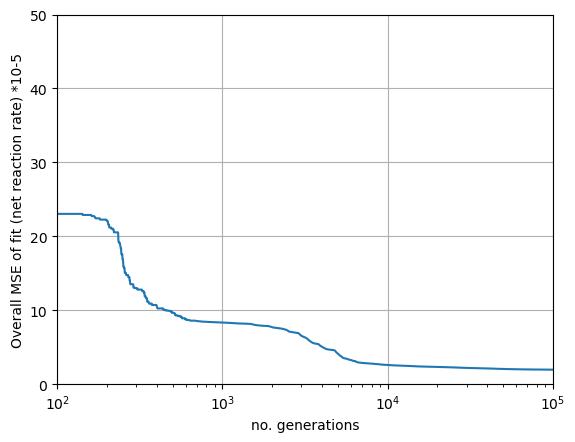

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.298378098376723
1.4877310008539673
0.8035523249103059
-1.4050713437645173
0.026778116620370662
2.238313977162028e-07
0.299126314661539
-9.433405592236625
0.946450708356403
7.130399705675452
5.609756403441702
5.596964178504451
5.71482965952894e-07
0.07164899260154796
2.7684117921941045
0.06528785323982732
0.4741406025427495
-11.259191944880527
1.7724170310077993
1.5521744446888521
-11.720890784723645
1.2064535303757822
4.035628407480393
1.4862916237445353e-06
4.300945806937399
4.925673838860858
1.9558217226734973
10.670817371601423
-5.147129667668941
3.139327888050078
6.195403913484529
2.7713051484617233
-3.9173588419904206
0.49173228290593457
1.0536441588858239
-1.3010291323687109


In [37]:
res.X

array([-1.12983781e+01,  1.48773100e+00,  8.03552325e-01, -1.40507134e+00,
        2.67781166e-02,  2.23831398e-07,  2.99126315e-01, -9.43340559e+00,
        9.46450708e-01,  7.13039971e+00,  5.60975640e+00,  5.59696418e+00,
        5.71482966e-07,  7.16489926e-02,  2.76841179e+00,  6.52878532e-02,
        4.74140603e-01, -1.12591919e+01,  1.77241703e+00,  1.55217444e+00,
       -1.17208908e+01,  1.20645353e+00,  4.03562841e+00,  1.48629162e-06,
        4.30094581e+00,  4.92567384e+00,  1.95582172e+00,  1.06708174e+01,
       -5.14712967e+00,  3.13932789e+00,  6.19540391e+00,  2.77130515e+00,
       -3.91735884e+00,  4.91732283e-01,  1.05364416e+00, -1.30102913e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.298378098376723
1.6: 1.4877310008539673
0.9: 0.8035523249103059
-4.3: -1.4050713437645173
0.5: 0.026778116620370662
0.003: 2.238313977162028e-07
0.4: 0.299126314661539
-7.9: -9.433405592236625
0.7: 0.946450708356403
7.2: 7.130399705675452
5.7: 5.609756403441702
5.7: 5.596964178504451
0.8: 5.71482965952894e-07
0.03: 0.07164899260154796
3.1: 2.7684117921941045
6.000000000000001e-09: 0.06528785323982732
0.1: 0.4741406025427495
-12.0: -11.259191944880527
1.9: 1.7724170310077993
1.6: 1.5521744446888521
-11.6: -11.720890784723645
1.2: 1.2064535303757822
4.0: 4.035628407480393
0.01: 1.4862916237445353e-06
4.2: 4.300945806937399
5.4: 4.925673838860858
2.2: 1.9558217226734973
11.8: 10.670817371601423
-12.0: -5.147129667668941
3.3: 3.139327888050078
1.8: 6.195403913484529
4.2: 2.7713051484617233
-4.0: -3.9173588419904206
0.5: 0.49173228290593457
1.0: 1.0536441588858239
coeff fit: 0.9203171937524712
r: 0.959331639086542
